In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

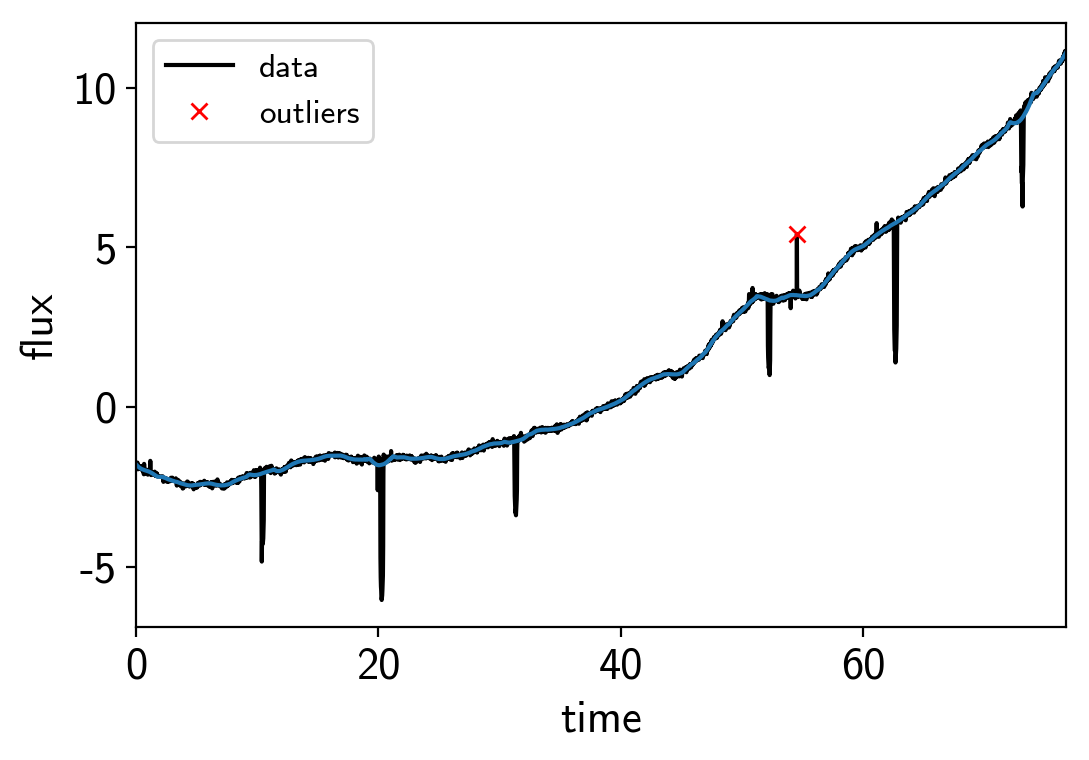

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

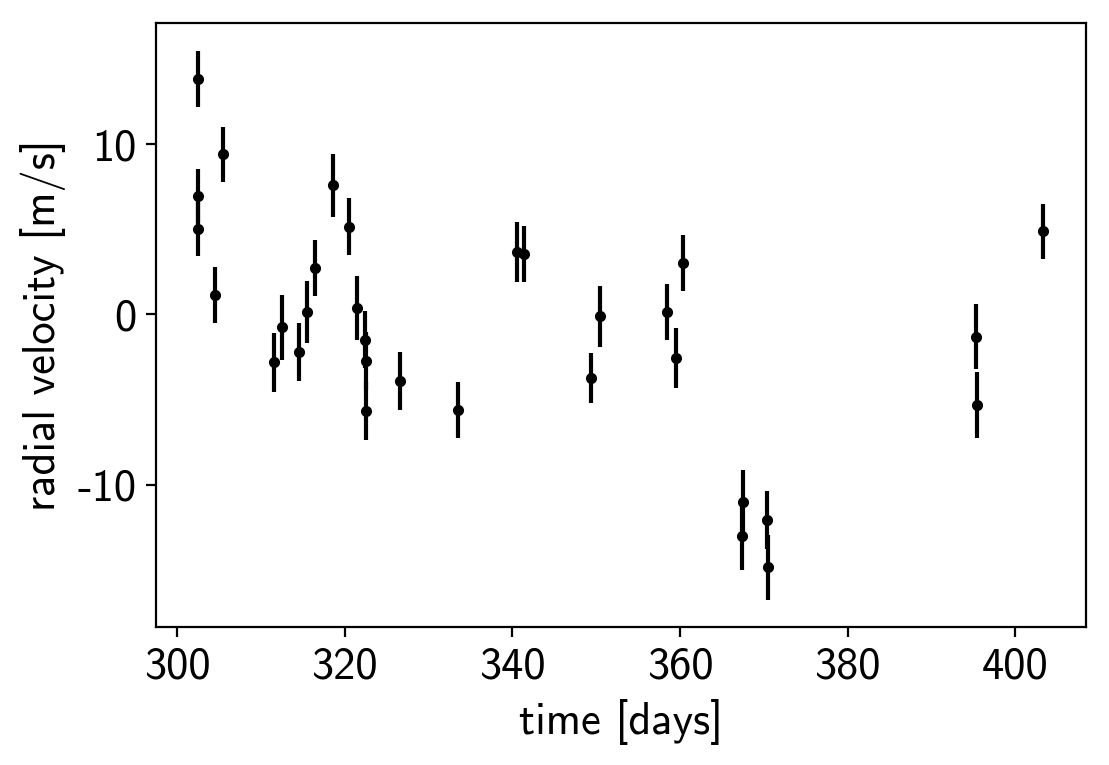

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

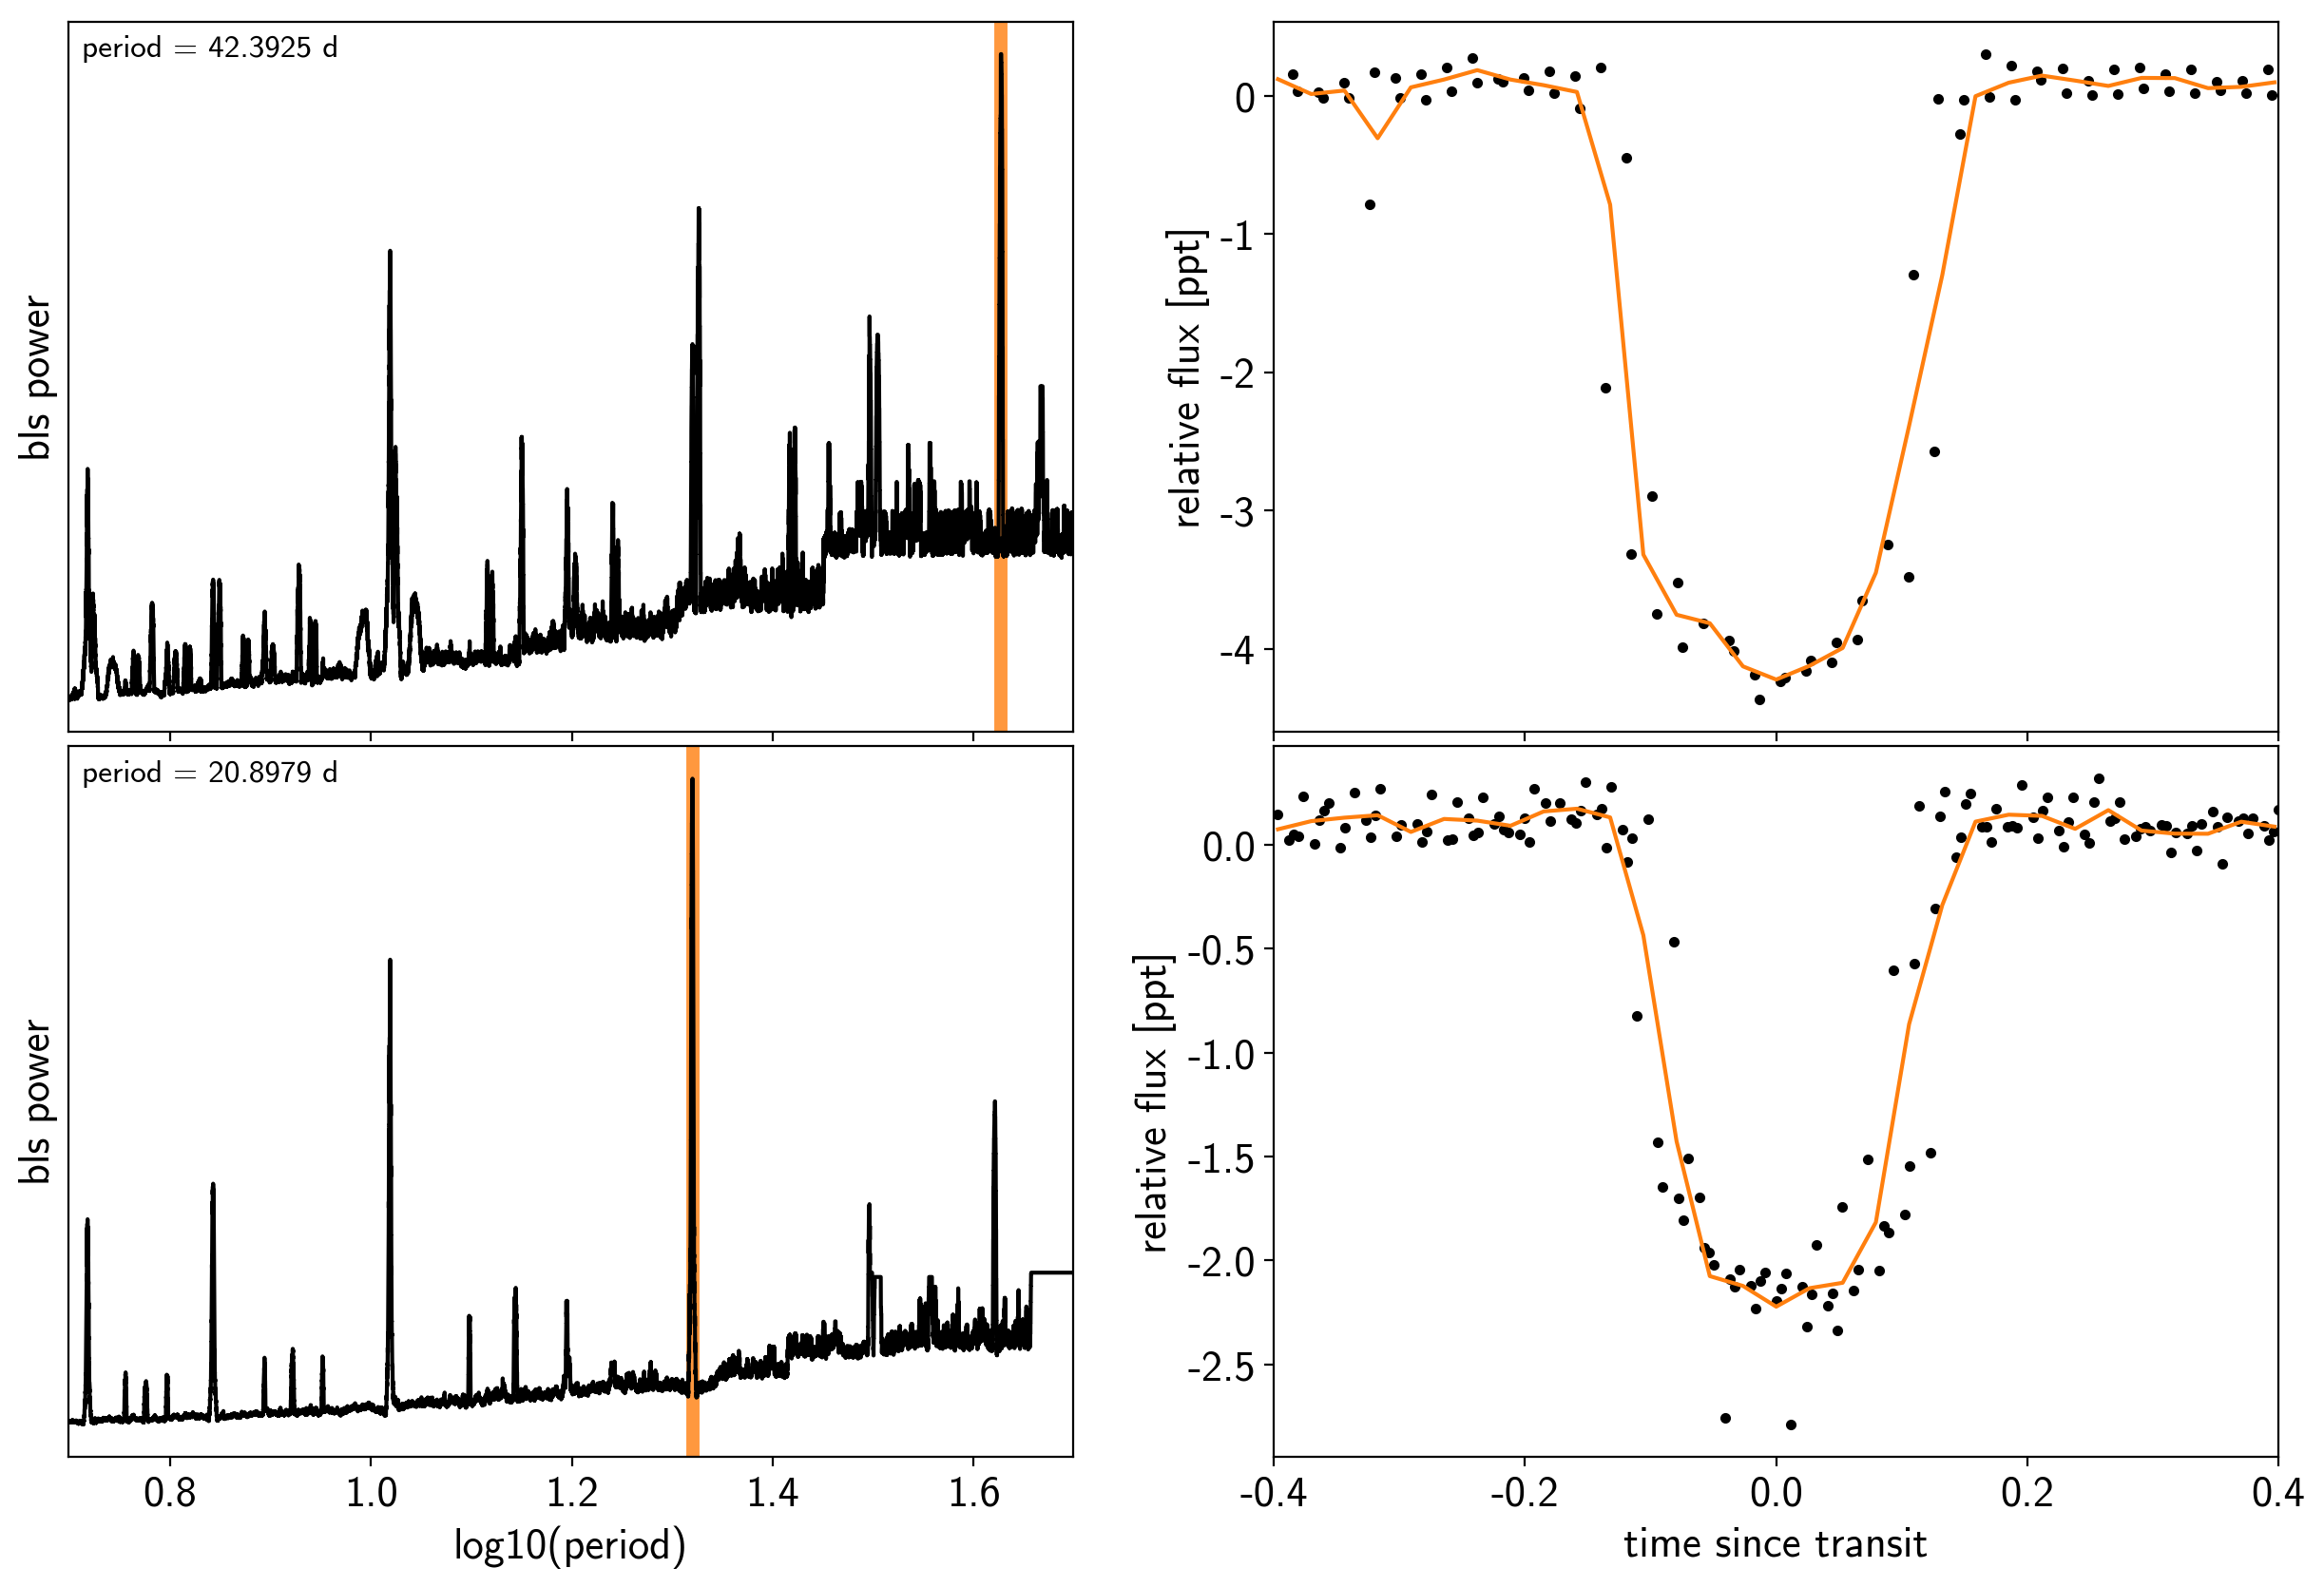

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Uniform("b", lower=0, upper=1, shape=2, testval=0.5+np.zeros(2))
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.57231984769 -> -8233.97212654762


optimizing logp for variables: ['logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -8233.97212654762 -> 1985.1953832397035


optimizing logp for variables: ['b_interval__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 1985.1953832397035 -> 2679.6983150336596


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2679.6983150336596 -> 3334.2121766161986


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3334.2121766161986 -> 4291.602778343168


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 4291.602778343168 -> 4365.5548637838665


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.5548637838665 -> 4777.101722837851


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 4777.101722837851 -> 4777.101722837853


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4777.101722837853 -> 4777.101722837853


Now let's plot the map radial velocity model.

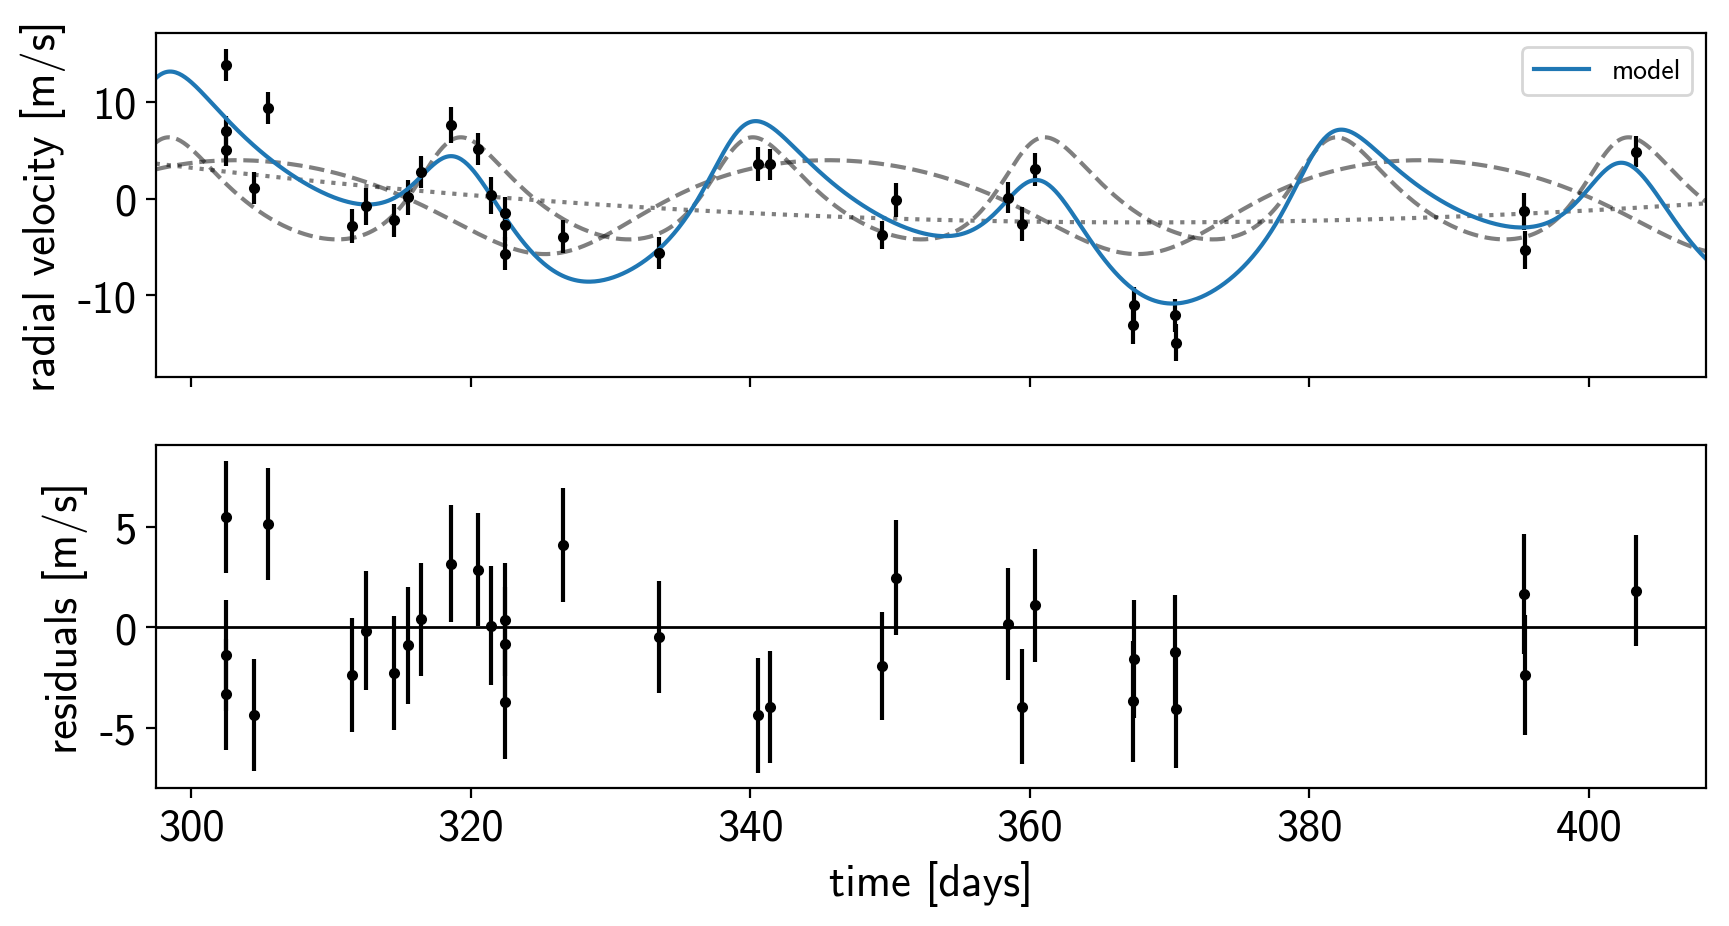

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

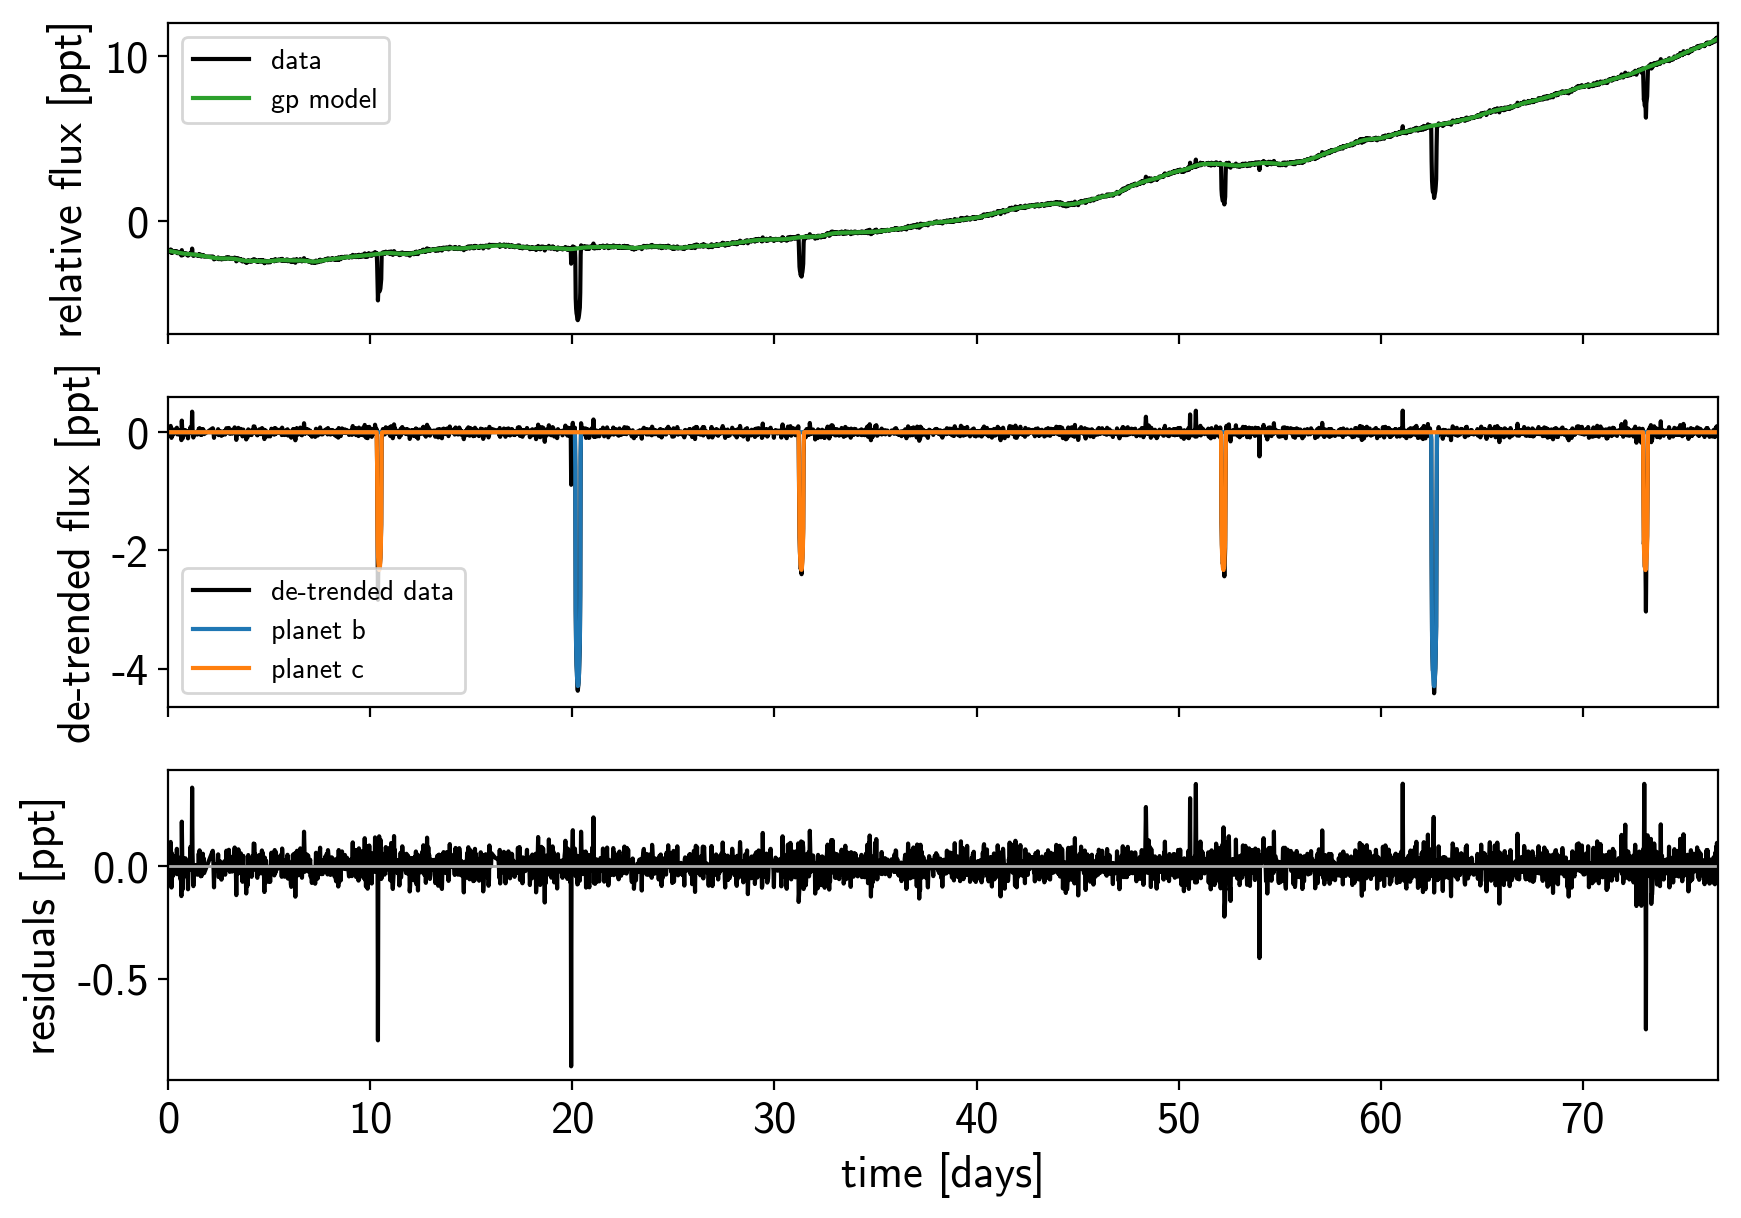

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

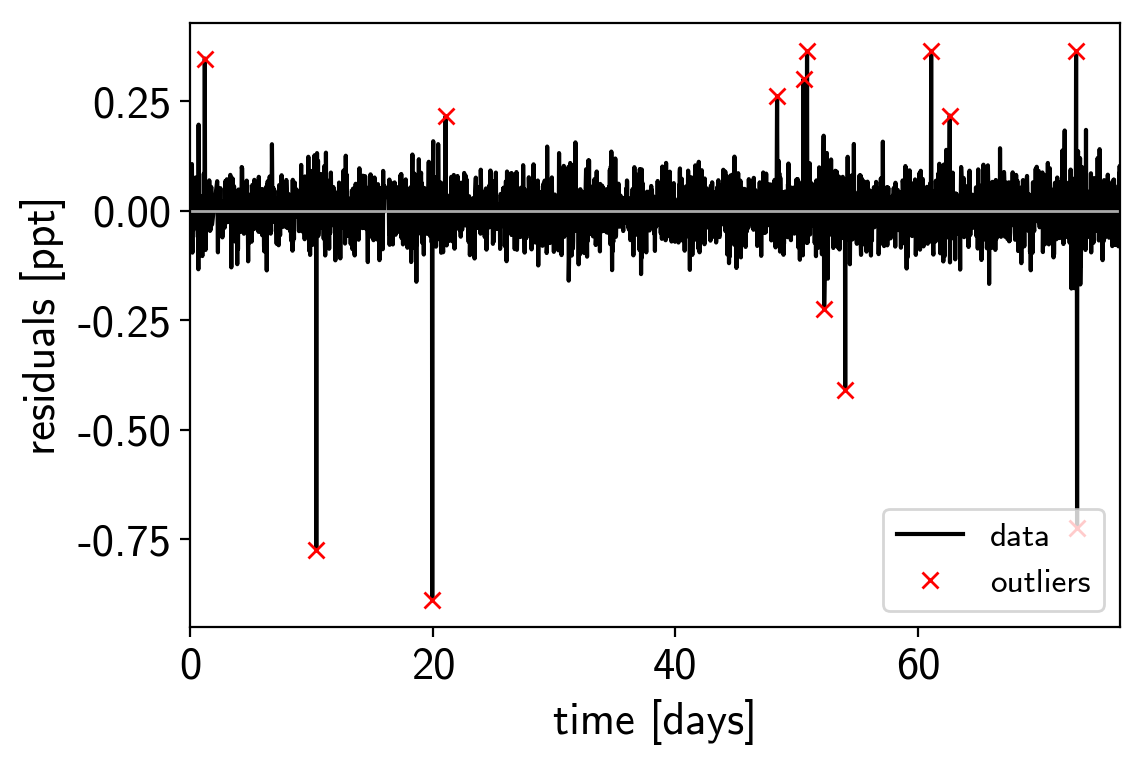

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.105426054745 -> 5227.105426054746


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5227.105426054746 -> 5309.207365242059


optimizing logp for variables: ['b_interval__', 'logr']


message: Optimization terminated successfully.
logp: 5309.207365242059 -> 5320.193155781602


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 5320.193155781602 -> 5321.576490261644


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.576490261644 -> 5322.307791066912


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.307791066912 -> 5322.341941659251


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.341941659251 -> 5324.305673578472


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Optimization terminated successfully.
logp: 5324.305673578472 -> 5324.305673578472


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.305673578472 -> 5324.305673578472


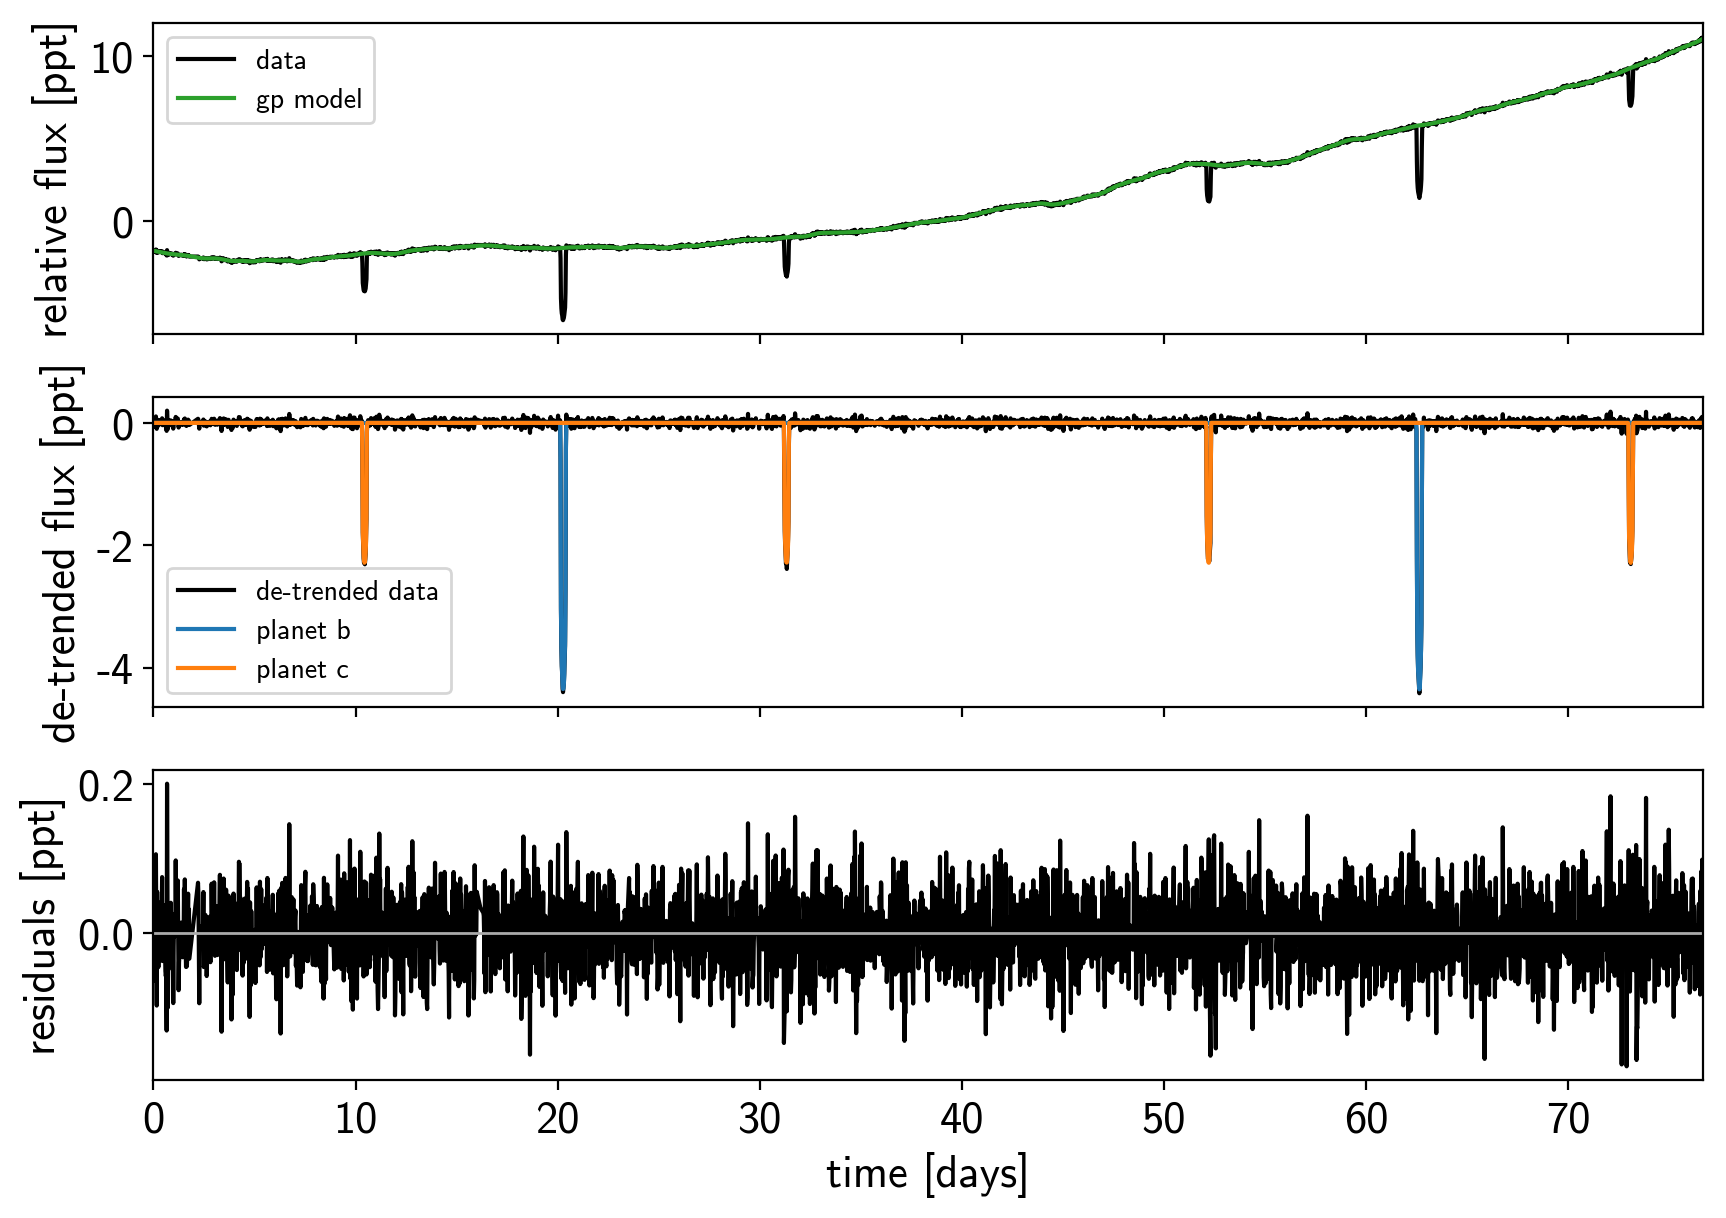

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.95))

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:09, 30.26draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:01<00:19, 14.40draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:01<00:26, 10.59draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:02<00:31,  8.85draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:03<00:34,  7.96draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:03<00:35,  7.47draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:04<00:36,  7.17draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:05<00:37,  6.96draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:05<00:37,  6.84draws/s]

Sampling 4 chains:  18%|█▊        | 56/308 [00:05<00:28,  8.80draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:06<00:39,  6.30draws/s]

Sampling 4 chains:  20%|█▉        | 61/308 [00:06<00:41,  5.90draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:06<00:32,  7.44draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:07<00:40,  5.93draws/s]

Sampling 4 chains:  22%|██▏       | 68/308 [00:07<00:32,  7.31draws/s]

Sampling 4 chains:  23%|██▎       | 70/308 [00:08<00:41,  5.73draws/s]

Sampling 4 chains:  23%|██▎       | 72/308 [00:08<00:32,  7.24draws/s]

Sampling 4 chains:  24%|██▍       | 74/308 [00:08<00:40,  5.81draws/s]

Sampling 4 chains:  25%|██▍       | 76/308 [00:08<00:32,  7.23draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:09<00:39,  5.77draws/s]

Sampling 4 chains:  26%|██▌       | 80/308 [00:09<00:32,  7.09draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:09<00:38,  5.85draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:10<00:35,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:10<00:38,  5.81draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:10<00:33,  6.69draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:11<00:36,  5.99draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:11<00:32,  6.62draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:11<00:35,  6.14draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:11<00:31,  6.73draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:12<00:33,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 99/308 [00:12<00:32,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:12<00:32,  6.30draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:13<00:29,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 103/308 [00:13<00:30,  6.68draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:13<00:31,  6.43draws/s]

Sampling 4 chains:  34%|███▍      | 106/308 [00:13<00:28,  7.08draws/s]

Sampling 4 chains:  35%|███▍      | 107/308 [00:13<00:31,  6.44draws/s]

Sampling 4 chains:  35%|███▌      | 109/308 [00:14<00:31,  6.27draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:14<00:30,  6.52draws/s]

Sampling 4 chains:  37%|███▋      | 113/308 [00:14<00:30,  6.33draws/s]

Sampling 4 chains:  37%|███▋      | 115/308 [00:15<00:30,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:15<00:29,  6.43draws/s]

Sampling 4 chains:  39%|███▊      | 119/308 [00:15<00:29,  6.49draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:16<00:28,  6.50draws/s]

Sampling 4 chains:  40%|███▉      | 123/308 [00:16<00:29,  6.30draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:16<00:27,  6.59draws/s]

Sampling 4 chains:  41%|████      | 127/308 [00:17<00:28,  6.31draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:17<00:27,  6.57draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:17<00:24,  7.13draws/s]

Sampling 4 chains:  43%|████▎     | 131/308 [00:17<00:29,  6.05draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:17<00:27,  6.35draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:18<00:24,  7.01draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:18<00:29,  5.93draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:18<00:27,  6.30draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:18<00:24,  6.93draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:18<00:28,  5.88draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:19<00:26,  6.28draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:19<00:23,  6.92draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:19<00:28,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:19<00:26,  6.12draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:20<00:26,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:20<00:24,  6.38draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:20<00:25,  6.19draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [00:20<00:23,  6.47draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [00:21<00:25,  6.10draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:21<00:22,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [00:21<00:24,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:22<00:22,  6.65draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [00:22<00:23,  6.17draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:22<00:21,  6.76draws/s]

Sampling 4 chains:  54%|█████▍    | 167/308 [00:23<00:22,  6.21draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:23<00:20,  6.77draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:23<00:22,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:24<00:19,  6.82draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:24<00:21,  6.22draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:24<00:19,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:25<00:20,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:25<00:18,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [00:25<00:19,  6.29draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:25<00:18,  6.79draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [00:26<00:19,  6.26draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:26<00:17,  6.70draws/s]

Sampling 4 chains:  62%|██████▏   | 191/308 [00:26<00:18,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [00:27<00:16,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [00:27<00:17,  6.30draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [00:27<00:16,  6.84draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [00:28<00:17,  6.27draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:28<00:15,  6.89draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [00:28<00:16,  6.25draws/s]

Sampling 4 chains:  66%|██████▌   | 204/308 [00:28<00:15,  6.91draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:28<00:13,  7.51draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:29<00:15,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 208/308 [00:29<00:14,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:29<00:11,  8.39draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [00:29<00:18,  5.19draws/s]

Sampling 4 chains:  69%|██████▉   | 212/308 [00:30<00:16,  5.79draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [00:30<00:13,  7.21draws/s]

Sampling 4 chains:  70%|███████   | 216/308 [00:30<00:15,  5.80draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:30<00:12,  7.31draws/s]

Sampling 4 chains:  71%|███████▏  | 220/308 [00:31<00:15,  5.79draws/s]

Sampling 4 chains:  72%|███████▏  | 223/308 [00:31<00:14,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 224/308 [00:31<00:13,  6.09draws/s]

Sampling 4 chains:  74%|███████▎  | 227/308 [00:32<00:13,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 228/308 [00:32<00:12,  6.20draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [00:33<00:12,  6.34draws/s]

Sampling 4 chains:  75%|███████▌  | 232/308 [00:33<00:11,  6.37draws/s]

Sampling 4 chains:  76%|███████▋  | 235/308 [00:33<00:11,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 236/308 [00:33<00:11,  6.49draws/s]

Sampling 4 chains:  78%|███████▊  | 239/308 [00:34<00:10,  6.48draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [00:34<00:10,  6.67draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:34<00:08,  8.24draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:35<00:10,  6.29draws/s]

Sampling 4 chains:  80%|███████▉  | 245/308 [00:35<00:08,  7.05draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [00:35<00:09,  6.40draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [00:35<00:08,  6.84draws/s]

Sampling 4 chains:  81%|████████  | 249/308 [00:35<00:08,  7.24draws/s]

Sampling 4 chains:  81%|████████▏ | 251/308 [00:36<00:08,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:36<00:07,  7.10draws/s]

Sampling 4 chains:  82%|████████▏ | 253/308 [00:36<00:07,  7.33draws/s]

Sampling 4 chains:  83%|████████▎ | 255/308 [00:36<00:08,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:36<00:07,  7.26draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [00:36<00:06,  7.34draws/s]

Sampling 4 chains:  84%|████████▍ | 259/308 [00:37<00:07,  6.61draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [00:37<00:06,  7.07draws/s]

Sampling 4 chains:  85%|████████▌ | 263/308 [00:37<00:06,  6.44draws/s]

Sampling 4 chains:  86%|████████▌ | 265/308 [00:38<00:06,  6.91draws/s]

Sampling 4 chains:  87%|████████▋ | 267/308 [00:38<00:06,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 268/308 [00:38<00:05,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:38<00:05,  7.26draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:38<00:05,  7.55draws/s]

Sampling 4 chains:  88%|████████▊ | 271/308 [00:39<00:06,  5.86draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:39<00:05,  6.60draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [00:39<00:04,  7.01draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:39<00:04,  7.14draws/s]

Sampling 4 chains:  89%|████████▉ | 275/308 [00:39<00:05,  5.80draws/s]

Sampling 4 chains:  90%|████████▉ | 276/308 [00:39<00:04,  6.57draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [00:40<00:04,  6.99draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:40<00:04,  6.92draws/s]

Sampling 4 chains:  91%|█████████ | 279/308 [00:40<00:04,  5.81draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:40<00:04,  6.61draws/s]

Sampling 4 chains:  91%|█████████ | 281/308 [00:40<00:03,  7.02draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:40<00:03,  6.75draws/s]

Sampling 4 chains:  92%|█████████▏| 283/308 [00:41<00:04,  5.83draws/s]

Sampling 4 chains:  93%|█████████▎| 285/308 [00:41<00:03,  6.53draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:41<00:03,  6.25draws/s]

Sampling 4 chains:  93%|█████████▎| 287/308 [00:41<00:03,  5.67draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:41<00:03,  6.15draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:42<00:02,  6.44draws/s]

Sampling 4 chains:  94%|█████████▍| 291/308 [00:42<00:02,  5.87draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:42<00:02,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:42<00:02,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 295/308 [00:42<00:02,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:42<00:01,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:43<00:01,  6.39draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [00:43<00:01,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:43<00:01,  6.52draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:43<00:00,  6.45draws/s]

Sampling 4 chains:  98%|█████████▊| 303/308 [00:44<00:00,  6.48draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:44<00:00,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:46<00:01,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:46<00:00,  1.97draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:47<00:00,  1.94draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:  19%|█▉        | 21/108 [00:00<00:02, 30.05draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:01<00:05, 14.53draws/s]

Sampling 4 chains:  27%|██▋       | 29/108 [00:01<00:07, 10.67draws/s]

Sampling 4 chains:  31%|███       | 33/108 [00:02<00:08,  9.00draws/s]

Sampling 4 chains:  32%|███▏      | 35/108 [00:02<00:06, 10.73draws/s]

Sampling 4 chains:  34%|███▍      | 37/108 [00:03<00:10,  6.96draws/s]

Sampling 4 chains:  36%|███▌      | 39/108 [00:03<00:08,  8.58draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:03<00:10,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 43/108 [00:03<00:08,  7.87draws/s]

Sampling 4 chains:  42%|████▏     | 45/108 [00:04<00:10,  5.94draws/s]

Sampling 4 chains:  44%|████▍     | 48/108 [00:04<00:07,  7.75draws/s]

Sampling 4 chains:  46%|████▋     | 50/108 [00:05<00:09,  5.85draws/s]

Sampling 4 chains:  50%|█████     | 54/108 [00:05<00:09,  5.97draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:06<00:08,  6.11draws/s]

Sampling 4 chains:  57%|█████▋    | 62/108 [00:06<00:05,  8.17draws/s]

Sampling 4 chains:  59%|█████▉    | 64/108 [00:06<00:07,  6.07draws/s]

Sampling 4 chains:  62%|██████▏   | 67/108 [00:07<00:07,  5.68draws/s]

Sampling 4 chains:  64%|██████▍   | 69/108 [00:07<00:05,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 72/108 [00:08<00:05,  6.75draws/s]

Sampling 4 chains:  69%|██████▊   | 74/108 [00:08<00:04,  7.99draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:08<00:05,  6.34draws/s]

Sampling 4 chains:  71%|███████▏  | 77/108 [00:08<00:04,  6.91draws/s]

Sampling 4 chains:  74%|███████▍  | 80/108 [00:09<00:03,  7.88draws/s]

Sampling 4 chains:  76%|███████▌  | 82/108 [00:09<00:03,  6.67draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:09<00:03,  7.37draws/s]

Sampling 4 chains:  79%|███████▊  | 85/108 [00:10<00:04,  5.71draws/s]

Sampling 4 chains:  80%|███████▉  | 86/108 [00:10<00:03,  5.77draws/s]

Sampling 4 chains:  81%|████████▏ | 88/108 [00:10<00:02,  6.70draws/s]

Sampling 4 chains:  82%|████████▏ | 89/108 [00:10<00:03,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 90/108 [00:10<00:03,  5.59draws/s]

Sampling 4 chains:  85%|████████▌ | 92/108 [00:10<00:02,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 93/108 [00:11<00:02,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 94/108 [00:11<00:02,  5.51draws/s]

Sampling 4 chains:  89%|████████▉ | 96/108 [00:11<00:01,  6.32draws/s]

Sampling 4 chains:  90%|████████▉ | 97/108 [00:11<00:02,  5.30draws/s]

Sampling 4 chains:  91%|█████████ | 98/108 [00:12<00:01,  5.35draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:12<00:01,  6.38draws/s]

Sampling 4 chains:  94%|█████████▎| 101/108 [00:12<00:01,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:12<00:01,  5.35draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:13<00:00,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:14<00:01,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:14<00:00,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 107/108 [00:15<00:00,  2.54draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:15<00:00,  2.09draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/208 [00:00<02:16,  1.52draws/s]

Sampling 4 chains:   2%|▏         | 5/208 [00:01<01:39,  2.04draws/s]

Sampling 4 chains:   3%|▎         | 6/208 [00:01<01:23,  2.42draws/s]

Sampling 4 chains:   4%|▍         | 9/208 [00:01<01:06,  3.01draws/s]

Sampling 4 chains:   5%|▍         | 10/208 [00:01<00:59,  3.33draws/s]

Sampling 4 chains:   6%|▋         | 13/208 [00:02<00:48,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 14/208 [00:02<00:47,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 17/208 [00:02<00:40,  4.69draws/s]

Sampling 4 chains:   9%|▊         | 18/208 [00:03<00:41,  4.56draws/s]

Sampling 4 chains:  10%|█         | 21/208 [00:03<00:36,  5.13draws/s]

Sampling 4 chains:  11%|█         | 22/208 [00:03<00:37,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 25/208 [00:04<00:34,  5.38draws/s]

Sampling 4 chains:  12%|█▎        | 26/208 [00:04<00:35,  5.13draws/s]

Sampling 4 chains:  14%|█▍        | 29/208 [00:04<00:31,  5.63draws/s]

Sampling 4 chains:  14%|█▍        | 30/208 [00:05<00:34,  5.15draws/s]

Sampling 4 chains:  16%|█▌        | 33/208 [00:05<00:30,  5.71draws/s]

Sampling 4 chains:  16%|█▋        | 34/208 [00:05<00:33,  5.17draws/s]

Sampling 4 chains:  18%|█▊        | 37/208 [00:06<00:28,  5.94draws/s]

Sampling 4 chains:  19%|█▉        | 39/208 [00:06<00:28,  5.86draws/s]

Sampling 4 chains:  20%|█▉        | 41/208 [00:06<00:27,  6.17draws/s]

Sampling 4 chains:  21%|██        | 43/208 [00:07<00:27,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 45/208 [00:07<00:25,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 46/208 [00:07<00:22,  7.10draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:07<00:28,  5.65draws/s]

Sampling 4 chains:  24%|██▎       | 49/208 [00:08<00:26,  6.09draws/s]

Sampling 4 chains:  24%|██▍       | 50/208 [00:08<00:23,  6.80draws/s]

Sampling 4 chains:  25%|██▍       | 51/208 [00:08<00:23,  6.63draws/s]

Sampling 4 chains:  25%|██▌       | 52/208 [00:08<00:21,  7.37draws/s]

Sampling 4 chains:  25%|██▌       | 53/208 [00:08<00:27,  5.54draws/s]

Sampling 4 chains:  26%|██▌       | 54/208 [00:08<00:24,  6.35draws/s]

Sampling 4 chains:  26%|██▋       | 55/208 [00:08<00:24,  6.35draws/s]

Sampling 4 chains:  27%|██▋       | 56/208 [00:09<00:22,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 57/208 [00:09<00:26,  5.63draws/s]

Sampling 4 chains:  28%|██▊       | 58/208 [00:09<00:23,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 59/208 [00:09<00:24,  6.18draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:09<00:19,  7.38draws/s]

Sampling 4 chains:  30%|██▉       | 62/208 [00:09<00:22,  6.44draws/s]

Sampling 4 chains:  30%|███       | 63/208 [00:10<00:28,  5.07draws/s]

Sampling 4 chains:  32%|███▏      | 66/208 [00:10<00:21,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 68/208 [00:10<00:19,  7.15draws/s]

Sampling 4 chains:  34%|███▎      | 70/208 [00:11<00:22,  6.24draws/s]

Sampling 4 chains:  35%|███▍      | 72/208 [00:11<00:18,  7.23draws/s]

Sampling 4 chains:  35%|███▌      | 73/208 [00:11<00:25,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 74/208 [00:11<00:24,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 76/208 [00:11<00:19,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 77/208 [00:12<00:21,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 79/208 [00:12<00:20,  6.29draws/s]

Sampling 4 chains:  39%|███▉      | 81/208 [00:12<00:20,  6.06draws/s]

Sampling 4 chains:  40%|███▉      | 83/208 [00:12<00:19,  6.33draws/s]

Sampling 4 chains:  41%|████      | 85/208 [00:13<00:20,  6.08draws/s]

Sampling 4 chains:  42%|████▏     | 87/208 [00:13<00:17,  6.94draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:13<00:14,  8.18draws/s]

Sampling 4 chains:  43%|████▎     | 90/208 [00:13<00:21,  5.44draws/s]

Sampling 4 chains:  44%|████▍     | 91/208 [00:14<00:20,  5.65draws/s]

Sampling 4 chains:  45%|████▍     | 93/208 [00:14<00:16,  6.80draws/s]

Sampling 4 chains:  45%|████▌     | 94/208 [00:14<00:22,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 95/208 [00:14<00:21,  5.36draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:14<00:17,  6.30draws/s]

Sampling 4 chains:  47%|████▋     | 98/208 [00:15<00:16,  6.54draws/s]

Sampling 4 chains:  48%|████▊     | 100/208 [00:15<00:18,  5.98draws/s]

Sampling 4 chains:  49%|████▉     | 102/208 [00:15<00:16,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 104/208 [00:16<00:17,  5.99draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:16<00:15,  6.71draws/s]

Sampling 4 chains:  51%|█████▏    | 107/208 [00:16<00:13,  7.24draws/s]

Sampling 4 chains:  52%|█████▏    | 108/208 [00:16<00:18,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 110/208 [00:16<00:15,  6.19draws/s]

Sampling 4 chains:  53%|█████▎    | 111/208 [00:17<00:14,  6.63draws/s]

Sampling 4 chains:  54%|█████▍    | 112/208 [00:17<00:18,  5.09draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:17<00:15,  6.00draws/s]

Sampling 4 chains:  55%|█████▌    | 115/208 [00:17<00:14,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:18<00:18,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 118/208 [00:18<00:15,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 119/208 [00:18<00:14,  6.19draws/s]

Sampling 4 chains:  58%|█████▊    | 120/208 [00:18<00:17,  4.93draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:18<00:14,  5.80draws/s]

Sampling 4 chains:  59%|█████▉    | 123/208 [00:18<00:13,  6.24draws/s]

Sampling 4 chains:  60%|█████▉    | 124/208 [00:19<00:17,  4.93draws/s]

Sampling 4 chains:  60%|██████    | 125/208 [00:19<00:14,  5.79draws/s]

Sampling 4 chains:  61%|██████    | 127/208 [00:19<00:12,  6.64draws/s]

Sampling 4 chains:  62%|██████▏   | 128/208 [00:19<00:16,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 129/208 [00:20<00:13,  5.66draws/s]

Sampling 4 chains:  63%|██████▎   | 131/208 [00:20<00:10,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 133/208 [00:20<00:12,  5.89draws/s]

Sampling 4 chains:  65%|██████▍   | 135/208 [00:20<00:10,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 137/208 [00:21<00:12,  5.84draws/s]

Sampling 4 chains:  67%|██████▋   | 139/208 [00:21<00:09,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 141/208 [00:21<00:11,  5.81draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [00:22<00:09,  7.07draws/s]

Sampling 4 chains:  70%|██████▉   | 145/208 [00:22<00:10,  5.79draws/s]

Sampling 4 chains:  71%|███████   | 147/208 [00:22<00:08,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 149/208 [00:23<00:10,  5.76draws/s]

Sampling 4 chains:  73%|███████▎  | 151/208 [00:23<00:07,  7.13draws/s]

Sampling 4 chains:  74%|███████▎  | 153/208 [00:23<00:09,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 155/208 [00:23<00:07,  7.22draws/s]

Sampling 4 chains:  75%|███████▌  | 157/208 [00:24<00:08,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 160/208 [00:24<00:07,  6.76draws/s]

Sampling 4 chains:  78%|███████▊  | 162/208 [00:25<00:07,  5.79draws/s]

Sampling 4 chains:  79%|███████▉  | 164/208 [00:25<00:06,  6.81draws/s]

Sampling 4 chains:  79%|███████▉  | 165/208 [00:25<00:09,  4.59draws/s]

Sampling 4 chains:  80%|████████  | 167/208 [00:25<00:06,  5.94draws/s]

Sampling 4 chains:  81%|████████▏ | 169/208 [00:26<00:06,  6.46draws/s]

Sampling 4 chains:  82%|████████▏ | 170/208 [00:26<00:07,  5.18draws/s]

Sampling 4 chains:  82%|████████▏ | 171/208 [00:26<00:06,  5.60draws/s]

Sampling 4 chains:  83%|████████▎ | 172/208 [00:26<00:05,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 173/208 [00:26<00:05,  6.89draws/s]

Sampling 4 chains:  84%|████████▎ | 174/208 [00:26<00:06,  5.57draws/s]

Sampling 4 chains:  84%|████████▍ | 175/208 [00:27<00:05,  5.97draws/s]

Sampling 4 chains:  85%|████████▍ | 176/208 [00:27<00:04,  6.51draws/s]

Sampling 4 chains:  85%|████████▌ | 177/208 [00:27<00:04,  7.04draws/s]

Sampling 4 chains:  86%|████████▌ | 178/208 [00:27<00:05,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 179/208 [00:27<00:04,  6.23draws/s]

Sampling 4 chains:  87%|████████▋ | 180/208 [00:27<00:04,  6.60draws/s]

Sampling 4 chains:  87%|████████▋ | 181/208 [00:27<00:03,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 183/208 [00:28<00:02,  8.71draws/s]

Sampling 4 chains:  89%|████████▉ | 185/208 [00:28<00:03,  6.24draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [00:28<00:02,  7.17draws/s]

Sampling 4 chains:  91%|█████████ | 189/208 [00:29<00:03,  5.58draws/s]

Sampling 4 chains:  91%|█████████▏| 190/208 [00:29<00:02,  6.38draws/s]

Sampling 4 chains:  92%|█████████▏| 192/208 [00:29<00:02,  6.78draws/s]

Sampling 4 chains:  93%|█████████▎| 193/208 [00:29<00:02,  5.35draws/s]

Sampling 4 chains:  93%|█████████▎| 194/208 [00:29<00:02,  6.14draws/s]

Sampling 4 chains:  94%|█████████▍| 196/208 [00:30<00:01,  6.46draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [00:30<00:02,  5.40draws/s]

Sampling 4 chains:  95%|█████████▌| 198/208 [00:30<00:01,  6.23draws/s]

Sampling 4 chains:  96%|█████████▌| 200/208 [00:30<00:01,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 201/208 [00:31<00:01,  5.39draws/s]

Sampling 4 chains:  97%|█████████▋| 202/208 [00:31<00:00,  6.21draws/s]

Sampling 4 chains:  98%|█████████▊| 203/208 [00:31<00:00,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 204/208 [00:31<00:00,  4.62draws/s]

Sampling 4 chains:  99%|█████████▊| 205/208 [00:32<00:00,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 206/208 [00:33<00:01,  1.86draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:33<00:00,  2.25draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/408 [00:00<01:07,  6.01draws/s]

Sampling 4 chains:   1%|          | 4/408 [00:00<00:51,  7.81draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:39, 10.22draws/s]

Sampling 4 chains:   3%|▎         | 11/408 [00:00<00:41,  9.50draws/s]

Sampling 4 chains:   4%|▎         | 15/408 [00:00<00:38, 10.25draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:01<00:44,  8.84draws/s]

Sampling 4 chains:   5%|▍         | 20/408 [00:01<00:41,  9.43draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:01<00:45,  8.52draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:01<00:37, 10.18draws/s]

Sampling 4 chains:   7%|▋         | 28/408 [00:02<00:35, 10.62draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:02<00:39,  9.66draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:02<00:39,  9.62draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:02<00:35, 10.64draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:03<00:38,  9.62draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:03<00:30, 11.92draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:03<00:28, 12.94draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:03<00:32, 11.11draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:03<00:33, 10.88draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:04<00:35, 10.29draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:04<00:28, 12.75draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:04<00:22, 15.54draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:04<00:16, 20.47draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:04<00:13, 25.36draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:04<00:12, 25.69draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:04<00:10, 30.10draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:05<00:12, 24.71draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:05<00:14, 21.46draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:05<00:18, 16.98draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:05<00:17, 18.05draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:06<00:15, 19.33draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:06<00:15, 19.20draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:06<00:13, 21.89draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:06<00:10, 27.91draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:06<00:16, 17.70draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:07<00:20, 13.38draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:07<00:17, 15.84draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:07<00:15, 18.08draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:07<00:16, 16.83draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:08<00:17, 15.11draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:08<00:17, 15.18draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:08<00:14, 18.65draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:08<00:18, 14.15draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:08<00:15, 16.25draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:08<00:14, 17.52draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:09<00:11, 22.01draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:09<00:08, 27.18draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:09<00:09, 24.78draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:09<00:08, 26.33draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:09<00:09, 24.86draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:09<00:09, 24.16draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:10<00:13, 16.50draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:10<00:12, 16.62draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:10<00:10, 20.67draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:10<00:11, 17.83draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:10<00:08, 23.14draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:10<00:07, 24.64draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:11<00:07, 25.37draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:11<00:07, 25.54draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:11<00:06, 27.93draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:11<00:06, 27.07draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:11<00:05, 31.22draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:11<00:05, 33.01draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:12<00:07, 23.04draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:12<00:05, 26.84draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:12<00:06, 24.64draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:12<00:05, 27.82draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:12<00:05, 26.60draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:12<00:04, 31.13draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:12<00:04, 33.30draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:13<00:04, 28.82draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:13<00:05, 24.99draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:13<00:03, 31.20draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:13<00:03, 31.27draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:13<00:03, 31.78draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:14<00:05, 20.66draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:14<00:04, 21.31draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:14<00:05, 18.69draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:14<00:06, 15.81draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:14<00:07, 12.47draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:15<00:09, 10.24draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:15<00:06, 12.93draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:15<00:09,  9.41draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:15<00:09,  9.12draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:16<00:10,  8.12draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:16<00:09,  8.39draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:16<00:08,  9.79draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:16<00:07, 10.43draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:17<00:10,  7.44draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:17<00:07,  9.27draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:17<00:06, 10.21draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:17<00:07,  9.06draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:18<00:10,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:18<00:13,  4.66draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:19<00:15,  4.13draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:19<00:21,  2.83draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:20<00:25,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:21<00:28,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:21<00:30,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:22<00:31,  1.80draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:23<00:32,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:23<00:27,  1.98draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:23<00:28,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:24<00:29,  1.81draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:25<00:29,  1.75draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:25<00:30,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:26<00:30,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:27<00:30,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:27<00:29,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:28<00:29,  1.62draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:28<00:28,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:29<00:25,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:30<00:25,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:30<00:19,  2.19draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:30<00:21,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:31<00:22,  1.84draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:31<00:16,  2.42draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:31<00:14,  2.61draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:32<00:17,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:33<00:18,  1.97draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:33<00:16,  2.12draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:34<00:14,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:34<00:11,  2.85draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:34<00:12,  2.59draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:35<00:14,  2.19draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:36<00:15,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:36<00:15,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:37<00:15,  1.76draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:37<00:15,  1.71draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:38<00:15,  1.67draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:39<00:15,  1.65draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:39<00:12,  1.94draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:40<00:12,  1.82draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:40<00:12,  1.74draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:41<00:12,  1.70draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:42<00:11,  1.67draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:42<00:08,  2.14draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:42<00:07,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:42<00:05,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:43<00:05,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:43<00:04,  3.26draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:44<00:05,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:44<00:05,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:45<00:05,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:46<00:05,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:46<00:05,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:47<00:04,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:48<00:04,  1.66draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:48<00:02,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:48<00:02,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:49<00:02,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:49<00:01,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:50<00:00,  2.05draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:50<00:00,  2.28draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:24, 32.35draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<00:30, 26.37draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:56, 14.03draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<01:16, 10.40draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:01<01:09, 11.40draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:01<01:39,  7.88draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:01<01:24,  9.30draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:02<01:55,  6.80draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:02<01:42,  7.63draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:02<01:41,  7.70draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:02<01:44,  7.47draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:03<01:43,  7.53draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:03<01:51,  6.97draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:03<01:38,  7.84draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:03<01:33,  8.26draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:03<01:55,  6.66draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:04<01:49,  7.05draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:04<01:37,  7.89draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:04<02:17,  5.59draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:04<01:59,  6.42draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:04<01:58,  6.44draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:05<02:30,  5.06draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:05<02:00,  6.32draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:05<02:00,  6.31draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:05<02:43,  4.63draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:06<02:09,  5.83draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:06<02:08,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:06<01:51,  6.75draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:06<01:55,  6.53draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:06<02:25,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:07<02:08,  5.83draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:07<02:25,  5.15draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:07<01:53,  6.59draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:07<01:43,  7.15draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:08<02:22,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:08<01:51,  6.66draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:08<01:45,  7.02draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:08<01:45,  6.99draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:08<01:24,  8.64draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:09<01:31,  7.99draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:09<01:41,  7.17draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:09<01:33,  7.80draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:10<01:58,  6.12draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:10<01:34,  7.68draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:10<01:31,  7.91draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:10<01:19,  9.02draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:10<01:24,  8.45draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:10<01:12,  9.86draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:11<01:21,  8.81draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:11<01:26,  8.24draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:11<01:11,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:11<01:04, 10.96draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:12<01:38,  7.17draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:12<01:24,  8.35draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:12<01:16,  9.13draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:12<01:27,  7.97draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:13<01:08, 10.15draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:13<00:59, 11.66draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:13<00:57, 11.95draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:13<01:09,  9.94draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:13<01:03, 10.89draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:14<00:56, 12.07draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:14<00:48, 13.97draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:14<00:52, 12.92draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:14<01:19,  8.47draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:14<01:04, 10.44draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:15<00:57, 11.73draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:15<00:47, 13.95draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:15<00:44, 15.06draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:15<00:54, 12.25draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:15<01:19,  8.31draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:16<01:17,  8.49draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:16<01:09,  9.41draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:16<01:16,  8.59draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:16<01:15,  8.72draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:17<01:07,  9.62draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:17<01:13,  8.80draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:17<01:07,  9.60draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:17<01:11,  9.08draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:17<01:09,  9.27draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:18<01:40,  6.42draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:18<01:37,  6.57draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:18<01:41,  6.33draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:19<01:40,  6.36draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:19<01:29,  7.13draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:19<01:24,  7.49draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:19<01:23,  7.55draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:19<01:19,  7.99draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:19<01:24,  7.43draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:19<01:11,  8.79draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:20<01:22,  7.59draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:20<01:15,  8.31draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:20<01:46,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:20<01:28,  7.05draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:21<01:46,  5.83draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:21<01:23,  7.36draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:21<01:06,  9.19draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:21<01:10,  8.74draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:22<01:12,  8.46draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:22<01:01,  9.96draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:22<01:22,  7.36draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:22<01:02,  9.71draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:23<01:01,  9.81draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:23<00:52, 11.38draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:23<00:46, 12.93draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:23<00:45, 13.11draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:23<00:37, 15.85draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:23<00:42, 13.75draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:24<00:48, 12.04draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:24<00:50, 11.64draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:24<00:50, 11.52draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:24<00:45, 12.60draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:25<01:14,  7.77draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:25<01:01,  9.38draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:25<01:26,  6.61draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:25<01:06,  8.49draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:26<00:59,  9.53draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:26<01:19,  7.13draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:26<00:58,  9.55draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:26<00:51, 10.80draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:27<00:59,  9.25draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:27<00:47, 11.49draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:27<00:51, 10.75draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:27<00:46, 11.68draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:27<00:48, 11.30draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:28<00:57,  9.41draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:28<00:52, 10.32draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:28<00:47, 11.42draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:28<00:47, 11.34draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:28<00:51, 10.35draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:28<00:43, 12.27draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:29<00:50, 10.49draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:29<00:56,  9.38draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:29<01:06,  7.88draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:29<00:56,  9.26draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:30<00:54,  9.55draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:30<00:59,  8.76draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:30<01:05,  7.91draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:30<00:56,  9.18draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:30<01:04,  7.93draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:31<01:08,  7.52draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:31<01:00,  8.43draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:31<01:31,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:31<01:28,  5.77draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:31<01:11,  7.10draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:32<01:00,  8.34draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:32<01:03,  7.92draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:32<01:15,  6.68draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:32<01:04,  7.77draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:32<01:11,  6.98draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:33<01:24,  5.88draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:33<01:13,  6.78draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:33<00:57,  8.58draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:33<01:03,  7.75draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:34<01:05,  7.46draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:34<00:52,  9.20draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:34<00:47, 10.26draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:34<00:47, 10.11draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:34<00:54,  8.83draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:35<01:03,  7.52draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:35<01:08,  7.00draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:35<00:52,  8.97draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:36<01:12,  6.47draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:36<00:58,  8.06draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:36<00:48,  9.73draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:36<01:10,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:37<01:04,  7.13draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:37<00:56,  8.16draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:37<01:09,  6.63draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:37<01:00,  7.60draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:38<00:51,  8.85draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:38<00:41, 10.80draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:38<00:45,  9.80draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:38<00:41, 10.87draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:38<00:36, 12.16draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:38<00:33, 13.20draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:39<00:45,  9.57draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:39<00:42, 10.25draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:39<00:33, 13.00draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:39<00:35, 12.27draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:40<00:41, 10.32draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:40<00:55,  7.66draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:40<00:51,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:40<00:40, 10.45draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:41<01:02,  6.70draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:41<00:50,  8.22draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:41<00:45,  9.10draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:42<00:51,  8.07draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:42<00:51,  7.98draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:42<00:53,  7.66draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:43<00:54,  7.43draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:43<00:42,  9.35draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:43<00:37, 10.70draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:43<00:33, 11.72draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:43<00:31, 12.51draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:43<00:27, 14.19draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:43<00:24, 16.09draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:43<00:21, 17.91draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:44<00:27, 13.90draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:44<00:33, 11.55draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:44<00:45,  8.29draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:45<00:35, 10.53draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:45<00:35, 10.51draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:45<00:32, 11.52draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [00:45<00:43,  8.49draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:45<00:38,  9.46draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:46<00:44,  8.25draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:46<00:39,  9.29draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:46<00:37,  9.64draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [00:47<00:51,  6.93draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:47<00:43,  8.31draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:47<00:35,  9.98draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:47<00:41,  8.57draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:47<00:34, 10.08draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:48<00:35,  9.70draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:48<00:37,  9.34draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:48<00:32, 10.56draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:48<00:36,  9.40draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:48<00:34,  9.97draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:49<00:32, 10.32draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:49<00:39,  8.61draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:49<00:48,  6.92draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:49<00:44,  7.55draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:50<00:47,  7.00draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:50<00:53,  6.22draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:50<00:47,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:50<00:51,  6.41draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:50<00:52,  6.25draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:51<00:46,  7.02draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:51<00:50,  6.41draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:51<00:43,  7.32draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:51<00:42,  7.63draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:52<01:03,  5.08draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:52<00:51,  6.18draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:52<00:49,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:52<00:42,  7.45draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:52<00:37,  8.24draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:52<00:32,  9.55draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:53<00:45,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:53<00:35,  8.57draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [00:53<00:36,  8.43draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:53<00:38,  7.87draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:54<00:34,  8.57draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:54<00:41,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:54<00:39,  7.39draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:55<00:35,  8.15draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:55<00:34,  8.35draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:55<00:39,  7.32draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:55<00:30,  9.46draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:55<00:25, 11.06draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:55<00:21, 13.19draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:55<00:17, 16.15draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:56<00:13, 19.77draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:56<00:13, 19.77draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:56<00:12, 21.21draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:56<00:12, 21.28draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:56<00:14, 18.06draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:56<00:14, 17.66draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:57<00:13, 19.26draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:57<00:12, 19.57draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:57<00:10, 22.41draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:57<00:11, 20.47draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:57<00:09, 24.15draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:57<00:13, 17.30draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:58<00:14, 16.46draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:58<00:11, 20.59draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [00:58<00:09, 23.02draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:58<00:17, 12.63draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:59<00:15, 14.29draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:59<00:11, 17.60draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:59<00:15, 13.61draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:59<00:11, 17.18draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:59<00:13, 15.08draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:00<00:12, 15.64draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:00<00:11, 16.63draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [01:00<00:13, 14.25draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:00<00:14, 13.19draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:00<00:10, 16.89draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:00<00:09, 19.04draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:01<00:07, 22.20draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:01<00:12, 13.78draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:01<00:10, 15.10draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:02<00:13, 12.16draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:02<00:12, 12.69draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:02<00:12, 13.07draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:02<00:15, 10.01draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:03<00:18,  8.42draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:03<00:22,  6.89draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:03<00:20,  7.37draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:03<00:22,  6.73draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:04<00:22,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:04<00:29,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:04<00:25,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:04<00:23,  6.21draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:05<00:27,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:05<00:31,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:05<00:26,  5.28draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:05<00:29,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:06<00:31,  4.45draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:06<00:27,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:06<00:29,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [01:06<00:28,  4.65draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:07<00:29,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:07<00:26,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [01:07<00:22,  5.70draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:07<00:20,  6.30draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:08<00:28,  4.41draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:08<00:25,  4.85draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:08<00:29,  4.26draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [01:09<00:28,  4.33draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:09<00:25,  4.76draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:10<00:23,  5.02draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [01:10<00:20,  5.45draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:10<00:18,  6.00draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:10<00:19,  5.58draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [01:11<00:19,  5.71draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:11<00:17,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:11<00:23,  4.54draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:12<00:21,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:12<00:24,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [01:12<00:18,  5.56draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:12<00:20,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:13<00:24,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:13<00:22,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:13<00:17,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [01:14<00:17,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:14<00:16,  5.62draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:14<00:15,  5.78draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:14<00:14,  6.13draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:14<00:12,  6.95draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:15<00:16,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [01:15<00:13,  6.47draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:15<00:21,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:15<00:16,  4.98draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [01:15<00:16,  5.11draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:16<00:17,  4.54draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:16<00:15,  5.26draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [01:16<00:12,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:16<00:13,  5.57draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [01:17<00:10,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:17<00:10,  7.06draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:17<00:09,  7.13draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:17<00:09,  6.92draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [01:18<00:08,  7.65draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:18<00:08,  7.72draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:18<00:06,  9.99draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [01:18<00:04, 11.44draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:19<00:07,  7.63draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [01:19<00:08,  6.20draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:19<00:07,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [01:19<00:05,  8.44draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:20<00:08,  5.79draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [01:20<00:07,  6.11draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [01:21<00:09,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:21<00:08,  5.28draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:21<00:07,  5.38draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [01:21<00:09,  4.41draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [01:21<00:08,  5.04draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:21<00:08,  4.93draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:22<00:08,  4.37draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [01:22<00:07,  4.82draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:22<00:07,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:22<00:08,  4.41draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:23<00:07,  4.67draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [01:23<00:06,  4.95draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [01:23<00:07,  4.35draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [01:24<00:06,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [01:24<00:05,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [01:24<00:04,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [01:24<00:05,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [01:25<00:04,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [01:25<00:04,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [01:25<00:03,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:26<00:02,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [01:26<00:01,  7.52draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [01:26<00:02,  5.75draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [01:27<00:02,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [01:28<00:03,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:28<00:03,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [01:29<00:03,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:30<00:03,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [01:30<00:02,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [01:31<00:02,  1.81draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [01:31<00:01,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [01:32<00:00,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [01:32<00:00,  2.61draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [01:32<00:00,  2.29draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:17, 89.22draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:00<00:48, 32.92draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<01:40, 15.92draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:00<01:40, 15.83draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:01<01:47, 14.78draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:01<02:38, 10.01draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:01<02:41,  9.79draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:01<03:13,  8.20draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:02<03:05,  8.51draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:02<02:36, 10.07draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:02<02:55,  8.97draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:02<02:31, 10.40draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:03<03:50,  6.83draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:03<03:13,  8.12draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:03<03:42,  7.04draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:03<03:10,  8.23draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:04<02:37,  9.94draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:04<02:13, 11.67draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:04<02:09, 12.03draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:04<02:32, 10.23draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:04<01:57, 13.23draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:04<01:47, 14.40draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:05<01:51, 13.89draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:05<01:34, 16.32draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:05<01:15, 20.30draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:05<01:05, 23.46draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:05<01:01, 24.79draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:05<00:54, 27.79draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:05<01:12, 21.09draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:06<01:22, 18.33draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:06<01:52, 13.49draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:06<02:21, 10.74draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:07<03:07,  8.08draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:07<03:08,  8.01draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:07<03:37,  6.95draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:07<03:35,  6.99draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:08<02:48,  8.93draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:08<02:54,  8.59draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:08<02:59,  8.38draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:08<03:26,  7.25draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:09<03:25,  7.29draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:09<03:20,  7.45draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:09<02:53,  8.62draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:09<03:16,  7.58draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:10<02:52,  8.62draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:10<02:33,  9.66draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:10<02:52,  8.59draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:10<02:44,  9.03draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:10<02:20, 10.55draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:10<02:00, 12.23draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:11<02:06, 11.65draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:11<02:58,  8.24draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:11<02:47,  8.76draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:12<03:12,  7.63draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:12<03:04,  7.95draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:12<02:49,  8.64draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:12<02:21, 10.38draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:12<02:23, 10.18draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:12<02:07, 11.50draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:13<02:55,  8.32draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:13<02:29,  9.71draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:13<02:31,  9.58draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:14<03:18,  7.31draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:14<02:51,  8.43draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:14<03:23,  7.10draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:14<03:17,  7.32draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:14<02:48,  8.59draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:15<02:48,  8.57draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:15<03:48,  6.30draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:15<03:40,  6.54draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:15<03:17,  7.28draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:15<03:20,  7.18draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:16<02:51,  8.38draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:16<02:49,  8.48draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:16<03:56,  6.07draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:16<03:22,  7.07draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:17<04:06,  5.79draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:17<03:06,  7.64draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:17<02:34,  9.17draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:17<03:12,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:17<02:42,  8.74draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:18<02:55,  8.04draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:18<02:28,  9.49draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:18<03:34,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:19<02:53,  8.11draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:19<02:46,  8.45draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:19<02:27,  9.49draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:19<02:39,  8.77draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:19<02:07, 10.96draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:19<02:07, 10.97draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:20<01:53, 12.26draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:20<01:33, 14.90draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:20<01:23, 16.65draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:20<01:36, 14.36draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:20<01:44, 13.24draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:20<01:27, 15.78draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:21<01:30, 15.16draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:21<01:54, 12.03draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:21<02:19,  9.82draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:21<02:30,  9.11draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:22<02:00, 11.36draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:22<02:19,  9.77draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:22<02:52,  7.89draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:22<02:25,  9.39draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:22<02:12, 10.30draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:23<02:17,  9.89draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:23<02:04, 10.90draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:23<02:26,  9.27draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:23<02:30,  8.96draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:23<02:10, 10.38draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:24<02:16,  9.83draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:24<02:43,  8.21draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:24<02:38,  8.46draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:25<03:56,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:25<03:10,  7.04draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:25<03:39,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:26<03:04,  7.23draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:26<03:01,  7.34draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:26<03:58,  5.58draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:26<03:34,  6.20draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:26<03:21,  6.60draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:27<02:56,  7.52draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:27<02:55,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:27<03:03,  7.19draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:27<03:32,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:28<03:03,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:28<02:37,  8.33draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:28<02:36,  8.38draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:28<02:50,  7.71draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:29<02:29,  8.72draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:29<02:39,  8.20draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:29<02:49,  7.70draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:29<02:28,  8.75draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:29<02:11,  9.84draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:30<01:54, 11.37draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:30<02:18,  9.36draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:30<02:18,  9.36draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:30<02:00, 10.68draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:30<01:40, 12.80draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:30<01:35, 13.50draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:31<01:36, 13.26draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:31<01:44, 12.26draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:31<02:38,  8.09draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:31<02:14,  9.50draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:32<03:01,  7.03draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:32<02:33,  8.28draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:33<03:09,  6.70draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [00:33<02:41,  7.86draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:33<03:10,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:33<02:53,  7.26draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:34<03:20,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [00:34<02:56,  7.12draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:34<02:28,  8.45draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:34<02:59,  6.97draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:35<02:30,  8.31draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:35<02:46,  7.51draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:35<02:59,  6.96draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:35<02:29,  8.32draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:36<02:47,  7.41draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:36<02:58,  6.95draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:36<02:26,  8.45draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:36<01:52, 10.94draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:36<02:08,  9.58draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:37<02:15,  9.08draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:37<01:54, 10.74draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:37<02:36,  7.84draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [00:37<02:13,  9.21draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:38<02:52,  7.08draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [00:38<02:39,  7.68draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:38<02:17,  8.84draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:38<02:32,  8.00draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:39<02:19,  8.68draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:39<02:22,  8.51draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:39<02:28,  8.15draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [00:39<02:06,  9.58draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:39<02:02,  9.86draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:40<02:24,  8.33draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:40<02:24,  8.32draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:40<02:47,  7.17draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:40<02:13,  9.00draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:41<03:06,  6.42draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:41<02:28,  8.03draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:41<02:10,  9.16draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [00:41<01:59,  9.94draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:41<02:04,  9.51draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:42<02:09,  9.14draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:42<01:39, 11.83draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:42<01:34, 12.38draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:42<01:18, 14.98draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:42<00:59, 19.70draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:42<00:46, 24.83draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:43<00:47, 24.34draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:43<01:01, 18.75draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [00:43<01:08, 16.71draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:44<01:09, 16.40draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [00:44<01:00, 18.66draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:44<01:02, 18.11draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:44<00:57, 19.77draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:44<00:55, 20.16draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:44<01:14, 15.12draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [00:45<01:25, 13.15draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [00:45<01:09, 16.05draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:45<01:04, 17.26draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [00:45<00:59, 18.70draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:45<00:54, 20.20draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:45<01:02, 17.68draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [00:45<01:13, 14.96draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:46<01:11, 15.33draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [00:46<01:35, 11.48draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:46<01:28, 12.36draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:46<01:43, 10.55draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [00:46<01:38, 11.14draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [00:47<01:19, 13.71draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:47<01:06, 16.22draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [00:47<01:34, 11.48draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:47<01:24, 12.74draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:48<01:43, 10.44draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [00:48<01:49,  9.82draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [00:48<01:41, 10.58draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [00:48<01:34, 11.37draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [00:48<01:18, 13.58draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:48<01:18, 13.60draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:49<01:55,  9.22draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [00:49<01:33, 11.39draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [00:49<01:51,  9.47draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:50<02:04,  8.46draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:50<01:49,  9.63draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:50<01:47,  9.82draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [00:50<01:24, 12.41draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [00:50<01:23, 12.56draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:50<01:05, 15.98draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [00:51<00:56, 18.21draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:51<00:52, 19.70draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [00:51<00:45, 22.86draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [00:51<00:45, 22.54draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [00:51<00:38, 26.50draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:51<00:34, 29.17draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [00:51<00:32, 30.80draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [00:52<00:46, 21.91draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [00:52<00:43, 22.98draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [00:52<01:08, 14.55draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [00:52<01:05, 15.36draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [00:53<01:16, 12.98draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [00:53<01:24, 11.82draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [00:53<02:06,  7.87draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [00:54<02:11,  7.51draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [00:54<01:48,  9.13draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [00:54<02:29,  6.59draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:54<02:09,  7.60draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [00:55<02:05,  7.79draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [00:55<01:40,  9.69draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [00:55<01:22, 11.79draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [00:55<02:08,  7.58draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [00:56<01:38,  9.87draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:56<02:30,  6.43draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:57<02:41,  5.98draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:57<02:05,  7.64draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [00:57<01:54,  8.38draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [00:57<01:28, 10.73draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [00:57<01:37,  9.73draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:58<01:37,  9.77draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [00:58<01:40,  9.47draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [00:58<01:30, 10.51draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [00:58<01:45,  8.99draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [00:58<01:20, 11.69draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [00:59<01:00, 15.34draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:59<00:50, 18.43draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:59<00:48, 18.94draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [00:59<00:49, 18.59draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [00:59<00:45, 20.32draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [01:00<01:25, 10.69draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [01:00<01:12, 12.66draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [01:00<01:06, 13.66draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [01:00<01:16, 11.82draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [01:00<01:05, 13.79draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [01:01<00:47, 18.67draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [01:01<00:39, 22.33draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [01:01<00:42, 20.90draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [01:01<00:52, 16.92draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [01:02<00:55, 15.90draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [01:02<01:05, 13.41draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [01:02<01:01, 14.14draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [01:02<00:58, 14.84draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [01:02<00:45, 18.81draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [01:03<01:00, 14.19draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [01:03<00:52, 16.39draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [01:03<01:08, 12.47draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [01:03<01:04, 13.24draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [01:03<01:10, 12.12draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [01:04<01:42,  8.26draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [01:04<02:02,  6.93draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [01:04<01:53,  7.46draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [01:05<02:29,  5.64draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [01:05<03:12,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [01:05<02:30,  5.58draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [01:05<02:06,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [01:06<01:41,  8.22draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [01:06<01:23,  9.96draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [01:06<01:14, 11.18draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [01:06<01:30,  9.10draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [01:07<01:36,  8.53draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [01:07<01:55,  7.16draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [01:07<02:26,  5.62draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [01:08<02:27,  5.57draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [01:08<01:57,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [01:08<02:13,  6.12draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [01:08<01:47,  7.58draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [01:08<01:30,  8.94draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [01:09<01:31,  8.90draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [01:09<01:20, 10.03draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [01:09<01:20, 10.01draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [01:09<01:17, 10.41draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [01:09<01:09, 11.48draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [01:09<01:02, 12.87draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [01:10<00:52, 15.13draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [01:10<00:50, 15.72draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [01:10<00:45, 17.29draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [01:10<00:36, 21.29draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [01:10<00:43, 17.98draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [01:10<00:41, 18.61draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [01:10<00:39, 19.77draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [01:11<01:11, 10.81draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [01:11<01:12, 10.63draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:12<01:43,  7.45draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:12<01:59,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [01:12<01:50,  6.90draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [01:12<01:42,  7.41draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [01:13<01:31,  8.32draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [01:13<01:20,  9.46draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [01:13<01:26,  8.70draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [01:13<01:10, 10.68draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [01:14<01:13, 10.21draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:14<01:07, 11.04draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [01:14<01:02, 11.86draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:14<00:53, 13.90draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [01:14<01:36,  7.63draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [01:15<02:09,  5.68draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [01:16<02:38,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [01:16<02:17,  5.35draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [01:16<02:14,  5.45draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [01:16<02:20,  5.23draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [01:16<02:03,  5.92draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [01:16<01:42,  7.13draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [01:17<01:34,  7.74draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [01:17<01:19,  9.13draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [01:17<01:07, 10.77draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [01:17<01:01, 11.66draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [01:17<00:55, 13.01draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [01:17<01:00, 11.77draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:17<00:52, 13.73draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:18<01:08, 10.41draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [01:18<00:55, 12.73draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [01:18<01:04, 11.05draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [01:18<01:00, 11.63draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [01:18<00:47, 14.68draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [01:19<01:05, 10.63draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:19<00:54, 12.82draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [01:19<00:58, 11.76draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [01:20<01:09,  9.95draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [01:20<01:36,  7.14draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [01:20<01:20,  8.47draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [01:20<01:27,  7.80draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [01:21<01:07, 10.08draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [01:21<00:51, 13.00draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [01:21<00:53, 12.55draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [01:21<00:42, 15.72draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [01:22<00:58, 11.42draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:22<01:31,  7.23draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [01:22<01:20,  8.19draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [01:23<01:01, 10.66draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:23<00:49, 13.17draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [01:23<00:58, 11.08draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [01:23<00:58, 10.97draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [01:24<01:28,  7.31draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [01:24<01:42,  6.24draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [01:24<01:32,  6.89draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [01:25<02:04,  5.14draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:25<01:59,  5.36draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [01:25<02:07,  4.99draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [01:25<01:42,  6.19draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [01:26<01:17,  8.13draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [01:26<01:07,  9.36draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [01:26<00:59, 10.57draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:26<00:48, 12.75draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [01:26<00:44, 14.03draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [01:26<00:34, 17.78draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:27<00:40, 15.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [01:27<00:33, 18.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:27<00:30, 19.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:27<00:36, 16.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [01:27<00:34, 17.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [01:27<00:32, 18.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:28<00:35, 16.94draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [01:28<00:48, 12.06draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [01:28<00:53, 11.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:28<01:02,  9.39draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [01:28<00:49, 11.73draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [01:29<00:36, 15.87draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [01:29<00:32, 17.54draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [01:29<00:27, 20.45draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [01:29<00:24, 22.92draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [01:29<00:23, 23.41draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:29<00:22, 24.73draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [01:29<00:23, 23.82draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [01:30<00:21, 25.93draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:30<00:20, 26.81draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:30<00:24, 22.04draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [01:30<00:31, 17.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [01:30<00:38, 13.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [01:31<00:36, 14.46draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [01:31<00:36, 14.50draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [01:31<00:47, 11.07draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [01:31<00:55,  9.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:32<00:41, 12.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [01:32<00:32, 15.78draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [01:32<00:28, 17.95draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [01:33<00:58,  8.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [01:33<00:46, 10.76draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [01:33<00:38, 13.01draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [01:33<00:29, 16.59draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [01:33<00:29, 16.63draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [01:33<00:26, 18.47draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:33<00:28, 17.20draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [01:34<00:25, 18.62draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:34<00:30, 15.89draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:34<00:44, 10.60draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [01:34<00:34, 13.54draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [01:34<00:29, 16.10draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:35<00:22, 20.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [01:35<00:20, 21.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:35<00:17, 25.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:35<00:16, 27.61draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [01:35<00:16, 27.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [01:36<00:39, 11.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [01:36<00:30, 14.31draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [01:36<00:24, 17.51draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [01:36<00:20, 21.04draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [01:36<00:19, 21.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:37<00:15, 27.16draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [01:37<00:25, 16.07draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [01:37<00:20, 19.53draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [01:38<00:22, 18.00draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [01:38<00:19, 20.19draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [01:38<00:15, 25.57draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:38<00:12, 29.91draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:38<00:14, 26.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [01:38<00:14, 25.29draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [01:39<00:22, 16.37draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [01:39<00:20, 18.30draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [01:39<00:20, 17.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [01:39<00:20, 17.61draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [01:39<00:19, 18.31draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [01:40<00:20, 17.43draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [01:40<00:19, 17.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [01:40<00:26, 13.39draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [01:40<00:20, 16.70draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [01:40<00:18, 18.28draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [01:40<00:19, 17.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [01:41<00:17, 19.37draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [01:41<00:15, 21.25draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [01:41<00:23, 13.88draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [01:41<00:28, 11.44draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [01:41<00:25, 12.94draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [01:42<00:27, 11.62draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [01:42<00:20, 15.20draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [01:42<00:31,  9.96draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [01:43<00:54,  5.71draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [01:44<01:04,  4.80draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [01:45<01:28,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [01:45<01:04,  4.74draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [01:45<01:05,  4.62draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [01:46<00:50,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [01:46<00:41,  7.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [01:46<00:41,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [01:46<00:33,  8.81draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [01:46<00:28, 10.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [01:46<00:25, 11.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:47<00:24, 11.86draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [01:47<00:19, 14.23draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [01:47<00:30,  9.30draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [01:47<00:29,  9.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [01:48<00:27, 10.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [01:48<00:42,  6.51draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [01:49<00:38,  7.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [01:49<00:56,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [01:50<01:11,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [01:50<01:24,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [01:50<01:06,  3.99draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [01:51<01:20,  3.30draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [01:51<01:13,  3.60draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [01:52<01:15,  3.47draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [01:52<01:41,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [01:53<02:00,  2.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:53<02:05,  2.07draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [01:54<01:41,  2.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:54<01:45,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [01:54<01:33,  2.75draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [01:55<01:19,  3.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [01:55<01:12,  3.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [01:55<01:15,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [01:56<01:03,  3.93draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [01:56<01:13,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [01:56<01:06,  3.72draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [01:57<01:16,  3.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [01:57<00:57,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [01:57<00:54,  4.46draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [01:57<00:47,  5.07draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [01:58<00:54,  4.43draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [01:58<00:57,  4.16draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [01:58<01:18,  3.04draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [01:59<01:38,  2.40draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [01:59<01:18,  3.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [02:00<01:30,  2.60draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [02:00<01:25,  2.74draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [02:00<01:21,  2.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [02:01<01:40,  2.31draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [02:01<01:24,  2.72draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [02:02<01:14,  3.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [02:02<01:19,  2.87draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [02:02<01:16,  2.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [02:02<00:52,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [02:03<00:37,  5.67draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [02:03<00:33,  6.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [02:04<00:43,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [02:04<00:32,  6.27draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [02:04<00:25,  7.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [02:05<00:25,  7.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [02:05<00:19,  9.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [02:05<00:15, 12.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [02:05<00:16, 11.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [02:05<00:15, 11.84draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [02:06<00:13, 13.32draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [02:06<00:12, 14.53draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [02:06<00:11, 15.55draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [02:06<00:08, 19.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [02:06<00:08, 20.90draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [02:07<00:17,  9.77draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [02:07<00:14, 11.45draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [02:07<00:11, 13.92draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [02:07<00:09, 16.25draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [02:07<00:08, 18.73draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [02:07<00:07, 20.35draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [02:08<00:14,  9.99draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [02:08<00:13, 10.81draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [02:09<00:17,  8.29draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [02:09<00:14,  9.68draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [02:09<00:16,  8.31draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [02:09<00:13,  9.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [02:10<00:28,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [02:10<00:24,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [02:11<00:30,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [02:11<00:28,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [02:12<00:31,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [02:12<00:27,  4.66draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [02:12<00:21,  5.85draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [02:12<00:19,  6.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [02:12<00:14,  8.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [02:12<00:11, 10.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [02:12<00:09, 11.98draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:13<00:10, 11.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [02:13<00:12,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [02:13<00:15,  7.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [02:14<00:25,  4.17draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [02:14<00:20,  5.18draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [02:15<00:18,  5.49draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [02:15<00:17,  5.70draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [02:15<00:17,  5.92draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [02:15<00:14,  6.93draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:15<00:11,  8.62draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [02:15<00:09, 10.08draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [02:16<00:09,  9.87draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [02:16<00:09,  9.94draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [02:16<00:08,  9.86draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [02:16<00:07, 11.48draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [02:16<00:06, 12.73draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [02:16<00:05, 15.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [02:17<00:04, 17.73draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [02:17<00:03, 20.76draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:17<00:03, 15.84draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [02:18<00:07,  7.68draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [02:19<00:12,  4.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [02:20<00:16,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [02:20<00:11,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [02:21<00:16,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:22<00:16,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [02:22<00:11,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:22<00:08,  5.38draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [02:23<00:09,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [02:24<00:15,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [02:24<00:10,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [02:24<00:08,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [02:25<00:06,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [02:25<00:04,  6.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [02:25<00:03,  7.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [02:25<00:02,  9.84draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [02:25<00:02,  9.15draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [02:26<00:04,  5.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [02:26<00:02,  6.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [02:26<00:01,  8.81draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [02:27<00:01,  9.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [02:27<00:00, 11.54draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [02:27<00:00, 12.93draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [02:27<00:00, 14.41draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [02:27<00:00, 13.63draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [02:27<00:00, 10.89draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<01:15, 42.57draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<03:33, 15.00draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<03:39, 14.54draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<04:22, 12.15draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<06:21,  8.37draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:01<06:39,  7.98draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:01<07:02,  7.54draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:01<06:58,  7.61draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:02<05:55,  8.96draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:02<08:16,  6.41draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:02<06:26,  8.22draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:03<08:38,  6.13draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:03<06:41,  7.92draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:03<06:28,  8.17draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:03<07:22,  7.17draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:04<07:27,  7.09draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:04<09:04,  5.82draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:04<07:19,  7.20draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:04<05:42,  9.24draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:04<05:14, 10.04draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:04<05:04, 10.39draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:05<05:46,  9.10draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:05<05:24,  9.72draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:05<05:21,  9.81draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:05<06:11,  8.49draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:06<06:22,  8.23draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:06<05:25,  9.68draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:06<05:03, 10.36draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:06<04:22, 11.98draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:06<04:07, 12.71draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:06<03:24, 15.34draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:07<03:11, 16.36draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:07<02:47, 18.73draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:07<02:56, 17.75draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:07<03:46, 13.80draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:07<04:39, 11.17draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:07<04:04, 12.76draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:08<03:14, 16.00draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:08<02:56, 17.62draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:08<03:13, 16.10draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:08<03:05, 16.74draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:08<03:35, 14.41draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:09<05:40,  9.12draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:09<05:07, 10.10draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:09<06:59,  7.39draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:10<06:59,  7.38draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:10<06:44,  7.65draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:10<06:12,  8.30draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:10<06:05,  8.45draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:10<07:20,  7.01draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:11<06:03,  8.50draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:11<06:57,  7.39draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:11<06:30,  7.90draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:11<05:29,  9.35draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:12<05:57,  8.61draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:12<06:54,  7.43draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:12<06:29,  7.90draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:12<05:40,  9.04draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:13<06:48,  7.51draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:13<05:42,  8.96draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:13<06:46,  7.55draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:13<06:57,  7.35draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:14<07:07,  7.17draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:14<06:14,  8.17draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:14<06:55,  7.36draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:14<06:37,  7.70draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:14<05:54,  8.62draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:15<08:17,  6.14draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:15<08:15,  6.16draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:15<06:18,  8.05draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:16<07:14,  7.01draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:16<05:28,  9.27draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:16<04:53, 10.37draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:16<04:51, 10.44draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:16<05:00, 10.10draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:16<04:44, 10.68draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:16<03:52, 13.03draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:17<05:06,  9.89draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:17<05:03,  9.97draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:17<05:42,  8.82draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:18<06:31,  7.73draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:18<05:20,  9.41draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:18<04:26, 11.31draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:18<03:32, 14.14draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:18<03:59, 12.57draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:19<03:33, 14.06draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:19<03:17, 15.22draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:19<02:51, 17.53draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:19<02:19, 21.54draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:19<01:59, 24.97draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:19<02:16, 21.95draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:19<01:57, 25.35draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:20<02:17, 21.73draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:20<02:38, 18.71draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:20<02:21, 20.99draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:20<02:18, 21.36draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:20<02:18, 21.36draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:20<02:18, 21.42draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:21<02:18, 21.29draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:21<04:02, 12.21draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:21<03:30, 14.04draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:22<06:08,  8.01draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:22<05:00,  9.81draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:22<04:48, 10.21draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:22<05:21,  9.14draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:23<05:16,  9.29draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:23<05:13,  9.38draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:23<04:34, 10.69draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:23<04:30, 10.83draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:23<05:10,  9.44draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:23<04:01, 12.13draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:24<03:26, 14.19draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:24<03:30, 13.90draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:24<04:08, 11.78draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:24<04:41, 10.37draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:24<04:08, 11.74draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:24<03:27, 14.03draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:25<03:00, 16.12draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:25<04:09, 11.67draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:25<03:23, 14.25draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:25<03:34, 13.56draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:25<03:06, 15.59draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:25<02:36, 18.57draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:26<02:43, 17.68draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:26<03:01, 15.92draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:26<03:12, 15.00draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:27<05:08,  9.35draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:27<03:57, 12.11draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:27<03:12, 14.94draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:27<04:04, 11.77draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:27<03:22, 14.15draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:28<04:54,  9.73draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:28<04:10, 11.43draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:28<03:26, 13.88draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:28<03:37, 13.17draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:28<02:58, 16.04draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [00:28<02:26, 19.47draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:29<02:02, 23.15draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:29<03:28, 13.60draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:30<04:02, 11.69draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:30<04:57,  9.55draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:30<04:26, 10.62draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:30<04:15, 11.08draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:31<05:27,  8.64draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [00:31<04:44,  9.95draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:31<03:46, 12.48draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:31<03:52, 12.13draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:31<03:57, 11.86draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [00:32<05:57,  7.89draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:32<04:26, 10.56draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [00:32<03:33, 13.15draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:32<03:08, 14.90draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:32<03:22, 13.82draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:32<02:52, 16.25draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:32<02:22, 19.59draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:33<02:20, 19.84draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:33<02:05, 22.16draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:33<02:06, 21.96draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:33<01:51, 24.93draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:33<02:15, 20.47draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:33<02:45, 16.75draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:34<02:56, 15.71draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [00:34<04:07, 11.17draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:34<03:28, 13.29draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:35<05:53,  7.82draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [00:35<04:28, 10.26draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [00:35<03:55, 11.69draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [00:35<03:33, 12.92draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [00:35<04:58,  9.23draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [00:36<04:18, 10.62draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [00:36<04:04, 11.24draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [00:36<03:31, 12.99draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [00:36<03:05, 14.74draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:36<03:24, 13.38draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [00:36<03:21, 13.56draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [00:37<04:05, 11.15draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [00:37<05:26,  8.36draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:37<05:29,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [00:37<04:01, 11.26draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:37<03:22, 13.42draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [00:38<03:25, 13.21draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [00:38<03:25, 13.20draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [00:38<03:52, 11.68draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [00:38<03:26, 13.14draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [00:39<03:17, 13.69draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [00:39<02:59, 15.10draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [00:39<03:28, 12.94draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [00:39<02:48, 16.04draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:39<02:27, 18.32draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:39<01:59, 22.57draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [00:40<03:03, 14.64draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [00:40<03:36, 12.39draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:40<03:37, 12.33draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [00:40<03:25, 13.01draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [00:40<03:32, 12.63draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [00:41<02:41, 16.54draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:41<02:37, 16.88draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [00:41<02:01, 21.85draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:41<01:50, 24.10draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [00:41<02:02, 21.58draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [00:41<01:58, 22.41draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [00:42<01:53, 23.34draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:42<01:39, 26.55draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [00:42<02:20, 18.71draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [00:43<04:27,  9.83draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [00:43<06:53,  6.35draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [00:44<06:47,  6.45draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [00:44<06:12,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:44<05:04,  8.62draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:44<04:54,  8.89draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:44<04:20, 10.04draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [00:44<03:22, 12.92draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [00:45<03:58, 10.93draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [00:45<03:55, 11.06draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [00:45<03:37, 11.99draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [00:45<03:52, 11.20draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [00:45<03:16, 13.25draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [00:45<03:03, 14.18draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [00:46<02:40, 16.16draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:46<02:32, 16.98draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [00:46<03:00, 14.36draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [00:46<03:10, 13.63draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [00:46<02:33, 16.87draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:46<02:20, 18.37draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [00:47<02:22, 18.15draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [00:47<02:16, 18.86draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [00:47<02:18, 18.59draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:47<01:56, 22.15draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [00:47<02:59, 14.26draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [00:48<03:28, 12.29draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [00:48<04:40,  9.13draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [00:48<04:50,  8.80draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [00:48<04:08, 10.28draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [00:49<03:34, 11.89draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [00:49<03:03, 13.92draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [00:49<02:34, 16.43draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [00:49<02:19, 18.17draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [00:49<02:15, 18.75draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [00:49<01:46, 23.66draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:50<02:05, 20.18draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [00:50<02:23, 17.62draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [00:50<02:16, 18.45draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [00:50<02:21, 17.73draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [00:50<02:32, 16.49draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [00:51<02:58, 14.11draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [00:51<03:28, 12.05draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [00:51<03:39, 11.40draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [00:52<03:53, 10.72draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:52<02:57, 14.05draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [00:52<02:21, 17.59draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [00:52<02:00, 20.58draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [00:52<02:34, 16.10draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [00:52<02:16, 18.16draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [00:53<01:46, 23.30draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:53<01:31, 27.01draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [00:53<01:29, 27.67draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [00:53<01:34, 25.99draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [00:53<01:30, 27.25draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [00:53<01:51, 22.01draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [00:54<03:11, 12.77draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [00:54<02:35, 15.72draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [00:54<02:18, 17.61draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [00:54<02:20, 17.38draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [00:55<02:10, 18.70draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [00:55<02:19, 17.39draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [00:55<02:46, 14.59draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [00:55<04:04,  9.91draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [00:56<04:30,  8.94draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [00:56<03:37, 11.13draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:56<03:54, 10.32draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [00:56<03:00, 13.38draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [00:56<02:36, 15.41draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [00:56<02:12, 18.13draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [00:57<02:48, 14.27draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [00:57<02:12, 18.12draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [00:57<02:04, 19.22draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [00:57<01:56, 20.44draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [00:57<02:10, 18.22draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [00:58<03:45, 10.59draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [00:58<04:31,  8.78draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [00:59<06:58,  5.69draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [00:59<06:49,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [00:59<06:04,  6.53draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [01:00<09:16,  4.27draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [01:00<07:25,  5.33draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [01:00<05:53,  6.70draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [01:00<06:51,  5.76draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [01:01<05:28,  7.21draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [01:01<07:27,  5.29draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [01:01<05:55,  6.65draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [01:02<07:29,  5.26draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [01:02<07:20,  5.36draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [01:02<07:23,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [01:03<06:34,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [01:03<06:13,  6.30draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [01:03<06:40,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [01:03<06:53,  5.69draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [01:04<10:11,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [01:04<09:05,  4.31draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [01:04<11:05,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [01:05<10:19,  3.79draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [01:05<09:19,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [01:05<07:33,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [01:05<08:21,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [01:06<07:03,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [01:06<09:41,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [01:06<09:34,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:07<11:06,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:07<11:11,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:08<09:29,  4.10draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [01:08<07:43,  5.03draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:08<08:18,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [01:08<07:28,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [01:09<10:15,  3.78draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [01:09<09:29,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [01:10<11:49,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [01:10<10:29,  3.69draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [01:10<08:18,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [01:10<07:57,  4.85draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [01:10<05:51,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [01:10<04:29,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [01:11<04:21,  8.80draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [01:11<03:23, 11.33draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [01:11<03:46, 10.14draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [01:11<03:23, 11.30draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [01:12<03:04, 12.42draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [01:12<02:38, 14.44draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [01:12<02:20, 16.28draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [01:12<01:46, 21.38draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [01:12<02:01, 18.69draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [01:13<02:55, 12.97draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [01:13<04:11,  9.01draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [01:13<03:35, 10.51draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [01:14<03:24, 11.09draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [01:14<02:38, 14.29draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [01:14<02:04, 18.16draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [01:14<03:00, 12.48draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [01:15<03:15, 11.51draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [01:15<02:46, 13.48draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [01:15<02:07, 17.55draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [01:15<02:22, 15.67draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [01:16<03:15, 11.42draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [01:16<03:01, 12.26draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [01:16<02:22, 15.63draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [01:16<03:27, 10.68draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [01:17<02:50, 13.03draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [01:17<02:45, 13.38draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [01:17<04:16,  8.63draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [01:17<03:40, 10.01draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [01:18<03:30, 10.48draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [01:18<03:16, 11.23draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [01:18<02:51, 12.81draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [01:18<03:19, 11.01draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [01:18<02:32, 14.36draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [01:18<02:20, 15.61draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:19<04:28,  8.16draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [01:19<05:04,  7.19draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [01:20<05:04,  7.19draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:20<05:54,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [01:21<08:55,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [01:21<09:44,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [01:21<07:07,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [01:21<06:48,  5.33draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [01:22<07:08,  5.08draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:22<09:59,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [01:23<10:47,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [01:24<13:35,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [01:24<11:26,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [01:24<08:39,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [01:24<06:50,  5.26draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [01:25<05:20,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [01:25<04:49,  7.44draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [01:25<04:17,  8.36draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [01:25<04:10,  8.60draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [01:25<04:14,  8.45draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [01:26<03:21, 10.66draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [01:26<02:35, 13.74draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [01:26<02:12, 16.18draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [01:26<02:01, 17.57draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [01:26<01:48, 19.63draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [01:26<01:53, 18.84draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:26<01:46, 20.04draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [01:27<01:52, 18.80draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [01:27<01:46, 19.97draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [01:27<01:41, 20.88draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:27<02:13, 15.89draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [01:27<02:38, 13.32draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [01:28<03:58,  8.83draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:28<05:38,  6.23draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [01:29<09:08,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [01:29<06:44,  5.20draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [01:29<05:14,  6.68draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [01:29<04:15,  8.22draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [01:30<06:58,  5.01draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [01:30<06:58,  5.01draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [01:30<05:13,  6.67draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [01:31<05:41,  6.13draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [01:31<05:18,  6.56draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [01:31<05:05,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [01:32<07:06,  4.89draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [01:32<05:34,  6.22draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [01:32<04:37,  7.51draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [01:33<06:45,  5.12draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [01:33<07:23,  4.69draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [01:33<07:14,  4.78draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [01:33<05:38,  6.12draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [01:34<05:45,  5.99draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [01:34<05:30,  6.27draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [01:34<04:43,  7.29draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [01:34<04:31,  7.63draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:35<04:23,  7.84draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [01:35<03:49,  8.97draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [01:35<04:14,  8.10draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [01:35<03:37,  9.45draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [01:36<03:29,  9.79draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:36<02:36, 13.06draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:36<02:08, 15.88draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [01:36<02:41, 12.61draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [01:37<03:18, 10.26draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [01:37<06:45,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [01:38<05:45,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [01:38<04:46,  7.10draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [01:38<05:31,  6.12draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [01:38<04:36,  7.34draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [01:38<03:25,  9.84draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [01:39<03:27,  9.73draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [01:39<02:59, 11.23draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [01:39<03:07, 10.75draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [01:39<03:18, 10.14draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [01:40<03:21,  9.97draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [01:40<03:05, 10.84draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [01:40<02:56, 11.40draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [01:40<02:15, 14.82draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [01:40<02:19, 14.35draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [01:41<02:45, 12.09draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [01:41<02:29, 13.31draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [01:41<02:42, 12.23draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [01:42<06:55,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [01:43<08:05,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [01:43<06:08,  5.38draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [01:43<05:09,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [01:43<04:17,  7.69draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [01:43<03:21,  9.79draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [01:43<02:48, 11.72draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [01:44<02:18, 14.19draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:44<02:27, 13.35draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [01:44<02:09, 15.18draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [01:44<01:43, 18.85draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [01:44<01:28, 21.99draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [01:45<02:16, 14.26draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [01:45<02:00, 16.12draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [01:45<01:41, 19.08draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [01:45<01:53, 17.09draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [01:45<01:59, 16.27draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [01:45<01:58, 16.37draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [01:46<02:09, 14.90draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [01:46<03:12, 10.02draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [01:46<02:29, 12.84draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [01:46<02:12, 14.54draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [01:47<02:16, 14.04draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [01:47<02:36, 12.27draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [01:47<02:28, 12.90draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:47<02:13, 14.28draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [01:47<01:51, 17.10draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:47<01:48, 17.56draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [01:48<02:12, 14.38draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [01:48<02:01, 15.61draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [01:48<02:41, 11.72draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [01:48<02:26, 12.89draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [01:48<01:58, 15.91draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [01:49<02:09, 14.62draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [01:49<02:02, 15.43draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [01:49<01:45, 17.79draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [01:49<01:33, 20.00draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [01:49<01:28, 21.07draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [01:49<01:17, 24.06draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [01:49<01:54, 16.35draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [01:50<01:46, 17.59draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [01:50<01:42, 18.19draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [01:50<01:26, 21.47draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [01:50<01:31, 20.33draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [01:51<02:37, 11.78draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [01:51<03:49,  8.06draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [01:51<03:56,  7.82draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [01:52<04:36,  6.67draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [01:52<03:58,  7.73draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [01:52<03:18,  9.29draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [01:52<02:47, 10.98draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [01:52<02:26, 12.55draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [01:52<02:53, 10.59draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [01:53<02:45, 11.08draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [01:53<02:27, 12.42draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [01:53<02:32, 11.98draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [01:53<02:16, 13.33draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [01:53<01:49, 16.68draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [01:53<01:38, 18.46draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [01:54<01:32, 19.56draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [01:54<01:24, 21.44draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [01:54<01:47, 16.80draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [01:54<01:34, 19.15draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [01:54<01:17, 23.31draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [01:54<01:26, 20.69draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [01:55<01:29, 19.96draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [01:55<01:25, 20.96draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [01:55<01:30, 19.65draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [01:55<01:29, 19.87draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [01:55<01:20, 22.12draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [01:55<01:14, 23.71draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [01:55<01:06, 26.72draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [01:56<01:55, 15.35draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [01:56<01:49, 16.09draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [01:56<02:35, 11.30draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [01:57<02:15, 12.95draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [01:57<02:12, 13.27draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [01:57<05:13,  5.59draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [01:58<03:54,  7.47draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [01:58<02:56,  9.92draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [01:58<02:14, 12.93draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [01:58<02:52, 10.09draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [01:59<02:52, 10.06draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [01:59<04:49,  5.97draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [01:59<03:40,  7.83draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [02:00<03:24,  8.45draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [02:00<02:41, 10.67draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [02:00<03:13,  8.88draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [02:01<03:22,  8.47draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [02:01<02:42, 10.52draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [02:01<02:11, 13.00draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [02:01<02:04, 13.67draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [02:01<02:00, 14.10draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [02:01<02:13, 12.74draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [02:01<02:01, 14.01draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [02:02<01:39, 17.00draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [02:02<01:53, 14.91draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [02:02<03:22,  8.35draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [02:02<02:41, 10.47draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [02:03<02:28, 11.38draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [02:03<02:16, 12.33draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [02:03<02:06, 13.30draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [02:03<03:20,  8.38draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [02:04<02:55,  9.53draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [02:04<02:30, 11.11draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [02:04<02:23, 11.66draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [02:04<02:17, 12.13draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [02:04<01:49, 15.17draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [02:04<01:35, 17.43draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [02:04<01:23, 19.86draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [02:05<01:57, 14.16draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [02:05<01:38, 16.72draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [02:05<01:17, 21.27draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [02:05<01:16, 21.59draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [02:05<01:17, 21.09draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [02:06<01:20, 20.42draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [02:06<01:03, 25.79draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [02:06<01:00, 26.64draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [02:06<01:01, 26.54draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [02:06<01:05, 24.61draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [02:06<01:08, 23.41draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [02:06<01:07, 23.72draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [02:07<01:05, 24.55draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [02:07<01:23, 19.25draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [02:08<02:56,  9.05draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [02:08<02:42,  9.82draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [02:08<02:02, 12.95draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [02:08<01:54, 13.82draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [02:09<03:37,  7.29draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [02:09<03:55,  6.71draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [02:10<04:10,  6.30draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [02:10<04:04,  6.46draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [02:10<03:25,  7.67draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [02:10<03:13,  8.14draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [02:11<02:46,  9.44draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [02:11<02:19, 11.24draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [02:11<02:09, 12.06draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [02:11<02:01, 12.91draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [02:11<02:21, 11.03draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [02:11<02:02, 12.72draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [02:12<03:08,  8.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [02:12<02:23, 10.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [02:12<01:58, 13.09draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [02:13<02:48,  9.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [02:13<02:07, 12.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [02:13<01:41, 15.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [02:13<02:17, 11.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [02:13<02:17, 11.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [02:14<02:07, 12.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [02:14<01:43, 14.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [02:14<01:56, 13.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [02:14<02:54,  8.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [02:15<02:38,  9.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [02:15<03:14,  7.81draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [02:15<02:50,  8.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [02:15<02:52,  8.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [02:16<02:13, 11.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [02:16<02:21, 10.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [02:16<02:57,  8.49draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [02:17<05:03,  4.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [02:18<03:55,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [02:18<03:01,  8.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [02:18<02:51,  8.72draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [02:18<04:07,  6.01draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [02:19<03:13,  7.68draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [02:19<02:57,  8.39draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [02:19<02:28,  9.98draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [02:19<03:26,  7.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [02:20<03:26,  7.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [02:20<02:47,  8.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [02:20<02:16, 10.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [02:20<02:11, 11.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [02:20<01:42, 14.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [02:20<01:25, 17.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [02:21<02:07, 11.44draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [02:22<04:24,  5.50draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [02:22<05:03,  4.78draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [02:23<04:45,  5.08draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [02:23<05:02,  4.80draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [02:23<04:15,  5.66draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [02:23<04:56,  4.88draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [02:24<03:36,  6.65draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [02:24<02:46,  8.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [02:24<03:09,  7.58draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [02:24<02:51,  8.37draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [02:24<02:24,  9.91draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [02:25<01:59, 12.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [02:25<01:48, 13.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [02:25<01:46, 13.36draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [02:25<01:32, 15.36draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [02:25<01:48, 13.02draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [02:25<01:35, 14.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [02:26<01:41, 13.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [02:26<02:48,  8.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [02:26<02:56,  8.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [02:27<02:14, 10.44draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [02:27<02:54,  8.02draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [02:27<03:14,  7.21draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [02:28<03:11,  7.32draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [02:28<02:35,  8.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [02:28<02:17, 10.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [02:28<03:14,  7.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [02:29<03:22,  6.86draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [02:29<02:37,  8.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [02:29<02:09, 10.65draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [02:29<02:02, 11.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [02:29<01:48, 12.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [02:29<01:37, 14.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [02:29<01:22, 16.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [02:30<01:37, 14.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [02:30<01:33, 14.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [02:30<01:30, 15.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [02:30<01:15, 18.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [02:31<03:11,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [02:31<02:40,  8.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [02:31<02:40,  8.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [02:32<02:21,  9.56draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [02:32<02:41,  8.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [02:32<02:27,  9.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [02:32<02:10, 10.34draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [02:32<01:47, 12.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [02:33<04:44,  4.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [02:33<03:41,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [02:34<02:40,  8.30draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [02:34<02:02, 10.88draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [02:34<01:59, 11.13draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [02:35<02:49,  7.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [02:35<02:53,  7.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [02:35<02:55,  7.53draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [02:35<02:40,  8.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [02:36<02:46,  7.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [02:36<03:23,  6.46draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [02:36<03:13,  6.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [02:36<03:01,  7.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [02:37<03:13,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [02:37<07:13,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [02:38<05:55,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [02:38<04:45,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [02:38<04:01,  5.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [02:38<03:36,  6.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [02:38<02:52,  7.53draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [02:38<02:37,  8.28draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [02:38<02:13,  9.73draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [02:39<02:02, 10.58draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [02:39<01:34, 13.67draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [02:39<01:40, 12.75draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [02:39<01:58, 10.85draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [02:40<02:02, 10.42draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [02:40<02:47,  7.61draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [02:41<04:57,  4.29draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [02:41<04:42,  4.50draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [02:42<04:14,  4.99draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [02:42<05:53,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [02:42<04:31,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [02:43<04:02,  5.21draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [02:43<03:31,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [02:44<04:25,  4.74draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [02:44<04:29,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [02:44<04:32,  4.62draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [02:44<04:37,  4.53draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [02:45<04:01,  5.20draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [02:45<03:34,  5.85draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [02:45<03:22,  6.21draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [02:45<03:18,  6.31draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [02:45<03:20,  6.23draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [02:46<05:05,  4.09draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [02:46<03:53,  5.35draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [02:46<04:03,  5.13draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [02:46<03:01,  6.85draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [02:47<02:56,  7.02draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [02:47<02:50,  7.27draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [02:47<02:20,  8.83draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [02:47<02:25,  8.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [02:48<02:21,  8.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [02:48<02:30,  8.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [02:48<02:09,  9.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [02:48<02:17,  8.90draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [02:48<02:04,  9.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [02:49<02:24,  8.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [02:49<05:55,  3.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [02:50<05:50,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [02:50<05:08,  3.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [02:50<04:42,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [02:50<04:02,  5.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [02:50<03:33,  5.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [02:51<03:18,  6.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [02:51<03:40,  5.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [02:51<03:00,  6.71draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [02:51<02:24,  8.34draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [02:52<03:08,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [02:52<02:37,  7.64draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [02:52<02:25,  8.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [02:52<02:07,  9.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [02:52<02:01,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [02:53<02:49,  7.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [02:53<04:08,  4.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [02:53<03:07,  6.37draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [02:53<02:33,  7.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [02:53<02:17,  8.62draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [02:54<01:45, 11.21draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [02:54<01:28, 13.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [02:54<01:21, 14.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [02:54<01:21, 14.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [02:54<01:40, 11.67draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [02:55<01:31, 12.85draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [02:55<01:31, 12.81draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [02:55<01:49, 10.63draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [02:55<02:20,  8.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [02:56<02:26,  7.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [02:56<02:01,  9.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [02:56<01:43, 11.14draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [02:56<01:37, 11.82draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [02:56<01:48, 10.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [02:56<01:39, 11.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [02:57<02:15,  8.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [02:57<02:13,  8.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [02:57<01:40, 11.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [02:57<01:42, 11.14draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [02:58<01:20, 14.15draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [02:58<01:07, 16.65draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [02:58<01:19, 14.11draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [02:58<01:38, 11.46draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [02:59<01:31, 12.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [02:59<01:23, 13.47draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [02:59<01:26, 12.94draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [02:59<01:11, 15.62draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [02:59<01:29, 12.43draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [02:59<01:21, 13.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [02:59<01:10, 15.60draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [03:00<01:14, 14.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [03:00<01:24, 13.01draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [03:00<02:01,  9.07draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [03:00<02:03,  8.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [03:01<01:52,  9.73draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [03:01<01:46, 10.29draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [03:01<01:32, 11.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [03:01<01:19, 13.72draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [03:01<01:09, 15.54draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [03:01<01:02, 17.43draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [03:02<02:13,  8.06draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [03:02<01:51,  9.63draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [03:02<01:29, 12.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [03:02<01:23, 12.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [03:02<01:14, 14.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [03:03<01:07, 15.70draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [03:03<00:54, 19.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [03:03<00:44, 23.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [03:03<00:42, 24.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [03:03<00:54, 19.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [03:03<00:50, 20.77draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [03:03<00:47, 22.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [03:04<00:49, 20.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [03:04<01:04, 15.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [03:04<00:52, 19.72draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [03:04<00:43, 23.84draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [03:04<00:49, 20.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [03:05<01:12, 14.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [03:05<01:17, 13.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [03:05<01:04, 15.63draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [03:05<00:51, 19.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [03:05<00:41, 24.12draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [03:05<00:35, 28.26draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [03:06<00:55, 17.96draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [03:06<00:58, 16.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [03:06<01:12, 13.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [03:07<01:02, 15.81draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [03:07<00:54, 17.86draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [03:07<00:43, 22.58draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [03:07<00:56, 17.25draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [03:07<00:48, 19.94draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [03:08<00:49, 19.28draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [03:08<00:48, 19.59draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [03:08<01:22, 11.58draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [03:08<01:11, 13.32draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [03:09<01:22, 11.57draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [03:09<01:11, 13.21draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [03:09<01:06, 14.23draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [03:09<00:55, 16.83draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [03:09<00:57, 16.38draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [03:10<01:24, 10.99draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [03:10<02:02,  7.61draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [03:10<01:39,  9.34draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [03:10<01:37,  9.52draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [03:11<01:22, 11.27draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [03:11<01:22, 11.14draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [03:11<01:23, 11.04draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [03:12<03:16,  4.67draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [03:12<02:59,  5.12draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [03:13<04:15,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [03:13<03:23,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [03:13<02:41,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [03:13<02:25,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [03:13<02:13,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [03:13<01:41,  8.87draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [03:14<01:20, 11.16draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [03:14<02:44,  5.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [03:15<03:26,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [03:15<02:25,  6.10draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [03:16<02:10,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [03:16<02:01,  7.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [03:16<01:32,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [03:16<01:11, 12.20draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [03:16<00:59, 14.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [03:17<01:03, 13.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [03:17<01:02, 13.76draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [03:17<00:51, 16.67draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [03:17<00:47, 18.08draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [03:17<00:37, 22.68draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [03:17<00:36, 22.95draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [03:18<00:41, 20.29draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [03:18<00:37, 22.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [03:18<00:34, 24.09draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [03:18<00:30, 27.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [03:18<00:27, 30.26draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [03:18<00:27, 29.94draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [03:18<00:23, 34.18draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [03:19<00:37, 21.88draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [03:19<00:32, 25.16draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [03:19<00:32, 24.74draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [03:19<00:31, 25.31draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [03:19<00:28, 27.62draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [03:19<00:31, 24.71draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [03:20<00:49, 15.85draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [03:20<00:44, 17.55draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [03:20<00:40, 19.15draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [03:20<00:45, 17.08draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [03:20<00:34, 22.33draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [03:21<00:38, 19.84draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [03:21<00:54, 13.96draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [03:21<00:45, 16.57draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [03:21<00:36, 20.63draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [03:22<00:50, 14.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [03:22<00:58, 12.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [03:23<01:15,  9.79draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [03:23<01:28,  8.39draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [03:24<02:36,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [03:24<02:40,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [03:24<02:12,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [03:24<02:07,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [03:25<01:57,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [03:25<03:04,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [03:26<03:44,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [03:26<03:32,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [03:26<03:06,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [03:27<05:13,  2.32draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [03:27<04:05,  2.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [03:27<03:03,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [03:27<02:30,  4.81draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [03:27<02:14,  5.38draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [03:27<01:39,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [03:28<01:41,  7.04draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [03:29<03:18,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [03:29<02:57,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [03:29<02:21,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [03:29<02:00,  5.90draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [03:30<01:47,  6.59draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [03:30<01:32,  7.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [03:30<01:26,  8.11draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [03:31<01:50,  6.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [03:31<01:45,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [03:31<01:40,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [03:31<02:04,  5.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [03:32<01:38,  7.07draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [03:32<01:11,  9.66draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [03:32<00:56, 12.00draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [03:32<00:49, 13.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [03:32<01:02, 10.83draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [03:33<01:03, 10.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [03:33<01:10,  9.57draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [03:33<01:18,  8.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [03:35<04:13,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [03:35<03:37,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [03:36<03:59,  2.78draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [03:36<03:11,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [03:36<02:39,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [03:36<02:31,  4.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [03:37<03:33,  3.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [03:37<03:39,  3.00draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [03:37<02:52,  3.82draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [03:38<02:17,  4.77draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [03:38<04:01,  2.72draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [03:39<03:22,  3.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [03:39<02:58,  3.64draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [03:39<02:28,  4.39draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [03:39<02:12,  4.92draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [03:40<02:04,  5.20draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [03:40<02:12,  4.87draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [03:40<02:06,  5.08draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [03:40<01:34,  6.82draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [03:41<01:19,  8.05draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [03:41<00:58, 10.86draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [03:41<01:00, 10.40draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [03:41<00:53, 11.64draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [03:41<00:43, 14.25draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [03:41<00:41, 14.75draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [03:42<01:12,  8.50draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [03:42<01:02,  9.86draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [03:43<01:13,  8.35draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [03:43<00:52, 11.40draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [03:43<00:41, 14.41draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [03:43<00:49, 12.01draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [03:45<01:45,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [03:45<01:59,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [03:46<02:20,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [03:46<01:44,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [03:46<01:28,  6.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [03:47<01:45,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [03:47<01:55,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [03:47<01:40,  5.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [03:47<01:18,  7.30draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [03:48<01:07,  8.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [03:48<01:14,  7.66draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [03:48<01:14,  7.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [03:48<01:05,  8.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [03:49<00:59,  9.48draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [03:49<01:04,  8.69draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [03:49<00:55,  9.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [03:50<01:03,  8.59draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [03:50<00:53, 10.19draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [03:51<01:43,  5.28draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [03:51<01:34,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [03:51<01:32,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [03:52<02:39,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [03:52<02:11,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [03:52<01:54,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [03:53<02:30,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [03:53<01:53,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [03:53<01:37,  5.47draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [03:53<02:21,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [03:54<02:37,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [03:54<02:16,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [03:54<02:17,  3.85draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [03:54<01:47,  4.92draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [03:55<01:26,  6.09draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [03:55<01:39,  5.27draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [03:55<01:32,  5.66draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [03:55<01:18,  6.65draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [03:55<01:16,  6.78draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [03:56<01:19,  6.47draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [03:56<01:58,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [03:56<01:48,  4.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [03:57<01:31,  5.62draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [03:57<01:08,  7.45draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [03:57<01:05,  7.68draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [03:57<01:24,  6.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [03:58<01:11,  7.03draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [03:58<01:07,  7.46draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [03:58<01:21,  6.09draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [03:58<01:05,  7.61draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [03:59<01:30,  5.44draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [03:59<01:28,  5.54draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [03:59<01:18,  6.26draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [03:59<01:11,  6.90draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [04:00<01:09,  7.05draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [04:00<01:37,  5.02draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [04:00<01:37,  4.98draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [04:00<01:14,  6.52draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [04:01<00:57,  8.43draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [04:01<00:49,  9.69draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [04:01<00:46, 10.23draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [04:01<01:09,  6.82draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [04:02<01:00,  7.84draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [04:02<01:03,  7.47draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [04:02<01:05,  7.19draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [04:03<01:29,  5.19draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [04:03<01:19,  5.89draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [04:05<02:48,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [04:05<02:03,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [04:05<01:31,  5.00draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [04:05<01:27,  5.20draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [04:05<01:11,  6.39draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [04:06<01:07,  6.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [04:06<01:29,  5.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [04:06<01:17,  5.79draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [04:06<01:20,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [04:07<01:03,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [04:07<01:12,  6.09draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [04:09<05:38,  1.31draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [04:09<04:02,  1.82draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [04:10<03:17,  2.22draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [04:11<04:11,  1.74draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [04:11<03:12,  2.27draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [04:11<02:21,  3.08draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [04:11<01:41,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [04:12<01:49,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [04:13<02:29,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [04:13<01:56,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [04:14<02:07,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [04:14<02:08,  3.27draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [04:14<01:44,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [04:15<01:23,  4.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [04:15<02:24,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [04:15<01:48,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [04:15<01:25,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [04:16<01:14,  5.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [04:16<01:01,  6.59draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [04:16<00:49,  8.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [04:17<00:52,  7.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [04:17<01:00,  6.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [04:17<01:07,  5.86draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [04:18<01:00,  6.51draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [04:18<02:05,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [04:19<01:55,  3.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [04:19<02:08,  3.03draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [04:19<01:45,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [04:20<01:50,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [04:21<03:46,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [04:22<05:08,  1.25draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [04:23<05:58,  1.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [04:25<06:25,  1.00s/draws]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [04:25<04:48,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [04:25<03:52,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [04:27<03:49,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [04:28<03:44,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [04:28<02:57,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [04:30<05:24,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [04:30<05:15,  1.19draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [04:32<05:56,  1.05draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [04:32<04:18,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [04:33<05:45,  1.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [04:33<04:12,  1.47draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [04:34<03:04,  1.99draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [04:34<02:15,  2.70draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [04:34<01:42,  3.56draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [04:34<01:18,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [04:34<01:04,  5.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [04:35<01:00,  5.93draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [04:35<01:04,  5.49draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [04:35<00:57,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [04:35<01:01,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [04:36<01:15,  4.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [04:36<00:58,  5.93draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [04:36<01:16,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [04:36<01:02,  5.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [04:36<00:55,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [04:37<00:45,  7.46draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [04:38<01:36,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [04:38<01:09,  4.82draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [04:38<00:58,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [04:38<00:42,  7.80draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [04:39<00:35,  9.14draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [04:39<00:29, 10.81draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [04:41<01:34,  3.36draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [04:42<01:45,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [04:43<01:49,  2.88draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [04:45<04:45,  1.10draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [04:45<03:24,  1.53draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [04:45<02:40,  1.94draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [04:45<01:57,  2.63draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [04:46<01:39,  3.09draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [04:46<01:39,  3.07draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [04:47<02:02,  2.47draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [04:48<02:33,  1.98draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [04:48<01:57,  2.56draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [04:48<01:31,  3.28draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [04:49<01:21,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [04:49<01:05,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [04:49<00:55,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [04:49<01:00,  4.88draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [04:49<00:57,  5.11draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [04:49<00:49,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [04:49<00:46,  6.32draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [04:50<00:40,  7.13draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [04:50<00:39,  7.25draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [04:50<00:36,  7.85draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [04:50<00:37,  7.57draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [04:50<00:33,  8.57draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [04:51<00:55,  5.03draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [04:51<00:43,  6.45draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [04:51<00:34,  8.08draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [04:52<00:39,  6.97draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [04:52<00:38,  7.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [04:52<00:41,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [04:53<00:31,  8.35draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [04:53<00:45,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [04:54<01:18,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [04:55<01:17,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [04:55<01:35,  2.71draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [04:55<01:18,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [04:56<01:21,  3.15draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [04:56<01:01,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [04:56<00:52,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [04:56<00:47,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [04:56<00:50,  4.93draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [04:57<00:47,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [04:57<00:53,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [04:58<01:17,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [04:58<01:16,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [04:58<01:05,  3.72draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [04:59<01:10,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [04:59<01:00,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [05:00<01:38,  2.45draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [05:02<02:47,  1.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [05:02<02:45,  1.44draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [05:04<03:52,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [05:05<04:23,  1.11s/draws]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [05:06<03:50,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [05:06<02:51,  1.37draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [05:07<02:45,  1.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [05:09<04:03,  1.04s/draws]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [05:09<03:25,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [05:10<03:21,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [05:11<03:00,  1.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [05:11<02:59,  1.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [05:12<02:37,  1.45draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [05:14<04:41,  1.24s/draws]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [05:16<04:42,  1.25s/draws]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [05:16<03:27,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [05:18<04:12,  1.13s/draws]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [05:18<03:11,  1.16draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [05:20<05:00,  1.36s/draws]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [05:22<04:50,  1.32s/draws]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [05:24<06:08,  1.68s/draws]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [05:25<04:57,  1.37s/draws]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [05:25<03:39,  1.01s/draws]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [05:26<03:36,  1.01s/draws]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [05:27<03:53,  1.09s/draws]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [05:30<05:24,  1.52s/draws]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [05:30<03:52,  1.10s/draws]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [05:30<02:48,  1.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [05:31<02:26,  1.42draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [05:31<01:49,  1.88draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [05:31<01:27,  2.33draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [05:32<01:20,  2.52draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [05:33<01:54,  1.77draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [05:33<01:36,  2.08draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [05:34<01:29,  2.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [05:34<01:09,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [05:34<01:03,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [05:35<01:35,  2.06draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [05:35<01:13,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [05:35<00:57,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [05:35<00:43,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [05:35<00:39,  4.81draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [05:36<00:36,  5.24draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [05:37<01:02,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [05:37<00:55,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [05:37<00:56,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [05:37<00:45,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [05:38<01:00,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [05:40<03:00,  1.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [05:41<02:15,  1.34draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [05:41<01:39,  1.81draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [05:41<01:12,  2.45draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [05:41<00:57,  3.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [05:41<00:55,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [05:41<00:43,  3.99draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [05:42<00:34,  4.89draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [05:44<01:11,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [05:44<00:56,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [05:44<00:47,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [05:44<00:40,  4.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [05:45<01:01,  2.66draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [05:45<00:48,  3.34draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [05:45<00:36,  4.35draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [05:46<00:33,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [05:47<01:16,  2.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [05:47<01:30,  1.73draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [05:48<01:10,  2.21draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [05:49<01:12,  2.12draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [05:49<01:07,  2.25draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [05:49<00:54,  2.75draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [05:49<00:42,  3.51draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [05:49<00:32,  4.56draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [05:50<00:30,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [05:50<00:23,  6.02draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [05:51<00:24,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [05:51<00:27,  5.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [05:51<00:23,  5.88draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [05:51<00:26,  5.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [05:51<00:20,  6.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [05:52<00:18,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [05:52<00:23,  5.60draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [05:52<00:27,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [05:52<00:23,  5.51draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [05:53<00:29,  4.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [05:53<00:20,  6.02draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [05:53<00:17,  6.93draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [05:53<00:18,  6.56draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [05:53<00:15,  7.67draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [05:54<00:13,  8.50draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [05:55<00:27,  4.13draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [05:55<00:21,  5.31draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [05:55<00:15,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [05:55<00:12,  8.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [05:55<00:09, 10.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [05:55<00:07, 13.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [05:57<00:18,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [05:59<00:50,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [06:00<00:42,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [06:02<01:14,  1.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [06:02<00:56,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [06:04<01:31,  1.03s/draws]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [06:04<01:10,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [06:04<00:57,  1.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [06:05<00:43,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [06:05<00:35,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [06:05<00:29,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [06:05<00:31,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [06:06<00:26,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [06:08<00:43,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [06:08<00:32,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [06:08<00:30,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [06:09<00:23,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [06:09<00:26,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [06:09<00:21,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [06:09<00:19,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [06:12<01:01,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [06:12<00:43,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [06:12<00:35,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [06:13<00:27,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [06:13<00:18,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [06:13<00:13,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [06:13<00:10,  5.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [06:13<00:08,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [06:13<00:07,  7.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [06:14<00:08,  6.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [06:14<00:09,  5.04draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [06:15<00:19,  2.42draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [06:16<00:15,  2.88draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [06:16<00:14,  3.01draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [06:16<00:13,  3.34draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [06:16<00:10,  3.96draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [06:17<00:10,  3.99draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [06:17<00:10,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [06:17<00:08,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [06:18<00:11,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [06:18<00:10,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [06:18<00:08,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [06:18<00:05,  5.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [06:18<00:03,  7.34draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [06:18<00:03,  7.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [06:19<00:03,  6.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [06:19<00:03,  6.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [06:21<00:08,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [06:21<00:07,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [06:22<00:05,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [06:23<00:09,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [06:23<00:05,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [06:23<00:01,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [06:23<00:00,  4.78draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [06:24<00:00,  8.35draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/11408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11408 [00:00<04:17, 44.28draws/s]

Sampling 4 chains:   0%|          | 11/11408 [00:00<08:29, 22.38draws/s]

Sampling 4 chains:   0%|          | 14/11408 [00:00<11:39, 16.29draws/s]

Sampling 4 chains:   0%|          | 16/11408 [00:00<13:25, 14.14draws/s]

Sampling 4 chains:   0%|          | 18/11408 [00:01<18:17, 10.38draws/s]

Sampling 4 chains:   0%|          | 19/11408 [00:01<20:50,  9.11draws/s]

Sampling 4 chains:   0%|          | 20/11408 [00:01<27:01,  7.02draws/s]

Sampling 4 chains:   0%|          | 21/11408 [00:01<26:10,  7.25draws/s]

Sampling 4 chains:   0%|          | 22/11408 [00:01<27:57,  6.79draws/s]

Sampling 4 chains:   0%|          | 25/11408 [00:01<22:06,  8.58draws/s]

Sampling 4 chains:   0%|          | 27/11408 [00:02<30:37,  6.19draws/s]

Sampling 4 chains:   0%|          | 30/11408 [00:02<25:26,  7.45draws/s]

Sampling 4 chains:   0%|          | 32/11408 [00:02<23:20,  8.12draws/s]

Sampling 4 chains:   0%|          | 34/11408 [00:03<24:50,  7.63draws/s]

Sampling 4 chains:   0%|          | 36/11408 [00:03<22:31,  8.41draws/s]

Sampling 4 chains:   0%|          | 38/11408 [00:03<21:01,  9.01draws/s]

Sampling 4 chains:   0%|          | 40/11408 [00:03<22:51,  8.29draws/s]

Sampling 4 chains:   0%|          | 41/11408 [00:04<27:32,  6.88draws/s]

Sampling 4 chains:   0%|          | 42/11408 [00:04<29:04,  6.51draws/s]

Sampling 4 chains:   0%|          | 44/11408 [00:04<25:24,  7.45draws/s]

Sampling 4 chains:   0%|          | 47/11408 [00:04<20:02,  9.45draws/s]

Sampling 4 chains:   0%|          | 49/11408 [00:05<27:06,  6.98draws/s]

Sampling 4 chains:   0%|          | 51/11408 [00:05<23:10,  8.17draws/s]

Sampling 4 chains:   0%|          | 54/11408 [00:05<22:35,  8.38draws/s]

Sampling 4 chains:   0%|          | 56/11408 [00:05<24:00,  7.88draws/s]

Sampling 4 chains:   1%|          | 58/11408 [00:06<28:45,  6.58draws/s]

Sampling 4 chains:   1%|          | 59/11408 [00:06<30:41,  6.16draws/s]

Sampling 4 chains:   1%|          | 62/11408 [00:06<23:47,  7.95draws/s]

Sampling 4 chains:   1%|          | 64/11408 [00:06<25:21,  7.46draws/s]

Sampling 4 chains:   1%|          | 66/11408 [00:07<25:08,  7.52draws/s]

Sampling 4 chains:   1%|          | 68/11408 [00:07<27:51,  6.79draws/s]

Sampling 4 chains:   1%|          | 71/11408 [00:07<22:56,  8.24draws/s]

Sampling 4 chains:   1%|          | 75/11408 [00:08<22:24,  8.43draws/s]

Sampling 4 chains:   1%|          | 77/11408 [00:08<19:17,  9.79draws/s]

Sampling 4 chains:   1%|          | 79/11408 [00:08<28:16,  6.68draws/s]

Sampling 4 chains:   1%|          | 81/11408 [00:08<23:04,  8.18draws/s]

Sampling 4 chains:   1%|          | 83/11408 [00:09<25:06,  7.52draws/s]

Sampling 4 chains:   1%|          | 85/11408 [00:09<25:25,  7.42draws/s]

Sampling 4 chains:   1%|          | 88/11408 [00:09<24:13,  7.79draws/s]

Sampling 4 chains:   1%|          | 90/11408 [00:10<25:28,  7.41draws/s]

Sampling 4 chains:   1%|          | 93/11408 [00:10<25:15,  7.46draws/s]

Sampling 4 chains:   1%|          | 94/11408 [00:10<31:22,  6.01draws/s]

Sampling 4 chains:   1%|          | 99/11408 [00:10<24:17,  7.76draws/s]

Sampling 4 chains:   1%|          | 101/11408 [00:11<31:29,  5.98draws/s]

Sampling 4 chains:   1%|          | 104/11408 [00:11<24:26,  7.71draws/s]

Sampling 4 chains:   1%|          | 106/11408 [00:12<32:02,  5.88draws/s]

Sampling 4 chains:   1%|          | 108/11408 [00:12<25:32,  7.37draws/s]

Sampling 4 chains:   1%|          | 110/11408 [00:12<28:19,  6.65draws/s]

Sampling 4 chains:   1%|          | 112/11408 [00:12<25:23,  7.41draws/s]

Sampling 4 chains:   1%|          | 114/11408 [00:13<26:13,  7.18draws/s]

Sampling 4 chains:   1%|          | 122/11408 [00:13<19:08,  9.83draws/s]

Sampling 4 chains:   1%|          | 126/11408 [00:13<16:29, 11.41draws/s]

Sampling 4 chains:   1%|          | 129/11408 [00:13<17:12, 10.93draws/s]

Sampling 4 chains:   1%|          | 132/11408 [00:13<16:30, 11.39draws/s]

Sampling 4 chains:   1%|          | 134/11408 [00:14<15:16, 12.30draws/s]

Sampling 4 chains:   1%|          | 136/11408 [00:14<18:18, 10.26draws/s]

Sampling 4 chains:   1%|          | 138/11408 [00:14<20:20,  9.23draws/s]

Sampling 4 chains:   1%|          | 141/11408 [00:14<18:13, 10.30draws/s]

Sampling 4 chains:   1%|▏         | 143/11408 [00:14<17:46, 10.56draws/s]

Sampling 4 chains:   1%|▏         | 145/11408 [00:15<25:14,  7.44draws/s]

Sampling 4 chains:   1%|▏         | 147/11408 [00:15<23:10,  8.10draws/s]

Sampling 4 chains:   1%|▏         | 149/11408 [00:15<21:01,  8.92draws/s]

Sampling 4 chains:   1%|▏         | 151/11408 [00:16<22:04,  8.50draws/s]

Sampling 4 chains:   1%|▏         | 153/11408 [00:16<20:47,  9.02draws/s]

Sampling 4 chains:   1%|▏         | 154/11408 [00:16<21:07,  8.88draws/s]

Sampling 4 chains:   1%|▏         | 155/11408 [00:16<26:04,  7.19draws/s]

Sampling 4 chains:   1%|▏         | 156/11408 [00:16<24:49,  7.55draws/s]

Sampling 4 chains:   1%|▏         | 160/11408 [00:16<20:25,  9.18draws/s]

Sampling 4 chains:   1%|▏         | 162/11408 [00:17<22:31,  8.32draws/s]

Sampling 4 chains:   1%|▏         | 163/11408 [00:17<27:36,  6.79draws/s]

Sampling 4 chains:   1%|▏         | 165/11408 [00:17<23:15,  8.06draws/s]

Sampling 4 chains:   1%|▏         | 167/11408 [00:17<19:17,  9.71draws/s]

Sampling 4 chains:   1%|▏         | 171/11408 [00:17<14:58, 12.51draws/s]

Sampling 4 chains:   2%|▏         | 174/11408 [00:18<20:42,  9.04draws/s]

Sampling 4 chains:   2%|▏         | 176/11408 [00:18<19:03,  9.82draws/s]

Sampling 4 chains:   2%|▏         | 179/11408 [00:18<15:19, 12.21draws/s]

Sampling 4 chains:   2%|▏         | 181/11408 [00:18<14:14, 13.14draws/s]

Sampling 4 chains:   2%|▏         | 183/11408 [00:18<16:45, 11.16draws/s]

Sampling 4 chains:   2%|▏         | 188/11408 [00:19<12:57, 14.43draws/s]

Sampling 4 chains:   2%|▏         | 191/11408 [00:19<11:58, 15.61draws/s]

Sampling 4 chains:   2%|▏         | 195/11408 [00:19<09:48, 19.04draws/s]

Sampling 4 chains:   2%|▏         | 198/11408 [00:19<13:23, 13.95draws/s]

Sampling 4 chains:   2%|▏         | 201/11408 [00:19<11:49, 15.81draws/s]

Sampling 4 chains:   2%|▏         | 205/11408 [00:20<15:05, 12.37draws/s]

Sampling 4 chains:   2%|▏         | 210/11408 [00:20<12:18, 15.16draws/s]

Sampling 4 chains:   2%|▏         | 213/11408 [00:20<13:16, 14.05draws/s]

Sampling 4 chains:   2%|▏         | 215/11408 [00:20<14:46, 12.63draws/s]

Sampling 4 chains:   2%|▏         | 218/11408 [00:21<16:34, 11.26draws/s]

Sampling 4 chains:   2%|▏         | 220/11408 [00:21<15:53, 11.74draws/s]

Sampling 4 chains:   2%|▏         | 222/11408 [00:21<14:49, 12.58draws/s]

Sampling 4 chains:   2%|▏         | 227/11408 [00:21<12:18, 15.15draws/s]

Sampling 4 chains:   2%|▏         | 229/11408 [00:21<13:46, 13.53draws/s]

Sampling 4 chains:   2%|▏         | 231/11408 [00:22<14:15, 13.07draws/s]

Sampling 4 chains:   2%|▏         | 234/11408 [00:22<12:03, 15.44draws/s]

Sampling 4 chains:   2%|▏         | 236/11408 [00:22<18:37, 10.00draws/s]

Sampling 4 chains:   2%|▏         | 238/11408 [00:22<18:44,  9.94draws/s]

Sampling 4 chains:   2%|▏         | 240/11408 [00:22<17:09, 10.85draws/s]

Sampling 4 chains:   2%|▏         | 242/11408 [00:23<18:37,  9.99draws/s]

Sampling 4 chains:   2%|▏         | 246/11408 [00:23<15:11, 12.25draws/s]

Sampling 4 chains:   2%|▏         | 248/11408 [00:23<15:06, 12.31draws/s]

Sampling 4 chains:   2%|▏         | 253/11408 [00:23<12:08, 15.31draws/s]

Sampling 4 chains:   2%|▏         | 256/11408 [00:23<13:18, 13.96draws/s]

Sampling 4 chains:   2%|▏         | 259/11408 [00:24<12:58, 14.33draws/s]

Sampling 4 chains:   2%|▏         | 261/11408 [00:24<14:30, 12.80draws/s]

Sampling 4 chains:   2%|▏         | 264/11408 [00:24<12:53, 14.40draws/s]

Sampling 4 chains:   2%|▏         | 266/11408 [00:24<11:59, 15.49draws/s]

Sampling 4 chains:   2%|▏         | 268/11408 [00:24<14:49, 12.52draws/s]

Sampling 4 chains:   2%|▏         | 270/11408 [00:24<15:15, 12.16draws/s]

Sampling 4 chains:   2%|▏         | 275/11408 [00:25<12:28, 14.87draws/s]

Sampling 4 chains:   2%|▏         | 277/11408 [00:25<16:00, 11.59draws/s]

Sampling 4 chains:   2%|▏         | 279/11408 [00:25<16:50, 11.01draws/s]

Sampling 4 chains:   2%|▏         | 284/11408 [00:25<13:43, 13.50draws/s]

Sampling 4 chains:   3%|▎         | 287/11408 [00:25<15:30, 11.95draws/s]

Sampling 4 chains:   3%|▎         | 289/11408 [00:26<14:55, 12.42draws/s]

Sampling 4 chains:   3%|▎         | 291/11408 [00:26<24:23,  7.60draws/s]

Sampling 4 chains:   3%|▎         | 293/11408 [00:26<20:34,  9.00draws/s]

Sampling 4 chains:   3%|▎         | 295/11408 [00:27<21:47,  8.50draws/s]

Sampling 4 chains:   3%|▎         | 297/11408 [00:27<25:08,  7.37draws/s]

Sampling 4 chains:   3%|▎         | 299/11408 [00:27<22:30,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 301/11408 [00:28<28:28,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 303/11408 [00:28<25:20,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 304/11408 [00:28<30:29,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 305/11408 [00:28<32:52,  5.63draws/s]

Sampling 4 chains:   3%|▎         | 307/11408 [00:28<27:51,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 312/11408 [00:28<20:38,  8.96draws/s]

Sampling 4 chains:   3%|▎         | 317/11408 [00:29<15:55, 11.61draws/s]

Sampling 4 chains:   3%|▎         | 320/11408 [00:29<14:34, 12.68draws/s]

Sampling 4 chains:   3%|▎         | 324/11408 [00:29<11:56, 15.46draws/s]

Sampling 4 chains:   3%|▎         | 327/11408 [00:29<17:09, 10.77draws/s]

Sampling 4 chains:   3%|▎         | 329/11408 [00:30<18:00, 10.26draws/s]

Sampling 4 chains:   3%|▎         | 331/11408 [00:30<18:09, 10.16draws/s]

Sampling 4 chains:   3%|▎         | 333/11408 [00:30<15:57, 11.57draws/s]

Sampling 4 chains:   3%|▎         | 337/11408 [00:30<13:15, 13.92draws/s]

Sampling 4 chains:   3%|▎         | 339/11408 [00:30<18:03, 10.21draws/s]

Sampling 4 chains:   3%|▎         | 341/11408 [00:31<19:51,  9.29draws/s]

Sampling 4 chains:   3%|▎         | 344/11408 [00:31<17:52, 10.32draws/s]

Sampling 4 chains:   3%|▎         | 346/11408 [00:31<17:38, 10.45draws/s]

Sampling 4 chains:   3%|▎         | 348/11408 [00:31<20:07,  9.16draws/s]

Sampling 4 chains:   3%|▎         | 350/11408 [00:32<23:52,  7.72draws/s]

Sampling 4 chains:   3%|▎         | 351/11408 [00:32<28:17,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 353/11408 [00:32<23:32,  7.83draws/s]

Sampling 4 chains:   3%|▎         | 354/11408 [00:32<25:35,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 356/11408 [00:32<21:19,  8.64draws/s]

Sampling 4 chains:   3%|▎         | 358/11408 [00:33<29:31,  6.24draws/s]

Sampling 4 chains:   3%|▎         | 360/11408 [00:33<23:33,  7.82draws/s]

Sampling 4 chains:   3%|▎         | 362/11408 [00:33<22:37,  8.14draws/s]

Sampling 4 chains:   3%|▎         | 364/11408 [00:34<27:10,  6.77draws/s]

Sampling 4 chains:   3%|▎         | 366/11408 [00:34<25:11,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 368/11408 [00:34<21:25,  8.59draws/s]

Sampling 4 chains:   3%|▎         | 370/11408 [00:34<21:03,  8.74draws/s]

Sampling 4 chains:   3%|▎         | 372/11408 [00:34<21:11,  8.68draws/s]

Sampling 4 chains:   3%|▎         | 375/11408 [00:34<16:57, 10.85draws/s]

Sampling 4 chains:   3%|▎         | 377/11408 [00:35<14:41, 12.51draws/s]

Sampling 4 chains:   3%|▎         | 379/11408 [00:35<13:11, 13.94draws/s]

Sampling 4 chains:   3%|▎         | 381/11408 [00:35<16:14, 11.31draws/s]

Sampling 4 chains:   3%|▎         | 384/11408 [00:35<14:13, 12.92draws/s]

Sampling 4 chains:   3%|▎         | 389/11408 [00:35<11:11, 16.40draws/s]

Sampling 4 chains:   3%|▎         | 392/11408 [00:36<19:09,  9.58draws/s]

Sampling 4 chains:   3%|▎         | 397/11408 [00:36<15:03, 12.19draws/s]

Sampling 4 chains:   4%|▎         | 400/11408 [00:36<14:57, 12.27draws/s]

Sampling 4 chains:   4%|▎         | 402/11408 [00:36<17:21, 10.57draws/s]

Sampling 4 chains:   4%|▎         | 405/11408 [00:37<14:51, 12.34draws/s]

Sampling 4 chains:   4%|▎         | 413/11408 [00:37<11:15, 16.29draws/s]

Sampling 4 chains:   4%|▎         | 417/11408 [00:37<12:53, 14.21draws/s]

Sampling 4 chains:   4%|▎         | 421/11408 [00:37<11:12, 16.33draws/s]

Sampling 4 chains:   4%|▎         | 424/11408 [00:38<14:37, 12.52draws/s]

Sampling 4 chains:   4%|▍         | 428/11408 [00:38<12:07, 15.09draws/s]

Sampling 4 chains:   4%|▍         | 431/11408 [00:38<15:47, 11.58draws/s]

Sampling 4 chains:   4%|▍         | 434/11408 [00:38<13:10, 13.88draws/s]

Sampling 4 chains:   4%|▍         | 437/11408 [00:39<19:23,  9.43draws/s]

Sampling 4 chains:   4%|▍         | 440/11408 [00:39<15:31, 11.78draws/s]

Sampling 4 chains:   4%|▍         | 442/11408 [00:39<18:31,  9.87draws/s]

Sampling 4 chains:   4%|▍         | 444/11408 [00:40<21:14,  8.60draws/s]

Sampling 4 chains:   4%|▍         | 446/11408 [00:40<21:14,  8.60draws/s]

Sampling 4 chains:   4%|▍         | 448/11408 [00:40<20:50,  8.76draws/s]

Sampling 4 chains:   4%|▍         | 450/11408 [00:40<17:50, 10.23draws/s]

Sampling 4 chains:   4%|▍         | 452/11408 [00:40<17:44, 10.29draws/s]

Sampling 4 chains:   4%|▍         | 454/11408 [00:40<16:28, 11.08draws/s]

Sampling 4 chains:   4%|▍         | 456/11408 [00:41<21:01,  8.68draws/s]

Sampling 4 chains:   4%|▍         | 459/11408 [00:41<18:21,  9.94draws/s]

Sampling 4 chains:   4%|▍         | 461/11408 [00:41<16:33, 11.02draws/s]

Sampling 4 chains:   4%|▍         | 463/11408 [00:41<21:45,  8.38draws/s]

Sampling 4 chains:   4%|▍         | 465/11408 [00:42<22:12,  8.21draws/s]

Sampling 4 chains:   4%|▍         | 466/11408 [00:42<22:47,  8.00draws/s]

Sampling 4 chains:   4%|▍         | 467/11408 [00:42<28:35,  6.38draws/s]

Sampling 4 chains:   4%|▍         | 468/11408 [00:42<26:01,  7.01draws/s]

Sampling 4 chains:   4%|▍         | 470/11408 [00:42<22:01,  8.28draws/s]

Sampling 4 chains:   4%|▍         | 472/11408 [00:43<22:02,  8.27draws/s]

Sampling 4 chains:   4%|▍         | 474/11408 [00:43<18:35,  9.80draws/s]

Sampling 4 chains:   4%|▍         | 476/11408 [00:43<20:44,  8.78draws/s]

Sampling 4 chains:   4%|▍         | 478/11408 [00:43<21:03,  8.65draws/s]

Sampling 4 chains:   4%|▍         | 480/11408 [00:43<18:01, 10.10draws/s]

Sampling 4 chains:   4%|▍         | 482/11408 [00:44<16:50, 10.81draws/s]

Sampling 4 chains:   4%|▍         | 484/11408 [00:44<15:08, 12.03draws/s]

Sampling 4 chains:   4%|▍         | 486/11408 [00:44<17:42, 10.28draws/s]

Sampling 4 chains:   4%|▍         | 488/11408 [00:44<15:22, 11.84draws/s]

Sampling 4 chains:   4%|▍         | 490/11408 [00:44<16:55, 10.76draws/s]

Sampling 4 chains:   4%|▍         | 494/11408 [00:45<17:16, 10.53draws/s]

Sampling 4 chains:   4%|▍         | 496/11408 [00:45<19:51,  9.16draws/s]

Sampling 4 chains:   4%|▍         | 500/11408 [00:45<15:58, 11.38draws/s]

Sampling 4 chains:   4%|▍         | 502/11408 [00:45<16:26, 11.06draws/s]

Sampling 4 chains:   4%|▍         | 505/11408 [00:46<17:26, 10.41draws/s]

Sampling 4 chains:   4%|▍         | 507/11408 [00:46<16:54, 10.75draws/s]

Sampling 4 chains:   4%|▍         | 509/11408 [00:46<25:25,  7.15draws/s]

Sampling 4 chains:   4%|▍         | 511/11408 [00:46<21:42,  8.37draws/s]

Sampling 4 chains:   4%|▍         | 513/11408 [00:47<21:17,  8.53draws/s]

Sampling 4 chains:   5%|▍         | 516/11408 [00:47<17:46, 10.21draws/s]

Sampling 4 chains:   5%|▍         | 519/11408 [00:47<15:05, 12.03draws/s]

Sampling 4 chains:   5%|▍         | 521/11408 [00:47<19:25,  9.34draws/s]

Sampling 4 chains:   5%|▍         | 525/11408 [00:48<17:22, 10.44draws/s]

Sampling 4 chains:   5%|▍         | 528/11408 [00:48<14:19, 12.65draws/s]

Sampling 4 chains:   5%|▍         | 530/11408 [00:48<13:00, 13.94draws/s]

Sampling 4 chains:   5%|▍         | 532/11408 [00:48<13:08, 13.79draws/s]

Sampling 4 chains:   5%|▍         | 534/11408 [00:48<15:06, 11.99draws/s]

Sampling 4 chains:   5%|▍         | 538/11408 [00:48<12:59, 13.94draws/s]

Sampling 4 chains:   5%|▍         | 540/11408 [00:48<12:24, 14.60draws/s]

Sampling 4 chains:   5%|▍         | 543/11408 [00:49<11:14, 16.10draws/s]

Sampling 4 chains:   5%|▍         | 546/11408 [00:49<10:34, 17.12draws/s]

Sampling 4 chains:   5%|▍         | 549/11408 [00:49<09:26, 19.18draws/s]

Sampling 4 chains:   5%|▍         | 552/11408 [00:49<08:25, 21.49draws/s]

Sampling 4 chains:   5%|▍         | 556/11408 [00:49<07:15, 24.90draws/s]

Sampling 4 chains:   5%|▍         | 560/11408 [00:49<07:00, 25.82draws/s]

Sampling 4 chains:   5%|▍         | 567/11408 [00:49<05:41, 31.78draws/s]

Sampling 4 chains:   5%|▌         | 577/11408 [00:49<04:38, 38.95draws/s]

Sampling 4 chains:   5%|▌         | 583/11408 [00:50<07:20, 24.57draws/s]

Sampling 4 chains:   5%|▌         | 588/11408 [00:50<07:41, 23.46draws/s]

Sampling 4 chains:   5%|▌         | 592/11408 [00:50<07:53, 22.85draws/s]

Sampling 4 chains:   5%|▌         | 596/11408 [00:50<07:41, 23.43draws/s]

Sampling 4 chains:   5%|▌         | 599/11408 [00:51<08:21, 21.57draws/s]

Sampling 4 chains:   5%|▌         | 602/11408 [00:51<08:55, 20.18draws/s]

Sampling 4 chains:   5%|▌         | 605/11408 [00:51<14:42, 12.25draws/s]

Sampling 4 chains:   5%|▌         | 607/11408 [00:51<14:48, 12.15draws/s]

Sampling 4 chains:   5%|▌         | 612/11408 [00:52<11:35, 15.53draws/s]

Sampling 4 chains:   5%|▌         | 615/11408 [00:52<10:59, 16.36draws/s]

Sampling 4 chains:   5%|▌         | 622/11408 [00:52<09:02, 19.88draws/s]

Sampling 4 chains:   5%|▌         | 625/11408 [00:52<09:59, 17.98draws/s]

Sampling 4 chains:   6%|▌         | 628/11408 [00:52<09:23, 19.12draws/s]

Sampling 4 chains:   6%|▌         | 632/11408 [00:52<08:04, 22.23draws/s]

Sampling 4 chains:   6%|▌         | 639/11408 [00:53<07:28, 24.03draws/s]

Sampling 4 chains:   6%|▌         | 643/11408 [00:53<06:50, 26.25draws/s]

Sampling 4 chains:   6%|▌         | 646/11408 [00:53<10:20, 17.35draws/s]

Sampling 4 chains:   6%|▌         | 649/11408 [00:53<13:47, 13.00draws/s]

Sampling 4 chains:   6%|▌         | 651/11408 [00:53<13:22, 13.40draws/s]

Sampling 4 chains:   6%|▌         | 653/11408 [00:54<22:50,  7.84draws/s]

Sampling 4 chains:   6%|▌         | 655/11408 [00:54<19:42,  9.10draws/s]

Sampling 4 chains:   6%|▌         | 658/11408 [00:54<16:03, 11.15draws/s]

Sampling 4 chains:   6%|▌         | 660/11408 [00:54<15:12, 11.78draws/s]

Sampling 4 chains:   6%|▌         | 662/11408 [00:54<13:20, 13.43draws/s]

Sampling 4 chains:   6%|▌         | 665/11408 [00:55<11:43, 15.28draws/s]

Sampling 4 chains:   6%|▌         | 667/11408 [00:55<12:09, 14.72draws/s]

Sampling 4 chains:   6%|▌         | 670/11408 [00:55<10:55, 16.38draws/s]

Sampling 4 chains:   6%|▌         | 676/11408 [00:55<08:49, 20.25draws/s]

Sampling 4 chains:   6%|▌         | 679/11408 [00:55<08:54, 20.09draws/s]

Sampling 4 chains:   6%|▌         | 683/11408 [00:55<07:47, 22.94draws/s]

Sampling 4 chains:   6%|▌         | 688/11408 [00:55<07:10, 24.91draws/s]

Sampling 4 chains:   6%|▌         | 692/11408 [00:56<07:38, 23.37draws/s]

Sampling 4 chains:   6%|▌         | 695/11408 [00:56<12:32, 14.24draws/s]

Sampling 4 chains:   6%|▌         | 698/11408 [00:56<12:11, 14.63draws/s]

Sampling 4 chains:   6%|▌         | 701/11408 [00:56<10:38, 16.78draws/s]

Sampling 4 chains:   6%|▌         | 704/11408 [00:57<18:55,  9.42draws/s]

Sampling 4 chains:   6%|▌         | 707/11408 [00:57<15:25, 11.56draws/s]

Sampling 4 chains:   6%|▌         | 711/11408 [00:57<12:34, 14.18draws/s]

Sampling 4 chains:   6%|▋         | 714/11408 [00:57<11:23, 15.64draws/s]

Sampling 4 chains:   6%|▋         | 717/11408 [00:58<10:49, 16.47draws/s]

Sampling 4 chains:   6%|▋         | 720/11408 [00:58<11:44, 15.18draws/s]

Sampling 4 chains:   6%|▋         | 722/11408 [00:58<11:55, 14.94draws/s]

Sampling 4 chains:   6%|▋         | 725/11408 [00:58<12:32, 14.19draws/s]

Sampling 4 chains:   6%|▋         | 729/11408 [00:58<10:50, 16.41draws/s]

Sampling 4 chains:   6%|▋         | 733/11408 [00:58<08:56, 19.88draws/s]

Sampling 4 chains:   6%|▋         | 738/11408 [00:59<07:20, 24.24draws/s]

Sampling 4 chains:   7%|▋         | 744/11408 [00:59<06:42, 26.50draws/s]

Sampling 4 chains:   7%|▋         | 750/11408 [00:59<06:06, 29.10draws/s]

Sampling 4 chains:   7%|▋         | 757/11408 [00:59<06:10, 28.76draws/s]

Sampling 4 chains:   7%|▋         | 762/11408 [00:59<06:09, 28.85draws/s]

Sampling 4 chains:   7%|▋         | 767/11408 [00:59<05:29, 32.29draws/s]

Sampling 4 chains:   7%|▋         | 775/11408 [01:00<05:00, 35.44draws/s]

Sampling 4 chains:   7%|▋         | 779/11408 [01:00<06:30, 27.22draws/s]

Sampling 4 chains:   7%|▋         | 784/11408 [01:00<05:46, 30.65draws/s]

Sampling 4 chains:   7%|▋         | 788/11408 [01:00<06:28, 27.33draws/s]

Sampling 4 chains:   7%|▋         | 794/11408 [01:00<05:58, 29.60draws/s]

Sampling 4 chains:   7%|▋         | 798/11408 [01:00<06:37, 26.71draws/s]

Sampling 4 chains:   7%|▋         | 802/11408 [01:01<06:04, 29.07draws/s]

Sampling 4 chains:   7%|▋         | 806/11408 [01:01<10:08, 17.43draws/s]

Sampling 4 chains:   7%|▋         | 809/11408 [01:01<12:15, 14.42draws/s]

Sampling 4 chains:   7%|▋         | 812/11408 [01:01<11:26, 15.43draws/s]

Sampling 4 chains:   7%|▋         | 814/11408 [01:02<12:33, 14.06draws/s]

Sampling 4 chains:   7%|▋         | 816/11408 [01:02<13:08, 13.43draws/s]

Sampling 4 chains:   7%|▋         | 820/11408 [01:02<10:47, 16.34draws/s]

Sampling 4 chains:   7%|▋         | 823/11408 [01:02<10:24, 16.94draws/s]

Sampling 4 chains:   7%|▋         | 827/11408 [01:02<09:03, 19.47draws/s]

Sampling 4 chains:   7%|▋         | 833/11408 [01:02<07:13, 24.39draws/s]

Sampling 4 chains:   7%|▋         | 837/11408 [01:02<06:37, 26.61draws/s]

Sampling 4 chains:   7%|▋         | 841/11408 [01:03<10:07, 17.38draws/s]

Sampling 4 chains:   7%|▋         | 844/11408 [01:03<09:04, 19.40draws/s]

Sampling 4 chains:   7%|▋         | 847/11408 [01:03<09:43, 18.10draws/s]

Sampling 4 chains:   7%|▋         | 850/11408 [01:03<10:47, 16.30draws/s]

Sampling 4 chains:   7%|▋         | 854/11408 [01:04<08:54, 19.74draws/s]

Sampling 4 chains:   8%|▊         | 858/11408 [01:04<07:38, 23.02draws/s]

Sampling 4 chains:   8%|▊         | 861/11408 [01:04<09:09, 19.20draws/s]

Sampling 4 chains:   8%|▊         | 864/11408 [01:04<09:10, 19.17draws/s]

Sampling 4 chains:   8%|▊         | 867/11408 [01:04<08:43, 20.12draws/s]

Sampling 4 chains:   8%|▊         | 871/11408 [01:04<07:38, 22.96draws/s]

Sampling 4 chains:   8%|▊         | 875/11408 [01:04<06:43, 26.08draws/s]

Sampling 4 chains:   8%|▊         | 880/11408 [01:04<05:47, 30.28draws/s]

Sampling 4 chains:   8%|▊         | 884/11408 [01:05<09:37, 18.22draws/s]

Sampling 4 chains:   8%|▊         | 888/11408 [01:05<09:12, 19.06draws/s]

Sampling 4 chains:   8%|▊         | 891/11408 [01:05<10:56, 16.02draws/s]

Sampling 4 chains:   8%|▊         | 894/11408 [01:05<10:18, 16.99draws/s]

Sampling 4 chains:   8%|▊         | 897/11408 [01:06<10:21, 16.91draws/s]

Sampling 4 chains:   8%|▊         | 899/11408 [01:06<10:18, 16.99draws/s]

Sampling 4 chains:   8%|▊         | 901/11408 [01:06<10:56, 16.02draws/s]

Sampling 4 chains:   8%|▊         | 908/11408 [01:06<09:02, 19.34draws/s]

Sampling 4 chains:   8%|▊         | 913/11408 [01:06<08:03, 21.71draws/s]

Sampling 4 chains:   8%|▊         | 916/11408 [01:06<09:39, 18.10draws/s]

Sampling 4 chains:   8%|▊         | 923/11408 [01:07<07:32, 23.18draws/s]

Sampling 4 chains:   8%|▊         | 927/11408 [01:07<07:23, 23.62draws/s]

Sampling 4 chains:   8%|▊         | 934/11408 [01:07<05:57, 29.32draws/s]

Sampling 4 chains:   8%|▊         | 939/11408 [01:07<05:34, 31.26draws/s]

Sampling 4 chains:   8%|▊         | 944/11408 [01:07<06:11, 28.15draws/s]

Sampling 4 chains:   8%|▊         | 948/11408 [01:07<07:22, 23.65draws/s]

Sampling 4 chains:   8%|▊         | 954/11408 [01:08<06:09, 28.32draws/s]

Sampling 4 chains:   8%|▊         | 958/11408 [01:08<06:39, 26.19draws/s]

Sampling 4 chains:   8%|▊         | 962/11408 [01:08<06:33, 26.55draws/s]

Sampling 4 chains:   8%|▊         | 966/11408 [01:08<06:59, 24.92draws/s]

Sampling 4 chains:   8%|▊         | 969/11408 [01:08<09:02, 19.25draws/s]

Sampling 4 chains:   9%|▊         | 972/11408 [01:09<09:56, 17.49draws/s]

Sampling 4 chains:   9%|▊         | 975/11408 [01:09<09:19, 18.65draws/s]

Sampling 4 chains:   9%|▊         | 979/11408 [01:09<08:35, 20.22draws/s]

Sampling 4 chains:   9%|▊         | 982/11408 [01:09<08:13, 21.12draws/s]

Sampling 4 chains:   9%|▊         | 985/11408 [01:09<07:43, 22.48draws/s]

Sampling 4 chains:   9%|▊         | 988/11408 [01:09<07:59, 21.73draws/s]

Sampling 4 chains:   9%|▊         | 991/11408 [01:09<08:54, 19.48draws/s]

Sampling 4 chains:   9%|▊         | 995/11408 [01:10<07:49, 22.16draws/s]

Sampling 4 chains:   9%|▊         | 998/11408 [01:10<07:46, 22.30draws/s]

Sampling 4 chains:   9%|▉         | 1002/11408 [01:10<06:45, 25.64draws/s]

Sampling 4 chains:   9%|▉         | 1006/11408 [01:10<06:30, 26.63draws/s]

Sampling 4 chains:   9%|▉         | 1009/11408 [01:10<06:33, 26.43draws/s]

Sampling 4 chains:   9%|▉         | 1012/11408 [01:10<06:21, 27.24draws/s]

Sampling 4 chains:   9%|▉         | 1019/11408 [01:10<06:27, 26.78draws/s]

Sampling 4 chains:   9%|▉         | 1022/11408 [01:10<06:20, 27.29draws/s]

Sampling 4 chains:   9%|▉         | 1025/11408 [01:11<06:14, 27.72draws/s]

Sampling 4 chains:   9%|▉         | 1029/11408 [01:11<06:33, 26.39draws/s]

Sampling 4 chains:   9%|▉         | 1033/11408 [01:11<05:56, 29.14draws/s]

Sampling 4 chains:   9%|▉         | 1037/11408 [01:11<07:37, 22.67draws/s]

Sampling 4 chains:   9%|▉         | 1040/11408 [01:11<07:41, 22.48draws/s]

Sampling 4 chains:   9%|▉         | 1045/11408 [01:11<06:30, 26.55draws/s]

Sampling 4 chains:   9%|▉         | 1049/11408 [01:12<07:58, 21.65draws/s]

Sampling 4 chains:   9%|▉         | 1052/11408 [01:12<20:23,  8.46draws/s]

Sampling 4 chains:   9%|▉         | 1058/11408 [01:13<15:52, 10.87draws/s]

Sampling 4 chains:   9%|▉         | 1062/11408 [01:13<12:31, 13.77draws/s]

Sampling 4 chains:   9%|▉         | 1065/11408 [01:13<12:30, 13.79draws/s]

Sampling 4 chains:   9%|▉         | 1068/11408 [01:13<14:34, 11.82draws/s]

Sampling 4 chains:   9%|▉         | 1070/11408 [01:13<14:26, 11.92draws/s]

Sampling 4 chains:   9%|▉         | 1072/11408 [01:14<21:58,  7.84draws/s]

Sampling 4 chains:   9%|▉         | 1074/11408 [01:14<23:38,  7.29draws/s]

Sampling 4 chains:   9%|▉         | 1076/11408 [01:15<24:24,  7.05draws/s]

Sampling 4 chains:   9%|▉         | 1078/11408 [01:15<20:16,  8.49draws/s]

Sampling 4 chains:   9%|▉         | 1080/11408 [01:15<19:40,  8.75draws/s]

Sampling 4 chains:   9%|▉         | 1083/11408 [01:15<16:08, 10.66draws/s]

Sampling 4 chains:  10%|▉         | 1085/11408 [01:15<14:00, 12.28draws/s]

Sampling 4 chains:  10%|▉         | 1087/11408 [01:15<14:25, 11.93draws/s]

Sampling 4 chains:  10%|▉         | 1089/11408 [01:16<14:50, 11.59draws/s]

Sampling 4 chains:  10%|▉         | 1095/11408 [01:16<11:41, 14.70draws/s]

Sampling 4 chains:  10%|▉         | 1098/11408 [01:16<13:25, 12.79draws/s]

Sampling 4 chains:  10%|▉         | 1100/11408 [01:16<13:41, 12.55draws/s]

Sampling 4 chains:  10%|▉         | 1102/11408 [01:16<15:39, 10.97draws/s]

Sampling 4 chains:  10%|▉         | 1107/11408 [01:17<12:16, 13.98draws/s]

Sampling 4 chains:  10%|▉         | 1111/11408 [01:17<11:51, 14.47draws/s]

Sampling 4 chains:  10%|▉         | 1113/11408 [01:17<11:46, 14.57draws/s]

Sampling 4 chains:  10%|▉         | 1118/11408 [01:17<09:24, 18.22draws/s]

Sampling 4 chains:  10%|▉         | 1125/11408 [01:17<07:21, 23.28draws/s]

Sampling 4 chains:  10%|▉         | 1129/11408 [01:17<07:19, 23.40draws/s]

Sampling 4 chains:  10%|▉         | 1133/11408 [01:18<13:56, 12.29draws/s]

Sampling 4 chains:  10%|▉         | 1136/11408 [01:18<16:25, 10.42draws/s]

Sampling 4 chains:  10%|▉         | 1139/11408 [01:19<14:01, 12.20draws/s]

Sampling 4 chains:  10%|█         | 1142/11408 [01:19<11:48, 14.49draws/s]

Sampling 4 chains:  10%|█         | 1145/11408 [01:19<12:55, 13.24draws/s]

Sampling 4 chains:  10%|█         | 1147/11408 [01:19<12:42, 13.46draws/s]

Sampling 4 chains:  10%|█         | 1149/11408 [01:19<11:35, 14.76draws/s]

Sampling 4 chains:  10%|█         | 1151/11408 [01:19<10:54, 15.66draws/s]

Sampling 4 chains:  10%|█         | 1154/11408 [01:19<09:52, 17.30draws/s]

Sampling 4 chains:  10%|█         | 1157/11408 [01:20<11:06, 15.37draws/s]

Sampling 4 chains:  10%|█         | 1159/11408 [01:20<12:56, 13.20draws/s]

Sampling 4 chains:  10%|█         | 1161/11408 [01:20<13:08, 13.00draws/s]

Sampling 4 chains:  10%|█         | 1163/11408 [01:20<12:16, 13.91draws/s]

Sampling 4 chains:  10%|█         | 1168/11408 [01:20<11:04, 15.42draws/s]

Sampling 4 chains:  10%|█         | 1170/11408 [01:20<11:18, 15.09draws/s]

Sampling 4 chains:  10%|█         | 1173/11408 [01:21<09:58, 17.11draws/s]

Sampling 4 chains:  10%|█         | 1178/11408 [01:21<08:05, 21.06draws/s]

Sampling 4 chains:  10%|█         | 1181/11408 [01:21<07:52, 21.66draws/s]

Sampling 4 chains:  10%|█         | 1184/11408 [01:21<07:13, 23.56draws/s]

Sampling 4 chains:  10%|█         | 1187/11408 [01:21<08:54, 19.12draws/s]

Sampling 4 chains:  10%|█         | 1190/11408 [01:21<11:32, 14.75draws/s]

Sampling 4 chains:  10%|█         | 1192/11408 [01:22<11:47, 14.43draws/s]

Sampling 4 chains:  10%|█         | 1194/11408 [01:22<11:29, 14.80draws/s]

Sampling 4 chains:  10%|█         | 1196/11408 [01:22<11:02, 15.40draws/s]

Sampling 4 chains:  11%|█         | 1198/11408 [01:22<13:10, 12.91draws/s]

Sampling 4 chains:  11%|█         | 1201/11408 [01:22<12:13, 13.91draws/s]

Sampling 4 chains:  11%|█         | 1203/11408 [01:23<19:43,  8.63draws/s]

Sampling 4 chains:  11%|█         | 1206/11408 [01:23<15:35, 10.91draws/s]

Sampling 4 chains:  11%|█         | 1208/11408 [01:23<17:08,  9.92draws/s]

Sampling 4 chains:  11%|█         | 1210/11408 [01:24<24:32,  6.93draws/s]

Sampling 4 chains:  11%|█         | 1212/11408 [01:24<21:16,  7.99draws/s]

Sampling 4 chains:  11%|█         | 1214/11408 [01:24<18:29,  9.19draws/s]

Sampling 4 chains:  11%|█         | 1218/11408 [01:24<18:44,  9.06draws/s]

Sampling 4 chains:  11%|█         | 1220/11408 [01:24<16:47, 10.12draws/s]

Sampling 4 chains:  11%|█         | 1222/11408 [01:25<22:51,  7.43draws/s]

Sampling 4 chains:  11%|█         | 1224/11408 [01:25<18:52,  8.99draws/s]

Sampling 4 chains:  11%|█         | 1227/11408 [01:25<15:05, 11.24draws/s]

Sampling 4 chains:  11%|█         | 1231/11408 [01:25<13:28, 12.59draws/s]

Sampling 4 chains:  11%|█         | 1239/11408 [01:25<10:08, 16.70draws/s]

Sampling 4 chains:  11%|█         | 1243/11408 [01:26<08:50, 19.18draws/s]

Sampling 4 chains:  11%|█         | 1247/11408 [01:26<11:04, 15.30draws/s]

Sampling 4 chains:  11%|█         | 1250/11408 [01:26<13:55, 12.17draws/s]

Sampling 4 chains:  11%|█         | 1253/11408 [01:26<11:46, 14.37draws/s]

Sampling 4 chains:  11%|█         | 1256/11408 [01:27<15:12, 11.13draws/s]

Sampling 4 chains:  11%|█         | 1258/11408 [01:27<15:26, 10.96draws/s]

Sampling 4 chains:  11%|█         | 1260/11408 [01:27<15:13, 11.11draws/s]

Sampling 4 chains:  11%|█         | 1262/11408 [01:27<16:02, 10.54draws/s]

Sampling 4 chains:  11%|█         | 1264/11408 [01:28<13:59, 12.09draws/s]

Sampling 4 chains:  11%|█         | 1267/11408 [01:28<11:38, 14.52draws/s]

Sampling 4 chains:  11%|█         | 1269/11408 [01:28<10:45, 15.70draws/s]

Sampling 4 chains:  11%|█         | 1271/11408 [01:28<11:27, 14.74draws/s]

Sampling 4 chains:  11%|█         | 1274/11408 [01:28<10:06, 16.72draws/s]

Sampling 4 chains:  11%|█         | 1279/11408 [01:28<08:16, 20.42draws/s]

Sampling 4 chains:  11%|█         | 1282/11408 [01:28<08:21, 20.17draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11408 [01:29<18:00,  9.37draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11408 [01:29<14:52, 11.33draws/s]

Sampling 4 chains:  11%|█▏        | 1291/11408 [01:29<12:09, 13.86draws/s]

Sampling 4 chains:  11%|█▏        | 1294/11408 [01:29<11:21, 14.83draws/s]

Sampling 4 chains:  11%|█▏        | 1298/11408 [01:30<09:54, 17.01draws/s]

Sampling 4 chains:  11%|█▏        | 1302/11408 [01:30<09:39, 17.45draws/s]

Sampling 4 chains:  11%|█▏        | 1305/11408 [01:30<10:18, 16.35draws/s]

Sampling 4 chains:  11%|█▏        | 1307/11408 [01:30<13:30, 12.46draws/s]

Sampling 4 chains:  11%|█▏        | 1309/11408 [01:30<12:15, 13.74draws/s]

Sampling 4 chains:  11%|█▏        | 1311/11408 [01:31<12:17, 13.68draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11408 [01:31<11:03, 15.21draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11408 [01:31<12:40, 13.28draws/s]

Sampling 4 chains:  12%|█▏        | 1319/11408 [01:31<11:00, 15.27draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11408 [01:31<09:35, 17.54draws/s]

Sampling 4 chains:  12%|█▏        | 1326/11408 [01:31<08:24, 20.00draws/s]

Sampling 4 chains:  12%|█▏        | 1332/11408 [01:31<06:53, 24.38draws/s]

Sampling 4 chains:  12%|█▏        | 1336/11408 [01:32<08:16, 20.27draws/s]

Sampling 4 chains:  12%|█▏        | 1339/11408 [01:32<07:54, 21.22draws/s]

Sampling 4 chains:  12%|█▏        | 1342/11408 [01:32<10:33, 15.89draws/s]

Sampling 4 chains:  12%|█▏        | 1346/11408 [01:32<09:46, 17.14draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11408 [01:33<12:56, 12.95draws/s]

Sampling 4 chains:  12%|█▏        | 1351/11408 [01:33<11:41, 14.34draws/s]

Sampling 4 chains:  12%|█▏        | 1354/11408 [01:33<10:44, 15.60draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11408 [01:33<09:25, 17.78draws/s]

Sampling 4 chains:  12%|█▏        | 1360/11408 [01:33<11:21, 14.75draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11408 [01:33<13:07, 12.75draws/s]

Sampling 4 chains:  12%|█▏        | 1368/11408 [01:34<10:58, 15.25draws/s]

Sampling 4 chains:  12%|█▏        | 1371/11408 [01:34<09:25, 17.76draws/s]

Sampling 4 chains:  12%|█▏        | 1375/11408 [01:34<08:35, 19.45draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11408 [01:34<09:12, 18.17draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11408 [01:34<08:29, 19.68draws/s]

Sampling 4 chains:  12%|█▏        | 1387/11408 [01:34<07:00, 23.82draws/s]

Sampling 4 chains:  12%|█▏        | 1392/11408 [01:35<06:16, 26.59draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11408 [01:35<06:57, 23.97draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11408 [01:35<08:13, 20.27draws/s]

Sampling 4 chains:  12%|█▏        | 1403/11408 [01:35<07:11, 23.19draws/s]

Sampling 4 chains:  12%|█▏        | 1406/11408 [01:35<11:15, 14.80draws/s]

Sampling 4 chains:  12%|█▏        | 1409/11408 [01:36<10:04, 16.55draws/s]

Sampling 4 chains:  12%|█▏        | 1412/11408 [01:36<09:37, 17.31draws/s]

Sampling 4 chains:  12%|█▏        | 1416/11408 [01:36<10:09, 16.39draws/s]

Sampling 4 chains:  12%|█▏        | 1418/11408 [01:36<11:21, 14.67draws/s]

Sampling 4 chains:  12%|█▏        | 1420/11408 [01:36<12:16, 13.57draws/s]

Sampling 4 chains:  12%|█▏        | 1424/11408 [01:37<11:57, 13.91draws/s]

Sampling 4 chains:  12%|█▎        | 1426/11408 [01:37<25:31,  6.52draws/s]

Sampling 4 chains:  13%|█▎        | 1428/11408 [01:37<21:27,  7.75draws/s]

Sampling 4 chains:  13%|█▎        | 1430/11408 [01:38<21:04,  7.89draws/s]

Sampling 4 chains:  13%|█▎        | 1432/11408 [01:38<20:12,  8.23draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11408 [01:38<25:11,  6.60draws/s]

Sampling 4 chains:  13%|█▎        | 1437/11408 [01:39<20:50,  7.98draws/s]

Sampling 4 chains:  13%|█▎        | 1439/11408 [01:39<17:05,  9.72draws/s]

Sampling 4 chains:  13%|█▎        | 1441/11408 [01:39<16:10, 10.27draws/s]

Sampling 4 chains:  13%|█▎        | 1445/11408 [01:39<12:52, 12.90draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11408 [01:39<10:16, 16.14draws/s]

Sampling 4 chains:  13%|█▎        | 1452/11408 [01:39<09:02, 18.37draws/s]

Sampling 4 chains:  13%|█▎        | 1455/11408 [01:39<09:32, 17.39draws/s]

Sampling 4 chains:  13%|█▎        | 1458/11408 [01:40<10:40, 15.54draws/s]

Sampling 4 chains:  13%|█▎        | 1460/11408 [01:40<10:50, 15.30draws/s]

Sampling 4 chains:  13%|█▎        | 1462/11408 [01:40<13:33, 12.22draws/s]

Sampling 4 chains:  13%|█▎        | 1464/11408 [01:40<12:26, 13.31draws/s]

Sampling 4 chains:  13%|█▎        | 1467/11408 [01:40<12:06, 13.69draws/s]

Sampling 4 chains:  13%|█▎        | 1469/11408 [01:40<11:59, 13.80draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11408 [01:41<09:26, 17.55draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11408 [01:41<10:25, 15.89draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11408 [01:41<09:25, 17.56draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11408 [01:41<07:40, 21.54draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11408 [01:41<11:07, 14.86draws/s]

Sampling 4 chains:  13%|█▎        | 1492/11408 [01:42<13:44, 12.02draws/s]

Sampling 4 chains:  13%|█▎        | 1494/11408 [01:42<12:10, 13.58draws/s]

Sampling 4 chains:  13%|█▎        | 1496/11408 [01:42<18:23,  8.98draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11408 [01:43<17:17,  9.55draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11408 [01:43<22:07,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 1504/11408 [01:43<21:50,  7.56draws/s]

Sampling 4 chains:  13%|█▎        | 1506/11408 [01:44<30:44,  5.37draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11408 [01:44<29:22,  5.62draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11408 [01:44<23:35,  6.99draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11408 [01:44<18:50,  8.75draws/s]

Sampling 4 chains:  13%|█▎        | 1514/11408 [01:44<16:04, 10.26draws/s]

Sampling 4 chains:  13%|█▎        | 1518/11408 [01:45<12:43, 12.95draws/s]

Sampling 4 chains:  13%|█▎        | 1521/11408 [01:45<21:50,  7.54draws/s]

Sampling 4 chains:  13%|█▎        | 1523/11408 [01:46<25:25,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1525/11408 [01:46<24:52,  6.62draws/s]

Sampling 4 chains:  13%|█▎        | 1527/11408 [01:46<19:58,  8.24draws/s]

Sampling 4 chains:  13%|█▎        | 1531/11408 [01:46<16:30,  9.97draws/s]

Sampling 4 chains:  13%|█▎        | 1533/11408 [01:47<20:04,  8.20draws/s]

Sampling 4 chains:  13%|█▎        | 1535/11408 [01:47<25:36,  6.43draws/s]

Sampling 4 chains:  13%|█▎        | 1537/11408 [01:47<23:16,  7.07draws/s]

Sampling 4 chains:  13%|█▎        | 1538/11408 [01:48<23:01,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 1539/11408 [01:48<37:38,  4.37draws/s]

Sampling 4 chains:  14%|█▎        | 1543/11408 [01:48<28:24,  5.79draws/s]

Sampling 4 chains:  14%|█▎        | 1545/11408 [01:48<22:46,  7.22draws/s]

Sampling 4 chains:  14%|█▎        | 1547/11408 [01:49<22:19,  7.36draws/s]

Sampling 4 chains:  14%|█▎        | 1549/11408 [01:49<23:54,  6.87draws/s]

Sampling 4 chains:  14%|█▎        | 1551/11408 [01:49<21:37,  7.60draws/s]

Sampling 4 chains:  14%|█▎        | 1553/11408 [01:49<18:23,  8.93draws/s]

Sampling 4 chains:  14%|█▎        | 1556/11408 [01:49<15:23, 10.66draws/s]

Sampling 4 chains:  14%|█▎        | 1558/11408 [01:50<16:21, 10.04draws/s]

Sampling 4 chains:  14%|█▎        | 1560/11408 [01:50<16:04, 10.21draws/s]

Sampling 4 chains:  14%|█▎        | 1562/11408 [01:50<22:03,  7.44draws/s]

Sampling 4 chains:  14%|█▎        | 1565/11408 [01:50<17:27,  9.40draws/s]

Sampling 4 chains:  14%|█▎        | 1567/11408 [01:50<14:41, 11.17draws/s]

Sampling 4 chains:  14%|█▍        | 1569/11408 [01:51<14:47, 11.08draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11408 [01:51<12:05, 13.56draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11408 [01:51<09:45, 16.80draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11408 [01:51<09:35, 17.08draws/s]

Sampling 4 chains:  14%|█▍        | 1583/11408 [01:51<11:45, 13.92draws/s]

Sampling 4 chains:  14%|█▍        | 1587/11408 [01:52<10:05, 16.22draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11408 [01:52<08:33, 19.13draws/s]

Sampling 4 chains:  14%|█▍        | 1594/11408 [01:52<07:44, 21.14draws/s]

Sampling 4 chains:  14%|█▍        | 1597/11408 [01:52<10:30, 15.56draws/s]

Sampling 4 chains:  14%|█▍        | 1600/11408 [01:52<12:24, 13.17draws/s]

Sampling 4 chains:  14%|█▍        | 1602/11408 [01:53<12:29, 13.09draws/s]

Sampling 4 chains:  14%|█▍        | 1606/11408 [01:53<11:16, 14.49draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11408 [01:53<09:25, 17.32draws/s]

Sampling 4 chains:  14%|█▍        | 1613/11408 [01:53<09:54, 16.48draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11408 [01:53<11:58, 13.62draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11408 [01:53<12:27, 13.10draws/s]

Sampling 4 chains:  14%|█▍        | 1620/11408 [01:54<10:43, 15.20draws/s]

Sampling 4 chains:  14%|█▍        | 1623/11408 [01:54<14:44, 11.06draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11408 [01:54<19:40,  8.28draws/s]

Sampling 4 chains:  14%|█▍        | 1627/11408 [01:55<18:46,  8.68draws/s]

Sampling 4 chains:  14%|█▍        | 1629/11408 [01:55<18:36,  8.76draws/s]

Sampling 4 chains:  14%|█▍        | 1631/11408 [01:55<17:23,  9.37draws/s]

Sampling 4 chains:  14%|█▍        | 1633/11408 [01:55<23:19,  6.98draws/s]

Sampling 4 chains:  14%|█▍        | 1634/11408 [01:56<29:43,  5.48draws/s]

Sampling 4 chains:  14%|█▍        | 1637/11408 [01:56<23:15,  7.00draws/s]

Sampling 4 chains:  14%|█▍        | 1639/11408 [01:56<21:10,  7.69draws/s]

Sampling 4 chains:  14%|█▍        | 1641/11408 [01:57<27:00,  6.03draws/s]

Sampling 4 chains:  14%|█▍        | 1642/11408 [01:57<26:05,  6.24draws/s]

Sampling 4 chains:  14%|█▍        | 1643/11408 [01:57<28:59,  5.61draws/s]

Sampling 4 chains:  14%|█▍        | 1645/11408 [01:57<23:32,  6.91draws/s]

Sampling 4 chains:  14%|█▍        | 1650/11408 [01:57<17:43,  9.17draws/s]

Sampling 4 chains:  14%|█▍        | 1652/11408 [01:57<16:34,  9.81draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11408 [01:57<13:09, 12.35draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11408 [01:58<16:56,  9.59draws/s]

Sampling 4 chains:  15%|█▍        | 1663/11408 [01:58<15:12, 10.68draws/s]

Sampling 4 chains:  15%|█▍        | 1666/11408 [01:58<12:28, 13.02draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11408 [01:58<10:37, 15.27draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11408 [01:59<09:18, 17.43draws/s]

Sampling 4 chains:  15%|█▍        | 1676/11408 [01:59<08:14, 19.68draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11408 [01:59<08:30, 19.04draws/s]

Sampling 4 chains:  15%|█▍        | 1682/11408 [01:59<08:18, 19.52draws/s]

Sampling 4 chains:  15%|█▍        | 1685/11408 [01:59<07:47, 20.78draws/s]

Sampling 4 chains:  15%|█▍        | 1690/11408 [01:59<06:31, 24.85draws/s]

Sampling 4 chains:  15%|█▍        | 1693/11408 [01:59<06:31, 24.79draws/s]

Sampling 4 chains:  15%|█▍        | 1696/11408 [01:59<06:14, 25.91draws/s]

Sampling 4 chains:  15%|█▍        | 1702/11408 [02:00<06:14, 25.94draws/s]

Sampling 4 chains:  15%|█▍        | 1705/11408 [02:00<14:18, 11.31draws/s]

Sampling 4 chains:  15%|█▍        | 1708/11408 [02:01<13:24, 12.06draws/s]

Sampling 4 chains:  15%|█▍        | 1710/11408 [02:01<23:16,  6.94draws/s]

Sampling 4 chains:  15%|█▌        | 1713/11408 [02:01<18:01,  8.96draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11408 [02:01<15:52, 10.18draws/s]

Sampling 4 chains:  15%|█▌        | 1718/11408 [02:02<14:08, 11.43draws/s]

Sampling 4 chains:  15%|█▌        | 1720/11408 [02:02<17:05,  9.45draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11408 [02:02<24:47,  6.51draws/s]

Sampling 4 chains:  15%|█▌        | 1724/11408 [02:03<25:27,  6.34draws/s]

Sampling 4 chains:  15%|█▌        | 1725/11408 [02:03<29:02,  5.56draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11408 [02:03<28:30,  5.66draws/s]

Sampling 4 chains:  15%|█▌        | 1728/11408 [02:04<34:04,  4.73draws/s]

Sampling 4 chains:  15%|█▌        | 1729/11408 [02:04<41:02,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11408 [02:04<33:37,  4.80draws/s]

Sampling 4 chains:  15%|█▌        | 1731/11408 [02:04<35:25,  4.55draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11408 [02:04<33:02,  4.88draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11408 [02:05<29:22,  5.49draws/s]

Sampling 4 chains:  15%|█▌        | 1737/11408 [02:05<23:58,  6.72draws/s]

Sampling 4 chains:  15%|█▌        | 1739/11408 [02:05<19:55,  8.09draws/s]

Sampling 4 chains:  15%|█▌        | 1742/11408 [02:05<15:58, 10.08draws/s]

Sampling 4 chains:  15%|█▌        | 1744/11408 [02:05<16:48,  9.58draws/s]

Sampling 4 chains:  15%|█▌        | 1746/11408 [02:06<28:15,  5.70draws/s]

Sampling 4 chains:  15%|█▌        | 1747/11408 [02:06<33:54,  4.75draws/s]

Sampling 4 chains:  15%|█▌        | 1748/11408 [02:07<30:34,  5.27draws/s]

Sampling 4 chains:  15%|█▌        | 1749/11408 [02:07<40:14,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 1752/11408 [02:07<29:56,  5.37draws/s]

Sampling 4 chains:  15%|█▌        | 1754/11408 [02:07<24:15,  6.63draws/s]

Sampling 4 chains:  15%|█▌        | 1762/11408 [02:07<17:35,  9.14draws/s]

Sampling 4 chains:  15%|█▌        | 1766/11408 [02:08<19:58,  8.05draws/s]

Sampling 4 chains:  16%|█▌        | 1769/11408 [02:08<18:30,  8.68draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11408 [02:09<19:43,  8.14draws/s]

Sampling 4 chains:  16%|█▌        | 1774/11408 [02:09<20:35,  7.80draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11408 [02:09<20:36,  7.79draws/s]

Sampling 4 chains:  16%|█▌        | 1778/11408 [02:09<17:31,  9.16draws/s]

Sampling 4 chains:  16%|█▌        | 1780/11408 [02:10<19:03,  8.42draws/s]

Sampling 4 chains:  16%|█▌        | 1782/11408 [02:10<21:28,  7.47draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11408 [02:10<17:37,  9.10draws/s]

Sampling 4 chains:  16%|█▌        | 1789/11408 [02:10<13:21, 12.00draws/s]

Sampling 4 chains:  16%|█▌        | 1792/11408 [02:10<14:22, 11.14draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11408 [02:11<18:30,  8.66draws/s]

Sampling 4 chains:  16%|█▌        | 1796/11408 [02:11<26:06,  6.14draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11408 [02:12<26:01,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1800/11408 [02:12<29:55,  5.35draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11408 [02:13<35:14,  4.54draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11408 [02:13<36:56,  4.33draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11408 [02:14<35:55,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11408 [02:14<36:53,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11408 [02:15<37:39,  4.25draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11408 [02:15<28:42,  5.57draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11408 [02:15<23:27,  6.82draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11408 [02:15<25:41,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11408 [02:16<26:55,  5.94draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11408 [02:16<25:11,  6.34draws/s]

Sampling 4 chains:  16%|█▌        | 1822/11408 [02:16<25:11,  6.34draws/s]

Sampling 4 chains:  16%|█▌        | 1824/11408 [02:16<24:39,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 1826/11408 [02:17<21:42,  7.36draws/s]

Sampling 4 chains:  16%|█▌        | 1828/11408 [02:17<18:14,  8.75draws/s]

Sampling 4 chains:  16%|█▌        | 1830/11408 [02:17<24:48,  6.43draws/s]

Sampling 4 chains:  16%|█▌        | 1831/11408 [02:18<40:10,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 1832/11408 [02:18<54:59,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 1833/11408 [02:18<44:49,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 1836/11408 [02:19<35:04,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1839/11408 [02:19<28:29,  5.60draws/s]

Sampling 4 chains:  16%|█▌        | 1842/11408 [02:19<22:31,  7.08draws/s]

Sampling 4 chains:  16%|█▌        | 1844/11408 [02:19<20:08,  7.91draws/s]

Sampling 4 chains:  16%|█▌        | 1848/11408 [02:19<15:44, 10.12draws/s]

Sampling 4 chains:  16%|█▌        | 1852/11408 [02:19<12:21, 12.89draws/s]

Sampling 4 chains:  16%|█▋        | 1855/11408 [02:20<11:30, 13.84draws/s]

Sampling 4 chains:  16%|█▋        | 1858/11408 [02:20<15:17, 10.41draws/s]

Sampling 4 chains:  16%|█▋        | 1860/11408 [02:20<15:32, 10.24draws/s]

Sampling 4 chains:  16%|█▋        | 1862/11408 [02:21<17:00,  9.35draws/s]

Sampling 4 chains:  16%|█▋        | 1865/11408 [02:21<14:16, 11.14draws/s]

Sampling 4 chains:  16%|█▋        | 1867/11408 [02:21<15:38, 10.16draws/s]

Sampling 4 chains:  16%|█▋        | 1870/11408 [02:21<13:40, 11.62draws/s]

Sampling 4 chains:  16%|█▋        | 1872/11408 [02:21<13:43, 11.57draws/s]

Sampling 4 chains:  16%|█▋        | 1874/11408 [02:21<13:04, 12.16draws/s]

Sampling 4 chains:  16%|█▋        | 1879/11408 [02:21<10:12, 15.56draws/s]

Sampling 4 chains:  16%|█▋        | 1882/11408 [02:22<09:24, 16.86draws/s]

Sampling 4 chains:  17%|█▋        | 1885/11408 [02:22<09:39, 16.42draws/s]

Sampling 4 chains:  17%|█▋        | 1888/11408 [02:22<09:15, 17.15draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11408 [02:22<08:22, 18.94draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11408 [02:22<07:33, 20.99draws/s]

Sampling 4 chains:  17%|█▋        | 1900/11408 [02:23<10:10, 15.57draws/s]

Sampling 4 chains:  17%|█▋        | 1902/11408 [02:23<10:54, 14.52draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11408 [02:23<11:56, 13.27draws/s]

Sampling 4 chains:  17%|█▋        | 1906/11408 [02:23<12:46, 12.39draws/s]

Sampling 4 chains:  17%|█▋        | 1908/11408 [02:24<17:43,  8.94draws/s]

Sampling 4 chains:  17%|█▋        | 1910/11408 [02:24<16:13,  9.75draws/s]

Sampling 4 chains:  17%|█▋        | 1912/11408 [02:24<22:53,  6.91draws/s]

Sampling 4 chains:  17%|█▋        | 1914/11408 [02:24<22:45,  6.95draws/s]

Sampling 4 chains:  17%|█▋        | 1915/11408 [02:25<22:47,  6.94draws/s]

Sampling 4 chains:  17%|█▋        | 1916/11408 [02:25<23:15,  6.80draws/s]

Sampling 4 chains:  17%|█▋        | 1919/11408 [02:25<22:20,  7.08draws/s]

Sampling 4 chains:  17%|█▋        | 1921/11408 [02:26<24:35,  6.43draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11408 [02:26<19:34,  8.07draws/s]

Sampling 4 chains:  17%|█▋        | 1926/11408 [02:26<16:43,  9.45draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11408 [02:26<12:47, 12.35draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11408 [02:26<12:14, 12.89draws/s]

Sampling 4 chains:  17%|█▋        | 1936/11408 [02:26<14:20, 11.01draws/s]

Sampling 4 chains:  17%|█▋        | 1942/11408 [02:27<11:07, 14.17draws/s]

Sampling 4 chains:  17%|█▋        | 1945/11408 [02:27<09:46, 16.15draws/s]

Sampling 4 chains:  17%|█▋        | 1950/11408 [02:27<07:52, 20.00draws/s]

Sampling 4 chains:  17%|█▋        | 1957/11408 [02:27<06:32, 24.11draws/s]

Sampling 4 chains:  17%|█▋        | 1961/11408 [02:27<06:31, 24.16draws/s]

Sampling 4 chains:  17%|█▋        | 1965/11408 [02:27<07:25, 21.22draws/s]

Sampling 4 chains:  17%|█▋        | 1968/11408 [02:28<08:25, 18.68draws/s]

Sampling 4 chains:  17%|█▋        | 1971/11408 [02:28<09:17, 16.93draws/s]

Sampling 4 chains:  17%|█▋        | 1974/11408 [02:28<08:32, 18.41draws/s]

Sampling 4 chains:  17%|█▋        | 1977/11408 [02:29<21:19,  7.37draws/s]

Sampling 4 chains:  17%|█▋        | 1979/11408 [02:29<22:47,  6.89draws/s]

Sampling 4 chains:  17%|█▋        | 1981/11408 [02:30<26:09,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 1985/11408 [02:30<21:52,  7.18draws/s]

Sampling 4 chains:  17%|█▋        | 1987/11408 [02:30<21:55,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 1989/11408 [02:31<22:54,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 1990/11408 [02:31<20:52,  7.52draws/s]

Sampling 4 chains:  17%|█▋        | 1991/11408 [02:31<25:21,  6.19draws/s]

Sampling 4 chains:  17%|█▋        | 1993/11408 [02:31<21:54,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 1995/11408 [02:31<18:31,  8.47draws/s]

Sampling 4 chains:  18%|█▊        | 1997/11408 [02:31<17:10,  9.13draws/s]

Sampling 4 chains:  18%|█▊        | 1999/11408 [02:32<20:27,  7.67draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11408 [02:32<17:52,  8.77draws/s]

Sampling 4 chains:  18%|█▊        | 2004/11408 [02:32<15:19, 10.23draws/s]

Sampling 4 chains:  18%|█▊        | 2006/11408 [02:32<14:38, 10.70draws/s]

Sampling 4 chains:  18%|█▊        | 2008/11408 [02:32<15:17, 10.25draws/s]

Sampling 4 chains:  18%|█▊        | 2014/11408 [02:33<12:09, 12.88draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11408 [02:33<09:44, 16.07draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11408 [02:34<19:26,  8.04draws/s]

Sampling 4 chains:  18%|█▊        | 2025/11408 [02:34<17:03,  9.17draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11408 [02:34<20:34,  7.60draws/s]

Sampling 4 chains:  18%|█▊        | 2029/11408 [02:34<21:04,  7.42draws/s]

Sampling 4 chains:  18%|█▊        | 2031/11408 [02:35<22:50,  6.84draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11408 [02:35<20:25,  7.65draws/s]

Sampling 4 chains:  18%|█▊        | 2039/11408 [02:35<15:51,  9.85draws/s]

Sampling 4 chains:  18%|█▊        | 2041/11408 [02:35<14:42, 10.62draws/s]

Sampling 4 chains:  18%|█▊        | 2043/11408 [02:36<16:39,  9.37draws/s]

Sampling 4 chains:  18%|█▊        | 2045/11408 [02:36<17:06,  9.12draws/s]

Sampling 4 chains:  18%|█▊        | 2049/11408 [02:36<13:16, 11.76draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11408 [02:36<20:00,  7.79draws/s]

Sampling 4 chains:  18%|█▊        | 2053/11408 [02:37<22:59,  6.78draws/s]

Sampling 4 chains:  18%|█▊        | 2055/11408 [02:37<20:20,  7.66draws/s]

Sampling 4 chains:  18%|█▊        | 2059/11408 [02:37<17:58,  8.67draws/s]

Sampling 4 chains:  18%|█▊        | 2062/11408 [02:37<14:23, 10.82draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11408 [02:37<11:03, 14.07draws/s]

Sampling 4 chains:  18%|█▊        | 2071/11408 [02:38<11:37, 13.38draws/s]

Sampling 4 chains:  18%|█▊        | 2074/11408 [02:38<12:06, 12.84draws/s]

Sampling 4 chains:  18%|█▊        | 2076/11408 [02:39<21:04,  7.38draws/s]

Sampling 4 chains:  18%|█▊        | 2078/11408 [02:39<27:57,  5.56draws/s]

Sampling 4 chains:  18%|█▊        | 2080/11408 [02:40<29:21,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 2082/11408 [02:40<23:19,  6.66draws/s]

Sampling 4 chains:  18%|█▊        | 2084/11408 [02:40<23:34,  6.59draws/s]

Sampling 4 chains:  18%|█▊        | 2085/11408 [02:40<22:30,  6.90draws/s]

Sampling 4 chains:  18%|█▊        | 2087/11408 [02:40<21:43,  7.15draws/s]

Sampling 4 chains:  18%|█▊        | 2089/11408 [02:41<18:42,  8.30draws/s]

Sampling 4 chains:  18%|█▊        | 2091/11408 [02:41<15:54,  9.76draws/s]

Sampling 4 chains:  18%|█▊        | 2093/11408 [02:41<14:16, 10.88draws/s]

Sampling 4 chains:  18%|█▊        | 2096/11408 [02:41<12:58, 11.96draws/s]

Sampling 4 chains:  18%|█▊        | 2098/11408 [02:41<12:15, 12.66draws/s]

Sampling 4 chains:  18%|█▊        | 2100/11408 [02:41<11:57, 12.98draws/s]

Sampling 4 chains:  18%|█▊        | 2102/11408 [02:41<11:31, 13.46draws/s]

Sampling 4 chains:  18%|█▊        | 2104/11408 [02:42<24:26,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 2106/11408 [02:42<20:34,  7.53draws/s]

Sampling 4 chains:  18%|█▊        | 2108/11408 [02:42<19:30,  7.95draws/s]

Sampling 4 chains:  18%|█▊        | 2110/11408 [02:43<19:46,  7.84draws/s]

Sampling 4 chains:  19%|█▊        | 2111/11408 [02:43<24:59,  6.20draws/s]

Sampling 4 chains:  19%|█▊        | 2112/11408 [02:43<29:34,  5.24draws/s]

Sampling 4 chains:  19%|█▊        | 2114/11408 [02:43<23:31,  6.58draws/s]

Sampling 4 chains:  19%|█▊        | 2115/11408 [02:43<21:09,  7.32draws/s]

Sampling 4 chains:  19%|█▊        | 2117/11408 [02:44<17:23,  8.90draws/s]

Sampling 4 chains:  19%|█▊        | 2119/11408 [02:44<20:04,  7.71draws/s]

Sampling 4 chains:  19%|█▊        | 2122/11408 [02:44<17:52,  8.66draws/s]

Sampling 4 chains:  19%|█▊        | 2125/11408 [02:44<14:37, 10.58draws/s]

Sampling 4 chains:  19%|█▊        | 2128/11408 [02:44<12:38, 12.24draws/s]

Sampling 4 chains:  19%|█▊        | 2131/11408 [02:45<11:43, 13.18draws/s]

Sampling 4 chains:  19%|█▊        | 2135/11408 [02:45<09:54, 15.59draws/s]

Sampling 4 chains:  19%|█▉        | 2139/11408 [02:45<08:12, 18.82draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11408 [02:45<08:56, 17.29draws/s]

Sampling 4 chains:  19%|█▉        | 2145/11408 [02:45<11:20, 13.61draws/s]

Sampling 4 chains:  19%|█▉        | 2149/11408 [02:46<09:08, 16.90draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11408 [02:46<08:19, 18.52draws/s]

Sampling 4 chains:  19%|█▉        | 2159/11408 [02:46<06:30, 23.71draws/s]

Sampling 4 chains:  19%|█▉        | 2165/11408 [02:46<05:22, 28.63draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11408 [02:46<06:18, 24.40draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11408 [02:46<06:12, 24.80draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11408 [02:47<09:03, 16.98draws/s]

Sampling 4 chains:  19%|█▉        | 2181/11408 [02:47<11:14, 13.68draws/s]

Sampling 4 chains:  19%|█▉        | 2184/11408 [02:47<13:39, 11.26draws/s]

Sampling 4 chains:  19%|█▉        | 2186/11408 [02:48<15:50,  9.70draws/s]

Sampling 4 chains:  19%|█▉        | 2188/11408 [02:48<13:43, 11.20draws/s]

Sampling 4 chains:  19%|█▉        | 2190/11408 [02:48<16:06,  9.53draws/s]

Sampling 4 chains:  19%|█▉        | 2192/11408 [02:48<21:16,  7.22draws/s]

Sampling 4 chains:  19%|█▉        | 2194/11408 [02:49<18:38,  8.24draws/s]

Sampling 4 chains:  19%|█▉        | 2196/11408 [02:49<15:26,  9.94draws/s]

Sampling 4 chains:  19%|█▉        | 2198/11408 [02:49<13:13, 11.61draws/s]

Sampling 4 chains:  19%|█▉        | 2201/11408 [02:49<11:53, 12.91draws/s]

Sampling 4 chains:  19%|█▉        | 2203/11408 [02:49<12:58, 11.82draws/s]

Sampling 4 chains:  19%|█▉        | 2206/11408 [02:50<14:23, 10.66draws/s]

Sampling 4 chains:  19%|█▉        | 2208/11408 [02:50<14:15, 10.75draws/s]

Sampling 4 chains:  19%|█▉        | 2210/11408 [02:50<12:53, 11.88draws/s]

Sampling 4 chains:  19%|█▉        | 2212/11408 [02:50<17:10,  8.92draws/s]

Sampling 4 chains:  19%|█▉        | 2214/11408 [02:50<14:40, 10.45draws/s]

Sampling 4 chains:  19%|█▉        | 2216/11408 [02:50<13:36, 11.25draws/s]

Sampling 4 chains:  19%|█▉        | 2218/11408 [02:51<13:11, 11.61draws/s]

Sampling 4 chains:  19%|█▉        | 2220/11408 [02:51<12:35, 12.16draws/s]

Sampling 4 chains:  19%|█▉        | 2223/11408 [02:51<10:47, 14.18draws/s]

Sampling 4 chains:  20%|█▉        | 2225/11408 [02:51<12:10, 12.58draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11408 [02:51<10:50, 14.11draws/s]

Sampling 4 chains:  20%|█▉        | 2229/11408 [02:52<18:09,  8.42draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11408 [02:52<13:54, 11.00draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11408 [02:52<13:09, 11.62draws/s]

Sampling 4 chains:  20%|█▉        | 2238/11408 [02:52<12:13, 12.50draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11408 [02:52<10:34, 14.46draws/s]

Sampling 4 chains:  20%|█▉        | 2245/11408 [02:52<09:30, 16.07draws/s]

Sampling 4 chains:  20%|█▉        | 2247/11408 [02:53<10:24, 14.66draws/s]

Sampling 4 chains:  20%|█▉        | 2249/11408 [02:53<10:26, 14.63draws/s]

Sampling 4 chains:  20%|█▉        | 2251/11408 [02:53<09:47, 15.58draws/s]

Sampling 4 chains:  20%|█▉        | 2254/11408 [02:53<10:04, 15.14draws/s]

Sampling 4 chains:  20%|█▉        | 2256/11408 [02:53<09:25, 16.17draws/s]

Sampling 4 chains:  20%|█▉        | 2258/11408 [02:53<11:38, 13.10draws/s]

Sampling 4 chains:  20%|█▉        | 2262/11408 [02:54<11:29, 13.27draws/s]

Sampling 4 chains:  20%|█▉        | 2264/11408 [02:54<10:21, 14.71draws/s]

Sampling 4 chains:  20%|█▉        | 2267/11408 [02:54<09:32, 15.97draws/s]

Sampling 4 chains:  20%|█▉        | 2269/11408 [02:54<09:09, 16.62draws/s]

Sampling 4 chains:  20%|█▉        | 2271/11408 [02:54<10:19, 14.74draws/s]

Sampling 4 chains:  20%|█▉        | 2278/11408 [02:54<07:58, 19.07draws/s]

Sampling 4 chains:  20%|█▉        | 2281/11408 [02:55<12:52, 11.81draws/s]

Sampling 4 chains:  20%|██        | 2284/11408 [02:55<13:54, 10.94draws/s]

Sampling 4 chains:  20%|██        | 2286/11408 [02:55<13:04, 11.63draws/s]

Sampling 4 chains:  20%|██        | 2288/11408 [02:56<14:54, 10.20draws/s]

Sampling 4 chains:  20%|██        | 2292/11408 [02:56<11:40, 13.01draws/s]

Sampling 4 chains:  20%|██        | 2295/11408 [02:56<13:22, 11.35draws/s]

Sampling 4 chains:  20%|██        | 2297/11408 [02:57<24:22,  6.23draws/s]

Sampling 4 chains:  20%|██        | 2299/11408 [02:57<31:28,  4.82draws/s]

Sampling 4 chains:  20%|██        | 2301/11408 [02:58<41:41,  3.64draws/s]

Sampling 4 chains:  20%|██        | 2302/11408 [02:58<35:45,  4.25draws/s]

Sampling 4 chains:  20%|██        | 2303/11408 [02:59<37:59,  3.99draws/s]

Sampling 4 chains:  20%|██        | 2305/11408 [02:59<30:40,  4.95draws/s]

Sampling 4 chains:  20%|██        | 2308/11408 [02:59<24:01,  6.31draws/s]

Sampling 4 chains:  20%|██        | 2310/11408 [02:59<23:09,  6.55draws/s]

Sampling 4 chains:  20%|██        | 2311/11408 [02:59<25:17,  5.99draws/s]

Sampling 4 chains:  20%|██        | 2312/11408 [03:00<24:41,  6.14draws/s]

Sampling 4 chains:  20%|██        | 2314/11408 [03:00<23:34,  6.43draws/s]

Sampling 4 chains:  20%|██        | 2315/11408 [03:00<24:27,  6.19draws/s]

Sampling 4 chains:  20%|██        | 2317/11408 [03:00<20:09,  7.52draws/s]

Sampling 4 chains:  20%|██        | 2318/11408 [03:00<22:28,  6.74draws/s]

Sampling 4 chains:  20%|██        | 2319/11408 [03:00<21:07,  7.17draws/s]

Sampling 4 chains:  20%|██        | 2321/11408 [03:01<23:36,  6.42draws/s]

Sampling 4 chains:  20%|██        | 2322/11408 [03:01<23:44,  6.38draws/s]

Sampling 4 chains:  20%|██        | 2323/11408 [03:01<26:23,  5.74draws/s]

Sampling 4 chains:  20%|██        | 2324/11408 [03:01<28:41,  5.28draws/s]

Sampling 4 chains:  20%|██        | 2326/11408 [03:02<22:39,  6.68draws/s]

Sampling 4 chains:  20%|██        | 2328/11408 [03:02<18:26,  8.21draws/s]

Sampling 4 chains:  20%|██        | 2330/11408 [03:02<18:31,  8.17draws/s]

Sampling 4 chains:  20%|██        | 2332/11408 [03:02<16:56,  8.92draws/s]

Sampling 4 chains:  20%|██        | 2334/11408 [03:03<26:37,  5.68draws/s]

Sampling 4 chains:  20%|██        | 2335/11408 [03:03<31:49,  4.75draws/s]

Sampling 4 chains:  20%|██        | 2337/11408 [03:03<27:01,  5.59draws/s]

Sampling 4 chains:  20%|██        | 2338/11408 [03:04<40:15,  3.75draws/s]

Sampling 4 chains:  21%|██        | 2341/11408 [03:04<30:16,  4.99draws/s]

Sampling 4 chains:  21%|██        | 2343/11408 [03:04<25:00,  6.04draws/s]

Sampling 4 chains:  21%|██        | 2345/11408 [03:04<20:49,  7.26draws/s]

Sampling 4 chains:  21%|██        | 2347/11408 [03:04<18:55,  7.98draws/s]

Sampling 4 chains:  21%|██        | 2349/11408 [03:05<18:31,  8.15draws/s]

Sampling 4 chains:  21%|██        | 2353/11408 [03:05<14:15, 10.59draws/s]

Sampling 4 chains:  21%|██        | 2356/11408 [03:05<12:09, 12.41draws/s]

Sampling 4 chains:  21%|██        | 2358/11408 [03:05<12:13, 12.33draws/s]

Sampling 4 chains:  21%|██        | 2362/11408 [03:05<10:36, 14.20draws/s]

Sampling 4 chains:  21%|██        | 2367/11408 [03:05<08:39, 17.39draws/s]

Sampling 4 chains:  21%|██        | 2370/11408 [03:06<09:38, 15.63draws/s]

Sampling 4 chains:  21%|██        | 2373/11408 [03:06<11:16, 13.35draws/s]

Sampling 4 chains:  21%|██        | 2376/11408 [03:06<10:57, 13.73draws/s]

Sampling 4 chains:  21%|██        | 2378/11408 [03:06<11:37, 12.96draws/s]

Sampling 4 chains:  21%|██        | 2381/11408 [03:06<11:12, 13.42draws/s]

Sampling 4 chains:  21%|██        | 2383/11408 [03:07<17:06,  8.79draws/s]

Sampling 4 chains:  21%|██        | 2385/11408 [03:07<14:20, 10.49draws/s]

Sampling 4 chains:  21%|██        | 2388/11408 [03:07<12:52, 11.68draws/s]

Sampling 4 chains:  21%|██        | 2391/11408 [03:07<11:04, 13.58draws/s]

Sampling 4 chains:  21%|██        | 2393/11408 [03:07<11:53, 12.63draws/s]

Sampling 4 chains:  21%|██        | 2395/11408 [03:08<12:21, 12.15draws/s]

Sampling 4 chains:  21%|██        | 2398/11408 [03:08<11:30, 13.05draws/s]

Sampling 4 chains:  21%|██        | 2400/11408 [03:08<13:15, 11.33draws/s]

Sampling 4 chains:  21%|██        | 2402/11408 [03:08<15:11,  9.88draws/s]

Sampling 4 chains:  21%|██        | 2405/11408 [03:08<12:22, 12.12draws/s]

Sampling 4 chains:  21%|██        | 2408/11408 [03:09<12:23, 12.11draws/s]

Sampling 4 chains:  21%|██        | 2410/11408 [03:09<20:31,  7.31draws/s]

Sampling 4 chains:  21%|██        | 2412/11408 [03:09<18:37,  8.05draws/s]

Sampling 4 chains:  21%|██        | 2414/11408 [03:10<21:50,  6.86draws/s]

Sampling 4 chains:  21%|██        | 2417/11408 [03:10<17:24,  8.60draws/s]

Sampling 4 chains:  21%|██        | 2420/11408 [03:10<14:05, 10.63draws/s]

Sampling 4 chains:  21%|██        | 2422/11408 [03:10<13:05, 11.43draws/s]

Sampling 4 chains:  21%|██▏       | 2425/11408 [03:10<11:15, 13.30draws/s]

Sampling 4 chains:  21%|██▏       | 2428/11408 [03:10<09:35, 15.61draws/s]

Sampling 4 chains:  21%|██▏       | 2430/11408 [03:11<22:42,  6.59draws/s]

Sampling 4 chains:  21%|██▏       | 2435/11408 [03:11<17:46,  8.41draws/s]

Sampling 4 chains:  21%|██▏       | 2437/11408 [03:12<15:53,  9.41draws/s]

Sampling 4 chains:  21%|██▏       | 2439/11408 [03:12<15:09,  9.86draws/s]

Sampling 4 chains:  21%|██▏       | 2444/11408 [03:12<11:32, 12.95draws/s]

Sampling 4 chains:  21%|██▏       | 2448/11408 [03:12<09:53, 15.10draws/s]

Sampling 4 chains:  21%|██▏       | 2451/11408 [03:12<08:29, 17.59draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11408 [03:12<08:31, 17.51draws/s]

Sampling 4 chains:  22%|██▏       | 2457/11408 [03:12<07:45, 19.23draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11408 [03:13<08:23, 17.76draws/s]

Sampling 4 chains:  22%|██▏       | 2464/11408 [03:13<07:26, 20.05draws/s]

Sampling 4 chains:  22%|██▏       | 2467/11408 [03:13<08:00, 18.61draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11408 [03:13<07:44, 19.24draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11408 [03:14<12:15, 12.15draws/s]

Sampling 4 chains:  22%|██▏       | 2475/11408 [03:14<11:08, 13.37draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11408 [03:14<10:22, 14.34draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11408 [03:14<13:44, 10.83draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11408 [03:14<16:00,  9.30draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11408 [03:14<13:00, 11.44draws/s]

Sampling 4 chains:  22%|██▏       | 2486/11408 [03:15<15:41,  9.48draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11408 [03:15<15:13,  9.76draws/s]

Sampling 4 chains:  22%|██▏       | 2492/11408 [03:15<12:15, 12.11draws/s]

Sampling 4 chains:  22%|██▏       | 2494/11408 [03:15<12:42, 11.69draws/s]

Sampling 4 chains:  22%|██▏       | 2502/11408 [03:15<09:27, 15.69draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11408 [03:16<07:19, 20.26draws/s]

Sampling 4 chains:  22%|██▏       | 2514/11408 [03:16<09:36, 15.42draws/s]

Sampling 4 chains:  22%|██▏       | 2518/11408 [03:17<17:30,  8.46draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11408 [03:18<21:22,  6.93draws/s]

Sampling 4 chains:  22%|██▏       | 2523/11408 [03:18<18:01,  8.21draws/s]

Sampling 4 chains:  22%|██▏       | 2525/11408 [03:18<16:13,  9.12draws/s]

Sampling 4 chains:  22%|██▏       | 2527/11408 [03:18<19:08,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 2531/11408 [03:19<17:02,  8.68draws/s]

Sampling 4 chains:  22%|██▏       | 2533/11408 [03:19<15:12,  9.73draws/s]

Sampling 4 chains:  22%|██▏       | 2535/11408 [03:19<13:48, 10.72draws/s]

Sampling 4 chains:  22%|██▏       | 2540/11408 [03:19<10:33, 14.00draws/s]

Sampling 4 chains:  22%|██▏       | 2543/11408 [03:19<10:05, 14.65draws/s]

Sampling 4 chains:  22%|██▏       | 2548/11408 [03:19<07:58, 18.50draws/s]

Sampling 4 chains:  22%|██▏       | 2551/11408 [03:20<13:36, 10.85draws/s]

Sampling 4 chains:  22%|██▏       | 2554/11408 [03:20<14:40, 10.05draws/s]

Sampling 4 chains:  22%|██▏       | 2556/11408 [03:20<14:50,  9.94draws/s]

Sampling 4 chains:  22%|██▏       | 2558/11408 [03:21<13:54, 10.60draws/s]

Sampling 4 chains:  22%|██▏       | 2560/11408 [03:21<15:43,  9.38draws/s]

Sampling 4 chains:  22%|██▏       | 2562/11408 [03:21<13:46, 10.71draws/s]

Sampling 4 chains:  22%|██▏       | 2565/11408 [03:21<11:16, 13.07draws/s]

Sampling 4 chains:  23%|██▎       | 2568/11408 [03:21<09:47, 15.05draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11408 [03:21<09:48, 15.01draws/s]

Sampling 4 chains:  23%|██▎       | 2572/11408 [03:22<20:51,  7.06draws/s]

Sampling 4 chains:  23%|██▎       | 2577/11408 [03:22<15:56,  9.23draws/s]

Sampling 4 chains:  23%|██▎       | 2580/11408 [03:22<12:51, 11.44draws/s]

Sampling 4 chains:  23%|██▎       | 2583/11408 [03:23<13:38, 10.79draws/s]

Sampling 4 chains:  23%|██▎       | 2585/11408 [03:23<13:20, 11.02draws/s]

Sampling 4 chains:  23%|██▎       | 2588/11408 [03:23<11:02, 13.31draws/s]

Sampling 4 chains:  23%|██▎       | 2590/11408 [03:23<12:00, 12.24draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11408 [03:23<09:57, 14.76draws/s]

Sampling 4 chains:  23%|██▎       | 2599/11408 [03:23<07:54, 18.58draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11408 [03:23<08:02, 18.25draws/s]

Sampling 4 chains:  23%|██▎       | 2605/11408 [03:24<08:02, 18.26draws/s]

Sampling 4 chains:  23%|██▎       | 2608/11408 [03:24<09:27, 15.51draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11408 [03:24<11:44, 12.49draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11408 [03:24<10:13, 14.33draws/s]

Sampling 4 chains:  23%|██▎       | 2615/11408 [03:24<11:47, 12.42draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11408 [03:25<11:28, 12.78draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11408 [03:25<14:55,  9.81draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11408 [03:25<16:13,  9.02draws/s]

Sampling 4 chains:  23%|██▎       | 2624/11408 [03:25<13:30, 10.83draws/s]

Sampling 4 chains:  23%|██▎       | 2626/11408 [03:25<12:13, 11.98draws/s]

Sampling 4 chains:  23%|██▎       | 2628/11408 [03:26<18:01,  8.12draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11408 [03:26<17:53,  8.18draws/s]

Sampling 4 chains:  23%|██▎       | 2633/11408 [03:26<14:21, 10.19draws/s]

Sampling 4 chains:  23%|██▎       | 2635/11408 [03:27<18:35,  7.87draws/s]

Sampling 4 chains:  23%|██▎       | 2637/11408 [03:27<22:21,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 2639/11408 [03:27<20:33,  7.11draws/s]

Sampling 4 chains:  23%|██▎       | 2642/11408 [03:27<16:37,  8.78draws/s]

Sampling 4 chains:  23%|██▎       | 2645/11408 [03:28<14:39,  9.96draws/s]

Sampling 4 chains:  23%|██▎       | 2648/11408 [03:28<13:17, 10.98draws/s]

Sampling 4 chains:  23%|██▎       | 2650/11408 [03:28<16:52,  8.65draws/s]

Sampling 4 chains:  23%|██▎       | 2653/11408 [03:28<13:20, 10.94draws/s]

Sampling 4 chains:  23%|██▎       | 2655/11408 [03:28<11:33, 12.62draws/s]

Sampling 4 chains:  23%|██▎       | 2657/11408 [03:28<10:48, 13.48draws/s]

Sampling 4 chains:  23%|██▎       | 2659/11408 [03:29<10:36, 13.74draws/s]

Sampling 4 chains:  23%|██▎       | 2664/11408 [03:29<08:26, 17.27draws/s]

Sampling 4 chains:  23%|██▎       | 2670/11408 [03:29<07:26, 19.59draws/s]

Sampling 4 chains:  23%|██▎       | 2673/11408 [03:29<06:55, 21.01draws/s]

Sampling 4 chains:  23%|██▎       | 2677/11408 [03:29<06:13, 23.36draws/s]

Sampling 4 chains:  23%|██▎       | 2680/11408 [03:30<08:55, 16.30draws/s]

Sampling 4 chains:  24%|██▎       | 2684/11408 [03:30<08:36, 16.90draws/s]

Sampling 4 chains:  24%|██▎       | 2688/11408 [03:30<07:07, 20.39draws/s]

Sampling 4 chains:  24%|██▎       | 2691/11408 [03:30<13:43, 10.59draws/s]

Sampling 4 chains:  24%|██▎       | 2694/11408 [03:31<16:45,  8.66draws/s]

Sampling 4 chains:  24%|██▎       | 2696/11408 [03:31<16:29,  8.80draws/s]

Sampling 4 chains:  24%|██▎       | 2698/11408 [03:31<19:11,  7.57draws/s]

Sampling 4 chains:  24%|██▎       | 2700/11408 [03:32<16:22,  8.87draws/s]

Sampling 4 chains:  24%|██▎       | 2702/11408 [03:32<21:24,  6.78draws/s]

Sampling 4 chains:  24%|██▎       | 2704/11408 [03:32<18:54,  7.67draws/s]

Sampling 4 chains:  24%|██▎       | 2706/11408 [03:32<18:17,  7.93draws/s]

Sampling 4 chains:  24%|██▎       | 2707/11408 [03:33<20:19,  7.14draws/s]

Sampling 4 chains:  24%|██▎       | 2709/11408 [03:33<18:49,  7.70draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11408 [03:33<26:28,  5.47draws/s]

Sampling 4 chains:  24%|██▍       | 2713/11408 [03:33<20:46,  6.98draws/s]

Sampling 4 chains:  24%|██▍       | 2716/11408 [03:33<16:41,  8.68draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11408 [03:34<14:32,  9.96draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11408 [03:34<11:20, 12.77draws/s]

Sampling 4 chains:  24%|██▍       | 2725/11408 [03:34<12:26, 11.63draws/s]

Sampling 4 chains:  24%|██▍       | 2728/11408 [03:34<13:33, 10.67draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11408 [03:35<15:59,  9.05draws/s]

Sampling 4 chains:  24%|██▍       | 2732/11408 [03:35<15:21,  9.42draws/s]

Sampling 4 chains:  24%|██▍       | 2734/11408 [03:35<14:09, 10.20draws/s]

Sampling 4 chains:  24%|██▍       | 2736/11408 [03:35<13:36, 10.62draws/s]

Sampling 4 chains:  24%|██▍       | 2738/11408 [03:36<33:00,  4.38draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11408 [03:36<28:24,  5.09draws/s]

Sampling 4 chains:  24%|██▍       | 2740/11408 [03:37<26:43,  5.41draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11408 [03:37<24:05,  6.00draws/s]

Sampling 4 chains:  24%|██▍       | 2745/11408 [03:37<18:26,  7.83draws/s]

Sampling 4 chains:  24%|██▍       | 2749/11408 [03:37<14:14, 10.14draws/s]

Sampling 4 chains:  24%|██▍       | 2751/11408 [03:37<14:10, 10.18draws/s]

Sampling 4 chains:  24%|██▍       | 2753/11408 [03:38<31:45,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 2755/11408 [03:38<28:50,  5.00draws/s]

Sampling 4 chains:  24%|██▍       | 2757/11408 [03:39<28:30,  5.06draws/s]

Sampling 4 chains:  24%|██▍       | 2758/11408 [03:39<31:24,  4.59draws/s]

Sampling 4 chains:  24%|██▍       | 2759/11408 [03:39<26:58,  5.34draws/s]

Sampling 4 chains:  24%|██▍       | 2761/11408 [03:39<22:16,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 2763/11408 [03:40<19:19,  7.46draws/s]

Sampling 4 chains:  24%|██▍       | 2767/11408 [03:40<15:32,  9.26draws/s]

Sampling 4 chains:  24%|██▍       | 2770/11408 [03:40<12:37, 11.41draws/s]

Sampling 4 chains:  24%|██▍       | 2775/11408 [03:40<10:03, 14.31draws/s]

Sampling 4 chains:  24%|██▍       | 2778/11408 [03:40<08:50, 16.26draws/s]

Sampling 4 chains:  24%|██▍       | 2781/11408 [03:40<08:35, 16.73draws/s]

Sampling 4 chains:  24%|██▍       | 2784/11408 [03:41<12:04, 11.91draws/s]

Sampling 4 chains:  24%|██▍       | 2786/11408 [03:41<13:54, 10.33draws/s]

Sampling 4 chains:  24%|██▍       | 2789/11408 [03:41<12:40, 11.34draws/s]

Sampling 4 chains:  24%|██▍       | 2791/11408 [03:41<15:01,  9.56draws/s]

Sampling 4 chains:  24%|██▍       | 2793/11408 [03:43<34:59,  4.10draws/s]

Sampling 4 chains:  24%|██▍       | 2794/11408 [03:43<30:22,  4.73draws/s]

Sampling 4 chains:  25%|██▍       | 2795/11408 [03:44<59:14,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11408 [03:44<43:03,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 2800/11408 [03:44<32:37,  4.40draws/s]

Sampling 4 chains:  25%|██▍       | 2803/11408 [03:44<24:36,  5.83draws/s]

Sampling 4 chains:  25%|██▍       | 2807/11408 [03:44<18:26,  7.77draws/s]

Sampling 4 chains:  25%|██▍       | 2810/11408 [03:44<16:46,  8.54draws/s]

Sampling 4 chains:  25%|██▍       | 2812/11408 [03:45<16:44,  8.56draws/s]

Sampling 4 chains:  25%|██▍       | 2817/11408 [03:45<13:30, 10.60draws/s]

Sampling 4 chains:  25%|██▍       | 2819/11408 [03:46<29:08,  4.91draws/s]

Sampling 4 chains:  25%|██▍       | 2823/11408 [03:46<21:44,  6.58draws/s]

Sampling 4 chains:  25%|██▍       | 2825/11408 [03:46<19:52,  7.20draws/s]

Sampling 4 chains:  25%|██▍       | 2827/11408 [03:46<20:47,  6.88draws/s]

Sampling 4 chains:  25%|██▍       | 2829/11408 [03:47<18:52,  7.57draws/s]

Sampling 4 chains:  25%|██▍       | 2831/11408 [03:47<16:33,  8.63draws/s]

Sampling 4 chains:  25%|██▍       | 2833/11408 [03:47<15:02,  9.51draws/s]

Sampling 4 chains:  25%|██▍       | 2835/11408 [03:47<13:28, 10.61draws/s]

Sampling 4 chains:  25%|██▍       | 2837/11408 [03:47<14:44,  9.69draws/s]

Sampling 4 chains:  25%|██▍       | 2839/11408 [03:48<16:30,  8.65draws/s]

Sampling 4 chains:  25%|██▍       | 2842/11408 [03:48<13:05, 10.90draws/s]

Sampling 4 chains:  25%|██▍       | 2846/11408 [03:48<10:24, 13.72draws/s]

Sampling 4 chains:  25%|██▍       | 2850/11408 [03:48<08:58, 15.89draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11408 [03:48<07:08, 19.94draws/s]

Sampling 4 chains:  25%|██▌       | 2859/11408 [03:48<08:57, 15.91draws/s]

Sampling 4 chains:  25%|██▌       | 2862/11408 [03:49<08:30, 16.75draws/s]

Sampling 4 chains:  25%|██▌       | 2865/11408 [03:49<11:30, 12.37draws/s]

Sampling 4 chains:  25%|██▌       | 2868/11408 [03:49<10:11, 13.97draws/s]

Sampling 4 chains:  25%|██▌       | 2870/11408 [03:49<13:11, 10.79draws/s]

Sampling 4 chains:  25%|██▌       | 2872/11408 [03:50<11:51, 12.00draws/s]

Sampling 4 chains:  25%|██▌       | 2875/11408 [03:50<11:40, 12.18draws/s]

Sampling 4 chains:  25%|██▌       | 2877/11408 [03:50<11:31, 12.34draws/s]

Sampling 4 chains:  25%|██▌       | 2879/11408 [03:50<11:07, 12.78draws/s]

Sampling 4 chains:  25%|██▌       | 2884/11408 [03:50<08:40, 16.37draws/s]

Sampling 4 chains:  25%|██▌       | 2887/11408 [03:50<08:57, 15.85draws/s]

Sampling 4 chains:  25%|██▌       | 2890/11408 [03:51<17:28,  8.13draws/s]

Sampling 4 chains:  25%|██▌       | 2892/11408 [03:51<18:44,  7.57draws/s]

Sampling 4 chains:  25%|██▌       | 2895/11408 [03:52<14:57,  9.48draws/s]

Sampling 4 chains:  25%|██▌       | 2898/11408 [03:52<12:30, 11.34draws/s]

Sampling 4 chains:  25%|██▌       | 2900/11408 [03:52<21:51,  6.48draws/s]

Sampling 4 chains:  25%|██▌       | 2909/11408 [03:53<16:10,  8.76draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11408 [03:53<12:51, 11.01draws/s]

Sampling 4 chains:  26%|██▌       | 2917/11408 [03:53<10:36, 13.33draws/s]

Sampling 4 chains:  26%|██▌       | 2923/11408 [03:53<08:11, 17.27draws/s]

Sampling 4 chains:  26%|██▌       | 2927/11408 [03:53<10:32, 13.40draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11408 [03:54<09:00, 15.69draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11408 [03:54<08:04, 17.49draws/s]

Sampling 4 chains:  26%|██▌       | 2937/11408 [03:54<08:04, 17.49draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11408 [03:54<07:24, 19.05draws/s]

Sampling 4 chains:  26%|██▌       | 2943/11408 [03:54<07:21, 19.19draws/s]

Sampling 4 chains:  26%|██▌       | 2946/11408 [03:55<14:57,  9.42draws/s]

Sampling 4 chains:  26%|██▌       | 2948/11408 [03:55<13:20, 10.57draws/s]

Sampling 4 chains:  26%|██▌       | 2952/11408 [03:55<10:53, 12.94draws/s]

Sampling 4 chains:  26%|██▌       | 2954/11408 [03:55<13:13, 10.66draws/s]

Sampling 4 chains:  26%|██▌       | 2956/11408 [03:55<11:45, 11.98draws/s]

Sampling 4 chains:  26%|██▌       | 2958/11408 [03:56<16:22,  8.60draws/s]

Sampling 4 chains:  26%|██▌       | 2960/11408 [03:56<19:49,  7.10draws/s]

Sampling 4 chains:  26%|██▌       | 2964/11408 [03:56<16:04,  8.76draws/s]

Sampling 4 chains:  26%|██▌       | 2966/11408 [03:57<16:29,  8.53draws/s]

Sampling 4 chains:  26%|██▌       | 2969/11408 [03:57<13:13, 10.64draws/s]

Sampling 4 chains:  26%|██▌       | 2971/11408 [03:57<11:51, 11.86draws/s]

Sampling 4 chains:  26%|██▌       | 2973/11408 [03:57<11:59, 11.73draws/s]

Sampling 4 chains:  26%|██▌       | 2976/11408 [03:58<14:22,  9.77draws/s]

Sampling 4 chains:  26%|██▌       | 2979/11408 [03:58<11:48, 11.89draws/s]

Sampling 4 chains:  26%|██▌       | 2982/11408 [03:58<11:29, 12.21draws/s]

Sampling 4 chains:  26%|██▌       | 2984/11408 [03:58<12:10, 11.53draws/s]

Sampling 4 chains:  26%|██▌       | 2986/11408 [03:58<14:59,  9.36draws/s]

Sampling 4 chains:  26%|██▌       | 2988/11408 [03:59<12:43, 11.03draws/s]

Sampling 4 chains:  26%|██▌       | 2993/11408 [03:59<10:13, 13.72draws/s]

Sampling 4 chains:  26%|██▋       | 2996/11408 [03:59<08:53, 15.76draws/s]

Sampling 4 chains:  26%|██▋       | 2999/11408 [03:59<10:11, 13.74draws/s]

Sampling 4 chains:  26%|██▋       | 3002/11408 [04:00<14:29,  9.67draws/s]

Sampling 4 chains:  26%|██▋       | 3007/11408 [04:00<10:58, 12.75draws/s]

Sampling 4 chains:  26%|██▋       | 3010/11408 [04:00<09:17, 15.06draws/s]

Sampling 4 chains:  26%|██▋       | 3013/11408 [04:00<08:44, 16.02draws/s]

Sampling 4 chains:  26%|██▋       | 3016/11408 [04:00<08:22, 16.71draws/s]

Sampling 4 chains:  26%|██▋       | 3019/11408 [04:00<08:20, 16.76draws/s]

Sampling 4 chains:  26%|██▋       | 3022/11408 [04:00<07:23, 18.92draws/s]

Sampling 4 chains:  27%|██▋       | 3025/11408 [04:01<08:10, 17.10draws/s]

Sampling 4 chains:  27%|██▋       | 3030/11408 [04:01<06:39, 20.98draws/s]

Sampling 4 chains:  27%|██▋       | 3033/11408 [04:01<06:06, 22.85draws/s]

Sampling 4 chains:  27%|██▋       | 3036/11408 [04:01<06:37, 21.05draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11408 [04:01<07:21, 18.97draws/s]

Sampling 4 chains:  27%|██▋       | 3043/11408 [04:02<08:02, 17.33draws/s]

Sampling 4 chains:  27%|██▋       | 3046/11408 [04:02<07:09, 19.46draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11408 [04:02<09:00, 15.45draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11408 [04:02<08:37, 16.16draws/s]

Sampling 4 chains:  27%|██▋       | 3054/11408 [04:03<19:57,  6.97draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11408 [04:03<14:53,  9.35draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11408 [04:03<11:50, 11.75draws/s]

Sampling 4 chains:  27%|██▋       | 3065/11408 [04:03<12:12, 11.39draws/s]

Sampling 4 chains:  27%|██▋       | 3069/11408 [04:03<09:43, 14.29draws/s]

Sampling 4 chains:  27%|██▋       | 3072/11408 [04:03<08:23, 16.57draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11408 [04:04<07:01, 19.77draws/s]

Sampling 4 chains:  27%|██▋       | 3081/11408 [04:04<06:02, 22.97draws/s]

Sampling 4 chains:  27%|██▋       | 3086/11408 [04:04<05:11, 26.68draws/s]

Sampling 4 chains:  27%|██▋       | 3090/11408 [04:04<05:19, 26.00draws/s]

Sampling 4 chains:  27%|██▋       | 3094/11408 [04:04<04:57, 27.96draws/s]

Sampling 4 chains:  27%|██▋       | 3098/11408 [04:04<05:24, 25.59draws/s]

Sampling 4 chains:  27%|██▋       | 3104/11408 [04:04<04:32, 30.49draws/s]

Sampling 4 chains:  27%|██▋       | 3108/11408 [04:05<04:21, 31.73draws/s]

Sampling 4 chains:  27%|██▋       | 3114/11408 [04:05<03:48, 36.34draws/s]

Sampling 4 chains:  27%|██▋       | 3119/11408 [04:05<04:38, 29.78draws/s]

Sampling 4 chains:  27%|██▋       | 3127/11408 [04:05<03:48, 36.18draws/s]

Sampling 4 chains:  27%|██▋       | 3132/11408 [04:05<05:27, 25.28draws/s]

Sampling 4 chains:  27%|██▋       | 3136/11408 [04:06<10:40, 12.91draws/s]

Sampling 4 chains:  28%|██▊       | 3139/11408 [04:06<09:54, 13.91draws/s]

Sampling 4 chains:  28%|██▊       | 3143/11408 [04:06<08:56, 15.41draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11408 [04:07<10:08, 13.58draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11408 [04:07<12:54, 10.66draws/s]

Sampling 4 chains:  28%|██▊       | 3150/11408 [04:07<11:37, 11.84draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11408 [04:07<14:54,  9.23draws/s]

Sampling 4 chains:  28%|██▊       | 3155/11408 [04:08<12:29, 11.01draws/s]

Sampling 4 chains:  28%|██▊       | 3157/11408 [04:08<11:38, 11.81draws/s]

Sampling 4 chains:  28%|██▊       | 3159/11408 [04:08<10:49, 12.70draws/s]

Sampling 4 chains:  28%|██▊       | 3161/11408 [04:08<10:16, 13.38draws/s]

Sampling 4 chains:  28%|██▊       | 3163/11408 [04:08<18:52,  7.28draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11408 [04:09<22:41,  6.06draws/s]

Sampling 4 chains:  28%|██▊       | 3166/11408 [04:09<25:49,  5.32draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11408 [04:09<20:14,  6.79draws/s]

Sampling 4 chains:  28%|██▊       | 3171/11408 [04:10<26:03,  5.27draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11408 [04:10<19:41,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11408 [04:10<17:55,  7.66draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11408 [04:10<14:14,  9.64draws/s]

Sampling 4 chains:  28%|██▊       | 3184/11408 [04:10<10:48, 12.69draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11408 [04:11<09:27, 14.49draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11408 [04:11<07:58, 17.17draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11408 [04:11<08:32, 16.04draws/s]

Sampling 4 chains:  28%|██▊       | 3198/11408 [04:11<07:28, 18.32draws/s]

Sampling 4 chains:  28%|██▊       | 3201/11408 [04:11<08:12, 16.66draws/s]

Sampling 4 chains:  28%|██▊       | 3204/11408 [04:12<09:29, 14.41draws/s]

Sampling 4 chains:  28%|██▊       | 3207/11408 [04:12<08:07, 16.84draws/s]

Sampling 4 chains:  28%|██▊       | 3210/11408 [04:12<08:47, 15.55draws/s]

Sampling 4 chains:  28%|██▊       | 3214/11408 [04:12<08:11, 16.67draws/s]

Sampling 4 chains:  28%|██▊       | 3217/11408 [04:12<07:27, 18.32draws/s]

Sampling 4 chains:  28%|██▊       | 3220/11408 [04:12<06:51, 19.90draws/s]

Sampling 4 chains:  28%|██▊       | 3223/11408 [04:13<08:53, 15.33draws/s]

Sampling 4 chains:  28%|██▊       | 3226/11408 [04:13<08:37, 15.80draws/s]

Sampling 4 chains:  28%|██▊       | 3229/11408 [04:13<08:38, 15.78draws/s]

Sampling 4 chains:  28%|██▊       | 3231/11408 [04:13<08:35, 15.86draws/s]

Sampling 4 chains:  28%|██▊       | 3233/11408 [04:13<08:26, 16.14draws/s]

Sampling 4 chains:  28%|██▊       | 3235/11408 [04:14<13:20, 10.21draws/s]

Sampling 4 chains:  28%|██▊       | 3237/11408 [04:14<13:42,  9.93draws/s]

Sampling 4 chains:  28%|██▊       | 3239/11408 [04:14<18:07,  7.51draws/s]

Sampling 4 chains:  28%|██▊       | 3240/11408 [04:15<31:21,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 3242/11408 [04:15<27:18,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 3245/11408 [04:15<21:18,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 3247/11408 [04:15<17:38,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 3249/11408 [04:15<14:56,  9.10draws/s]

Sampling 4 chains:  28%|██▊       | 3251/11408 [04:16<14:50,  9.16draws/s]

Sampling 4 chains:  29%|██▊       | 3253/11408 [04:16<13:21, 10.17draws/s]

Sampling 4 chains:  29%|██▊       | 3256/11408 [04:16<10:51, 12.51draws/s]

Sampling 4 chains:  29%|██▊       | 3258/11408 [04:16<11:35, 11.72draws/s]

Sampling 4 chains:  29%|██▊       | 3261/11408 [04:16<09:36, 14.13draws/s]

Sampling 4 chains:  29%|██▊       | 3265/11408 [04:16<07:59, 16.98draws/s]

Sampling 4 chains:  29%|██▊       | 3270/11408 [04:16<06:24, 21.17draws/s]

Sampling 4 chains:  29%|██▊       | 3274/11408 [04:17<07:01, 19.32draws/s]

Sampling 4 chains:  29%|██▊       | 3277/11408 [04:17<06:54, 19.62draws/s]

Sampling 4 chains:  29%|██▉       | 3280/11408 [04:17<08:15, 16.39draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11408 [04:18<08:29, 15.93draws/s]

Sampling 4 chains:  29%|██▉       | 3290/11408 [04:18<10:01, 13.50draws/s]

Sampling 4 chains:  29%|██▉       | 3292/11408 [04:18<10:56, 12.36draws/s]

Sampling 4 chains:  29%|██▉       | 3294/11408 [04:18<10:03, 13.44draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11408 [04:18<11:02, 12.25draws/s]

Sampling 4 chains:  29%|██▉       | 3298/11408 [04:19<14:45,  9.16draws/s]

Sampling 4 chains:  29%|██▉       | 3300/11408 [04:19<16:40,  8.10draws/s]

Sampling 4 chains:  29%|██▉       | 3303/11408 [04:19<13:01, 10.37draws/s]

Sampling 4 chains:  29%|██▉       | 3305/11408 [04:19<16:50,  8.02draws/s]

Sampling 4 chains:  29%|██▉       | 3308/11408 [04:20<13:22, 10.10draws/s]

Sampling 4 chains:  29%|██▉       | 3310/11408 [04:20<13:51,  9.74draws/s]

Sampling 4 chains:  29%|██▉       | 3312/11408 [04:21<23:46,  5.67draws/s]

Sampling 4 chains:  29%|██▉       | 3314/11408 [04:21<18:44,  7.20draws/s]

Sampling 4 chains:  29%|██▉       | 3316/11408 [04:21<16:44,  8.06draws/s]

Sampling 4 chains:  29%|██▉       | 3318/11408 [04:21<15:38,  8.62draws/s]

Sampling 4 chains:  29%|██▉       | 3320/11408 [04:21<13:09, 10.25draws/s]

Sampling 4 chains:  29%|██▉       | 3322/11408 [04:21<11:34, 11.63draws/s]

Sampling 4 chains:  29%|██▉       | 3324/11408 [04:21<10:14, 13.15draws/s]

Sampling 4 chains:  29%|██▉       | 3326/11408 [04:22<23:48,  5.66draws/s]

Sampling 4 chains:  29%|██▉       | 3328/11408 [04:22<21:42,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 3331/11408 [04:23<17:10,  7.84draws/s]

Sampling 4 chains:  29%|██▉       | 3333/11408 [04:23<14:05,  9.55draws/s]

Sampling 4 chains:  29%|██▉       | 3335/11408 [04:23<13:53,  9.69draws/s]

Sampling 4 chains:  29%|██▉       | 3338/11408 [04:23<11:05, 12.13draws/s]

Sampling 4 chains:  29%|██▉       | 3340/11408 [04:23<12:25, 10.82draws/s]

Sampling 4 chains:  29%|██▉       | 3342/11408 [04:24<17:17,  7.77draws/s]

Sampling 4 chains:  29%|██▉       | 3344/11408 [04:24<16:49,  7.99draws/s]

Sampling 4 chains:  29%|██▉       | 3346/11408 [04:24<15:45,  8.53draws/s]

Sampling 4 chains:  29%|██▉       | 3352/11408 [04:24<12:11, 11.02draws/s]

Sampling 4 chains:  29%|██▉       | 3356/11408 [04:24<09:50, 13.64draws/s]

Sampling 4 chains:  29%|██▉       | 3359/11408 [04:25<11:59, 11.18draws/s]

Sampling 4 chains:  29%|██▉       | 3361/11408 [04:25<12:26, 10.78draws/s]

Sampling 4 chains:  29%|██▉       | 3363/11408 [04:25<14:33,  9.21draws/s]

Sampling 4 chains:  29%|██▉       | 3365/11408 [04:26<17:02,  7.87draws/s]

Sampling 4 chains:  30%|██▉       | 3367/11408 [04:26<14:07,  9.49draws/s]

Sampling 4 chains:  30%|██▉       | 3369/11408 [04:26<14:03,  9.53draws/s]

Sampling 4 chains:  30%|██▉       | 3372/11408 [04:26<11:41, 11.46draws/s]

Sampling 4 chains:  30%|██▉       | 3374/11408 [04:26<10:25, 12.84draws/s]

Sampling 4 chains:  30%|██▉       | 3376/11408 [04:26<12:56, 10.34draws/s]

Sampling 4 chains:  30%|██▉       | 3378/11408 [04:27<15:25,  8.68draws/s]

Sampling 4 chains:  30%|██▉       | 3380/11408 [04:27<14:26,  9.26draws/s]

Sampling 4 chains:  30%|██▉       | 3382/11408 [04:27<14:18,  9.35draws/s]

Sampling 4 chains:  30%|██▉       | 3384/11408 [04:28<29:39,  4.51draws/s]

Sampling 4 chains:  30%|██▉       | 3385/11408 [04:28<25:27,  5.25draws/s]

Sampling 4 chains:  30%|██▉       | 3386/11408 [04:28<27:52,  4.80draws/s]

Sampling 4 chains:  30%|██▉       | 3389/11408 [04:29<21:08,  6.32draws/s]

Sampling 4 chains:  30%|██▉       | 3392/11408 [04:29<16:32,  8.08draws/s]

Sampling 4 chains:  30%|██▉       | 3395/11408 [04:29<14:14,  9.38draws/s]

Sampling 4 chains:  30%|██▉       | 3397/11408 [04:29<14:33,  9.17draws/s]

Sampling 4 chains:  30%|██▉       | 3399/11408 [04:29<16:49,  7.94draws/s]

Sampling 4 chains:  30%|██▉       | 3401/11408 [04:30<15:50,  8.42draws/s]

Sampling 4 chains:  30%|██▉       | 3403/11408 [04:30<14:53,  8.96draws/s]

Sampling 4 chains:  30%|██▉       | 3405/11408 [04:30<14:29,  9.21draws/s]

Sampling 4 chains:  30%|██▉       | 3407/11408 [04:30<12:09, 10.97draws/s]

Sampling 4 chains:  30%|██▉       | 3409/11408 [04:30<13:45,  9.68draws/s]

Sampling 4 chains:  30%|██▉       | 3411/11408 [04:31<16:12,  8.22draws/s]

Sampling 4 chains:  30%|██▉       | 3415/11408 [04:31<15:54,  8.37draws/s]

Sampling 4 chains:  30%|██▉       | 3417/11408 [04:31<14:11,  9.38draws/s]

Sampling 4 chains:  30%|██▉       | 3419/11408 [04:32<14:12,  9.37draws/s]

Sampling 4 chains:  30%|██▉       | 3421/11408 [04:32<18:29,  7.20draws/s]

Sampling 4 chains:  30%|██▉       | 3422/11408 [04:32<17:28,  7.62draws/s]

Sampling 4 chains:  30%|███       | 3423/11408 [04:32<26:40,  4.99draws/s]

Sampling 4 chains:  30%|███       | 3424/11408 [04:33<28:28,  4.67draws/s]

Sampling 4 chains:  30%|███       | 3425/11408 [04:33<26:20,  5.05draws/s]

Sampling 4 chains:  30%|███       | 3426/11408 [04:33<22:56,  5.80draws/s]

Sampling 4 chains:  30%|███       | 3427/11408 [04:33<35:40,  3.73draws/s]

Sampling 4 chains:  30%|███       | 3428/11408 [04:34<38:38,  3.44draws/s]

Sampling 4 chains:  30%|███       | 3430/11408 [04:34<32:46,  4.06draws/s]

Sampling 4 chains:  30%|███       | 3432/11408 [04:34<27:46,  4.79draws/s]

Sampling 4 chains:  30%|███       | 3435/11408 [04:35<23:50,  5.57draws/s]

Sampling 4 chains:  30%|███       | 3436/11408 [04:35<21:12,  6.27draws/s]

Sampling 4 chains:  30%|███       | 3439/11408 [04:35<18:59,  6.99draws/s]

Sampling 4 chains:  30%|███       | 3440/11408 [04:35<17:28,  7.60draws/s]

Sampling 4 chains:  30%|███       | 3442/11408 [04:35<14:50,  8.95draws/s]

Sampling 4 chains:  30%|███       | 3444/11408 [04:35<12:59, 10.22draws/s]

Sampling 4 chains:  30%|███       | 3447/11408 [04:36<10:57, 12.11draws/s]

Sampling 4 chains:  30%|███       | 3449/11408 [04:36<10:40, 12.43draws/s]

Sampling 4 chains:  30%|███       | 3451/11408 [04:36<10:15, 12.93draws/s]

Sampling 4 chains:  30%|███       | 3454/11408 [04:36<09:16, 14.29draws/s]

Sampling 4 chains:  30%|███       | 3456/11408 [04:37<18:13,  7.27draws/s]

Sampling 4 chains:  30%|███       | 3458/11408 [04:37<16:08,  8.21draws/s]

Sampling 4 chains:  30%|███       | 3461/11408 [04:37<12:53, 10.28draws/s]

Sampling 4 chains:  30%|███       | 3463/11408 [04:37<11:45, 11.26draws/s]

Sampling 4 chains:  30%|███       | 3466/11408 [04:37<10:53, 12.15draws/s]

Sampling 4 chains:  30%|███       | 3468/11408 [04:38<18:40,  7.09draws/s]

Sampling 4 chains:  30%|███       | 3470/11408 [04:38<16:24,  8.06draws/s]

Sampling 4 chains:  30%|███       | 3472/11408 [04:38<13:56,  9.48draws/s]

Sampling 4 chains:  30%|███       | 3476/11408 [04:38<11:57, 11.06draws/s]

Sampling 4 chains:  30%|███       | 3479/11408 [04:38<10:05, 13.09draws/s]

Sampling 4 chains:  31%|███       | 3484/11408 [04:39<07:51, 16.79draws/s]

Sampling 4 chains:  31%|███       | 3488/11408 [04:39<06:50, 19.27draws/s]

Sampling 4 chains:  31%|███       | 3491/11408 [04:39<06:44, 19.57draws/s]

Sampling 4 chains:  31%|███       | 3495/11408 [04:39<06:00, 21.97draws/s]

Sampling 4 chains:  31%|███       | 3498/11408 [04:39<07:23, 17.83draws/s]

Sampling 4 chains:  31%|███       | 3501/11408 [04:40<11:18, 11.65draws/s]

Sampling 4 chains:  31%|███       | 3503/11408 [04:40<16:22,  8.04draws/s]

Sampling 4 chains:  31%|███       | 3505/11408 [04:40<13:57,  9.43draws/s]

Sampling 4 chains:  31%|███       | 3508/11408 [04:40<12:02, 10.94draws/s]

Sampling 4 chains:  31%|███       | 3510/11408 [04:41<20:16,  6.49draws/s]

Sampling 4 chains:  31%|███       | 3512/11408 [04:41<21:39,  6.08draws/s]

Sampling 4 chains:  31%|███       | 3514/11408 [04:42<18:55,  6.95draws/s]

Sampling 4 chains:  31%|███       | 3516/11408 [04:42<16:13,  8.10draws/s]

Sampling 4 chains:  31%|███       | 3518/11408 [04:42<14:07,  9.31draws/s]

Sampling 4 chains:  31%|███       | 3521/11408 [04:42<12:14, 10.74draws/s]

Sampling 4 chains:  31%|███       | 3524/11408 [04:42<10:28, 12.54draws/s]

Sampling 4 chains:  31%|███       | 3526/11408 [04:42<11:35, 11.33draws/s]

Sampling 4 chains:  31%|███       | 3528/11408 [04:43<17:08,  7.66draws/s]

Sampling 4 chains:  31%|███       | 3531/11408 [04:43<13:36,  9.65draws/s]

Sampling 4 chains:  31%|███       | 3533/11408 [04:43<18:38,  7.04draws/s]

Sampling 4 chains:  31%|███       | 3535/11408 [04:44<21:36,  6.07draws/s]

Sampling 4 chains:  31%|███       | 3537/11408 [04:44<17:35,  7.45draws/s]

Sampling 4 chains:  31%|███       | 3539/11408 [04:44<15:33,  8.43draws/s]

Sampling 4 chains:  31%|███       | 3544/11408 [04:44<11:47, 11.11draws/s]

Sampling 4 chains:  31%|███       | 3547/11408 [04:44<10:17, 12.73draws/s]

Sampling 4 chains:  31%|███       | 3550/11408 [04:45<10:08, 12.92draws/s]

Sampling 4 chains:  31%|███       | 3552/11408 [04:45<09:49, 13.32draws/s]

Sampling 4 chains:  31%|███       | 3554/11408 [04:45<16:08,  8.11draws/s]

Sampling 4 chains:  31%|███       | 3556/11408 [04:46<14:45,  8.86draws/s]

Sampling 4 chains:  31%|███       | 3558/11408 [04:46<13:05, 10.00draws/s]

Sampling 4 chains:  31%|███       | 3560/11408 [04:46<13:20,  9.80draws/s]

Sampling 4 chains:  31%|███       | 3563/11408 [04:46<10:43, 12.19draws/s]

Sampling 4 chains:  31%|███▏      | 3568/11408 [04:46<08:21, 15.63draws/s]

Sampling 4 chains:  31%|███▏      | 3571/11408 [04:46<07:33, 17.28draws/s]

Sampling 4 chains:  31%|███▏      | 3574/11408 [04:46<08:41, 15.01draws/s]

Sampling 4 chains:  31%|███▏      | 3577/11408 [04:47<09:22, 13.93draws/s]

Sampling 4 chains:  31%|███▏      | 3583/11408 [04:47<07:16, 17.95draws/s]

Sampling 4 chains:  31%|███▏      | 3586/11408 [04:47<07:39, 17.03draws/s]

Sampling 4 chains:  31%|███▏      | 3589/11408 [04:47<07:44, 16.85draws/s]

Sampling 4 chains:  31%|███▏      | 3592/11408 [04:48<12:03, 10.81draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11408 [04:48<11:23, 11.43draws/s]

Sampling 4 chains:  32%|███▏      | 3596/11408 [04:49<22:23,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11408 [04:49<17:38,  7.38draws/s]

Sampling 4 chains:  32%|███▏      | 3601/11408 [04:49<14:24,  9.04draws/s]

Sampling 4 chains:  32%|███▏      | 3603/11408 [04:49<12:20, 10.54draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11408 [04:49<10:01, 12.98draws/s]

Sampling 4 chains:  32%|███▏      | 3610/11408 [04:49<08:54, 14.60draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11408 [04:49<07:51, 16.53draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11408 [04:50<09:11, 14.12draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11408 [04:50<11:35, 11.20draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11408 [04:50<09:29, 13.67draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11408 [04:50<10:35, 12.24draws/s]

Sampling 4 chains:  32%|███▏      | 3626/11408 [04:50<08:52, 14.62draws/s]

Sampling 4 chains:  32%|███▏      | 3628/11408 [04:51<12:57, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11408 [04:51<12:09, 10.65draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11408 [04:51<12:19, 10.51draws/s]

Sampling 4 chains:  32%|███▏      | 3635/11408 [04:52<20:10,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 3637/11408 [04:52<17:58,  7.21draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11408 [04:52<14:33,  8.90draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11408 [04:52<13:38,  9.49draws/s]

Sampling 4 chains:  32%|███▏      | 3644/11408 [04:52<12:19, 10.50draws/s]

Sampling 4 chains:  32%|███▏      | 3646/11408 [04:53<10:34, 12.24draws/s]

Sampling 4 chains:  32%|███▏      | 3648/11408 [04:53<12:06, 10.69draws/s]

Sampling 4 chains:  32%|███▏      | 3650/11408 [04:53<12:28, 10.36draws/s]

Sampling 4 chains:  32%|███▏      | 3655/11408 [04:53<10:07, 12.76draws/s]

Sampling 4 chains:  32%|███▏      | 3657/11408 [04:53<09:06, 14.19draws/s]

Sampling 4 chains:  32%|███▏      | 3660/11408 [04:53<08:26, 15.29draws/s]

Sampling 4 chains:  32%|███▏      | 3662/11408 [04:54<15:08,  8.53draws/s]

Sampling 4 chains:  32%|███▏      | 3664/11408 [04:54<13:37,  9.47draws/s]

Sampling 4 chains:  32%|███▏      | 3666/11408 [04:54<11:41, 11.04draws/s]

Sampling 4 chains:  32%|███▏      | 3668/11408 [04:54<12:03, 10.70draws/s]

Sampling 4 chains:  32%|███▏      | 3671/11408 [04:55<10:18, 12.52draws/s]

Sampling 4 chains:  32%|███▏      | 3673/11408 [04:55<09:52, 13.05draws/s]

Sampling 4 chains:  32%|███▏      | 3676/11408 [04:55<08:34, 15.04draws/s]

Sampling 4 chains:  32%|███▏      | 3678/11408 [04:55<13:50,  9.31draws/s]

Sampling 4 chains:  32%|███▏      | 3680/11408 [04:55<11:44, 10.97draws/s]

Sampling 4 chains:  32%|███▏      | 3682/11408 [04:55<11:09, 11.54draws/s]

Sampling 4 chains:  32%|███▏      | 3684/11408 [04:56<10:06, 12.73draws/s]

Sampling 4 chains:  32%|███▏      | 3686/11408 [04:56<12:16, 10.49draws/s]

Sampling 4 chains:  32%|███▏      | 3691/11408 [04:56<09:41, 13.26draws/s]

Sampling 4 chains:  32%|███▏      | 3694/11408 [04:56<08:49, 14.57draws/s]

Sampling 4 chains:  32%|███▏      | 3696/11408 [04:56<12:50, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 3698/11408 [04:57<12:29, 10.28draws/s]

Sampling 4 chains:  32%|███▏      | 3701/11408 [04:57<10:54, 11.78draws/s]

Sampling 4 chains:  32%|███▏      | 3704/11408 [04:57<09:14, 13.90draws/s]

Sampling 4 chains:  32%|███▏      | 3706/11408 [04:57<08:52, 14.45draws/s]

Sampling 4 chains:  33%|███▎      | 3708/11408 [04:57<11:39, 11.00draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11408 [04:58<26:40,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 3713/11408 [04:58<20:14,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11408 [04:59<15:37,  8.20draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11408 [04:59<12:52,  9.95draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11408 [04:59<11:26, 11.20draws/s]

Sampling 4 chains:  33%|███▎      | 3722/11408 [04:59<10:49, 11.83draws/s]

Sampling 4 chains:  33%|███▎      | 3726/11408 [04:59<08:56, 14.33draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11408 [04:59<07:24, 17.27draws/s]

Sampling 4 chains:  33%|███▎      | 3733/11408 [04:59<08:20, 15.33draws/s]

Sampling 4 chains:  33%|███▎      | 3736/11408 [05:00<12:25, 10.29draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11408 [05:00<11:32, 11.07draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11408 [05:00<10:41, 11.95draws/s]

Sampling 4 chains:  33%|███▎      | 3743/11408 [05:00<09:34, 13.34draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11408 [05:01<08:07, 15.71draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11408 [05:01<20:34,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11408 [05:02<18:39,  6.84draws/s]

Sampling 4 chains:  33%|███▎      | 3753/11408 [05:02<16:22,  7.79draws/s]

Sampling 4 chains:  33%|███▎      | 3757/11408 [05:02<12:37, 10.10draws/s]

Sampling 4 chains:  33%|███▎      | 3759/11408 [05:02<17:24,  7.32draws/s]

Sampling 4 chains:  33%|███▎      | 3761/11408 [05:03<16:17,  7.82draws/s]

Sampling 4 chains:  33%|███▎      | 3763/11408 [05:03<14:16,  8.92draws/s]

Sampling 4 chains:  33%|███▎      | 3765/11408 [05:03<15:26,  8.25draws/s]

Sampling 4 chains:  33%|███▎      | 3768/11408 [05:03<12:11, 10.44draws/s]

Sampling 4 chains:  33%|███▎      | 3770/11408 [05:03<10:39, 11.94draws/s]

Sampling 4 chains:  33%|███▎      | 3772/11408 [05:03<12:04, 10.53draws/s]

Sampling 4 chains:  33%|███▎      | 3774/11408 [05:04<12:12, 10.42draws/s]

Sampling 4 chains:  33%|███▎      | 3776/11408 [05:04<17:57,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 3778/11408 [05:04<16:47,  7.57draws/s]

Sampling 4 chains:  33%|███▎      | 3780/11408 [05:05<16:23,  7.76draws/s]

Sampling 4 chains:  33%|███▎      | 3782/11408 [05:05<15:11,  8.37draws/s]

Sampling 4 chains:  33%|███▎      | 3784/11408 [05:05<12:36, 10.08draws/s]

Sampling 4 chains:  33%|███▎      | 3786/11408 [05:05<10:59, 11.56draws/s]

Sampling 4 chains:  33%|███▎      | 3790/11408 [05:05<09:08, 13.90draws/s]

Sampling 4 chains:  33%|███▎      | 3792/11408 [05:06<14:52,  8.53draws/s]

Sampling 4 chains:  33%|███▎      | 3794/11408 [05:06<15:47,  8.03draws/s]

Sampling 4 chains:  33%|███▎      | 3797/11408 [05:06<12:41, 10.00draws/s]

Sampling 4 chains:  33%|███▎      | 3799/11408 [05:06<17:22,  7.30draws/s]

Sampling 4 chains:  33%|███▎      | 3801/11408 [05:07<14:31,  8.73draws/s]

Sampling 4 chains:  33%|███▎      | 3803/11408 [05:07<18:06,  7.00draws/s]

Sampling 4 chains:  33%|███▎      | 3806/11408 [05:07<14:00,  9.05draws/s]

Sampling 4 chains:  33%|███▎      | 3808/11408 [05:07<13:35,  9.32draws/s]

Sampling 4 chains:  33%|███▎      | 3811/11408 [05:07<11:19, 11.19draws/s]

Sampling 4 chains:  33%|███▎      | 3813/11408 [05:08<11:39, 10.86draws/s]

Sampling 4 chains:  33%|███▎      | 3818/11408 [05:08<08:57, 14.13draws/s]

Sampling 4 chains:  33%|███▎      | 3821/11408 [05:08<08:50, 14.30draws/s]

Sampling 4 chains:  34%|███▎      | 3824/11408 [05:08<08:07, 15.57draws/s]

Sampling 4 chains:  34%|███▎      | 3827/11408 [05:08<07:43, 16.34draws/s]

Sampling 4 chains:  34%|███▎      | 3830/11408 [05:08<08:19, 15.16draws/s]

Sampling 4 chains:  34%|███▎      | 3832/11408 [05:09<08:49, 14.31draws/s]

Sampling 4 chains:  34%|███▎      | 3834/11408 [05:09<08:59, 14.03draws/s]

Sampling 4 chains:  34%|███▎      | 3836/11408 [05:09<11:06, 11.36draws/s]

Sampling 4 chains:  34%|███▎      | 3838/11408 [05:10<20:19,  6.21draws/s]

Sampling 4 chains:  34%|███▎      | 3841/11408 [05:10<15:30,  8.13draws/s]

Sampling 4 chains:  34%|███▎      | 3845/11408 [05:10<11:58, 10.53draws/s]

Sampling 4 chains:  34%|███▎      | 3848/11408 [05:10<11:53, 10.60draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11408 [05:10<09:57, 12.64draws/s]

Sampling 4 chains:  34%|███▍      | 3855/11408 [05:11<08:24, 14.98draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11408 [05:11<09:04, 13.86draws/s]

Sampling 4 chains:  34%|███▍      | 3860/11408 [05:11<08:30, 14.79draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11408 [05:11<07:13, 17.39draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11408 [05:11<07:49, 16.05draws/s]

Sampling 4 chains:  34%|███▍      | 3869/11408 [05:11<07:37, 16.47draws/s]

Sampling 4 chains:  34%|███▍      | 3871/11408 [05:12<09:28, 13.26draws/s]

Sampling 4 chains:  34%|███▍      | 3873/11408 [05:12<10:23, 12.09draws/s]

Sampling 4 chains:  34%|███▍      | 3875/11408 [05:12<09:25, 13.33draws/s]

Sampling 4 chains:  34%|███▍      | 3878/11408 [05:12<08:05, 15.51draws/s]

Sampling 4 chains:  34%|███▍      | 3881/11408 [05:12<07:11, 17.44draws/s]

Sampling 4 chains:  34%|███▍      | 3884/11408 [05:13<10:06, 12.40draws/s]

Sampling 4 chains:  34%|███▍      | 3886/11408 [05:13<12:50,  9.77draws/s]

Sampling 4 chains:  34%|███▍      | 3892/11408 [05:13<09:38, 13.00draws/s]

Sampling 4 chains:  34%|███▍      | 3896/11408 [05:13<07:41, 16.29draws/s]

Sampling 4 chains:  34%|███▍      | 3901/11408 [05:13<06:28, 19.33draws/s]

Sampling 4 chains:  34%|███▍      | 3905/11408 [05:14<07:53, 15.83draws/s]

Sampling 4 chains:  34%|███▍      | 3908/11408 [05:14<08:09, 15.31draws/s]

Sampling 4 chains:  34%|███▍      | 3911/11408 [05:14<08:53, 14.04draws/s]

Sampling 4 chains:  34%|███▍      | 3913/11408 [05:14<10:42, 11.67draws/s]

Sampling 4 chains:  34%|███▍      | 3915/11408 [05:14<10:35, 11.79draws/s]

Sampling 4 chains:  34%|███▍      | 3917/11408 [05:15<11:24, 10.95draws/s]

Sampling 4 chains:  34%|███▍      | 3919/11408 [05:15<14:19,  8.71draws/s]

Sampling 4 chains:  34%|███▍      | 3921/11408 [05:16<22:14,  5.61draws/s]

Sampling 4 chains:  34%|███▍      | 3924/11408 [05:16<17:01,  7.33draws/s]

Sampling 4 chains:  34%|███▍      | 3926/11408 [05:16<14:03,  8.87draws/s]

Sampling 4 chains:  34%|███▍      | 3929/11408 [05:16<12:04, 10.33draws/s]

Sampling 4 chains:  34%|███▍      | 3931/11408 [05:16<12:01, 10.36draws/s]

Sampling 4 chains:  34%|███▍      | 3933/11408 [05:16<11:01, 11.29draws/s]

Sampling 4 chains:  34%|███▍      | 3935/11408 [05:17<11:29, 10.84draws/s]

Sampling 4 chains:  35%|███▍      | 3937/11408 [05:17<11:25, 10.90draws/s]

Sampling 4 chains:  35%|███▍      | 3939/11408 [05:17<14:31,  8.57draws/s]

Sampling 4 chains:  35%|███▍      | 3941/11408 [05:17<13:25,  9.27draws/s]

Sampling 4 chains:  35%|███▍      | 3943/11408 [05:18<13:35,  9.16draws/s]

Sampling 4 chains:  35%|███▍      | 3945/11408 [05:18<17:33,  7.09draws/s]

Sampling 4 chains:  35%|███▍      | 3947/11408 [05:18<14:16,  8.71draws/s]

Sampling 4 chains:  35%|███▍      | 3952/11408 [05:18<12:54,  9.63draws/s]

Sampling 4 chains:  35%|███▍      | 3954/11408 [05:19<22:47,  5.45draws/s]

Sampling 4 chains:  35%|███▍      | 3957/11408 [05:20<20:57,  5.93draws/s]

Sampling 4 chains:  35%|███▍      | 3961/11408 [05:20<16:18,  7.61draws/s]

Sampling 4 chains:  35%|███▍      | 3964/11408 [05:20<12:55,  9.60draws/s]

Sampling 4 chains:  35%|███▍      | 3966/11408 [05:20<13:26,  9.23draws/s]

Sampling 4 chains:  35%|███▍      | 3968/11408 [05:20<16:13,  7.64draws/s]

Sampling 4 chains:  35%|███▍      | 3970/11408 [05:21<18:29,  6.70draws/s]

Sampling 4 chains:  35%|███▍      | 3972/11408 [05:21<14:55,  8.30draws/s]

Sampling 4 chains:  35%|███▍      | 3974/11408 [05:21<12:30,  9.90draws/s]

Sampling 4 chains:  35%|███▍      | 3977/11408 [05:21<10:52, 11.39draws/s]

Sampling 4 chains:  35%|███▍      | 3979/11408 [05:21<11:38, 10.64draws/s]

Sampling 4 chains:  35%|███▍      | 3983/11408 [05:22<10:34, 11.71draws/s]

Sampling 4 chains:  35%|███▍      | 3985/11408 [05:22<11:32, 10.72draws/s]

Sampling 4 chains:  35%|███▍      | 3988/11408 [05:22<09:20, 13.24draws/s]

Sampling 4 chains:  35%|███▍      | 3990/11408 [05:22<09:47, 12.62draws/s]

Sampling 4 chains:  35%|███▌      | 3994/11408 [05:22<07:56, 15.57draws/s]

Sampling 4 chains:  35%|███▌      | 3998/11408 [05:22<06:53, 17.93draws/s]

Sampling 4 chains:  35%|███▌      | 4001/11408 [05:23<08:30, 14.51draws/s]

Sampling 4 chains:  35%|███▌      | 4005/11408 [05:23<07:04, 17.42draws/s]

Sampling 4 chains:  35%|███▌      | 4010/11408 [05:23<05:47, 21.32draws/s]

Sampling 4 chains:  35%|███▌      | 4013/11408 [05:23<05:21, 23.00draws/s]

Sampling 4 chains:  35%|███▌      | 4016/11408 [05:24<08:49, 13.95draws/s]

Sampling 4 chains:  35%|███▌      | 4019/11408 [05:24<08:53, 13.85draws/s]

Sampling 4 chains:  35%|███▌      | 4022/11408 [05:24<07:40, 16.03draws/s]

Sampling 4 chains:  35%|███▌      | 4025/11408 [05:25<13:26,  9.16draws/s]

Sampling 4 chains:  35%|███▌      | 4028/11408 [05:25<11:09, 11.03draws/s]

Sampling 4 chains:  35%|███▌      | 4030/11408 [05:25<11:09, 11.02draws/s]

Sampling 4 chains:  35%|███▌      | 4032/11408 [05:25<14:46,  8.32draws/s]

Sampling 4 chains:  35%|███▌      | 4034/11408 [05:26<17:38,  6.97draws/s]

Sampling 4 chains:  35%|███▌      | 4039/11408 [05:26<13:05,  9.38draws/s]

Sampling 4 chains:  35%|███▌      | 4043/11408 [05:26<10:30, 11.67draws/s]

Sampling 4 chains:  35%|███▌      | 4046/11408 [05:26<11:27, 10.72draws/s]

Sampling 4 chains:  35%|███▌      | 4048/11408 [05:26<10:31, 11.66draws/s]

Sampling 4 chains:  36%|███▌      | 4052/11408 [05:26<08:17, 14.79draws/s]

Sampling 4 chains:  36%|███▌      | 4055/11408 [05:27<09:31, 12.88draws/s]

Sampling 4 chains:  36%|███▌      | 4058/11408 [05:27<09:50, 12.44draws/s]

Sampling 4 chains:  36%|███▌      | 4060/11408 [05:28<16:53,  7.25draws/s]

Sampling 4 chains:  36%|███▌      | 4062/11408 [05:28<20:42,  5.91draws/s]

Sampling 4 chains:  36%|███▌      | 4065/11408 [05:28<16:41,  7.33draws/s]

Sampling 4 chains:  36%|███▌      | 4067/11408 [05:29<21:22,  5.72draws/s]

Sampling 4 chains:  36%|███▌      | 4070/11408 [05:29<18:31,  6.60draws/s]

Sampling 4 chains:  36%|███▌      | 4072/11408 [05:30<26:52,  4.55draws/s]

Sampling 4 chains:  36%|███▌      | 4073/11408 [05:30<36:28,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 4074/11408 [05:31<33:35,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4075/11408 [05:31<31:24,  3.89draws/s]

Sampling 4 chains:  36%|███▌      | 4077/11408 [05:31<23:52,  5.12draws/s]

Sampling 4 chains:  36%|███▌      | 4079/11408 [05:31<19:17,  6.33draws/s]

Sampling 4 chains:  36%|███▌      | 4081/11408 [05:31<17:11,  7.10draws/s]

Sampling 4 chains:  36%|███▌      | 4083/11408 [05:31<16:20,  7.47draws/s]

Sampling 4 chains:  36%|███▌      | 4084/11408 [05:32<19:41,  6.20draws/s]

Sampling 4 chains:  36%|███▌      | 4086/11408 [05:32<15:36,  7.82draws/s]

Sampling 4 chains:  36%|███▌      | 4088/11408 [05:32<22:42,  5.37draws/s]

Sampling 4 chains:  36%|███▌      | 4089/11408 [05:32<19:55,  6.12draws/s]

Sampling 4 chains:  36%|███▌      | 4090/11408 [05:33<17:54,  6.81draws/s]

Sampling 4 chains:  36%|███▌      | 4092/11408 [05:33<14:52,  8.20draws/s]

Sampling 4 chains:  36%|███▌      | 4094/11408 [05:33<13:09,  9.26draws/s]

Sampling 4 chains:  36%|███▌      | 4096/11408 [05:33<13:43,  8.88draws/s]

Sampling 4 chains:  36%|███▌      | 4098/11408 [05:33<12:28,  9.77draws/s]

Sampling 4 chains:  36%|███▌      | 4101/11408 [05:33<10:23, 11.72draws/s]

Sampling 4 chains:  36%|███▌      | 4103/11408 [05:34<19:57,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 4105/11408 [05:34<17:16,  7.05draws/s]

Sampling 4 chains:  36%|███▌      | 4107/11408 [05:35<16:01,  7.60draws/s]

Sampling 4 chains:  36%|███▌      | 4110/11408 [05:35<13:00,  9.35draws/s]

Sampling 4 chains:  36%|███▌      | 4112/11408 [05:35<18:51,  6.45draws/s]

Sampling 4 chains:  36%|███▌      | 4116/11408 [05:35<15:03,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 4118/11408 [05:36<15:31,  7.83draws/s]

Sampling 4 chains:  36%|███▌      | 4120/11408 [05:36<15:16,  7.95draws/s]

Sampling 4 chains:  36%|███▌      | 4122/11408 [05:36<13:25,  9.05draws/s]

Sampling 4 chains:  36%|███▌      | 4125/11408 [05:36<10:42, 11.33draws/s]

Sampling 4 chains:  36%|███▌      | 4130/11408 [05:36<08:25, 14.40draws/s]

Sampling 4 chains:  36%|███▌      | 4134/11408 [05:37<08:02, 15.07draws/s]

Sampling 4 chains:  36%|███▋      | 4137/11408 [05:37<07:37, 15.89draws/s]

Sampling 4 chains:  36%|███▋      | 4140/11408 [05:37<06:35, 18.39draws/s]

Sampling 4 chains:  36%|███▋      | 4143/11408 [05:37<07:51, 15.42draws/s]

Sampling 4 chains:  36%|███▋      | 4146/11408 [05:37<08:35, 14.09draws/s]

Sampling 4 chains:  36%|███▋      | 4148/11408 [05:37<08:11, 14.76draws/s]

Sampling 4 chains:  36%|███▋      | 4151/11408 [05:38<08:48, 13.74draws/s]

Sampling 4 chains:  36%|███▋      | 4153/11408 [05:38<13:34,  8.91draws/s]

Sampling 4 chains:  36%|███▋      | 4155/11408 [05:38<11:49, 10.23draws/s]

Sampling 4 chains:  36%|███▋      | 4157/11408 [05:39<19:01,  6.35draws/s]

Sampling 4 chains:  36%|███▋      | 4159/11408 [05:39<16:03,  7.53draws/s]

Sampling 4 chains:  36%|███▋      | 4161/11408 [05:39<14:41,  8.22draws/s]

Sampling 4 chains:  37%|███▋      | 4164/11408 [05:39<12:28,  9.67draws/s]

Sampling 4 chains:  37%|███▋      | 4166/11408 [05:40<12:36,  9.57draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11408 [05:40<12:52,  9.37draws/s]

Sampling 4 chains:  37%|███▋      | 4170/11408 [05:40<14:33,  8.29draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11408 [05:40<16:03,  7.51draws/s]

Sampling 4 chains:  37%|███▋      | 4174/11408 [05:40<12:31,  9.63draws/s]

Sampling 4 chains:  37%|███▋      | 4179/11408 [05:40<09:35, 12.56draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11408 [05:41<09:13, 13.06draws/s]

Sampling 4 chains:  37%|███▋      | 4186/11408 [05:41<07:31, 16.01draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11408 [05:41<06:37, 18.16draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11408 [05:41<07:22, 16.29draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11408 [05:41<06:46, 17.73draws/s]

Sampling 4 chains:  37%|███▋      | 4198/11408 [05:42<08:13, 14.61draws/s]

Sampling 4 chains:  37%|███▋      | 4201/11408 [05:42<08:01, 14.95draws/s]

Sampling 4 chains:  37%|███▋      | 4203/11408 [05:42<09:20, 12.85draws/s]

Sampling 4 chains:  37%|███▋      | 4205/11408 [05:42<10:47, 11.13draws/s]

Sampling 4 chains:  37%|███▋      | 4207/11408 [05:43<25:53,  4.64draws/s]

Sampling 4 chains:  37%|███▋      | 4208/11408 [05:43<21:57,  5.47draws/s]

Sampling 4 chains:  37%|███▋      | 4209/11408 [05:43<19:31,  6.15draws/s]

Sampling 4 chains:  37%|███▋      | 4211/11408 [05:44<16:24,  7.31draws/s]

Sampling 4 chains:  37%|███▋      | 4213/11408 [05:44<14:31,  8.25draws/s]

Sampling 4 chains:  37%|███▋      | 4216/11408 [05:44<11:54, 10.07draws/s]

Sampling 4 chains:  37%|███▋      | 4218/11408 [05:44<11:40, 10.26draws/s]

Sampling 4 chains:  37%|███▋      | 4220/11408 [05:44<11:56, 10.03draws/s]

Sampling 4 chains:  37%|███▋      | 4223/11408 [05:45<10:43, 11.16draws/s]

Sampling 4 chains:  37%|███▋      | 4225/11408 [05:45<10:27, 11.44draws/s]

Sampling 4 chains:  37%|███▋      | 4227/11408 [05:45<09:29, 12.61draws/s]

Sampling 4 chains:  37%|███▋      | 4229/11408 [05:45<10:07, 11.81draws/s]

Sampling 4 chains:  37%|███▋      | 4231/11408 [05:45<10:18, 11.61draws/s]

Sampling 4 chains:  37%|███▋      | 4235/11408 [05:45<08:14, 14.51draws/s]

Sampling 4 chains:  37%|███▋      | 4237/11408 [05:46<13:55,  8.58draws/s]

Sampling 4 chains:  37%|███▋      | 4242/11408 [05:46<11:10, 10.69draws/s]

Sampling 4 chains:  37%|███▋      | 4246/11408 [05:46<08:42, 13.70draws/s]

Sampling 4 chains:  37%|███▋      | 4249/11408 [05:46<07:56, 15.02draws/s]

Sampling 4 chains:  37%|███▋      | 4252/11408 [05:47<13:12,  9.03draws/s]

Sampling 4 chains:  37%|███▋      | 4254/11408 [05:47<11:57,  9.97draws/s]

Sampling 4 chains:  37%|███▋      | 4256/11408 [05:47<13:21,  8.93draws/s]

Sampling 4 chains:  37%|███▋      | 4258/11408 [05:48<13:34,  8.78draws/s]

Sampling 4 chains:  37%|███▋      | 4260/11408 [05:48<12:38,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 4262/11408 [05:48<10:59, 10.84draws/s]

Sampling 4 chains:  37%|███▋      | 4264/11408 [05:48<11:44, 10.14draws/s]

Sampling 4 chains:  37%|███▋      | 4267/11408 [05:48<10:14, 11.62draws/s]

Sampling 4 chains:  37%|███▋      | 4271/11408 [05:48<08:39, 13.73draws/s]

Sampling 4 chains:  37%|███▋      | 4275/11408 [05:48<07:04, 16.81draws/s]

Sampling 4 chains:  38%|███▊      | 4278/11408 [05:49<06:14, 19.03draws/s]

Sampling 4 chains:  38%|███▊      | 4281/11408 [05:49<05:45, 20.62draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11408 [05:49<09:31, 12.47draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11408 [05:49<10:30, 11.30draws/s]

Sampling 4 chains:  38%|███▊      | 4288/11408 [05:49<09:11, 12.91draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11408 [05:50<10:54, 10.88draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11408 [05:50<08:42, 13.61draws/s]

Sampling 4 chains:  38%|███▊      | 4296/11408 [05:50<09:20, 12.69draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11408 [05:50<10:17, 11.51draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11408 [05:50<08:23, 14.11draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11408 [05:51<06:40, 17.73draws/s]

Sampling 4 chains:  38%|███▊      | 4312/11408 [05:51<05:51, 20.18draws/s]

Sampling 4 chains:  38%|███▊      | 4316/11408 [05:51<05:02, 23.44draws/s]

Sampling 4 chains:  38%|███▊      | 4320/11408 [05:51<04:35, 25.71draws/s]

Sampling 4 chains:  38%|███▊      | 4324/11408 [05:51<05:07, 23.04draws/s]

Sampling 4 chains:  38%|███▊      | 4327/11408 [05:51<05:10, 22.81draws/s]

Sampling 4 chains:  38%|███▊      | 4330/11408 [05:51<06:31, 18.09draws/s]

Sampling 4 chains:  38%|███▊      | 4333/11408 [05:52<06:42, 17.59draws/s]

Sampling 4 chains:  38%|███▊      | 4336/11408 [05:52<09:15, 12.72draws/s]

Sampling 4 chains:  38%|███▊      | 4338/11408 [05:53<15:55,  7.40draws/s]

Sampling 4 chains:  38%|███▊      | 4340/11408 [05:53<14:16,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 4343/11408 [05:53<11:14, 10.47draws/s]

Sampling 4 chains:  38%|███▊      | 4349/11408 [05:53<08:30, 13.83draws/s]

Sampling 4 chains:  38%|███▊      | 4352/11408 [05:53<09:36, 12.23draws/s]

Sampling 4 chains:  38%|███▊      | 4355/11408 [05:54<10:33, 11.14draws/s]

Sampling 4 chains:  38%|███▊      | 4357/11408 [05:54<10:26, 11.25draws/s]

Sampling 4 chains:  38%|███▊      | 4359/11408 [05:54<11:02, 10.64draws/s]

Sampling 4 chains:  38%|███▊      | 4361/11408 [05:54<10:33, 11.13draws/s]

Sampling 4 chains:  38%|███▊      | 4363/11408 [05:54<11:16, 10.42draws/s]

Sampling 4 chains:  38%|███▊      | 4365/11408 [05:55<17:41,  6.63draws/s]

Sampling 4 chains:  38%|███▊      | 4368/11408 [05:55<17:00,  6.90draws/s]

Sampling 4 chains:  38%|███▊      | 4370/11408 [05:55<13:49,  8.48draws/s]

Sampling 4 chains:  38%|███▊      | 4372/11408 [05:56<15:20,  7.65draws/s]

Sampling 4 chains:  38%|███▊      | 4374/11408 [05:56<15:53,  7.38draws/s]

Sampling 4 chains:  38%|███▊      | 4379/11408 [05:56<11:49,  9.91draws/s]

Sampling 4 chains:  38%|███▊      | 4382/11408 [05:56<11:17, 10.37draws/s]

Sampling 4 chains:  38%|███▊      | 4384/11408 [05:57<12:38,  9.26draws/s]

Sampling 4 chains:  38%|███▊      | 4386/11408 [05:57<12:02,  9.72draws/s]

Sampling 4 chains:  38%|███▊      | 4388/11408 [05:57<12:44,  9.18draws/s]

Sampling 4 chains:  38%|███▊      | 4390/11408 [05:57<12:12,  9.58draws/s]

Sampling 4 chains:  39%|███▊      | 4393/11408 [05:57<10:58, 10.65draws/s]

Sampling 4 chains:  39%|███▊      | 4395/11408 [05:58<19:42,  5.93draws/s]

Sampling 4 chains:  39%|███▊      | 4398/11408 [05:58<15:24,  7.58draws/s]

Sampling 4 chains:  39%|███▊      | 4400/11408 [05:59<14:36,  7.99draws/s]

Sampling 4 chains:  39%|███▊      | 4402/11408 [05:59<14:27,  8.08draws/s]

Sampling 4 chains:  39%|███▊      | 4404/11408 [05:59<14:01,  8.32draws/s]

Sampling 4 chains:  39%|███▊      | 4406/11408 [05:59<13:47,  8.46draws/s]

Sampling 4 chains:  39%|███▊      | 4408/11408 [05:59<13:43,  8.50draws/s]

Sampling 4 chains:  39%|███▊      | 4410/11408 [06:00<13:12,  8.82draws/s]

Sampling 4 chains:  39%|███▊      | 4411/11408 [06:00<14:34,  8.00draws/s]

Sampling 4 chains:  39%|███▊      | 4414/11408 [06:00<11:48,  9.88draws/s]

Sampling 4 chains:  39%|███▊      | 4417/11408 [06:00<09:36, 12.14draws/s]

Sampling 4 chains:  39%|███▊      | 4419/11408 [06:00<08:39, 13.46draws/s]

Sampling 4 chains:  39%|███▉      | 4421/11408 [06:00<10:26, 11.15draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11408 [06:01<09:24, 12.37draws/s]

Sampling 4 chains:  39%|███▉      | 4429/11408 [06:01<08:43, 13.33draws/s]

Sampling 4 chains:  39%|███▉      | 4431/11408 [06:01<08:53, 13.08draws/s]

Sampling 4 chains:  39%|███▉      | 4433/11408 [06:01<10:32, 11.03draws/s]

Sampling 4 chains:  39%|███▉      | 4436/11408 [06:02<10:19, 11.26draws/s]

Sampling 4 chains:  39%|███▉      | 4438/11408 [06:02<17:32,  6.62draws/s]

Sampling 4 chains:  39%|███▉      | 4440/11408 [06:03<18:59,  6.12draws/s]

Sampling 4 chains:  39%|███▉      | 4441/11408 [06:03<34:41,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 4442/11408 [06:03<35:45,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 4443/11408 [06:04<30:22,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 4444/11408 [06:04<24:57,  4.65draws/s]

Sampling 4 chains:  39%|███▉      | 4447/11408 [06:04<24:18,  4.77draws/s]

Sampling 4 chains:  39%|███▉      | 4448/11408 [06:05<22:36,  5.13draws/s]

Sampling 4 chains:  39%|███▉      | 4450/11408 [06:05<19:30,  5.94draws/s]

Sampling 4 chains:  39%|███▉      | 4451/11408 [06:05<18:27,  6.28draws/s]

Sampling 4 chains:  39%|███▉      | 4453/11408 [06:05<16:04,  7.21draws/s]

Sampling 4 chains:  39%|███▉      | 4457/11408 [06:05<12:29,  9.27draws/s]

Sampling 4 chains:  39%|███▉      | 4459/11408 [06:05<12:42,  9.11draws/s]

Sampling 4 chains:  39%|███▉      | 4461/11408 [06:06<12:54,  8.97draws/s]

Sampling 4 chains:  39%|███▉      | 4465/11408 [06:06<10:50, 10.67draws/s]

Sampling 4 chains:  39%|███▉      | 4467/11408 [06:06<12:30,  9.25draws/s]

Sampling 4 chains:  39%|███▉      | 4469/11408 [06:06<11:02, 10.48draws/s]

Sampling 4 chains:  39%|███▉      | 4472/11408 [06:06<09:07, 12.67draws/s]

Sampling 4 chains:  39%|███▉      | 4475/11408 [06:07<08:59, 12.85draws/s]

Sampling 4 chains:  39%|███▉      | 4477/11408 [06:07<10:51, 10.64draws/s]

Sampling 4 chains:  39%|███▉      | 4479/11408 [06:07<12:47,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 4481/11408 [06:08<15:43,  7.35draws/s]

Sampling 4 chains:  39%|███▉      | 4482/11408 [06:08<15:38,  7.38draws/s]

Sampling 4 chains:  39%|███▉      | 4485/11408 [06:08<12:46,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 4491/11408 [06:08<10:35, 10.89draws/s]

Sampling 4 chains:  39%|███▉      | 4493/11408 [06:08<11:02, 10.44draws/s]

Sampling 4 chains:  39%|███▉      | 4496/11408 [06:09<10:03, 11.46draws/s]

Sampling 4 chains:  39%|███▉      | 4499/11408 [06:09<08:53, 12.95draws/s]

Sampling 4 chains:  39%|███▉      | 4501/11408 [06:09<08:38, 13.31draws/s]

Sampling 4 chains:  39%|███▉      | 4504/11408 [06:09<07:51, 14.65draws/s]

Sampling 4 chains:  39%|███▉      | 4506/11408 [06:09<09:09, 12.56draws/s]

Sampling 4 chains:  40%|███▉      | 4509/11408 [06:09<08:01, 14.34draws/s]

Sampling 4 chains:  40%|███▉      | 4511/11408 [06:09<07:50, 14.66draws/s]

Sampling 4 chains:  40%|███▉      | 4513/11408 [06:10<08:31, 13.47draws/s]

Sampling 4 chains:  40%|███▉      | 4516/11408 [06:10<07:44, 14.82draws/s]

Sampling 4 chains:  40%|███▉      | 4519/11408 [06:10<06:45, 17.00draws/s]

Sampling 4 chains:  40%|███▉      | 4522/11408 [06:10<06:16, 18.31draws/s]

Sampling 4 chains:  40%|███▉      | 4524/11408 [06:10<07:00, 16.39draws/s]

Sampling 4 chains:  40%|███▉      | 4526/11408 [06:11<17:10,  6.68draws/s]

Sampling 4 chains:  40%|███▉      | 4529/11408 [06:11<13:22,  8.58draws/s]

Sampling 4 chains:  40%|███▉      | 4534/11408 [06:11<10:20, 11.09draws/s]

Sampling 4 chains:  40%|███▉      | 4537/11408 [06:11<09:41, 11.82draws/s]

Sampling 4 chains:  40%|███▉      | 4540/11408 [06:12<08:20, 13.73draws/s]

Sampling 4 chains:  40%|███▉      | 4543/11408 [06:12<07:00, 16.34draws/s]

Sampling 4 chains:  40%|███▉      | 4546/11408 [06:12<11:01, 10.38draws/s]

Sampling 4 chains:  40%|███▉      | 4549/11408 [06:12<09:00, 12.70draws/s]

Sampling 4 chains:  40%|███▉      | 4553/11408 [06:12<07:41, 14.84draws/s]

Sampling 4 chains:  40%|███▉      | 4556/11408 [06:13<06:46, 16.86draws/s]

Sampling 4 chains:  40%|███▉      | 4560/11408 [06:13<06:06, 18.69draws/s]

Sampling 4 chains:  40%|███▉      | 4563/11408 [06:13<07:48, 14.62draws/s]

Sampling 4 chains:  40%|████      | 4566/11408 [06:13<09:03, 12.58draws/s]

Sampling 4 chains:  40%|████      | 4568/11408 [06:14<10:42, 10.65draws/s]

Sampling 4 chains:  40%|████      | 4572/11408 [06:14<09:16, 12.29draws/s]

Sampling 4 chains:  40%|████      | 4574/11408 [06:14<09:08, 12.46draws/s]

Sampling 4 chains:  40%|████      | 4578/11408 [06:14<08:07, 14.01draws/s]

Sampling 4 chains:  40%|████      | 4580/11408 [06:15<11:06, 10.24draws/s]

Sampling 4 chains:  40%|████      | 4582/11408 [06:15<10:11, 11.16draws/s]

Sampling 4 chains:  40%|████      | 4584/11408 [06:15<11:33,  9.84draws/s]

Sampling 4 chains:  40%|████      | 4586/11408 [06:16<24:29,  4.64draws/s]

Sampling 4 chains:  40%|████      | 4588/11408 [06:16<19:15,  5.90draws/s]

Sampling 4 chains:  40%|████      | 4590/11408 [06:16<17:00,  6.68draws/s]

Sampling 4 chains:  40%|████      | 4594/11408 [06:16<13:18,  8.54draws/s]

Sampling 4 chains:  40%|████      | 4599/11408 [06:16<10:02, 11.30draws/s]

Sampling 4 chains:  40%|████      | 4602/11408 [06:17<09:03, 12.53draws/s]

Sampling 4 chains:  40%|████      | 4605/11408 [06:17<08:36, 13.16draws/s]

Sampling 4 chains:  40%|████      | 4607/11408 [06:17<10:40, 10.62draws/s]

Sampling 4 chains:  40%|████      | 4609/11408 [06:17<09:16, 12.21draws/s]

Sampling 4 chains:  40%|████      | 4611/11408 [06:17<09:27, 11.98draws/s]

Sampling 4 chains:  40%|████      | 4614/11408 [06:18<08:15, 13.72draws/s]

Sampling 4 chains:  40%|████      | 4616/11408 [06:18<11:33,  9.79draws/s]

Sampling 4 chains:  40%|████      | 4618/11408 [06:18<09:52, 11.47draws/s]

Sampling 4 chains:  40%|████      | 4620/11408 [06:18<09:03, 12.48draws/s]

Sampling 4 chains:  41%|████      | 4622/11408 [06:18<08:47, 12.86draws/s]

Sampling 4 chains:  41%|████      | 4624/11408 [06:18<07:58, 14.17draws/s]

Sampling 4 chains:  41%|████      | 4626/11408 [06:19<16:07,  7.01draws/s]

Sampling 4 chains:  41%|████      | 4628/11408 [06:19<13:09,  8.59draws/s]

Sampling 4 chains:  41%|████      | 4630/11408 [06:19<14:37,  7.72draws/s]

Sampling 4 chains:  41%|████      | 4632/11408 [06:20<13:30,  8.36draws/s]

Sampling 4 chains:  41%|████      | 4634/11408 [06:20<14:49,  7.61draws/s]

Sampling 4 chains:  41%|████      | 4636/11408 [06:20<19:29,  5.79draws/s]

Sampling 4 chains:  41%|████      | 4638/11408 [06:21<18:15,  6.18draws/s]

Sampling 4 chains:  41%|████      | 4643/11408 [06:21<13:31,  8.34draws/s]

Sampling 4 chains:  41%|████      | 4648/11408 [06:21<10:20, 10.89draws/s]

Sampling 4 chains:  41%|████      | 4651/11408 [06:21<10:08, 11.10draws/s]

Sampling 4 chains:  41%|████      | 4654/11408 [06:22<11:10, 10.07draws/s]

Sampling 4 chains:  41%|████      | 4656/11408 [06:22<10:50, 10.38draws/s]

Sampling 4 chains:  41%|████      | 4658/11408 [06:22<12:33,  8.96draws/s]

Sampling 4 chains:  41%|████      | 4661/11408 [06:22<10:42, 10.50draws/s]

Sampling 4 chains:  41%|████      | 4663/11408 [06:22<10:36, 10.60draws/s]

Sampling 4 chains:  41%|████      | 4667/11408 [06:23<10:00, 11.22draws/s]

Sampling 4 chains:  41%|████      | 4670/11408 [06:23<08:38, 13.00draws/s]

Sampling 4 chains:  41%|████      | 4673/11408 [06:23<08:04, 13.89draws/s]

Sampling 4 chains:  41%|████      | 4676/11408 [06:23<07:03, 15.89draws/s]

Sampling 4 chains:  41%|████      | 4678/11408 [06:23<07:46, 14.41draws/s]

Sampling 4 chains:  41%|████      | 4680/11408 [06:24<11:58,  9.36draws/s]

Sampling 4 chains:  41%|████      | 4682/11408 [06:24<14:17,  7.84draws/s]

Sampling 4 chains:  41%|████      | 4685/11408 [06:24<11:32,  9.71draws/s]

Sampling 4 chains:  41%|████      | 4687/11408 [06:24<11:00, 10.18draws/s]

Sampling 4 chains:  41%|████      | 4690/11408 [06:25<09:42, 11.53draws/s]

Sampling 4 chains:  41%|████      | 4693/11408 [06:25<08:06, 13.79draws/s]

Sampling 4 chains:  41%|████      | 4695/11408 [06:25<07:35, 14.74draws/s]

Sampling 4 chains:  41%|████      | 4699/11408 [06:25<07:15, 15.39draws/s]

Sampling 4 chains:  41%|████      | 4701/11408 [06:25<07:33, 14.78draws/s]

Sampling 4 chains:  41%|████      | 4704/11408 [06:26<10:07, 11.04draws/s]

Sampling 4 chains:  41%|████▏     | 4706/11408 [06:26<09:50, 11.36draws/s]

Sampling 4 chains:  41%|████▏     | 4708/11408 [06:26<09:13, 12.10draws/s]

Sampling 4 chains:  41%|████▏     | 4710/11408 [06:26<11:14,  9.93draws/s]

Sampling 4 chains:  41%|████▏     | 4712/11408 [06:27<12:48,  8.71draws/s]

Sampling 4 chains:  41%|████▏     | 4714/11408 [06:27<10:41, 10.43draws/s]

Sampling 4 chains:  41%|████▏     | 4717/11408 [06:27<08:42, 12.80draws/s]

Sampling 4 chains:  41%|████▏     | 4719/11408 [06:27<08:50, 12.62draws/s]

Sampling 4 chains:  41%|████▏     | 4722/11408 [06:27<07:58, 13.98draws/s]

Sampling 4 chains:  41%|████▏     | 4725/11408 [06:27<07:27, 14.94draws/s]

Sampling 4 chains:  41%|████▏     | 4727/11408 [06:27<08:47, 12.66draws/s]

Sampling 4 chains:  41%|████▏     | 4730/11408 [06:28<08:04, 13.78draws/s]

Sampling 4 chains:  41%|████▏     | 4732/11408 [06:28<07:32, 14.76draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11408 [06:28<06:30, 17.08draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11408 [06:28<08:16, 13.42draws/s]

Sampling 4 chains:  42%|████▏     | 4739/11408 [06:28<12:16,  9.06draws/s]

Sampling 4 chains:  42%|████▏     | 4743/11408 [06:29<09:35, 11.59draws/s]

Sampling 4 chains:  42%|████▏     | 4747/11408 [06:29<08:03, 13.78draws/s]

Sampling 4 chains:  42%|████▏     | 4750/11408 [06:29<07:34, 14.66draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11408 [06:29<07:27, 14.89draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11408 [06:29<08:31, 13.02draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11408 [06:29<07:20, 15.08draws/s]

Sampling 4 chains:  42%|████▏     | 4762/11408 [06:30<07:11, 15.42draws/s]

Sampling 4 chains:  42%|████▏     | 4765/11408 [06:30<07:52, 14.05draws/s]

Sampling 4 chains:  42%|████▏     | 4769/11408 [06:30<07:06, 15.56draws/s]

Sampling 4 chains:  42%|████▏     | 4773/11408 [06:30<05:49, 18.99draws/s]

Sampling 4 chains:  42%|████▏     | 4777/11408 [06:30<05:55, 18.65draws/s]

Sampling 4 chains:  42%|████▏     | 4780/11408 [06:31<05:19, 20.76draws/s]

Sampling 4 chains:  42%|████▏     | 4784/11408 [06:31<04:34, 24.09draws/s]

Sampling 4 chains:  42%|████▏     | 4787/11408 [06:31<04:28, 24.63draws/s]

Sampling 4 chains:  42%|████▏     | 4791/11408 [06:31<03:58, 27.77draws/s]

Sampling 4 chains:  42%|████▏     | 4795/11408 [06:31<03:57, 27.84draws/s]

Sampling 4 chains:  42%|████▏     | 4799/11408 [06:31<04:10, 26.43draws/s]

Sampling 4 chains:  42%|████▏     | 4802/11408 [06:32<09:54, 11.12draws/s]

Sampling 4 chains:  42%|████▏     | 4805/11408 [06:32<08:23, 13.12draws/s]

Sampling 4 chains:  42%|████▏     | 4808/11408 [06:32<08:37, 12.76draws/s]

Sampling 4 chains:  42%|████▏     | 4810/11408 [06:33<13:31,  8.13draws/s]

Sampling 4 chains:  42%|████▏     | 4812/11408 [06:33<12:35,  8.73draws/s]

Sampling 4 chains:  42%|████▏     | 4814/11408 [06:33<11:36,  9.47draws/s]

Sampling 4 chains:  42%|████▏     | 4816/11408 [06:33<11:20,  9.69draws/s]

Sampling 4 chains:  42%|████▏     | 4818/11408 [06:33<09:48, 11.21draws/s]

Sampling 4 chains:  42%|████▏     | 4821/11408 [06:33<08:00, 13.72draws/s]

Sampling 4 chains:  42%|████▏     | 4823/11408 [06:34<07:29, 14.65draws/s]

Sampling 4 chains:  42%|████▏     | 4826/11408 [06:34<06:58, 15.73draws/s]

Sampling 4 chains:  42%|████▏     | 4829/11408 [06:34<06:28, 16.94draws/s]

Sampling 4 chains:  42%|████▏     | 4832/11408 [06:34<07:04, 15.51draws/s]

Sampling 4 chains:  42%|████▏     | 4834/11408 [06:34<06:38, 16.49draws/s]

Sampling 4 chains:  42%|████▏     | 4836/11408 [06:34<07:04, 15.48draws/s]

Sampling 4 chains:  42%|████▏     | 4838/11408 [06:34<07:08, 15.34draws/s]

Sampling 4 chains:  42%|████▏     | 4840/11408 [06:35<09:24, 11.63draws/s]

Sampling 4 chains:  42%|████▏     | 4843/11408 [06:35<07:59, 13.70draws/s]

Sampling 4 chains:  42%|████▏     | 4848/11408 [06:35<06:21, 17.18draws/s]

Sampling 4 chains:  43%|████▎     | 4851/11408 [06:35<05:47, 18.87draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11408 [06:35<04:44, 23.02draws/s]

Sampling 4 chains:  43%|████▎     | 4862/11408 [06:35<04:11, 26.06draws/s]

Sampling 4 chains:  43%|████▎     | 4866/11408 [06:35<03:51, 28.21draws/s]

Sampling 4 chains:  43%|████▎     | 4871/11408 [06:36<03:49, 28.51draws/s]

Sampling 4 chains:  43%|████▎     | 4875/11408 [06:36<06:07, 17.75draws/s]

Sampling 4 chains:  43%|████▎     | 4878/11408 [06:36<07:46, 13.99draws/s]

Sampling 4 chains:  43%|████▎     | 4881/11408 [06:37<14:24,  7.55draws/s]

Sampling 4 chains:  43%|████▎     | 4884/11408 [06:38<15:26,  7.04draws/s]

Sampling 4 chains:  43%|████▎     | 4888/11408 [06:38<11:42,  9.28draws/s]

Sampling 4 chains:  43%|████▎     | 4890/11408 [06:38<12:16,  8.85draws/s]

Sampling 4 chains:  43%|████▎     | 4892/11408 [06:39<16:25,  6.62draws/s]

Sampling 4 chains:  43%|████▎     | 4894/11408 [06:39<17:08,  6.34draws/s]

Sampling 4 chains:  43%|████▎     | 4896/11408 [06:40<24:24,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 4898/11408 [06:40<19:02,  5.70draws/s]

Sampling 4 chains:  43%|████▎     | 4900/11408 [06:40<15:42,  6.91draws/s]

Sampling 4 chains:  43%|████▎     | 4902/11408 [06:40<12:36,  8.59draws/s]

Sampling 4 chains:  43%|████▎     | 4904/11408 [06:40<11:47,  9.19draws/s]

Sampling 4 chains:  43%|████▎     | 4908/11408 [06:40<09:14, 11.71draws/s]

Sampling 4 chains:  43%|████▎     | 4910/11408 [06:40<08:07, 13.34draws/s]

Sampling 4 chains:  43%|████▎     | 4912/11408 [06:41<07:43, 14.01draws/s]

Sampling 4 chains:  43%|████▎     | 4914/11408 [06:41<08:23, 12.89draws/s]

Sampling 4 chains:  43%|████▎     | 4916/11408 [06:41<10:31, 10.28draws/s]

Sampling 4 chains:  43%|████▎     | 4918/11408 [06:41<13:33,  7.98draws/s]

Sampling 4 chains:  43%|████▎     | 4921/11408 [06:42<10:59,  9.83draws/s]

Sampling 4 chains:  43%|████▎     | 4923/11408 [06:42<09:39, 11.19draws/s]

Sampling 4 chains:  43%|████▎     | 4925/11408 [06:42<09:01, 11.97draws/s]

Sampling 4 chains:  43%|████▎     | 4928/11408 [06:42<07:24, 14.58draws/s]

Sampling 4 chains:  43%|████▎     | 4930/11408 [06:42<13:12,  8.18draws/s]

Sampling 4 chains:  43%|████▎     | 4932/11408 [06:43<14:41,  7.35draws/s]

Sampling 4 chains:  43%|████▎     | 4934/11408 [06:43<18:07,  5.95draws/s]

Sampling 4 chains:  43%|████▎     | 4935/11408 [06:43<16:58,  6.35draws/s]

Sampling 4 chains:  43%|████▎     | 4936/11408 [06:44<17:36,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 4938/11408 [06:44<14:16,  7.55draws/s]

Sampling 4 chains:  43%|████▎     | 4941/11408 [06:44<11:04,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 4943/11408 [06:44<12:41,  8.49draws/s]

Sampling 4 chains:  43%|████▎     | 4945/11408 [06:44<11:31,  9.34draws/s]

Sampling 4 chains:  43%|████▎     | 4947/11408 [06:45<13:27,  8.01draws/s]

Sampling 4 chains:  43%|████▎     | 4949/11408 [06:45<14:28,  7.44draws/s]

Sampling 4 chains:  43%|████▎     | 4951/11408 [06:45<12:09,  8.85draws/s]

Sampling 4 chains:  43%|████▎     | 4954/11408 [06:45<10:19, 10.41draws/s]

Sampling 4 chains:  43%|████▎     | 4957/11408 [06:45<08:34, 12.54draws/s]

Sampling 4 chains:  43%|████▎     | 4959/11408 [06:46<09:03, 11.86draws/s]

Sampling 4 chains:  43%|████▎     | 4962/11408 [06:46<07:48, 13.75draws/s]

Sampling 4 chains:  44%|████▎     | 4966/11408 [06:46<06:24, 16.77draws/s]

Sampling 4 chains:  44%|████▎     | 4970/11408 [06:46<05:52, 18.24draws/s]

Sampling 4 chains:  44%|████▎     | 4973/11408 [06:46<05:24, 19.82draws/s]

Sampling 4 chains:  44%|████▎     | 4977/11408 [06:46<04:43, 22.72draws/s]

Sampling 4 chains:  44%|████▎     | 4980/11408 [06:46<05:01, 21.34draws/s]

Sampling 4 chains:  44%|████▎     | 4985/11408 [06:46<04:14, 25.24draws/s]

Sampling 4 chains:  44%|████▎     | 4989/11408 [06:47<04:03, 26.39draws/s]

Sampling 4 chains:  44%|████▍     | 4992/11408 [06:47<04:15, 25.09draws/s]

Sampling 4 chains:  44%|████▍     | 4995/11408 [06:47<06:18, 16.94draws/s]

Sampling 4 chains:  44%|████▍     | 4998/11408 [06:47<07:58, 13.39draws/s]

Sampling 4 chains:  44%|████▍     | 5000/11408 [06:48<11:31,  9.27draws/s]

Sampling 4 chains:  44%|████▍     | 5002/11408 [06:48<10:30, 10.16draws/s]

Sampling 4 chains:  44%|████▍     | 5004/11408 [06:48<10:07, 10.54draws/s]

Sampling 4 chains:  44%|████▍     | 5006/11408 [06:48<09:47, 10.90draws/s]

Sampling 4 chains:  44%|████▍     | 5008/11408 [06:48<08:35, 12.41draws/s]

Sampling 4 chains:  44%|████▍     | 5012/11408 [06:48<06:50, 15.58draws/s]

Sampling 4 chains:  44%|████▍     | 5017/11408 [06:49<05:26, 19.57draws/s]

Sampling 4 chains:  44%|████▍     | 5020/11408 [06:49<05:55, 17.95draws/s]

Sampling 4 chains:  44%|████▍     | 5024/11408 [06:49<05:03, 21.05draws/s]

Sampling 4 chains:  44%|████▍     | 5027/11408 [06:49<04:36, 23.04draws/s]

Sampling 4 chains:  44%|████▍     | 5031/11408 [06:49<04:05, 25.93draws/s]

Sampling 4 chains:  44%|████▍     | 5036/11408 [06:49<03:49, 27.80draws/s]

Sampling 4 chains:  44%|████▍     | 5040/11408 [06:49<03:28, 30.49draws/s]

Sampling 4 chains:  44%|████▍     | 5044/11408 [06:49<03:47, 27.99draws/s]

Sampling 4 chains:  44%|████▍     | 5048/11408 [06:50<04:44, 22.37draws/s]

Sampling 4 chains:  44%|████▍     | 5051/11408 [06:50<05:12, 20.32draws/s]

Sampling 4 chains:  44%|████▍     | 5054/11408 [06:50<05:59, 17.67draws/s]

Sampling 4 chains:  44%|████▍     | 5057/11408 [06:50<05:57, 17.75draws/s]

Sampling 4 chains:  44%|████▍     | 5059/11408 [06:50<05:50, 18.13draws/s]

Sampling 4 chains:  44%|████▍     | 5061/11408 [06:51<07:05, 14.92draws/s]

Sampling 4 chains:  44%|████▍     | 5066/11408 [06:51<05:37, 18.79draws/s]

Sampling 4 chains:  44%|████▍     | 5069/11408 [06:51<05:08, 20.52draws/s]

Sampling 4 chains:  44%|████▍     | 5073/11408 [06:51<04:28, 23.55draws/s]

Sampling 4 chains:  45%|████▍     | 5077/11408 [06:51<04:03, 26.02draws/s]

Sampling 4 chains:  45%|████▍     | 5081/11408 [06:51<04:53, 21.52draws/s]

Sampling 4 chains:  45%|████▍     | 5084/11408 [06:51<04:45, 22.15draws/s]

Sampling 4 chains:  45%|████▍     | 5087/11408 [06:52<09:19, 11.31draws/s]

Sampling 4 chains:  45%|████▍     | 5090/11408 [06:52<08:52, 11.86draws/s]

Sampling 4 chains:  45%|████▍     | 5093/11408 [06:53<11:58,  8.79draws/s]

Sampling 4 chains:  45%|████▍     | 5095/11408 [06:53<10:19, 10.20draws/s]

Sampling 4 chains:  45%|████▍     | 5097/11408 [06:53<09:45, 10.78draws/s]

Sampling 4 chains:  45%|████▍     | 5102/11408 [06:53<08:11, 12.84draws/s]

Sampling 4 chains:  45%|████▍     | 5104/11408 [06:54<12:02,  8.72draws/s]

Sampling 4 chains:  45%|████▍     | 5106/11408 [06:54<10:18, 10.20draws/s]

Sampling 4 chains:  45%|████▍     | 5109/11408 [06:54<08:56, 11.73draws/s]

Sampling 4 chains:  45%|████▍     | 5111/11408 [06:54<09:15, 11.33draws/s]

Sampling 4 chains:  45%|████▍     | 5113/11408 [06:54<08:52, 11.82draws/s]

Sampling 4 chains:  45%|████▍     | 5115/11408 [06:55<09:58, 10.52draws/s]

Sampling 4 chains:  45%|████▍     | 5117/11408 [06:55<09:16, 11.31draws/s]

Sampling 4 chains:  45%|████▍     | 5121/11408 [06:55<07:20, 14.27draws/s]

Sampling 4 chains:  45%|████▍     | 5123/11408 [06:55<07:46, 13.46draws/s]

Sampling 4 chains:  45%|████▍     | 5130/11408 [06:55<06:13, 16.79draws/s]

Sampling 4 chains:  45%|████▍     | 5133/11408 [06:55<05:48, 18.00draws/s]

Sampling 4 chains:  45%|████▌     | 5138/11408 [06:55<04:52, 21.40draws/s]

Sampling 4 chains:  45%|████▌     | 5141/11408 [06:56<04:55, 21.18draws/s]

Sampling 4 chains:  45%|████▌     | 5144/11408 [06:56<05:27, 19.15draws/s]

Sampling 4 chains:  45%|████▌     | 5150/11408 [06:56<04:39, 22.41draws/s]

Sampling 4 chains:  45%|████▌     | 5153/11408 [06:56<04:42, 22.17draws/s]

Sampling 4 chains:  45%|████▌     | 5156/11408 [06:56<05:43, 18.22draws/s]

Sampling 4 chains:  45%|████▌     | 5164/11408 [06:56<04:23, 23.67draws/s]

Sampling 4 chains:  45%|████▌     | 5168/11408 [06:57<11:16,  9.23draws/s]

Sampling 4 chains:  45%|████▌     | 5171/11408 [06:58<10:10, 10.22draws/s]

Sampling 4 chains:  45%|████▌     | 5174/11408 [06:58<10:49,  9.60draws/s]

Sampling 4 chains:  45%|████▌     | 5176/11408 [06:58<09:56, 10.44draws/s]

Sampling 4 chains:  45%|████▌     | 5179/11408 [06:58<09:09, 11.34draws/s]

Sampling 4 chains:  45%|████▌     | 5181/11408 [06:59<08:46, 11.83draws/s]

Sampling 4 chains:  45%|████▌     | 5183/11408 [06:59<08:11, 12.67draws/s]

Sampling 4 chains:  45%|████▌     | 5185/11408 [06:59<07:44, 13.40draws/s]

Sampling 4 chains:  45%|████▌     | 5188/11408 [06:59<07:03, 14.70draws/s]

Sampling 4 chains:  45%|████▌     | 5190/11408 [06:59<07:23, 14.01draws/s]

Sampling 4 chains:  46%|████▌     | 5192/11408 [07:00<14:09,  7.32draws/s]

Sampling 4 chains:  46%|████▌     | 5194/11408 [07:00<18:38,  5.56draws/s]

Sampling 4 chains:  46%|████▌     | 5196/11408 [07:01<17:24,  5.95draws/s]

Sampling 4 chains:  46%|████▌     | 5198/11408 [07:01<14:36,  7.08draws/s]

Sampling 4 chains:  46%|████▌     | 5200/11408 [07:01<14:14,  7.26draws/s]

Sampling 4 chains:  46%|████▌     | 5202/11408 [07:01<12:05,  8.55draws/s]

Sampling 4 chains:  46%|████▌     | 5205/11408 [07:01<09:33, 10.81draws/s]

Sampling 4 chains:  46%|████▌     | 5208/11408 [07:01<09:48, 10.53draws/s]

Sampling 4 chains:  46%|████▌     | 5212/11408 [07:02<07:48, 13.22draws/s]

Sampling 4 chains:  46%|████▌     | 5214/11408 [07:02<10:29,  9.84draws/s]

Sampling 4 chains:  46%|████▌     | 5216/11408 [07:02<09:55, 10.40draws/s]

Sampling 4 chains:  46%|████▌     | 5218/11408 [07:02<09:08, 11.28draws/s]

Sampling 4 chains:  46%|████▌     | 5221/11408 [07:02<07:44, 13.33draws/s]

Sampling 4 chains:  46%|████▌     | 5224/11408 [07:03<07:03, 14.60draws/s]

Sampling 4 chains:  46%|████▌     | 5226/11408 [07:03<07:45, 13.28draws/s]

Sampling 4 chains:  46%|████▌     | 5229/11408 [07:03<07:45, 13.28draws/s]

Sampling 4 chains:  46%|████▌     | 5235/11408 [07:03<05:58, 17.22draws/s]

Sampling 4 chains:  46%|████▌     | 5238/11408 [07:03<06:18, 16.32draws/s]

Sampling 4 chains:  46%|████▌     | 5241/11408 [07:04<17:01,  6.04draws/s]

Sampling 4 chains:  46%|████▌     | 5246/11408 [07:05<12:41,  8.09draws/s]

Sampling 4 chains:  46%|████▌     | 5249/11408 [07:05<10:17,  9.97draws/s]

Sampling 4 chains:  46%|████▌     | 5254/11408 [07:05<07:55, 12.94draws/s]

Sampling 4 chains:  46%|████▌     | 5259/11408 [07:05<06:10, 16.62draws/s]

Sampling 4 chains:  46%|████▌     | 5263/11408 [07:05<08:00, 12.79draws/s]

Sampling 4 chains:  46%|████▌     | 5266/11408 [07:06<08:18, 12.33draws/s]

Sampling 4 chains:  46%|████▌     | 5269/11408 [07:06<08:05, 12.64draws/s]

Sampling 4 chains:  46%|████▌     | 5272/11408 [07:06<07:10, 14.27draws/s]

Sampling 4 chains:  46%|████▌     | 5274/11408 [07:06<08:13, 12.42draws/s]

Sampling 4 chains:  46%|████▌     | 5276/11408 [07:07<09:35, 10.65draws/s]

Sampling 4 chains:  46%|████▋     | 5278/11408 [07:07<09:48, 10.42draws/s]

Sampling 4 chains:  46%|████▋     | 5280/11408 [07:07<09:34, 10.66draws/s]

Sampling 4 chains:  46%|████▋     | 5282/11408 [07:07<10:51,  9.41draws/s]

Sampling 4 chains:  46%|████▋     | 5284/11408 [07:08<13:15,  7.70draws/s]

Sampling 4 chains:  46%|████▋     | 5285/11408 [07:08<13:46,  7.41draws/s]

Sampling 4 chains:  46%|████▋     | 5287/11408 [07:08<11:59,  8.50draws/s]

Sampling 4 chains:  46%|████▋     | 5288/11408 [07:08<18:06,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 5290/11408 [07:08<15:09,  6.72draws/s]

Sampling 4 chains:  46%|████▋     | 5292/11408 [07:09<17:03,  5.98draws/s]

Sampling 4 chains:  46%|████▋     | 5293/11408 [07:09<22:57,  4.44draws/s]

Sampling 4 chains:  46%|████▋     | 5294/11408 [07:09<19:55,  5.11draws/s]

Sampling 4 chains:  46%|████▋     | 5297/11408 [07:09<14:58,  6.80draws/s]

Sampling 4 chains:  46%|████▋     | 5300/11408 [07:10<12:02,  8.46draws/s]

Sampling 4 chains:  46%|████▋     | 5303/11408 [07:10<09:32, 10.66draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11408 [07:10<08:04, 12.60draws/s]

Sampling 4 chains:  47%|████▋     | 5310/11408 [07:10<06:32, 15.54draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11408 [07:10<09:54, 10.25draws/s]

Sampling 4 chains:  47%|████▋     | 5316/11408 [07:11<08:19, 12.19draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11408 [07:11<06:27, 15.70draws/s]

Sampling 4 chains:  47%|████▋     | 5324/11408 [07:11<07:43, 13.12draws/s]

Sampling 4 chains:  47%|████▋     | 5327/11408 [07:11<10:50,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 5332/11408 [07:12<08:31, 11.88draws/s]

Sampling 4 chains:  47%|████▋     | 5335/11408 [07:12<08:55, 11.35draws/s]

Sampling 4 chains:  47%|████▋     | 5337/11408 [07:12<08:10, 12.39draws/s]

Sampling 4 chains:  47%|████▋     | 5341/11408 [07:12<07:55, 12.77draws/s]

Sampling 4 chains:  47%|████▋     | 5344/11408 [07:12<06:50, 14.78draws/s]

Sampling 4 chains:  47%|████▋     | 5347/11408 [07:13<07:43, 13.07draws/s]

Sampling 4 chains:  47%|████▋     | 5349/11408 [07:13<13:12,  7.65draws/s]

Sampling 4 chains:  47%|████▋     | 5351/11408 [07:13<11:07,  9.08draws/s]

Sampling 4 chains:  47%|████▋     | 5353/11408 [07:14<09:46, 10.32draws/s]

Sampling 4 chains:  47%|████▋     | 5355/11408 [07:14<12:19,  8.18draws/s]

Sampling 4 chains:  47%|████▋     | 5357/11408 [07:14<10:30,  9.59draws/s]

Sampling 4 chains:  47%|████▋     | 5359/11408 [07:14<10:58,  9.19draws/s]

Sampling 4 chains:  47%|████▋     | 5361/11408 [07:14<10:43,  9.39draws/s]

Sampling 4 chains:  47%|████▋     | 5363/11408 [07:15<10:22,  9.71draws/s]

Sampling 4 chains:  47%|████▋     | 5369/11408 [07:15<07:46, 12.96draws/s]

Sampling 4 chains:  47%|████▋     | 5372/11408 [07:15<06:58, 14.42draws/s]

Sampling 4 chains:  47%|████▋     | 5375/11408 [07:15<05:54, 17.00draws/s]

Sampling 4 chains:  47%|████▋     | 5378/11408 [07:15<06:35, 15.25draws/s]

Sampling 4 chains:  47%|████▋     | 5381/11408 [07:15<06:39, 15.07draws/s]

Sampling 4 chains:  47%|████▋     | 5384/11408 [07:16<05:45, 17.41draws/s]

Sampling 4 chains:  47%|████▋     | 5387/11408 [07:16<08:04, 12.44draws/s]

Sampling 4 chains:  47%|████▋     | 5389/11408 [07:16<10:14,  9.79draws/s]

Sampling 4 chains:  47%|████▋     | 5393/11408 [07:17<11:01,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 5396/11408 [07:17<08:47, 11.39draws/s]

Sampling 4 chains:  47%|████▋     | 5398/11408 [07:17<08:37, 11.61draws/s]

Sampling 4 chains:  47%|████▋     | 5400/11408 [07:18<17:11,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 5402/11408 [07:18<14:20,  6.98draws/s]

Sampling 4 chains:  47%|████▋     | 5404/11408 [07:18<15:40,  6.39draws/s]

Sampling 4 chains:  47%|████▋     | 5408/11408 [07:18<11:54,  8.40draws/s]

Sampling 4 chains:  47%|████▋     | 5410/11408 [07:19<11:56,  8.37draws/s]

Sampling 4 chains:  47%|████▋     | 5412/11408 [07:19<10:46,  9.28draws/s]

Sampling 4 chains:  47%|████▋     | 5417/11408 [07:19<08:08, 12.26draws/s]

Sampling 4 chains:  48%|████▊     | 5420/11408 [07:19<07:38, 13.05draws/s]

Sampling 4 chains:  48%|████▊     | 5423/11408 [07:19<07:30, 13.29draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11408 [07:20<06:29, 15.37draws/s]

Sampling 4 chains:  48%|████▊     | 5429/11408 [07:20<06:55, 14.39draws/s]

Sampling 4 chains:  48%|████▊     | 5431/11408 [07:20<07:02, 14.13draws/s]

Sampling 4 chains:  48%|████▊     | 5433/11408 [07:20<06:56, 14.36draws/s]

Sampling 4 chains:  48%|████▊     | 5437/11408 [07:20<05:42, 17.41draws/s]

Sampling 4 chains:  48%|████▊     | 5443/11408 [07:20<04:44, 20.99draws/s]

Sampling 4 chains:  48%|████▊     | 5446/11408 [07:20<04:20, 22.89draws/s]

Sampling 4 chains:  48%|████▊     | 5449/11408 [07:21<04:26, 22.35draws/s]

Sampling 4 chains:  48%|████▊     | 5452/11408 [07:21<04:36, 21.53draws/s]

Sampling 4 chains:  48%|████▊     | 5455/11408 [07:21<05:42, 17.36draws/s]

Sampling 4 chains:  48%|████▊     | 5458/11408 [07:21<05:07, 19.35draws/s]

Sampling 4 chains:  48%|████▊     | 5461/11408 [07:21<05:39, 17.52draws/s]

Sampling 4 chains:  48%|████▊     | 5463/11408 [07:21<05:43, 17.32draws/s]

Sampling 4 chains:  48%|████▊     | 5465/11408 [07:22<06:56, 14.26draws/s]

Sampling 4 chains:  48%|████▊     | 5467/11408 [07:22<08:45, 11.30draws/s]

Sampling 4 chains:  48%|████▊     | 5469/11408 [07:22<08:30, 11.64draws/s]

Sampling 4 chains:  48%|████▊     | 5471/11408 [07:22<08:12, 12.05draws/s]

Sampling 4 chains:  48%|████▊     | 5473/11408 [07:22<07:49, 12.65draws/s]

Sampling 4 chains:  48%|████▊     | 5478/11408 [07:22<06:25, 15.39draws/s]

Sampling 4 chains:  48%|████▊     | 5486/11408 [07:23<04:53, 20.19draws/s]

Sampling 4 chains:  48%|████▊     | 5490/11408 [07:23<04:44, 20.78draws/s]

Sampling 4 chains:  48%|████▊     | 5494/11408 [07:23<04:28, 22.05draws/s]

Sampling 4 chains:  48%|████▊     | 5497/11408 [07:23<04:10, 23.61draws/s]

Sampling 4 chains:  48%|████▊     | 5500/11408 [07:24<09:24, 10.47draws/s]

Sampling 4 chains:  48%|████▊     | 5505/11408 [07:24<07:31, 13.09draws/s]

Sampling 4 chains:  48%|████▊     | 5510/11408 [07:24<05:55, 16.57draws/s]

Sampling 4 chains:  48%|████▊     | 5514/11408 [07:24<05:13, 18.80draws/s]

Sampling 4 chains:  48%|████▊     | 5517/11408 [07:24<05:18, 18.52draws/s]

Sampling 4 chains:  48%|████▊     | 5520/11408 [07:25<06:05, 16.11draws/s]

Sampling 4 chains:  48%|████▊     | 5524/11408 [07:25<05:24, 18.11draws/s]

Sampling 4 chains:  48%|████▊     | 5527/11408 [07:25<06:03, 16.19draws/s]

Sampling 4 chains:  48%|████▊     | 5529/11408 [07:25<07:58, 12.29draws/s]

Sampling 4 chains:  48%|████▊     | 5532/11408 [07:25<06:56, 14.10draws/s]

Sampling 4 chains:  49%|████▊     | 5534/11408 [07:25<08:02, 12.19draws/s]

Sampling 4 chains:  49%|████▊     | 5536/11408 [07:26<07:47, 12.56draws/s]

Sampling 4 chains:  49%|████▊     | 5538/11408 [07:26<07:26, 13.15draws/s]

Sampling 4 chains:  49%|████▊     | 5540/11408 [07:26<09:24, 10.39draws/s]

Sampling 4 chains:  49%|████▊     | 5543/11408 [07:26<07:41, 12.71draws/s]

Sampling 4 chains:  49%|████▊     | 5545/11408 [07:26<08:30, 11.48draws/s]

Sampling 4 chains:  49%|████▊     | 5547/11408 [07:27<07:57, 12.28draws/s]

Sampling 4 chains:  49%|████▊     | 5551/11408 [07:27<06:27, 15.12draws/s]

Sampling 4 chains:  49%|████▊     | 5554/11408 [07:27<05:59, 16.28draws/s]

Sampling 4 chains:  49%|████▊     | 5559/11408 [07:27<04:53, 19.96draws/s]

Sampling 4 chains:  49%|████▉     | 5562/11408 [07:27<04:59, 19.53draws/s]

Sampling 4 chains:  49%|████▉     | 5565/11408 [07:27<06:07, 15.90draws/s]

Sampling 4 chains:  49%|████▉     | 5568/11408 [07:28<06:52, 14.17draws/s]

Sampling 4 chains:  49%|████▉     | 5570/11408 [07:28<09:08, 10.64draws/s]

Sampling 4 chains:  49%|████▉     | 5572/11408 [07:28<08:37, 11.29draws/s]

Sampling 4 chains:  49%|████▉     | 5574/11408 [07:28<08:46, 11.08draws/s]

Sampling 4 chains:  49%|████▉     | 5577/11408 [07:28<08:22, 11.61draws/s]

Sampling 4 chains:  49%|████▉     | 5579/11408 [07:29<09:27, 10.27draws/s]

Sampling 4 chains:  49%|████▉     | 5581/11408 [07:29<08:22, 11.60draws/s]

Sampling 4 chains:  49%|████▉     | 5583/11408 [07:29<08:06, 11.97draws/s]

Sampling 4 chains:  49%|████▉     | 5585/11408 [07:29<07:38, 12.69draws/s]

Sampling 4 chains:  49%|████▉     | 5587/11408 [07:30<11:44,  8.27draws/s]

Sampling 4 chains:  49%|████▉     | 5589/11408 [07:31<24:04,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 5592/11408 [07:31<19:11,  5.05draws/s]

Sampling 4 chains:  49%|████▉     | 5593/11408 [07:31<21:06,  4.59draws/s]

Sampling 4 chains:  49%|████▉     | 5594/11408 [07:31<18:45,  5.17draws/s]

Sampling 4 chains:  49%|████▉     | 5595/11408 [07:31<16:46,  5.78draws/s]

Sampling 4 chains:  49%|████▉     | 5597/11408 [07:32<14:32,  6.66draws/s]

Sampling 4 chains:  49%|████▉     | 5601/11408 [07:32<10:59,  8.80draws/s]

Sampling 4 chains:  49%|████▉     | 5604/11408 [07:32<08:59, 10.77draws/s]

Sampling 4 chains:  49%|████▉     | 5607/11408 [07:32<07:36, 12.70draws/s]

Sampling 4 chains:  49%|████▉     | 5610/11408 [07:32<06:54, 13.98draws/s]

Sampling 4 chains:  49%|████▉     | 5613/11408 [07:32<06:15, 15.42draws/s]

Sampling 4 chains:  49%|████▉     | 5615/11408 [07:33<08:42, 11.09draws/s]

Sampling 4 chains:  49%|████▉     | 5617/11408 [07:33<10:11,  9.48draws/s]

Sampling 4 chains:  49%|████▉     | 5619/11408 [07:33<08:54, 10.83draws/s]

Sampling 4 chains:  49%|████▉     | 5623/11408 [07:33<07:04, 13.62draws/s]

Sampling 4 chains:  49%|████▉     | 5626/11408 [07:33<07:02, 13.69draws/s]

Sampling 4 chains:  49%|████▉     | 5630/11408 [07:34<06:06, 15.78draws/s]

Sampling 4 chains:  49%|████▉     | 5635/11408 [07:34<04:57, 19.41draws/s]

Sampling 4 chains:  49%|████▉     | 5639/11408 [07:34<04:15, 22.55draws/s]

Sampling 4 chains:  49%|████▉     | 5642/11408 [07:34<06:40, 14.39draws/s]

Sampling 4 chains:  49%|████▉     | 5646/11408 [07:34<06:15, 15.36draws/s]

Sampling 4 chains:  50%|████▉     | 5649/11408 [07:34<05:20, 17.97draws/s]

Sampling 4 chains:  50%|████▉     | 5653/11408 [07:35<04:32, 21.13draws/s]

Sampling 4 chains:  50%|████▉     | 5656/11408 [07:35<05:32, 17.32draws/s]

Sampling 4 chains:  50%|████▉     | 5659/11408 [07:35<06:04, 15.77draws/s]

Sampling 4 chains:  50%|████▉     | 5661/11408 [07:36<14:52,  6.44draws/s]

Sampling 4 chains:  50%|████▉     | 5663/11408 [07:36<12:28,  7.67draws/s]

Sampling 4 chains:  50%|████▉     | 5665/11408 [07:36<10:58,  8.72draws/s]

Sampling 4 chains:  50%|████▉     | 5668/11408 [07:36<08:48, 10.86draws/s]

Sampling 4 chains:  50%|████▉     | 5670/11408 [07:37<10:58,  8.71draws/s]

Sampling 4 chains:  50%|████▉     | 5672/11408 [07:37<09:30, 10.06draws/s]

Sampling 4 chains:  50%|████▉     | 5674/11408 [07:37<08:16, 11.55draws/s]

Sampling 4 chains:  50%|████▉     | 5678/11408 [07:37<06:34, 14.54draws/s]

Sampling 4 chains:  50%|████▉     | 5682/11408 [07:37<05:19, 17.90draws/s]

Sampling 4 chains:  50%|████▉     | 5685/11408 [07:37<04:48, 19.83draws/s]

Sampling 4 chains:  50%|████▉     | 5688/11408 [07:37<05:01, 18.97draws/s]

Sampling 4 chains:  50%|████▉     | 5691/11408 [07:38<06:29, 14.68draws/s]

Sampling 4 chains:  50%|████▉     | 5693/11408 [07:38<05:58, 15.94draws/s]

Sampling 4 chains:  50%|████▉     | 5696/11408 [07:38<05:35, 17.04draws/s]

Sampling 4 chains:  50%|████▉     | 5699/11408 [07:38<04:53, 19.44draws/s]

Sampling 4 chains:  50%|████▉     | 5703/11408 [07:38<04:20, 21.86draws/s]

Sampling 4 chains:  50%|█████     | 5707/11408 [07:38<04:05, 23.24draws/s]

Sampling 4 chains:  50%|█████     | 5711/11408 [07:39<05:02, 18.82draws/s]

Sampling 4 chains:  50%|█████     | 5716/11408 [07:39<04:14, 22.36draws/s]

Sampling 4 chains:  50%|█████     | 5719/11408 [07:39<04:45, 19.94draws/s]

Sampling 4 chains:  50%|█████     | 5723/11408 [07:39<04:15, 22.29draws/s]

Sampling 4 chains:  50%|█████     | 5726/11408 [07:39<04:10, 22.70draws/s]

Sampling 4 chains:  50%|█████     | 5729/11408 [07:39<04:15, 22.25draws/s]

Sampling 4 chains:  50%|█████     | 5732/11408 [07:39<04:28, 21.15draws/s]

Sampling 4 chains:  50%|█████     | 5735/11408 [07:40<06:18, 14.98draws/s]

Sampling 4 chains:  50%|█████     | 5737/11408 [07:40<07:04, 13.36draws/s]

Sampling 4 chains:  50%|█████     | 5740/11408 [07:40<05:54, 16.00draws/s]

Sampling 4 chains:  50%|█████     | 5743/11408 [07:40<05:41, 16.57draws/s]

Sampling 4 chains:  50%|█████     | 5746/11408 [07:40<05:15, 17.94draws/s]

Sampling 4 chains:  50%|█████     | 5749/11408 [07:41<05:18, 17.74draws/s]

Sampling 4 chains:  50%|█████     | 5751/11408 [07:41<05:30, 17.14draws/s]

Sampling 4 chains:  50%|█████     | 5754/11408 [07:41<05:13, 18.03draws/s]

Sampling 4 chains:  50%|█████     | 5757/11408 [07:41<04:37, 20.33draws/s]

Sampling 4 chains:  50%|█████     | 5761/11408 [07:41<04:35, 20.50draws/s]

Sampling 4 chains:  51%|█████     | 5764/11408 [07:41<05:31, 17.02draws/s]

Sampling 4 chains:  51%|█████     | 5767/11408 [07:41<05:01, 18.73draws/s]

Sampling 4 chains:  51%|█████     | 5770/11408 [07:42<04:29, 20.95draws/s]

Sampling 4 chains:  51%|█████     | 5773/11408 [07:42<04:41, 20.02draws/s]

Sampling 4 chains:  51%|█████     | 5776/11408 [07:42<05:00, 18.71draws/s]

Sampling 4 chains:  51%|█████     | 5778/11408 [07:42<05:06, 18.39draws/s]

Sampling 4 chains:  51%|█████     | 5780/11408 [07:42<06:36, 14.21draws/s]

Sampling 4 chains:  51%|█████     | 5785/11408 [07:42<05:13, 17.92draws/s]

Sampling 4 chains:  51%|█████     | 5788/11408 [07:43<05:31, 16.96draws/s]

Sampling 4 chains:  51%|█████     | 5791/11408 [07:43<06:52, 13.62draws/s]

Sampling 4 chains:  51%|█████     | 5795/11408 [07:43<05:46, 16.21draws/s]

Sampling 4 chains:  51%|█████     | 5798/11408 [07:43<05:00, 18.65draws/s]

Sampling 4 chains:  51%|█████     | 5803/11408 [07:43<04:15, 21.93draws/s]

Sampling 4 chains:  51%|█████     | 5806/11408 [07:44<06:12, 15.05draws/s]

Sampling 4 chains:  51%|█████     | 5812/11408 [07:44<05:07, 18.18draws/s]

Sampling 4 chains:  51%|█████     | 5815/11408 [07:44<05:05, 18.30draws/s]

Sampling 4 chains:  51%|█████     | 5818/11408 [07:44<07:58, 11.68draws/s]

Sampling 4 chains:  51%|█████     | 5820/11408 [07:44<07:08, 13.05draws/s]

Sampling 4 chains:  51%|█████     | 5823/11408 [07:45<06:21, 14.64draws/s]

Sampling 4 chains:  51%|█████     | 5825/11408 [07:45<05:56, 15.68draws/s]

Sampling 4 chains:  51%|█████     | 5829/11408 [07:45<05:00, 18.56draws/s]

Sampling 4 chains:  51%|█████     | 5832/11408 [07:45<04:42, 19.75draws/s]

Sampling 4 chains:  51%|█████     | 5836/11408 [07:45<04:03, 22.86draws/s]

Sampling 4 chains:  51%|█████     | 5839/11408 [07:45<03:57, 23.43draws/s]

Sampling 4 chains:  51%|█████     | 5842/11408 [07:46<06:46, 13.70draws/s]

Sampling 4 chains:  51%|█████     | 5846/11408 [07:46<05:26, 17.04draws/s]

Sampling 4 chains:  51%|█████▏    | 5849/11408 [07:46<05:45, 16.07draws/s]

Sampling 4 chains:  51%|█████▏    | 5853/11408 [07:46<04:53, 18.91draws/s]

Sampling 4 chains:  51%|█████▏    | 5856/11408 [07:46<04:21, 21.21draws/s]

Sampling 4 chains:  51%|█████▏    | 5859/11408 [07:46<04:15, 21.68draws/s]

Sampling 4 chains:  51%|█████▏    | 5868/11408 [07:46<03:19, 27.81draws/s]

Sampling 4 chains:  51%|█████▏    | 5873/11408 [07:47<03:46, 24.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11408 [07:47<03:41, 24.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5881/11408 [07:47<04:01, 22.92draws/s]

Sampling 4 chains:  52%|█████▏    | 5884/11408 [07:47<05:11, 17.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5887/11408 [07:48<05:22, 17.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5890/11408 [07:48<05:24, 17.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5892/11408 [07:48<05:29, 16.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5894/11408 [07:48<09:50,  9.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5896/11408 [07:49<10:44,  8.56draws/s]

Sampling 4 chains:  52%|█████▏    | 5898/11408 [07:49<09:48,  9.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5900/11408 [07:49<10:05,  9.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5902/11408 [07:49<09:24,  9.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5905/11408 [07:49<07:39, 11.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5908/11408 [07:49<06:22, 14.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5910/11408 [07:50<08:40, 10.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5912/11408 [07:50<08:07, 11.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5914/11408 [07:50<07:15, 12.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5916/11408 [07:50<07:08, 12.82draws/s]

Sampling 4 chains:  52%|█████▏    | 5918/11408 [07:50<06:41, 13.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5921/11408 [07:50<05:55, 15.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5923/11408 [07:50<05:40, 16.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5926/11408 [07:51<05:21, 17.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5929/11408 [07:51<04:43, 19.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5933/11408 [07:51<04:09, 21.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5938/11408 [07:51<03:39, 24.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5941/11408 [07:51<04:24, 20.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5944/11408 [07:51<04:47, 18.98draws/s]

Sampling 4 chains:  52%|█████▏    | 5949/11408 [07:51<04:14, 21.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5952/11408 [07:52<06:01, 15.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5956/11408 [07:52<05:02, 18.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5959/11408 [07:52<05:05, 17.85draws/s]

Sampling 4 chains:  52%|█████▏    | 5962/11408 [07:52<04:48, 18.91draws/s]

Sampling 4 chains:  52%|█████▏    | 5972/11408 [07:52<03:38, 24.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5978/11408 [07:52<03:04, 29.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5983/11408 [07:53<02:54, 31.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5988/11408 [07:53<03:16, 27.55draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11408 [07:53<04:05, 22.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5996/11408 [07:53<04:43, 19.09draws/s]

Sampling 4 chains:  53%|█████▎    | 5999/11408 [07:53<04:16, 21.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6004/11408 [07:54<05:18, 16.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6007/11408 [07:54<04:36, 19.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6010/11408 [07:54<04:08, 21.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6013/11408 [07:55<08:35, 10.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6016/11408 [07:55<08:32, 10.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6020/11408 [07:55<06:43, 13.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6030/11408 [07:55<05:04, 17.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6034/11408 [07:56<06:07, 14.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6037/11408 [07:56<08:12, 10.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6040/11408 [07:56<07:53, 11.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6042/11408 [07:57<11:26,  7.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6044/11408 [07:57<10:58,  8.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6052/11408 [07:57<08:07, 10.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6060/11408 [07:57<06:02, 14.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6065/11408 [07:58<06:19, 14.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6069/11408 [07:58<09:36,  9.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6072/11408 [07:59<11:54,  7.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6075/11408 [07:59<11:18,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6077/11408 [08:00<16:14,  5.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6079/11408 [08:00<14:27,  6.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6081/11408 [08:01<15:15,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6083/11408 [08:01<15:11,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6084/11408 [08:01<14:14,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6085/11408 [08:01<16:31,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6088/11408 [08:02<14:56,  5.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6089/11408 [08:02<13:47,  6.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6091/11408 [08:02<11:38,  7.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6093/11408 [08:03<19:12,  4.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6095/11408 [08:03<15:18,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6097/11408 [08:03<12:53,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6099/11408 [08:03<13:00,  6.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6100/11408 [08:04<14:47,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6101/11408 [08:04<13:24,  6.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6102/11408 [08:04<22:06,  4.00draws/s]

Sampling 4 chains:  54%|█████▎    | 6104/11408 [08:05<19:38,  4.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6105/11408 [08:05<22:36,  3.91draws/s]

Sampling 4 chains:  54%|█████▎    | 6106/11408 [08:05<20:50,  4.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6108/11408 [08:05<16:47,  5.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6111/11408 [08:05<13:02,  6.77draws/s]

Sampling 4 chains:  54%|█████▎    | 6113/11408 [08:06<13:53,  6.35draws/s]

Sampling 4 chains:  54%|█████▎    | 6114/11408 [08:06<15:17,  5.77draws/s]

Sampling 4 chains:  54%|█████▎    | 6115/11408 [08:07<28:02,  3.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6116/11408 [08:07<22:54,  3.85draws/s]

Sampling 4 chains:  54%|█████▎    | 6117/11408 [08:07<24:16,  3.63draws/s]

Sampling 4 chains:  54%|█████▎    | 6118/11408 [08:07<26:38,  3.31draws/s]

Sampling 4 chains:  54%|█████▎    | 6119/11408 [08:08<31:15,  2.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6120/11408 [08:08<27:16,  3.23draws/s]

Sampling 4 chains:  54%|█████▎    | 6122/11408 [08:08<20:52,  4.22draws/s]

Sampling 4 chains:  54%|█████▎    | 6124/11408 [08:08<16:46,  5.25draws/s]

Sampling 4 chains:  54%|█████▎    | 6126/11408 [08:09<14:49,  5.94draws/s]

Sampling 4 chains:  54%|█████▎    | 6128/11408 [08:09<13:36,  6.46draws/s]

Sampling 4 chains:  54%|█████▎    | 6131/11408 [08:09<12:17,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6132/11408 [08:09<11:51,  7.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6133/11408 [08:09<11:18,  7.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6135/11408 [08:10<09:20,  9.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6137/11408 [08:10<08:42, 10.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6139/11408 [08:10<08:40, 10.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6141/11408 [08:10<09:09,  9.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6143/11408 [08:10<08:22, 10.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6145/11408 [08:10<08:02, 10.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6147/11408 [08:11<08:16, 10.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6149/11408 [08:11<10:54,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6150/11408 [08:11<10:34,  8.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6152/11408 [08:11<09:17,  9.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6154/11408 [08:11<08:54,  9.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6158/11408 [08:12<06:56, 12.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6160/11408 [08:12<06:12, 14.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6162/11408 [08:12<07:10, 12.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6164/11408 [08:12<06:33, 13.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6166/11408 [08:12<08:05, 10.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6168/11408 [08:12<08:14, 10.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6172/11408 [08:13<06:42, 13.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6176/11408 [08:13<05:26, 16.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6179/11408 [08:13<04:59, 17.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6182/11408 [08:13<04:52, 17.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6186/11408 [08:13<04:13, 20.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6189/11408 [08:14<06:06, 14.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6191/11408 [08:14<07:06, 12.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6193/11408 [08:14<06:39, 13.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6195/11408 [08:14<06:01, 14.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6198/11408 [08:14<05:17, 16.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6201/11408 [08:14<04:55, 17.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6204/11408 [08:14<05:00, 17.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6206/11408 [08:15<06:54, 12.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6208/11408 [08:15<11:57,  7.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6210/11408 [08:15<10:40,  8.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6212/11408 [08:16<12:50,  6.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6213/11408 [08:16<18:23,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6214/11408 [08:16<21:17,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6215/11408 [08:17<20:31,  4.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6217/11408 [08:17<16:31,  5.24draws/s]

Sampling 4 chains:  55%|█████▍    | 6220/11408 [08:17<13:14,  6.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6221/11408 [08:17<12:15,  7.06draws/s]

Sampling 4 chains:  55%|█████▍    | 6223/11408 [08:17<10:47,  8.01draws/s]

Sampling 4 chains:  55%|█████▍    | 6226/11408 [08:18<08:55,  9.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6228/11408 [08:18<08:43,  9.89draws/s]

Sampling 4 chains:  55%|█████▍    | 6233/11408 [08:18<06:40, 12.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6236/11408 [08:18<06:38, 12.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6239/11408 [08:18<05:57, 14.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6245/11408 [08:18<04:37, 18.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6249/11408 [08:19<06:20, 13.54draws/s]

Sampling 4 chains:  55%|█████▍    | 6252/11408 [08:19<06:46, 12.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6254/11408 [08:19<09:42,  8.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6257/11408 [08:20<08:27, 10.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6259/11408 [08:20<09:49,  8.73draws/s]

Sampling 4 chains:  55%|█████▍    | 6263/11408 [08:20<08:21, 10.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6266/11408 [08:20<07:58, 10.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6268/11408 [08:21<09:29,  9.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6270/11408 [08:21<11:48,  7.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6271/11408 [08:21<13:51,  6.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6273/11408 [08:22<12:01,  7.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6276/11408 [08:22<09:35,  8.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6278/11408 [08:22<08:36,  9.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6280/11408 [08:22<08:34,  9.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6283/11408 [08:22<07:39, 11.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6286/11408 [08:22<06:39, 12.81draws/s]

Sampling 4 chains:  55%|█████▌    | 6288/11408 [08:23<07:35, 11.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6291/11408 [08:23<06:26, 13.23draws/s]

Sampling 4 chains:  55%|█████▌    | 6293/11408 [08:23<09:12,  9.25draws/s]

Sampling 4 chains:  55%|█████▌    | 6295/11408 [08:23<09:50,  8.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6298/11408 [08:24<08:16, 10.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6300/11408 [08:24<07:18, 11.65draws/s]

Sampling 4 chains:  55%|█████▌    | 6302/11408 [08:25<25:53,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6304/11408 [08:26<25:47,  3.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6305/11408 [08:26<22:30,  3.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6309/11408 [08:26<16:27,  5.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6311/11408 [08:26<13:41,  6.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6313/11408 [08:27<12:11,  6.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6315/11408 [08:27<10:40,  7.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6317/11408 [08:27<14:08,  6.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6319/11408 [08:28<17:11,  4.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6320/11408 [08:28<20:09,  4.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6322/11408 [08:28<17:27,  4.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6324/11408 [08:28<13:43,  6.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6327/11408 [08:29<10:34,  8.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6329/11408 [08:29<09:05,  9.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6331/11408 [08:29<08:58,  9.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6334/11408 [08:29<07:11, 11.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6341/11408 [08:29<05:47, 14.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6349/11408 [08:29<04:28, 18.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6353/11408 [08:30<06:36, 12.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6356/11408 [08:32<17:41,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6358/11408 [08:32<14:48,  5.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6360/11408 [08:32<19:58,  4.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6363/11408 [08:33<14:52,  5.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6365/11408 [08:33<13:58,  6.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6370/11408 [08:33<10:17,  8.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6373/11408 [08:33<08:13, 10.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6376/11408 [08:34<14:07,  5.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6378/11408 [08:34<14:38,  5.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6380/11408 [08:35<13:21,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6382/11408 [08:35<13:52,  6.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6386/11408 [08:35<10:25,  8.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6388/11408 [08:36<16:18,  5.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6391/11408 [08:36<12:59,  6.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6393/11408 [08:36<11:48,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6396/11408 [08:36<09:34,  8.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6400/11408 [08:37<07:47, 10.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6402/11408 [08:37<08:12, 10.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6404/11408 [08:37<13:04,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6406/11408 [08:38<10:44,  7.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6408/11408 [08:38<13:38,  6.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6410/11408 [08:39<16:13,  5.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6411/11408 [08:39<14:06,  5.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6415/11408 [08:39<11:16,  7.38draws/s]

Sampling 4 chains:  56%|█████▋    | 6417/11408 [08:40<19:10,  4.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6419/11408 [08:40<15:34,  5.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6421/11408 [08:40<15:23,  5.40draws/s]

Sampling 4 chains:  56%|█████▋    | 6427/11408 [08:41<11:35,  7.16draws/s]

Sampling 4 chains:  56%|█████▋    | 6429/11408 [08:41<09:51,  8.42draws/s]

Sampling 4 chains:  56%|█████▋    | 6431/11408 [08:41<08:41,  9.55draws/s]

Sampling 4 chains:  56%|█████▋    | 6433/11408 [08:41<11:23,  7.27draws/s]

Sampling 4 chains:  56%|█████▋    | 6435/11408 [08:42<12:59,  6.38draws/s]

Sampling 4 chains:  56%|█████▋    | 6436/11408 [08:42<12:44,  6.50draws/s]

Sampling 4 chains:  56%|█████▋    | 6438/11408 [08:43<20:52,  3.97draws/s]

Sampling 4 chains:  56%|█████▋    | 6440/11408 [08:43<16:51,  4.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6442/11408 [08:43<13:48,  5.99draws/s]

Sampling 4 chains:  56%|█████▋    | 6443/11408 [08:43<17:42,  4.67draws/s]

Sampling 4 chains:  56%|█████▋    | 6445/11408 [08:44<14:27,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6447/11408 [08:44<11:43,  7.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6450/11408 [08:44<10:33,  7.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6452/11408 [08:44<12:52,  6.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6453/11408 [08:45<21:28,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6455/11408 [08:45<17:05,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6457/11408 [08:45<13:49,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6458/11408 [08:45<12:10,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6464/11408 [08:46<08:57,  9.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6467/11408 [08:46<07:18, 11.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6470/11408 [08:47<12:23,  6.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6472/11408 [08:47<11:32,  7.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6475/11408 [08:47<11:01,  7.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6477/11408 [08:47<11:50,  6.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6479/11408 [08:48<14:12,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6481/11408 [08:48<11:17,  7.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6483/11408 [08:48<09:24,  8.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6485/11408 [08:48<09:40,  8.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6487/11408 [08:49<11:44,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6488/11408 [08:49<14:18,  5.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6490/11408 [08:49<11:40,  7.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6493/11408 [08:49<09:19,  8.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6495/11408 [08:50<12:04,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6497/11408 [08:50<10:51,  7.54draws/s]

Sampling 4 chains:  57%|█████▋    | 6499/11408 [08:50<11:20,  7.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6501/11408 [08:50<09:40,  8.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6503/11408 [08:51<08:19,  9.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6506/11408 [08:51<06:58, 11.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6508/11408 [08:51<06:50, 11.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6511/11408 [08:51<05:46, 14.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6513/11408 [08:51<08:24,  9.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6516/11408 [08:51<06:55, 11.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6519/11408 [08:52<06:26, 12.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6521/11408 [08:52<08:06, 10.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6523/11408 [08:52<07:24, 10.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6525/11408 [08:52<07:04, 11.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6527/11408 [08:53<08:26,  9.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6529/11408 [08:53<08:13,  9.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6531/11408 [08:53<07:54, 10.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6533/11408 [08:53<08:16,  9.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6535/11408 [08:53<08:24,  9.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6537/11408 [08:53<07:29, 10.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6539/11408 [08:54<09:22,  8.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6540/11408 [08:54<21:33,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6542/11408 [08:55<17:16,  4.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6544/11408 [08:55<13:20,  6.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6546/11408 [08:55<13:38,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6548/11408 [08:55<12:54,  6.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6549/11408 [08:56<16:48,  4.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6552/11408 [08:56<14:43,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6553/11408 [08:56<12:57,  6.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6555/11408 [08:56<12:00,  6.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6558/11408 [08:57<12:16,  6.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6560/11408 [08:58<16:33,  4.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6561/11408 [08:58<14:18,  5.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6563/11408 [08:58<11:58,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6565/11408 [08:58<10:24,  7.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6566/11408 [08:58<13:12,  6.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6568/11408 [08:58<11:32,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6570/11408 [08:59<09:46,  8.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6572/11408 [08:59<08:45,  9.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6574/11408 [08:59<11:58,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6576/11408 [08:59<11:53,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6577/11408 [09:00<10:50,  7.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6579/11408 [09:00<09:26,  8.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6580/11408 [09:00<14:27,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6581/11408 [09:00<14:20,  5.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6583/11408 [09:00<11:42,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6586/11408 [09:01<10:44,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6589/11408 [09:01<08:38,  9.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6592/11408 [09:01<07:30, 10.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6594/11408 [09:01<07:08, 11.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6602/11408 [09:01<05:22, 14.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6605/11408 [09:02<05:27, 14.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6608/11408 [09:02<05:24, 14.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6611/11408 [09:02<04:39, 17.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6615/11408 [09:02<06:03, 13.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6617/11408 [09:03<06:56, 11.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6619/11408 [09:03<06:55, 11.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6621/11408 [09:03<06:09, 12.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6625/11408 [09:03<05:00, 15.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6628/11408 [09:03<05:46, 13.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6631/11408 [09:03<05:02, 15.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6633/11408 [09:03<05:34, 14.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6635/11408 [09:04<06:05, 13.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6637/11408 [09:04<06:02, 13.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6639/11408 [09:04<07:41, 10.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6641/11408 [09:04<09:12,  8.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6644/11408 [09:05<07:14, 10.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6646/11408 [09:05<07:29, 10.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6650/11408 [09:05<05:52, 13.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6653/11408 [09:05<05:48, 13.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6657/11408 [09:05<04:46, 16.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6661/11408 [09:05<04:42, 16.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6664/11408 [09:06<04:59, 15.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6666/11408 [09:06<05:30, 14.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6668/11408 [09:06<05:26, 14.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6671/11408 [09:06<04:46, 16.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6673/11408 [09:06<04:53, 16.12draws/s]

Sampling 4 chains:  59%|█████▊    | 6675/11408 [09:07<07:42, 10.23draws/s]

Sampling 4 chains:  59%|█████▊    | 6677/11408 [09:07<09:31,  8.28draws/s]

Sampling 4 chains:  59%|█████▊    | 6679/11408 [09:07<10:55,  7.21draws/s]

Sampling 4 chains:  59%|█████▊    | 6682/11408 [09:07<09:02,  8.72draws/s]

Sampling 4 chains:  59%|█████▊    | 6686/11408 [09:08<07:06, 11.06draws/s]

Sampling 4 chains:  59%|█████▊    | 6688/11408 [09:08<06:18, 12.47draws/s]

Sampling 4 chains:  59%|█████▊    | 6690/11408 [09:08<08:10,  9.62draws/s]

Sampling 4 chains:  59%|█████▊    | 6693/11408 [09:08<07:17, 10.79draws/s]

Sampling 4 chains:  59%|█████▊    | 6695/11408 [09:08<06:36, 11.87draws/s]

Sampling 4 chains:  59%|█████▊    | 6697/11408 [09:09<07:07, 11.02draws/s]

Sampling 4 chains:  59%|█████▊    | 6699/11408 [09:09<06:22, 12.30draws/s]

Sampling 4 chains:  59%|█████▊    | 6701/11408 [09:09<05:54, 13.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6705/11408 [09:09<04:50, 16.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6708/11408 [09:09<04:50, 16.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6711/11408 [09:09<04:36, 16.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6714/11408 [09:09<04:51, 16.09draws/s]

Sampling 4 chains:  59%|█████▉    | 6718/11408 [09:10<04:10, 18.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6721/11408 [09:10<05:04, 15.37draws/s]

Sampling 4 chains:  59%|█████▉    | 6723/11408 [09:10<07:50,  9.96draws/s]

Sampling 4 chains:  59%|█████▉    | 6728/11408 [09:10<06:13, 12.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6730/11408 [09:11<07:47, 10.02draws/s]

Sampling 4 chains:  59%|█████▉    | 6733/11408 [09:11<06:35, 11.82draws/s]

Sampling 4 chains:  59%|█████▉    | 6735/11408 [09:11<09:33,  8.15draws/s]

Sampling 4 chains:  59%|█████▉    | 6737/11408 [09:12<11:45,  6.62draws/s]

Sampling 4 chains:  59%|█████▉    | 6739/11408 [09:12<10:11,  7.63draws/s]

Sampling 4 chains:  59%|█████▉    | 6746/11408 [09:12<07:28, 10.39draws/s]

Sampling 4 chains:  59%|█████▉    | 6753/11408 [09:12<05:41, 13.63draws/s]

Sampling 4 chains:  59%|█████▉    | 6757/11408 [09:12<05:50, 13.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6762/11408 [09:13<04:33, 16.99draws/s]

Sampling 4 chains:  59%|█████▉    | 6766/11408 [09:13<06:31, 11.86draws/s]

Sampling 4 chains:  59%|█████▉    | 6769/11408 [09:13<06:00, 12.86draws/s]

Sampling 4 chains:  59%|█████▉    | 6772/11408 [09:13<05:35, 13.83draws/s]

Sampling 4 chains:  59%|█████▉    | 6775/11408 [09:14<06:35, 11.70draws/s]

Sampling 4 chains:  59%|█████▉    | 6777/11408 [09:14<07:57,  9.70draws/s]

Sampling 4 chains:  59%|█████▉    | 6779/11408 [09:15<14:55,  5.17draws/s]

Sampling 4 chains:  59%|█████▉    | 6782/11408 [09:15<11:15,  6.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6785/11408 [09:15<09:15,  8.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6787/11408 [09:16<15:25,  4.99draws/s]

Sampling 4 chains:  60%|█████▉    | 6790/11408 [09:16<11:54,  6.46draws/s]

Sampling 4 chains:  60%|█████▉    | 6793/11408 [09:16<09:30,  8.09draws/s]

Sampling 4 chains:  60%|█████▉    | 6795/11408 [09:17<13:40,  5.62draws/s]

Sampling 4 chains:  60%|█████▉    | 6798/11408 [09:17<10:58,  7.00draws/s]

Sampling 4 chains:  60%|█████▉    | 6800/11408 [09:17<10:38,  7.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6802/11408 [09:18<12:08,  6.32draws/s]

Sampling 4 chains:  60%|█████▉    | 6803/11408 [09:18<15:02,  5.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6804/11408 [09:19<24:53,  3.08draws/s]

Sampling 4 chains:  60%|█████▉    | 6805/11408 [09:19<20:29,  3.74draws/s]

Sampling 4 chains:  60%|█████▉    | 6806/11408 [09:19<17:50,  4.30draws/s]

Sampling 4 chains:  60%|█████▉    | 6808/11408 [09:19<13:49,  5.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6810/11408 [09:19<11:13,  6.83draws/s]

Sampling 4 chains:  60%|█████▉    | 6812/11408 [09:20<12:17,  6.23draws/s]

Sampling 4 chains:  60%|█████▉    | 6813/11408 [09:20<12:16,  6.24draws/s]

Sampling 4 chains:  60%|█████▉    | 6814/11408 [09:20<12:42,  6.03draws/s]

Sampling 4 chains:  60%|█████▉    | 6815/11408 [09:20<12:50,  5.96draws/s]

Sampling 4 chains:  60%|█████▉    | 6816/11408 [09:20<12:48,  5.97draws/s]

Sampling 4 chains:  60%|█████▉    | 6819/11408 [09:20<09:52,  7.75draws/s]

Sampling 4 chains:  60%|█████▉    | 6821/11408 [09:21<16:09,  4.73draws/s]

Sampling 4 chains:  60%|█████▉    | 6822/11408 [09:21<16:50,  4.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6824/11408 [09:22<13:22,  5.71draws/s]

Sampling 4 chains:  60%|█████▉    | 6826/11408 [09:22<12:38,  6.04draws/s]

Sampling 4 chains:  60%|█████▉    | 6827/11408 [09:22<12:12,  6.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6829/11408 [09:22<10:59,  6.94draws/s]

Sampling 4 chains:  60%|█████▉    | 6831/11408 [09:22<10:30,  7.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6833/11408 [09:23<09:13,  8.27draws/s]

Sampling 4 chains:  60%|█████▉    | 6834/11408 [09:23<12:57,  5.88draws/s]

Sampling 4 chains:  60%|█████▉    | 6837/11408 [09:23<11:20,  6.72draws/s]

Sampling 4 chains:  60%|█████▉    | 6838/11408 [09:23<13:17,  5.73draws/s]

Sampling 4 chains:  60%|█████▉    | 6840/11408 [09:24<11:03,  6.88draws/s]

Sampling 4 chains:  60%|█████▉    | 6842/11408 [09:24<09:09,  8.31draws/s]

Sampling 4 chains:  60%|█████▉    | 6844/11408 [09:25<20:40,  3.68draws/s]

Sampling 4 chains:  60%|██████    | 6845/11408 [09:25<17:39,  4.31draws/s]

Sampling 4 chains:  60%|██████    | 6847/11408 [09:25<14:00,  5.43draws/s]

Sampling 4 chains:  60%|██████    | 6849/11408 [09:25<11:20,  6.70draws/s]

Sampling 4 chains:  60%|██████    | 6852/11408 [09:25<08:53,  8.54draws/s]

Sampling 4 chains:  60%|██████    | 6854/11408 [09:26<07:27, 10.17draws/s]

Sampling 4 chains:  60%|██████    | 6856/11408 [09:26<07:22, 10.29draws/s]

Sampling 4 chains:  60%|██████    | 6858/11408 [09:26<06:45, 11.23draws/s]

Sampling 4 chains:  60%|██████    | 6860/11408 [09:26<06:50, 11.08draws/s]

Sampling 4 chains:  60%|██████    | 6864/11408 [09:26<05:23, 14.06draws/s]

Sampling 4 chains:  60%|██████    | 6868/11408 [09:26<04:22, 17.32draws/s]

Sampling 4 chains:  60%|██████    | 6871/11408 [09:27<06:10, 12.24draws/s]

Sampling 4 chains:  60%|██████    | 6874/11408 [09:27<06:40, 11.33draws/s]

Sampling 4 chains:  60%|██████    | 6876/11408 [09:27<08:54,  8.48draws/s]

Sampling 4 chains:  60%|██████    | 6878/11408 [09:28<09:02,  8.35draws/s]

Sampling 4 chains:  60%|██████    | 6880/11408 [09:28<10:25,  7.23draws/s]

Sampling 4 chains:  60%|██████    | 6882/11408 [09:28<08:37,  8.74draws/s]

Sampling 4 chains:  60%|██████    | 6887/11408 [09:28<06:32, 11.52draws/s]

Sampling 4 chains:  60%|██████    | 6890/11408 [09:28<05:59, 12.56draws/s]

Sampling 4 chains:  60%|██████    | 6893/11408 [09:29<11:08,  6.76draws/s]

Sampling 4 chains:  60%|██████    | 6895/11408 [09:30<09:17,  8.10draws/s]

Sampling 4 chains:  60%|██████    | 6897/11408 [09:30<07:56,  9.46draws/s]

Sampling 4 chains:  60%|██████    | 6900/11408 [09:30<07:25, 10.12draws/s]

Sampling 4 chains:  61%|██████    | 6902/11408 [09:30<06:27, 11.61draws/s]

Sampling 4 chains:  61%|██████    | 6905/11408 [09:30<06:54, 10.86draws/s]

Sampling 4 chains:  61%|██████    | 6908/11408 [09:30<05:51, 12.81draws/s]

Sampling 4 chains:  61%|██████    | 6910/11408 [09:31<06:05, 12.29draws/s]

Sampling 4 chains:  61%|██████    | 6913/11408 [09:31<05:09, 14.54draws/s]

Sampling 4 chains:  61%|██████    | 6916/11408 [09:31<05:02, 14.86draws/s]

Sampling 4 chains:  61%|██████    | 6919/11408 [09:31<05:25, 13.77draws/s]

Sampling 4 chains:  61%|██████    | 6922/11408 [09:31<05:08, 14.54draws/s]

Sampling 4 chains:  61%|██████    | 6924/11408 [09:32<05:41, 13.13draws/s]

Sampling 4 chains:  61%|██████    | 6928/11408 [09:32<04:35, 16.26draws/s]

Sampling 4 chains:  61%|██████    | 6931/11408 [09:33<09:36,  7.76draws/s]

Sampling 4 chains:  61%|██████    | 6933/11408 [09:33<15:39,  4.76draws/s]

Sampling 4 chains:  61%|██████    | 6935/11408 [09:34<13:06,  5.69draws/s]

Sampling 4 chains:  61%|██████    | 6937/11408 [09:34<12:08,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 6939/11408 [09:35<17:23,  4.28draws/s]

Sampling 4 chains:  61%|██████    | 6940/11408 [09:35<15:14,  4.89draws/s]

Sampling 4 chains:  61%|██████    | 6942/11408 [09:35<12:44,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 6944/11408 [09:35<10:14,  7.27draws/s]

Sampling 4 chains:  61%|██████    | 6946/11408 [09:35<08:18,  8.94draws/s]

Sampling 4 chains:  61%|██████    | 6948/11408 [09:35<07:36,  9.77draws/s]

Sampling 4 chains:  61%|██████    | 6950/11408 [09:35<06:52, 10.80draws/s]

Sampling 4 chains:  61%|██████    | 6952/11408 [09:36<07:05, 10.46draws/s]

Sampling 4 chains:  61%|██████    | 6954/11408 [09:36<07:03, 10.52draws/s]

Sampling 4 chains:  61%|██████    | 6957/11408 [09:36<05:42, 13.00draws/s]

Sampling 4 chains:  61%|██████    | 6961/11408 [09:36<04:43, 15.66draws/s]

Sampling 4 chains:  61%|██████    | 6964/11408 [09:36<05:15, 14.07draws/s]

Sampling 4 chains:  61%|██████    | 6966/11408 [09:37<06:30, 11.39draws/s]

Sampling 4 chains:  61%|██████    | 6968/11408 [09:37<07:14, 10.21draws/s]

Sampling 4 chains:  61%|██████    | 6970/11408 [09:37<09:24,  7.87draws/s]

Sampling 4 chains:  61%|██████    | 6972/11408 [09:37<08:22,  8.83draws/s]

Sampling 4 chains:  61%|██████    | 6974/11408 [09:38<08:11,  9.02draws/s]

Sampling 4 chains:  61%|██████    | 6976/11408 [09:38<10:51,  6.80draws/s]

Sampling 4 chains:  61%|██████    | 6979/11408 [09:38<08:22,  8.81draws/s]

Sampling 4 chains:  61%|██████    | 6981/11408 [09:38<08:50,  8.34draws/s]

Sampling 4 chains:  61%|██████    | 6987/11408 [09:39<06:34, 11.22draws/s]

Sampling 4 chains:  61%|██████▏   | 6990/11408 [09:39<05:56, 12.39draws/s]

Sampling 4 chains:  61%|██████▏   | 6993/11408 [09:40<10:53,  6.76draws/s]

Sampling 4 chains:  61%|██████▏   | 6995/11408 [09:40<10:24,  7.07draws/s]

Sampling 4 chains:  61%|██████▏   | 6997/11408 [09:40<08:28,  8.68draws/s]

Sampling 4 chains:  61%|██████▏   | 6999/11408 [09:40<09:11,  7.99draws/s]

Sampling 4 chains:  61%|██████▏   | 7001/11408 [09:41<10:37,  6.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7005/11408 [09:41<08:08,  9.02draws/s]

Sampling 4 chains:  61%|██████▏   | 7007/11408 [09:41<06:53, 10.65draws/s]

Sampling 4 chains:  61%|██████▏   | 7009/11408 [09:41<07:27,  9.84draws/s]

Sampling 4 chains:  61%|██████▏   | 7013/11408 [09:41<06:12, 11.79draws/s]

Sampling 4 chains:  61%|██████▏   | 7015/11408 [09:41<06:08, 11.93draws/s]

Sampling 4 chains:  62%|██████▏   | 7018/11408 [09:42<05:46, 12.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7020/11408 [09:42<10:17,  7.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7022/11408 [09:42<09:36,  7.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7025/11408 [09:43<07:39,  9.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7028/11408 [09:43<06:17, 11.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7030/11408 [09:43<06:32, 11.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7033/11408 [09:43<08:11,  8.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7035/11408 [09:44<09:13,  7.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7037/11408 [09:44<10:43,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7039/11408 [09:44<09:24,  7.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7043/11408 [09:44<07:26,  9.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7048/11408 [09:45<05:39, 12.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7051/11408 [09:45<05:18, 13.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7055/11408 [09:45<04:32, 15.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7058/11408 [09:45<04:15, 17.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7061/11408 [09:45<03:53, 18.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7064/11408 [09:46<05:23, 13.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7066/11408 [09:46<05:58, 12.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7068/11408 [09:46<05:30, 13.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7071/11408 [09:46<04:40, 15.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7074/11408 [09:46<04:32, 15.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7077/11408 [09:46<04:16, 16.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7079/11408 [09:46<04:36, 15.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7081/11408 [09:47<07:52,  9.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7083/11408 [09:47<10:21,  6.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7085/11408 [09:47<08:29,  8.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7089/11408 [09:48<06:31, 11.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7092/11408 [09:48<05:27, 13.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7098/11408 [09:48<04:18, 16.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7101/11408 [09:48<03:51, 18.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7104/11408 [09:48<04:08, 17.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7107/11408 [09:48<04:23, 16.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7110/11408 [09:49<05:28, 13.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7112/11408 [09:49<06:38, 10.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7114/11408 [09:49<08:57,  7.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7116/11408 [09:49<07:47,  9.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7118/11408 [09:50<11:10,  6.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7121/11408 [09:50<08:45,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7123/11408 [09:50<07:15,  9.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7125/11408 [09:51<09:36,  7.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7127/11408 [09:51<08:50,  8.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7129/11408 [09:51<08:23,  8.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7131/11408 [09:51<07:57,  8.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7134/11408 [09:51<07:05, 10.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7137/11408 [09:52<06:50, 10.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7139/11408 [09:52<10:52,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7140/11408 [09:53<12:25,  5.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7143/11408 [09:53<09:53,  7.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7146/11408 [09:53<07:52,  9.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7150/11408 [09:53<06:12, 11.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7152/11408 [09:53<05:32, 12.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7154/11408 [09:53<07:54,  8.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7157/11408 [09:54<06:17, 11.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7159/11408 [09:54<05:47, 12.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7162/11408 [09:54<06:40, 10.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7164/11408 [09:54<06:27, 10.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7166/11408 [09:55<08:21,  8.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7168/11408 [09:55<09:11,  7.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7169/11408 [09:55<10:24,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7173/11408 [09:55<07:51,  8.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7175/11408 [09:55<06:44, 10.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7177/11408 [09:56<07:14,  9.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7179/11408 [09:56<06:43, 10.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7181/11408 [09:56<06:22, 11.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7183/11408 [09:56<06:02, 11.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7185/11408 [09:56<08:51,  7.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7187/11408 [09:57<07:46,  9.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7189/11408 [09:57<07:52,  8.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7191/11408 [09:57<07:18,  9.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7193/11408 [09:57<06:36, 10.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7200/11408 [09:57<04:56, 14.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7207/11408 [09:58<04:08, 16.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7210/11408 [09:58<03:39, 19.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7213/11408 [09:58<03:19, 20.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7216/11408 [09:58<03:16, 21.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7219/11408 [09:58<04:25, 15.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7222/11408 [09:58<04:00, 17.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7225/11408 [09:59<05:18, 13.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7227/11408 [09:59<06:32, 10.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7229/11408 [09:59<06:49, 10.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7232/11408 [09:59<05:57, 11.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7234/11408 [09:59<05:12, 13.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7238/11408 [10:00<04:11, 16.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7242/11408 [10:00<04:02, 17.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7245/11408 [10:00<07:42,  9.01draws/s]

Sampling 4 chains:  64%|██████▎   | 7247/11408 [10:01<07:09,  9.68draws/s]

Sampling 4 chains:  64%|██████▎   | 7249/11408 [10:01<07:17,  9.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7252/11408 [10:01<06:09, 11.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7255/11408 [10:01<05:30, 12.58draws/s]

Sampling 4 chains:  64%|██████▎   | 7258/11408 [10:01<04:53, 14.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7261/11408 [10:01<04:11, 16.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7264/11408 [10:02<04:48, 14.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7266/11408 [10:02<06:17, 10.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7268/11408 [10:02<05:50, 11.80draws/s]

Sampling 4 chains:  64%|██████▎   | 7270/11408 [10:02<06:45, 10.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7272/11408 [10:03<06:01, 11.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7275/11408 [10:03<07:00,  9.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7277/11408 [10:04<12:15,  5.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7279/11408 [10:04<10:20,  6.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7282/11408 [10:05<14:57,  4.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7286/11408 [10:05<11:13,  6.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7288/11408 [10:05<09:10,  7.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7292/11408 [10:05<07:23,  9.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7294/11408 [10:06<08:01,  8.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7296/11408 [10:06<07:42,  8.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7298/11408 [10:06<07:26,  9.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7305/11408 [10:06<05:33, 12.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7308/11408 [10:07<08:02,  8.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7310/11408 [10:07<08:10,  8.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7312/11408 [10:08<11:03,  6.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7314/11408 [10:08<09:42,  7.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7316/11408 [10:08<10:06,  6.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7318/11408 [10:08<09:32,  7.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7319/11408 [10:08<10:15,  6.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7320/11408 [10:09<09:29,  7.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7321/11408 [10:09<13:06,  5.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7323/11408 [10:09<13:54,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7325/11408 [10:10<12:42,  5.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7326/11408 [10:10<12:53,  5.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7328/11408 [10:10<12:01,  5.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7331/11408 [10:10<09:15,  7.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7333/11408 [10:10<08:30,  7.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7335/11408 [10:11<06:59,  9.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7341/11408 [10:11<05:19, 12.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7344/11408 [10:11<04:38, 14.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7348/11408 [10:11<03:56, 17.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7353/11408 [10:11<03:22, 19.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7357/11408 [10:11<02:57, 22.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7360/11408 [10:12<04:31, 14.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7363/11408 [10:12<04:33, 14.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7366/11408 [10:13<08:12,  8.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7368/11408 [10:13<08:28,  7.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7370/11408 [10:14<17:32,  3.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7371/11408 [10:14<14:35,  4.61draws/s]

Sampling 4 chains:  65%|██████▍   | 7372/11408 [10:14<13:47,  4.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7374/11408 [10:15<12:22,  5.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7375/11408 [10:15<11:30,  5.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7377/11408 [10:15<09:37,  6.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7378/11408 [10:15<11:46,  5.71draws/s]

Sampling 4 chains:  65%|██████▍   | 7380/11408 [10:15<10:23,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 7381/11408 [10:15<09:24,  7.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7382/11408 [10:16<12:12,  5.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7386/11408 [10:16<10:16,  6.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7389/11408 [10:16<07:59,  8.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7391/11408 [10:17<09:48,  6.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7393/11408 [10:17<08:02,  8.32draws/s]

Sampling 4 chains:  65%|██████▍   | 7395/11408 [10:17<07:38,  8.75draws/s]

Sampling 4 chains:  65%|██████▍   | 7397/11408 [10:17<07:44,  8.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7401/11408 [10:17<06:26, 10.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7403/11408 [10:18<06:27, 10.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7405/11408 [10:18<06:43,  9.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7407/11408 [10:18<05:49, 11.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7409/11408 [10:18<05:04, 13.11draws/s]

Sampling 4 chains:  65%|██████▍   | 7411/11408 [10:18<06:30, 10.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7413/11408 [10:18<05:54, 11.26draws/s]

Sampling 4 chains:  65%|██████▌   | 7416/11408 [10:19<05:15, 12.64draws/s]

Sampling 4 chains:  65%|██████▌   | 7419/11408 [10:19<04:37, 14.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7424/11408 [10:19<03:38, 18.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7427/11408 [10:19<04:55, 13.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7435/11408 [10:19<03:45, 17.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7439/11408 [10:20<03:57, 16.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7442/11408 [10:20<04:56, 13.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7445/11408 [10:21<11:27,  5.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7447/11408 [10:21<09:54,  6.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7449/11408 [10:22<09:39,  6.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7451/11408 [10:22<08:27,  7.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7454/11408 [10:22<08:13,  8.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7456/11408 [10:22<07:19,  8.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7458/11408 [10:22<06:07, 10.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7462/11408 [10:22<04:47, 13.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7465/11408 [10:23<04:49, 13.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7467/11408 [10:23<04:54, 13.40draws/s]

Sampling 4 chains:  65%|██████▌   | 7469/11408 [10:23<05:50, 11.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7471/11408 [10:23<05:26, 12.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7475/11408 [10:23<04:37, 14.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7477/11408 [10:24<09:30,  6.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7480/11408 [10:24<07:33,  8.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7482/11408 [10:24<07:21,  8.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7484/11408 [10:25<10:21,  6.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7486/11408 [10:26<17:19,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7488/11408 [10:26<14:13,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7490/11408 [10:27<13:31,  4.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7491/11408 [10:27<14:13,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7494/11408 [10:27<11:52,  5.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7495/11408 [10:27<10:42,  6.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7497/11408 [10:27<08:32,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7499/11408 [10:28<10:52,  5.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7500/11408 [10:28<09:45,  6.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7501/11408 [10:28<13:50,  4.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7503/11408 [10:29<13:50,  4.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7504/11408 [10:29<11:55,  5.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7506/11408 [10:29<10:19,  6.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7507/11408 [10:29<13:26,  4.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7508/11408 [10:30<15:00,  4.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7510/11408 [10:30<11:32,  5.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7512/11408 [10:30<10:52,  5.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7513/11408 [10:30<12:39,  5.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7514/11408 [10:30<11:38,  5.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7516/11408 [10:31<11:35,  5.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7517/11408 [10:31<10:06,  6.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7526/11408 [10:31<07:17,  8.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7531/11408 [10:31<05:29, 11.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7535/11408 [10:31<04:34, 14.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7539/11408 [10:32<06:56,  9.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7542/11408 [10:32<05:52, 10.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7545/11408 [10:33<06:32,  9.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7549/11408 [10:33<06:08, 10.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7551/11408 [10:33<08:41,  7.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7553/11408 [10:34<12:17,  5.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7555/11408 [10:34<10:13,  6.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7557/11408 [10:34<09:44,  6.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7558/11408 [10:35<09:04,  7.07draws/s]

Sampling 4 chains:  66%|██████▋   | 7560/11408 [10:35<08:31,  7.52draws/s]

Sampling 4 chains:  66%|██████▋   | 7563/11408 [10:35<07:48,  8.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7564/11408 [10:35<08:54,  7.19draws/s]

Sampling 4 chains:  66%|██████▋   | 7566/11408 [10:35<07:59,  8.02draws/s]

Sampling 4 chains:  66%|██████▋   | 7568/11408 [10:36<07:13,  8.86draws/s]

Sampling 4 chains:  66%|██████▋   | 7569/11408 [10:36<08:00,  7.99draws/s]

Sampling 4 chains:  66%|██████▋   | 7570/11408 [10:36<10:26,  6.13draws/s]

Sampling 4 chains:  66%|██████▋   | 7571/11408 [10:36<14:33,  4.39draws/s]

Sampling 4 chains:  66%|██████▋   | 7572/11408 [10:37<21:19,  3.00draws/s]

Sampling 4 chains:  66%|██████▋   | 7573/11408 [10:37<20:40,  3.09draws/s]

Sampling 4 chains:  66%|██████▋   | 7575/11408 [10:38<17:01,  3.75draws/s]

Sampling 4 chains:  66%|██████▋   | 7578/11408 [10:38<12:50,  4.97draws/s]

Sampling 4 chains:  66%|██████▋   | 7579/11408 [10:38<12:01,  5.31draws/s]

Sampling 4 chains:  66%|██████▋   | 7581/11408 [10:38<09:40,  6.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7583/11408 [10:38<10:12,  6.25draws/s]

Sampling 4 chains:  66%|██████▋   | 7584/11408 [10:38<09:17,  6.86draws/s]

Sampling 4 chains:  66%|██████▋   | 7585/11408 [10:39<08:41,  7.33draws/s]

Sampling 4 chains:  67%|██████▋   | 7588/11408 [10:39<08:46,  7.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7589/11408 [10:39<11:16,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7592/11408 [10:39<09:30,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 7594/11408 [10:40<08:07,  7.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7597/11408 [10:40<06:28,  9.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7599/11408 [10:40<06:21,  9.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7601/11408 [10:40<07:31,  8.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7603/11408 [10:41<08:24,  7.55draws/s]

Sampling 4 chains:  67%|██████▋   | 7604/11408 [10:41<10:00,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7605/11408 [10:41<09:37,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7609/11408 [10:41<07:29,  8.45draws/s]

Sampling 4 chains:  67%|██████▋   | 7611/11408 [10:42<10:12,  6.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7613/11408 [10:42<13:10,  4.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7614/11408 [10:42<11:42,  5.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7615/11408 [10:43<11:08,  5.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7617/11408 [10:43<10:12,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7619/11408 [10:43<10:41,  5.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7621/11408 [10:43<08:28,  7.44draws/s]

Sampling 4 chains:  67%|██████▋   | 7623/11408 [10:43<07:13,  8.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7626/11408 [10:44<05:51, 10.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7631/11408 [10:44<04:40, 13.48draws/s]

Sampling 4 chains:  67%|██████▋   | 7634/11408 [10:44<03:57, 15.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7637/11408 [10:44<04:43, 13.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7642/11408 [10:44<03:41, 17.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7645/11408 [10:44<03:34, 17.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7648/11408 [10:45<03:49, 16.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7651/11408 [10:45<03:41, 16.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7654/11408 [10:45<05:07, 12.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7656/11408 [10:45<05:03, 12.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7658/11408 [10:47<22:15,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7660/11408 [10:48<17:36,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 7662/11408 [10:48<14:26,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7665/11408 [10:48<12:35,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7667/11408 [10:49<14:22,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7669/11408 [10:49<11:04,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7671/11408 [10:49<09:01,  6.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7673/11408 [10:49<09:53,  6.29draws/s]

Sampling 4 chains:  67%|██████▋   | 7675/11408 [10:50<09:49,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7677/11408 [10:50<08:17,  7.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7679/11408 [10:50<06:46,  9.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7681/11408 [10:50<08:25,  7.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7684/11408 [10:51<07:01,  8.84draws/s]

Sampling 4 chains:  67%|██████▋   | 7686/11408 [10:51<06:05, 10.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7691/11408 [10:51<04:43, 13.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7694/11408 [10:51<05:20, 11.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7696/11408 [10:51<04:57, 12.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7698/11408 [10:52<09:32,  6.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7703/11408 [10:52<07:21,  8.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7706/11408 [10:52<06:52,  8.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7708/11408 [10:53<06:50,  9.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7710/11408 [10:53<10:51,  5.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7712/11408 [10:54<12:36,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7713/11408 [10:54<14:45,  4.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7714/11408 [10:54<14:48,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7716/11408 [10:55<11:47,  5.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7718/11408 [10:55<09:14,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7720/11408 [10:55<08:30,  7.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7723/11408 [10:55<06:41,  9.18draws/s]

Sampling 4 chains:  68%|██████▊   | 7728/11408 [10:55<05:23, 11.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7730/11408 [10:55<05:59, 10.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7733/11408 [10:56<05:07, 11.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7735/11408 [10:56<05:05, 12.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7737/11408 [10:56<06:44,  9.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7739/11408 [10:56<06:55,  8.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7741/11408 [10:57<07:22,  8.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7743/11408 [10:57<06:11,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 7745/11408 [10:57<07:30,  8.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7747/11408 [10:58<13:39,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 7748/11408 [10:59<29:52,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7749/11408 [10:59<23:37,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7752/11408 [10:59<17:11,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7756/11408 [11:00<12:48,  4.75draws/s]

Sampling 4 chains:  68%|██████▊   | 7758/11408 [11:00<10:36,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7760/11408 [11:00<09:19,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7762/11408 [11:00<08:17,  7.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7764/11408 [11:00<07:32,  8.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7767/11408 [11:00<06:04, 10.00draws/s]

Sampling 4 chains:  68%|██████▊   | 7771/11408 [11:01<06:06,  9.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7779/11408 [11:01<04:32, 13.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7782/11408 [11:01<03:55, 15.40draws/s]

Sampling 4 chains:  68%|██████▊   | 7785/11408 [11:01<03:59, 15.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7788/11408 [11:02<07:58,  7.57draws/s]

Sampling 4 chains:  68%|██████▊   | 7790/11408 [11:02<07:55,  7.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7792/11408 [11:03<08:42,  6.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7794/11408 [11:03<08:03,  7.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7796/11408 [11:03<07:21,  8.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7798/11408 [11:04<11:12,  5.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7800/11408 [11:04<12:41,  4.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7801/11408 [11:05<19:39,  3.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7802/11408 [11:05<19:06,  3.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7803/11408 [11:06<19:55,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7804/11408 [11:06<15:56,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7805/11408 [11:06<15:34,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7806/11408 [11:06<18:12,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7808/11408 [11:07<14:29,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7811/11408 [11:07<11:57,  5.01draws/s]

Sampling 4 chains:  69%|██████▊   | 7820/11408 [11:07<08:34,  6.97draws/s]

Sampling 4 chains:  69%|██████▊   | 7823/11408 [11:07<07:21,  8.12draws/s]

Sampling 4 chains:  69%|██████▊   | 7826/11408 [11:07<06:21,  9.39draws/s]

Sampling 4 chains:  69%|██████▊   | 7829/11408 [11:08<05:08, 11.59draws/s]

Sampling 4 chains:  69%|██████▊   | 7833/11408 [11:08<04:19, 13.76draws/s]

Sampling 4 chains:  69%|██████▊   | 7838/11408 [11:08<03:26, 17.32draws/s]

Sampling 4 chains:  69%|██████▊   | 7841/11408 [11:08<03:18, 17.94draws/s]

Sampling 4 chains:  69%|██████▉   | 7844/11408 [11:08<05:12, 11.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7847/11408 [11:09<04:59, 11.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7850/11408 [11:09<04:59, 11.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7852/11408 [11:09<04:53, 12.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7854/11408 [11:09<05:44, 10.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7856/11408 [11:10<08:11,  7.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7858/11408 [11:11<11:47,  5.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7860/11408 [11:11<09:41,  6.10draws/s]

Sampling 4 chains:  69%|██████▉   | 7862/11408 [11:11<08:16,  7.14draws/s]

Sampling 4 chains:  69%|██████▉   | 7864/11408 [11:11<07:44,  7.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7866/11408 [11:11<06:23,  9.25draws/s]

Sampling 4 chains:  69%|██████▉   | 7869/11408 [11:11<06:18,  9.34draws/s]

Sampling 4 chains:  69%|██████▉   | 7871/11408 [11:12<05:49, 10.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7874/11408 [11:12<04:48, 12.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7878/11408 [11:12<03:56, 14.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7880/11408 [11:12<04:05, 14.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7882/11408 [11:12<04:06, 14.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7884/11408 [11:12<03:50, 15.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7886/11408 [11:12<03:51, 15.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7888/11408 [11:13<08:54,  6.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7890/11408 [11:13<08:17,  7.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7892/11408 [11:14<08:43,  6.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7893/11408 [11:14<15:29,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7895/11408 [11:15<14:48,  3.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7897/11408 [11:15<12:17,  4.76draws/s]

Sampling 4 chains:  69%|██████▉   | 7898/11408 [11:15<11:34,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7899/11408 [11:15<10:13,  5.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7902/11408 [11:15<08:17,  7.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7903/11408 [11:16<08:08,  7.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7905/11408 [11:16<08:52,  6.58draws/s]

Sampling 4 chains:  69%|██████▉   | 7907/11408 [11:16<07:16,  8.03draws/s]

Sampling 4 chains:  69%|██████▉   | 7911/11408 [11:16<05:31, 10.54draws/s]

Sampling 4 chains:  69%|██████▉   | 7913/11408 [11:16<05:11, 11.21draws/s]

Sampling 4 chains:  69%|██████▉   | 7915/11408 [11:17<07:54,  7.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7917/11408 [11:17<07:59,  7.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7919/11408 [11:17<06:52,  8.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7922/11408 [11:17<05:29, 10.58draws/s]

Sampling 4 chains:  69%|██████▉   | 7924/11408 [11:18<07:28,  7.77draws/s]

Sampling 4 chains:  69%|██████▉   | 7926/11408 [11:18<07:59,  7.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7928/11408 [11:18<07:46,  7.46draws/s]

Sampling 4 chains:  70%|██████▉   | 7929/11408 [11:18<08:22,  6.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7933/11408 [11:19<06:29,  8.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7935/11408 [11:19<07:11,  8.05draws/s]

Sampling 4 chains:  70%|██████▉   | 7938/11408 [11:19<05:52,  9.86draws/s]

Sampling 4 chains:  70%|██████▉   | 7940/11408 [11:19<05:16, 10.97draws/s]

Sampling 4 chains:  70%|██████▉   | 7942/11408 [11:20<07:00,  8.23draws/s]

Sampling 4 chains:  70%|██████▉   | 7944/11408 [11:20<10:20,  5.59draws/s]

Sampling 4 chains:  70%|██████▉   | 7945/11408 [11:20<09:53,  5.83draws/s]

Sampling 4 chains:  70%|██████▉   | 7948/11408 [11:20<07:33,  7.63draws/s]

Sampling 4 chains:  70%|██████▉   | 7950/11408 [11:21<07:01,  8.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7954/11408 [11:21<05:26, 10.58draws/s]

Sampling 4 chains:  70%|██████▉   | 7957/11408 [11:21<04:41, 12.27draws/s]

Sampling 4 chains:  70%|██████▉   | 7959/11408 [11:21<04:38, 12.40draws/s]

Sampling 4 chains:  70%|██████▉   | 7961/11408 [11:21<05:03, 11.37draws/s]

Sampling 4 chains:  70%|██████▉   | 7963/11408 [11:22<05:26, 10.55draws/s]

Sampling 4 chains:  70%|██████▉   | 7966/11408 [11:22<05:59,  9.59draws/s]

Sampling 4 chains:  70%|██████▉   | 7968/11408 [11:22<05:05, 11.27draws/s]

Sampling 4 chains:  70%|██████▉   | 7971/11408 [11:22<04:59, 11.48draws/s]

Sampling 4 chains:  70%|██████▉   | 7973/11408 [11:23<06:34,  8.72draws/s]

Sampling 4 chains:  70%|██████▉   | 7975/11408 [11:24<12:37,  4.53draws/s]

Sampling 4 chains:  70%|██████▉   | 7977/11408 [11:24<10:38,  5.37draws/s]

Sampling 4 chains:  70%|██████▉   | 7978/11408 [11:24<09:31,  6.00draws/s]

Sampling 4 chains:  70%|██████▉   | 7980/11408 [11:24<07:47,  7.34draws/s]

Sampling 4 chains:  70%|██████▉   | 7982/11408 [11:24<06:35,  8.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7984/11408 [11:24<06:06,  9.35draws/s]

Sampling 4 chains:  70%|███████   | 7986/11408 [11:25<07:42,  7.40draws/s]

Sampling 4 chains:  70%|███████   | 7988/11408 [11:25<06:25,  8.88draws/s]

Sampling 4 chains:  70%|███████   | 7990/11408 [11:25<06:05,  9.36draws/s]

Sampling 4 chains:  70%|███████   | 7992/11408 [11:25<07:00,  8.12draws/s]

Sampling 4 chains:  70%|███████   | 7993/11408 [11:26<08:34,  6.64draws/s]

Sampling 4 chains:  70%|███████   | 7995/11408 [11:26<08:39,  6.58draws/s]

Sampling 4 chains:  70%|███████   | 7996/11408 [11:26<09:22,  6.06draws/s]

Sampling 4 chains:  70%|███████   | 7997/11408 [11:26<08:53,  6.40draws/s]

Sampling 4 chains:  70%|███████   | 8000/11408 [11:27<07:57,  7.14draws/s]

Sampling 4 chains:  70%|███████   | 8004/11408 [11:27<06:15,  9.05draws/s]

Sampling 4 chains:  70%|███████   | 8006/11408 [11:27<05:16, 10.75draws/s]

Sampling 4 chains:  70%|███████   | 8008/11408 [11:27<04:58, 11.40draws/s]

Sampling 4 chains:  70%|███████   | 8011/11408 [11:27<04:52, 11.63draws/s]

Sampling 4 chains:  70%|███████   | 8013/11408 [11:27<04:55, 11.48draws/s]

Sampling 4 chains:  70%|███████   | 8017/11408 [11:28<04:02, 14.00draws/s]

Sampling 4 chains:  70%|███████   | 8020/11408 [11:28<04:02, 13.95draws/s]

Sampling 4 chains:  70%|███████   | 8022/11408 [11:28<04:00, 14.06draws/s]

Sampling 4 chains:  70%|███████   | 8024/11408 [11:28<06:06,  9.22draws/s]

Sampling 4 chains:  70%|███████   | 8026/11408 [11:28<05:24, 10.43draws/s]

Sampling 4 chains:  70%|███████   | 8028/11408 [11:29<07:31,  7.49draws/s]

Sampling 4 chains:  70%|███████   | 8030/11408 [11:29<09:02,  6.23draws/s]

Sampling 4 chains:  70%|███████   | 8032/11408 [11:29<07:32,  7.46draws/s]

Sampling 4 chains:  70%|███████   | 8035/11408 [11:30<06:05,  9.22draws/s]

Sampling 4 chains:  70%|███████   | 8039/11408 [11:30<04:59, 11.24draws/s]

Sampling 4 chains:  70%|███████   | 8041/11408 [11:30<04:27, 12.60draws/s]

Sampling 4 chains:  71%|███████   | 8043/11408 [11:30<06:30,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 8045/11408 [11:30<05:40,  9.87draws/s]

Sampling 4 chains:  71%|███████   | 8047/11408 [11:31<07:59,  7.01draws/s]

Sampling 4 chains:  71%|███████   | 8049/11408 [11:31<06:31,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 8051/11408 [11:31<06:22,  8.78draws/s]

Sampling 4 chains:  71%|███████   | 8054/11408 [11:31<05:09, 10.83draws/s]

Sampling 4 chains:  71%|███████   | 8056/11408 [11:32<06:24,  8.72draws/s]

Sampling 4 chains:  71%|███████   | 8058/11408 [11:32<08:24,  6.64draws/s]

Sampling 4 chains:  71%|███████   | 8062/11408 [11:32<06:54,  8.08draws/s]

Sampling 4 chains:  71%|███████   | 8067/11408 [11:32<05:10, 10.77draws/s]

Sampling 4 chains:  71%|███████   | 8070/11408 [11:33<04:32, 12.24draws/s]

Sampling 4 chains:  71%|███████   | 8073/11408 [11:33<04:12, 13.20draws/s]

Sampling 4 chains:  71%|███████   | 8075/11408 [11:33<03:47, 14.64draws/s]

Sampling 4 chains:  71%|███████   | 8078/11408 [11:33<03:27, 16.05draws/s]

Sampling 4 chains:  71%|███████   | 8083/11408 [11:33<02:50, 19.55draws/s]

Sampling 4 chains:  71%|███████   | 8086/11408 [11:33<02:52, 19.23draws/s]

Sampling 4 chains:  71%|███████   | 8089/11408 [11:34<04:12, 13.16draws/s]

Sampling 4 chains:  71%|███████   | 8091/11408 [11:34<04:10, 13.22draws/s]

Sampling 4 chains:  71%|███████   | 8095/11408 [11:34<03:23, 16.28draws/s]

Sampling 4 chains:  71%|███████   | 8098/11408 [11:34<03:54, 14.13draws/s]

Sampling 4 chains:  71%|███████   | 8100/11408 [11:35<05:31,  9.98draws/s]

Sampling 4 chains:  71%|███████   | 8102/11408 [11:35<05:37,  9.79draws/s]

Sampling 4 chains:  71%|███████   | 8104/11408 [11:35<06:04,  9.07draws/s]

Sampling 4 chains:  71%|███████   | 8110/11408 [11:35<04:32, 12.10draws/s]

Sampling 4 chains:  71%|███████   | 8114/11408 [11:35<03:41, 14.90draws/s]

Sampling 4 chains:  71%|███████   | 8117/11408 [11:36<03:39, 15.00draws/s]

Sampling 4 chains:  71%|███████   | 8121/11408 [11:36<03:47, 14.48draws/s]

Sampling 4 chains:  71%|███████   | 8124/11408 [11:37<07:34,  7.23draws/s]

Sampling 4 chains:  71%|███████   | 8126/11408 [11:37<08:43,  6.27draws/s]

Sampling 4 chains:  71%|███████   | 8128/11408 [11:38<09:51,  5.55draws/s]

Sampling 4 chains:  71%|███████▏  | 8131/11408 [11:38<08:15,  6.62draws/s]

Sampling 4 chains:  71%|███████▏  | 8133/11408 [11:38<07:07,  7.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8135/11408 [11:38<08:46,  6.22draws/s]

Sampling 4 chains:  71%|███████▏  | 8136/11408 [11:39<09:43,  5.61draws/s]

Sampling 4 chains:  71%|███████▏  | 8138/11408 [11:39<08:13,  6.63draws/s]

Sampling 4 chains:  71%|███████▏  | 8141/11408 [11:39<07:20,  7.42draws/s]

Sampling 4 chains:  71%|███████▏  | 8142/11408 [11:39<07:22,  7.39draws/s]

Sampling 4 chains:  71%|███████▏  | 8143/11408 [11:40<10:23,  5.24draws/s]

Sampling 4 chains:  71%|███████▏  | 8146/11408 [11:40<08:03,  6.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8148/11408 [11:40<06:37,  8.20draws/s]

Sampling 4 chains:  71%|███████▏  | 8150/11408 [11:40<05:51,  9.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8152/11408 [11:40<05:32,  9.79draws/s]

Sampling 4 chains:  71%|███████▏  | 8154/11408 [11:40<05:05, 10.64draws/s]

Sampling 4 chains:  71%|███████▏  | 8156/11408 [11:41<05:02, 10.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8158/11408 [11:41<05:09, 10.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8161/11408 [11:41<04:22, 12.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8163/11408 [11:41<05:07, 10.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8165/11408 [11:41<04:38, 11.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8167/11408 [11:41<04:29, 12.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8171/11408 [11:42<04:06, 13.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8173/11408 [11:42<04:27, 12.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8176/11408 [11:43<06:44,  7.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8178/11408 [11:43<06:36,  8.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8180/11408 [11:43<05:48,  9.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8182/11408 [11:43<05:12, 10.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8185/11408 [11:43<04:11, 12.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8189/11408 [11:43<03:40, 14.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8191/11408 [11:44<03:52, 13.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8193/11408 [11:44<03:56, 13.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8195/11408 [11:44<05:23,  9.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8197/11408 [11:44<05:44,  9.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8199/11408 [11:44<05:08, 10.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8201/11408 [11:45<06:55,  7.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8203/11408 [11:45<08:17,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8206/11408 [11:45<06:39,  8.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8208/11408 [11:46<07:17,  7.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8212/11408 [11:46<06:08,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8214/11408 [11:46<05:34,  9.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8216/11408 [11:46<05:41,  9.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8219/11408 [11:46<04:36, 11.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8221/11408 [11:47<04:28, 11.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8225/11408 [11:47<03:35, 14.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8228/11408 [11:47<03:29, 15.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8231/11408 [11:47<03:09, 16.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8234/11408 [11:47<03:34, 14.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8236/11408 [11:48<04:00, 13.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8239/11408 [11:48<04:04, 12.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8242/11408 [11:48<03:25, 15.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8246/11408 [11:48<03:03, 17.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8248/11408 [11:48<03:18, 15.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8250/11408 [11:48<03:15, 16.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8252/11408 [11:48<03:31, 14.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8254/11408 [11:49<04:20, 12.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8256/11408 [11:49<06:11,  8.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8258/11408 [11:49<05:20,  9.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8262/11408 [11:50<05:49,  9.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8266/11408 [11:50<04:41, 11.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8272/11408 [11:50<03:37, 14.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8275/11408 [11:50<03:45, 13.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8278/11408 [11:50<03:35, 14.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8284/11408 [11:51<02:50, 18.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8287/11408 [11:51<02:37, 19.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8290/11408 [11:51<03:24, 15.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8293/11408 [11:51<03:46, 13.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8295/11408 [11:51<04:04, 12.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8297/11408 [11:52<04:28, 11.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8299/11408 [11:52<05:21,  9.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8301/11408 [11:52<05:26,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8304/11408 [11:52<04:41, 11.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8307/11408 [11:52<03:51, 13.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8310/11408 [11:53<03:14, 15.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8313/11408 [11:53<03:30, 14.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8316/11408 [11:53<03:00, 17.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8319/11408 [11:53<02:51, 18.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8323/11408 [11:53<02:27, 20.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8326/11408 [11:53<02:24, 21.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8329/11408 [11:53<02:32, 20.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8332/11408 [11:54<02:30, 20.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8335/11408 [11:54<04:35, 11.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8337/11408 [11:54<04:18, 11.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8339/11408 [11:55<07:17,  7.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8341/11408 [11:55<06:28,  7.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8343/11408 [11:55<06:28,  7.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8347/11408 [11:55<04:56, 10.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8354/11408 [11:56<03:46, 13.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8357/11408 [11:56<03:22, 15.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8360/11408 [11:57<06:28,  7.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8362/11408 [11:57<05:42,  8.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8364/11408 [11:57<05:33,  9.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8366/11408 [11:57<06:11,  8.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8368/11408 [11:58<09:24,  5.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8371/11408 [11:58<07:12,  7.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8373/11408 [11:58<07:15,  6.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8375/11408 [11:58<06:31,  7.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8377/11408 [11:59<05:50,  8.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8380/11408 [11:59<04:39, 10.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8382/11408 [11:59<05:02, 10.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8384/11408 [11:59<04:39, 10.81draws/s]

Sampling 4 chains:  74%|███████▎  | 8386/11408 [11:59<04:30, 11.19draws/s]

Sampling 4 chains:  74%|███████▎  | 8388/11408 [11:59<04:11, 12.01draws/s]

Sampling 4 chains:  74%|███████▎  | 8390/11408 [12:00<04:07, 12.21draws/s]

Sampling 4 chains:  74%|███████▎  | 8392/11408 [12:00<04:23, 11.43draws/s]

Sampling 4 chains:  74%|███████▎  | 8394/11408 [12:00<04:09, 12.10draws/s]

Sampling 4 chains:  74%|███████▎  | 8397/11408 [12:00<03:30, 14.33draws/s]

Sampling 4 chains:  74%|███████▎  | 8399/11408 [12:00<04:05, 12.26draws/s]

Sampling 4 chains:  74%|███████▎  | 8401/11408 [12:01<04:46, 10.49draws/s]

Sampling 4 chains:  74%|███████▎  | 8403/11408 [12:01<04:42, 10.64draws/s]

Sampling 4 chains:  74%|███████▎  | 8405/11408 [12:01<06:10,  8.10draws/s]

Sampling 4 chains:  74%|███████▎  | 8408/11408 [12:01<05:00,  9.97draws/s]

Sampling 4 chains:  74%|███████▎  | 8411/11408 [12:01<04:16, 11.67draws/s]

Sampling 4 chains:  74%|███████▎  | 8413/11408 [12:02<04:36, 10.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8415/11408 [12:02<04:09, 12.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8417/11408 [12:02<03:39, 13.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8421/11408 [12:02<03:03, 16.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8427/11408 [12:02<02:30, 19.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8430/11408 [12:02<02:22, 20.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8434/11408 [12:02<02:06, 23.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8439/11408 [12:02<01:49, 27.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8443/11408 [12:03<02:23, 20.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8446/11408 [12:03<02:37, 18.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8449/11408 [12:03<02:52, 17.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8452/11408 [12:04<03:32, 13.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8457/11408 [12:04<03:16, 15.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8459/11408 [12:04<04:01, 12.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8463/11408 [12:04<03:39, 13.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8467/11408 [12:05<03:42, 13.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8469/11408 [12:05<04:31, 10.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8471/11408 [12:05<04:06, 11.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8473/11408 [12:05<04:20, 11.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8475/11408 [12:05<04:54,  9.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8477/11408 [12:06<04:22, 11.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8479/11408 [12:06<04:12, 11.59draws/s]

Sampling 4 chains:  74%|███████▍  | 8481/11408 [12:06<04:40, 10.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8483/11408 [12:06<04:09, 11.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8485/11408 [12:06<03:39, 13.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8488/11408 [12:06<03:11, 15.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8490/11408 [12:06<03:19, 14.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8492/11408 [12:07<03:10, 15.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8497/11408 [12:07<02:35, 18.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8501/11408 [12:07<02:14, 21.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8504/11408 [12:07<02:07, 22.70draws/s]

Sampling 4 chains:  75%|███████▍  | 8507/11408 [12:07<02:08, 22.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8510/11408 [12:07<02:17, 21.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8518/11408 [12:07<01:50, 26.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8522/11408 [12:08<01:57, 24.50draws/s]

Sampling 4 chains:  75%|███████▍  | 8526/11408 [12:08<03:12, 15.00draws/s]

Sampling 4 chains:  75%|███████▍  | 8529/11408 [12:08<03:22, 14.21draws/s]

Sampling 4 chains:  75%|███████▍  | 8539/11408 [12:08<02:30, 19.00draws/s]

Sampling 4 chains:  75%|███████▍  | 8544/11408 [12:09<03:27, 13.80draws/s]

Sampling 4 chains:  75%|███████▍  | 8548/11408 [12:09<03:19, 14.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8551/11408 [12:09<03:10, 14.97draws/s]

Sampling 4 chains:  75%|███████▍  | 8554/11408 [12:10<02:53, 16.41draws/s]

Sampling 4 chains:  75%|███████▌  | 8557/11408 [12:10<02:55, 16.22draws/s]

Sampling 4 chains:  75%|███████▌  | 8561/11408 [12:10<02:25, 19.56draws/s]

Sampling 4 chains:  75%|███████▌  | 8566/11408 [12:10<02:16, 20.85draws/s]

Sampling 4 chains:  75%|███████▌  | 8569/11408 [12:10<02:45, 17.14draws/s]

Sampling 4 chains:  75%|███████▌  | 8573/11408 [12:10<02:27, 19.19draws/s]

Sampling 4 chains:  75%|███████▌  | 8576/11408 [12:11<02:25, 19.45draws/s]

Sampling 4 chains:  75%|███████▌  | 8581/11408 [12:11<02:04, 22.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8584/11408 [12:11<02:07, 22.08draws/s]

Sampling 4 chains:  75%|███████▌  | 8588/11408 [12:11<02:01, 23.21draws/s]

Sampling 4 chains:  75%|███████▌  | 8591/11408 [12:11<02:10, 21.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8600/11408 [12:11<01:41, 27.78draws/s]

Sampling 4 chains:  75%|███████▌  | 8605/11408 [12:11<01:34, 29.70draws/s]

Sampling 4 chains:  75%|███████▌  | 8609/11408 [12:12<01:29, 31.29draws/s]

Sampling 4 chains:  75%|███████▌  | 8613/11408 [12:12<02:12, 21.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8617/11408 [12:12<02:30, 18.53draws/s]

Sampling 4 chains:  76%|███████▌  | 8623/11408 [12:12<02:03, 22.55draws/s]

Sampling 4 chains:  76%|███████▌  | 8627/11408 [12:13<02:20, 19.80draws/s]

Sampling 4 chains:  76%|███████▌  | 8631/11408 [12:13<01:59, 23.16draws/s]

Sampling 4 chains:  76%|███████▌  | 8635/11408 [12:13<02:17, 20.23draws/s]

Sampling 4 chains:  76%|███████▌  | 8638/11408 [12:13<02:28, 18.67draws/s]

Sampling 4 chains:  76%|███████▌  | 8641/11408 [12:13<02:19, 19.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8645/11408 [12:13<02:19, 19.83draws/s]

Sampling 4 chains:  76%|███████▌  | 8648/11408 [12:14<02:07, 21.65draws/s]

Sampling 4 chains:  76%|███████▌  | 8651/11408 [12:14<02:02, 22.46draws/s]

Sampling 4 chains:  76%|███████▌  | 8654/11408 [12:14<02:30, 18.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8659/11408 [12:14<02:05, 21.83draws/s]

Sampling 4 chains:  76%|███████▌  | 8662/11408 [12:14<01:59, 23.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8667/11408 [12:14<01:41, 26.91draws/s]

Sampling 4 chains:  76%|███████▌  | 8674/11408 [12:14<01:32, 29.68draws/s]

Sampling 4 chains:  76%|███████▌  | 8678/11408 [12:15<01:55, 23.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8681/11408 [12:15<02:01, 22.42draws/s]

Sampling 4 chains:  76%|███████▌  | 8684/11408 [12:15<01:53, 24.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8689/11408 [12:15<01:44, 26.02draws/s]

Sampling 4 chains:  76%|███████▌  | 8692/11408 [12:15<01:48, 24.97draws/s]

Sampling 4 chains:  76%|███████▌  | 8695/11408 [12:15<02:03, 21.96draws/s]

Sampling 4 chains:  76%|███████▋  | 8700/11408 [12:16<01:47, 25.29draws/s]

Sampling 4 chains:  76%|███████▋  | 8703/11408 [12:16<03:42, 12.18draws/s]

Sampling 4 chains:  76%|███████▋  | 8707/11408 [12:16<03:14, 13.90draws/s]

Sampling 4 chains:  76%|███████▋  | 8710/11408 [12:16<03:11, 14.09draws/s]

Sampling 4 chains:  76%|███████▋  | 8712/11408 [12:17<04:11, 10.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8715/11408 [12:17<03:41, 12.16draws/s]

Sampling 4 chains:  76%|███████▋  | 8719/11408 [12:17<03:51, 11.62draws/s]

Sampling 4 chains:  76%|███████▋  | 8721/11408 [12:18<04:47,  9.34draws/s]

Sampling 4 chains:  76%|███████▋  | 8723/11408 [12:18<04:38,  9.64draws/s]

Sampling 4 chains:  76%|███████▋  | 8725/11408 [12:18<04:27, 10.02draws/s]

Sampling 4 chains:  76%|███████▋  | 8727/11408 [12:18<06:19,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8728/11408 [12:19<07:39,  5.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8729/11408 [12:19<07:37,  5.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8730/11408 [12:19<09:13,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8731/11408 [12:20<11:09,  4.00draws/s]

Sampling 4 chains:  77%|███████▋  | 8732/11408 [12:20<14:25,  3.09draws/s]

Sampling 4 chains:  77%|███████▋  | 8734/11408 [12:20<10:57,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8736/11408 [12:20<08:44,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 8738/11408 [12:20<07:10,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8740/11408 [12:21<07:46,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 8742/11408 [12:21<06:22,  6.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8745/11408 [12:21<04:56,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8747/11408 [12:21<04:32,  9.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8751/11408 [12:21<03:45, 11.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8753/11408 [12:22<04:16, 10.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8755/11408 [12:23<08:51,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8757/11408 [12:23<11:15,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8758/11408 [12:23<09:32,  4.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8760/11408 [12:24<08:24,  5.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8763/11408 [12:24<06:49,  6.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8764/11408 [12:24<06:35,  6.69draws/s]

Sampling 4 chains:  77%|███████▋  | 8766/11408 [12:24<05:29,  8.02draws/s]

Sampling 4 chains:  77%|███████▋  | 8771/11408 [12:24<04:10, 10.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8773/11408 [12:25<03:50, 11.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8775/11408 [12:25<07:42,  5.69draws/s]

Sampling 4 chains:  77%|███████▋  | 8777/11408 [12:26<08:18,  5.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8779/11408 [12:26<10:03,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 8780/11408 [12:27<11:57,  3.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8783/11408 [12:27<08:49,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8788/11408 [12:27<06:38,  6.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8792/11408 [12:27<05:25,  8.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8795/11408 [12:27<04:20, 10.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8798/11408 [12:28<03:42, 11.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8801/11408 [12:28<03:02, 14.31draws/s]

Sampling 4 chains:  77%|███████▋  | 8804/11408 [12:28<02:50, 15.23draws/s]

Sampling 4 chains:  77%|███████▋  | 8807/11408 [12:28<03:13, 13.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8809/11408 [12:29<05:16,  8.22draws/s]

Sampling 4 chains:  77%|███████▋  | 8811/11408 [12:29<05:35,  7.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8813/11408 [12:29<05:36,  7.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8815/11408 [12:30<07:29,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8816/11408 [12:30<07:52,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 8819/11408 [12:30<06:17,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8822/11408 [12:30<04:54,  8.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8826/11408 [12:31<04:38,  9.26draws/s]

Sampling 4 chains:  77%|███████▋  | 8828/11408 [12:31<03:57, 10.88draws/s]

Sampling 4 chains:  77%|███████▋  | 8830/11408 [12:31<03:44, 11.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8832/11408 [12:31<03:59, 10.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8834/11408 [12:31<04:47,  8.94draws/s]

Sampling 4 chains:  77%|███████▋  | 8837/11408 [12:31<03:56, 10.88draws/s]

Sampling 4 chains:  77%|███████▋  | 8839/11408 [12:32<04:14, 10.10draws/s]

Sampling 4 chains:  77%|███████▋  | 8841/11408 [12:32<03:46, 11.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8843/11408 [12:32<03:37, 11.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8845/11408 [12:32<05:39,  7.54draws/s]

Sampling 4 chains:  78%|███████▊  | 8847/11408 [12:33<05:42,  7.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8849/11408 [12:33<04:48,  8.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8851/11408 [12:33<04:00, 10.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8853/11408 [12:33<03:40, 11.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8855/11408 [12:33<03:49, 11.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8857/11408 [12:33<03:50, 11.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8859/11408 [12:34<05:20,  7.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8861/11408 [12:34<05:31,  7.69draws/s]

Sampling 4 chains:  78%|███████▊  | 8862/11408 [12:34<06:12,  6.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8863/11408 [12:35<11:42,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8865/11408 [12:35<09:47,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8867/11408 [12:35<07:48,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8869/11408 [12:35<06:16,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 8871/11408 [12:36<05:13,  8.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8873/11408 [12:36<06:15,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 8874/11408 [12:36<09:03,  4.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8875/11408 [12:37<08:18,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8879/11408 [12:37<06:16,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8881/11408 [12:37<05:26,  7.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8883/11408 [12:38<08:11,  5.13draws/s]

Sampling 4 chains:  78%|███████▊  | 8886/11408 [12:38<07:06,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8887/11408 [12:38<07:27,  5.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8890/11408 [12:38<05:56,  7.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8893/11408 [12:38<04:47,  8.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8895/11408 [12:39<04:12,  9.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8897/11408 [12:39<04:01, 10.40draws/s]

Sampling 4 chains:  78%|███████▊  | 8899/11408 [12:39<04:35,  9.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8901/11408 [12:39<04:06, 10.15draws/s]

Sampling 4 chains:  78%|███████▊  | 8903/11408 [12:39<03:30, 11.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8906/11408 [12:40<04:22,  9.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8908/11408 [12:40<05:39,  7.37draws/s]

Sampling 4 chains:  78%|███████▊  | 8909/11408 [12:40<06:33,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8910/11408 [12:40<06:42,  6.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8911/11408 [12:41<08:17,  5.02draws/s]

Sampling 4 chains:  78%|███████▊  | 8915/11408 [12:41<06:10,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8919/11408 [12:41<04:39,  8.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8922/11408 [12:41<03:43, 11.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8925/11408 [12:41<03:47, 10.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8927/11408 [12:42<03:49, 10.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8930/11408 [12:42<03:09, 13.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8936/11408 [12:42<02:24, 17.07draws/s]

Sampling 4 chains:  78%|███████▊  | 8940/11408 [12:42<02:45, 14.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8943/11408 [12:43<03:37, 11.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8945/11408 [12:43<03:45, 10.94draws/s]

Sampling 4 chains:  78%|███████▊  | 8947/11408 [12:43<03:16, 12.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8951/11408 [12:43<02:40, 15.33draws/s]

Sampling 4 chains:  79%|███████▊  | 8960/11408 [12:43<02:00, 20.34draws/s]

Sampling 4 chains:  79%|███████▊  | 8965/11408 [12:43<01:39, 24.62draws/s]

Sampling 4 chains:  79%|███████▊  | 8970/11408 [12:43<01:24, 28.84draws/s]

Sampling 4 chains:  79%|███████▊  | 8975/11408 [12:44<01:41, 24.02draws/s]

Sampling 4 chains:  79%|███████▊  | 8979/11408 [12:44<02:41, 15.05draws/s]

Sampling 4 chains:  79%|███████▊  | 8982/11408 [12:45<03:47, 10.68draws/s]

Sampling 4 chains:  79%|███████▉  | 8985/11408 [12:45<03:27, 11.70draws/s]

Sampling 4 chains:  79%|███████▉  | 8987/11408 [12:45<03:30, 11.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8989/11408 [12:45<04:08,  9.75draws/s]

Sampling 4 chains:  79%|███████▉  | 8991/11408 [12:46<06:43,  5.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8993/11408 [12:46<05:24,  7.43draws/s]

Sampling 4 chains:  79%|███████▉  | 8995/11408 [12:47<07:23,  5.44draws/s]

Sampling 4 chains:  79%|███████▉  | 8996/11408 [12:47<07:10,  5.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8997/11408 [12:47<07:21,  5.46draws/s]

Sampling 4 chains:  79%|███████▉  | 9001/11408 [12:47<05:37,  7.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9005/11408 [12:47<04:19,  9.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9007/11408 [12:47<03:59, 10.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9009/11408 [12:48<04:15,  9.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9011/11408 [12:48<05:10,  7.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9013/11408 [12:48<04:22,  9.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9015/11408 [12:48<04:05,  9.73draws/s]

Sampling 4 chains:  79%|███████▉  | 9020/11408 [12:48<03:09, 12.61draws/s]

Sampling 4 chains:  79%|███████▉  | 9023/11408 [12:49<03:18, 12.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9025/11408 [12:49<02:59, 13.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9028/11408 [12:49<02:32, 15.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9034/11408 [12:49<01:59, 19.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9038/11408 [12:49<01:51, 21.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9041/11408 [12:49<02:21, 16.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9044/11408 [12:50<02:50, 13.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9046/11408 [12:50<04:37,  8.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9048/11408 [12:51<05:44,  6.84draws/s]

Sampling 4 chains:  79%|███████▉  | 9050/11408 [12:52<10:09,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 9052/11408 [12:52<08:22,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9054/11408 [12:52<07:10,  5.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9055/11408 [12:52<07:58,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9057/11408 [12:53<06:21,  6.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9058/11408 [12:53<06:11,  6.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9060/11408 [12:53<04:59,  7.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9062/11408 [12:53<04:05,  9.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9064/11408 [12:53<05:17,  7.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9066/11408 [12:54<06:31,  5.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9068/11408 [12:54<07:38,  5.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9070/11408 [12:54<06:08,  6.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9072/11408 [12:55<05:43,  6.80draws/s]

Sampling 4 chains:  80%|███████▉  | 9076/11408 [12:55<04:22,  8.87draws/s]

Sampling 4 chains:  80%|███████▉  | 9078/11408 [12:56<07:59,  4.86draws/s]

Sampling 4 chains:  80%|███████▉  | 9080/11408 [12:56<06:15,  6.20draws/s]

Sampling 4 chains:  80%|███████▉  | 9082/11408 [12:56<06:09,  6.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9084/11408 [12:56<06:11,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9085/11408 [12:57<05:30,  7.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9087/11408 [12:57<04:34,  8.44draws/s]

Sampling 4 chains:  80%|███████▉  | 9089/11408 [12:57<03:50, 10.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9091/11408 [12:57<06:07,  6.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9093/11408 [12:58<05:41,  6.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9094/11408 [12:58<05:11,  7.43draws/s]

Sampling 4 chains:  80%|███████▉  | 9096/11408 [12:58<05:35,  6.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9097/11408 [12:58<06:52,  5.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9099/11408 [12:58<05:54,  6.52draws/s]

Sampling 4 chains:  80%|███████▉  | 9100/11408 [12:59<05:34,  6.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9103/11408 [12:59<04:24,  8.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9105/11408 [12:59<04:35,  8.37draws/s]

Sampling 4 chains:  80%|███████▉  | 9107/11408 [12:59<04:00,  9.56draws/s]

Sampling 4 chains:  80%|███████▉  | 9109/11408 [12:59<03:22, 11.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9111/11408 [13:00<05:03,  7.56draws/s]

Sampling 4 chains:  80%|███████▉  | 9113/11408 [13:00<04:21,  8.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9116/11408 [13:00<03:34, 10.66draws/s]

Sampling 4 chains:  80%|███████▉  | 9118/11408 [13:00<03:54,  9.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9120/11408 [13:00<04:04,  9.38draws/s]

Sampling 4 chains:  80%|███████▉  | 9122/11408 [13:01<04:19,  8.79draws/s]

Sampling 4 chains:  80%|███████▉  | 9125/11408 [13:01<03:49,  9.96draws/s]

Sampling 4 chains:  80%|████████  | 9127/11408 [13:01<03:17, 11.57draws/s]

Sampling 4 chains:  80%|████████  | 9131/11408 [13:01<02:40, 14.23draws/s]

Sampling 4 chains:  80%|████████  | 9133/11408 [13:01<02:42, 13.96draws/s]

Sampling 4 chains:  80%|████████  | 9136/11408 [13:01<02:26, 15.54draws/s]

Sampling 4 chains:  80%|████████  | 9139/11408 [13:02<02:15, 16.73draws/s]

Sampling 4 chains:  80%|████████  | 9142/11408 [13:02<01:59, 18.89draws/s]

Sampling 4 chains:  80%|████████  | 9145/11408 [13:02<02:25, 15.53draws/s]

Sampling 4 chains:  80%|████████  | 9147/11408 [13:02<02:23, 15.76draws/s]

Sampling 4 chains:  80%|████████  | 9149/11408 [13:02<02:37, 14.32draws/s]

Sampling 4 chains:  80%|████████  | 9151/11408 [13:02<02:41, 13.95draws/s]

Sampling 4 chains:  80%|████████  | 9153/11408 [13:03<02:57, 12.68draws/s]

Sampling 4 chains:  80%|████████  | 9155/11408 [13:03<03:16, 11.44draws/s]

Sampling 4 chains:  80%|████████  | 9158/11408 [13:03<02:49, 13.31draws/s]

Sampling 4 chains:  80%|████████  | 9160/11408 [13:03<03:43, 10.04draws/s]

Sampling 4 chains:  80%|████████  | 9162/11408 [13:05<11:29,  3.26draws/s]

Sampling 4 chains:  80%|████████  | 9163/11408 [13:05<11:59,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 9164/11408 [13:05<11:05,  3.37draws/s]

Sampling 4 chains:  80%|████████  | 9165/11408 [13:06<09:13,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 9166/11408 [13:06<07:39,  4.88draws/s]

Sampling 4 chains:  80%|████████  | 9167/11408 [13:06<06:34,  5.68draws/s]

Sampling 4 chains:  80%|████████  | 9171/11408 [13:06<04:58,  7.50draws/s]

Sampling 4 chains:  80%|████████  | 9173/11408 [13:06<04:08,  9.00draws/s]

Sampling 4 chains:  80%|████████  | 9179/11408 [13:06<03:04, 12.07draws/s]

Sampling 4 chains:  81%|████████  | 9189/11408 [13:06<02:16, 16.23draws/s]

Sampling 4 chains:  81%|████████  | 9194/11408 [13:07<02:07, 17.33draws/s]

Sampling 4 chains:  81%|████████  | 9198/11408 [13:07<03:13, 11.41draws/s]

Sampling 4 chains:  81%|████████  | 9201/11408 [13:08<04:17,  8.58draws/s]

Sampling 4 chains:  81%|████████  | 9204/11408 [13:09<08:24,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 9206/11408 [13:10<08:32,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 9209/11408 [13:10<06:28,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 9213/11408 [13:10<05:10,  7.07draws/s]

Sampling 4 chains:  81%|████████  | 9215/11408 [13:10<05:25,  6.75draws/s]

Sampling 4 chains:  81%|████████  | 9217/11408 [13:11<04:39,  7.85draws/s]

Sampling 4 chains:  81%|████████  | 9219/11408 [13:11<05:51,  6.22draws/s]

Sampling 4 chains:  81%|████████  | 9221/11408 [13:11<04:55,  7.40draws/s]

Sampling 4 chains:  81%|████████  | 9223/11408 [13:11<04:01,  9.06draws/s]

Sampling 4 chains:  81%|████████  | 9225/11408 [13:11<03:43,  9.77draws/s]

Sampling 4 chains:  81%|████████  | 9227/11408 [13:12<08:01,  4.53draws/s]

Sampling 4 chains:  81%|████████  | 9228/11408 [13:13<08:23,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 9230/11408 [13:13<06:30,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 9232/11408 [13:13<05:37,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 9234/11408 [13:14<07:36,  4.76draws/s]

Sampling 4 chains:  81%|████████  | 9237/11408 [13:14<05:53,  6.14draws/s]

Sampling 4 chains:  81%|████████  | 9239/11408 [13:14<06:52,  5.26draws/s]

Sampling 4 chains:  81%|████████  | 9240/11408 [13:14<06:22,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 9241/11408 [13:15<06:13,  5.80draws/s]

Sampling 4 chains:  81%|████████  | 9242/11408 [13:15<07:51,  4.59draws/s]

Sampling 4 chains:  81%|████████  | 9243/11408 [13:15<08:56,  4.03draws/s]

Sampling 4 chains:  81%|████████  | 9244/11408 [13:16<09:57,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 9245/11408 [13:16<08:25,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9247/11408 [13:16<06:36,  5.45draws/s]

Sampling 4 chains:  81%|████████  | 9248/11408 [13:16<08:19,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 9249/11408 [13:16<07:59,  4.50draws/s]

Sampling 4 chains:  81%|████████  | 9251/11408 [13:17<06:28,  5.55draws/s]

Sampling 4 chains:  81%|████████  | 9252/11408 [13:17<05:49,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9253/11408 [13:17<05:35,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 9255/11408 [13:17<05:14,  6.85draws/s]

Sampling 4 chains:  81%|████████  | 9256/11408 [13:17<06:24,  5.60draws/s]

Sampling 4 chains:  81%|████████  | 9257/11408 [13:18<07:13,  4.96draws/s]

Sampling 4 chains:  81%|████████  | 9259/11408 [13:18<07:31,  4.76draws/s]

Sampling 4 chains:  81%|████████  | 9263/11408 [13:18<05:37,  6.36draws/s]

Sampling 4 chains:  81%|████████  | 9265/11408 [13:19<08:10,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 9267/11408 [13:19<06:57,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 9268/11408 [13:19<06:41,  5.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9269/11408 [13:20<09:09,  3.89draws/s]

Sampling 4 chains:  81%|████████▏ | 9271/11408 [13:20<08:15,  4.31draws/s]

Sampling 4 chains:  81%|████████▏ | 9273/11408 [13:20<07:05,  5.02draws/s]

Sampling 4 chains:  81%|████████▏ | 9274/11408 [13:21<06:40,  5.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9275/11408 [13:21<06:27,  5.50draws/s]

Sampling 4 chains:  81%|████████▏ | 9277/11408 [13:21<06:22,  5.57draws/s]

Sampling 4 chains:  81%|████████▏ | 9280/11408 [13:21<05:01,  7.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9282/11408 [13:22<05:29,  6.46draws/s]

Sampling 4 chains:  81%|████████▏ | 9284/11408 [13:22<07:10,  4.93draws/s]

Sampling 4 chains:  81%|████████▏ | 9285/11408 [13:23<08:22,  4.23draws/s]

Sampling 4 chains:  81%|████████▏ | 9286/11408 [13:23<07:40,  4.61draws/s]

Sampling 4 chains:  81%|████████▏ | 9287/11408 [13:23<08:18,  4.25draws/s]

Sampling 4 chains:  81%|████████▏ | 9289/11408 [13:23<06:30,  5.42draws/s]

Sampling 4 chains:  81%|████████▏ | 9291/11408 [13:23<05:08,  6.87draws/s]

Sampling 4 chains:  81%|████████▏ | 9294/11408 [13:23<03:57,  8.90draws/s]

Sampling 4 chains:  81%|████████▏ | 9296/11408 [13:24<04:41,  7.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9298/11408 [13:24<04:20,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9300/11408 [13:24<04:13,  8.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9303/11408 [13:24<03:23, 10.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9305/11408 [13:24<03:08, 11.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9307/11408 [13:25<05:49,  6.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9309/11408 [13:26<07:20,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9311/11408 [13:26<05:42,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9313/11408 [13:26<06:13,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9318/11408 [13:26<04:41,  7.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9322/11408 [13:27<03:32,  9.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9325/11408 [13:27<03:45,  9.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9329/11408 [13:27<02:53, 11.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9333/11408 [13:27<02:23, 14.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9336/11408 [13:27<02:02, 16.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9339/11408 [13:27<01:58, 17.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9343/11408 [13:28<01:45, 19.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9346/11408 [13:28<01:47, 19.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9349/11408 [13:28<01:35, 21.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9354/11408 [13:28<01:21, 25.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9357/11408 [13:28<01:26, 23.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9360/11408 [13:29<02:25, 14.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9363/11408 [13:29<04:02,  8.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9365/11408 [13:30<04:42,  7.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9367/11408 [13:30<06:21,  5.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9369/11408 [13:30<05:06,  6.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9371/11408 [13:30<04:24,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9375/11408 [13:31<03:22, 10.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9377/11408 [13:31<03:24,  9.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9379/11408 [13:31<03:20, 10.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9381/11408 [13:31<03:31,  9.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9385/11408 [13:31<02:48, 12.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9388/11408 [13:31<02:25, 13.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9390/11408 [13:32<02:50, 11.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9392/11408 [13:32<02:41, 12.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9394/11408 [13:32<02:52, 11.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9398/11408 [13:32<02:24, 13.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9401/11408 [13:32<02:36, 12.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9405/11408 [13:33<02:07, 15.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9408/11408 [13:33<02:42, 12.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9411/11408 [13:34<05:44,  5.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9414/11408 [13:34<04:23,  7.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9417/11408 [13:34<03:43,  8.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9420/11408 [13:35<03:21,  9.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9422/11408 [13:35<03:25,  9.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9425/11408 [13:35<02:48, 11.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9428/11408 [13:35<02:28, 13.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9431/11408 [13:35<02:23, 13.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9433/11408 [13:36<02:30, 13.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9436/11408 [13:36<02:06, 15.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9438/11408 [13:36<02:11, 14.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9440/11408 [13:36<02:23, 13.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9442/11408 [13:36<02:23, 13.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9444/11408 [13:37<03:55,  8.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9446/11408 [13:37<03:26,  9.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9448/11408 [13:37<02:59, 10.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9450/11408 [13:37<03:12, 10.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9452/11408 [13:37<02:59, 10.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9454/11408 [13:38<03:57,  8.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9456/11408 [13:38<04:08,  7.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9457/11408 [13:38<06:07,  5.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9458/11408 [13:38<05:16,  6.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9459/11408 [13:38<05:09,  6.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9460/11408 [13:39<05:16,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9466/11408 [13:39<03:53,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9468/11408 [13:39<03:36,  8.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9472/11408 [13:39<02:59, 10.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9474/11408 [13:39<02:44, 11.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9476/11408 [13:39<02:47, 11.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9481/11408 [13:40<02:17, 14.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9486/11408 [13:40<01:48, 17.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9490/11408 [13:40<02:21, 13.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9493/11408 [13:41<02:58, 10.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9496/11408 [13:41<02:43, 11.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9498/11408 [13:41<03:10, 10.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9500/11408 [13:41<03:36,  8.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9502/11408 [13:42<03:25,  9.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9504/11408 [13:42<02:54, 10.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9509/11408 [13:42<02:15, 14.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9512/11408 [13:42<02:05, 15.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9515/11408 [13:42<02:06, 14.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9517/11408 [13:42<02:27, 12.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9519/11408 [13:43<03:21,  9.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9523/11408 [13:43<02:42, 11.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9525/11408 [13:43<02:47, 11.24draws/s]

Sampling 4 chains:  84%|████████▎ | 9528/11408 [13:43<02:16, 13.81draws/s]

Sampling 4 chains:  84%|████████▎ | 9532/11408 [13:43<01:51, 16.85draws/s]

Sampling 4 chains:  84%|████████▎ | 9536/11408 [13:43<01:39, 18.83draws/s]

Sampling 4 chains:  84%|████████▎ | 9539/11408 [13:44<02:22, 13.10draws/s]

Sampling 4 chains:  84%|████████▎ | 9541/11408 [13:44<02:32, 12.20draws/s]

Sampling 4 chains:  84%|████████▎ | 9543/11408 [13:44<02:23, 13.00draws/s]

Sampling 4 chains:  84%|████████▎ | 9548/11408 [13:44<02:06, 14.66draws/s]

Sampling 4 chains:  84%|████████▎ | 9550/11408 [13:45<03:13,  9.59draws/s]

Sampling 4 chains:  84%|████████▎ | 9552/11408 [13:45<03:00, 10.30draws/s]

Sampling 4 chains:  84%|████████▎ | 9554/11408 [13:45<04:07,  7.48draws/s]

Sampling 4 chains:  84%|████████▍ | 9556/11408 [13:45<03:23,  9.10draws/s]

Sampling 4 chains:  84%|████████▍ | 9558/11408 [13:46<03:45,  8.20draws/s]

Sampling 4 chains:  84%|████████▍ | 9560/11408 [13:46<03:26,  8.96draws/s]

Sampling 4 chains:  84%|████████▍ | 9562/11408 [13:46<02:56, 10.46draws/s]

Sampling 4 chains:  84%|████████▍ | 9565/11408 [13:46<02:26, 12.55draws/s]

Sampling 4 chains:  84%|████████▍ | 9567/11408 [13:47<03:30,  8.74draws/s]

Sampling 4 chains:  84%|████████▍ | 9570/11408 [13:47<02:52, 10.66draws/s]

Sampling 4 chains:  84%|████████▍ | 9573/11408 [13:47<02:18, 13.21draws/s]

Sampling 4 chains:  84%|████████▍ | 9577/11408 [13:47<01:58, 15.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9580/11408 [13:47<02:04, 14.73draws/s]

Sampling 4 chains:  84%|████████▍ | 9582/11408 [13:47<02:20, 13.02draws/s]

Sampling 4 chains:  84%|████████▍ | 9584/11408 [13:48<03:20,  9.09draws/s]

Sampling 4 chains:  84%|████████▍ | 9587/11408 [13:48<03:24,  8.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9589/11408 [13:48<03:29,  8.70draws/s]

Sampling 4 chains:  84%|████████▍ | 9591/11408 [13:49<03:38,  8.32draws/s]

Sampling 4 chains:  84%|████████▍ | 9598/11408 [13:49<02:40, 11.28draws/s]

Sampling 4 chains:  84%|████████▍ | 9603/11408 [13:49<02:04, 14.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9607/11408 [13:49<02:07, 14.11draws/s]

Sampling 4 chains:  84%|████████▍ | 9610/11408 [13:50<02:37, 11.39draws/s]

Sampling 4 chains:  84%|████████▍ | 9613/11408 [13:50<03:34,  8.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9615/11408 [13:50<03:34,  8.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9617/11408 [13:51<03:15,  9.14draws/s]

Sampling 4 chains:  84%|████████▍ | 9619/11408 [13:51<04:18,  6.93draws/s]

Sampling 4 chains:  84%|████████▍ | 9621/11408 [13:51<04:03,  7.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9622/11408 [13:51<04:30,  6.61draws/s]

Sampling 4 chains:  84%|████████▍ | 9624/11408 [13:52<03:49,  7.76draws/s]

Sampling 4 chains:  84%|████████▍ | 9625/11408 [13:52<04:19,  6.88draws/s]

Sampling 4 chains:  84%|████████▍ | 9626/11408 [13:52<06:20,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 9627/11408 [13:52<07:29,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 9628/11408 [13:53<06:47,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9629/11408 [13:53<07:30,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 9631/11408 [13:53<05:56,  4.98draws/s]

Sampling 4 chains:  84%|████████▍ | 9632/11408 [13:54<10:04,  2.94draws/s]

Sampling 4 chains:  84%|████████▍ | 9633/11408 [13:54<09:03,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 9634/11408 [13:54<07:18,  4.05draws/s]

Sampling 4 chains:  84%|████████▍ | 9635/11408 [13:54<07:50,  3.77draws/s]

Sampling 4 chains:  84%|████████▍ | 9636/11408 [13:55<06:44,  4.39draws/s]

Sampling 4 chains:  84%|████████▍ | 9637/11408 [13:55<05:45,  5.13draws/s]

Sampling 4 chains:  84%|████████▍ | 9639/11408 [13:55<05:01,  5.87draws/s]

Sampling 4 chains:  85%|████████▍ | 9640/11408 [13:55<04:45,  6.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9642/11408 [13:56<05:53,  4.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9644/11408 [13:56<05:36,  5.25draws/s]

Sampling 4 chains:  85%|████████▍ | 9645/11408 [13:56<05:33,  5.28draws/s]

Sampling 4 chains:  85%|████████▍ | 9648/11408 [13:56<04:16,  6.85draws/s]

Sampling 4 chains:  85%|████████▍ | 9650/11408 [13:57<05:02,  5.81draws/s]

Sampling 4 chains:  85%|████████▍ | 9651/11408 [13:57<05:08,  5.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9652/11408 [13:57<04:43,  6.19draws/s]

Sampling 4 chains:  85%|████████▍ | 9654/11408 [13:58<05:51,  4.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9656/11408 [13:58<04:48,  6.08draws/s]

Sampling 4 chains:  85%|████████▍ | 9659/11408 [13:58<03:39,  7.98draws/s]

Sampling 4 chains:  85%|████████▍ | 9665/11408 [13:58<02:42, 10.72draws/s]

Sampling 4 chains:  85%|████████▍ | 9668/11408 [13:58<03:04,  9.42draws/s]

Sampling 4 chains:  85%|████████▍ | 9671/11408 [13:59<02:36, 11.07draws/s]

Sampling 4 chains:  85%|████████▍ | 9674/11408 [13:59<03:20,  8.65draws/s]

Sampling 4 chains:  85%|████████▍ | 9676/11408 [14:00<07:55,  3.65draws/s]

Sampling 4 chains:  85%|████████▍ | 9678/11408 [14:01<07:47,  3.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9679/11408 [14:01<06:41,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 9680/11408 [14:01<06:09,  4.67draws/s]

Sampling 4 chains:  85%|████████▍ | 9681/11408 [14:02<08:42,  3.30draws/s]

Sampling 4 chains:  85%|████████▍ | 9682/11408 [14:02<09:16,  3.10draws/s]

Sampling 4 chains:  85%|████████▍ | 9683/11408 [14:03<14:18,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9684/11408 [14:03<11:17,  2.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9685/11408 [14:03<09:08,  3.14draws/s]

Sampling 4 chains:  85%|████████▍ | 9689/11408 [14:03<06:45,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9691/11408 [14:04<06:31,  4.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9692/11408 [14:04<08:12,  3.48draws/s]

Sampling 4 chains:  85%|████████▍ | 9693/11408 [14:05<07:58,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 9694/11408 [14:05<06:49,  4.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9695/11408 [14:05<06:19,  4.51draws/s]

Sampling 4 chains:  85%|████████▍ | 9696/11408 [14:05<05:18,  5.37draws/s]

Sampling 4 chains:  85%|████████▌ | 9698/11408 [14:06<06:22,  4.47draws/s]

Sampling 4 chains:  85%|████████▌ | 9699/11408 [14:06<07:29,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 9700/11408 [14:06<07:53,  3.60draws/s]

Sampling 4 chains:  85%|████████▌ | 9702/11408 [14:07<07:46,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 9703/11408 [14:07<08:25,  3.37draws/s]

Sampling 4 chains:  85%|████████▌ | 9704/11408 [14:07<07:31,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 9706/11408 [14:08<07:31,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 9707/11408 [14:08<07:58,  3.56draws/s]

Sampling 4 chains:  85%|████████▌ | 9709/11408 [14:08<06:21,  4.45draws/s]

Sampling 4 chains:  85%|████████▌ | 9710/11408 [14:09<09:17,  3.04draws/s]

Sampling 4 chains:  85%|████████▌ | 9711/11408 [14:09<07:35,  3.73draws/s]

Sampling 4 chains:  85%|████████▌ | 9712/11408 [14:09<07:21,  3.84draws/s]

Sampling 4 chains:  85%|████████▌ | 9714/11408 [14:10<06:28,  4.36draws/s]

Sampling 4 chains:  85%|████████▌ | 9715/11408 [14:10<05:30,  5.12draws/s]

Sampling 4 chains:  85%|████████▌ | 9718/11408 [14:10<04:47,  5.88draws/s]

Sampling 4 chains:  85%|████████▌ | 9719/11408 [14:10<04:18,  6.54draws/s]

Sampling 4 chains:  85%|████████▌ | 9720/11408 [14:10<04:42,  5.97draws/s]

Sampling 4 chains:  85%|████████▌ | 9721/11408 [14:11<05:01,  5.60draws/s]

Sampling 4 chains:  85%|████████▌ | 9723/11408 [14:11<04:08,  6.77draws/s]

Sampling 4 chains:  85%|████████▌ | 9724/11408 [14:11<03:57,  7.09draws/s]

Sampling 4 chains:  85%|████████▌ | 9726/11408 [14:11<04:13,  6.64draws/s]

Sampling 4 chains:  85%|████████▌ | 9728/11408 [14:11<03:47,  7.39draws/s]

Sampling 4 chains:  85%|████████▌ | 9730/11408 [14:12<03:17,  8.49draws/s]

Sampling 4 chains:  85%|████████▌ | 9731/11408 [14:12<03:09,  8.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9732/11408 [14:12<06:00,  4.65draws/s]

Sampling 4 chains:  85%|████████▌ | 9733/11408 [14:12<05:30,  5.07draws/s]

Sampling 4 chains:  85%|████████▌ | 9735/11408 [14:13<05:17,  5.26draws/s]

Sampling 4 chains:  85%|████████▌ | 9736/11408 [14:13<04:42,  5.91draws/s]

Sampling 4 chains:  85%|████████▌ | 9737/11408 [14:13<04:53,  5.70draws/s]

Sampling 4 chains:  85%|████████▌ | 9738/11408 [14:13<05:02,  5.52draws/s]

Sampling 4 chains:  85%|████████▌ | 9739/11408 [14:14<08:38,  3.22draws/s]

Sampling 4 chains:  85%|████████▌ | 9740/11408 [14:14<08:17,  3.35draws/s]

Sampling 4 chains:  85%|████████▌ | 9742/11408 [14:14<07:21,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 9743/11408 [14:15<11:43,  2.37draws/s]

Sampling 4 chains:  85%|████████▌ | 9744/11408 [14:15<09:33,  2.90draws/s]

Sampling 4 chains:  85%|████████▌ | 9746/11408 [14:16<07:24,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 9747/11408 [14:16<08:04,  3.43draws/s]

Sampling 4 chains:  85%|████████▌ | 9748/11408 [14:16<08:35,  3.22draws/s]

Sampling 4 chains:  85%|████████▌ | 9749/11408 [14:16<07:35,  3.64draws/s]

Sampling 4 chains:  85%|████████▌ | 9751/11408 [14:17<06:24,  4.31draws/s]

Sampling 4 chains:  85%|████████▌ | 9753/11408 [14:17<05:23,  5.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9754/11408 [14:17<05:58,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9755/11408 [14:17<06:45,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 9756/11408 [14:18<07:46,  3.54draws/s]

Sampling 4 chains:  86%|████████▌ | 9758/11408 [14:18<06:35,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9759/11408 [14:18<07:08,  3.85draws/s]

Sampling 4 chains:  86%|████████▌ | 9760/11408 [14:19<07:13,  3.80draws/s]

Sampling 4 chains:  86%|████████▌ | 9761/11408 [14:19<08:03,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 9762/11408 [14:20<10:53,  2.52draws/s]

Sampling 4 chains:  86%|████████▌ | 9763/11408 [14:20<08:36,  3.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9765/11408 [14:20<08:01,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 9766/11408 [14:21<13:56,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 9769/11408 [14:22<10:26,  2.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9770/11408 [14:22<08:46,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9772/11408 [14:22<07:27,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 9774/11408 [14:22<05:40,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 9776/11408 [14:22<04:25,  6.14draws/s]

Sampling 4 chains:  86%|████████▌ | 9778/11408 [14:22<03:38,  7.46draws/s]

Sampling 4 chains:  86%|████████▌ | 9781/11408 [14:23<02:52,  9.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9785/11408 [14:23<02:20, 11.54draws/s]

Sampling 4 chains:  86%|████████▌ | 9787/11408 [14:23<02:11, 12.37draws/s]

Sampling 4 chains:  86%|████████▌ | 9794/11408 [14:23<01:41, 15.83draws/s]

Sampling 4 chains:  86%|████████▌ | 9800/11408 [14:23<01:19, 20.30draws/s]

Sampling 4 chains:  86%|████████▌ | 9804/11408 [14:23<01:07, 23.60draws/s]

Sampling 4 chains:  86%|████████▌ | 9808/11408 [14:23<01:13, 21.88draws/s]

Sampling 4 chains:  86%|████████▌ | 9812/11408 [14:24<01:41, 15.65draws/s]

Sampling 4 chains:  86%|████████▌ | 9815/11408 [14:25<04:07,  6.44draws/s]

Sampling 4 chains:  86%|████████▌ | 9819/11408 [14:25<03:05,  8.59draws/s]

Sampling 4 chains:  86%|████████▌ | 9822/11408 [14:25<02:35, 10.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9825/11408 [14:26<02:32, 10.41draws/s]

Sampling 4 chains:  86%|████████▌ | 9827/11408 [14:26<05:09,  5.10draws/s]

Sampling 4 chains:  86%|████████▌ | 9829/11408 [14:27<04:28,  5.88draws/s]

Sampling 4 chains:  86%|████████▌ | 9831/11408 [14:27<03:43,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 9833/11408 [14:27<03:18,  7.92draws/s]

Sampling 4 chains:  86%|████████▌ | 9835/11408 [14:27<02:52,  9.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9837/11408 [14:27<03:15,  8.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9839/11408 [14:28<03:38,  7.19draws/s]

Sampling 4 chains:  86%|████████▋ | 9840/11408 [14:28<03:34,  7.30draws/s]

Sampling 4 chains:  86%|████████▋ | 9842/11408 [14:28<03:05,  8.42draws/s]

Sampling 4 chains:  86%|████████▋ | 9844/11408 [14:28<03:10,  8.23draws/s]

Sampling 4 chains:  86%|████████▋ | 9845/11408 [14:28<03:03,  8.53draws/s]

Sampling 4 chains:  86%|████████▋ | 9847/11408 [14:29<02:51,  9.09draws/s]

Sampling 4 chains:  86%|████████▋ | 9848/11408 [14:29<03:53,  6.68draws/s]

Sampling 4 chains:  86%|████████▋ | 9849/11408 [14:29<04:22,  5.94draws/s]

Sampling 4 chains:  86%|████████▋ | 9852/11408 [14:29<03:29,  7.44draws/s]

Sampling 4 chains:  86%|████████▋ | 9854/11408 [14:30<06:05,  4.25draws/s]

Sampling 4 chains:  86%|████████▋ | 9855/11408 [14:31<08:04,  3.21draws/s]

Sampling 4 chains:  86%|████████▋ | 9856/11408 [14:31<11:39,  2.22draws/s]

Sampling 4 chains:  86%|████████▋ | 9857/11408 [14:32<10:45,  2.40draws/s]

Sampling 4 chains:  86%|████████▋ | 9859/11408 [14:32<08:03,  3.21draws/s]

Sampling 4 chains:  86%|████████▋ | 9860/11408 [14:32<06:58,  3.70draws/s]

Sampling 4 chains:  86%|████████▋ | 9861/11408 [14:32<07:08,  3.61draws/s]

Sampling 4 chains:  86%|████████▋ | 9863/11408 [14:32<05:29,  4.69draws/s]

Sampling 4 chains:  86%|████████▋ | 9864/11408 [14:33<04:39,  5.53draws/s]

Sampling 4 chains:  86%|████████▋ | 9867/11408 [14:33<03:37,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 9869/11408 [14:34<07:39,  3.35draws/s]

Sampling 4 chains:  87%|████████▋ | 9870/11408 [14:34<07:10,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9871/11408 [14:35<12:05,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9873/11408 [14:35<09:06,  2.81draws/s]

Sampling 4 chains:  87%|████████▋ | 9876/11408 [14:36<06:45,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 9878/11408 [14:36<06:27,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 9881/11408 [14:36<05:03,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9883/11408 [14:37<05:04,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9887/11408 [14:37<03:45,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9889/11408 [14:37<04:15,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9891/11408 [14:37<04:01,  6.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9894/11408 [14:38<03:16,  7.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9896/11408 [14:38<03:20,  7.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9898/11408 [14:38<02:52,  8.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9900/11408 [14:38<02:30, 10.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9903/11408 [14:38<02:30, 10.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9906/11408 [14:39<02:04, 12.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9908/11408 [14:39<01:50, 13.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9910/11408 [14:41<08:38,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 9912/11408 [14:41<08:09,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9914/11408 [14:41<06:15,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 9916/11408 [14:42<06:59,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9919/11408 [14:42<05:24,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 9921/11408 [14:43<05:33,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 9923/11408 [14:43<05:05,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 9924/11408 [14:43<04:33,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9926/11408 [14:43<03:47,  6.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9927/11408 [14:44<03:50,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9928/11408 [14:44<05:18,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9929/11408 [14:44<04:30,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9930/11408 [14:44<04:48,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 9931/11408 [14:44<04:22,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9932/11408 [14:45<04:29,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9933/11408 [14:45<05:41,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9935/11408 [14:45<04:38,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9937/11408 [14:45<04:08,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9938/11408 [14:46<05:11,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9939/11408 [14:46<04:41,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9941/11408 [14:46<04:39,  5.24draws/s]

Sampling 4 chains:  87%|████████▋ | 9942/11408 [14:46<04:20,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9943/11408 [14:46<04:10,  5.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9944/11408 [14:47<03:45,  6.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9947/11408 [14:47<02:58,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9950/11408 [14:47<02:28,  9.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9955/11408 [14:47<01:55, 12.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9958/11408 [14:47<02:05, 11.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9960/11408 [14:48<03:14,  7.45draws/s]

Sampling 4 chains:  87%|████████▋ | 9962/11408 [14:48<03:50,  6.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9964/11408 [14:48<03:12,  7.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9966/11408 [14:49<04:08,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9969/11408 [14:49<03:10,  7.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9972/11408 [14:49<02:30,  9.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9976/11408 [14:49<01:59, 12.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9979/11408 [14:51<04:22,  5.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9981/11408 [14:51<04:04,  5.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9983/11408 [14:51<03:26,  6.89draws/s]

Sampling 4 chains:  88%|████████▊ | 9986/11408 [14:51<02:41,  8.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9989/11408 [14:51<02:10, 10.88draws/s]

Sampling 4 chains:  88%|████████▊ | 9991/11408 [14:51<01:53, 12.44draws/s]

Sampling 4 chains:  88%|████████▊ | 9993/11408 [14:52<02:21, 10.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9995/11408 [14:52<02:04, 11.37draws/s]

Sampling 4 chains:  88%|████████▊ | 9998/11408 [14:52<01:46, 13.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10000/11408 [14:52<02:01, 11.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10002/11408 [14:52<02:16, 10.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10004/11408 [14:53<03:01,  7.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10006/11408 [14:53<04:23,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10007/11408 [14:54<09:39,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10008/11408 [14:55<10:31,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10010/11408 [14:55<08:16,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10012/11408 [14:56<06:54,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10013/11408 [14:56<05:39,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10014/11408 [14:56<05:42,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10015/11408 [14:56<05:50,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10016/11408 [14:56<04:55,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10018/11408 [14:56<03:58,  5.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10023/11408 [14:57<03:02,  7.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10025/11408 [14:57<03:31,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10027/11408 [14:57<03:01,  7.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10029/11408 [14:57<03:03,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10031/11408 [14:58<02:58,  7.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10033/11408 [14:58<02:32,  9.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10035/11408 [14:58<02:35,  8.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10037/11408 [14:58<02:09, 10.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10040/11408 [14:58<02:03, 11.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10042/11408 [14:59<02:22,  9.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10044/11408 [14:59<02:38,  8.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10046/11408 [14:59<02:12, 10.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10049/11408 [14:59<01:46, 12.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10054/11408 [14:59<01:33, 14.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10056/11408 [15:00<02:15, 10.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10059/11408 [15:00<01:55, 11.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10061/11408 [15:01<04:02,  5.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10063/11408 [15:01<04:04,  5.51draws/s]

Sampling 4 chains:  88%|████████▊ | 10064/11408 [15:01<04:32,  4.94draws/s]

Sampling 4 chains:  88%|████████▊ | 10067/11408 [15:02<03:37,  6.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10069/11408 [15:02<03:08,  7.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10071/11408 [15:02<03:09,  7.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10075/11408 [15:02<02:25,  9.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10078/11408 [15:02<02:00, 11.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10081/11408 [15:03<01:55, 11.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10083/11408 [15:03<01:47, 12.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10085/11408 [15:03<03:16,  6.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10087/11408 [15:04<03:05,  7.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10089/11408 [15:04<03:27,  6.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10092/11408 [15:04<02:38,  8.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10094/11408 [15:04<02:17,  9.54draws/s]

Sampling 4 chains:  89%|████████▊ | 10097/11408 [15:04<01:50, 11.88draws/s]

Sampling 4 chains:  89%|████████▊ | 10099/11408 [15:05<03:17,  6.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10101/11408 [15:05<03:48,  5.72draws/s]

Sampling 4 chains:  89%|████████▊ | 10103/11408 [15:06<03:08,  6.91draws/s]

Sampling 4 chains:  89%|████████▊ | 10105/11408 [15:06<02:45,  7.89draws/s]

Sampling 4 chains:  89%|████████▊ | 10107/11408 [15:06<03:00,  7.20draws/s]

Sampling 4 chains:  89%|████████▊ | 10109/11408 [15:06<03:10,  6.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10110/11408 [15:07<05:24,  4.00draws/s]

Sampling 4 chains:  89%|████████▊ | 10113/11408 [15:07<04:03,  5.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10116/11408 [15:07<03:08,  6.84draws/s]

Sampling 4 chains:  89%|████████▊ | 10118/11408 [15:07<02:33,  8.41draws/s]

Sampling 4 chains:  89%|████████▊ | 10120/11408 [15:08<03:23,  6.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10126/11408 [15:08<02:28,  8.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10129/11408 [15:09<03:12,  6.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10131/11408 [15:10<05:36,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10133/11408 [15:10<04:45,  4.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10135/11408 [15:10<04:59,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10136/11408 [15:11<07:07,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10138/11408 [15:11<05:20,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10140/11408 [15:11<05:02,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10141/11408 [15:12<05:34,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10142/11408 [15:12<04:52,  4.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10144/11408 [15:12<03:51,  5.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10145/11408 [15:13<07:27,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10148/11408 [15:13<05:59,  3.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10150/11408 [15:13<04:54,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10152/11408 [15:14<04:18,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10153/11408 [15:14<05:31,  3.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10154/11408 [15:14<04:37,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10155/11408 [15:15<10:51,  1.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10156/11408 [15:16<09:25,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10157/11408 [15:16<07:54,  2.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10162/11408 [15:16<05:53,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10163/11408 [15:16<04:47,  4.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10164/11408 [15:16<04:02,  5.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10165/11408 [15:17<03:53,  5.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10166/11408 [15:17<04:36,  4.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10169/11408 [15:17<03:28,  5.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10171/11408 [15:17<02:51,  7.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10173/11408 [15:19<06:10,  3.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10174/11408 [15:19<06:07,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10175/11408 [15:19<06:23,  3.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10176/11408 [15:19<06:04,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10177/11408 [15:20<09:29,  2.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10178/11408 [15:22<15:12,  1.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10179/11408 [15:22<11:41,  1.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10180/11408 [15:22<09:17,  2.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10181/11408 [15:22<08:06,  2.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10182/11408 [15:22<06:17,  3.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10183/11408 [15:23<06:39,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10184/11408 [15:23<06:38,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10185/11408 [15:23<05:43,  3.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10187/11408 [15:23<04:24,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10188/11408 [15:24<04:28,  4.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10189/11408 [15:24<04:12,  4.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10190/11408 [15:24<04:20,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10191/11408 [15:24<04:04,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10192/11408 [15:24<03:36,  5.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10193/11408 [15:25<03:38,  5.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10194/11408 [15:25<05:40,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10196/11408 [15:25<05:06,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10197/11408 [15:26<04:13,  4.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10198/11408 [15:26<03:38,  5.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10199/11408 [15:26<05:02,  3.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10201/11408 [15:27<05:09,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10202/11408 [15:27<06:09,  3.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10203/11408 [15:27<05:05,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10204/11408 [15:27<05:01,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10205/11408 [15:28<05:40,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10206/11408 [15:28<04:47,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 10208/11408 [15:28<03:46,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10209/11408 [15:28<04:13,  4.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10212/11408 [15:29<03:56,  5.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10213/11408 [15:29<06:04,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10215/11408 [15:30<06:54,  2.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10219/11408 [15:30<04:58,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10222/11408 [15:31<03:55,  5.03draws/s]

Sampling 4 chains:  90%|████████▉ | 10224/11408 [15:32<06:08,  3.22draws/s]

Sampling 4 chains:  90%|████████▉ | 10226/11408 [15:32<05:45,  3.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10227/11408 [15:33<08:00,  2.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10228/11408 [15:34<10:34,  1.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10229/11408 [15:35<12:39,  1.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10230/11408 [15:35<09:56,  1.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10231/11408 [15:36<11:38,  1.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10232/11408 [15:36<09:54,  1.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10233/11408 [15:38<18:01,  1.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10234/11408 [15:39<17:11,  1.14draws/s]

Sampling 4 chains:  90%|████████▉ | 10235/11408 [15:39<14:04,  1.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10236/11408 [15:40<14:09,  1.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10237/11408 [15:40<12:12,  1.60draws/s]

Sampling 4 chains:  90%|████████▉ | 10238/11408 [15:41<11:19,  1.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10239/11408 [15:41<10:02,  1.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10240/11408 [15:41<07:37,  2.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10241/11408 [15:41<07:16,  2.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10244/11408 [15:42<05:39,  3.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10245/11408 [15:42<07:56,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10246/11408 [15:42<06:32,  2.96draws/s]

Sampling 4 chains:  90%|████████▉ | 10247/11408 [15:43<07:07,  2.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10248/11408 [15:43<07:34,  2.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10250/11408 [15:44<06:49,  2.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10251/11408 [15:44<07:39,  2.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10252/11408 [15:45<09:06,  2.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10253/11408 [15:45<07:42,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10254/11408 [15:46<09:03,  2.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10255/11408 [15:46<08:15,  2.33draws/s]

Sampling 4 chains:  90%|████████▉ | 10257/11408 [15:47<06:41,  2.87draws/s]

Sampling 4 chains:  90%|████████▉ | 10258/11408 [15:47<06:20,  3.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10259/11408 [15:47<06:03,  3.16draws/s]

Sampling 4 chains:  90%|████████▉ | 10260/11408 [15:48<07:48,  2.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10261/11408 [15:50<16:05,  1.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10262/11408 [15:50<14:15,  1.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10263/11408 [15:51<12:47,  1.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10264/11408 [15:51<13:42,  1.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10265/11408 [15:52<11:03,  1.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10266/11408 [15:53<12:17,  1.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10267/11408 [15:53<12:56,  1.47draws/s]

Sampling 4 chains:  90%|█████████ | 10268/11408 [15:54<13:52,  1.37draws/s]

Sampling 4 chains:  90%|█████████ | 10269/11408 [15:55<15:16,  1.24draws/s]

Sampling 4 chains:  90%|█████████ | 10270/11408 [15:56<16:29,  1.15draws/s]

Sampling 4 chains:  90%|█████████ | 10271/11408 [15:56<12:22,  1.53draws/s]

Sampling 4 chains:  90%|█████████ | 10272/11408 [15:57<13:05,  1.45draws/s]

Sampling 4 chains:  90%|█████████ | 10273/11408 [15:57<09:47,  1.93draws/s]

Sampling 4 chains:  90%|█████████ | 10274/11408 [15:58<09:17,  2.03draws/s]

Sampling 4 chains:  90%|█████████ | 10275/11408 [15:58<08:03,  2.34draws/s]

Sampling 4 chains:  90%|█████████ | 10276/11408 [15:58<07:44,  2.43draws/s]

Sampling 4 chains:  90%|█████████ | 10277/11408 [15:59<08:40,  2.17draws/s]

Sampling 4 chains:  90%|█████████ | 10278/11408 [15:59<08:42,  2.16draws/s]

Sampling 4 chains:  90%|█████████ | 10279/11408 [16:00<08:32,  2.20draws/s]

Sampling 4 chains:  90%|█████████ | 10280/11408 [16:00<09:14,  2.03draws/s]

Sampling 4 chains:  90%|█████████ | 10281/11408 [16:01<13:04,  1.44draws/s]

Sampling 4 chains:  90%|█████████ | 10282/11408 [16:02<11:40,  1.61draws/s]

Sampling 4 chains:  90%|█████████ | 10283/11408 [16:02<08:52,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 10284/11408 [16:03<13:09,  1.42draws/s]

Sampling 4 chains:  90%|█████████ | 10285/11408 [16:04<10:35,  1.77draws/s]

Sampling 4 chains:  90%|█████████ | 10286/11408 [16:05<14:20,  1.30draws/s]

Sampling 4 chains:  90%|█████████ | 10287/11408 [16:06<14:51,  1.26draws/s]

Sampling 4 chains:  90%|█████████ | 10289/11408 [16:06<11:10,  1.67draws/s]

Sampling 4 chains:  90%|█████████ | 10290/11408 [16:07<13:48,  1.35draws/s]

Sampling 4 chains:  90%|█████████ | 10291/11408 [16:08<13:09,  1.42draws/s]

Sampling 4 chains:  90%|█████████ | 10292/11408 [16:08<12:39,  1.47draws/s]

Sampling 4 chains:  90%|█████████ | 10293/11408 [16:09<12:59,  1.43draws/s]

Sampling 4 chains:  90%|█████████ | 10294/11408 [16:09<10:37,  1.75draws/s]

Sampling 4 chains:  90%|█████████ | 10295/11408 [16:09<08:04,  2.30draws/s]

Sampling 4 chains:  90%|█████████ | 10296/11408 [16:10<10:11,  1.82draws/s]

Sampling 4 chains:  90%|█████████ | 10297/11408 [16:11<10:33,  1.75draws/s]

Sampling 4 chains:  90%|█████████ | 10298/11408 [16:12<13:11,  1.40draws/s]

Sampling 4 chains:  90%|█████████ | 10299/11408 [16:12<10:12,  1.81draws/s]

Sampling 4 chains:  90%|█████████ | 10300/11408 [16:13<11:10,  1.65draws/s]

Sampling 4 chains:  90%|█████████ | 10301/11408 [16:13<09:47,  1.88draws/s]

Sampling 4 chains:  90%|█████████ | 10302/11408 [16:14<10:56,  1.68draws/s]

Sampling 4 chains:  90%|█████████ | 10303/11408 [16:14<11:05,  1.66draws/s]

Sampling 4 chains:  90%|█████████ | 10304/11408 [16:15<11:21,  1.62draws/s]

Sampling 4 chains:  90%|█████████ | 10305/11408 [16:16<10:53,  1.69draws/s]

Sampling 4 chains:  90%|█████████ | 10306/11408 [16:16<10:59,  1.67draws/s]

Sampling 4 chains:  90%|█████████ | 10307/11408 [16:16<08:30,  2.16draws/s]

Sampling 4 chains:  90%|█████████ | 10308/11408 [16:17<10:16,  1.79draws/s]

Sampling 4 chains:  90%|█████████ | 10309/11408 [16:18<10:33,  1.73draws/s]

Sampling 4 chains:  90%|█████████ | 10310/11408 [16:18<10:48,  1.69draws/s]

Sampling 4 chains:  90%|█████████ | 10311/11408 [16:19<08:27,  2.16draws/s]

Sampling 4 chains:  90%|█████████ | 10312/11408 [16:19<09:16,  1.97draws/s]

Sampling 4 chains:  90%|█████████ | 10313/11408 [16:19<07:02,  2.59draws/s]

Sampling 4 chains:  90%|█████████ | 10314/11408 [16:20<06:17,  2.90draws/s]

Sampling 4 chains:  90%|█████████ | 10315/11408 [16:20<07:19,  2.48draws/s]

Sampling 4 chains:  90%|█████████ | 10316/11408 [16:20<06:28,  2.81draws/s]

Sampling 4 chains:  90%|█████████ | 10317/11408 [16:21<06:11,  2.94draws/s]

Sampling 4 chains:  90%|█████████ | 10318/11408 [16:21<07:41,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 10319/11408 [16:22<09:31,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 10320/11408 [16:23<09:33,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 10321/11408 [16:23<07:40,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 10323/11408 [16:23<06:58,  2.59draws/s]

Sampling 4 chains:  90%|█████████ | 10324/11408 [16:24<06:29,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 10325/11408 [16:24<05:33,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 10326/11408 [16:24<04:27,  4.05draws/s]

Sampling 4 chains:  91%|█████████ | 10327/11408 [16:24<03:47,  4.75draws/s]

Sampling 4 chains:  91%|█████████ | 10329/11408 [16:24<03:00,  5.97draws/s]

Sampling 4 chains:  91%|█████████ | 10331/11408 [16:24<02:37,  6.85draws/s]

Sampling 4 chains:  91%|█████████ | 10332/11408 [16:25<04:41,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 10334/11408 [16:25<04:21,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 10336/11408 [16:26<04:27,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 10337/11408 [16:26<04:13,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 10338/11408 [16:26<04:12,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 10339/11408 [16:27<04:19,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 10340/11408 [16:27<05:50,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 10341/11408 [16:27<05:44,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 10342/11408 [16:28<04:47,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 10345/11408 [16:28<04:22,  4.05draws/s]

Sampling 4 chains:  91%|█████████ | 10346/11408 [16:28<04:01,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 10347/11408 [16:29<06:05,  2.90draws/s]

Sampling 4 chains:  91%|█████████ | 10348/11408 [16:30<07:31,  2.35draws/s]

Sampling 4 chains:  91%|█████████ | 10349/11408 [16:30<08:30,  2.07draws/s]

Sampling 4 chains:  91%|█████████ | 10350/11408 [16:30<07:11,  2.45draws/s]

Sampling 4 chains:  91%|█████████ | 10351/11408 [16:31<06:40,  2.64draws/s]

Sampling 4 chains:  91%|█████████ | 10352/11408 [16:31<06:24,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 10353/11408 [16:31<05:01,  3.50draws/s]

Sampling 4 chains:  91%|█████████ | 10354/11408 [16:32<06:43,  2.61draws/s]

Sampling 4 chains:  91%|█████████ | 10355/11408 [16:32<05:49,  3.01draws/s]

Sampling 4 chains:  91%|█████████ | 10356/11408 [16:33<09:16,  1.89draws/s]

Sampling 4 chains:  91%|█████████ | 10357/11408 [16:33<07:31,  2.33draws/s]

Sampling 4 chains:  91%|█████████ | 10360/11408 [16:33<05:37,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 10362/11408 [16:34<04:27,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 10370/11408 [16:34<03:09,  5.47draws/s]

Sampling 4 chains:  91%|█████████ | 10376/11408 [16:34<02:17,  7.52draws/s]

Sampling 4 chains:  91%|█████████ | 10381/11408 [16:34<01:47,  9.54draws/s]

Sampling 4 chains:  91%|█████████ | 10393/11408 [16:34<01:17, 13.17draws/s]

Sampling 4 chains:  91%|█████████ | 10399/11408 [16:35<01:49,  9.21draws/s]

Sampling 4 chains:  91%|█████████ | 10404/11408 [16:35<01:24, 11.82draws/s]

Sampling 4 chains:  91%|█████████ | 10409/11408 [16:36<01:29, 11.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10413/11408 [16:36<01:18, 12.64draws/s]

Sampling 4 chains:  91%|█████████▏| 10416/11408 [16:36<01:18, 12.60draws/s]

Sampling 4 chains:  91%|█████████▏| 10419/11408 [16:38<03:58,  4.14draws/s]

Sampling 4 chains:  91%|█████████▏| 10424/11408 [16:39<04:04,  4.02draws/s]

Sampling 4 chains:  91%|█████████▏| 10426/11408 [16:40<04:12,  3.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10430/11408 [16:41<03:42,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10432/11408 [16:41<02:54,  5.60draws/s]

Sampling 4 chains:  91%|█████████▏| 10434/11408 [16:41<02:36,  6.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10436/11408 [16:41<02:24,  6.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10439/11408 [16:42<02:18,  7.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10440/11408 [16:42<02:56,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 10443/11408 [16:42<02:30,  6.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10444/11408 [16:42<02:45,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10446/11408 [16:43<02:13,  7.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10447/11408 [16:43<02:08,  7.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10449/11408 [16:43<01:47,  8.92draws/s]

Sampling 4 chains:  92%|█████████▏| 10452/11408 [16:43<01:30, 10.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10454/11408 [16:43<01:25, 11.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10457/11408 [16:43<01:16, 12.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10459/11408 [16:44<02:54,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10461/11408 [16:45<03:23,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 10468/11408 [16:45<02:26,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 10471/11408 [16:46<03:17,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 10473/11408 [16:46<02:41,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10475/11408 [16:46<02:16,  6.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10477/11408 [16:46<01:58,  7.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10479/11408 [16:47<01:48,  8.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10481/11408 [16:47<03:17,  4.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10482/11408 [16:48<02:54,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10484/11408 [16:48<02:43,  5.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10485/11408 [16:48<04:02,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10486/11408 [16:48<03:39,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 10487/11408 [16:49<03:08,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10488/11408 [16:49<04:14,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10489/11408 [16:49<03:35,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10491/11408 [16:49<03:10,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10492/11408 [16:50<02:45,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10493/11408 [16:50<02:36,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10494/11408 [16:50<03:11,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10495/11408 [16:52<13:32,  1.12draws/s]

Sampling 4 chains:  92%|█████████▏| 10496/11408 [16:54<14:17,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10497/11408 [16:54<10:34,  1.44draws/s]

Sampling 4 chains:  92%|█████████▏| 10498/11408 [16:54<07:56,  1.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10499/11408 [16:55<08:55,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10500/11408 [16:55<06:54,  2.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10501/11408 [16:56<11:14,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10502/11408 [16:56<08:32,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10503/11408 [16:56<06:32,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10504/11408 [16:57<05:24,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 10505/11408 [16:57<05:31,  2.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10507/11408 [16:57<04:20,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 10509/11408 [16:57<03:18,  4.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10510/11408 [16:57<02:47,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10513/11408 [16:58<02:17,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10515/11408 [16:58<02:01,  7.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10517/11408 [16:58<01:45,  8.44draws/s]

Sampling 4 chains:  92%|█████████▏| 10519/11408 [16:58<01:50,  8.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10521/11408 [16:58<01:46,  8.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10524/11408 [16:59<01:25, 10.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10526/11408 [16:59<01:25, 10.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10528/11408 [16:59<01:16, 11.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10530/11408 [16:59<01:15, 11.64draws/s]

Sampling 4 chains:  92%|█████████▏| 10532/11408 [16:59<01:17, 11.33draws/s]

Sampling 4 chains:  92%|█████████▏| 10534/11408 [16:59<01:17, 11.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10536/11408 [17:02<05:41,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10538/11408 [17:02<04:13,  3.43draws/s]

Sampling 4 chains:  92%|█████████▏| 10540/11408 [17:02<04:22,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10541/11408 [17:03<04:04,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10542/11408 [17:03<03:37,  3.97draws/s]

Sampling 4 chains:  92%|█████████▏| 10544/11408 [17:03<02:50,  5.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10545/11408 [17:03<02:52,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10547/11408 [17:03<02:23,  6.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10550/11408 [17:03<01:51,  7.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10557/11408 [17:05<02:01,  6.98draws/s]

Sampling 4 chains:  93%|█████████▎| 10559/11408 [17:05<01:38,  8.66draws/s]

Sampling 4 chains:  93%|█████████▎| 10561/11408 [17:05<01:40,  8.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10563/11408 [17:05<01:28,  9.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10565/11408 [17:06<01:40,  8.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10567/11408 [17:07<05:06,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10568/11408 [17:08<04:06,  3.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10569/11408 [17:08<04:05,  3.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10570/11408 [17:08<04:00,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10571/11408 [17:08<03:59,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10572/11408 [17:08<03:19,  4.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10573/11408 [17:09<03:32,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 10575/11408 [17:09<02:41,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10577/11408 [17:09<02:08,  6.47draws/s]

Sampling 4 chains:  93%|█████████▎| 10579/11408 [17:10<03:14,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 10581/11408 [17:10<02:31,  5.44draws/s]

Sampling 4 chains:  93%|█████████▎| 10583/11408 [17:11<03:07,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10584/11408 [17:11<05:10,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10585/11408 [17:13<08:46,  1.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10589/11408 [17:13<06:14,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10591/11408 [17:13<05:09,  2.64draws/s]

Sampling 4 chains:  93%|█████████▎| 10593/11408 [17:13<04:06,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 10594/11408 [17:14<03:52,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10595/11408 [17:14<03:14,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 10596/11408 [17:16<11:39,  1.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10597/11408 [17:16<08:35,  1.57draws/s]

Sampling 4 chains:  93%|█████████▎| 10598/11408 [17:16<07:04,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 10599/11408 [17:17<07:09,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 10600/11408 [17:17<05:40,  2.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10602/11408 [17:18<04:45,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10604/11408 [17:18<03:32,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 10605/11408 [17:18<03:00,  4.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10606/11408 [17:18<02:36,  5.13draws/s]

Sampling 4 chains:  93%|█████████▎| 10607/11408 [17:19<06:55,  1.93draws/s]

Sampling 4 chains:  93%|█████████▎| 10608/11408 [17:20<09:53,  1.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10610/11408 [17:21<07:07,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 10611/11408 [17:21<05:32,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 10612/11408 [17:22<09:19,  1.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10613/11408 [17:22<07:03,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 10614/11408 [17:22<05:52,  2.26draws/s]

Sampling 4 chains:  93%|█████████▎| 10615/11408 [17:23<06:24,  2.06draws/s]

Sampling 4 chains:  93%|█████████▎| 10616/11408 [17:23<04:53,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 10617/11408 [17:24<05:17,  2.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10619/11408 [17:24<03:53,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10620/11408 [17:24<03:08,  4.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10622/11408 [17:24<02:37,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 10624/11408 [17:24<02:02,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10626/11408 [17:24<01:55,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10628/11408 [17:25<01:56,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10629/11408 [17:25<02:19,  5.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10630/11408 [17:25<02:18,  5.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10632/11408 [17:25<01:49,  7.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10634/11408 [17:25<01:35,  8.09draws/s]

Sampling 4 chains:  93%|█████████▎| 10637/11408 [17:26<01:14, 10.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10639/11408 [17:26<01:04, 11.84draws/s]

Sampling 4 chains:  93%|█████████▎| 10642/11408 [17:26<00:54, 13.96draws/s]

Sampling 4 chains:  93%|█████████▎| 10644/11408 [17:26<01:07, 11.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10646/11408 [17:27<02:12,  5.77draws/s]

Sampling 4 chains:  93%|█████████▎| 10648/11408 [17:27<01:47,  7.09draws/s]

Sampling 4 chains:  93%|█████████▎| 10655/11408 [17:27<01:22,  9.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10657/11408 [17:27<01:25,  8.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10659/11408 [17:28<02:18,  5.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10661/11408 [17:31<06:32,  1.90draws/s]

Sampling 4 chains:  93%|█████████▎| 10662/11408 [17:31<05:40,  2.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10663/11408 [17:31<05:33,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 10664/11408 [17:32<04:38,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10665/11408 [17:32<03:38,  3.39draws/s]

Sampling 4 chains:  94%|█████████▎| 10667/11408 [17:32<02:46,  4.46draws/s]

Sampling 4 chains:  94%|█████████▎| 10668/11408 [17:33<05:41,  2.17draws/s]

Sampling 4 chains:  94%|█████████▎| 10669/11408 [17:33<04:32,  2.71draws/s]

Sampling 4 chains:  94%|█████████▎| 10670/11408 [17:33<04:15,  2.89draws/s]

Sampling 4 chains:  94%|█████████▎| 10671/11408 [17:33<03:20,  3.67draws/s]

Sampling 4 chains:  94%|█████████▎| 10672/11408 [17:34<02:49,  4.33draws/s]

Sampling 4 chains:  94%|█████████▎| 10675/11408 [17:34<02:18,  5.29draws/s]

Sampling 4 chains:  94%|█████████▎| 10678/11408 [17:36<04:35,  2.65draws/s]

Sampling 4 chains:  94%|█████████▎| 10685/11408 [17:36<03:14,  3.72draws/s]

Sampling 4 chains:  94%|█████████▎| 10688/11408 [17:37<02:32,  4.73draws/s]

Sampling 4 chains:  94%|█████████▎| 10691/11408 [17:37<02:14,  5.31draws/s]

Sampling 4 chains:  94%|█████████▎| 10693/11408 [17:38<03:53,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10695/11408 [17:39<03:57,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10696/11408 [17:39<03:42,  3.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10697/11408 [17:39<03:06,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10698/11408 [17:42<10:50,  1.09draws/s]

Sampling 4 chains:  94%|█████████▍| 10699/11408 [17:42<08:16,  1.43draws/s]

Sampling 4 chains:  94%|█████████▍| 10700/11408 [17:42<06:44,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10701/11408 [17:43<06:16,  1.88draws/s]

Sampling 4 chains:  94%|█████████▍| 10702/11408 [17:43<05:10,  2.28draws/s]

Sampling 4 chains:  94%|█████████▍| 10703/11408 [17:43<04:09,  2.82draws/s]

Sampling 4 chains:  94%|█████████▍| 10704/11408 [17:43<03:28,  3.38draws/s]

Sampling 4 chains:  94%|█████████▍| 10705/11408 [17:45<06:34,  1.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10706/11408 [17:45<06:23,  1.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10707/11408 [17:45<05:13,  2.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10708/11408 [17:47<08:20,  1.40draws/s]

Sampling 4 chains:  94%|█████████▍| 10709/11408 [17:47<07:04,  1.64draws/s]

Sampling 4 chains:  94%|█████████▍| 10710/11408 [17:47<05:50,  1.99draws/s]

Sampling 4 chains:  94%|█████████▍| 10712/11408 [17:47<04:28,  2.59draws/s]

Sampling 4 chains:  94%|█████████▍| 10713/11408 [17:48<04:50,  2.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10714/11408 [17:48<03:44,  3.09draws/s]

Sampling 4 chains:  94%|█████████▍| 10715/11408 [17:48<03:19,  3.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10716/11408 [17:48<02:40,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 10717/11408 [17:49<02:36,  4.42draws/s]

Sampling 4 chains:  94%|█████████▍| 10718/11408 [17:49<02:40,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10719/11408 [17:49<03:53,  2.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10720/11408 [17:49<03:06,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 10722/11408 [17:50<02:25,  4.71draws/s]

Sampling 4 chains:  94%|█████████▍| 10723/11408 [17:50<02:31,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10724/11408 [17:50<02:38,  4.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10725/11408 [17:50<02:17,  4.96draws/s]

Sampling 4 chains:  94%|█████████▍| 10726/11408 [17:51<04:10,  2.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10727/11408 [17:51<04:13,  2.69draws/s]

Sampling 4 chains:  94%|█████████▍| 10728/11408 [17:52<03:39,  3.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10729/11408 [17:52<04:23,  2.58draws/s]

Sampling 4 chains:  94%|█████████▍| 10730/11408 [17:52<03:51,  2.93draws/s]

Sampling 4 chains:  94%|█████████▍| 10731/11408 [17:53<03:13,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 10732/11408 [17:53<03:07,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10733/11408 [17:53<03:06,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 10734/11408 [17:53<02:56,  3.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10735/11408 [17:54<03:07,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 10736/11408 [17:54<03:06,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10737/11408 [17:56<10:19,  1.08draws/s]

Sampling 4 chains:  94%|█████████▍| 10738/11408 [17:57<09:22,  1.19draws/s]

Sampling 4 chains:  94%|█████████▍| 10740/11408 [17:57<06:42,  1.66draws/s]

Sampling 4 chains:  94%|█████████▍| 10741/11408 [17:57<05:15,  2.11draws/s]

Sampling 4 chains:  94%|█████████▍| 10742/11408 [17:57<04:00,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10743/11408 [17:57<03:11,  3.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10744/11408 [17:58<02:55,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10745/11408 [17:58<02:28,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10746/11408 [17:58<02:07,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 10747/11408 [17:58<01:56,  5.65draws/s]

Sampling 4 chains:  94%|█████████▍| 10748/11408 [17:58<01:54,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10750/11408 [17:59<03:04,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 10751/11408 [18:00<02:53,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10752/11408 [18:00<02:44,  3.99draws/s]

Sampling 4 chains:  94%|█████████▍| 10754/11408 [18:00<02:19,  4.70draws/s]

Sampling 4 chains:  94%|█████████▍| 10756/11408 [18:00<01:47,  6.08draws/s]

Sampling 4 chains:  94%|█████████▍| 10758/11408 [18:01<01:59,  5.46draws/s]

Sampling 4 chains:  94%|█████████▍| 10760/11408 [18:01<01:52,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10762/11408 [18:01<01:58,  5.46draws/s]

Sampling 4 chains:  94%|█████████▍| 10764/11408 [18:01<01:36,  6.69draws/s]

Sampling 4 chains:  94%|█████████▍| 10765/11408 [18:04<08:56,  1.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10766/11408 [18:06<14:03,  1.31s/draws]

Sampling 4 chains:  94%|█████████▍| 10767/11408 [18:07<12:30,  1.17s/draws]

Sampling 4 chains:  94%|█████████▍| 10768/11408 [18:07<09:21,  1.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10769/11408 [18:07<06:57,  1.53draws/s]

Sampling 4 chains:  94%|█████████▍| 10771/11408 [18:08<05:01,  2.12draws/s]

Sampling 4 chains:  94%|█████████▍| 10772/11408 [18:08<04:20,  2.44draws/s]

Sampling 4 chains:  94%|█████████▍| 10774/11408 [18:09<04:35,  2.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10776/11408 [18:09<03:27,  3.04draws/s]

Sampling 4 chains:  94%|█████████▍| 10779/11408 [18:09<02:36,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 10781/11408 [18:09<02:04,  5.05draws/s]

Sampling 4 chains:  95%|█████████▍| 10783/11408 [18:10<02:04,  5.00draws/s]

Sampling 4 chains:  95%|█████████▍| 10785/11408 [18:10<01:39,  6.25draws/s]

Sampling 4 chains:  95%|█████████▍| 10787/11408 [18:10<01:19,  7.83draws/s]

Sampling 4 chains:  95%|█████████▍| 10789/11408 [18:12<04:47,  2.16draws/s]

Sampling 4 chains:  95%|█████████▍| 10790/11408 [18:13<04:16,  2.41draws/s]

Sampling 4 chains:  95%|█████████▍| 10793/11408 [18:13<03:05,  3.31draws/s]

Sampling 4 chains:  95%|█████████▍| 10795/11408 [18:13<02:37,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10797/11408 [18:13<02:11,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 10800/11408 [18:14<01:42,  5.95draws/s]

Sampling 4 chains:  95%|█████████▍| 10802/11408 [18:14<01:32,  6.57draws/s]

Sampling 4 chains:  95%|█████████▍| 10804/11408 [18:14<01:24,  7.15draws/s]

Sampling 4 chains:  95%|█████████▍| 10806/11408 [18:14<01:30,  6.63draws/s]

Sampling 4 chains:  95%|█████████▍| 10808/11408 [18:15<01:19,  7.55draws/s]

Sampling 4 chains:  95%|█████████▍| 10811/11408 [18:15<01:18,  7.60draws/s]

Sampling 4 chains:  95%|█████████▍| 10812/11408 [18:15<01:34,  6.31draws/s]

Sampling 4 chains:  95%|█████████▍| 10813/11408 [18:15<01:36,  6.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10817/11408 [18:15<01:14,  7.88draws/s]

Sampling 4 chains:  95%|█████████▍| 10819/11408 [18:16<01:16,  7.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10821/11408 [18:18<04:37,  2.12draws/s]

Sampling 4 chains:  95%|█████████▍| 10823/11408 [18:18<03:22,  2.89draws/s]

Sampling 4 chains:  95%|█████████▍| 10825/11408 [18:19<02:37,  3.69draws/s]

Sampling 4 chains:  95%|█████████▍| 10827/11408 [18:21<05:28,  1.77draws/s]

Sampling 4 chains:  95%|█████████▍| 10829/11408 [18:21<03:58,  2.43draws/s]

Sampling 4 chains:  95%|█████████▍| 10831/11408 [18:22<03:24,  2.83draws/s]

Sampling 4 chains:  95%|█████████▍| 10835/11408 [18:23<03:25,  2.79draws/s]

Sampling 4 chains:  95%|█████████▌| 10838/11408 [18:23<02:28,  3.83draws/s]

Sampling 4 chains:  95%|█████████▌| 10840/11408 [18:24<02:21,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 10842/11408 [18:24<01:54,  4.94draws/s]

Sampling 4 chains:  95%|█████████▌| 10845/11408 [18:24<01:27,  6.42draws/s]

Sampling 4 chains:  95%|█████████▌| 10848/11408 [18:24<01:12,  7.73draws/s]

Sampling 4 chains:  95%|█████████▌| 10850/11408 [18:24<01:10,  7.92draws/s]

Sampling 4 chains:  95%|█████████▌| 10852/11408 [18:25<01:37,  5.71draws/s]

Sampling 4 chains:  95%|█████████▌| 10854/11408 [18:25<01:17,  7.17draws/s]

Sampling 4 chains:  95%|█████████▌| 10856/11408 [18:25<01:06,  8.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10858/11408 [18:26<01:06,  8.26draws/s]

Sampling 4 chains:  95%|█████████▌| 10860/11408 [18:26<00:58,  9.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10869/11408 [18:26<00:42, 12.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10873/11408 [18:26<00:56,  9.41draws/s]

Sampling 4 chains:  95%|█████████▌| 10876/11408 [18:28<01:44,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 10878/11408 [18:28<02:12,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 10880/11408 [18:29<02:31,  3.49draws/s]

Sampling 4 chains:  95%|█████████▌| 10882/11408 [18:32<05:54,  1.48draws/s]

Sampling 4 chains:  95%|█████████▌| 10883/11408 [18:33<05:06,  1.71draws/s]

Sampling 4 chains:  95%|█████████▌| 10884/11408 [18:33<04:08,  2.11draws/s]

Sampling 4 chains:  95%|█████████▌| 10885/11408 [18:33<03:21,  2.59draws/s]

Sampling 4 chains:  95%|█████████▌| 10886/11408 [18:36<08:41,  1.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10887/11408 [18:36<07:31,  1.15draws/s]

Sampling 4 chains:  95%|█████████▌| 10888/11408 [18:38<09:12,  1.06s/draws]

Sampling 4 chains:  95%|█████████▌| 10889/11408 [18:38<06:41,  1.29draws/s]

Sampling 4 chains:  95%|█████████▌| 10890/11408 [18:38<05:06,  1.69draws/s]

Sampling 4 chains:  95%|█████████▌| 10891/11408 [18:38<04:36,  1.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10893/11408 [18:38<03:27,  2.48draws/s]

Sampling 4 chains:  96%|█████████▌| 10895/11408 [18:39<02:35,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 10896/11408 [18:39<02:30,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 10898/11408 [18:39<02:27,  3.47draws/s]

Sampling 4 chains:  96%|█████████▌| 10899/11408 [18:40<02:02,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 10900/11408 [18:41<06:14,  1.36draws/s]

Sampling 4 chains:  96%|█████████▌| 10901/11408 [18:43<07:00,  1.21draws/s]

Sampling 4 chains:  96%|█████████▌| 10902/11408 [18:45<11:02,  1.31s/draws]

Sampling 4 chains:  96%|█████████▌| 10903/11408 [18:45<08:12,  1.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10904/11408 [18:45<06:22,  1.32draws/s]

Sampling 4 chains:  96%|█████████▌| 10905/11408 [18:46<05:01,  1.67draws/s]

Sampling 4 chains:  96%|█████████▌| 10906/11408 [18:46<05:06,  1.64draws/s]

Sampling 4 chains:  96%|█████████▌| 10907/11408 [18:47<04:38,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 10908/11408 [18:47<03:31,  2.36draws/s]

Sampling 4 chains:  96%|█████████▌| 10909/11408 [18:47<03:00,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10910/11408 [18:47<02:27,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 10912/11408 [18:47<02:01,  4.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10914/11408 [18:48<01:50,  4.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10915/11408 [18:50<05:55,  1.39draws/s]

Sampling 4 chains:  96%|█████████▌| 10916/11408 [18:50<04:37,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10917/11408 [18:50<03:34,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10918/11408 [18:50<02:45,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 10919/11408 [18:50<02:12,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10920/11408 [18:51<02:34,  3.15draws/s]

Sampling 4 chains:  96%|█████████▌| 10922/11408 [18:51<01:55,  4.21draws/s]

Sampling 4 chains:  96%|█████████▌| 10924/11408 [18:51<01:32,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 10927/11408 [18:51<01:16,  6.32draws/s]

Sampling 4 chains:  96%|█████████▌| 10929/11408 [18:52<01:25,  5.58draws/s]

Sampling 4 chains:  96%|█████████▌| 10930/11408 [18:52<01:15,  6.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10931/11408 [18:52<01:12,  6.62draws/s]

Sampling 4 chains:  96%|█████████▌| 10933/11408 [18:52<01:03,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10934/11408 [18:52<01:28,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10938/11408 [18:52<01:04,  7.24draws/s]

Sampling 4 chains:  96%|█████████▌| 10942/11408 [18:53<00:55,  8.34draws/s]

Sampling 4 chains:  96%|█████████▌| 10944/11408 [18:53<01:18,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10946/11408 [18:54<01:23,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10948/11408 [18:54<01:10,  6.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10950/11408 [18:54<01:21,  5.65draws/s]

Sampling 4 chains:  96%|█████████▌| 10952/11408 [18:54<01:04,  7.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10954/11408 [18:55<01:29,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 10955/11408 [18:55<01:26,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 10958/11408 [18:55<01:05,  6.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10960/11408 [18:57<02:36,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 10961/11408 [18:57<02:34,  2.89draws/s]

Sampling 4 chains:  96%|█████████▌| 10962/11408 [18:59<04:16,  1.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10963/11408 [18:59<04:05,  1.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10964/11408 [19:00<04:03,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 10965/11408 [19:01<05:24,  1.37draws/s]

Sampling 4 chains:  96%|█████████▌| 10966/11408 [19:01<04:10,  1.76draws/s]

Sampling 4 chains:  96%|█████████▌| 10968/11408 [19:03<05:39,  1.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10969/11408 [19:04<05:19,  1.37draws/s]

Sampling 4 chains:  96%|█████████▌| 10971/11408 [19:04<03:58,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 10972/11408 [19:06<06:42,  1.08draws/s]

Sampling 4 chains:  96%|█████████▌| 10973/11408 [19:06<04:58,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10976/11408 [19:06<03:33,  2.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10977/11408 [19:07<02:48,  2.56draws/s]

Sampling 4 chains:  96%|█████████▌| 10978/11408 [19:07<02:25,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 10979/11408 [19:07<02:22,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10980/11408 [19:07<01:59,  3.57draws/s]

Sampling 4 chains:  96%|█████████▋| 10982/11408 [19:10<04:01,  1.76draws/s]

Sampling 4 chains:  96%|█████████▋| 10983/11408 [19:10<03:05,  2.29draws/s]

Sampling 4 chains:  96%|█████████▋| 10986/11408 [19:10<02:15,  3.12draws/s]

Sampling 4 chains:  96%|█████████▋| 10987/11408 [19:12<06:42,  1.05draws/s]

Sampling 4 chains:  96%|█████████▋| 10988/11408 [19:13<04:56,  1.42draws/s]

Sampling 4 chains:  96%|█████████▋| 10989/11408 [19:13<03:51,  1.81draws/s]

Sampling 4 chains:  96%|█████████▋| 10991/11408 [19:13<02:49,  2.46draws/s]

Sampling 4 chains:  96%|█████████▋| 10992/11408 [19:13<02:39,  2.61draws/s]

Sampling 4 chains:  96%|█████████▋| 10993/11408 [19:13<02:23,  2.88draws/s]

Sampling 4 chains:  96%|█████████▋| 10994/11408 [19:14<02:19,  2.96draws/s]

Sampling 4 chains:  96%|█████████▋| 10995/11408 [19:14<01:56,  3.54draws/s]

Sampling 4 chains:  96%|█████████▋| 10997/11408 [19:15<02:03,  3.33draws/s]

Sampling 4 chains:  96%|█████████▋| 10998/11408 [19:15<01:39,  4.14draws/s]

Sampling 4 chains:  96%|█████████▋| 11000/11408 [19:15<01:19,  5.13draws/s]

Sampling 4 chains:  96%|█████████▋| 11005/11408 [19:15<00:57,  6.95draws/s]

Sampling 4 chains:  96%|█████████▋| 11008/11408 [19:15<00:46,  8.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11010/11408 [19:16<01:03,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11012/11408 [19:16<01:08,  5.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11014/11408 [19:17<02:04,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11016/11408 [19:17<01:33,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11018/11408 [19:18<01:22,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11020/11408 [19:18<01:05,  5.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11022/11408 [19:18<01:16,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11023/11408 [19:19<01:34,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11024/11408 [19:19<01:28,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11025/11408 [19:19<01:34,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11026/11408 [19:19<01:17,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11027/11408 [19:20<01:07,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11028/11408 [19:20<02:24,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11029/11408 [19:21<03:19,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11030/11408 [19:22<04:24,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11033/11408 [19:23<03:17,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11034/11408 [19:23<02:42,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11036/11408 [19:23<02:11,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 11038/11408 [19:23<01:37,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11039/11408 [19:24<01:37,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11041/11408 [19:24<01:21,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11042/11408 [19:24<01:35,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11046/11408 [19:24<01:11,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11048/11408 [19:25<01:01,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11049/11408 [19:25<01:02,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11050/11408 [19:25<00:59,  6.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11052/11408 [19:25<01:01,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11053/11408 [19:26<00:59,  5.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11054/11408 [19:26<00:54,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11055/11408 [19:28<04:55,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11056/11408 [19:28<03:58,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11058/11408 [19:29<03:07,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11060/11408 [19:30<02:55,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11061/11408 [19:32<06:15,  1.08s/draws]

Sampling 4 chains:  97%|█████████▋| 11063/11408 [19:32<04:35,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11065/11408 [19:33<03:24,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11067/11408 [19:33<02:41,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 11069/11408 [19:33<02:03,  2.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11071/11408 [19:34<01:50,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11075/11408 [19:34<01:22,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11077/11408 [19:34<01:21,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11078/11408 [19:35<01:38,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11083/11408 [19:35<01:12,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11085/11408 [19:35<01:03,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11087/11408 [19:36<01:15,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11088/11408 [19:36<01:15,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11089/11408 [19:36<01:19,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11090/11408 [19:37<01:11,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11095/11408 [19:37<00:51,  6.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11097/11408 [19:37<00:48,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11099/11408 [19:37<00:39,  7.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11101/11408 [19:37<00:34,  8.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11103/11408 [19:40<02:37,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11105/11408 [19:40<01:55,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11107/11408 [19:41<01:40,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11109/11408 [19:41<01:39,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11110/11408 [19:42<01:19,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11112/11408 [19:42<01:03,  4.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11116/11408 [19:42<00:46,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11119/11408 [19:42<00:37,  7.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11121/11408 [19:42<00:34,  8.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11123/11408 [19:42<00:32,  8.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11125/11408 [19:43<00:29,  9.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11127/11408 [19:43<00:30,  9.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11129/11408 [19:44<00:59,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11131/11408 [19:44<00:45,  6.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11134/11408 [19:44<00:36,  7.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11136/11408 [19:44<00:34,  7.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11138/11408 [19:44<00:31,  8.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11140/11408 [19:45<00:32,  8.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11142/11408 [19:45<00:39,  6.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11143/11408 [19:46<00:54,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11144/11408 [19:46<01:29,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11145/11408 [19:46<01:18,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11146/11408 [19:47<01:24,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11148/11408 [19:47<01:25,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11155/11408 [19:48<00:59,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11157/11408 [19:48<01:14,  3.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11159/11408 [19:49<00:56,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11161/11408 [19:49<00:53,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11163/11408 [19:51<02:09,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11164/11408 [19:52<01:39,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11165/11408 [19:54<04:07,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 11166/11408 [19:54<03:15,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11168/11408 [19:55<02:22,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11169/11408 [19:56<03:27,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11170/11408 [19:56<02:36,  1.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11171/11408 [19:56<02:01,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11172/11408 [19:57<02:17,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11173/11408 [19:57<01:47,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11174/11408 [19:58<01:37,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11176/11408 [19:58<01:15,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11177/11408 [19:58<01:32,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11178/11408 [19:59<01:18,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11179/11408 [19:59<01:36,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11180/11408 [20:00<02:21,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11181/11408 [20:01<01:55,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11184/11408 [20:01<01:29,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11185/11408 [20:01<01:12,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11186/11408 [20:01<01:07,  3.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11187/11408 [20:03<01:59,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11188/11408 [20:03<01:49,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11190/11408 [20:03<01:30,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11195/11408 [20:06<01:34,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11196/11408 [20:06<01:19,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11197/11408 [20:08<02:37,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11198/11408 [20:08<02:26,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11199/11408 [20:08<01:50,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11201/11408 [20:09<01:21,  2.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11202/11408 [20:09<01:04,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11203/11408 [20:09<01:02,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11204/11408 [20:09<00:55,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11209/11408 [20:09<00:39,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11211/11408 [20:12<01:44,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11213/11408 [20:15<02:50,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11214/11408 [20:15<02:09,  1.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11215/11408 [20:17<02:49,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11216/11408 [20:17<02:04,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11217/11408 [20:17<01:39,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11218/11408 [20:18<02:06,  1.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11219/11408 [20:21<03:45,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 11220/11408 [20:21<02:45,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11221/11408 [20:21<02:00,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11222/11408 [20:22<02:55,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11223/11408 [20:25<04:17,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 11225/11408 [20:25<03:04,  1.01s/draws]

Sampling 4 chains:  98%|█████████▊| 11226/11408 [20:25<02:14,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11227/11408 [20:25<01:42,  1.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11228/11408 [20:26<01:24,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11229/11408 [20:26<01:10,  2.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11230/11408 [20:26<00:56,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11231/11408 [20:26<00:46,  3.80draws/s]

Sampling 4 chains:  99%|█████████▊| 11240/11408 [20:26<00:31,  5.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11242/11408 [20:29<01:26,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 11244/11408 [20:29<01:14,  2.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11246/11408 [20:32<01:43,  1.57draws/s]

Sampling 4 chains:  99%|█████████▊| 11247/11408 [20:32<01:28,  1.81draws/s]

Sampling 4 chains:  99%|█████████▊| 11248/11408 [20:33<01:26,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 11249/11408 [20:34<01:50,  1.44draws/s]

Sampling 4 chains:  99%|█████████▊| 11250/11408 [20:34<01:29,  1.77draws/s]

Sampling 4 chains:  99%|█████████▊| 11251/11408 [20:34<01:22,  1.90draws/s]

Sampling 4 chains:  99%|█████████▊| 11252/11408 [20:34<01:06,  2.36draws/s]

Sampling 4 chains:  99%|█████████▊| 11253/11408 [20:35<00:58,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 11254/11408 [20:36<01:19,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 11255/11408 [20:36<01:36,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 11256/11408 [20:37<01:35,  1.60draws/s]

Sampling 4 chains:  99%|█████████▊| 11257/11408 [20:39<02:53,  1.15s/draws]

Sampling 4 chains:  99%|█████████▊| 11258/11408 [20:40<02:12,  1.14draws/s]

Sampling 4 chains:  99%|█████████▊| 11259/11408 [20:40<01:43,  1.44draws/s]

Sampling 4 chains:  99%|█████████▊| 11260/11408 [20:40<01:18,  1.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11261/11408 [20:41<01:19,  1.84draws/s]

Sampling 4 chains:  99%|█████████▊| 11262/11408 [20:43<02:42,  1.11s/draws]

Sampling 4 chains:  99%|█████████▊| 11263/11408 [20:44<02:23,  1.01draws/s]

Sampling 4 chains:  99%|█████████▊| 11264/11408 [20:46<03:25,  1.42s/draws]

Sampling 4 chains:  99%|█████████▊| 11265/11408 [20:46<02:31,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 11266/11408 [20:49<03:29,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 11267/11408 [20:49<02:31,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 11268/11408 [20:50<02:20,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 11269/11408 [20:50<01:53,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11270/11408 [20:51<01:29,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11271/11408 [20:51<01:10,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11272/11408 [20:53<02:28,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 11273/11408 [20:53<01:47,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11274/11408 [20:54<01:26,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11275/11408 [20:54<01:07,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 11276/11408 [20:54<00:51,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11277/11408 [20:54<00:51,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11278/11408 [20:57<02:10,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 11279/11408 [20:57<01:38,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11281/11408 [20:57<01:10,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11282/11408 [20:57<00:52,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11285/11408 [20:57<00:40,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11286/11408 [21:00<01:57,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11287/11408 [21:00<01:24,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11289/11408 [21:00<01:00,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11291/11408 [21:03<01:25,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11293/11408 [21:03<01:09,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11294/11408 [21:06<02:09,  1.14s/draws]

Sampling 4 chains:  99%|█████████▉| 11295/11408 [21:08<02:52,  1.53s/draws]

Sampling 4 chains:  99%|█████████▉| 11296/11408 [21:11<03:22,  1.81s/draws]

Sampling 4 chains:  99%|█████████▉| 11297/11408 [21:11<02:31,  1.37s/draws]

Sampling 4 chains:  99%|█████████▉| 11298/11408 [21:11<01:49,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11299/11408 [21:11<01:21,  1.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11300/11408 [21:11<01:03,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11301/11408 [21:12<00:57,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11302/11408 [21:13<01:21,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11303/11408 [21:14<01:32,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11304/11408 [21:15<01:27,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11305/11408 [21:15<01:04,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11306/11408 [21:15<00:50,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11307/11408 [21:16<00:42,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11308/11408 [21:18<01:42,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 11309/11408 [21:18<01:17,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11310/11408 [21:20<01:32,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11312/11408 [21:20<01:07,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11315/11408 [21:21<00:54,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11316/11408 [21:21<00:48,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11318/11408 [21:21<00:37,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11319/11408 [21:24<01:31,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 11320/11408 [21:24<01:07,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11322/11408 [21:24<00:50,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11323/11408 [21:25<00:38,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11324/11408 [21:27<01:28,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 11326/11408 [21:27<01:03,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11327/11408 [21:27<00:48,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11328/11408 [21:28<00:40,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11329/11408 [21:28<00:44,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11330/11408 [21:29<00:44,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11331/11408 [21:29<00:39,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11332/11408 [21:30<00:31,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11333/11408 [21:30<00:23,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11334/11408 [21:30<00:20,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11335/11408 [21:30<00:16,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11336/11408 [21:30<00:15,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11337/11408 [21:30<00:15,  4.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11339/11408 [21:31<00:12,  5.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11340/11408 [21:31<00:18,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11341/11408 [21:31<00:16,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11342/11408 [21:32<00:22,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11344/11408 [21:32<00:16,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11345/11408 [21:32<00:14,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11346/11408 [21:32<00:14,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11347/11408 [21:33<00:18,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11349/11408 [21:33<00:13,  4.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11351/11408 [21:33<00:10,  5.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11353/11408 [21:33<00:08,  6.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11355/11408 [21:33<00:06,  7.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11357/11408 [21:34<00:06,  7.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11359/11408 [21:34<00:07,  6.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11360/11408 [21:34<00:09,  5.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11361/11408 [21:34<00:08,  5.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11362/11408 [21:35<00:07,  6.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11363/11408 [21:35<00:07,  6.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11364/11408 [21:35<00:07,  6.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11365/11408 [21:35<00:06,  6.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11368/11408 [21:35<00:05,  7.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11370/11408 [21:36<00:05,  6.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11371/11408 [21:36<00:06,  5.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11372/11408 [21:36<00:05,  6.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11373/11408 [21:36<00:05,  6.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11375/11408 [21:36<00:04,  7.64draws/s]

Sampling 4 chains: 100%|█████████▉| 11376/11408 [21:36<00:04,  7.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11377/11408 [21:37<00:04,  6.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11381/11408 [21:37<00:02,  9.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11383/11408 [21:39<00:10,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11385/11408 [21:39<00:07,  3.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11388/11408 [21:40<00:05,  3.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11390/11408 [21:40<00:03,  4.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11392/11408 [21:41<00:05,  3.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11393/11408 [21:41<00:05,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11394/11408 [21:41<00:04,  3.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11396/11408 [21:42<00:03,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11397/11408 [21:45<00:10,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11398/11408 [21:45<00:07,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11399/11408 [21:45<00:05,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 11400/11408 [21:45<00:04,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11401/11408 [21:46<00:03,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11402/11408 [21:47<00:03,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 11403/11408 [21:47<00:02,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11404/11408 [21:48<00:02,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11405/11408 [21:49<00:01,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11406/11408 [21:49<00:01,  1.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11407/11408 [21:50<00:00,  1.26draws/s]

Sampling 4 chains: 100%|██████████| 11408/11408 [21:51<00:00,  1.31draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:47, 41.88draws/s]

Sampling 4 chains:   1%|          | 11/2008 [00:00<02:00, 16.55draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<02:14, 14.81draws/s]

Sampling 4 chains:   1%|          | 15/2008 [00:00<02:11, 15.16draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<04:07,  8.05draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:01<04:01,  8.24draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:01<03:08, 10.51draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<02:37, 12.63draws/s]

Sampling 4 chains:   1%|▏         | 27/2008 [00:02<04:26,  7.43draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:02<03:43,  8.87draws/s]

Sampling 4 chains:   2%|▏         | 31/2008 [00:02<05:13,  6.30draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:02<04:11,  7.84draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:03<03:54,  8.40draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:03<03:55,  8.38draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:03<03:43,  8.81draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:03<03:41,  8.89draws/s]

Sampling 4 chains:   2%|▏         | 43/2008 [00:04<04:00,  8.16draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:04<03:46,  8.65draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:04<05:49,  5.61draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:04<05:16,  6.19draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:04<04:44,  6.89draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:05<04:50,  6.74draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:05<05:06,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:05<05:43,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:05<05:21,  6.08draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:05<04:48,  6.77draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:06<04:23,  7.39draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:06<06:14,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:06<05:11,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:06<04:39,  6.97draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:07<04:49,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:07<03:54,  8.28draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:07<05:22,  6.01draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:07<04:06,  7.87draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:08<04:13,  7.63draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:08<03:18,  9.75draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:08<03:06, 10.34draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:08<03:48,  8.45draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:08<02:48, 11.37draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:08<02:18, 13.88draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:09<02:20, 13.63draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:09<03:04, 10.36draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:09<02:59, 10.65draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:10<03:23,  9.39draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:10<02:52, 11.06draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:10<03:03, 10.36draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:10<02:39, 11.95draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:10<02:43, 11.62draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:11<03:17,  9.63draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:11<02:52, 11.01draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:11<02:40, 11.82draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:11<02:22, 13.24draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:11<02:04, 15.17draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:11<02:20, 13.44draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:12<02:30, 12.49draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:12<02:30, 12.53draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:12<02:25, 12.87draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:12<02:38, 11.82draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:12<02:17, 13.59draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:12<02:26, 12.79draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:13<02:30, 12.39draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:13<02:19, 13.37draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:13<02:18, 13.46draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:13<02:28, 12.56draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:13<03:05, 10.03draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:13<02:29, 12.41draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:14<03:02, 10.17draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:14<03:13,  9.60draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:14<03:25,  8.99draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:15<03:17,  9.35draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:15<03:44,  8.21draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:15<04:06,  7.46draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:16<03:38,  8.43draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:16<03:16,  9.37draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:16<04:31,  6.77draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:16<03:53,  7.87draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:17<04:31,  6.76draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:17<04:40,  6.54draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:17<03:47,  8.06draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:17<03:47,  8.02draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:17<03:09,  9.63draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:17<03:06,  9.80draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:18<02:49, 10.76draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:18<02:38, 11.48draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:18<03:45,  8.05draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:18<03:20,  9.07draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:18<02:39, 11.34draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:19<02:40, 11.30draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:19<03:02,  9.92draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:19<02:42, 11.13draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:19<03:56,  7.63draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:20<03:29,  8.60draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:20<03:08,  9.56draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:20<03:27,  8.66draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:20<02:52, 10.41draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:20<02:38, 11.30draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:20<02:30, 11.93draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:21<02:10, 13.77draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:21<02:13, 13.36draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:21<01:53, 15.67draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:21<01:48, 16.44draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:21<02:16, 13.06draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:21<02:53, 10.23draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:22<02:50, 10.44draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:22<02:57, 10.00draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:22<03:06,  9.50draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:22<03:03,  9.62draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:22<02:38, 11.12draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:23<02:25, 12.10draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:23<02:21, 12.48draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:23<03:45,  7.80draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:23<03:18,  8.85draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:23<02:52, 10.18draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:24<03:16,  8.94draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:24<02:52, 10.15draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:24<02:53, 10.09draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:25<03:27,  8.40draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:25<02:46, 10.45draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:25<02:39, 10.93draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:25<03:21,  8.62draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:26<03:01,  9.55draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:26<02:51, 10.10draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:26<02:40, 10.80draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:26<02:31, 11.41draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:26<02:06, 13.61draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:26<02:05, 13.76draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:27<02:10, 13.23draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:27<02:09, 13.29draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:27<02:53,  9.92draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:27<03:27,  8.29draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:28<03:42,  7.70draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:28<03:53,  7.34draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:28<03:48,  7.48draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:28<03:38,  7.83draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:28<03:33,  8.00draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:29<04:43,  6.03draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:29<04:26,  6.40draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:29<03:34,  7.94draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:30<04:47,  5.93draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:30<04:17,  6.60draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:30<04:18,  6.58draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:30<03:13,  8.74draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:30<02:40, 10.57draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:31<03:32,  7.96draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:31<02:58,  9.44draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:31<02:10, 12.85draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:31<02:46, 10.09draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [00:32<02:45, 10.11draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:32<02:20, 11.86draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:32<01:56, 14.35draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:32<01:44, 15.89draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:33<02:56,  9.40draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:33<02:12, 12.46draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [00:33<01:49, 15.02draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [00:33<01:34, 17.48draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:34<02:16, 12.03draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:34<02:06, 12.96draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:34<02:17, 11.91draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:34<03:19,  8.20draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [00:35<03:03,  8.94draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [00:35<03:57,  6.87draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:35<03:34,  7.60draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:36<03:57,  6.87draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:36<03:54,  6.94draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:36<04:32,  5.97draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:36<04:14,  6.38draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:37<04:08,  6.54draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [00:37<04:14,  6.38draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [00:37<03:26,  7.85draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:37<04:12,  6.42draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [00:37<04:56,  5.46draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:37<04:24,  6.12draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [00:38<04:12,  6.40draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:38<04:56,  5.44draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:38<04:10,  6.44draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:39<04:49,  5.55draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:39<04:02,  6.63draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:39<04:45,  5.62draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [00:40<03:50,  6.95draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:40<03:52,  6.87draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:40<03:48,  7.00draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:40<03:07,  8.52draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [00:40<03:15,  8.15draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:41<03:58,  6.68draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:41<03:12,  8.26draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [00:41<04:11,  6.32draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [00:41<03:31,  7.49draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [00:42<04:26,  5.94draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [00:42<03:41,  7.14draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [00:42<03:20,  7.88draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [00:42<03:06,  8.44draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [00:43<02:49,  9.30draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:43<02:19, 11.24draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [00:43<02:33, 10.21draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:43<02:16, 11.53draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:43<02:09, 12.08draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:43<02:02, 12.76draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [00:44<02:07, 12.27draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [00:44<02:39,  9.77draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:44<02:29, 10.43draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [00:44<01:52, 13.75draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [00:44<01:52, 13.79draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [00:45<02:17, 11.21draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [00:45<02:23, 10.73draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [00:45<02:10, 11.83draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [00:45<02:28, 10.35draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [00:46<02:11, 11.72draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [00:46<02:10, 11.74draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [00:46<01:59, 12.79draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [00:46<02:14, 11.40draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [00:46<02:04, 12.27draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [00:47<02:19, 10.93draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:47<02:44,  9.26draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [00:47<02:25, 10.46draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [00:47<02:05, 12.14draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:47<02:00, 12.53draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [00:47<02:05, 12.07draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [00:48<01:43, 14.64draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [00:48<01:28, 17.04draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [00:48<02:12, 11.35draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [00:48<01:45, 14.24draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [00:48<01:23, 18.01draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [00:48<01:14, 20.14draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [00:49<01:51, 13.32draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [00:49<01:39, 14.97draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [00:49<01:18, 18.92draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [00:49<01:03, 23.20draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [00:49<00:58, 25.19draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:50<01:12, 20.18draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:50<01:07, 21.63draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [00:50<01:01, 23.89draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [00:50<01:24, 17.29draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:50<01:24, 17.26draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [00:51<01:22, 17.53draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [00:51<01:29, 16.15draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [00:51<01:21, 17.66draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:51<01:05, 22.04draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [00:51<00:56, 25.18draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [00:51<00:53, 26.83draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [00:52<00:48, 29.30draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [00:52<01:04, 21.94draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [00:52<01:06, 21.36draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [00:52<00:56, 24.96draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [00:52<00:52, 26.98draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [00:52<00:47, 29.68draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [00:53<00:57, 24.10draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [00:53<00:55, 25.03draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [00:53<00:56, 24.45draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [00:53<00:59, 23.43draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [00:53<01:13, 18.89draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [00:53<01:04, 21.52draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [00:54<01:00, 22.57draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [00:54<00:54, 25.22draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [00:54<00:49, 27.39draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [00:54<00:45, 30.16draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [00:54<00:53, 25.22draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [00:54<01:20, 16.92draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:55<01:19, 17.00draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [00:55<01:09, 19.50draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [00:55<01:06, 20.09draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [00:55<01:17, 17.27draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [00:55<01:19, 16.79draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:55<01:09, 19.15draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [00:56<00:59, 22.43draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [00:56<00:55, 23.72draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [00:56<01:00, 21.95draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [00:56<00:59, 22.08draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [00:56<00:53, 24.48draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [00:56<00:52, 25.22draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [00:56<01:05, 19.91draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [00:57<01:11, 18.22draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [00:57<01:20, 16.14draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [00:57<00:59, 21.61draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [00:57<00:47, 27.25draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [00:57<00:51, 24.92draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [00:58<00:54, 23.46draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [00:58<00:51, 24.63draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [00:58<00:52, 24.32draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [00:58<00:44, 28.55draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [00:58<00:42, 29.32draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [00:58<00:44, 28.24draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [00:58<00:40, 30.82draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [00:59<00:35, 34.74draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [00:59<00:31, 39.57draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [00:59<00:36, 33.46draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [00:59<01:20, 15.34draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [01:00<01:09, 17.55draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [01:00<01:03, 19.29draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [01:00<00:56, 21.59draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [01:00<00:48, 24.94draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [01:00<00:56, 21.26draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [01:00<01:09, 17.27draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [01:01<00:58, 20.66draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [01:01<00:49, 24.12draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:01<00:48, 24.65draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [01:01<01:02, 19.00draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [01:01<00:54, 21.95draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [01:01<00:56, 21.01draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [01:01<00:48, 24.21draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [01:02<00:49, 23.84draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:02<00:52, 22.25draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [01:02<00:59, 19.70draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [01:03<01:33, 12.52draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [01:03<01:38, 11.87draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [01:03<01:25, 13.58draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [01:03<01:08, 16.98draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:03<01:01, 18.69draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [01:03<00:56, 20.37draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [01:03<00:45, 24.99draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [01:04<00:45, 24.85draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [01:04<00:39, 29.07draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [01:04<00:33, 34.01draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:04<00:40, 27.92draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:04<00:37, 29.78draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [01:04<00:51, 21.73draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [01:05<00:45, 24.27draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [01:05<00:39, 27.75draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [01:05<00:53, 20.53draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [01:05<01:01, 17.79draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:05<01:02, 17.42draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:06<00:58, 18.77draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [01:06<01:06, 16.27draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:06<01:17, 14.00draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [01:06<01:06, 16.23draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [01:06<00:59, 18.25draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [01:06<01:01, 17.66draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [01:07<00:48, 21.96draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [01:07<00:43, 24.58draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:07<01:05, 16.14draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [01:07<01:14, 14.24draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [01:08<01:09, 15.12draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [01:08<00:56, 18.45draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [01:08<01:05, 16.07draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [01:08<01:35, 10.90draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [01:09<01:36, 10.86draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [01:09<01:31, 11.42draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [01:09<01:29, 11.59draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [01:09<01:11, 14.41draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [01:09<01:06, 15.62draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [01:09<00:54, 18.88draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [01:10<00:55, 18.45draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [01:10<01:14, 13.65draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [01:10<01:28, 11.48draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [01:10<01:10, 14.50draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [01:10<01:05, 15.58draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [01:11<01:01, 16.54draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [01:11<01:03, 15.83draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [01:11<01:03, 15.78draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [01:11<00:56, 17.86draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [01:11<00:46, 21.41draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [01:11<00:53, 18.46draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [01:11<00:42, 23.28draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [01:12<00:37, 26.56draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [01:12<00:46, 21.12draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [01:12<01:22, 11.79draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:13<01:17, 12.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [01:13<01:04, 15.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [01:13<01:01, 15.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [01:13<00:51, 18.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [01:13<00:41, 22.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [01:13<00:40, 23.69draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:13<00:40, 23.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [01:14<00:40, 23.24draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:14<00:48, 19.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [01:14<01:03, 14.73draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [01:14<00:56, 16.55draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [01:15<00:58, 15.91draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [01:15<00:53, 17.30draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [01:15<00:50, 18.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [01:15<00:57, 16.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:15<00:47, 19.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [01:15<00:45, 20.08draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [01:16<01:16, 12.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [01:16<01:28, 10.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [01:16<01:21, 11.07draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [01:16<01:03, 14.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [01:17<00:57, 15.55draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [01:17<00:52, 17.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:17<00:48, 18.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [01:17<00:44, 19.86draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [01:17<00:38, 23.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [01:17<00:51, 17.21draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [01:17<00:39, 22.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [01:18<00:41, 21.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [01:18<00:43, 20.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [01:18<00:52, 16.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [01:18<00:42, 20.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [01:19<00:52, 16.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [01:19<01:02, 13.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [01:19<01:45,  8.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [01:20<01:44,  8.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [01:20<01:30,  9.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:20<01:19, 10.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [01:20<01:02, 13.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [01:20<00:55, 15.18draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [01:20<00:47, 17.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [01:21<00:52, 15.81draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [01:21<00:49, 16.73draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [01:21<00:41, 20.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:21<00:34, 23.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [01:21<00:35, 22.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [01:21<00:38, 20.93draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [01:21<00:30, 26.26draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [01:21<00:29, 27.23draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [01:22<00:29, 27.51draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [01:22<00:28, 28.06draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [01:22<00:24, 32.48draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [01:22<00:36, 21.32draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [01:22<00:42, 18.50draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [01:23<00:35, 21.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [01:23<00:29, 26.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [01:23<00:46, 16.39draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [01:23<00:44, 17.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [01:23<00:37, 20.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [01:24<00:38, 19.57draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [01:24<00:46, 16.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [01:24<00:44, 16.66draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [01:24<00:46, 16.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [01:25<00:52, 14.21draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [01:25<00:41, 17.59draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:25<00:38, 19.15draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [01:25<00:52, 13.97draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:25<00:44, 16.20draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [01:25<00:41, 17.37draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:26<00:42, 16.88draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [01:26<00:33, 21.59draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [01:26<00:33, 21.00draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [01:26<00:37, 19.00draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [01:26<00:44, 15.74draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [01:27<01:03, 10.99draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [01:27<01:01, 11.29draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [01:27<00:46, 14.89draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [01:27<00:39, 17.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [01:28<00:40, 16.74draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [01:28<00:37, 18.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [01:28<00:46, 14.55draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [01:28<00:56, 11.97draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [01:28<00:43, 15.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [01:29<00:39, 16.74draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [01:29<00:33, 19.62draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [01:29<00:44, 14.98draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [01:29<00:40, 16.37draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [01:29<00:39, 16.46draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [01:30<00:59, 10.97draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [01:30<00:48, 13.37draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [01:30<00:39, 16.21draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [01:30<00:32, 19.69draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [01:30<00:27, 22.95draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [01:30<00:28, 22.48draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:31<00:34, 18.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [01:31<00:53, 11.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [01:31<01:01, 10.18draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [01:31<00:47, 13.02draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [01:32<01:16,  8.05draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [01:32<00:57, 10.58draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [01:33<00:54, 11.23draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [01:33<00:54, 11.16draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [01:33<00:42, 14.07draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [01:33<00:47, 12.47draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [01:33<00:42, 13.94draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [01:34<00:48, 12.20draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [01:34<00:50, 11.63draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [01:34<00:50, 11.62draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [01:34<00:59,  9.88draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [01:34<00:54, 10.68draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [01:35<00:43, 13.19draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [01:35<00:35, 16.26draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [01:35<01:00,  9.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [01:35<00:52, 10.96draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [01:36<00:53, 10.61draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [01:36<01:03,  8.91draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [01:36<01:00,  9.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [01:36<01:08,  8.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [01:37<00:57,  9.72draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [01:37<00:53, 10.42draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [01:37<00:49, 11.21draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [01:37<00:43, 12.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [01:37<00:56,  9.81draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [01:38<01:18,  7.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [01:38<01:13,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [01:38<00:57,  9.43draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [01:38<00:47, 11.47draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [01:38<00:41, 13.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [01:38<00:37, 14.32draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [01:39<00:31, 16.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [01:39<00:29, 18.01draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [01:39<00:24, 21.74draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [01:39<00:23, 22.66draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [01:39<00:23, 21.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [01:39<00:23, 22.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [01:39<00:25, 20.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [01:40<00:25, 20.12draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [01:40<00:23, 21.66draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [01:40<00:32, 15.45draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [01:41<01:07,  7.36draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [01:41<01:05,  7.60draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [01:41<01:17,  6.37draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [01:42<01:11,  6.92draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [01:42<01:06,  7.45draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [01:42<01:37,  5.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [01:42<01:28,  5.52draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [01:44<04:09,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [01:44<03:04,  2.64draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [01:44<02:35,  3.12draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [01:45<03:03,  2.64draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [01:45<03:20,  2.40draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [01:46<03:27,  2.32draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [01:46<02:29,  3.20draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [01:46<01:49,  4.32draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [01:47<01:43,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [01:47<02:14,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [01:48<02:27,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [01:48<02:59,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [01:49<02:47,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [01:49<02:19,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [01:49<02:45,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [01:49<02:03,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [01:50<01:33,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [01:50<01:22,  5.58draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [01:52<03:15,  2.33draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [01:52<02:54,  2.60draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [01:52<02:21,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [01:53<01:53,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [01:53<02:08,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [01:53<02:22,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [01:53<01:57,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [01:54<02:09,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [01:55<03:35,  2.07draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [01:55<02:56,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [01:56<03:27,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [01:56<02:56,  2.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [01:56<02:21,  3.11draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [01:57<02:17,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [01:57<02:29,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [01:57<02:12,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [01:57<02:00,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [01:58<01:33,  4.67draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [01:58<01:09,  6.21draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [01:58<01:17,  5.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [01:58<01:07,  6.31draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [01:59<01:29,  4.73draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [01:59<01:10,  5.99draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [02:00<01:10,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [02:00<01:07,  6.20draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [02:00<00:59,  7.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [02:00<00:57,  7.23draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [02:00<01:23,  4.96draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [02:01<01:42,  4.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [02:01<01:25,  4.80draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [02:02<01:34,  4.37draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [02:02<01:25,  4.78draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [02:02<01:18,  5.19draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [02:03<01:21,  4.98draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [02:03<02:06,  3.20draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [02:03<01:40,  4.01draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [02:03<01:25,  4.71draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [02:04<01:54,  3.50draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [02:04<02:10,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [02:04<01:45,  3.76draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [02:05<02:19,  2.86draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [02:05<01:58,  3.35draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [02:06<01:39,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [02:06<01:33,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [02:06<01:14,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [02:06<01:19,  4.92draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [02:06<01:04,  6.00draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [02:07<00:59,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [02:07<02:13,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [02:08<02:31,  2.53draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [02:09<02:20,  2.72draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [02:09<01:51,  3.42draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [02:09<01:38,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [02:09<01:22,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [02:10<02:10,  2.89draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [02:10<01:58,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [02:10<01:56,  3.23draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [02:11<02:03,  3.05draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [02:11<01:36,  3.85draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [02:11<01:27,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [02:11<01:15,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [02:12<02:14,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [02:12<02:13,  2.76draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [02:14<03:52,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [02:14<02:58,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [02:14<02:14,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [02:14<01:37,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [02:15<01:13,  4.88draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [02:15<01:23,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [02:16<01:51,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [02:17<01:57,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [02:17<01:52,  3.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [02:17<01:50,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [02:18<01:51,  3.12draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [02:19<03:27,  1.67draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [02:20<03:38,  1.58draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [02:20<02:52,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [02:20<02:13,  2.55draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [02:20<01:40,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [02:20<01:22,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [02:22<01:54,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [02:22<01:28,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [02:22<01:08,  4.84draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [02:22<00:58,  5.66draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [02:22<00:48,  6.79draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [02:22<00:40,  8.11draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [02:23<00:38,  8.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [02:24<01:12,  4.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [02:24<01:00,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [02:24<00:59,  5.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [02:24<00:45,  7.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [02:24<00:37,  8.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [02:24<00:36,  8.72draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [02:24<00:30, 10.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [02:26<01:28,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [02:26<01:09,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [02:27<01:12,  4.22draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [02:27<01:56,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [02:27<01:26,  3.52draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [02:28<01:09,  4.30draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [02:28<00:56,  5.34draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [02:28<00:46,  6.37draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [02:28<00:33,  8.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [02:29<00:42,  6.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [02:29<00:43,  6.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [02:29<00:41,  6.84draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [02:30<00:57,  4.87draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [02:30<01:04,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [02:31<01:03,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [02:31<01:03,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [02:31<00:55,  5.02draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [02:31<00:51,  5.36draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [02:32<00:55,  4.99draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [02:32<00:49,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [02:32<00:43,  6.17draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [02:32<00:50,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [02:33<00:46,  5.76draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [02:33<00:36,  7.30draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [02:33<00:28,  9.23draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [02:35<01:37,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [02:35<01:19,  3.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [02:35<00:59,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [02:35<00:51,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [02:36<00:38,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [02:36<00:58,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [02:37<01:06,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [02:37<00:50,  4.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [02:37<00:41,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [02:38<00:34,  7.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [02:38<00:28,  8.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [02:38<00:27,  8.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [02:39<00:48,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [02:39<00:59,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [02:40<00:55,  4.20draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [02:40<00:46,  4.94draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [02:40<00:41,  5.57draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [02:40<00:32,  7.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [02:40<00:28,  7.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [02:42<00:55,  4.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [02:42<00:58,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [02:42<00:47,  4.65draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [02:42<01:01,  3.56draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [02:43<01:15,  2.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [02:43<01:00,  3.58draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [02:45<02:28,  1.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [02:45<02:00,  1.78draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [02:45<01:26,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [02:45<01:02,  3.33draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [02:45<00:48,  4.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [02:46<00:55,  3.68draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [02:47<01:09,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [02:47<00:53,  3.79draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [02:47<00:45,  4.38draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [02:47<00:58,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [02:48<00:46,  4.25draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [02:48<00:42,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [02:48<00:37,  5.21draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [02:48<00:56,  3.46draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [02:49<01:13,  2.66draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [02:50<01:35,  2.02draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [02:50<01:14,  2.58draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [02:50<01:00,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [02:50<00:44,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [02:51<00:44,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [02:53<02:20,  1.31draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [02:53<01:43,  1.76draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [02:53<01:20,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [02:53<01:00,  2.98draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [02:54<00:54,  3.24draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [02:54<00:42,  4.16draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [02:55<00:32,  5.31draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [02:55<00:26,  6.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [02:55<00:32,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [02:55<00:34,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [02:56<00:25,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [02:56<00:23,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [02:56<00:21,  7.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [02:57<00:29,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [02:57<00:24,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [02:58<00:31,  4.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [02:58<00:26,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [02:58<00:21,  6.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [02:58<00:20,  7.07draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [03:00<01:08,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [03:00<00:56,  2.55draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [03:01<01:29,  1.59draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [03:01<01:09,  2.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [03:02<01:13,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [03:02<01:17,  1.81draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [03:04<01:45,  1.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [03:05<01:51,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [03:05<01:48,  1.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [03:07<01:41,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [03:08<02:00,  1.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [03:09<01:49,  1.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [03:09<01:40,  1.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [03:10<01:46,  1.23draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [03:11<02:02,  1.06draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [03:13<02:14,  1.04s/draws]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [03:13<01:58,  1.08draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [03:13<01:27,  1.45draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [03:15<01:48,  1.16draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [03:16<02:02,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [03:18<02:54,  1.41s/draws]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [03:19<02:30,  1.22s/draws]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [03:20<02:05,  1.03s/draws]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [03:21<01:50,  1.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [03:21<01:21,  1.45draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [03:22<01:06,  1.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [03:22<01:15,  1.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [03:23<01:03,  1.81draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [03:23<00:55,  2.03draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [03:24<00:57,  1.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [03:24<00:47,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [03:24<00:35,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [03:25<00:28,  3.77draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [03:26<00:40,  2.63draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [03:26<00:34,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [03:27<00:34,  2.93draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [03:28<00:39,  2.56draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [03:28<00:34,  2.88draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [03:28<00:27,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [03:28<00:26,  3.70draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [03:29<00:22,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [03:29<00:15,  5.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [03:29<00:13,  6.81draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [03:29<00:11,  7.75draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [03:29<00:10,  8.45draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [03:30<00:13,  6.33draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [03:30<00:12,  6.70draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [03:30<00:14,  5.76draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [03:30<00:11,  7.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [03:32<00:22,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [03:32<00:21,  3.54draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [03:32<00:20,  3.71draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [03:33<00:26,  2.78draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [03:33<00:20,  3.49draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [03:33<00:25,  2.80draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [03:34<00:24,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [03:35<00:42,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [03:35<00:34,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [03:36<00:40,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [03:37<00:53,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [03:38<00:40,  1.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [03:38<00:32,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [03:39<00:35,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [03:39<00:30,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [03:40<00:24,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [03:40<00:22,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [03:41<00:24,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [03:42<00:27,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [03:43<00:39,  1.36draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [03:43<00:37,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [03:44<00:29,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [03:44<00:31,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [03:45<00:30,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [03:46<00:30,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [03:46<00:25,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [03:46<00:19,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [03:47<00:31,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [03:48<00:27,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [03:48<00:26,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [03:49<00:21,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [03:49<00:18,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [03:49<00:13,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [03:49<00:12,  3.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [03:50<00:10,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [03:50<00:08,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [03:51<00:13,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [03:52<00:19,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [03:53<00:26,  1.26draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [03:53<00:23,  1.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [03:54<00:23,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [03:55<00:21,  1.43draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [03:56<00:26,  1.15draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [03:57<00:22,  1.25draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [03:59<00:25,  1.06draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [04:01<00:36,  1.42s/draws]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [04:04<00:43,  1.75s/draws]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [04:04<00:29,  1.27s/draws]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [04:04<00:20,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [04:04<00:14,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [04:05<00:11,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [04:05<00:09,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [04:05<00:06,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [04:05<00:05,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [04:06<00:04,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [04:06<00:05,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [04:07<00:06,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [04:08<00:09,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [04:09<00:07,  1.47draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [04:10<00:08,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [04:11<00:07,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [04:12<00:07,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [04:12<00:05,  1.38draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [04:13<00:04,  1.48draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [04:14<00:04,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [04:15<00:03,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [04:16<00:02,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [04:17<00:02,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [04:18<00:01,  1.09s/draws]

Sampling 4 chains: 100%|██████████| 2008/2008 [04:20<00:00,  1.14s/draws]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:00<01:24, 142.45draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:00<02:11, 91.35draws/s] 

Sampling 4 chains:   0%|          | 26/12000 [00:00<04:07, 48.45draws/s]

Sampling 4 chains:   0%|          | 30/12000 [00:00<05:00, 39.82draws/s]

Sampling 4 chains:   0%|          | 34/12000 [00:00<05:06, 39.05draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:00<05:10, 38.51draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:00<05:28, 36.42draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:01<11:51, 16.80draws/s]

Sampling 4 chains:   0%|          | 51/12000 [00:02<19:08, 10.40draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:02<23:56,  8.31draws/s]

Sampling 4 chains:   0%|          | 57/12000 [00:02<20:31,  9.70draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:03<19:19, 10.30draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:03<20:05,  9.91draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:03<25:18,  7.86draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:03<26:17,  7.57draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:04<28:09,  7.06draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:04<28:56,  6.87draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:04<26:48,  7.42draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:04<39:18,  5.06draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:05<49:25,  4.02draws/s]

Sampling 4 chains:   1%|          | 73/12000 [00:05<47:42,  4.17draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:06<56:02,  3.55draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:06<1:01:42,  3.22draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:07<1:23:39,  2.38draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:07<1:08:34,  2.90draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:07<57:34,  3.45draws/s]  

Sampling 4 chains:   1%|          | 81/12000 [00:07<45:47,  4.34draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:07<37:27,  5.30draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:08<30:04,  6.60draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:08<30:00,  6.62draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:08<38:41,  5.13draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:08<50:03,  3.97draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:09<43:28,  4.57draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:09<50:17,  3.95draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:09<42:13,  4.70draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:10<35:40,  5.56draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:10<32:36,  6.08draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:10<28:37,  6.93draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:10<22:35,  8.77draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:10<19:18, 10.27draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:11<20:07,  9.85draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:11<37:48,  5.24draws/s]

Sampling 4 chains:   1%|          | 111/12000 [00:11<34:49,  5.69draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:12<39:48,  4.98draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:12<39:41,  4.99draws/s]

Sampling 4 chains:   1%|          | 115/12000 [00:12<40:09,  4.93draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:13<1:09:03,  2.87draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:13<58:18,  3.40draws/s]  

Sampling 4 chains:   1%|          | 118/12000 [00:13<52:19,  3.78draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:14<1:02:02,  3.19draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:14<52:15,  3.79draws/s]  

Sampling 4 chains:   1%|          | 121/12000 [00:14<51:36,  3.84draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:15<52:09,  3.80draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:15<43:56,  4.50draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:15<33:46,  5.86draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:15<53:49,  3.68draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:16<56:23,  3.51draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:16<52:05,  3.80draws/s]

Sampling 4 chains:   1%|          | 131/12000 [00:16<50:49,  3.89draws/s]

Sampling 4 chains:   1%|          | 139/12000 [00:16<36:19,  5.44draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:17<26:15,  7.52draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:17<27:12,  7.26draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:19<45:22,  4.35draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [00:20<51:43,  3.82draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:20<46:00,  4.29draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:20<42:49,  4.61draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:21<55:58,  3.52draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:22<1:09:34,  2.84draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:23<1:47:51,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:23<1:23:09,  2.37draws/s]

Sampling 4 chains:   1%|▏         | 168/12000 [00:23<1:08:41,  2.87draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:24<1:16:58,  2.56draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [00:24<1:07:57,  2.90draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:25<1:03:15,  3.12draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:25<1:02:32,  3.15draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [00:26<1:24:00,  2.35draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [00:26<1:06:54,  2.95draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [00:26<1:12:46,  2.71draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:27<1:24:28,  2.33draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [00:27<1:19:29,  2.48draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:27<1:14:13,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [00:27<57:55,  3.40draws/s]  

Sampling 4 chains:   2%|▏         | 182/12000 [00:28<1:16:14,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [00:28<1:03:14,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 184/12000 [00:29<1:20:14,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:29<1:08:55,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [00:29<59:01,  3.34draws/s]  

Sampling 4 chains:   2%|▏         | 187/12000 [00:29<57:22,  3.43draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:31<1:49:45,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:31<1:27:13,  2.26draws/s]

Sampling 4 chains:   2%|▏         | 190/12000 [00:31<1:12:12,  2.73draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [00:31<57:37,  3.42draws/s]  

Sampling 4 chains:   2%|▏         | 193/12000 [00:32<1:05:58,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:32<53:13,  3.70draws/s]  

Sampling 4 chains:   2%|▏         | 196/12000 [00:33<1:11:46,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [00:33<1:15:24,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 198/12000 [00:33<1:03:41,  3.09draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:34<1:30:25,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:34<1:26:21,  2.28draws/s]

Sampling 4 chains:   2%|▏         | 202/12000 [00:35<1:09:43,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:35<1:14:33,  2.64draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:36<1:48:08,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:36<1:28:41,  2.22draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:36<1:09:47,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:37<1:11:50,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:37<53:21,  3.68draws/s]  

Sampling 4 chains:   2%|▏         | 211/12000 [00:37<44:31,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 212/12000 [00:38<1:08:30,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:38<1:02:22,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:38<1:04:12,  3.06draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:39<56:29,  3.48draws/s]  

Sampling 4 chains:   2%|▏         | 216/12000 [00:39<1:05:38,  2.99draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:39<59:16,  3.31draws/s]  

Sampling 4 chains:   2%|▏         | 220/12000 [00:40<46:13,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:40<52:00,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [00:40<48:46,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:41<46:19,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:41<1:15:05,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:42<1:23:09,  2.36draws/s]

Sampling 4 chains:   2%|▏         | 229/12000 [00:42<1:10:56,  2.77draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:43<59:58,  3.27draws/s]  

Sampling 4 chains:   2%|▏         | 232/12000 [00:43<49:12,  3.99draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:43<56:24,  3.48draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:44<1:02:32,  3.14draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:44<52:33,  3.73draws/s]  

Sampling 4 chains:   2%|▏         | 236/12000 [00:45<1:19:25,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 237/12000 [00:45<1:13:18,  2.67draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:45<1:09:36,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [00:45<1:06:15,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:46<53:36,  3.66draws/s]  

Sampling 4 chains:   2%|▏         | 241/12000 [00:46<52:47,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:47<1:41:50,  1.92draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:47<1:27:26,  2.24draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:48<1:13:03,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [00:48<1:05:14,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [00:48<54:49,  3.57draws/s]  

Sampling 4 chains:   2%|▏         | 249/12000 [00:49<1:08:00,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [00:49<59:05,  3.31draws/s]  

Sampling 4 chains:   2%|▏         | 253/12000 [00:50<56:05,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:50<1:00:25,  3.24draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [00:51<49:15,  3.97draws/s]  

Sampling 4 chains:   2%|▏         | 259/12000 [00:51<38:23,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 261/12000 [00:51<32:13,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [00:51<30:33,  6.40draws/s]

Sampling 4 chains:   2%|▏         | 263/12000 [00:51<34:41,  5.64draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:51<38:03,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 265/12000 [00:52<33:09,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [00:52<29:02,  6.73draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:52<43:52,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [00:52<37:18,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 270/12000 [00:53<45:26,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [00:53<1:05:42,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [00:53<57:24,  3.41draws/s]  

Sampling 4 chains:   2%|▏         | 273/12000 [00:53<47:36,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 274/12000 [00:54<49:47,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:54<1:02:15,  3.14draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [00:55<1:06:05,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [00:55<1:06:19,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 278/12000 [00:55<55:33,  3.52draws/s]  

Sampling 4 chains:   2%|▏         | 280/12000 [00:55<49:26,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:56<40:30,  4.82draws/s]

Sampling 4 chains:   2%|▏         | 284/12000 [00:56<37:33,  5.20draws/s]

Sampling 4 chains:   2%|▏         | 286/12000 [00:57<50:00,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [00:57<1:05:17,  2.99draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [00:57<57:28,  3.40draws/s]  

Sampling 4 chains:   2%|▏         | 289/12000 [00:58<1:13:02,  2.67draws/s]

Sampling 4 chains:   2%|▏         | 290/12000 [00:58<58:57,  3.31draws/s]  

Sampling 4 chains:   2%|▏         | 291/12000 [00:58<54:29,  3.58draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [00:59<48:57,  3.99draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [00:59<1:15:42,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [01:00<1:05:57,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [01:00<56:54,  3.43draws/s]  

Sampling 4 chains:   2%|▏         | 297/12000 [01:00<1:09:18,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 298/12000 [01:01<59:54,  3.26draws/s]  

Sampling 4 chains:   2%|▏         | 299/12000 [01:01<1:14:45,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 301/12000 [01:02<1:08:52,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 302/12000 [01:02<1:04:04,  3.04draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [01:02<1:04:33,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [01:03<58:09,  3.35draws/s]  

Sampling 4 chains:   3%|▎         | 309/12000 [01:03<42:01,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [01:03<30:36,  6.36draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [01:03<24:23,  7.98draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [01:03<19:23, 10.04draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [01:03<15:48, 12.30draws/s]

Sampling 4 chains:   3%|▎         | 329/12000 [01:04<30:31,  6.37draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [01:05<43:05,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [01:06<1:00:43,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [01:06<52:03,  3.74draws/s]  

Sampling 4 chains:   3%|▎         | 336/12000 [01:07<55:20,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [01:07<44:47,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [01:07<34:46,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 341/12000 [01:08<44:18,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [01:08<54:22,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [01:08<52:08,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [01:09<58:09,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [01:09<52:19,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [01:10<1:04:40,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [01:11<1:25:09,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [01:11<1:30:16,  2.15draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [01:12<1:20:50,  2.40draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [01:12<1:03:53,  3.04draws/s]

Sampling 4 chains:   3%|▎         | 353/12000 [01:12<59:11,  3.28draws/s]  

Sampling 4 chains:   3%|▎         | 354/12000 [01:13<1:11:19,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [01:13<1:35:31,  2.03draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [01:14<1:52:59,  1.72draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [01:14<1:29:32,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [01:15<1:22:02,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [01:15<1:10:05,  2.77draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [01:16<1:47:56,  1.80draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [01:17<1:58:14,  1.64draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [01:17<1:37:27,  1.99draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [01:17<1:21:15,  2.39draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:19<1:48:37,  1.79draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [01:19<1:34:42,  2.05draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:20<1:20:40,  2.40draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [01:20<1:10:32,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:20<1:08:48,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [01:22<2:05:48,  1.54draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [01:22<2:05:51,  1.54draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:22<1:33:41,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [01:24<2:32:05,  1.27draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [01:24<1:51:00,  1.75draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [01:25<2:01:17,  1.60draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:25<1:33:08,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [01:26<1:48:22,  1.79draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [01:26<1:55:44,  1.67draws/s]

Sampling 4 chains:   3%|▎         | 382/12000 [01:27<1:32:08,  2.10draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:27<1:24:35,  2.29draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [01:27<1:26:20,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [01:28<1:05:23,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:29<2:12:26,  1.46draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [01:30<2:06:29,  1.53draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [01:30<1:36:54,  2.00draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [01:30<1:14:51,  2.58draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:30<1:03:04,  3.07draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [01:31<1:22:48,  2.34draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:31<1:35:03,  2.04draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [01:32<1:45:59,  1.83draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:32<1:30:49,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [01:33<1:58:45,  1.63draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [01:34<1:55:42,  1.67draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:34<1:42:29,  1.89draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:35<1:39:06,  1.95draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [01:35<1:17:20,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [01:35<1:25:47,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:36<1:28:20,  2.19draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:37<1:50:41,  1.75draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [01:37<1:24:32,  2.29draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:37<1:22:46,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [01:38<1:04:32,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 409/12000 [01:39<1:38:53,  1.95draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [01:39<1:28:28,  2.18draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:40<1:22:40,  2.34draws/s]

Sampling 4 chains:   3%|▎         | 413/12000 [01:41<2:25:40,  1.33draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:42<2:01:02,  1.60draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:42<1:37:39,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 417/12000 [01:42<1:18:15,  2.47draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:43<1:24:47,  2.28draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:44<1:26:51,  2.22draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:44<1:17:56,  2.48draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [01:45<1:52:10,  1.72draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [01:46<1:32:18,  2.09draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:47<2:04:22,  1.55draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [01:47<1:43:21,  1.87draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:48<1:57:27,  1.64draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [01:48<1:34:13,  2.05draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:49<1:49:03,  1.77draws/s]

Sampling 4 chains:   4%|▎         | 431/12000 [01:49<1:45:23,  1.83draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:49<1:23:28,  2.31draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [01:50<1:06:44,  2.89draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [01:50<1:03:18,  3.04draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [01:50<50:52,  3.79draws/s]  

Sampling 4 chains:   4%|▎         | 436/12000 [01:50<45:23,  4.25draws/s]

Sampling 4 chains:   4%|▎         | 437/12000 [01:51<1:14:44,  2.58draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [01:52<1:42:53,  1.87draws/s]

Sampling 4 chains:   4%|▎         | 439/12000 [01:52<1:48:12,  1.78draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:53<1:31:28,  2.11draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [01:53<1:13:37,  2.62draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:53<58:18,  3.30draws/s]  

Sampling 4 chains:   4%|▎         | 443/12000 [01:53<48:01,  4.01draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:54<1:09:42,  2.76draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [01:54<1:22:27,  2.34draws/s]

Sampling 4 chains:   4%|▎         | 446/12000 [01:55<1:36:44,  1.99draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [01:55<1:15:01,  2.57draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:55<58:46,  3.28draws/s]  

Sampling 4 chains:   4%|▎         | 449/12000 [01:55<58:03,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:56<1:24:59,  2.26draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [01:57<1:17:08,  2.50draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:57<1:48:02,  1.78draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:58<1:27:15,  2.21draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [01:58<1:44:35,  1.84draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:59<1:33:53,  2.05draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [01:59<1:21:39,  2.36draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [02:00<1:30:10,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [02:00<1:47:50,  1.78draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [02:01<1:24:15,  2.28draws/s]

Sampling 4 chains:   4%|▍         | 460/12000 [02:01<1:26:13,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [02:01<1:05:13,  2.95draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [02:01<52:07,  3.69draws/s]  

Sampling 4 chains:   4%|▍         | 465/12000 [02:02<41:44,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [02:02<36:34,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [02:02<37:00,  5.19draws/s]

Sampling 4 chains:   4%|▍         | 469/12000 [02:03<1:07:07,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [02:03<1:02:23,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [02:04<1:41:55,  1.89draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [02:05<1:20:28,  2.39draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [02:06<1:34:41,  2.03draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [02:06<1:13:29,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [02:07<1:35:54,  2.00draws/s]

Sampling 4 chains:   4%|▍         | 480/12000 [02:07<1:20:49,  2.38draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [02:08<1:21:25,  2.36draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [02:08<1:05:40,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [02:09<1:06:38,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [02:09<1:01:27,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [02:09<1:09:47,  2.75draws/s]

Sampling 4 chains:   4%|▍         | 487/12000 [02:10<1:34:06,  2.04draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [02:10<1:23:10,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [02:11<1:21:58,  2.34draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [02:11<1:00:35,  3.17draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [02:12<51:54,  3.69draws/s]  

Sampling 4 chains:   4%|▍         | 496/12000 [02:12<1:01:20,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [02:13<56:34,  3.39draws/s]  

Sampling 4 chains:   4%|▍         | 498/12000 [02:14<1:43:51,  1.85draws/s]

Sampling 4 chains:   4%|▍         | 499/12000 [02:14<1:33:04,  2.06draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [02:15<1:53:30,  1.69draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [02:15<1:30:16,  2.12draws/s]

Sampling 4 chains:   4%|▍         | 502/12000 [02:16<1:32:44,  2.07draws/s]

Sampling 4 chains:   4%|▍         | 503/12000 [02:16<1:39:34,  1.92draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [02:17<1:33:45,  2.04draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [02:17<1:23:07,  2.30draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [02:17<1:19:45,  2.40draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [02:18<1:43:35,  1.85draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [02:19<2:12:32,  1.45draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [02:19<1:46:20,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [02:20<1:32:15,  2.08draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [02:20<1:22:45,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 512/12000 [02:20<1:06:59,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [02:20<59:01,  3.24draws/s]  

Sampling 4 chains:   4%|▍         | 514/12000 [02:21<1:36:32,  1.98draws/s]

Sampling 4 chains:   4%|▍         | 516/12000 [02:22<1:17:46,  2.46draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [02:23<1:29:14,  2.14draws/s]

Sampling 4 chains:   4%|▍         | 519/12000 [02:23<1:17:17,  2.48draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [02:24<1:33:19,  2.05draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [02:24<1:29:40,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [02:25<1:32:09,  2.08draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [02:26<1:43:06,  1.86draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [02:26<1:23:51,  2.28draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [02:26<1:27:23,  2.19draws/s]

Sampling 4 chains:   4%|▍         | 527/12000 [02:26<1:06:52,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [02:27<1:13:47,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 529/12000 [02:27<1:00:59,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [02:28<1:12:04,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 531/12000 [02:28<1:18:45,  2.43draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [02:28<1:06:44,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [02:29<1:01:17,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [02:29<57:23,  3.33draws/s]  

Sampling 4 chains:   4%|▍         | 536/12000 [02:29<44:14,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [02:29<1:02:03,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [02:31<1:20:36,  2.37draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [02:31<1:11:01,  2.69draws/s]

Sampling 4 chains:   5%|▍         | 541/12000 [02:31<1:09:32,  2.75draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [02:33<1:43:33,  1.84draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [02:34<1:25:44,  2.23draws/s]

Sampling 4 chains:   5%|▍         | 545/12000 [02:34<1:22:54,  2.30draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [02:36<1:48:52,  1.75draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [02:36<1:23:55,  2.27draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [02:36<1:16:13,  2.50draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [02:38<1:45:02,  1.82draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [02:38<1:20:31,  2.37draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [02:39<1:13:31,  2.59draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [02:40<1:10:50,  2.69draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [02:40<57:22,  3.32draws/s]  

Sampling 4 chains:   5%|▍         | 559/12000 [02:40<57:15,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 560/12000 [02:41<1:22:55,  2.30draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [02:41<1:30:39,  2.10draws/s]

Sampling 4 chains:   5%|▍         | 562/12000 [02:42<1:58:10,  1.61draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [02:43<1:29:48,  2.12draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [02:43<1:51:00,  1.72draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [02:44<1:37:03,  1.96draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [02:45<2:13:53,  1.42draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [02:45<1:44:57,  1.82draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [02:45<1:19:22,  2.40draws/s]

Sampling 4 chains:   5%|▍         | 570/12000 [02:46<1:33:43,  2.03draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [02:46<1:31:53,  2.07draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [02:47<1:22:05,  2.32draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [02:48<1:53:23,  1.68draws/s]

Sampling 4 chains:   5%|▍         | 574/12000 [02:48<1:29:14,  2.13draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [02:49<2:05:45,  1.51draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [02:49<1:40:51,  1.89draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [02:49<1:21:22,  2.34draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [02:50<1:55:15,  1.65draws/s]

Sampling 4 chains:   5%|▍         | 580/12000 [02:51<1:52:51,  1.69draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [02:52<1:40:11,  1.90draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [02:52<1:17:38,  2.45draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [02:53<1:42:33,  1.86draws/s]

Sampling 4 chains:   5%|▍         | 585/12000 [02:53<1:22:32,  2.30draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [02:54<1:25:33,  2.22draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [02:54<1:05:51,  2.89draws/s]

Sampling 4 chains:   5%|▍         | 589/12000 [02:55<1:55:04,  1.65draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [02:56<1:48:51,  1.75draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [02:56<1:29:28,  2.13draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [02:56<1:11:06,  2.67draws/s]

Sampling 4 chains:   5%|▍         | 594/12000 [02:56<56:28,  3.37draws/s]  

Sampling 4 chains:   5%|▍         | 595/12000 [02:56<45:45,  4.15draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [02:57<1:00:12,  3.16draws/s]

Sampling 4 chains:   5%|▍         | 598/12000 [02:57<52:22,  3.63draws/s]  

Sampling 4 chains:   5%|▍         | 599/12000 [02:58<1:14:49,  2.54draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [02:58<59:31,  3.19draws/s]  

Sampling 4 chains:   5%|▌         | 601/12000 [02:58<59:50,  3.17draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [02:58<50:07,  3.79draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [02:59<46:45,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [02:59<55:31,  3.42draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [03:00<54:57,  3.46draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [03:00<48:46,  3.89draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [03:00<51:03,  3.72draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [03:00<45:58,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [03:01<55:49,  3.40draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [03:01<53:45,  3.53draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [03:01<46:12,  4.11draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [03:01<45:46,  4.15draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [03:02<40:00,  4.74draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [03:02<34:37,  5.48draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [03:02<53:36,  3.54draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [03:02<47:56,  3.96draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [03:03<51:19,  3.70draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [03:03<52:08,  3.64draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [03:03<48:04,  3.94draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [03:04<46:37,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [03:04<53:31,  3.54draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [03:04<43:37,  4.34draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [03:05<1:10:57,  2.67draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [03:06<1:21:09,  2.34draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [03:06<1:07:30,  2.81draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [03:06<1:05:46,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [03:07<1:11:16,  2.66draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [03:07<54:36,  3.47draws/s]  

Sampling 4 chains:   5%|▌         | 636/12000 [03:07<47:29,  3.99draws/s]

Sampling 4 chains:   5%|▌         | 637/12000 [03:08<1:09:59,  2.71draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [03:08<1:07:43,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [03:09<1:04:00,  2.96draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [03:09<1:07:08,  2.82draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [03:09<53:47,  3.52draws/s]  

Sampling 4 chains:   5%|▌         | 644/12000 [03:09<43:35,  4.34draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [03:11<2:16:21,  1.39draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [03:12<1:54:18,  1.66draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [03:12<1:22:55,  2.28draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [03:13<2:21:49,  1.33draws/s]

Sampling 4 chains:   5%|▌         | 651/12000 [03:14<2:27:11,  1.29draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [03:14<1:48:16,  1.75draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [03:15<2:16:52,  1.38draws/s]

Sampling 4 chains:   5%|▌         | 655/12000 [03:16<1:59:28,  1.58draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [03:16<1:31:47,  2.06draws/s]

Sampling 4 chains:   5%|▌         | 659/12000 [03:16<1:13:29,  2.57draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [03:17<1:02:24,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [03:17<55:43,  3.39draws/s]  

Sampling 4 chains:   6%|▌         | 662/12000 [03:17<51:54,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [03:17<49:10,  3.84draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [03:18<56:42,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 666/12000 [03:18<1:05:19,  2.89draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [03:18<58:17,  3.24draws/s]  

Sampling 4 chains:   6%|▌         | 668/12000 [03:19<1:09:40,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [03:19<1:02:12,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 670/12000 [03:19<57:50,  3.26draws/s]  

Sampling 4 chains:   6%|▌         | 671/12000 [03:20<50:16,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 672/12000 [03:20<54:22,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [03:21<1:08:05,  2.77draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [03:21<1:13:07,  2.58draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [03:22<1:03:25,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [03:22<55:14,  3.42draws/s]  

Sampling 4 chains:   6%|▌         | 679/12000 [03:23<1:06:56,  2.82draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [03:23<1:08:43,  2.75draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [03:23<1:00:30,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [03:24<1:02:30,  3.02draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [03:24<1:06:41,  2.83draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [03:24<57:10,  3.30draws/s]  

Sampling 4 chains:   6%|▌         | 686/12000 [03:24<47:04,  4.01draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [03:25<43:21,  4.35draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [03:25<1:03:15,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [03:26<54:36,  3.45draws/s]  

Sampling 4 chains:   6%|▌         | 691/12000 [03:26<1:00:31,  3.11draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [03:26<1:00:11,  3.13draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [03:26<48:37,  3.88draws/s]  

Sampling 4 chains:   6%|▌         | 694/12000 [03:27<41:52,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [03:27<58:58,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [03:28<1:22:29,  2.28draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [03:28<1:25:12,  2.21draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [03:28<1:01:48,  3.05draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [03:29<56:28,  3.33draws/s]  

Sampling 4 chains:   6%|▌         | 703/12000 [03:29<54:30,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [03:30<1:01:28,  3.06draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [03:30<1:28:43,  2.12draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [03:31<1:50:18,  1.71draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [03:32<1:46:52,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [03:32<1:27:41,  2.15draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [03:34<1:48:30,  1.73draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [03:34<1:24:41,  2.22draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [03:35<1:25:31,  2.20draws/s]

Sampling 4 chains:   6%|▌         | 715/12000 [03:35<1:46:13,  1.77draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [03:36<2:00:08,  1.57draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [03:37<1:36:29,  1.95draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [03:37<1:31:45,  2.05draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [03:37<1:30:06,  2.09draws/s]

Sampling 4 chains:   6%|▌         | 721/12000 [03:38<1:38:51,  1.90draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [03:39<1:37:19,  1.93draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [03:39<1:17:59,  2.41draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [03:39<1:04:18,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [03:40<1:09:59,  2.68draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [03:40<1:08:22,  2.75draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [03:41<1:07:59,  2.76draws/s]

Sampling 4 chains:   6%|▌         | 731/12000 [03:41<1:07:12,  2.79draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [03:42<1:28:26,  2.12draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [03:42<1:19:32,  2.36draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [03:43<1:07:04,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [03:44<1:20:08,  2.34draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [03:44<1:01:58,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [03:44<53:34,  3.50draws/s]  

Sampling 4 chains:   6%|▌         | 739/12000 [03:44<53:52,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [03:45<1:07:43,  2.77draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [03:45<1:06:49,  2.81draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [03:46<1:17:21,  2.43draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [03:46<1:30:50,  2.07draws/s]

Sampling 4 chains:   6%|▌         | 744/12000 [03:47<1:56:04,  1.62draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [03:48<1:44:57,  1.79draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [03:48<1:41:44,  1.84draws/s]

Sampling 4 chains:   6%|▌         | 747/12000 [03:49<1:51:02,  1.69draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [03:49<1:46:28,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [03:50<1:32:54,  2.02draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [03:50<1:11:31,  2.62draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [03:50<57:47,  3.24draws/s]  

Sampling 4 chains:   6%|▋         | 753/12000 [03:50<46:18,  4.05draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [03:51<1:05:40,  2.85draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [03:52<1:09:07,  2.71draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [03:52<1:04:28,  2.91draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [03:53<1:01:16,  3.06draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [03:54<1:36:56,  1.93draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [03:55<2:02:01,  1.53draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [03:55<1:29:29,  2.09draws/s]

Sampling 4 chains:   6%|▋         | 767/12000 [03:56<1:30:17,  2.07draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [03:56<1:30:23,  2.07draws/s]

Sampling 4 chains:   6%|▋         | 769/12000 [03:57<2:10:05,  1.44draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [03:57<1:33:16,  2.01draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [03:58<1:34:15,  1.99draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [03:58<1:14:27,  2.51draws/s]

Sampling 4 chains:   6%|▋         | 775/12000 [03:59<1:21:27,  2.30draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [03:59<1:26:38,  2.16draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [04:00<1:29:47,  2.08draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [04:00<1:15:07,  2.49draws/s]

Sampling 4 chains:   6%|▋         | 779/12000 [04:00<1:01:46,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [04:00<50:49,  3.68draws/s]  

Sampling 4 chains:   7%|▋         | 783/12000 [04:01<57:44,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [04:02<1:39:39,  1.88draws/s]

Sampling 4 chains:   7%|▋         | 785/12000 [04:02<1:18:30,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [04:03<1:26:34,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 787/12000 [04:03<1:29:24,  2.09draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [04:03<1:14:34,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 789/12000 [04:04<1:47:28,  1.74draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [04:05<1:25:36,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [04:05<1:27:33,  2.13draws/s]

Sampling 4 chains:   7%|▋         | 793/12000 [04:05<1:21:32,  2.29draws/s]

Sampling 4 chains:   7%|▋         | 794/12000 [04:06<1:14:32,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [04:07<1:43:56,  1.80draws/s]

Sampling 4 chains:   7%|▋         | 796/12000 [04:07<1:20:42,  2.31draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [04:08<1:46:09,  1.76draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [04:08<1:20:37,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [04:08<1:07:48,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [04:08<1:01:01,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [04:09<1:07:38,  2.76draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [04:10<1:57:58,  1.58draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [04:11<1:32:27,  2.02draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [04:11<1:15:12,  2.48draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [04:11<1:22:40,  2.26draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [04:12<1:16:45,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [04:12<1:13:42,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [04:12<1:06:22,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [04:12<54:00,  3.45draws/s]  

Sampling 4 chains:   7%|▋         | 811/12000 [04:13<58:55,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [04:13<1:07:22,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [04:14<1:18:21,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [04:14<1:04:13,  2.90draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [04:14<1:01:01,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 817/12000 [04:14<47:03,  3.96draws/s]  

Sampling 4 chains:   7%|▋         | 818/12000 [04:15<44:50,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [04:15<40:49,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [04:15<32:35,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [04:16<1:34:29,  1.97draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [04:17<1:38:48,  1.89draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [04:19<1:46:46,  1.74draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [04:20<1:37:32,  1.91draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [04:21<1:49:48,  1.70draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [04:21<1:28:50,  2.10draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [04:22<1:12:55,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [04:22<56:57,  3.27draws/s]  

Sampling 4 chains:   7%|▋         | 836/12000 [04:22<49:15,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [04:22<40:27,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 838/12000 [04:22<41:29,  4.48draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [04:23<1:07:51,  2.74draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [04:23<54:09,  3.43draws/s]  

Sampling 4 chains:   7%|▋         | 842/12000 [04:25<1:55:13,  1.61draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [04:25<1:32:55,  2.00draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [04:26<1:38:25,  1.89draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [04:26<1:16:17,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [04:27<1:25:12,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [04:27<1:18:21,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 851/12000 [04:28<1:00:46,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [04:28<1:19:02,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [04:28<1:04:24,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [04:29<1:39:01,  1.88draws/s]

Sampling 4 chains:   7%|▋         | 855/12000 [04:30<1:35:57,  1.94draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [04:30<1:14:30,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 858/12000 [04:31<1:16:09,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [04:31<1:06:27,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [04:31<1:13:07,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [04:32<1:39:01,  1.87draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [04:32<1:17:55,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [04:33<1:07:25,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [04:33<1:10:12,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 865/12000 [04:35<2:27:02,  1.26draws/s]

Sampling 4 chains:   7%|▋         | 867/12000 [04:35<1:54:02,  1.63draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [04:35<1:38:31,  1.88draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [04:37<2:12:47,  1.40draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [04:37<1:43:49,  1.79draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [04:37<1:25:18,  2.17draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [04:37<1:04:25,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [04:38<58:08,  3.19draws/s]  

Sampling 4 chains:   7%|▋         | 876/12000 [04:39<1:40:58,  1.84draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [04:39<1:52:32,  1.65draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [04:40<1:35:10,  1.95draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [04:40<1:13:46,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [04:41<1:13:31,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [04:41<1:08:21,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [04:42<1:27:38,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [04:42<1:21:43,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [04:42<1:09:37,  2.66draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [04:43<1:21:03,  2.28draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [04:43<1:13:00,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [04:44<1:09:51,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [04:44<52:09,  3.55draws/s]  

Sampling 4 chains:   7%|▋         | 892/12000 [04:44<1:15:57,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 894/12000 [04:45<56:13,  3.29draws/s]  

Sampling 4 chains:   7%|▋         | 895/12000 [04:45<1:10:33,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [04:45<58:25,  3.17draws/s]  

Sampling 4 chains:   7%|▋         | 898/12000 [04:46<48:43,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [04:46<46:56,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [04:47<1:22:37,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [04:47<1:11:41,  2.58draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [04:47<1:07:45,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 903/12000 [04:47<58:19,  3.17draws/s]  

Sampling 4 chains:   8%|▊         | 904/12000 [04:48<1:05:50,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [04:48<1:00:30,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [04:49<56:12,  3.29draws/s]  

Sampling 4 chains:   8%|▊         | 909/12000 [04:49<44:29,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [04:50<1:08:23,  2.70draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [04:50<1:02:29,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [04:50<47:43,  3.87draws/s]  

Sampling 4 chains:   8%|▊         | 914/12000 [04:51<1:08:16,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 915/12000 [04:51<1:14:22,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [04:51<1:09:02,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [04:52<1:19:14,  2.33draws/s]

Sampling 4 chains:   8%|▊         | 919/12000 [04:53<1:33:10,  1.98draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [04:54<1:26:19,  2.14draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [04:54<1:21:49,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [04:54<1:00:06,  3.07draws/s]

Sampling 4 chains:   8%|▊         | 925/12000 [04:54<54:01,  3.42draws/s]  

Sampling 4 chains:   8%|▊         | 926/12000 [04:56<2:16:03,  1.36draws/s]

Sampling 4 chains:   8%|▊         | 927/12000 [04:56<1:54:50,  1.61draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [04:57<1:31:38,  2.01draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [04:57<1:28:07,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [04:57<1:14:34,  2.47draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [04:58<1:26:19,  2.14draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [04:58<1:18:18,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [04:59<1:22:38,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [05:00<1:47:27,  1.72draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [05:00<1:51:16,  1.66draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [05:01<1:25:44,  2.15draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [05:01<1:17:37,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [05:03<1:42:40,  1.80draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [05:03<1:17:25,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [05:03<1:01:39,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [05:03<1:13:46,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [05:04<1:11:20,  2.58draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [05:05<1:45:22,  1.75draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [05:05<1:41:10,  1.82draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [05:05<1:18:45,  2.34draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [05:06<1:25:49,  2.15draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [05:07<1:22:14,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [05:07<1:25:34,  2.15draws/s]

Sampling 4 chains:   8%|▊         | 952/12000 [05:08<1:37:30,  1.89draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [05:09<1:35:39,  1.92draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [05:09<1:14:12,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [05:09<58:22,  3.15draws/s]  

Sampling 4 chains:   8%|▊         | 957/12000 [05:09<59:03,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [05:09<53:57,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [05:10<1:01:54,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [05:10<1:03:03,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [05:11<1:33:23,  1.97draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [05:12<1:50:22,  1.67draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [05:12<1:44:07,  1.77draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [05:13<1:30:57,  2.02draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [05:13<1:10:23,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [05:13<58:57,  3.12draws/s]  

Sampling 4 chains:   8%|▊         | 969/12000 [05:14<51:30,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 970/12000 [05:14<51:44,  3.55draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [05:14<1:12:00,  2.55draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [05:15<56:09,  3.27draws/s]  

Sampling 4 chains:   8%|▊         | 976/12000 [05:15<42:39,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 977/12000 [05:15<42:25,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 978/12000 [05:16<1:13:30,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 980/12000 [05:17<1:09:16,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 982/12000 [05:17<1:06:49,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [05:18<1:06:37,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 984/12000 [05:18<1:37:32,  1.88draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [05:19<1:43:04,  1.78draws/s]

Sampling 4 chains:   8%|▊         | 986/12000 [05:19<1:18:23,  2.34draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [05:20<1:22:17,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [05:20<1:04:25,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [05:21<59:07,  3.10draws/s]  

Sampling 4 chains:   8%|▊         | 993/12000 [05:21<1:00:26,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 994/12000 [05:22<1:04:58,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 997/12000 [05:22<53:55,  3.40draws/s]  

Sampling 4 chains:   8%|▊         | 998/12000 [05:22<57:10,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [05:23<1:44:12,  1.76draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [05:24<1:47:01,  1.71draws/s]

Sampling 4 chains:   8%|▊         | 1001/12000 [05:24<1:33:43,  1.96draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [05:25<1:21:43,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [05:25<1:04:20,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [05:26<1:32:09,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [05:26<1:24:27,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [05:27<1:28:19,  2.07draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [05:27<1:18:50,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [05:28<1:46:31,  1.72draws/s]

Sampling 4 chains:   8%|▊         | 1010/12000 [05:29<1:40:58,  1.81draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [05:29<1:37:43,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [05:30<1:21:33,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [05:30<1:05:50,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 1015/12000 [05:30<59:32,  3.08draws/s]  

Sampling 4 chains:   8%|▊         | 1016/12000 [05:31<1:12:19,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 1017/12000 [05:31<1:25:24,  2.14draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [05:31<1:14:07,  2.47draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [05:32<1:02:16,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [05:32<1:13:11,  2.50draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [05:34<2:16:04,  1.34draws/s]

Sampling 4 chains:   9%|▊         | 1023/12000 [05:34<1:40:51,  1.81draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [05:35<1:38:24,  1.86draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [05:35<1:25:54,  2.13draws/s]

Sampling 4 chains:   9%|▊         | 1029/12000 [05:36<1:14:06,  2.47draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [05:36<1:04:12,  2.85draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [05:36<50:08,  3.65draws/s]  

Sampling 4 chains:   9%|▊         | 1033/12000 [05:38<1:33:16,  1.96draws/s]

Sampling 4 chains:   9%|▊         | 1034/12000 [05:38<1:27:31,  2.09draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [05:39<1:32:58,  1.97draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [05:39<1:30:23,  2.02draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [05:39<1:19:04,  2.31draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [05:40<1:50:36,  1.65draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [05:40<1:28:19,  2.07draws/s]

Sampling 4 chains:   9%|▊         | 1040/12000 [05:41<1:30:09,  2.03draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [05:42<1:35:59,  1.90draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [05:42<1:19:58,  2.28draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [05:43<1:19:35,  2.29draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [05:43<1:18:47,  2.32draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [05:43<1:04:49,  2.82draws/s]

Sampling 4 chains:   9%|▊         | 1048/12000 [05:44<1:21:10,  2.25draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [05:44<1:10:50,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 1050/12000 [05:45<59:14,  3.08draws/s]  

Sampling 4 chains:   9%|▉         | 1051/12000 [05:46<1:44:38,  1.74draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [05:46<1:19:50,  2.28draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [05:46<1:14:58,  2.43draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [05:47<1:26:40,  2.10draws/s]

Sampling 4 chains:   9%|▉         | 1056/12000 [05:47<1:06:31,  2.74draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [05:47<59:53,  3.05draws/s]  

Sampling 4 chains:   9%|▉         | 1058/12000 [05:47<48:30,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 1061/12000 [05:48<38:36,  4.72draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [05:48<36:05,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [05:48<41:27,  4.40draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [05:49<51:38,  3.53draws/s]

Sampling 4 chains:   9%|▉         | 1065/12000 [05:49<1:27:14,  2.09draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [05:50<1:16:25,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [05:50<1:11:42,  2.54draws/s]

Sampling 4 chains:   9%|▉         | 1069/12000 [05:51<1:03:16,  2.88draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [05:51<57:15,  3.18draws/s]  

Sampling 4 chains:   9%|▉         | 1072/12000 [05:53<2:10:00,  1.40draws/s]

Sampling 4 chains:   9%|▉         | 1073/12000 [05:53<1:54:00,  1.60draws/s]

Sampling 4 chains:   9%|▉         | 1075/12000 [05:53<1:23:09,  2.19draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [05:54<1:14:06,  2.46draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [05:54<1:03:48,  2.85draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [05:55<1:06:41,  2.73draws/s]

Sampling 4 chains:   9%|▉         | 1081/12000 [05:56<2:04:25,  1.46draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [05:56<1:33:20,  1.95draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [05:57<1:21:52,  2.22draws/s]

Sampling 4 chains:   9%|▉         | 1085/12000 [05:57<1:15:47,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [05:57<1:01:16,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [05:57<58:09,  3.13draws/s]  

Sampling 4 chains:   9%|▉         | 1088/12000 [05:58<1:34:58,  1.91draws/s]

Sampling 4 chains:   9%|▉         | 1089/12000 [05:59<1:16:09,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [06:00<1:53:28,  1.60draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [06:00<1:30:40,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 1093/12000 [06:01<1:18:26,  2.32draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [06:01<1:33:34,  1.94draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [06:02<2:04:48,  1.46draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [06:02<1:35:46,  1.90draws/s]

Sampling 4 chains:   9%|▉         | 1097/12000 [06:03<1:35:02,  1.91draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [06:03<1:15:40,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [06:04<1:28:26,  2.05draws/s]

Sampling 4 chains:   9%|▉         | 1101/12000 [06:05<1:30:33,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [06:05<1:07:56,  2.67draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [06:06<1:18:07,  2.32draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [06:06<1:38:18,  1.85draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [06:07<1:40:36,  1.80draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [06:07<1:34:14,  1.93draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [06:08<1:12:01,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [06:08<1:01:59,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 1110/12000 [06:08<1:08:46,  2.64draws/s]

Sampling 4 chains:   9%|▉         | 1112/12000 [06:08<51:56,  3.49draws/s]  

Sampling 4 chains:   9%|▉         | 1113/12000 [06:09<1:11:02,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 1114/12000 [06:10<1:20:58,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [06:10<1:05:30,  2.77draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [06:10<1:13:56,  2.45draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [06:11<1:16:11,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [06:11<1:00:11,  3.01draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [06:12<57:12,  3.17draws/s]  

Sampling 4 chains:   9%|▉         | 1122/12000 [06:12<56:23,  3.22draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [06:12<46:43,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [06:12<43:25,  4.17draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [06:13<1:08:14,  2.66draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [06:13<1:12:29,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [06:15<1:20:54,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [06:15<1:04:23,  2.81draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [06:15<54:44,  3.31draws/s]  

Sampling 4 chains:   9%|▉         | 1132/12000 [06:16<1:20:58,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [06:16<1:32:09,  1.97draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [06:17<1:22:21,  2.20draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [06:17<1:08:43,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [06:17<1:10:39,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [06:18<55:27,  3.26draws/s]  

Sampling 4 chains:   9%|▉         | 1139/12000 [06:18<49:08,  3.68draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [06:18<48:49,  3.71draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [06:19<42:27,  4.26draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [06:19<35:03,  5.16draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [06:20<50:29,  3.58draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [06:21<1:23:52,  2.16draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [06:21<1:06:44,  2.71draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [06:22<1:02:21,  2.90draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [06:22<49:21,  3.66draws/s]  

Sampling 4 chains:  10%|▉         | 1154/12000 [06:22<50:41,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [06:22<53:58,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [06:24<1:44:15,  1.73draws/s]

Sampling 4 chains:  10%|▉         | 1158/12000 [06:24<1:18:03,  2.32draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [06:24<1:16:10,  2.37draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [06:25<1:07:11,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [06:25<1:18:53,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 1162/12000 [06:25<1:03:17,  2.85draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [06:26<56:30,  3.20draws/s]  

Sampling 4 chains:  10%|▉         | 1165/12000 [06:26<56:56,  3.17draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [06:27<1:18:00,  2.31draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [06:27<1:05:34,  2.75draws/s]

Sampling 4 chains:  10%|▉         | 1168/12000 [06:28<1:35:35,  1.89draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [06:29<1:36:21,  1.87draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [06:29<1:23:58,  2.15draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [06:29<1:05:28,  2.76draws/s]

Sampling 4 chains:  10%|▉         | 1174/12000 [06:30<50:00,  3.61draws/s]  

Sampling 4 chains:  10%|▉         | 1176/12000 [06:31<1:18:45,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [06:32<1:29:48,  2.01draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [06:32<1:16:16,  2.36draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [06:33<1:10:33,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [06:33<55:29,  3.25draws/s]  

Sampling 4 chains:  10%|▉         | 1182/12000 [06:33<51:15,  3.52draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [06:33<41:26,  4.35draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [06:34<1:24:41,  2.13draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [06:34<1:06:11,  2.72draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [06:35<1:19:56,  2.25draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [06:36<1:12:28,  2.49draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [06:36<58:21,  3.09draws/s]  

Sampling 4 chains:  10%|▉         | 1192/12000 [06:36<56:25,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [06:36<47:49,  3.77draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [06:37<36:35,  4.92draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [06:37<44:39,  4.03draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [06:38<1:32:46,  1.94draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [06:39<1:55:08,  1.56draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [06:39<1:26:24,  2.08draws/s]

Sampling 4 chains:  10%|█         | 1201/12000 [06:39<1:09:40,  2.58draws/s]

Sampling 4 chains:  10%|█         | 1202/12000 [06:40<1:15:21,  2.39draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [06:40<1:23:20,  2.16draws/s]

Sampling 4 chains:  10%|█         | 1205/12000 [06:41<1:21:09,  2.22draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [06:42<1:56:12,  1.55draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [06:43<1:36:06,  1.87draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [06:43<1:21:08,  2.22draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [06:43<1:05:13,  2.76draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [06:44<54:58,  3.27draws/s]  

Sampling 4 chains:  10%|█         | 1212/12000 [06:44<56:04,  3.21draws/s]

Sampling 4 chains:  10%|█         | 1213/12000 [06:45<1:24:04,  2.14draws/s]

Sampling 4 chains:  10%|█         | 1214/12000 [06:45<1:13:55,  2.43draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [06:45<1:08:46,  2.61draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [06:45<59:30,  3.02draws/s]  

Sampling 4 chains:  10%|█         | 1217/12000 [06:46<54:10,  3.32draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [06:47<1:02:15,  2.89draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [06:47<1:17:59,  2.30draws/s]

Sampling 4 chains:  10%|█         | 1221/12000 [06:48<1:24:31,  2.13draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [06:48<1:06:42,  2.69draws/s]

Sampling 4 chains:  10%|█         | 1223/12000 [06:48<1:08:09,  2.64draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [06:48<55:18,  3.25draws/s]  

Sampling 4 chains:  10%|█         | 1225/12000 [06:49<1:02:50,  2.86draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [06:49<53:13,  3.37draws/s]  

Sampling 4 chains:  10%|█         | 1228/12000 [06:50<1:05:47,  2.73draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [06:50<53:32,  3.35draws/s]  

Sampling 4 chains:  10%|█         | 1231/12000 [06:51<1:18:51,  2.28draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [06:52<1:32:40,  1.94draws/s]

Sampling 4 chains:  10%|█         | 1233/12000 [06:52<1:27:21,  2.05draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [06:52<1:12:36,  2.47draws/s]

Sampling 4 chains:  10%|█         | 1236/12000 [06:53<1:00:57,  2.94draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [06:53<1:13:16,  2.45draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [06:53<56:51,  3.15draws/s]  

Sampling 4 chains:  10%|█         | 1239/12000 [06:54<1:23:29,  2.15draws/s]

Sampling 4 chains:  10%|█         | 1240/12000 [06:54<1:12:44,  2.47draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [06:55<1:34:47,  1.89draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [06:56<1:36:02,  1.87draws/s]

Sampling 4 chains:  10%|█         | 1244/12000 [06:57<1:31:36,  1.96draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [06:57<1:08:03,  2.63draws/s]

Sampling 4 chains:  10%|█         | 1248/12000 [06:57<1:05:43,  2.73draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [06:58<1:14:00,  2.42draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [06:58<1:12:22,  2.48draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [06:59<1:03:02,  2.84draws/s]

Sampling 4 chains:  10%|█         | 1252/12000 [06:59<1:02:48,  2.85draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [06:59<1:04:08,  2.79draws/s]

Sampling 4 chains:  10%|█         | 1254/12000 [07:00<1:29:27,  2.00draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [07:01<1:25:07,  2.10draws/s]

Sampling 4 chains:  10%|█         | 1256/12000 [07:01<1:26:38,  2.07draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [07:01<1:16:46,  2.33draws/s]

Sampling 4 chains:  10%|█         | 1258/12000 [07:02<1:19:35,  2.25draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [07:02<1:20:59,  2.21draws/s]

Sampling 4 chains:  10%|█         | 1260/12000 [07:03<1:09:10,  2.59draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [07:03<58:14,  3.07draws/s]  

Sampling 4 chains:  11%|█         | 1262/12000 [07:03<56:13,  3.18draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [07:03<1:05:03,  2.75draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [07:04<52:37,  3.40draws/s]  

Sampling 4 chains:  11%|█         | 1266/12000 [07:04<52:37,  3.40draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [07:04<48:41,  3.67draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [07:05<54:02,  3.31draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [07:05<47:51,  3.74draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [07:05<51:59,  3.44draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [07:06<50:36,  3.53draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [07:06<1:01:09,  2.92draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [07:07<1:12:11,  2.48draws/s]

Sampling 4 chains:  11%|█         | 1275/12000 [07:07<56:53,  3.14draws/s]  

Sampling 4 chains:  11%|█         | 1276/12000 [07:07<55:57,  3.19draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [07:07<49:18,  3.62draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [07:08<47:30,  3.76draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [07:08<44:39,  4.00draws/s]

Sampling 4 chains:  11%|█         | 1280/12000 [07:08<1:04:45,  2.76draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [07:09<1:05:56,  2.71draws/s]

Sampling 4 chains:  11%|█         | 1283/12000 [07:10<1:15:14,  2.37draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [07:10<58:42,  3.04draws/s]  

Sampling 4 chains:  11%|█         | 1285/12000 [07:11<1:39:31,  1.79draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [07:11<1:19:36,  2.24draws/s]

Sampling 4 chains:  11%|█         | 1287/12000 [07:12<1:17:38,  2.30draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [07:12<1:00:51,  2.93draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [07:12<1:20:27,  2.22draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [07:12<1:02:53,  2.84draws/s]

Sampling 4 chains:  11%|█         | 1291/12000 [07:13<50:16,  3.55draws/s]  

Sampling 4 chains:  11%|█         | 1292/12000 [07:13<47:33,  3.75draws/s]

Sampling 4 chains:  11%|█         | 1293/12000 [07:13<57:31,  3.10draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [07:14<1:11:33,  2.49draws/s]

Sampling 4 chains:  11%|█         | 1295/12000 [07:14<1:17:55,  2.29draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [07:15<1:18:59,  2.26draws/s]

Sampling 4 chains:  11%|█         | 1297/12000 [07:16<1:37:16,  1.83draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [07:16<1:20:12,  2.22draws/s]

Sampling 4 chains:  11%|█         | 1299/12000 [07:16<1:21:20,  2.19draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [07:17<1:09:04,  2.58draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [07:17<56:09,  3.17draws/s]  

Sampling 4 chains:  11%|█         | 1303/12000 [07:17<45:56,  3.88draws/s]

Sampling 4 chains:  11%|█         | 1304/12000 [07:17<47:18,  3.77draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [07:18<1:31:02,  1.96draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [07:19<1:41:06,  1.76draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [07:19<1:23:35,  2.13draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [07:19<1:09:54,  2.55draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [07:20<1:00:15,  2.96draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [07:20<1:12:05,  2.47draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [07:21<1:57:23,  1.52draws/s]

Sampling 4 chains:  11%|█         | 1312/12000 [07:22<1:33:36,  1.90draws/s]

Sampling 4 chains:  11%|█         | 1313/12000 [07:22<1:19:41,  2.24draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [07:22<1:04:40,  2.75draws/s]

Sampling 4 chains:  11%|█         | 1315/12000 [07:23<1:13:38,  2.42draws/s]

Sampling 4 chains:  11%|█         | 1317/12000 [07:24<1:26:37,  2.06draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [07:25<1:29:45,  1.98draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [07:25<1:21:53,  2.17draws/s]

Sampling 4 chains:  11%|█         | 1321/12000 [07:26<2:03:04,  1.45draws/s]

Sampling 4 chains:  11%|█         | 1323/12000 [07:27<1:42:11,  1.74draws/s]

Sampling 4 chains:  11%|█         | 1325/12000 [07:28<1:31:52,  1.94draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [07:28<1:11:51,  2.48draws/s]

Sampling 4 chains:  11%|█         | 1327/12000 [07:29<1:33:13,  1.91draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [07:29<1:14:39,  2.38draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [07:29<1:00:32,  2.94draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [07:30<1:25:22,  2.08draws/s]

Sampling 4 chains:  11%|█         | 1331/12000 [07:30<1:25:54,  2.07draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [07:31<1:25:13,  2.09draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [07:32<1:35:33,  1.86draws/s]

Sampling 4 chains:  11%|█         | 1335/12000 [07:32<1:30:31,  1.96draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [07:33<1:15:42,  2.35draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [07:34<1:52:33,  1.58draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [07:34<1:25:19,  2.08draws/s]

Sampling 4 chains:  11%|█         | 1339/12000 [07:34<1:09:45,  2.55draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [07:34<54:15,  3.27draws/s]  

Sampling 4 chains:  11%|█         | 1341/12000 [07:35<1:26:52,  2.04draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [07:36<1:17:03,  2.30draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [07:36<1:15:26,  2.35draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [07:37<1:00:05,  2.96draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [07:37<1:20:23,  2.21draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [07:38<1:08:39,  2.59draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [07:38<55:48,  3.18draws/s]  

Sampling 4 chains:  11%|█▏        | 1350/12000 [07:39<1:52:33,  1.58draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [07:40<1:58:47,  1.49draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [07:40<1:27:17,  2.03draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [07:40<1:08:03,  2.61draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [07:41<1:14:17,  2.39draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [07:42<1:41:11,  1.75draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [07:42<1:17:18,  2.29draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [07:42<59:52,  2.96draws/s]  

Sampling 4 chains:  11%|█▏        | 1360/12000 [07:42<1:02:41,  2.83draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [07:43<55:04,  3.22draws/s]  

Sampling 4 chains:  11%|█▏        | 1362/12000 [07:43<45:54,  3.86draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [07:44<1:58:15,  1.50draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [07:45<1:52:18,  1.58draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [07:45<1:29:19,  1.98draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [07:45<1:13:18,  2.42draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [07:45<59:48,  2.96draws/s]  

Sampling 4 chains:  11%|█▏        | 1368/12000 [07:47<2:25:46,  1.22draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [07:48<1:52:24,  1.58draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [07:48<1:27:07,  2.03draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [07:48<1:17:11,  2.29draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [07:49<1:16:59,  2.30draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [07:49<1:08:02,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 1377/12000 [07:50<1:00:02,  2.95draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [07:50<56:35,  3.13draws/s]  

Sampling 4 chains:  12%|█▏        | 1380/12000 [07:51<56:47,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 1381/12000 [07:51<55:23,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [07:51<48:24,  3.66draws/s]

Sampling 4 chains:  12%|█▏        | 1383/12000 [07:52<1:10:06,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [07:52<1:08:12,  2.59draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [07:53<1:27:08,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 1387/12000 [07:53<1:09:54,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [07:54<1:06:42,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [07:54<1:02:00,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [07:55<1:28:36,  2.00draws/s]

Sampling 4 chains:  12%|█▏        | 1391/12000 [07:56<1:59:12,  1.48draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [07:56<1:36:19,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [07:56<1:26:45,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [07:57<1:11:19,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [07:57<1:20:04,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [07:58<1:37:42,  1.81draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [07:58<1:11:16,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 1399/12000 [07:58<1:10:51,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 1401/12000 [07:59<1:01:55,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [08:00<1:13:20,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [08:00<1:24:47,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [08:00<1:12:23,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [08:01<1:21:31,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [08:01<1:00:25,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [08:01<53:16,  3.31draws/s]  

Sampling 4 chains:  12%|█▏        | 1412/12000 [08:02<41:46,  4.22draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [08:02<36:08,  4.88draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [08:02<48:38,  3.63draws/s]

Sampling 4 chains:  12%|█▏        | 1416/12000 [08:02<37:25,  4.71draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [08:03<35:56,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [08:03<31:49,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [08:03<33:15,  5.30draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [08:03<29:10,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [08:04<44:49,  3.93draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [08:05<1:00:22,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [08:05<54:34,  3.23draws/s]  

Sampling 4 chains:  12%|█▏        | 1426/12000 [08:06<1:19:00,  2.23draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [08:06<1:01:31,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [08:06<1:03:01,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [08:07<1:29:30,  1.97draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [08:08<1:38:12,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [08:08<1:26:20,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [08:09<1:15:45,  2.32draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [08:10<1:47:43,  1.63draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [08:10<1:21:46,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [08:10<1:08:43,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 1439/12000 [08:11<1:02:46,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [08:11<1:08:52,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [08:11<1:01:13,  2.87draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [08:12<1:28:22,  1.99draws/s]

Sampling 4 chains:  12%|█▏        | 1443/12000 [08:12<1:09:19,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [08:13<1:30:29,  1.94draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [08:13<1:23:42,  2.10draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [08:14<1:05:59,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 1447/12000 [08:14<1:00:13,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [08:14<48:36,  3.62draws/s]  

Sampling 4 chains:  12%|█▏        | 1451/12000 [08:14<44:55,  3.91draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [08:15<40:39,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [08:15<40:37,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [08:15<43:23,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [08:16<55:28,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [08:17<1:11:28,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [08:17<1:07:17,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 1459/12000 [08:18<1:37:47,  1.80draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [08:19<1:37:53,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [08:19<1:13:50,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 1463/12000 [08:20<1:03:39,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [08:21<1:36:19,  1.82draws/s]

Sampling 4 chains:  12%|█▏        | 1467/12000 [08:22<1:30:12,  1.95draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [08:22<1:16:08,  2.30draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [08:23<1:02:29,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 1471/12000 [08:23<56:35,  3.10draws/s]  

Sampling 4 chains:  12%|█▏        | 1472/12000 [08:23<49:26,  3.55draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [08:23<39:48,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 1475/12000 [08:23<37:56,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 1476/12000 [08:24<37:25,  4.69draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [08:24<37:03,  4.73draws/s]

Sampling 4 chains:  12%|█▏        | 1479/12000 [08:24<41:37,  4.21draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [08:25<39:45,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [08:25<39:41,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [08:25<34:45,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [08:26<1:04:25,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [08:26<1:08:02,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [08:26<59:39,  2.94draws/s]  

Sampling 4 chains:  12%|█▏        | 1486/12000 [08:27<1:31:31,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 1487/12000 [08:28<1:23:19,  2.10draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [08:28<1:26:45,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 1489/12000 [08:29<1:37:54,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [08:29<1:26:12,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 1493/12000 [08:30<1:15:13,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [08:30<1:03:40,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 1495/12000 [08:30<52:42,  3.32draws/s]  

Sampling 4 chains:  12%|█▏        | 1496/12000 [08:31<49:41,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1497/12000 [08:31<40:26,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [08:31<48:05,  3.64draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [08:32<41:10,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [08:32<35:36,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [08:32<36:16,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [08:32<45:07,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [08:33<44:01,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [08:33<53:21,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [08:34<59:41,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [08:34<52:54,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [08:34<51:45,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 1512/12000 [08:35<57:55,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [08:35<44:01,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [08:35<47:15,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [08:36<54:22,  3.21draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [08:36<1:02:32,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [08:37<1:39:00,  1.76draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [08:37<1:15:43,  2.31draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [08:38<1:15:39,  2.31draws/s]

Sampling 4 chains:  13%|█▎        | 1522/12000 [08:38<58:58,  2.96draws/s]  

Sampling 4 chains:  13%|█▎        | 1523/12000 [08:39<1:07:04,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [08:39<1:14:23,  2.35draws/s]

Sampling 4 chains:  13%|█▎        | 1526/12000 [08:39<55:28,  3.15draws/s]  

Sampling 4 chains:  13%|█▎        | 1527/12000 [08:40<57:45,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [08:40<49:37,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [08:42<2:09:11,  1.35draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [08:42<1:38:03,  1.78draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [08:42<1:29:54,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [08:43<1:13:43,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [08:44<2:21:07,  1.24draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [08:45<1:45:36,  1.65draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [08:45<1:21:07,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [08:45<1:09:47,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [08:46<1:17:17,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [08:47<1:51:59,  1.56draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [08:47<1:32:36,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [08:47<1:08:46,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [08:48<59:23,  2.93draws/s]  

Sampling 4 chains:  13%|█▎        | 1546/12000 [08:48<49:32,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [08:48<1:00:07,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [08:50<1:48:41,  1.60draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [08:50<1:28:40,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [08:51<1:21:44,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [08:51<1:05:55,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [08:52<1:30:27,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [08:52<1:16:38,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [08:52<1:01:44,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [08:53<56:21,  3.09draws/s]  

Sampling 4 chains:  13%|█▎        | 1559/12000 [08:53<45:45,  3.80draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [08:54<45:48,  3.80draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [08:55<1:24:18,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [08:55<1:07:07,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [08:55<1:13:52,  2.35draws/s]

Sampling 4 chains:  13%|█▎        | 1566/12000 [08:56<1:35:19,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [08:57<1:48:37,  1.60draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [08:57<1:22:06,  2.12draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [08:57<1:03:01,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [08:58<56:21,  3.08draws/s]  

Sampling 4 chains:  13%|█▎        | 1574/12000 [08:58<50:35,  3.43draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [08:59<1:05:45,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [08:59<58:45,  2.96draws/s]  

Sampling 4 chains:  13%|█▎        | 1577/12000 [08:59<49:46,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [09:00<1:19:18,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 1579/12000 [09:00<1:05:02,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [09:00<53:14,  3.26draws/s]  

Sampling 4 chains:  13%|█▎        | 1581/12000 [09:01<1:04:43,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [09:01<1:05:06,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 1583/12000 [09:02<1:23:21,  2.08draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [09:02<1:05:23,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [09:04<1:54:03,  1.52draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [09:04<1:52:36,  1.54draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [09:04<1:28:40,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 1590/12000 [09:05<1:08:28,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1591/12000 [09:05<55:31,  3.12draws/s]  

Sampling 4 chains:  13%|█▎        | 1592/12000 [09:06<1:23:04,  2.09draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [09:06<1:00:55,  2.85draws/s]

Sampling 4 chains:  13%|█▎        | 1595/12000 [09:07<1:29:54,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [09:07<1:09:48,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [09:07<1:19:08,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 1599/12000 [09:08<1:05:35,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [09:08<55:25,  3.13draws/s]  

Sampling 4 chains:  13%|█▎        | 1602/12000 [09:08<46:39,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 1603/12000 [09:10<2:02:43,  1.41draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [09:10<1:44:02,  1.67draws/s]

Sampling 4 chains:  13%|█▎        | 1605/12000 [09:11<1:25:37,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [09:11<1:05:25,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [09:12<1:46:24,  1.63draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [09:13<1:56:33,  1.49draws/s]

Sampling 4 chains:  13%|█▎        | 1609/12000 [09:13<1:40:03,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [09:13<1:15:58,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [09:13<1:08:39,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [09:14<1:12:20,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 1613/12000 [09:14<1:18:47,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [09:15<1:15:22,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 1615/12000 [09:15<1:12:29,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [09:15<1:05:55,  2.63draws/s]

Sampling 4 chains:  13%|█▎        | 1617/12000 [09:16<57:32,  3.01draws/s]  

Sampling 4 chains:  14%|█▎        | 1622/12000 [09:16<47:15,  3.66draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [09:18<1:54:20,  1.51draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [09:18<1:35:08,  1.82draws/s]

Sampling 4 chains:  14%|█▎        | 1625/12000 [09:18<1:11:55,  2.40draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [09:19<1:03:50,  2.71draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [09:19<1:09:26,  2.49draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [09:20<1:16:08,  2.27draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [09:20<1:20:15,  2.15draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [09:21<1:13:35,  2.35draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [09:21<1:16:56,  2.25draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [09:22<1:09:38,  2.48draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [09:22<57:31,  3.00draws/s]  

Sampling 4 chains:  14%|█▎        | 1636/12000 [09:22<44:51,  3.85draws/s]

Sampling 4 chains:  14%|█▎        | 1637/12000 [09:22<46:07,  3.74draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [09:23<1:09:47,  2.47draws/s]

Sampling 4 chains:  14%|█▎        | 1639/12000 [09:23<1:01:34,  2.80draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [09:24<58:53,  2.93draws/s]  

Sampling 4 chains:  14%|█▎        | 1643/12000 [09:24<55:38,  3.10draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [09:25<57:46,  2.99draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [09:25<1:01:31,  2.80draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [09:25<57:32,  3.00draws/s]  

Sampling 4 chains:  14%|█▎        | 1647/12000 [09:26<50:26,  3.42draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [09:26<57:06,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [09:27<52:40,  3.27draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [09:27<59:04,  2.92draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [09:28<53:28,  3.22draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [09:28<54:44,  3.15draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [09:28<1:05:20,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [09:29<1:30:51,  1.90draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [09:30<1:29:29,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [09:30<1:17:03,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [09:31<1:38:13,  1.75draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [09:32<1:53:10,  1.52draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [09:32<1:45:28,  1.63draws/s]

Sampling 4 chains:  14%|█▍        | 1663/12000 [09:32<1:18:24,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [09:33<1:24:14,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1665/12000 [09:33<1:15:26,  2.28draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [09:34<1:06:36,  2.59draws/s]

Sampling 4 chains:  14%|█▍        | 1667/12000 [09:34<1:08:50,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [09:35<1:32:54,  1.85draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [09:36<1:40:09,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [09:36<1:38:49,  1.74draws/s]

Sampling 4 chains:  14%|█▍        | 1671/12000 [09:37<1:29:17,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [09:37<1:09:33,  2.47draws/s]

Sampling 4 chains:  14%|█▍        | 1673/12000 [09:37<1:01:03,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [09:37<55:55,  3.08draws/s]  

Sampling 4 chains:  14%|█▍        | 1676/12000 [09:38<1:33:24,  1.84draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [09:39<1:15:52,  2.27draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [09:39<58:31,  2.94draws/s]  

Sampling 4 chains:  14%|█▍        | 1679/12000 [09:39<1:13:25,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [09:40<1:02:14,  2.76draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [09:40<1:01:34,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [09:40<46:46,  3.68draws/s]  

Sampling 4 chains:  14%|█▍        | 1684/12000 [09:40<39:46,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [09:42<1:43:01,  1.67draws/s]

Sampling 4 chains:  14%|█▍        | 1686/12000 [09:42<1:25:13,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [09:42<1:04:23,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [09:43<1:19:20,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 1690/12000 [09:43<1:08:38,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [09:44<1:59:11,  1.44draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [09:45<1:33:30,  1.84draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [09:45<1:44:18,  1.65draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [09:46<1:21:25,  2.11draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [09:46<1:23:40,  2.05draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [09:46<1:10:12,  2.45draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [09:46<56:11,  3.06draws/s]  

Sampling 4 chains:  14%|█▍        | 1698/12000 [09:47<1:04:15,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [09:47<57:33,  2.98draws/s]  

Sampling 4 chains:  14%|█▍        | 1700/12000 [09:48<1:21:03,  2.12draws/s]

Sampling 4 chains:  14%|█▍        | 1702/12000 [09:49<1:13:13,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [09:49<1:30:16,  1.90draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [09:50<1:51:05,  1.54draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [09:50<1:28:33,  1.94draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [09:51<1:11:11,  2.41draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [09:52<1:56:48,  1.47draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [09:53<1:51:33,  1.54draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [09:53<1:30:06,  1.90draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [09:53<1:21:18,  2.11draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [09:54<1:15:43,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [09:54<1:30:45,  1.89draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [09:55<1:22:11,  2.09draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [09:55<1:05:26,  2.62draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [09:55<56:41,  3.02draws/s]  

Sampling 4 chains:  14%|█▍        | 1719/12000 [09:56<45:40,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [09:56<51:01,  3.36draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [09:57<1:11:32,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [09:58<1:39:50,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 1723/12000 [09:58<1:17:29,  2.21draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [09:58<1:04:11,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [09:58<56:05,  3.05draws/s]  

Sampling 4 chains:  14%|█▍        | 1726/12000 [09:58<54:04,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [09:59<39:33,  4.33draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [10:00<1:03:15,  2.71draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [10:00<59:00,  2.90draws/s]  

Sampling 4 chains:  14%|█▍        | 1733/12000 [10:00<47:11,  3.63draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [10:01<48:58,  3.49draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [10:01<45:16,  3.78draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [10:01<34:52,  4.90draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [10:01<27:01,  6.33draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [10:02<37:52,  4.51draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [10:02<33:37,  5.08draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [10:02<33:07,  5.16draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [10:03<31:47,  5.38draws/s]

Sampling 4 chains:  15%|█▍        | 1746/12000 [10:03<40:29,  4.22draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [10:03<37:43,  4.53draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [10:04<42:40,  4.00draws/s]

Sampling 4 chains:  15%|█▍        | 1750/12000 [10:05<1:30:28,  1.89draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [10:05<1:24:19,  2.03draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [10:05<1:02:56,  2.71draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [10:06<1:17:35,  2.20draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [10:08<2:21:01,  1.21draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [10:09<1:53:37,  1.50draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [10:09<1:40:30,  1.70draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [10:10<2:13:51,  1.27draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [10:10<1:38:55,  1.72draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [10:12<1:39:42,  1.71draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [10:13<2:11:33,  1.30draws/s]

Sampling 4 chains:  15%|█▍        | 1766/12000 [10:13<1:40:43,  1.69draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [10:14<1:30:41,  1.88draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [10:14<1:19:21,  2.15draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [10:15<1:18:21,  2.18draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [10:15<1:02:31,  2.73draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [10:16<1:05:37,  2.60draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [10:16<1:28:21,  1.93draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [10:17<1:57:58,  1.44draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [10:18<1:34:12,  1.81draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [10:18<1:24:14,  2.02draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [10:19<1:43:21,  1.65draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [10:19<1:19:16,  2.15draws/s]

Sampling 4 chains:  15%|█▍        | 1780/12000 [10:20<1:58:43,  1.43draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [10:21<1:37:14,  1.75draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [10:21<1:52:07,  1.52draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [10:22<1:21:43,  2.08draws/s]

Sampling 4 chains:  15%|█▍        | 1785/12000 [10:23<1:49:14,  1.56draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [10:23<1:33:13,  1.83draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [10:24<1:44:00,  1.64draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [10:24<1:32:35,  1.84draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [10:25<1:38:29,  1.73draws/s]

Sampling 4 chains:  15%|█▍        | 1791/12000 [10:26<1:51:23,  1.53draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [10:27<1:36:17,  1.77draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [10:27<1:26:04,  1.98draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [10:28<1:22:40,  2.06draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [10:28<1:26:01,  1.98draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [10:29<1:15:06,  2.26draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [10:29<1:04:15,  2.65draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [10:29<47:26,  3.58draws/s]  

Sampling 4 chains:  15%|█▌        | 1804/12000 [10:29<40:26,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1805/12000 [10:30<1:16:22,  2.22draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [10:31<1:04:08,  2.65draws/s]

Sampling 4 chains:  15%|█▌        | 1807/12000 [10:31<1:28:26,  1.92draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [10:32<1:08:19,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [10:33<1:21:06,  2.09draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [10:33<1:08:37,  2.47draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [10:34<1:31:48,  1.85draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [10:34<1:07:46,  2.50draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [10:35<58:16,  2.91draws/s]  

Sampling 4 chains:  15%|█▌        | 1817/12000 [10:35<55:31,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [10:35<46:50,  3.62draws/s]

Sampling 4 chains:  15%|█▌        | 1819/12000 [10:37<1:52:04,  1.51draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [10:37<1:29:37,  1.89draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [10:38<1:27:47,  1.93draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [10:38<1:16:53,  2.21draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [10:38<1:01:27,  2.76draws/s]

Sampling 4 chains:  15%|█▌        | 1825/12000 [10:38<1:02:02,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [10:39<53:14,  3.19draws/s]  

Sampling 4 chains:  15%|█▌        | 1827/12000 [10:39<1:00:17,  2.81draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [10:39<48:15,  3.51draws/s]  

Sampling 4 chains:  15%|█▌        | 1829/12000 [10:40<1:01:54,  2.74draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [10:40<57:06,  2.97draws/s]  

Sampling 4 chains:  15%|█▌        | 1833/12000 [10:41<53:34,  3.16draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [10:41<56:55,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [10:41<46:07,  3.67draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [10:42<42:37,  3.97draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [10:42<48:22,  3.50draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [10:43<45:42,  3.70draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [10:43<40:06,  4.22draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [10:43<46:38,  3.63draws/s]

Sampling 4 chains:  15%|█▌        | 1843/12000 [10:44<1:08:18,  2.48draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [10:44<59:06,  2.86draws/s]  

Sampling 4 chains:  15%|█▌        | 1846/12000 [10:45<1:04:27,  2.63draws/s]

Sampling 4 chains:  15%|█▌        | 1847/12000 [10:45<52:13,  3.24draws/s]  

Sampling 4 chains:  15%|█▌        | 1848/12000 [10:45<48:56,  3.46draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [10:46<50:21,  3.36draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [10:46<51:47,  3.27draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [10:46<40:42,  4.16draws/s]

Sampling 4 chains:  15%|█▌        | 1853/12000 [10:47<1:13:55,  2.29draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [10:47<1:07:08,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 1855/12000 [10:48<1:37:31,  1.73draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [10:48<1:16:42,  2.20draws/s]

Sampling 4 chains:  15%|█▌        | 1857/12000 [10:50<1:48:17,  1.56draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [10:50<1:35:17,  1.77draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [10:51<1:23:44,  2.02draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [10:51<1:07:32,  2.50draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [10:51<52:10,  3.24draws/s]  

Sampling 4 chains:  16%|█▌        | 1864/12000 [10:51<55:24,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [10:52<1:02:00,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [10:52<1:16:29,  2.21draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [10:53<1:00:07,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [10:53<47:32,  3.55draws/s]  

Sampling 4 chains:  16%|█▌        | 1869/12000 [10:53<38:40,  4.37draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [10:53<39:29,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [10:54<45:05,  3.74draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [10:55<1:43:01,  1.64draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [10:56<1:20:55,  2.08draws/s]

Sampling 4 chains:  16%|█▌        | 1877/12000 [10:56<1:02:15,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [10:57<1:17:28,  2.18draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [10:58<1:51:45,  1.51draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [10:58<1:37:31,  1.73draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [10:58<1:21:25,  2.07draws/s]

Sampling 4 chains:  16%|█▌        | 1882/12000 [10:59<1:30:15,  1.87draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [11:00<1:36:52,  1.74draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [11:00<1:25:25,  1.97draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [11:00<1:09:00,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [11:00<54:09,  3.11draws/s]  

Sampling 4 chains:  16%|█▌        | 1887/12000 [11:00<43:20,  3.89draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [11:01<41:57,  4.02draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [11:02<57:11,  2.95draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [11:02<1:03:09,  2.67draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [11:03<1:01:15,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [11:03<51:47,  3.25draws/s]  

Sampling 4 chains:  16%|█▌        | 1895/12000 [11:03<58:57,  2.86draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [11:04<1:11:10,  2.37draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [11:05<1:10:12,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [11:05<1:01:46,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [11:06<1:57:12,  1.44draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [11:07<1:25:41,  1.96draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [11:07<1:31:39,  1.84draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [11:08<1:50:17,  1.53draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [11:09<1:26:40,  1.94draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [11:09<1:12:09,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [11:09<1:22:47,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 1909/12000 [11:10<1:14:53,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [11:10<1:19:53,  2.10draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [11:11<1:15:33,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [11:11<1:07:36,  2.49draws/s]

Sampling 4 chains:  16%|█▌        | 1913/12000 [11:11<53:46,  3.13draws/s]  

Sampling 4 chains:  16%|█▌        | 1914/12000 [11:11<49:33,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [11:12<53:57,  3.12draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [11:12<47:30,  3.54draws/s]

Sampling 4 chains:  16%|█▌        | 1917/12000 [11:12<41:22,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [11:13<1:16:14,  2.20draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [11:14<1:34:44,  1.77draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [11:14<1:14:19,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [11:14<54:36,  3.08draws/s]  

Sampling 4 chains:  16%|█▌        | 1925/12000 [11:15<44:32,  3.77draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [11:15<1:13:45,  2.28draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [11:16<1:31:19,  1.84draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [11:17<1:40:43,  1.67draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [11:17<1:15:33,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [11:18<1:20:51,  2.08draws/s]

Sampling 4 chains:  16%|█▌        | 1932/12000 [11:18<1:03:27,  2.64draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [11:18<53:45,  3.12draws/s]  

Sampling 4 chains:  16%|█▌        | 1934/12000 [11:18<56:35,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [11:19<58:04,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [11:19<53:03,  3.16draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [11:19<46:17,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1938/12000 [11:19<43:05,  3.89draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [11:19<36:52,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [11:20<57:06,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [11:20<52:34,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [11:21<1:10:15,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [11:21<57:51,  2.90draws/s]  

Sampling 4 chains:  16%|█▌        | 1944/12000 [11:22<1:20:49,  2.07draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [11:22<1:12:04,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [11:23<1:20:10,  2.09draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [11:23<1:07:52,  2.47draws/s]

Sampling 4 chains:  16%|█▌        | 1948/12000 [11:24<1:13:04,  2.29draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [11:24<57:25,  2.92draws/s]  

Sampling 4 chains:  16%|█▋        | 1951/12000 [11:25<1:10:49,  2.36draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [11:25<55:00,  3.04draws/s]  

Sampling 4 chains:  16%|█▋        | 1956/12000 [11:25<46:41,  3.58draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [11:26<1:00:59,  2.74draws/s]

Sampling 4 chains:  16%|█▋        | 1958/12000 [11:26<1:07:35,  2.48draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [11:27<1:02:33,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [11:27<48:46,  3.43draws/s]  

Sampling 4 chains:  16%|█▋        | 1963/12000 [11:29<2:02:20,  1.37draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [11:29<1:39:15,  1.69draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [11:29<1:26:50,  1.93draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [11:30<1:07:53,  2.46draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [11:31<1:38:17,  1.70draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [11:31<1:33:14,  1.79draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [11:31<1:21:09,  2.06draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [11:32<1:05:47,  2.54draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [11:33<1:39:25,  1.68draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [11:33<1:33:07,  1.79draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [11:34<1:27:29,  1.91draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [11:34<1:09:27,  2.41draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [11:35<1:32:09,  1.81draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [11:36<1:40:46,  1.66draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [11:36<1:22:59,  2.01draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [11:37<1:17:41,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [11:38<1:36:53,  1.72draws/s]

Sampling 4 chains:  17%|█▋        | 1982/12000 [11:38<1:21:24,  2.05draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [11:38<1:02:12,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 1984/12000 [11:38<55:08,  3.03draws/s]  

Sampling 4 chains:  17%|█▋        | 1985/12000 [11:39<55:38,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 1986/12000 [11:40<1:13:44,  2.26draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [11:40<1:04:45,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [11:41<1:28:39,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [11:42<1:49:19,  1.53draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [11:42<1:25:21,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [11:42<1:07:39,  2.47draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [11:43<1:39:51,  1.67draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [11:44<1:45:48,  1.58draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [11:44<1:22:17,  2.03draws/s]

Sampling 4 chains:  17%|█▋        | 1997/12000 [11:45<1:28:38,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [11:46<1:51:44,  1.49draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [11:47<1:53:12,  1.47draws/s]

Sampling 4 chains:  17%|█▋        | 2000/12000 [11:47<1:30:49,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [11:47<1:35:21,  1.75draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [11:48<1:53:24,  1.47draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [11:49<1:49:19,  1.52draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [11:49<1:23:32,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 2007/12000 [11:50<1:12:53,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [11:52<2:15:14,  1.23draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [11:52<1:40:51,  1.65draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [11:52<1:35:38,  1.74draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [11:52<1:12:30,  2.30draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [11:53<1:44:41,  1.59draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [11:54<1:27:24,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [11:54<1:12:55,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [11:55<1:36:17,  1.73draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [11:56<1:24:36,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [11:56<1:16:38,  2.17draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [11:56<1:02:08,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [11:57<1:53:45,  1.46draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [11:58<1:30:00,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [11:58<1:21:47,  2.03draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [11:58<1:16:00,  2.19draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [11:59<1:34:39,  1.76draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [12:00<1:37:29,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [12:00<1:15:05,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 2029/12000 [12:01<1:49:17,  1.52draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [12:01<1:23:54,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 2031/12000 [12:02<1:04:20,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [12:02<1:01:24,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [12:02<54:45,  3.03draws/s]  

Sampling 4 chains:  17%|█▋        | 2035/12000 [12:03<47:34,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [12:03<1:18:59,  2.10draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [12:04<1:02:35,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [12:05<1:43:39,  1.60draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [12:05<1:24:26,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [12:06<1:44:56,  1.58draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [12:06<1:23:18,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [12:07<1:20:47,  2.05draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [12:07<1:09:16,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [12:08<1:22:23,  2.01draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [12:08<1:11:03,  2.33draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [12:09<1:37:13,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [12:09<1:28:29,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [12:09<1:09:11,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [12:10<1:06:22,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [12:11<2:04:00,  1.34draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [12:12<1:51:43,  1.48draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [12:12<1:29:26,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 2054/12000 [12:13<1:39:33,  1.67draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [12:14<1:38:44,  1.68draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [12:14<1:35:20,  1.74draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [12:14<1:20:14,  2.07draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [12:15<1:08:33,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [12:15<55:35,  2.98draws/s]  

Sampling 4 chains:  17%|█▋        | 2060/12000 [12:15<59:53,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [12:16<1:13:25,  2.26draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [12:16<1:16:11,  2.17draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [12:17<1:06:22,  2.49draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [12:18<1:22:04,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [12:19<1:17:49,  2.13draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [12:19<1:06:05,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [12:20<1:17:11,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [12:20<1:34:23,  1.75draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [12:21<1:27:20,  1.89draws/s]

Sampling 4 chains:  17%|█▋        | 2073/12000 [12:22<1:45:58,  1.56draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [12:23<1:29:41,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [12:23<1:16:35,  2.16draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [12:23<1:01:01,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [12:23<48:02,  3.44draws/s]  

Sampling 4 chains:  17%|█▋        | 2079/12000 [12:24<1:06:53,  2.47draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [12:24<1:00:33,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [12:25<1:26:33,  1.91draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [12:26<1:12:33,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [12:26<1:05:47,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 2086/12000 [12:26<56:47,  2.91draws/s]  

Sampling 4 chains:  17%|█▋        | 2087/12000 [12:27<1:01:51,  2.67draws/s]

Sampling 4 chains:  17%|█▋        | 2088/12000 [12:28<1:32:10,  1.79draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [12:28<1:19:33,  2.08draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [12:29<1:33:23,  1.77draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [12:29<1:24:49,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 2093/12000 [12:30<1:05:58,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [12:30<55:19,  2.98draws/s]  

Sampling 4 chains:  17%|█▋        | 2095/12000 [12:31<1:41:07,  1.63draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [12:31<1:29:58,  1.83draws/s]

Sampling 4 chains:  17%|█▋        | 2097/12000 [12:32<1:25:15,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 2098/12000 [12:32<1:10:00,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [12:33<1:17:29,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 2100/12000 [12:34<1:43:43,  1.59draws/s]

Sampling 4 chains:  18%|█▊        | 2101/12000 [12:34<1:22:41,  2.00draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [12:34<1:12:10,  2.29draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [12:35<1:25:59,  1.92draws/s]

Sampling 4 chains:  18%|█▊        | 2105/12000 [12:36<1:20:43,  2.04draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [12:36<1:21:52,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [12:36<1:13:44,  2.24draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [12:37<1:21:17,  2.03draws/s]

Sampling 4 chains:  18%|█▊        | 2109/12000 [12:37<1:10:13,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [12:38<1:51:41,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 2111/12000 [12:39<1:38:16,  1.68draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [12:39<1:38:28,  1.67draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [12:40<1:29:50,  1.83draws/s]

Sampling 4 chains:  18%|█▊        | 2115/12000 [12:41<1:33:19,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [12:41<1:29:26,  1.84draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [12:42<1:32:08,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [12:42<1:07:07,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [12:42<53:09,  3.10draws/s]  

Sampling 4 chains:  18%|█▊        | 2121/12000 [12:43<51:56,  3.17draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [12:43<1:01:45,  2.67draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [12:43<52:09,  3.16draws/s]  

Sampling 4 chains:  18%|█▊        | 2127/12000 [12:44<38:19,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 2129/12000 [12:44<30:32,  5.39draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [12:45<44:29,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [12:46<1:18:58,  2.08draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [12:46<1:13:57,  2.22draws/s]

Sampling 4 chains:  18%|█▊        | 2134/12000 [12:46<1:07:11,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [12:47<55:52,  2.94draws/s]  

Sampling 4 chains:  18%|█▊        | 2137/12000 [12:48<1:35:32,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [12:48<1:24:13,  1.95draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [12:48<1:07:05,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [12:49<57:50,  2.84draws/s]  

Sampling 4 chains:  18%|█▊        | 2143/12000 [12:49<44:56,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 2144/12000 [12:49<45:31,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [12:49<41:47,  3.93draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [12:50<1:12:06,  2.28draws/s]

Sampling 4 chains:  18%|█▊        | 2147/12000 [12:51<1:37:50,  1.68draws/s]

Sampling 4 chains:  18%|█▊        | 2148/12000 [12:52<1:31:55,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [12:52<1:12:32,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [12:53<1:14:02,  2.22draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [12:54<1:46:14,  1.54draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [12:54<1:27:15,  1.88draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [12:54<1:10:41,  2.32draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [12:55<58:00,  2.83draws/s]  

Sampling 4 chains:  18%|█▊        | 2157/12000 [12:56<1:32:29,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [12:57<1:47:01,  1.53draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [12:57<1:20:51,  2.03draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [12:57<1:04:30,  2.54draws/s]

Sampling 4 chains:  18%|█▊        | 2162/12000 [12:58<1:50:49,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [12:59<1:54:11,  1.44draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [13:00<1:31:56,  1.78draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [13:00<1:13:05,  2.24draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [13:00<1:17:32,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [13:01<1:21:39,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [13:01<1:02:57,  2.60draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [13:01<50:24,  3.25draws/s]  

Sampling 4 chains:  18%|█▊        | 2173/12000 [13:02<1:06:02,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [13:04<1:40:29,  1.63draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [13:04<1:13:55,  2.21draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [13:04<1:09:41,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 2179/12000 [13:05<1:04:13,  2.55draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [13:05<1:16:59,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [13:06<1:01:04,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [13:06<1:02:09,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 2183/12000 [13:06<48:26,  3.38draws/s]  

Sampling 4 chains:  18%|█▊        | 2184/12000 [13:06<43:40,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [13:07<51:21,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [13:07<43:56,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [13:07<38:22,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [13:07<27:55,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 2199/12000 [13:07<20:31,  7.96draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [13:08<17:20,  9.42draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [13:08<21:56,  7.44draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [13:09<24:33,  6.65draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [13:09<29:13,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [13:09<27:56,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [13:10<43:13,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [13:10<57:46,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [13:11<57:43,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [13:12<1:14:54,  2.18draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [13:12<1:15:27,  2.16draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [13:13<56:45,  2.87draws/s]  

Sampling 4 chains:  19%|█▊        | 2224/12000 [13:13<54:30,  2.99draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [13:14<1:03:07,  2.58draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [13:14<1:15:07,  2.17draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [13:15<1:07:57,  2.40draws/s]

Sampling 4 chains:  19%|█▊        | 2228/12000 [13:15<1:03:48,  2.55draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [13:15<56:32,  2.88draws/s]  

Sampling 4 chains:  19%|█▊        | 2230/12000 [13:15<52:24,  3.11draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [13:16<56:57,  2.86draws/s]

Sampling 4 chains:  19%|█▊        | 2232/12000 [13:16<1:12:02,  2.26draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [13:17<1:02:24,  2.61draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [13:17<1:06:49,  2.44draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [13:18<50:49,  3.20draws/s]  

Sampling 4 chains:  19%|█▊        | 2238/12000 [13:18<53:27,  3.04draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [13:19<1:18:16,  2.08draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [13:19<1:02:19,  2.61draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [13:20<1:41:01,  1.61draws/s]

Sampling 4 chains:  19%|█▊        | 2242/12000 [13:21<1:27:33,  1.86draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [13:21<1:07:13,  2.42draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [13:21<1:03:45,  2.55draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [13:21<47:55,  3.39draws/s]  

Sampling 4 chains:  19%|█▊        | 2249/12000 [13:22<39:25,  4.12draws/s]

Sampling 4 chains:  19%|█▉        | 2250/12000 [13:22<40:57,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [13:22<41:11,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 2252/12000 [13:22<34:38,  4.69draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [13:22<30:42,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 2254/12000 [13:23<33:05,  4.91draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [13:23<29:48,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2256/12000 [13:23<32:17,  5.03draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [13:23<28:19,  5.73draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [13:24<34:37,  4.69draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [13:24<31:55,  5.09draws/s]

Sampling 4 chains:  19%|█▉        | 2260/12000 [13:24<28:55,  5.61draws/s]

Sampling 4 chains:  19%|█▉        | 2261/12000 [13:24<33:00,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [13:24<28:41,  5.66draws/s]

Sampling 4 chains:  19%|█▉        | 2263/12000 [13:25<1:05:14,  2.49draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [13:25<51:41,  3.14draws/s]  

Sampling 4 chains:  19%|█▉        | 2265/12000 [13:25<46:17,  3.51draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [13:26<45:11,  3.59draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [13:27<36:49,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 2271/12000 [13:28<1:32:52,  1.75draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [13:28<1:09:21,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [13:29<1:07:10,  2.41draws/s]

Sampling 4 chains:  19%|█▉        | 2276/12000 [13:29<57:13,  2.83draws/s]  

Sampling 4 chains:  19%|█▉        | 2277/12000 [13:29<57:18,  2.83draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [13:30<1:16:47,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 2279/12000 [13:31<1:17:22,  2.09draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [13:31<1:04:54,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [13:31<59:17,  2.73draws/s]  

Sampling 4 chains:  19%|█▉        | 2284/12000 [13:32<45:52,  3.53draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [13:32<46:37,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [13:33<52:09,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [13:33<53:37,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [13:33<52:16,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [13:34<56:57,  2.84draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [13:34<52:38,  3.07draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [13:34<47:30,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [13:35<58:13,  2.78draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [13:35<1:09:11,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [13:35<56:39,  2.85draws/s]  

Sampling 4 chains:  19%|█▉        | 2297/12000 [13:36<44:16,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 2298/12000 [13:36<44:03,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [13:36<46:10,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [13:36<37:32,  4.31draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [13:37<34:58,  4.62draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [13:37<28:05,  5.75draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [13:37<38:43,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 2306/12000 [13:38<59:31,  2.71draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [13:38<1:08:57,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [13:39<1:01:54,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 2310/12000 [13:39<1:01:02,  2.65draws/s]

Sampling 4 chains:  19%|█▉        | 2312/12000 [13:40<51:13,  3.15draws/s]  

Sampling 4 chains:  19%|█▉        | 2314/12000 [13:41<58:37,  2.75draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [13:41<1:13:30,  2.20draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [13:42<1:35:34,  1.69draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [13:42<1:11:46,  2.25draws/s]

Sampling 4 chains:  19%|█▉        | 2318/12000 [13:42<59:04,  2.73draws/s]  

Sampling 4 chains:  19%|█▉        | 2319/12000 [13:43<47:33,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [13:43<57:22,  2.81draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [13:43<46:33,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [13:44<1:05:39,  2.46draws/s]

Sampling 4 chains:  19%|█▉        | 2323/12000 [13:45<1:44:11,  1.55draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [13:46<1:35:32,  1.69draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [13:46<1:12:52,  2.21draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [13:46<1:27:56,  1.83draws/s]

Sampling 4 chains:  19%|█▉        | 2327/12000 [13:47<1:07:37,  2.38draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [13:47<1:10:41,  2.28draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [13:47<57:00,  2.83draws/s]  

Sampling 4 chains:  19%|█▉        | 2331/12000 [13:48<46:26,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 2332/12000 [13:48<37:34,  4.29draws/s]

Sampling 4 chains:  19%|█▉        | 2334/12000 [13:48<31:18,  5.14draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [13:48<45:02,  3.58draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [13:49<38:37,  4.17draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [13:49<32:01,  5.02draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [13:50<41:52,  3.84draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [13:50<40:19,  3.99draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [13:50<54:17,  2.96draws/s]

Sampling 4 chains:  20%|█▉        | 2346/12000 [13:51<51:32,  3.12draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [13:52<1:20:25,  2.00draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [13:52<1:09:28,  2.32draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [13:52<1:00:54,  2.64draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [13:53<51:56,  3.10draws/s]  

Sampling 4 chains:  20%|█▉        | 2352/12000 [13:53<1:02:06,  2.59draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [13:54<1:07:54,  2.37draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [13:55<1:12:42,  2.21draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [13:55<1:04:35,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [13:55<55:02,  2.92draws/s]  

Sampling 4 chains:  20%|█▉        | 2358/12000 [13:56<56:39,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 2360/12000 [13:56<43:07,  3.73draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [13:56<51:28,  3.12draws/s]

Sampling 4 chains:  20%|█▉        | 2362/12000 [13:57<58:16,  2.76draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [13:58<1:37:15,  1.65draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [13:58<1:16:17,  2.11draws/s]

Sampling 4 chains:  20%|█▉        | 2366/12000 [13:58<1:00:07,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [13:59<1:11:10,  2.26draws/s]

Sampling 4 chains:  20%|█▉        | 2368/12000 [13:59<1:05:45,  2.44draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [14:00<1:31:31,  1.75draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [14:00<1:06:49,  2.40draws/s]

Sampling 4 chains:  20%|█▉        | 2374/12000 [14:00<49:29,  3.24draws/s]  

Sampling 4 chains:  20%|█▉        | 2376/12000 [14:01<38:03,  4.21draws/s]

Sampling 4 chains:  20%|█▉        | 2378/12000 [14:01<31:51,  5.03draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [14:01<33:41,  4.76draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [14:02<46:04,  3.48draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [14:02<38:02,  4.21draws/s]

Sampling 4 chains:  20%|█▉        | 2384/12000 [14:03<1:05:44,  2.44draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [14:03<58:02,  2.76draws/s]  

Sampling 4 chains:  20%|█▉        | 2386/12000 [14:03<48:56,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [14:03<40:36,  3.95draws/s]

Sampling 4 chains:  20%|█▉        | 2388/12000 [14:04<1:13:09,  2.19draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [14:05<1:21:38,  1.96draws/s]

Sampling 4 chains:  20%|█▉        | 2392/12000 [14:05<1:03:54,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [14:06<56:03,  2.86draws/s]  

Sampling 4 chains:  20%|█▉        | 2394/12000 [14:06<47:18,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [14:06<54:40,  2.93draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [14:07<1:14:29,  2.15draws/s]

Sampling 4 chains:  20%|█▉        | 2397/12000 [14:08<1:35:52,  1.67draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [14:08<1:19:49,  2.00draws/s]

Sampling 4 chains:  20%|██        | 2400/12000 [14:08<59:29,  2.69draws/s]  

Sampling 4 chains:  20%|██        | 2401/12000 [14:09<1:03:27,  2.52draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [14:09<59:05,  2.71draws/s]  

Sampling 4 chains:  20%|██        | 2403/12000 [14:10<1:19:01,  2.02draws/s]

Sampling 4 chains:  20%|██        | 2404/12000 [14:10<1:17:21,  2.07draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [14:10<59:24,  2.69draws/s]  

Sampling 4 chains:  20%|██        | 2406/12000 [14:11<53:49,  2.97draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [14:11<47:10,  3.39draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [14:11<43:52,  3.64draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [14:11<39:09,  4.08draws/s]

Sampling 4 chains:  20%|██        | 2411/12000 [14:12<53:49,  2.97draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [14:13<1:08:40,  2.33draws/s]

Sampling 4 chains:  20%|██        | 2413/12000 [14:13<1:01:39,  2.59draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [14:13<54:33,  2.93draws/s]  

Sampling 4 chains:  20%|██        | 2416/12000 [14:14<57:27,  2.78draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [14:15<1:05:20,  2.44draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [14:15<52:53,  3.02draws/s]  

Sampling 4 chains:  20%|██        | 2419/12000 [14:15<43:50,  3.64draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [14:16<1:06:33,  2.40draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [14:16<49:51,  3.20draws/s]  

Sampling 4 chains:  20%|██        | 2424/12000 [14:16<37:44,  4.23draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [14:17<1:01:23,  2.60draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [14:17<53:09,  3.00draws/s]  

Sampling 4 chains:  20%|██        | 2428/12000 [14:17<50:15,  3.17draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [14:18<54:11,  2.94draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [14:18<48:08,  3.31draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [14:18<1:00:35,  2.63draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [14:19<1:10:27,  2.26draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [14:19<1:10:16,  2.27draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [14:20<56:09,  2.84draws/s]  

Sampling 4 chains:  20%|██        | 2435/12000 [14:20<49:14,  3.24draws/s]

Sampling 4 chains:  20%|██        | 2436/12000 [14:20<54:19,  2.93draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [14:21<46:52,  3.40draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [14:21<1:15:43,  2.10draws/s]

Sampling 4 chains:  20%|██        | 2440/12000 [14:22<1:15:12,  2.12draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [14:22<1:07:56,  2.34draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [14:23<1:21:19,  1.96draws/s]

Sampling 4 chains:  20%|██        | 2443/12000 [14:23<1:06:31,  2.39draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [14:24<1:08:29,  2.33draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [14:24<58:43,  2.71draws/s]  

Sampling 4 chains:  20%|██        | 2446/12000 [14:25<1:43:39,  1.54draws/s]

Sampling 4 chains:  20%|██        | 2447/12000 [14:25<1:18:57,  2.02draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [14:26<1:07:24,  2.36draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [14:26<53:06,  3.00draws/s]  

Sampling 4 chains:  20%|██        | 2451/12000 [14:27<58:06,  2.74draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [14:27<53:41,  2.96draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [14:27<1:05:08,  2.44draws/s]

Sampling 4 chains:  20%|██        | 2455/12000 [14:28<1:02:36,  2.54draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [14:28<58:49,  2.70draws/s]  

Sampling 4 chains:  20%|██        | 2457/12000 [14:29<1:09:41,  2.28draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [14:30<1:14:50,  2.12draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [14:30<1:02:24,  2.55draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [14:30<55:46,  2.85draws/s]  

Sampling 4 chains:  21%|██        | 2461/12000 [14:31<1:07:52,  2.34draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [14:31<53:52,  2.95draws/s]  

Sampling 4 chains:  21%|██        | 2464/12000 [14:31<42:43,  3.72draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [14:31<50:31,  3.15draws/s]

Sampling 4 chains:  21%|██        | 2466/12000 [14:32<56:57,  2.79draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [14:33<1:12:27,  2.19draws/s]

Sampling 4 chains:  21%|██        | 2468/12000 [14:33<1:19:10,  2.01draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [14:33<1:04:29,  2.46draws/s]

Sampling 4 chains:  21%|██        | 2470/12000 [14:34<57:14,  2.77draws/s]  

Sampling 4 chains:  21%|██        | 2471/12000 [14:34<49:50,  3.19draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [14:34<57:54,  2.74draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [14:35<50:51,  3.12draws/s]

Sampling 4 chains:  21%|██        | 2475/12000 [14:35<50:07,  3.17draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [14:36<44:55,  3.53draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [14:36<36:45,  4.32draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [14:36<33:40,  4.71draws/s]

Sampling 4 chains:  21%|██        | 2482/12000 [14:36<34:09,  4.64draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [14:37<35:14,  4.50draws/s]

Sampling 4 chains:  21%|██        | 2484/12000 [14:37<36:41,  4.32draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [14:37<38:35,  4.11draws/s]

Sampling 4 chains:  21%|██        | 2486/12000 [14:37<42:33,  3.73draws/s]

Sampling 4 chains:  21%|██        | 2488/12000 [14:38<43:22,  3.66draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [14:38<48:40,  3.26draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [14:39<49:44,  3.19draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [14:39<40:29,  3.91draws/s]

Sampling 4 chains:  21%|██        | 2492/12000 [14:39<54:08,  2.93draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [14:40<1:28:16,  1.79draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [14:41<1:11:46,  2.21draws/s]

Sampling 4 chains:  21%|██        | 2496/12000 [14:41<1:14:18,  2.13draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [14:42<1:03:49,  2.48draws/s]

Sampling 4 chains:  21%|██        | 2499/12000 [14:42<1:00:07,  2.63draws/s]

Sampling 4 chains:  21%|██        | 2500/12000 [14:42<53:56,  2.94draws/s]  

Sampling 4 chains:  21%|██        | 2501/12000 [14:43<1:26:01,  1.84draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [14:44<1:10:52,  2.23draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [14:45<1:37:53,  1.62draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [14:46<1:23:28,  1.90draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [14:46<1:19:43,  1.98draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [14:46<1:05:58,  2.40draws/s]

Sampling 4 chains:  21%|██        | 2510/12000 [14:47<1:09:58,  2.26draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [14:47<57:03,  2.77draws/s]  

Sampling 4 chains:  21%|██        | 2512/12000 [14:47<56:20,  2.81draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [14:49<1:32:22,  1.71draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [14:50<1:26:33,  1.83draws/s]

Sampling 4 chains:  21%|██        | 2517/12000 [14:50<1:16:00,  2.08draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [14:51<1:08:21,  2.31draws/s]

Sampling 4 chains:  21%|██        | 2519/12000 [14:51<1:12:18,  2.19draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [14:52<1:54:04,  1.39draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [14:53<1:25:08,  1.86draws/s]

Sampling 4 chains:  21%|██        | 2523/12000 [14:53<1:07:29,  2.34draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [14:54<1:22:45,  1.91draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [14:55<1:28:55,  1.78draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [14:55<1:08:23,  2.31draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [14:55<51:41,  3.05draws/s]  

Sampling 4 chains:  21%|██        | 2530/12000 [14:56<49:56,  3.16draws/s]

Sampling 4 chains:  21%|██        | 2532/12000 [14:57<1:03:52,  2.47draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [14:57<58:01,  2.72draws/s]  

Sampling 4 chains:  21%|██        | 2536/12000 [14:58<49:06,  3.21draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [14:58<44:13,  3.57draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [14:58<34:26,  4.58draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [14:58<35:39,  4.42draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [14:59<35:58,  4.38draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [14:59<38:37,  4.08draws/s]

Sampling 4 chains:  21%|██        | 2544/12000 [14:59<38:24,  4.10draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [14:59<37:59,  4.15draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [15:00<38:03,  4.14draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [15:00<34:01,  4.63draws/s]

Sampling 4 chains:  21%|██▏       | 2550/12000 [15:01<37:30,  4.20draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [15:01<30:36,  5.14draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [15:01<39:01,  4.03draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [15:02<47:49,  3.29draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [15:02<50:43,  3.10draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [15:02<56:48,  2.77draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [15:02<44:37,  3.53draws/s]

Sampling 4 chains:  21%|██▏       | 2558/12000 [15:03<36:12,  4.35draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [15:03<45:30,  3.46draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [15:04<56:40,  2.78draws/s]

Sampling 4 chains:  21%|██▏       | 2561/12000 [15:04<1:00:34,  2.60draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [15:04<47:23,  3.32draws/s]  

Sampling 4 chains:  21%|██▏       | 2563/12000 [15:05<56:29,  2.78draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [15:05<54:33,  2.88draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [15:05<54:30,  2.88draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [15:06<1:13:25,  2.14draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [15:07<1:16:04,  2.07draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [15:07<1:26:47,  1.81draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [15:07<1:11:59,  2.18draws/s]

Sampling 4 chains:  21%|██▏       | 2570/12000 [15:08<1:31:59,  1.71draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [15:09<1:14:30,  2.11draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [15:09<1:06:10,  2.37draws/s]

Sampling 4 chains:  21%|██▏       | 2574/12000 [15:09<54:37,  2.88draws/s]  

Sampling 4 chains:  21%|██▏       | 2575/12000 [15:10<1:10:58,  2.21draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [15:11<1:29:42,  1.75draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [15:11<1:11:34,  2.19draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [15:12<59:10,  2.65draws/s]  

Sampling 4 chains:  22%|██▏       | 2581/12000 [15:12<51:20,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [15:12<42:35,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [15:12<34:37,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [15:12<33:39,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [15:12<24:51,  6.31draws/s]

Sampling 4 chains:  22%|██▏       | 2590/12000 [15:13<20:11,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [15:13<18:46,  8.35draws/s]

Sampling 4 chains:  22%|██▏       | 2594/12000 [15:13<16:31,  9.49draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [15:13<13:51, 11.30draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [15:13<14:24, 10.87draws/s]

Sampling 4 chains:  22%|██▏       | 2601/12000 [15:13<13:45, 11.39draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [15:14<12:29, 12.53draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [15:14<10:47, 14.50draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [15:14<10:09, 15.42draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [15:14<10:07, 15.46draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [15:14<09:38, 16.22draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [15:14<10:14, 15.28draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [15:14<11:24, 13.72draws/s]

Sampling 4 chains:  22%|██▏       | 2620/12000 [15:14<09:52, 15.83draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [15:15<08:58, 17.42draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [15:15<08:01, 19.45draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [15:15<06:09, 25.37draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [15:15<07:37, 20.45draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [15:15<08:18, 18.77draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [15:16<11:53, 13.11draws/s]

Sampling 4 chains:  22%|██▏       | 2650/12000 [15:16<12:12, 12.76draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [15:16<14:01, 11.11draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [15:16<12:43, 12.25draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [15:17<11:06, 14.03draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [15:17<10:16, 15.16draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [15:17<08:45, 17.77draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [15:17<07:56, 19.60draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [15:17<09:57, 15.61draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [15:17<09:24, 16.52draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [15:18<08:47, 17.69draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [15:18<08:46, 17.71draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [15:18<06:59, 22.20draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [15:18<06:13, 24.92draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [15:18<05:54, 26.29draws/s]

Sampling 4 chains:  22%|██▏       | 2698/12000 [15:18<04:56, 31.34draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [15:18<04:48, 32.22draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [15:19<06:08, 25.23draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [15:19<09:43, 15.92draws/s]

Sampling 4 chains:  23%|██▎       | 2715/12000 [15:20<16:46,  9.22draws/s]

Sampling 4 chains:  23%|██▎       | 2717/12000 [15:20<28:09,  5.49draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [15:21<36:10,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [15:22<45:17,  3.42draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [15:22<43:58,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [15:23<42:36,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [15:23<48:21,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [15:24<42:29,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [15:24<54:46,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [15:25<59:25,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 2730/12000 [15:25<59:40,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [15:26<1:35:37,  1.62draws/s]

Sampling 4 chains:  23%|██▎       | 2732/12000 [15:27<1:30:32,  1.71draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [15:27<1:26:35,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [15:27<1:15:02,  2.06draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [15:28<1:14:37,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 2736/12000 [15:28<1:05:53,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [15:29<1:07:51,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [15:29<55:53,  2.76draws/s]  

Sampling 4 chains:  23%|██▎       | 2740/12000 [15:30<53:35,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [15:30<45:41,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [15:30<54:46,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 2744/12000 [15:31<49:42,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 2745/12000 [15:32<1:29:33,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [15:32<1:14:26,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 2749/12000 [15:32<56:39,  2.72draws/s]  

Sampling 4 chains:  23%|██▎       | 2751/12000 [15:33<43:44,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 2752/12000 [15:34<1:38:04,  1.57draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [15:35<1:29:05,  1.73draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [15:35<1:14:03,  2.08draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [15:35<1:00:17,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [15:35<45:03,  3.42draws/s]  

Sampling 4 chains:  23%|██▎       | 2758/12000 [15:36<56:14,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [15:36<44:32,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [15:37<1:36:13,  1.60draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [15:38<1:28:32,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 2762/12000 [15:38<1:14:45,  2.06draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [15:38<58:06,  2.65draws/s]  

Sampling 4 chains:  23%|██▎       | 2765/12000 [15:38<47:43,  3.22draws/s]

Sampling 4 chains:  23%|██▎       | 2766/12000 [15:39<1:17:05,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [15:40<1:08:58,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 2768/12000 [15:40<55:02,  2.80draws/s]  

Sampling 4 chains:  23%|██▎       | 2769/12000 [15:40<50:15,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [15:40<43:15,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [15:41<45:24,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [15:41<39:28,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2775/12000 [15:41<31:10,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [15:41<25:25,  6.05draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [15:41<22:35,  6.80draws/s]

Sampling 4 chains:  23%|██▎       | 2781/12000 [15:41<19:00,  8.08draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [15:42<19:24,  7.91draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [15:42<17:44,  8.65draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [15:42<16:20,  9.39draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [15:42<14:28, 10.60draws/s]

Sampling 4 chains:  23%|██▎       | 2792/12000 [15:42<13:51, 11.08draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [15:43<17:56,  8.55draws/s]

Sampling 4 chains:  23%|██▎       | 2796/12000 [15:43<16:28,  9.31draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [15:44<24:19,  6.31draws/s]

Sampling 4 chains:  23%|██▎       | 2800/12000 [15:44<25:52,  5.93draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [15:44<28:48,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [15:44<24:10,  6.34draws/s]

Sampling 4 chains:  23%|██▎       | 2804/12000 [15:45<34:43,  4.41draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [15:45<29:00,  5.28draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [15:45<28:39,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 2808/12000 [15:45<29:22,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [15:46<51:06,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [15:46<46:55,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [15:46<42:02,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [15:47<37:47,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [15:47<33:52,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [15:47<37:32,  4.08draws/s]

Sampling 4 chains:  23%|██▎       | 2816/12000 [15:47<30:59,  4.94draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [15:48<26:21,  5.80draws/s]

Sampling 4 chains:  24%|██▎       | 2820/12000 [15:48<23:10,  6.60draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [15:48<21:37,  7.07draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [15:48<18:02,  8.47draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [15:49<24:38,  6.21draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [15:49<23:41,  6.45draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [15:49<34:28,  4.43draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [15:50<55:51,  2.74draws/s]

Sampling 4 chains:  24%|██▎       | 2830/12000 [15:50<43:45,  3.49draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [15:50<50:55,  3.00draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [15:51<1:03:20,  2.41draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [15:52<1:23:40,  1.83draws/s]

Sampling 4 chains:  24%|██▎       | 2834/12000 [15:52<1:12:50,  2.10draws/s]

Sampling 4 chains:  24%|██▎       | 2836/12000 [15:53<59:25,  2.57draws/s]  

Sampling 4 chains:  24%|██▎       | 2837/12000 [15:53<1:00:19,  2.53draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [15:53<57:52,  2.64draws/s]  

Sampling 4 chains:  24%|██▎       | 2839/12000 [15:54<48:18,  3.16draws/s]

Sampling 4 chains:  24%|██▎       | 2840/12000 [15:54<39:10,  3.90draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [15:54<49:23,  3.09draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [15:54<50:33,  3.02draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [15:55<40:48,  3.74draws/s]

Sampling 4 chains:  24%|██▎       | 2845/12000 [15:56<1:06:24,  2.30draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [15:56<49:57,  3.05draws/s]  

Sampling 4 chains:  24%|██▎       | 2848/12000 [15:56<47:32,  3.21draws/s]

Sampling 4 chains:  24%|██▎       | 2849/12000 [15:56<42:35,  3.58draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [15:57<47:34,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [15:57<46:32,  3.28draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [15:57<41:13,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [15:57<49:37,  3.07draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [15:58<43:36,  3.50draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [15:58<44:37,  3.42draws/s]

Sampling 4 chains:  24%|██▍       | 2856/12000 [15:58<38:40,  3.94draws/s]

Sampling 4 chains:  24%|██▍       | 2857/12000 [15:59<45:54,  3.32draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [15:59<46:41,  3.26draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [15:59<40:00,  3.81draws/s]

Sampling 4 chains:  24%|██▍       | 2861/12000 [15:59<31:59,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [15:59<25:57,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [16:00<23:58,  6.35draws/s]

Sampling 4 chains:  24%|██▍       | 2866/12000 [16:00<30:49,  4.94draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [16:00<29:45,  5.12draws/s]

Sampling 4 chains:  24%|██▍       | 2868/12000 [16:00<37:17,  4.08draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [16:01<32:53,  4.63draws/s]

Sampling 4 chains:  24%|██▍       | 2871/12000 [16:01<30:40,  4.96draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [16:01<28:22,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [16:01<22:12,  6.85draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [16:02<28:12,  5.39draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [16:02<27:46,  5.47draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [16:03<30:41,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [16:03<35:36,  4.27draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [16:03<30:49,  4.93draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [16:04<43:43,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [16:04<53:04,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [16:04<42:29,  3.57draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [16:05<1:00:07,  2.53draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [16:07<1:51:17,  1.36draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [16:07<1:21:12,  1.87draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [16:07<1:06:54,  2.27draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [16:08<1:18:54,  1.92draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [16:08<1:26:51,  1.75draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [16:09<1:05:23,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [16:09<46:43,  3.25draws/s]  

Sampling 4 chains:  24%|██▍       | 2905/12000 [16:09<34:02,  4.45draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [16:09<26:19,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [16:09<20:55,  7.24draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [16:09<16:07,  9.39draws/s]

Sampling 4 chains:  24%|██▍       | 2918/12000 [16:09<14:10, 10.68draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [16:10<13:20, 11.34draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [16:10<12:28, 12.13draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [16:10<14:49, 10.20draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [16:10<13:51, 10.91draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [16:10<11:31, 13.11draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [16:10<09:42, 15.56draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [16:11<09:51, 15.31draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [16:11<13:46, 10.96draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [16:11<12:03, 12.52draws/s]

Sampling 4 chains:  25%|██▍       | 2943/12000 [16:11<11:52, 12.71draws/s]

Sampling 4 chains:  25%|██▍       | 2945/12000 [16:11<11:07, 13.57draws/s]

Sampling 4 chains:  25%|██▍       | 2947/12000 [16:11<10:05, 14.95draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [16:12<08:00, 18.82draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [16:12<06:52, 21.94draws/s]

Sampling 4 chains:  25%|██▍       | 2959/12000 [16:12<08:15, 18.23draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [16:12<12:22, 12.17draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [16:12<11:17, 13.33draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [16:13<23:01,  6.54draws/s]

Sampling 4 chains:  25%|██▍       | 2968/12000 [16:14<37:19,  4.03draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [16:14<32:28,  4.63draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [16:15<27:18,  5.51draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [16:15<27:45,  5.42draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [16:15<31:58,  4.70draws/s]

Sampling 4 chains:  25%|██▍       | 2975/12000 [16:15<29:08,  5.16draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [16:15<28:40,  5.25draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [16:16<26:50,  5.60draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [16:16<27:16,  5.51draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [16:16<36:33,  4.11draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [16:17<32:02,  4.69draws/s]

Sampling 4 chains:  25%|██▍       | 2983/12000 [16:17<28:22,  5.30draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [16:17<26:25,  5.69draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [16:17<28:08,  5.34draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [16:18<53:11,  2.82draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [16:18<39:43,  3.78draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [16:18<36:30,  4.11draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [16:19<58:03,  2.59draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [16:20<55:19,  2.71draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [16:20<45:35,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [16:20<47:36,  3.15draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [16:20<44:59,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [16:21<42:13,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 2999/12000 [16:21<40:34,  3.70draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [16:22<47:47,  3.14draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [16:22<37:01,  4.05draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [16:22<39:58,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 3005/12000 [16:22<32:30,  4.61draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [16:22<25:27,  5.89draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [16:22<19:54,  7.53draws/s]

Sampling 4 chains:  25%|██▌       | 3013/12000 [16:23<16:13,  9.24draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [16:23<14:01, 10.68draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [16:23<13:42, 10.93draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [16:23<13:02, 11.48draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [16:23<12:05, 12.37draws/s]

Sampling 4 chains:  25%|██▌       | 3025/12000 [16:24<13:10, 11.35draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [16:24<09:45, 15.30draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [16:24<11:39, 12.82draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [16:25<15:33,  9.59draws/s]

Sampling 4 chains:  25%|██▌       | 3045/12000 [16:25<18:12,  8.20draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [16:26<27:10,  5.49draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [16:26<33:30,  4.45draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [16:27<29:18,  5.09draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [16:27<29:12,  5.11draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [16:27<34:26,  4.33draws/s]

Sampling 4 chains:  25%|██▌       | 3055/12000 [16:28<40:05,  3.72draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [16:29<1:06:42,  2.23draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [16:29<49:03,  3.04draws/s]  

Sampling 4 chains:  26%|██▌       | 3060/12000 [16:29<36:47,  4.05draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [16:29<28:53,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [16:29<21:45,  6.85draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [16:29<16:30,  9.02draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [16:30<18:44,  7.94draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [16:30<21:49,  6.82draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [16:30<23:07,  6.43draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [16:31<29:14,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [16:31<31:46,  4.68draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [16:31<24:42,  6.01draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [16:31<19:45,  7.52draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [16:33<41:01,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [16:34<47:20,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [16:34<50:53,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [16:35<49:56,  2.97draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [16:35<56:22,  2.63draws/s]

Sampling 4 chains:  26%|██▌       | 3094/12000 [16:35<43:13,  3.43draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [16:35<38:20,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 3096/12000 [16:36<33:32,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [16:36<35:38,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 3098/12000 [16:37<1:16:01,  1.95draws/s]

Sampling 4 chains:  26%|██▌       | 3100/12000 [16:38<1:05:11,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [16:38<50:12,  2.95draws/s]  

Sampling 4 chains:  26%|██▌       | 3102/12000 [16:38<53:21,  2.78draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [16:39<59:47,  2.48draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [16:40<1:02:51,  2.36draws/s]

Sampling 4 chains:  26%|██▌       | 3106/12000 [16:40<1:11:08,  2.08draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [16:41<1:10:51,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [16:41<1:04:26,  2.30draws/s]

Sampling 4 chains:  26%|██▌       | 3110/12000 [16:42<52:25,  2.83draws/s]  

Sampling 4 chains:  26%|██▌       | 3111/12000 [16:42<52:00,  2.85draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [16:42<42:43,  3.47draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [16:42<49:34,  2.99draws/s]

Sampling 4 chains:  26%|██▌       | 3115/12000 [16:43<37:10,  3.98draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [16:43<41:18,  3.58draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [16:43<46:05,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [16:44<43:04,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [16:45<1:01:52,  2.39draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [16:45<48:59,  3.02draws/s]  

Sampling 4 chains:  26%|██▌       | 3123/12000 [16:45<51:32,  2.87draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [16:45<49:03,  3.02draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [16:46<39:54,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [16:47<1:17:37,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [16:47<1:00:36,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [16:47<46:59,  3.15draws/s]  

Sampling 4 chains:  26%|██▌       | 3131/12000 [16:47<34:35,  4.27draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [16:47<32:47,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [16:48<26:39,  5.54draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [16:48<29:29,  5.01draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [16:49<42:04,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 3139/12000 [16:49<1:01:57,  2.38draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [16:50<49:21,  2.99draws/s]  

Sampling 4 chains:  26%|██▌       | 3142/12000 [16:50<42:06,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [16:50<35:19,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [16:50<38:17,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [16:51<55:41,  2.65draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [16:52<1:33:15,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [16:52<1:08:24,  2.16draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [16:53<1:06:00,  2.23draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [16:54<1:02:24,  2.36draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [16:54<1:03:13,  2.33draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [16:54<51:23,  2.87draws/s]  

Sampling 4 chains:  26%|██▋       | 3158/12000 [16:55<38:10,  3.86draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [16:55<33:03,  4.46draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [16:56<59:30,  2.48draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [16:56<50:07,  2.94draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [16:56<44:59,  3.27draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [16:57<49:53,  2.95draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [16:58<53:45,  2.74draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [16:58<48:22,  3.04draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [16:58<39:22,  3.74draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [16:59<44:31,  3.30draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [16:59<51:58,  2.83draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [17:00<1:24:44,  1.74draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [17:01<1:20:25,  1.83draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [17:01<1:01:48,  2.38draws/s]

Sampling 4 chains:  26%|██▋       | 3176/12000 [17:01<47:46,  3.08draws/s]  

Sampling 4 chains:  26%|██▋       | 3177/12000 [17:01<40:46,  3.61draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [17:01<36:26,  4.03draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [17:01<28:51,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [17:02<27:23,  5.37draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [17:02<24:44,  5.94draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [17:02<22:53,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [17:03<57:52,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [17:03<48:26,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [17:04<1:12:04,  2.04draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [17:05<1:10:50,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [17:05<1:03:13,  2.32draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [17:05<1:01:08,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [17:05<49:03,  2.99draws/s]  

Sampling 4 chains:  27%|██▋       | 3195/12000 [17:06<41:10,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [17:06<48:43,  3.01draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [17:07<55:34,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [17:07<52:52,  2.77draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [17:07<44:35,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [17:08<42:35,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [17:08<39:15,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [17:08<55:25,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [17:09<51:53,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [17:09<48:55,  3.00draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [17:10<38:28,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [17:10<38:36,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [17:10<29:30,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [17:10<24:02,  6.09draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [17:11<39:22,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [17:12<55:40,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [17:13<51:53,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [17:13<43:04,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [17:13<41:35,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [17:14<39:01,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 3224/12000 [17:14<53:14,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [17:15<1:01:33,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [17:15<49:23,  2.96draws/s]  

Sampling 4 chains:  27%|██▋       | 3227/12000 [17:15<39:31,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [17:15<35:06,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [17:16<33:00,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3231/12000 [17:16<29:43,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [17:16<26:23,  5.54draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [17:16<23:16,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [17:16<19:53,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [17:17<20:40,  7.06draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [17:17<17:27,  8.36draws/s]

Sampling 4 chains:  27%|██▋       | 3241/12000 [17:17<17:25,  8.38draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [17:17<17:00,  8.58draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [17:17<15:16,  9.55draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [17:17<14:42,  9.92draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [17:18<14:34, 10.01draws/s]

Sampling 4 chains:  27%|██▋       | 3251/12000 [17:18<15:46,  9.24draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [17:18<16:36,  8.78draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [17:18<17:32,  8.31draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [17:19<20:39,  7.06draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [17:19<44:53,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 3258/12000 [17:20<41:26,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [17:20<42:11,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [17:20<35:53,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [17:20<32:40,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [17:21<42:23,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [17:22<1:13:37,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [17:22<57:24,  2.54draws/s]  

Sampling 4 chains:  27%|██▋       | 3267/12000 [17:22<47:14,  3.08draws/s]

Sampling 4 chains:  27%|██▋       | 3268/12000 [17:22<43:16,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [17:23<50:32,  2.88draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [17:23<38:42,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 3272/12000 [17:24<46:19,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [17:24<57:32,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [17:24<49:05,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [17:25<54:15,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [17:25<47:04,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [17:25<39:14,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [17:25<42:26,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [17:26<32:48,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [17:26<57:18,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [17:27<44:41,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [17:27<36:27,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [17:27<50:52,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [17:27<38:59,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [17:28<57:18,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [17:29<47:48,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [17:29<48:02,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [17:29<50:47,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [17:30<43:57,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [17:31<1:09:03,  2.10draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [17:31<1:07:55,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [17:32<1:05:11,  2.22draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [17:32<1:02:02,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [17:32<51:47,  2.80draws/s]  

Sampling 4 chains:  28%|██▊       | 3302/12000 [17:33<49:23,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [17:33<1:05:17,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [17:33<47:17,  3.06draws/s]  

Sampling 4 chains:  28%|██▊       | 3308/12000 [17:35<1:06:50,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 3309/12000 [17:35<59:13,  2.45draws/s]  

Sampling 4 chains:  28%|██▊       | 3310/12000 [17:36<1:11:10,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 3311/12000 [17:36<1:04:40,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [17:37<1:16:55,  1.88draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [17:37<1:11:16,  2.03draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [17:38<1:06:48,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [17:38<1:16:10,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [17:39<56:58,  2.54draws/s]  

Sampling 4 chains:  28%|██▊       | 3318/12000 [17:39<1:16:38,  1.89draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [17:40<1:13:42,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [17:40<1:04:16,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [17:41<1:10:29,  2.05draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [17:41<1:04:13,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [17:42<1:20:27,  1.80draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [17:42<1:01:09,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 3325/12000 [17:42<57:59,  2.49draws/s]  

Sampling 4 chains:  28%|██▊       | 3326/12000 [17:43<1:10:03,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [17:44<1:15:22,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [17:44<1:14:02,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [17:44<1:00:14,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [17:45<47:08,  3.06draws/s]  

Sampling 4 chains:  28%|██▊       | 3332/12000 [17:45<54:28,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [17:46<56:14,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [17:46<44:27,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [17:46<44:49,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [17:46<39:03,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [17:47<38:26,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [17:47<33:28,  4.31draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [17:48<39:53,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [17:48<36:22,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [17:49<58:32,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [17:49<1:17:56,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [17:50<1:06:11,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [17:50<53:29,  2.70draws/s]  

Sampling 4 chains:  28%|██▊       | 3348/12000 [17:50<43:50,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 3349/12000 [17:51<48:42,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [17:51<42:14,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 3351/12000 [17:51<34:44,  4.15draws/s]

Sampling 4 chains:  28%|██▊       | 3353/12000 [17:51<32:22,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 3355/12000 [17:52<30:52,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [17:52<26:20,  5.47draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [17:52<21:02,  6.85draws/s]

Sampling 4 chains:  28%|██▊       | 3360/12000 [17:53<39:35,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [17:53<34:55,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [17:53<39:29,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [17:54<1:23:03,  1.73draws/s]

Sampling 4 chains:  28%|██▊       | 3365/12000 [17:55<1:13:23,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [17:55<59:36,  2.41draws/s]  

Sampling 4 chains:  28%|██▊       | 3367/12000 [17:56<50:34,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [17:56<51:12,  2.81draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [17:56<47:47,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [17:56<46:34,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 3371/12000 [17:58<1:32:55,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [17:58<1:17:37,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [17:58<1:02:37,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [17:59<1:00:15,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 3375/12000 [17:59<51:29,  2.79draws/s]  

Sampling 4 chains:  28%|██▊       | 3377/12000 [17:59<40:58,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [18:00<52:27,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [18:00<45:32,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [18:01<1:06:47,  2.15draws/s]

Sampling 4 chains:  28%|██▊       | 3382/12000 [18:01<1:01:15,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [18:02<58:44,  2.44draws/s]  

Sampling 4 chains:  28%|██▊       | 3384/12000 [18:02<1:10:25,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [18:03<1:04:24,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [18:04<1:27:41,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [18:04<1:08:13,  2.10draws/s]

Sampling 4 chains:  28%|██▊       | 3388/12000 [18:04<1:00:37,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [18:04<48:42,  2.95draws/s]  

Sampling 4 chains:  28%|██▊       | 3390/12000 [18:04<39:18,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [18:05<44:55,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [18:05<47:10,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [18:06<51:43,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [18:06<50:39,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [18:07<1:03:52,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 3397/12000 [18:07<1:00:56,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [18:08<50:30,  2.84draws/s]  

Sampling 4 chains:  28%|██▊       | 3400/12000 [18:08<55:20,  2.59draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [18:08<52:42,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [18:09<42:06,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [18:09<32:01,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [18:09<50:27,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [18:10<1:11:39,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [18:11<1:05:49,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 3408/12000 [18:11<1:05:45,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [18:11<50:35,  2.83draws/s]  

Sampling 4 chains:  28%|██▊       | 3410/12000 [18:12<58:20,  2.45draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [18:12<50:57,  2.81draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [18:12<39:39,  3.61draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [18:12<43:39,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [18:13<56:21,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 3416/12000 [18:13<51:55,  2.75draws/s]

Sampling 4 chains:  28%|██▊       | 3417/12000 [18:14<45:47,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [18:15<1:17:54,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [18:16<1:33:42,  1.53draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [18:16<1:19:47,  1.79draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [18:16<1:06:00,  2.17draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [18:16<53:14,  2.69draws/s]  

Sampling 4 chains:  29%|██▊       | 3424/12000 [18:17<49:20,  2.90draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [18:18<51:56,  2.75draws/s]

Sampling 4 chains:  29%|██▊       | 3427/12000 [18:18<53:22,  2.68draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [18:18<44:21,  3.22draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [18:18<39:49,  3.59draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [18:19<33:27,  4.27draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [18:19<29:26,  4.85draws/s]

Sampling 4 chains:  29%|██▊       | 3433/12000 [18:19<39:32,  3.61draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [18:19<34:37,  4.12draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [18:20<36:38,  3.90draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [18:20<36:00,  3.96draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [18:21<1:26:03,  1.66draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [18:22<1:19:04,  1.80draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [18:22<1:12:21,  1.97draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [18:23<1:00:54,  2.34draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [18:23<1:07:34,  2.11draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [18:23<55:39,  2.56draws/s]  

Sampling 4 chains:  29%|██▊       | 3443/12000 [18:24<49:59,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [18:24<40:39,  3.51draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [18:24<44:51,  3.18draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [18:25<54:56,  2.59draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [18:25<1:10:28,  2.02draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [18:25<54:11,  2.63draws/s]  

Sampling 4 chains:  29%|██▉       | 3450/12000 [18:26<45:04,  3.16draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [18:26<44:30,  3.20draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [18:27<50:52,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 3453/12000 [18:27<1:09:30,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [18:28<1:14:42,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [18:28<1:03:56,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [18:28<49:39,  2.87draws/s]  

Sampling 4 chains:  29%|██▉       | 3457/12000 [18:29<48:04,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [18:29<36:05,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [18:29<54:47,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [18:30<55:21,  2.57draws/s]

Sampling 4 chains:  29%|██▉       | 3462/12000 [18:31<1:21:49,  1.74draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [18:31<1:10:09,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [18:32<57:09,  2.49draws/s]  

Sampling 4 chains:  29%|██▉       | 3466/12000 [18:32<49:44,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [18:32<41:49,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 3469/12000 [18:32<36:54,  3.85draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [18:33<38:35,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 3471/12000 [18:33<34:34,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [18:33<33:00,  4.31draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [18:33<30:47,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [18:35<38:29,  3.69draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [18:35<35:33,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [18:35<31:56,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3481/12000 [18:35<27:25,  5.18draws/s]

Sampling 4 chains:  29%|██▉       | 3483/12000 [18:36<32:45,  4.33draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [18:36<35:18,  4.02draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [18:37<34:35,  4.10draws/s]

Sampling 4 chains:  29%|██▉       | 3488/12000 [18:37<27:57,  5.08draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [18:38<50:34,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [18:38<54:29,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 3491/12000 [18:38<54:42,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [18:39<41:06,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [18:39<33:52,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [18:39<25:57,  5.46draws/s]

Sampling 4 chains:  29%|██▉       | 3498/12000 [18:39<30:04,  4.71draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [18:39<26:06,  5.43draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [18:40<29:40,  4.77draws/s]

Sampling 4 chains:  29%|██▉       | 3502/12000 [18:40<23:44,  5.97draws/s]

Sampling 4 chains:  29%|██▉       | 3505/12000 [18:40<19:31,  7.25draws/s]

Sampling 4 chains:  29%|██▉       | 3507/12000 [18:40<21:00,  6.74draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [18:40<16:54,  8.37draws/s]

Sampling 4 chains:  29%|██▉       | 3511/12000 [18:41<18:47,  7.53draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [18:41<23:10,  6.11draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [18:42<38:42,  3.65draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [18:42<33:52,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [18:43<45:38,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [18:43<44:26,  3.18draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [18:43<34:53,  4.05draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [18:44<32:31,  4.35draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [18:44<31:11,  4.53draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [18:44<43:03,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [18:45<1:09:05,  2.04draws/s]

Sampling 4 chains:  29%|██▉       | 3525/12000 [18:46<1:13:31,  1.92draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [18:46<57:56,  2.44draws/s]  

Sampling 4 chains:  29%|██▉       | 3528/12000 [18:46<45:19,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 3529/12000 [18:47<48:36,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 3530/12000 [18:48<1:08:56,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [18:48<1:06:35,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [18:49<1:12:39,  1.94draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [18:49<56:50,  2.48draws/s]  

Sampling 4 chains:  29%|██▉       | 3535/12000 [18:49<1:01:43,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [18:50<1:16:36,  1.84draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [18:50<1:01:25,  2.30draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [18:50<44:54,  3.14draws/s]  

Sampling 4 chains:  30%|██▉       | 3541/12000 [18:51<39:12,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 3542/12000 [18:51<37:34,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [18:51<31:49,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 3547/12000 [18:51<26:02,  5.41draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [18:52<27:28,  5.13draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [18:53<1:28:50,  1.59draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [18:53<1:10:13,  2.01draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [18:54<59:22,  2.37draws/s]  

Sampling 4 chains:  30%|██▉       | 3552/12000 [18:54<1:00:45,  2.32draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [18:54<49:11,  2.86draws/s]  

Sampling 4 chains:  30%|██▉       | 3554/12000 [18:56<1:24:39,  1.66draws/s]

Sampling 4 chains:  30%|██▉       | 3556/12000 [18:56<1:09:25,  2.03draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [18:56<59:48,  2.35draws/s]  

Sampling 4 chains:  30%|██▉       | 3558/12000 [18:57<1:15:43,  1.86draws/s]

Sampling 4 chains:  30%|██▉       | 3559/12000 [18:57<1:03:41,  2.21draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [18:57<47:50,  2.94draws/s]  

Sampling 4 chains:  30%|██▉       | 3562/12000 [18:59<1:43:33,  1.36draws/s]

Sampling 4 chains:  30%|██▉       | 3563/12000 [18:59<1:23:03,  1.69draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [19:00<1:09:45,  2.02draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [19:00<52:46,  2.66draws/s]  

Sampling 4 chains:  30%|██▉       | 3567/12000 [19:00<57:06,  2.46draws/s]

Sampling 4 chains:  30%|██▉       | 3568/12000 [19:01<1:19:29,  1.77draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [19:02<1:00:45,  2.31draws/s]

Sampling 4 chains:  30%|██▉       | 3573/12000 [19:02<48:22,  2.90draws/s]  

Sampling 4 chains:  30%|██▉       | 3574/12000 [19:02<55:08,  2.55draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [19:03<41:50,  3.36draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [19:03<35:29,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 3578/12000 [19:03<41:46,  3.36draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [19:03<33:37,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [19:04<42:23,  3.31draws/s]

Sampling 4 chains:  30%|██▉       | 3583/12000 [19:04<36:03,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 3585/12000 [19:05<35:46,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [19:05<41:01,  3.42draws/s]

Sampling 4 chains:  30%|██▉       | 3587/12000 [19:06<51:46,  2.71draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [19:06<56:03,  2.50draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [19:07<55:57,  2.50draws/s]

Sampling 4 chains:  30%|██▉       | 3590/12000 [19:07<46:41,  3.00draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [19:07<38:02,  3.68draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [19:07<39:43,  3.53draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [19:08<32:53,  4.26draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [19:09<1:17:30,  1.81draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [19:09<1:03:22,  2.21draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [19:09<51:51,  2.70draws/s]  

Sampling 4 chains:  30%|██▉       | 3599/12000 [19:10<46:01,  3.04draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [19:10<49:51,  2.81draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [19:11<1:22:42,  1.69draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [19:12<1:20:24,  1.74draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [19:12<1:10:21,  1.99draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [19:13<55:50,  2.51draws/s]  

Sampling 4 chains:  30%|███       | 3607/12000 [19:13<51:09,  2.73draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [19:14<1:18:14,  1.79draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [19:14<1:04:44,  2.16draws/s]

Sampling 4 chains:  30%|███       | 3611/12000 [19:15<55:35,  2.52draws/s]  

Sampling 4 chains:  30%|███       | 3612/12000 [19:15<48:11,  2.90draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [19:15<43:44,  3.20draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [19:15<36:44,  3.80draws/s]

Sampling 4 chains:  30%|███       | 3617/12000 [19:15<27:18,  5.12draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [19:15<22:10,  6.30draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [19:16<17:33,  7.95draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [19:16<13:54, 10.04draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [19:16<18:13,  7.65draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [19:17<40:44,  3.42draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [19:18<43:02,  3.24draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [19:18<36:44,  3.80draws/s]

Sampling 4 chains:  30%|███       | 3634/12000 [19:20<1:20:23,  1.73draws/s]

Sampling 4 chains:  30%|███       | 3635/12000 [19:20<1:00:40,  2.30draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [19:20<56:04,  2.49draws/s]  

Sampling 4 chains:  30%|███       | 3638/12000 [19:21<45:27,  3.07draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [19:21<40:20,  3.45draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [19:22<45:47,  3.04draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [19:22<53:20,  2.61draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [19:23<1:15:22,  1.85draws/s]

Sampling 4 chains:  30%|███       | 3644/12000 [19:23<1:03:21,  2.20draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [19:23<50:53,  2.74draws/s]  

Sampling 4 chains:  30%|███       | 3646/12000 [19:24<54:48,  2.54draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [19:25<1:08:11,  2.04draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [19:25<1:25:25,  1.63draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [19:26<1:20:18,  1.73draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [19:26<1:03:56,  2.18draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [19:27<55:11,  2.52draws/s]  

Sampling 4 chains:  30%|███       | 3653/12000 [19:28<1:28:26,  1.57draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [19:28<1:10:29,  1.97draws/s]

Sampling 4 chains:  30%|███       | 3656/12000 [19:28<58:45,  2.37draws/s]  

Sampling 4 chains:  30%|███       | 3657/12000 [19:29<1:05:36,  2.12draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [19:29<54:30,  2.55draws/s]  

Sampling 4 chains:  30%|███       | 3660/12000 [19:30<55:19,  2.51draws/s]

Sampling 4 chains:  31%|███       | 3661/12000 [19:31<1:18:45,  1.76draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [19:31<1:04:58,  2.14draws/s]

Sampling 4 chains:  31%|███       | 3663/12000 [19:31<52:35,  2.64draws/s]  

Sampling 4 chains:  31%|███       | 3664/12000 [19:31<47:56,  2.90draws/s]

Sampling 4 chains:  31%|███       | 3665/12000 [19:32<47:48,  2.91draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [19:32<53:05,  2.62draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [19:32<45:13,  3.07draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [19:33<39:45,  3.49draws/s]

Sampling 4 chains:  31%|███       | 3670/12000 [19:33<42:51,  3.24draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [19:34<40:02,  3.47draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [19:34<33:37,  4.13draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [19:34<31:32,  4.40draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [19:35<49:41,  2.79draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [19:36<1:16:31,  1.81draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [19:36<57:46,  2.40draws/s]  

Sampling 4 chains:  31%|███       | 3680/12000 [19:37<48:07,  2.88draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [19:37<43:24,  3.19draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [19:38<54:23,  2.55draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [19:38<42:17,  3.28draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [19:38<44:03,  3.15draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [19:39<1:01:14,  2.26draws/s]

Sampling 4 chains:  31%|███       | 3686/12000 [19:39<50:53,  2.72draws/s]  

Sampling 4 chains:  31%|███       | 3687/12000 [19:40<1:28:34,  1.56draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [19:41<1:10:25,  1.97draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [19:41<53:48,  2.57draws/s]  

Sampling 4 chains:  31%|███       | 3690/12000 [19:41<52:30,  2.64draws/s]

Sampling 4 chains:  31%|███       | 3691/12000 [19:41<42:42,  3.24draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [19:41<34:14,  4.04draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [19:42<28:35,  4.84draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [19:42<23:14,  5.95draws/s]

Sampling 4 chains:  31%|███       | 3697/12000 [19:42<23:10,  5.97draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [19:42<28:23,  4.87draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [19:43<37:09,  3.72draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [19:43<49:22,  2.80draws/s]

Sampling 4 chains:  31%|███       | 3701/12000 [19:43<39:05,  3.54draws/s]

Sampling 4 chains:  31%|███       | 3702/12000 [19:43<34:23,  4.02draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [19:44<44:27,  3.11draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [19:44<36:55,  3.74draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [19:44<28:51,  4.79draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [19:45<42:06,  3.28draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [19:45<34:19,  4.03draws/s]

Sampling 4 chains:  31%|███       | 3711/12000 [19:45<27:44,  4.98draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [19:45<25:58,  5.32draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [19:46<24:29,  5.64draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [19:46<17:44,  7.78draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [19:46<13:32, 10.19draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [19:47<21:14,  6.49draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [19:47<22:10,  6.21draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [19:47<18:43,  7.36draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [19:48<21:11,  6.50draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [19:48<25:22,  5.43draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [19:49<27:37,  4.99draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [19:49<32:22,  4.25draws/s]

Sampling 4 chains:  31%|███       | 3741/12000 [19:49<38:45,  3.55draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [19:49<30:09,  4.56draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [19:50<53:16,  2.58draws/s]

Sampling 4 chains:  31%|███       | 3745/12000 [19:50<42:47,  3.21draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [19:51<49:12,  2.80draws/s]

Sampling 4 chains:  31%|███       | 3747/12000 [19:51<46:20,  2.97draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [19:51<43:20,  3.17draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [19:52<39:41,  3.46draws/s]

Sampling 4 chains:  31%|███▏      | 3751/12000 [19:52<33:39,  4.09draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [19:52<44:25,  3.09draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [19:53<35:46,  3.84draws/s]

Sampling 4 chains:  31%|███▏      | 3755/12000 [19:53<28:39,  4.80draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [19:53<26:53,  5.11draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [19:53<24:08,  5.69draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [19:54<33:26,  4.11draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [19:54<30:54,  4.44draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [19:54<26:01,  5.28draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [19:54<33:17,  4.12draws/s]

Sampling 4 chains:  31%|███▏      | 3764/12000 [19:54<27:51,  4.93draws/s]

Sampling 4 chains:  31%|███▏      | 3766/12000 [19:55<23:10,  5.92draws/s]

Sampling 4 chains:  31%|███▏      | 3768/12000 [19:55<22:01,  6.23draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [19:55<20:21,  6.74draws/s]

Sampling 4 chains:  31%|███▏      | 3772/12000 [19:55<19:30,  7.03draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [19:56<19:32,  7.02draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [19:56<21:35,  6.35draws/s]

Sampling 4 chains:  31%|███▏      | 3775/12000 [19:56<19:28,  7.04draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [19:56<27:01,  5.07draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [19:56<23:31,  5.82draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [19:57<20:43,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [19:57<18:06,  7.57draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [19:57<21:23,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [19:57<20:30,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [19:57<16:19,  8.39draws/s]

Sampling 4 chains:  32%|███▏      | 3789/12000 [19:58<16:05,  8.51draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [19:58<14:00,  9.77draws/s]

Sampling 4 chains:  32%|███▏      | 3793/12000 [19:58<15:06,  9.05draws/s]

Sampling 4 chains:  32%|███▏      | 3795/12000 [19:58<12:45, 10.71draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [19:58<15:07,  9.04draws/s]

Sampling 4 chains:  32%|███▏      | 3800/12000 [19:58<12:10, 11.23draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [19:59<09:58, 13.69draws/s]

Sampling 4 chains:  32%|███▏      | 3808/12000 [19:59<08:21, 16.33draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [19:59<07:34, 18.02draws/s]

Sampling 4 chains:  32%|███▏      | 3814/12000 [19:59<10:09, 13.44draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [19:59<09:20, 14.60draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [20:00<15:55,  8.56draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [20:00<13:52,  9.83draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [20:00<12:56, 10.53draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [20:01<18:54,  7.20draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [20:01<17:48,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [20:01<16:34,  8.22draws/s]

Sampling 4 chains:  32%|███▏      | 3832/12000 [20:01<17:58,  7.57draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [20:02<30:12,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [20:02<32:31,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 3835/12000 [20:03<40:58,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [20:03<36:02,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [20:03<34:15,  3.97draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [20:03<40:30,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 3839/12000 [20:04<33:32,  4.06draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [20:04<30:20,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [20:04<26:44,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [20:04<28:41,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [20:04<38:00,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [20:05<33:19,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [20:05<44:42,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [20:06<1:02:16,  2.18draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [20:06<49:51,  2.73draws/s]  

Sampling 4 chains:  32%|███▏      | 3848/12000 [20:06<42:14,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [20:07<1:06:48,  2.03draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [20:07<59:05,  2.30draws/s]  

Sampling 4 chains:  32%|███▏      | 3852/12000 [20:08<45:35,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [20:09<1:14:38,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [20:09<55:43,  2.44draws/s]  

Sampling 4 chains:  32%|███▏      | 3857/12000 [20:10<1:03:07,  2.15draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [20:10<51:33,  2.63draws/s]  

Sampling 4 chains:  32%|███▏      | 3859/12000 [20:11<47:36,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [20:11<46:21,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [20:11<39:52,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 3863/12000 [20:12<33:37,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [20:13<1:26:32,  1.57draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [20:14<1:25:02,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [20:14<1:09:02,  1.96draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [20:15<1:10:55,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [20:16<1:25:38,  1.58draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [20:16<1:08:46,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 3871/12000 [20:16<1:01:46,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [20:17<1:05:48,  2.06draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [20:17<52:06,  2.60draws/s]  

Sampling 4 chains:  32%|███▏      | 3874/12000 [20:17<41:26,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [20:17<35:16,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [20:17<34:15,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [20:17<28:10,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [20:18<40:40,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [20:19<35:13,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [20:19<36:51,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [20:19<28:16,  4.78draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [20:20<34:24,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [20:21<58:53,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 3888/12000 [20:21<47:44,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [20:22<1:04:18,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [20:22<52:19,  2.58draws/s]  

Sampling 4 chains:  32%|███▏      | 3892/12000 [20:23<1:24:16,  1.60draws/s]

Sampling 4 chains:  32%|███▏      | 3893/12000 [20:24<1:29:47,  1.50draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [20:24<1:12:53,  1.85draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [20:24<58:21,  2.31draws/s]  

Sampling 4 chains:  32%|███▏      | 3897/12000 [20:25<52:49,  2.56draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [20:26<59:02,  2.29draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [20:26<47:59,  2.81draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [20:26<49:47,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [20:27<49:56,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [20:27<48:41,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [20:28<53:03,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [20:28<48:03,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 3907/12000 [20:29<45:34,  2.96draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [20:29<52:28,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [20:29<44:56,  3.00draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [20:30<1:10:12,  1.92draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [20:30<52:53,  2.55draws/s]  

Sampling 4 chains:  33%|███▎      | 3913/12000 [20:31<1:04:11,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [20:32<59:48,  2.25draws/s]  

Sampling 4 chains:  33%|███▎      | 3916/12000 [20:32<45:57,  2.93draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [20:33<1:00:14,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 3918/12000 [20:33<46:29,  2.90draws/s]  

Sampling 4 chains:  33%|███▎      | 3920/12000 [20:33<41:04,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [20:34<1:20:13,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 3922/12000 [20:35<1:03:44,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [20:35<54:47,  2.46draws/s]  

Sampling 4 chains:  33%|███▎      | 3924/12000 [20:35<50:13,  2.68draws/s]

Sampling 4 chains:  33%|███▎      | 3926/12000 [20:36<44:16,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [20:36<46:29,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [20:36<53:09,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [20:37<53:03,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 3930/12000 [20:37<59:34,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [20:38<47:25,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [20:38<55:13,  2.43draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [20:39<1:22:15,  1.63draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [20:40<1:19:28,  1.69draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [20:40<57:41,  2.33draws/s]  

Sampling 4 chains:  33%|███▎      | 3938/12000 [20:41<1:21:19,  1.65draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [20:42<1:20:36,  1.67draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [20:42<1:01:15,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 3942/12000 [20:42<50:27,  2.66draws/s]  

Sampling 4 chains:  33%|███▎      | 3946/12000 [20:42<39:58,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [20:43<37:44,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [20:43<44:37,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [20:43<40:47,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [20:44<38:49,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [20:44<42:44,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [20:44<40:43,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [20:46<59:16,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [20:46<53:17,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [20:47<41:56,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [20:47<41:13,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [20:48<38:06,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [20:48<39:05,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 3963/12000 [20:48<51:22,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 3964/12000 [20:49<45:57,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [20:49<46:35,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [20:49<45:11,  2.96draws/s]

Sampling 4 chains:  33%|███▎      | 3967/12000 [20:50<46:11,  2.90draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [20:50<38:10,  3.51draws/s]

Sampling 4 chains:  33%|███▎      | 3971/12000 [20:50<31:55,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [20:50<26:35,  5.03draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [20:51<39:09,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [20:51<48:48,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 3975/12000 [20:52<47:36,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [20:52<36:52,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [20:52<28:18,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [20:52<21:23,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [20:52<16:24,  8.14draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [20:53<13:53,  9.61draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [20:53<11:25, 11.69draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [20:53<09:49, 13.57draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [20:53<07:37, 17.47draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [20:53<06:00, 22.14draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [20:53<05:48, 22.92draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [20:55<17:22,  7.66draws/s]

Sampling 4 chains:  34%|███▎      | 4021/12000 [20:55<13:42,  9.70draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [20:55<10:38, 12.49draws/s]

Sampling 4 chains:  34%|███▎      | 4028/12000 [20:55<10:40, 12.44draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [20:55<13:04, 10.16draws/s]

Sampling 4 chains:  34%|███▎      | 4033/12000 [20:56<15:56,  8.33draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [20:57<25:53,  5.13draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [20:57<23:23,  5.67draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [20:57<23:14,  5.71draws/s]

Sampling 4 chains:  34%|███▎      | 4041/12000 [20:57<22:20,  5.94draws/s]

Sampling 4 chains:  34%|███▎      | 4043/12000 [20:58<20:23,  6.51draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [20:58<29:03,  4.56draws/s]

Sampling 4 chains:  34%|███▎      | 4045/12000 [20:58<24:36,  5.39draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [20:59<43:50,  3.02draws/s]

Sampling 4 chains:  34%|███▎      | 4047/12000 [20:59<41:23,  3.20draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [21:00<1:02:11,  2.13draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [21:00<55:13,  2.40draws/s]  

Sampling 4 chains:  34%|███▍      | 4051/12000 [21:00<42:37,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 4052/12000 [21:02<1:34:06,  1.41draws/s]

Sampling 4 chains:  34%|███▍      | 4053/12000 [21:02<1:20:19,  1.65draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [21:03<1:04:41,  2.05draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [21:03<51:00,  2.60draws/s]  

Sampling 4 chains:  34%|███▍      | 4056/12000 [21:03<1:00:33,  2.19draws/s]

Sampling 4 chains:  34%|███▍      | 4057/12000 [21:04<1:05:46,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [21:04<58:35,  2.26draws/s]  

Sampling 4 chains:  34%|███▍      | 4060/12000 [21:04<44:32,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [21:05<35:14,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [21:05<37:24,  3.54draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [21:05<33:50,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [21:05<25:46,  5.13draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [21:05<25:02,  5.28draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [21:05<22:11,  5.96draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [21:06<21:11,  6.24draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [21:06<19:54,  6.64draws/s]

Sampling 4 chains:  34%|███▍      | 4070/12000 [21:06<19:28,  6.79draws/s]

Sampling 4 chains:  34%|███▍      | 4072/12000 [21:06<15:56,  8.29draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [21:06<20:34,  6.42draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [21:07<45:40,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 4076/12000 [21:07<36:10,  3.65draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [21:08<29:28,  4.48draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [21:08<24:45,  5.33draws/s]

Sampling 4 chains:  34%|███▍      | 4081/12000 [21:08<19:43,  6.69draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [21:08<15:26,  8.55draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [21:08<16:26,  8.02draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [21:08<15:11,  8.68draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [21:09<16:29,  7.99draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [21:09<14:32,  9.06draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [21:09<11:15, 11.70draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [21:09<10:57, 12.02draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [21:09<10:07, 13.01draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [21:09<12:24, 10.61draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [21:10<17:19,  7.60draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [21:10<18:50,  6.98draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [21:10<15:18,  8.59draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [21:11<12:55, 10.18draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [21:11<10:25, 12.61draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [21:11<08:27, 15.52draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [21:11<08:46, 14.96draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [21:11<11:07, 11.80draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [21:12<11:33, 11.35draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [21:12<14:30,  9.04draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [21:12<14:25,  9.09draws/s]

Sampling 4 chains:  34%|███▍      | 4133/12000 [21:13<25:33,  5.13draws/s]

Sampling 4 chains:  34%|███▍      | 4134/12000 [21:13<25:28,  5.14draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [21:13<21:42,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 4138/12000 [21:13<17:25,  7.52draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [21:14<20:41,  6.33draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [21:14<15:28,  8.46draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [21:14<14:41,  8.91draws/s]

Sampling 4 chains:  35%|███▍      | 4150/12000 [21:14<12:37, 10.36draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [21:15<17:55,  7.30draws/s]

Sampling 4 chains:  35%|███▍      | 4154/12000 [21:15<15:58,  8.18draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [21:15<14:35,  8.96draws/s]

Sampling 4 chains:  35%|███▍      | 4158/12000 [21:16<16:51,  7.75draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [21:16<12:45, 10.24draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [21:16<21:40,  6.02draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [21:17<25:46,  5.06draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [21:18<38:35,  3.38draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [21:19<42:16,  3.09draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [21:19<37:22,  3.49draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [21:19<33:09,  3.93draws/s]

Sampling 4 chains:  35%|███▍      | 4176/12000 [21:19<32:42,  3.99draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [21:20<42:44,  3.05draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [21:20<38:33,  3.38draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [21:21<35:14,  3.70draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [21:21<35:10,  3.71draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [21:22<1:04:27,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [21:22<1:02:07,  2.10draws/s]

Sampling 4 chains:  35%|███▍      | 4184/12000 [21:22<50:17,  2.59draws/s]  

Sampling 4 chains:  35%|███▍      | 4185/12000 [21:23<52:36,  2.48draws/s]

Sampling 4 chains:  35%|███▍      | 4186/12000 [21:23<42:35,  3.06draws/s]

Sampling 4 chains:  35%|███▍      | 4188/12000 [21:24<46:25,  2.80draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [21:24<50:03,  2.60draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [21:25<41:51,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [21:25<34:29,  3.77draws/s]

Sampling 4 chains:  35%|███▍      | 4192/12000 [21:25<38:50,  3.35draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [21:26<46:42,  2.79draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [21:26<36:38,  3.55draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [21:26<54:08,  2.40draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [21:27<42:27,  3.06draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [21:27<53:11,  2.44draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [21:28<43:15,  3.00draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [21:28<43:46,  2.97draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [21:29<1:01:58,  2.10draws/s]

Sampling 4 chains:  35%|███▌      | 4204/12000 [21:30<1:12:07,  1.80draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [21:30<1:00:23,  2.15draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [21:30<52:34,  2.47draws/s]  

Sampling 4 chains:  35%|███▌      | 4208/12000 [21:31<44:33,  2.91draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [21:31<49:50,  2.61draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [21:31<47:49,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [21:32<1:11:52,  1.81draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [21:33<1:02:42,  2.07draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [21:33<55:20,  2.35draws/s]  

Sampling 4 chains:  35%|███▌      | 4215/12000 [21:33<45:38,  2.84draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [21:34<43:11,  3.00draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [21:34<36:12,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [21:34<39:24,  3.29draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [21:35<45:53,  2.83draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [21:35<38:16,  3.39draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [21:35<45:37,  2.84draws/s]

Sampling 4 chains:  35%|███▌      | 4224/12000 [21:36<51:02,  2.54draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [21:37<1:03:36,  2.04draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [21:37<51:00,  2.54draws/s]  

Sampling 4 chains:  35%|███▌      | 4228/12000 [21:38<47:30,  2.73draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [21:38<37:56,  3.41draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [21:38<32:33,  3.98draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [21:39<33:55,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [21:39<33:28,  3.87draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [21:39<32:31,  3.98draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [21:39<36:05,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [21:40<32:32,  3.98draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [21:40<31:10,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [21:40<35:57,  3.60draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [21:40<30:26,  4.25draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [21:41<29:49,  4.34draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [21:41<49:16,  2.62draws/s]

Sampling 4 chains:  35%|███▌      | 4245/12000 [21:42<40:29,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [21:42<32:55,  3.92draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [21:42<40:42,  3.17draws/s]

Sampling 4 chains:  35%|███▌      | 4249/12000 [21:43<1:01:37,  2.10draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [21:44<53:55,  2.39draws/s]  

Sampling 4 chains:  35%|███▌      | 4253/12000 [21:44<42:10,  3.06draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [21:44<37:27,  3.45draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [21:44<31:42,  4.07draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [21:45<32:12,  4.01draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [21:45<35:41,  3.62draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [21:45<39:30,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [21:46<46:42,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [21:46<40:04,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [21:46<36:53,  3.50draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [21:46<31:35,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [21:47<28:53,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [21:47<34:26,  3.74draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [21:48<44:21,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 4266/12000 [21:48<35:26,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4268/12000 [21:48<33:16,  3.87draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [21:48<27:47,  4.63draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [21:49<21:39,  5.95draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [21:49<17:08,  7.51draws/s]

Sampling 4 chains:  36%|███▌      | 4280/12000 [21:49<16:52,  7.63draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [21:50<26:46,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [21:50<28:03,  4.59draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [21:50<29:36,  4.34draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [21:51<37:15,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [21:51<33:13,  3.87draws/s]

Sampling 4 chains:  36%|███▌      | 4287/12000 [21:51<33:55,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [21:52<34:29,  3.73draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [21:52<40:34,  3.17draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [21:53<42:19,  3.04draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [21:54<35:31,  3.61draws/s]

Sampling 4 chains:  36%|███▌      | 4295/12000 [21:54<28:49,  4.45draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [21:54<36:04,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [21:54<34:42,  3.70draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [21:55<36:33,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [21:56<1:01:33,  2.08draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [21:56<49:09,  2.61draws/s]  

Sampling 4 chains:  36%|███▌      | 4301/12000 [21:56<47:58,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [21:56<39:53,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [21:57<50:43,  2.53draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [21:57<45:37,  2.81draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [21:58<52:30,  2.44draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [21:58<40:40,  3.15draws/s]

Sampling 4 chains:  36%|███▌      | 4307/12000 [21:58<50:03,  2.56draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [21:58<41:45,  3.07draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [21:59<35:59,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [21:59<27:34,  4.65draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [21:59<28:17,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [21:59<22:08,  5.79draws/s]

Sampling 4 chains:  36%|███▌      | 4315/12000 [22:00<29:13,  4.38draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [22:00<28:34,  4.48draws/s]

Sampling 4 chains:  36%|███▌      | 4317/12000 [22:00<28:54,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [22:00<26:33,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [22:01<29:02,  4.41draws/s]

Sampling 4 chains:  36%|███▌      | 4321/12000 [22:01<25:13,  5.07draws/s]

Sampling 4 chains:  36%|███▌      | 4322/12000 [22:01<25:13,  5.07draws/s]

Sampling 4 chains:  36%|███▌      | 4323/12000 [22:02<38:48,  3.30draws/s]

Sampling 4 chains:  36%|███▌      | 4325/12000 [22:02<32:43,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [22:02<33:57,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 4327/12000 [22:02<33:27,  3.82draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [22:03<30:52,  4.14draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [22:03<41:29,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [22:04<51:33,  2.48draws/s]

Sampling 4 chains:  36%|███▌      | 4332/12000 [22:04<45:11,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [22:04<34:24,  3.71draws/s]

Sampling 4 chains:  36%|███▌      | 4335/12000 [22:04<29:04,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [22:05<27:51,  4.58draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [22:05<38:34,  3.31draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [22:05<32:06,  3.98draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [22:06<48:17,  2.64draws/s]

Sampling 4 chains:  36%|███▌      | 4340/12000 [22:07<1:06:42,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 4342/12000 [22:07<49:06,  2.60draws/s]  

Sampling 4 chains:  36%|███▌      | 4343/12000 [22:07<43:46,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 4344/12000 [22:07<40:21,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [22:08<53:28,  2.39draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [22:09<48:28,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 4349/12000 [22:09<42:52,  2.97draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [22:10<45:17,  2.82draws/s]

Sampling 4 chains:  36%|███▋      | 4351/12000 [22:10<35:44,  3.57draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [22:10<37:01,  3.44draws/s]

Sampling 4 chains:  36%|███▋      | 4354/12000 [22:11<37:21,  3.41draws/s]

Sampling 4 chains:  36%|███▋      | 4355/12000 [22:11<40:20,  3.16draws/s]

Sampling 4 chains:  36%|███▋      | 4356/12000 [22:11<32:31,  3.92draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [22:12<59:34,  2.14draws/s]

Sampling 4 chains:  36%|███▋      | 4358/12000 [22:12<1:00:56,  2.09draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [22:13<50:47,  2.51draws/s]  

Sampling 4 chains:  36%|███▋      | 4360/12000 [22:13<39:46,  3.20draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [22:13<39:28,  3.22draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [22:14<33:33,  3.79draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [22:14<34:32,  3.68draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [22:15<51:42,  2.46draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [22:16<1:19:36,  1.60draws/s]

Sampling 4 chains:  36%|███▋      | 4371/12000 [22:16<58:48,  2.16draws/s]  

Sampling 4 chains:  36%|███▋      | 4372/12000 [22:17<45:39,  2.78draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [22:17<49:05,  2.59draws/s]

Sampling 4 chains:  36%|███▋      | 4375/12000 [22:17<40:16,  3.16draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [22:18<36:52,  3.45draws/s]

Sampling 4 chains:  36%|███▋      | 4377/12000 [22:18<35:32,  3.57draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [22:18<40:01,  3.17draws/s]

Sampling 4 chains:  36%|███▋      | 4379/12000 [22:18<37:02,  3.43draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [22:19<34:30,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [22:19<28:09,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [22:19<45:00,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [22:20<33:29,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [22:20<24:51,  5.10draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [22:20<19:40,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [22:20<14:47,  8.57draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [22:20<10:42, 11.82draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [22:20<09:03, 13.95draws/s]

Sampling 4 chains:  37%|███▋      | 4418/12000 [22:21<12:22, 10.21draws/s]

Sampling 4 chains:  37%|███▋      | 4421/12000 [22:21<11:19, 11.16draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [22:22<19:04,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [22:22<15:45,  8.01draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [22:22<13:19,  9.47draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [22:23<12:23, 10.18draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [22:23<14:34,  8.65draws/s]

Sampling 4 chains:  37%|███▋      | 4436/12000 [22:23<12:22, 10.19draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [22:23<10:36, 11.87draws/s]

Sampling 4 chains:  37%|███▋      | 4440/12000 [22:23<11:33, 10.91draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [22:24<11:33, 10.90draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [22:24<11:41, 10.77draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [22:24<12:15, 10.27draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [22:25<25:31,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [22:25<28:15,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [22:25<25:29,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [22:26<20:54,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [22:26<23:19,  5.39draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [22:26<28:05,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [22:26<32:22,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [22:27<29:06,  4.32draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [22:27<27:15,  4.61draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [22:27<26:25,  4.76draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [22:28<23:25,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [22:28<22:56,  5.47draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [22:28<31:12,  4.02draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [22:29<32:57,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [22:29<34:00,  3.69draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [22:29<30:05,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [22:29<31:51,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [22:29<26:41,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [22:30<23:25,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [22:30<24:37,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 4475/12000 [22:30<19:05,  6.57draws/s]

Sampling 4 chains:  37%|███▋      | 4477/12000 [22:30<21:57,  5.71draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [22:30<20:50,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [22:31<21:51,  5.73draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [22:31<20:12,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [22:31<35:25,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [22:32<27:16,  4.59draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [22:32<21:11,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [22:32<19:53,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [22:33<39:08,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 4490/12000 [22:33<36:40,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [22:34<34:13,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [22:34<32:42,  3.82draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [22:34<30:19,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 4495/12000 [22:35<58:39,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [22:36<47:19,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [22:36<36:48,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [22:36<29:00,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 4502/12000 [22:36<27:58,  4.47draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [22:37<42:22,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [22:37<34:47,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [22:37<27:25,  4.56draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [22:39<1:15:27,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [22:39<1:06:11,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [22:39<54:47,  2.28draws/s]  

Sampling 4 chains:  38%|███▊      | 4511/12000 [22:40<49:27,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 4513/12000 [22:40<38:12,  3.27draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [22:40<42:16,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [22:42<1:16:30,  1.63draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [22:42<59:18,  2.10draws/s]  

Sampling 4 chains:  38%|███▊      | 4517/12000 [22:42<46:33,  2.68draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [22:42<38:20,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [22:44<1:27:34,  1.42draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [22:44<1:03:22,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [22:44<1:01:15,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [22:44<45:03,  2.76draws/s]  

Sampling 4 chains:  38%|███▊      | 4527/12000 [22:45<33:58,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [22:45<30:21,  4.10draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [22:46<49:33,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [22:47<38:27,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [22:47<36:54,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [22:47<30:30,  4.08draws/s]

Sampling 4 chains:  38%|███▊      | 4536/12000 [22:47<25:12,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [22:48<33:03,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [22:49<46:06,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 4540/12000 [22:49<46:03,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [22:49<49:10,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 4543/12000 [22:50<38:40,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [22:50<29:01,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [22:50<38:08,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 4547/12000 [22:50<35:41,  3.48draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [22:51<31:57,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [22:52<1:09:56,  1.78draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [22:52<57:05,  2.17draws/s]  

Sampling 4 chains:  38%|███▊      | 4551/12000 [22:52<46:11,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [22:53<49:15,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [22:54<1:06:50,  1.86draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [22:54<50:39,  2.45draws/s]  

Sampling 4 chains:  38%|███▊      | 4556/12000 [22:54<41:10,  3.01draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [22:54<41:57,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 4558/12000 [22:55<1:03:19,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [22:56<59:39,  2.08draws/s]  

Sampling 4 chains:  38%|███▊      | 4560/12000 [22:56<46:02,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [22:57<58:45,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [22:57<47:00,  2.64draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [22:57<43:09,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [22:58<42:59,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [22:58<39:23,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [22:58<45:52,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [22:58<37:34,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 4570/12000 [22:59<30:05,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [23:00<49:42,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [23:00<43:32,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 4575/12000 [23:01<36:30,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [23:01<37:38,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [23:02<35:17,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [23:03<45:57,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [23:03<37:28,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [23:03<51:57,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [23:04<59:30,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [23:05<47:17,  2.61draws/s]

Sampling 4 chains:  38%|███▊      | 4589/12000 [23:05<36:52,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [23:05<36:40,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 4591/12000 [23:05<32:33,  3.79draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [23:06<41:43,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [23:06<33:22,  3.70draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [23:06<36:50,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4595/12000 [23:06<29:59,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [23:07<24:33,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 4598/12000 [23:07<29:36,  4.17draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [23:07<32:41,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [23:08<31:15,  3.94draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [23:08<24:13,  5.09draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [23:08<26:42,  4.62draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [23:08<23:31,  5.24draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [23:08<22:59,  5.36draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [23:09<26:17,  4.69draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [23:09<25:15,  4.88draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [23:09<25:51,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [23:09<22:45,  5.41draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [23:10<22:13,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [23:10<34:41,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [23:10<28:07,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [23:11<33:44,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [23:11<41:27,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [23:11<33:24,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [23:12<45:34,  2.70draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [23:12<36:44,  3.35draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [23:13<40:38,  3.03draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [23:13<35:19,  3.48draws/s]

Sampling 4 chains:  39%|███▊      | 4624/12000 [23:13<52:17,  2.35draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [23:14<41:59,  2.93draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [23:14<32:04,  3.83draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [23:14<33:02,  3.72draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [23:14<29:14,  4.20draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [23:15<23:03,  5.32draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [23:15<21:31,  5.70draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [23:15<19:41,  6.24draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [23:16<47:33,  2.58draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [23:16<50:53,  2.41draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [23:17<42:11,  2.91draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [23:17<38:15,  3.21draws/s]

Sampling 4 chains:  39%|███▊      | 4641/12000 [23:17<40:01,  3.06draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [23:18<49:14,  2.49draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [23:18<47:05,  2.60draws/s]

Sampling 4 chains:  39%|███▊      | 4645/12000 [23:19<43:52,  2.79draws/s]

Sampling 4 chains:  39%|███▊      | 4646/12000 [23:19<48:01,  2.55draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [23:20<47:43,  2.57draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [23:20<41:40,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 4650/12000 [23:21<41:01,  2.99draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [23:21<39:38,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 4652/12000 [23:21<48:35,  2.52draws/s]

Sampling 4 chains:  39%|███▉      | 4653/12000 [23:22<40:12,  3.05draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [23:22<33:41,  3.63draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [23:22<29:36,  4.13draws/s]

Sampling 4 chains:  39%|███▉      | 4656/12000 [23:22<40:42,  3.01draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [23:24<55:08,  2.22draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [23:24<45:37,  2.68draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [23:24<35:55,  3.40draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [23:24<30:47,  3.97draws/s]

Sampling 4 chains:  39%|███▉      | 4662/12000 [23:24<26:35,  4.60draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [23:25<25:47,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [23:25<23:29,  5.21draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [23:25<21:58,  5.56draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [23:25<17:44,  6.89draws/s]

Sampling 4 chains:  39%|███▉      | 4669/12000 [23:26<24:17,  5.03draws/s]

Sampling 4 chains:  39%|███▉      | 4670/12000 [23:26<26:48,  4.56draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [23:26<24:02,  5.08draws/s]

Sampling 4 chains:  39%|███▉      | 4673/12000 [23:26<19:59,  6.11draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [23:26<17:55,  6.81draws/s]

Sampling 4 chains:  39%|███▉      | 4677/12000 [23:27<20:00,  6.10draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [23:27<21:57,  5.56draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [23:27<27:49,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [23:27<24:34,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 4681/12000 [23:28<26:13,  4.65draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [23:28<20:48,  5.86draws/s]

Sampling 4 chains:  39%|███▉      | 4684/12000 [23:28<27:19,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [23:28<21:20,  5.71draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [23:28<19:20,  6.30draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [23:29<15:56,  7.64draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [23:29<12:44,  9.56draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [23:29<10:10, 11.97draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [23:29<08:34, 14.19draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [23:29<07:49, 15.56draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [23:29<06:13, 19.53draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [23:29<05:08, 23.62draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [23:29<04:34, 26.50draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [23:30<04:15, 28.54draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [23:30<10:56, 11.09draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [23:31<19:09,  6.33draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [23:32<14:46,  8.20draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [23:32<18:14,  6.64draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [23:33<24:36,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [23:33<20:04,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [23:34<26:38,  4.54draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [23:34<24:25,  4.95draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [23:34<30:11,  4.01draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [23:35<43:31,  2.78draws/s]

Sampling 4 chains:  40%|███▉      | 4745/12000 [23:35<48:50,  2.48draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [23:36<36:06,  3.35draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [23:36<43:49,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [23:36<33:17,  3.63draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [23:37<28:53,  4.18draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [23:37<46:10,  2.62draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [23:37<34:39,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [23:38<29:04,  4.15draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [23:38<24:27,  4.93draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [23:38<29:50,  4.04draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [23:39<30:17,  3.98draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [23:39<23:48,  5.07draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [23:39<32:24,  3.72draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [23:39<27:59,  4.31draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [23:39<25:13,  4.78draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [23:40<25:22,  4.75draws/s]

Sampling 4 chains:  40%|███▉      | 4770/12000 [23:40<22:51,  5.27draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [23:41<47:36,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [23:41<39:04,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 4774/12000 [23:41<34:10,  3.52draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [23:42<32:14,  3.73draws/s]

Sampling 4 chains:  40%|███▉      | 4778/12000 [23:42<29:04,  4.14draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [23:43<25:43,  4.68draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [23:43<43:39,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 4782/12000 [23:43<38:56,  3.09draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [23:44<31:30,  3.82draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [23:44<26:05,  4.61draws/s]

Sampling 4 chains:  40%|███▉      | 4785/12000 [23:44<40:00,  3.01draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [23:44<31:04,  3.87draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [23:45<50:10,  2.40draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [23:46<51:53,  2.32draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [23:46<42:53,  2.80draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [23:46<44:57,  2.67draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [23:48<1:14:20,  1.62draws/s]

Sampling 4 chains:  40%|███▉      | 4793/12000 [23:48<58:37,  2.05draws/s]  

Sampling 4 chains:  40%|███▉      | 4795/12000 [23:48<46:18,  2.59draws/s]

Sampling 4 chains:  40%|███▉      | 4797/12000 [23:48<36:59,  3.25draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [23:49<49:32,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [23:49<41:34,  2.89draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [23:49<34:11,  3.51draws/s]

Sampling 4 chains:  40%|████      | 4801/12000 [23:50<55:07,  2.18draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [23:50<46:32,  2.58draws/s]

Sampling 4 chains:  40%|████      | 4803/12000 [23:51<47:23,  2.53draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [23:51<43:55,  2.73draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [23:51<32:54,  3.64draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [23:51<34:22,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [23:53<1:12:23,  1.66draws/s]

Sampling 4 chains:  40%|████      | 4809/12000 [23:53<1:02:48,  1.91draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [23:53<53:04,  2.26draws/s]  

Sampling 4 chains:  40%|████      | 4811/12000 [23:54<43:49,  2.73draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [23:54<39:09,  3.06draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [23:54<37:22,  3.20draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [23:55<32:52,  3.64draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [23:55<29:05,  4.12draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [23:55<23:48,  5.03draws/s]

Sampling 4 chains:  40%|████      | 4822/12000 [23:55<19:51,  6.03draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [23:56<20:46,  5.76draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [23:56<40:34,  2.95draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [23:58<49:04,  2.44draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [23:58<40:02,  2.99draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [23:58<30:14,  3.95draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [23:58<34:46,  3.44draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [23:59<36:24,  3.28draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [23:59<29:18,  4.08draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [23:59<25:01,  4.77draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [23:59<22:07,  5.40draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [23:59<17:57,  6.64draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [23:59<19:00,  6.28draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [24:00<29:07,  4.10draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [24:00<37:03,  3.22draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [24:00<28:11,  4.23draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [24:01<23:38,  5.04draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [24:01<20:25,  5.84draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [24:01<16:27,  7.24draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [24:01<18:18,  6.51draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [24:02<19:53,  5.99draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [24:02<35:18,  3.37draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [24:03<48:22,  2.46draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [24:04<1:05:03,  1.83draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [24:04<58:29,  2.04draws/s]  

Sampling 4 chains:  40%|████      | 4857/12000 [24:05<1:07:16,  1.77draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [24:05<53:12,  2.24draws/s]  

Sampling 4 chains:  40%|████      | 4859/12000 [24:05<46:41,  2.55draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [24:05<40:04,  2.97draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [24:06<51:36,  2.31draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [24:06<40:13,  2.96draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [24:07<34:57,  3.40draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [24:07<31:32,  3.77draws/s]

Sampling 4 chains:  41%|████      | 4866/12000 [24:07<35:19,  3.37draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [24:07<35:16,  3.37draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [24:08<28:53,  4.11draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [24:08<21:41,  5.47draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [24:08<17:10,  6.91draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [24:08<17:31,  6.77draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [24:09<20:40,  5.74draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [24:09<28:32,  4.16draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [24:09<22:21,  5.31draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [24:10<28:19,  4.19draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [24:10<27:47,  4.27draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [24:11<33:05,  3.58draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [24:11<30:10,  3.93draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [24:11<28:31,  4.15draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [24:12<41:34,  2.85draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [24:12<40:20,  2.94draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [24:12<40:16,  2.94draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [24:13<38:46,  3.06draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [24:13<31:25,  3.77draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [24:14<41:13,  2.87draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [24:14<33:43,  3.51draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [24:14<26:54,  4.40draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [24:15<50:29,  2.34draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [24:16<40:56,  2.89draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [24:16<36:27,  3.24draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [24:16<30:25,  3.89draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [24:16<29:49,  3.96draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [24:17<39:16,  3.01draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [24:17<34:10,  3.46draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [24:18<34:31,  3.42draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [24:18<40:46,  2.90draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [24:18<32:54,  3.59draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [24:18<31:16,  3.78draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [24:19<32:43,  3.61draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [24:19<32:58,  3.58draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [24:20<41:28,  2.85draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [24:20<48:42,  2.42draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [24:21<58:20,  2.02draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [24:21<43:47,  2.69draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [24:21<34:54,  3.38draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [24:22<39:56,  2.95draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [24:22<35:47,  3.29draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [24:22<28:51,  4.08draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [24:23<32:15,  3.65draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [24:23<24:28,  4.81draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [24:23<27:20,  4.31draws/s]

Sampling 4 chains:  41%|████      | 4933/12000 [24:23<24:06,  4.89draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [24:24<34:42,  3.39draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [24:25<54:02,  2.18draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [24:25<42:20,  2.78draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [24:25<36:51,  3.19draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [24:25<29:39,  3.97draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [24:26<23:20,  5.04draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [24:26<30:39,  3.84draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [24:26<26:56,  4.36draws/s]

Sampling 4 chains:  41%|████      | 4945/12000 [24:26<26:51,  4.38draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [24:27<21:18,  5.51draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [24:27<23:32,  4.99draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [24:27<24:02,  4.89draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [24:27<25:50,  4.55draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [24:28<28:36,  4.11draws/s]

Sampling 4 chains:  41%|████▏     | 4954/12000 [24:29<37:25,  3.14draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [24:29<35:43,  3.29draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [24:29<34:51,  3.37draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [24:30<28:34,  4.11draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [24:30<27:38,  4.25draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [24:30<24:37,  4.76draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [24:30<20:03,  5.85draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [24:30<18:35,  6.31draws/s]

Sampling 4 chains:  41%|████▏     | 4965/12000 [24:31<31:19,  3.74draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [24:31<31:36,  3.71draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [24:32<39:22,  2.98draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [24:32<42:20,  2.77draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [24:33<53:03,  2.21draws/s]

Sampling 4 chains:  41%|████▏     | 4970/12000 [24:33<41:29,  2.82draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [24:33<44:08,  2.65draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [24:34<39:19,  2.98draws/s]

Sampling 4 chains:  41%|████▏     | 4973/12000 [24:34<52:39,  2.22draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [24:35<53:25,  2.19draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [24:36<1:05:48,  1.78draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [24:37<1:11:45,  1.63draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [24:37<54:37,  2.14draws/s]  

Sampling 4 chains:  42%|████▏     | 4981/12000 [24:38<56:21,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [24:38<41:25,  2.82draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [24:38<32:34,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 4986/12000 [24:38<32:33,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [24:38<29:02,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 4988/12000 [24:39<49:39,  2.35draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [24:40<1:01:43,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [24:40<50:44,  2.30draws/s]  

Sampling 4 chains:  42%|████▏     | 4992/12000 [24:41<40:27,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [24:41<39:09,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 4996/12000 [24:42<40:26,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [24:42<40:35,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [24:42<39:38,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [24:43<33:12,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [24:43<32:22,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 5001/12000 [24:43<31:08,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [24:43<27:06,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [24:43<24:19,  4.80draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [24:44<32:26,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [24:44<33:47,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [24:45<34:54,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 5007/12000 [24:45<32:50,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [24:45<24:34,  4.74draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [24:45<24:41,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [24:46<34:00,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [24:46<28:05,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [24:46<22:02,  5.28draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [24:46<18:54,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [24:47<23:13,  5.01draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [24:47<23:03,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [24:47<29:33,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [24:48<26:44,  4.35draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [24:48<21:57,  5.29draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [24:48<19:59,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [24:48<18:29,  6.28draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [24:48<20:30,  5.67draws/s]

Sampling 4 chains:  42%|████▏     | 5029/12000 [24:49<35:49,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [24:49<30:52,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [24:49<30:09,  3.85draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [24:49<25:37,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [24:50<36:03,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [24:50<29:37,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [24:50<32:16,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [24:51<31:02,  3.74draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [24:51<27:24,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [24:51<30:38,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [24:52<34:55,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [24:52<28:58,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [24:52<22:15,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 5044/12000 [24:52<29:42,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [24:53<29:12,  3.97draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [24:53<36:30,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [24:53<38:43,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [24:54<32:34,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [24:54<43:03,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [24:54<32:38,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [24:55<34:07,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 5056/12000 [24:56<27:48,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [24:56<42:07,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [24:56<38:10,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [24:57<31:15,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 5060/12000 [24:57<30:43,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 5061/12000 [24:57<27:36,  4.19draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [24:57<22:14,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 5064/12000 [24:58<30:37,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [24:58<29:43,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [24:58<41:27,  2.79draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [24:59<44:41,  2.59draws/s]

Sampling 4 chains:  42%|████▏     | 5070/12000 [25:00<35:51,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 5072/12000 [25:00<29:47,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [25:00<27:29,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [25:00<25:39,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [25:01<24:15,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [25:01<24:30,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [25:02<34:54,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [25:02<28:56,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [25:02<25:16,  4.56draws/s]

Sampling 4 chains:  42%|████▏     | 5085/12000 [25:03<28:28,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [25:03<26:50,  4.29draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [25:03<25:39,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [25:04<28:41,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [25:04<23:57,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [25:04<22:34,  5.10draws/s]

Sampling 4 chains:  42%|████▏     | 5093/12000 [25:04<25:17,  4.55draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [25:04<20:34,  5.59draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [25:05<25:33,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [25:05<31:21,  3.67draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [25:05<24:11,  4.75draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [25:06<36:56,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [25:06<30:51,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [25:06<33:41,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [25:07<34:41,  3.31draws/s]

Sampling 4 chains:  43%|████▎     | 5106/12000 [25:07<36:50,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [25:08<45:02,  2.55draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [25:08<36:27,  3.15draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [25:08<28:32,  4.02draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [25:09<28:55,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [25:09<26:08,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [25:09<22:28,  5.11draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [25:10<19:54,  5.76draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [25:10<22:33,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [25:10<20:23,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [25:10<28:01,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 5123/12000 [25:11<29:41,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [25:11<28:23,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [25:12<31:38,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [25:12<25:55,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [25:12<21:08,  5.41draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [25:12<18:16,  6.27draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [25:13<20:10,  5.67draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [25:13<21:23,  5.35draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [25:13<25:47,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [25:14<27:03,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [25:14<25:08,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [25:14<29:03,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [25:15<22:52,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [25:15<20:12,  5.66draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [25:15<18:57,  6.03draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [25:15<25:46,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [25:15<19:18,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [25:16<30:32,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 5152/12000 [25:17<30:40,  3.72draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [25:17<24:25,  4.67draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [25:17<26:36,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [25:17<24:01,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [25:18<28:18,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [25:18<26:40,  4.28draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [25:18<26:50,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [25:19<24:40,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [25:19<43:20,  2.63draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [25:20<39:25,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [25:20<30:11,  3.77draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [25:20<29:45,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [25:20<30:47,  3.70draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [25:21<54:45,  2.08draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [25:22<52:24,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [25:22<41:32,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [25:22<35:00,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [25:23<36:10,  3.15draws/s]

Sampling 4 chains:  43%|████▎     | 5174/12000 [25:23<31:54,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [25:23<27:19,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [25:23<25:54,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 5178/12000 [25:23<24:14,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [25:24<46:37,  2.44draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [25:25<43:23,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [25:25<45:45,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 5182/12000 [25:25<42:21,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [25:26<46:48,  2.43draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [25:26<36:22,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [25:26<32:24,  3.50draws/s]

Sampling 4 chains:  43%|████▎     | 5186/12000 [25:27<53:54,  2.11draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [25:28<1:03:12,  1.80draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [25:29<1:05:57,  1.72draws/s]

Sampling 4 chains:  43%|████▎     | 5190/12000 [25:29<55:15,  2.05draws/s]  

Sampling 4 chains:  43%|████▎     | 5192/12000 [25:29<42:06,  2.69draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [25:30<41:30,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 5194/12000 [25:30<36:16,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [25:30<28:41,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [25:30<27:57,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [25:31<30:15,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [25:31<25:32,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [25:31<21:18,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [25:31<19:10,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [25:31<14:36,  7.75draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [25:32<15:57,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [25:32<17:46,  6.36draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [25:32<16:39,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [25:33<15:11,  7.44draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [25:33<22:15,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 5218/12000 [25:33<22:32,  5.01draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [25:34<24:38,  4.59draws/s]

Sampling 4 chains:  44%|████▎     | 5221/12000 [25:34<20:09,  5.60draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [25:34<19:09,  5.90draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [25:34<16:17,  6.93draws/s]

Sampling 4 chains:  44%|████▎     | 5225/12000 [25:34<14:51,  7.60draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [25:34<12:38,  8.93draws/s]

Sampling 4 chains:  44%|████▎     | 5229/12000 [25:35<17:33,  6.43draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [25:36<25:17,  4.46draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [25:36<21:39,  5.21draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [25:36<20:07,  5.60draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [25:37<45:13,  2.49draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [25:37<47:56,  2.35draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [25:38<1:00:46,  1.85draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [25:39<48:47,  2.31draws/s]  

Sampling 4 chains:  44%|████▎     | 5240/12000 [25:39<59:57,  1.88draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [25:39<44:23,  2.54draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [25:40<42:00,  2.68draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [25:41<47:47,  2.36draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [25:41<42:05,  2.67draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [25:41<42:19,  2.66draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [25:42<36:44,  3.06draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [25:42<29:14,  3.85draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [25:42<23:34,  4.77draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [25:42<20:28,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [25:42<21:16,  5.29draws/s]

Sampling 4 chains:  44%|████▍     | 5254/12000 [25:43<45:59,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [25:43<37:49,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [25:44<35:20,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [25:44<45:58,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [25:45<39:03,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [25:45<45:51,  2.45draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [25:45<42:26,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [25:46<34:18,  3.27draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [25:46<32:28,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [25:46<23:59,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [25:47<36:31,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [25:48<32:53,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [25:48<30:56,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [25:49<46:10,  2.43draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [25:49<44:45,  2.50draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [25:49<36:56,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [25:50<39:20,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 5277/12000 [25:50<30:22,  3.69draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [25:50<28:37,  3.91draws/s]

Sampling 4 chains:  44%|████▍     | 5279/12000 [25:50<23:55,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [25:51<37:40,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [25:51<33:17,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [25:51<26:04,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [25:52<26:51,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 5286/12000 [25:52<22:48,  4.90draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [25:52<22:28,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 5288/12000 [25:52<22:30,  4.97draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [25:53<45:06,  2.48draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [25:53<36:44,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 5291/12000 [25:53<33:16,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [25:53<27:25,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [25:54<30:34,  3.65draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [25:54<31:53,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [25:55<35:07,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [25:55<28:09,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 5298/12000 [25:55<31:40,  3.53draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [25:56<39:18,  2.84draws/s]

Sampling 4 chains:  44%|████▍     | 5300/12000 [25:56<31:46,  3.51draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [25:57<33:13,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [25:57<42:06,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [25:57<34:00,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [25:58<38:55,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 5306/12000 [25:58<34:11,  3.26draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [25:59<33:52,  3.29draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [25:59<28:39,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [25:59<36:03,  3.09draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [25:59<32:14,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [26:00<49:31,  2.25draws/s]

Sampling 4 chains:  44%|████▍     | 5314/12000 [26:00<39:23,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [26:01<38:21,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [26:01<35:10,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [26:02<40:42,  2.74draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [26:02<36:30,  3.05draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [26:03<38:52,  2.86draws/s]

Sampling 4 chains:  44%|████▍     | 5321/12000 [26:03<43:32,  2.56draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [26:03<35:33,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [26:04<34:30,  3.23draws/s]

Sampling 4 chains:  44%|████▍     | 5325/12000 [26:04<31:31,  3.53draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [26:05<30:42,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 5329/12000 [26:05<29:56,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [26:05<30:35,  3.63draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [26:06<27:08,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 5333/12000 [26:06<33:02,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [26:06<26:29,  4.19draws/s]

Sampling 4 chains:  44%|████▍     | 5335/12000 [26:07<37:45,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 5337/12000 [26:07<30:09,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [26:07<30:36,  3.63draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [26:08<45:24,  2.44draws/s]

Sampling 4 chains:  45%|████▍     | 5341/12000 [26:08<38:43,  2.87draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [26:09<54:45,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [26:10<42:49,  2.59draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [26:10<34:31,  3.21draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [26:10<41:46,  2.65draws/s]

Sampling 4 chains:  45%|████▍     | 5347/12000 [26:10<39:20,  2.82draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [26:11<40:14,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [26:11<32:07,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [26:11<34:13,  3.24draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [26:11<29:00,  3.82draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [26:12<28:55,  3.83draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [26:13<47:48,  2.32draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [26:13<38:10,  2.90draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [26:13<38:59,  2.84draws/s]

Sampling 4 chains:  45%|████▍     | 5356/12000 [26:13<34:19,  3.23draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [26:14<32:56,  3.36draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [26:14<28:09,  3.93draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [26:14<27:23,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [26:14<22:35,  4.90draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [26:15<21:48,  5.07draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [26:15<27:28,  4.03draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [26:15<24:48,  4.46draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [26:15<24:14,  4.56draws/s]

Sampling 4 chains:  45%|████▍     | 5366/12000 [26:15<22:24,  4.94draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [26:16<21:55,  5.04draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [26:16<30:12,  3.66draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [26:16<24:48,  4.46draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [26:17<34:24,  3.21draws/s]

Sampling 4 chains:  45%|████▍     | 5371/12000 [26:17<38:32,  2.87draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [26:17<31:12,  3.54draws/s]

Sampling 4 chains:  45%|████▍     | 5374/12000 [26:18<38:21,  2.88draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [26:19<35:11,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [26:19<32:35,  3.39draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [26:20<40:12,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [26:21<39:41,  2.78draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [26:22<46:04,  2.39draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [26:22<41:56,  2.63draws/s]

Sampling 4 chains:  45%|████▍     | 5387/12000 [26:22<37:18,  2.95draws/s]

Sampling 4 chains:  45%|████▍     | 5389/12000 [26:23<31:54,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [26:23<25:47,  4.27draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [26:23<24:55,  4.42draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [26:23<23:26,  4.70draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [26:23<20:35,  5.35draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [26:24<24:11,  4.55draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [26:24<21:19,  5.16draws/s]

Sampling 4 chains:  45%|████▍     | 5398/12000 [26:25<41:59,  2.62draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [26:26<52:44,  2.09draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [26:26<39:29,  2.79draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [26:26<43:45,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [26:26<35:14,  3.12draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [26:27<48:54,  2.25draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [26:27<37:33,  2.93draws/s]

Sampling 4 chains:  45%|████▌     | 5406/12000 [26:28<38:10,  2.88draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [26:28<51:56,  2.12draws/s]

Sampling 4 chains:  45%|████▌     | 5408/12000 [26:29<53:15,  2.06draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [26:29<46:24,  2.37draws/s]

Sampling 4 chains:  45%|████▌     | 5410/12000 [26:29<36:28,  3.01draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [26:30<40:03,  2.74draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [26:30<56:27,  1.94draws/s]

Sampling 4 chains:  45%|████▌     | 5413/12000 [26:31<53:53,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [26:31<47:48,  2.30draws/s]

Sampling 4 chains:  45%|████▌     | 5415/12000 [26:32<48:06,  2.28draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [26:33<49:12,  2.23draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [26:33<38:03,  2.88draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [26:33<32:53,  3.33draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [26:34<51:53,  2.11draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [26:35<47:14,  2.32draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [26:35<54:04,  2.03draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [26:36<42:30,  2.58draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [26:36<41:01,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [26:37<35:48,  3.06draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [26:37<40:20,  2.71draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [26:38<48:54,  2.24draws/s]

Sampling 4 chains:  45%|████▌     | 5433/12000 [26:38<46:32,  2.35draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [26:38<35:09,  3.11draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [26:39<36:07,  3.03draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [26:39<35:17,  3.10draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [26:40<44:56,  2.43draws/s]

Sampling 4 chains:  45%|████▌     | 5440/12000 [26:40<40:20,  2.71draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [26:40<42:57,  2.54draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [26:40<34:58,  3.12draws/s]

Sampling 4 chains:  45%|████▌     | 5444/12000 [26:41<28:26,  3.84draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [26:41<21:26,  5.09draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [26:41<19:58,  5.46draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [26:41<17:45,  6.15draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [26:41<15:20,  7.11draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [26:42<13:12,  8.26draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [26:42<12:31,  8.71draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [26:42<12:18,  8.86draws/s]

Sampling 4 chains:  46%|████▌     | 5461/12000 [26:42<14:39,  7.43draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [26:43<17:19,  6.29draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [26:43<16:33,  6.58draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [26:43<20:09,  5.40draws/s]

Sampling 4 chains:  46%|████▌     | 5469/12000 [26:43<15:46,  6.90draws/s]

Sampling 4 chains:  46%|████▌     | 5471/12000 [26:44<15:33,  7.00draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [26:44<26:12,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [26:44<24:04,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [26:44<17:56,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [26:45<12:58,  8.37draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [26:45<12:00,  9.04draws/s]

Sampling 4 chains:  46%|████▌     | 5493/12000 [26:46<17:54,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5495/12000 [26:46<14:35,  7.43draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [26:47<28:26,  3.81draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [26:48<28:03,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [26:49<27:04,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [26:50<33:59,  3.19draws/s]

Sampling 4 chains:  46%|████▌     | 5506/12000 [26:50<42:53,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [26:51<47:41,  2.27draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [26:51<52:00,  2.08draws/s]

Sampling 4 chains:  46%|████▌     | 5510/12000 [26:52<39:01,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [26:52<46:08,  2.34draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [26:53<53:19,  2.03draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [26:53<56:02,  1.93draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [26:54<46:47,  2.31draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [26:54<39:25,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [26:54<31:47,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [26:54<27:49,  3.88draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [26:54<21:25,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [26:55<23:30,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [26:55<26:14,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [26:55<23:51,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [26:56<31:10,  3.46draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [26:56<25:12,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [26:56<20:48,  5.18draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [26:56<16:33,  6.51draws/s]

Sampling 4 chains:  46%|████▌     | 5534/12000 [26:56<14:31,  7.42draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [26:57<14:25,  7.47draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [26:57<13:59,  7.70draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [26:57<13:59,  7.70draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [26:57<14:09,  7.61draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [26:57<14:25,  7.47draws/s]

Sampling 4 chains:  46%|████▌     | 5541/12000 [26:58<40:30,  2.66draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [26:58<31:37,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [26:58<30:20,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [26:59<31:28,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [26:59<29:47,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [27:00<34:48,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [27:00<39:02,  2.75draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [27:01<1:06:32,  1.62draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [27:02<48:25,  2.22draws/s]  

Sampling 4 chains:  46%|████▋     | 5552/12000 [27:02<50:21,  2.13draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [27:02<40:57,  2.62draws/s]

Sampling 4 chains:  46%|████▋     | 5555/12000 [27:03<33:50,  3.17draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [27:03<38:17,  2.80draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [27:03<36:28,  2.94draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [27:03<30:33,  3.51draws/s]

Sampling 4 chains:  46%|████▋     | 5559/12000 [27:04<32:00,  3.35draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [27:04<30:12,  3.55draws/s]

Sampling 4 chains:  46%|████▋     | 5561/12000 [27:05<48:59,  2.19draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [27:05<37:50,  2.84draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [27:05<32:35,  3.29draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [27:06<33:12,  3.23draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [27:06<41:34,  2.58draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [27:06<32:21,  3.31draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [27:07<52:29,  2.04draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [27:08<49:48,  2.15draws/s]

Sampling 4 chains:  46%|████▋     | 5571/12000 [27:08<38:20,  2.79draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [27:08<39:50,  2.69draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [27:09<39:16,  2.73draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [27:09<31:18,  3.42draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [27:09<25:28,  4.20draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [27:10<39:01,  2.74draws/s]

Sampling 4 chains:  46%|████▋     | 5577/12000 [27:10<34:25,  3.11draws/s]

Sampling 4 chains:  46%|████▋     | 5579/12000 [27:10<26:45,  4.00draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [27:10<24:01,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [27:10<23:37,  4.53draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [27:11<35:14,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [27:11<33:51,  3.16draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [27:11<24:53,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 5589/12000 [27:11<18:33,  5.76draws/s]

Sampling 4 chains:  47%|████▋     | 5591/12000 [27:12<16:57,  6.30draws/s]

Sampling 4 chains:  47%|████▋     | 5593/12000 [27:12<16:14,  6.57draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [27:13<21:58,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [27:13<21:03,  5.07draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [27:13<22:34,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [27:13<17:56,  5.95draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [27:13<17:35,  6.06draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [27:14<17:09,  6.21draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [27:15<53:39,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [27:15<42:19,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 5606/12000 [27:15<37:46,  2.82draws/s]

Sampling 4 chains:  47%|████▋     | 5608/12000 [27:16<31:13,  3.41draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [27:16<37:35,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 5610/12000 [27:16<32:46,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [27:17<33:14,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [27:17<29:01,  3.67draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [27:17<23:12,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [27:17<25:38,  4.15draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [27:18<28:31,  3.73draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [27:18<23:45,  4.48draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [27:18<24:12,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [27:18<19:06,  5.57draws/s]

Sampling 4 chains:  47%|████▋     | 5625/12000 [27:18<14:39,  7.25draws/s]

Sampling 4 chains:  47%|████▋     | 5631/12000 [27:19<10:48,  9.81draws/s]

Sampling 4 chains:  47%|████▋     | 5643/12000 [27:19<07:49, 13.54draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [27:19<05:43, 18.49draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [27:19<04:12, 25.08draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [27:19<03:18, 31.84draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [27:19<02:38, 39.91draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [27:19<02:37, 39.93draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [27:20<04:03, 25.84draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [27:22<11:48,  8.88draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [27:22<12:56,  8.09draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [27:23<15:44,  6.64draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [27:24<15:28,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [27:24<16:16,  6.42draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [27:24<14:42,  7.11draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [27:25<21:56,  4.76draws/s]

Sampling 4 chains:  48%|████▊     | 5735/12000 [27:26<27:32,  3.79draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [27:26<26:27,  3.95draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [27:26<28:47,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [27:27<30:21,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [27:27<22:58,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [27:27<36:33,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 5742/12000 [27:28<40:20,  2.59draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [27:28<38:34,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [27:29<37:36,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [27:29<48:38,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [27:29<37:52,  2.75draws/s]

Sampling 4 chains:  48%|████▊     | 5747/12000 [27:30<41:21,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [27:30<38:54,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [27:31<43:29,  2.40draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [27:31<34:54,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [27:31<27:58,  3.72draws/s]

Sampling 4 chains:  48%|████▊     | 5754/12000 [27:32<34:13,  3.04draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [27:32<44:02,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [27:32<35:01,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 5758/12000 [27:33<29:24,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [27:33<22:50,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [27:33<20:07,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [27:33<27:10,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [27:34<30:22,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [27:34<27:19,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [27:34<23:30,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [27:35<22:55,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [27:36<35:06,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [27:36<33:58,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [27:37<33:08,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 5773/12000 [27:37<35:56,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [27:37<28:38,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 5775/12000 [27:38<41:26,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [27:38<37:59,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [27:39<50:32,  2.05draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [27:39<42:51,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [27:39<35:45,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 5780/12000 [27:39<32:25,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 5781/12000 [27:40<30:03,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [27:40<28:45,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 5783/12000 [27:41<1:00:47,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [27:41<45:47,  2.26draws/s]  

Sampling 4 chains:  48%|████▊     | 5786/12000 [27:42<34:58,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 5787/12000 [27:42<33:20,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [27:42<29:46,  3.48draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [27:43<30:29,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [27:43<28:27,  3.64draws/s]

Sampling 4 chains:  48%|████▊     | 5793/12000 [27:43<23:45,  4.35draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [27:43<23:20,  4.43draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [27:44<29:37,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [27:44<29:02,  3.56draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [27:45<49:19,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [27:46<54:37,  1.89draws/s]

Sampling 4 chains:  48%|████▊     | 5801/12000 [27:46<45:07,  2.29draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [27:46<35:58,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [27:47<31:03,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [27:47<24:36,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [27:47<29:57,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [27:47<25:29,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [27:48<25:16,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [27:48<31:08,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [27:49<39:04,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 5811/12000 [27:49<33:22,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [27:49<27:17,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [27:49<36:07,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [27:50<29:27,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 5817/12000 [27:50<22:45,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 5820/12000 [27:51<27:47,  3.71draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [27:51<28:05,  3.67draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [27:51<21:59,  4.68draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [27:52<25:05,  4.10draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [27:52<24:12,  4.25draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [27:53<31:16,  3.29draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [27:53<27:08,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [27:53<27:01,  3.80draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [27:54<26:23,  3.89draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [27:54<24:35,  4.18draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [27:54<26:56,  3.81draws/s]

Sampling 4 chains:  49%|████▊     | 5836/12000 [27:55<30:16,  3.39draws/s]

Sampling 4 chains:  49%|████▊     | 5837/12000 [27:55<24:21,  4.22draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [27:55<30:59,  3.31draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [27:55<25:03,  4.10draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [27:56<21:05,  4.87draws/s]

Sampling 4 chains:  49%|████▊     | 5841/12000 [27:56<22:39,  4.53draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [27:56<24:42,  4.15draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [27:56<22:39,  4.53draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [27:56<20:06,  5.10draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [27:57<42:36,  2.41draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [27:57<32:58,  3.11draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [27:58<40:14,  2.55draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [27:58<31:20,  3.27draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [27:58<29:05,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [27:59<25:10,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [27:59<21:43,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5855/12000 [28:00<24:04,  4.25draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [28:00<20:50,  4.91draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [28:00<27:23,  3.74draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [28:00<23:28,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [28:01<21:10,  4.83draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [28:01<29:16,  3.50draws/s]

Sampling 4 chains:  49%|████▉     | 5861/12000 [28:01<25:59,  3.94draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [28:01<20:27,  5.00draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [28:01<19:04,  5.36draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [28:02<21:58,  4.65draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [28:02<23:51,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [28:02<18:30,  5.52draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [28:03<36:32,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [28:03<30:47,  3.32draws/s]

Sampling 4 chains:  49%|████▉     | 5871/12000 [28:04<43:33,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [28:04<35:18,  2.89draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [28:04<36:15,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [28:05<57:57,  1.76draws/s]

Sampling 4 chains:  49%|████▉     | 5875/12000 [28:06<45:56,  2.22draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [28:06<35:12,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [28:07<48:24,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 5879/12000 [28:07<59:20,  1.72draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [28:08<44:10,  2.31draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [28:08<40:42,  2.50draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [28:08<31:35,  3.23draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [28:08<25:41,  3.97draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [28:08<23:07,  4.41draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [28:09<32:52,  3.10draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [28:09<24:21,  4.18draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [28:10<37:08,  2.74draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [28:11<31:27,  3.24draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [28:11<42:08,  2.41draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [28:12<39:29,  2.58draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [28:12<44:05,  2.31draws/s]

Sampling 4 chains:  49%|████▉     | 5899/12000 [28:13<35:34,  2.86draws/s]

Sampling 4 chains:  49%|████▉     | 5901/12000 [28:14<39:13,  2.59draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [28:14<35:32,  2.86draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [28:14<34:39,  2.93draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [28:14<27:19,  3.72draws/s]

Sampling 4 chains:  49%|████▉     | 5905/12000 [28:15<30:37,  3.32draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [28:15<25:58,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 5909/12000 [28:15<26:23,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 5911/12000 [28:16<25:23,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [28:16<25:33,  3.97draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [28:16<21:22,  4.75draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [28:17<16:33,  6.13draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [28:17<12:41,  7.98draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [28:17<12:20,  8.20draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [28:17<14:23,  7.03draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [28:18<19:02,  5.32draws/s]

Sampling 4 chains:  49%|████▉     | 5929/12000 [28:18<17:53,  5.66draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [28:19<24:53,  4.06draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [28:19<21:42,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [28:19<29:34,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 5933/12000 [28:20<28:25,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [28:20<24:52,  4.06draws/s]

Sampling 4 chains:  49%|████▉     | 5935/12000 [28:20<25:56,  3.90draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [28:20<25:34,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 5937/12000 [28:20<22:32,  4.48draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [28:21<20:10,  5.01draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [28:21<19:32,  5.17draws/s]

Sampling 4 chains:  50%|████▉     | 5941/12000 [28:21<17:30,  5.77draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [28:21<22:53,  4.41draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [28:22<31:07,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [28:23<42:06,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 5945/12000 [28:23<44:25,  2.27draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [28:24<44:37,  2.26draws/s]

Sampling 4 chains:  50%|████▉     | 5948/12000 [28:24<38:45,  2.60draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [28:24<32:36,  3.09draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [28:24<25:52,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [28:25<32:22,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 5952/12000 [28:25<28:29,  3.54draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [28:25<28:40,  3.52draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [28:26<31:13,  3.23draws/s]

Sampling 4 chains:  50%|████▉     | 5955/12000 [28:26<30:47,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [28:26<29:16,  3.44draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [28:26<24:02,  4.19draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [28:27<22:50,  4.41draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [28:27<29:22,  3.43draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [28:27<28:33,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [28:28<29:28,  3.41draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [28:28<24:44,  4.07draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [28:28<26:50,  3.75draws/s]

Sampling 4 chains:  50%|████▉     | 5966/12000 [28:29<22:35,  4.45draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [28:29<29:50,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [28:29<28:02,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [28:30<50:25,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [28:31<41:50,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 5974/12000 [28:31<31:57,  3.14draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [28:31<27:31,  3.65draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [28:32<25:08,  3.99draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [28:32<27:04,  3.71draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [28:32<22:26,  4.47draws/s]

Sampling 4 chains:  50%|████▉     | 5982/12000 [28:33<19:08,  5.24draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [28:33<16:21,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [28:34<34:31,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [28:34<32:07,  3.12draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [28:34<27:59,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5990/12000 [28:35<25:45,  3.89draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [28:35<25:15,  3.97draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [28:35<19:18,  5.19draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [28:36<32:47,  3.05draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [28:36<32:11,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [28:36<27:38,  3.62draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [28:36<23:01,  4.34draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [28:36<24:44,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [28:37<23:37,  4.23draws/s]

Sampling 4 chains:  50%|█████     | 6001/12000 [28:37<24:53,  4.02draws/s]

Sampling 4 chains:  50%|█████     | 6003/12000 [28:37<20:47,  4.81draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [28:38<17:24,  5.74draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [28:38<32:08,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [28:39<39:49,  2.51draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [28:39<38:37,  2.59draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [28:39<31:18,  3.19draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [28:40<43:27,  2.30draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [28:40<33:23,  2.99draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [28:41<44:52,  2.22draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [28:41<35:09,  2.84draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [28:41<28:42,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [28:42<33:31,  2.97draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [28:43<49:13,  2.03draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [28:43<37:53,  2.63draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [28:43<35:49,  2.78draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [28:43<28:31,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [28:43<23:15,  4.28draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [28:44<23:00,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [28:44<23:04,  4.32draws/s]

Sampling 4 chains:  50%|█████     | 6025/12000 [28:44<26:46,  3.72draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [28:45<27:49,  3.58draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [28:45<22:25,  4.44draws/s]

Sampling 4 chains:  50%|█████     | 6029/12000 [28:45<28:43,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [28:46<29:02,  3.43draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [28:46<23:19,  4.26draws/s]

Sampling 4 chains:  50%|█████     | 6033/12000 [28:46<23:57,  4.15draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [28:47<24:01,  4.14draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [28:47<22:14,  4.47draws/s]

Sampling 4 chains:  50%|█████     | 6038/12000 [28:47<20:48,  4.78draws/s]

Sampling 4 chains:  50%|█████     | 6040/12000 [28:47<16:59,  5.85draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [28:48<18:59,  5.23draws/s]

Sampling 4 chains:  50%|█████     | 6042/12000 [28:48<17:51,  5.56draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [28:48<17:57,  5.53draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [28:49<23:15,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 6046/12000 [28:49<23:33,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [28:49<22:56,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [28:50<28:09,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [28:50<22:21,  4.43draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [28:51<38:31,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [28:51<31:33,  3.14draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [28:51<39:02,  2.54draws/s]

Sampling 4 chains:  50%|█████     | 6055/12000 [28:51<32:59,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [28:52<28:45,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [28:52<31:52,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 6059/12000 [28:53<33:24,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [28:53<32:54,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [28:53<26:17,  3.76draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [28:54<23:42,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [28:54<21:58,  4.50draws/s]

Sampling 4 chains:  51%|█████     | 6066/12000 [28:55<39:33,  2.50draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [28:55<30:20,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [28:55<29:19,  3.37draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [28:56<24:16,  4.07draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [28:56<22:21,  4.42draws/s]

Sampling 4 chains:  51%|█████     | 6074/12000 [28:56<23:19,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [28:56<29:08,  3.39draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [28:57<23:59,  4.12draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [28:57<20:51,  4.73draws/s]

Sampling 4 chains:  51%|█████     | 6078/12000 [28:57<21:29,  4.59draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [28:57<20:35,  4.79draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [28:57<20:02,  4.92draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [28:58<25:15,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [28:58<19:26,  5.07draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [28:58<17:56,  5.49draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [28:59<19:40,  5.01draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [28:59<21:57,  4.49draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [29:00<19:24,  5.07draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [29:00<16:56,  5.81draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [29:00<25:34,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [29:00<23:15,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [29:01<22:07,  4.45draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [29:01<18:52,  5.21draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [29:01<16:58,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [29:01<13:40,  7.19draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [29:01<16:41,  5.89draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [29:01<15:01,  6.54draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [29:02<15:27,  6.36draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [29:03<42:58,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [29:03<36:07,  2.72draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [29:03<29:48,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [29:04<28:47,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [29:05<29:16,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [29:05<30:04,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [29:05<26:32,  3.69draws/s]

Sampling 4 chains:  51%|█████     | 6117/12000 [29:05<20:54,  4.69draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [29:06<25:29,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 6119/12000 [29:06<31:33,  3.11draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [29:07<25:37,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [29:07<18:40,  5.24draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [29:07<15:28,  6.32draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [29:08<19:39,  4.98draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [29:08<19:42,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [29:08<17:28,  5.60draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [29:08<20:31,  4.76draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [29:09<21:06,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [29:09<23:15,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 6139/12000 [29:10<23:07,  4.22draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [29:10<17:51,  5.47draws/s]

Sampling 4 chains:  51%|█████     | 6143/12000 [29:11<29:56,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [29:11<33:20,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [29:12<39:25,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 6147/12000 [29:12<31:40,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [29:12<26:11,  3.72draws/s]

Sampling 4 chains:  51%|█████▏    | 6150/12000 [29:12<21:53,  4.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6152/12000 [29:13<17:25,  5.59draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [29:13<29:12,  3.34draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [29:14<40:23,  2.41draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [29:14<31:46,  3.07draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [29:15<35:38,  2.73draws/s]

Sampling 4 chains:  51%|█████▏    | 6158/12000 [29:15<36:01,  2.70draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [29:15<31:42,  3.07draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [29:15<25:58,  3.75draws/s]

Sampling 4 chains:  51%|█████▏    | 6162/12000 [29:16<37:28,  2.60draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [29:16<29:28,  3.30draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [29:16<27:33,  3.53draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [29:17<26:21,  3.69draws/s]

Sampling 4 chains:  51%|█████▏    | 6166/12000 [29:17<36:06,  2.69draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [29:18<40:09,  2.42draws/s]

Sampling 4 chains:  51%|█████▏    | 6169/12000 [29:18<30:22,  3.20draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [29:18<23:02,  4.22draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [29:18<21:24,  4.53draws/s]

Sampling 4 chains:  51%|█████▏    | 6174/12000 [29:19<28:03,  3.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [29:20<30:58,  3.13draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [29:20<30:05,  3.22draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [29:20<25:49,  3.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [29:21<29:28,  3.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6181/12000 [29:21<28:39,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [29:21<26:01,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [29:22<44:24,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [29:22<34:38,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [29:23<27:39,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [29:23<25:17,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [29:24<29:21,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [29:24<23:41,  4.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6193/12000 [29:25<42:02,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [29:25<37:21,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [29:25<28:22,  3.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [29:26<47:56,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [29:27<44:19,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [29:27<35:24,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [29:28<34:39,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6203/12000 [29:28<27:32,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [29:28<23:36,  4.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [29:28<23:29,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [29:28<21:21,  4.52draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [29:29<17:45,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [29:29<20:15,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [29:29<27:46,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6212/12000 [29:30<25:18,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [29:30<32:22,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [29:31<43:33,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [29:31<37:08,  2.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [29:31<30:33,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [29:32<26:02,  3.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [29:32<40:12,  2.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6224/12000 [29:33<29:18,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [29:33<24:30,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [29:33<26:41,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [29:33<23:05,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [29:34<22:26,  4.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [29:34<25:26,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [29:35<31:05,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [29:35<25:02,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [29:35<23:19,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [29:35<18:57,  5.07draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [29:35<15:44,  6.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [29:35<14:33,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [29:36<11:49,  8.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [29:36<12:31,  7.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [29:36<14:37,  6.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [29:37<21:02,  4.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [29:37<22:43,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [29:37<20:26,  4.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [29:38<21:59,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [29:38<26:25,  3.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [29:39<32:08,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [29:39<30:59,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [29:40<24:39,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [29:40<24:24,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [29:40<31:24,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [29:41<31:44,  3.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [29:41<37:00,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [29:42<37:56,  2.52draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [29:42<41:25,  2.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [29:42<38:03,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [29:43<36:57,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [29:44<47:54,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [29:44<45:58,  2.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [29:45<38:21,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [29:45<28:02,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [29:45<23:07,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [29:45<19:02,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [29:45<23:47,  4.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6278/12000 [29:46<29:48,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [29:47<45:44,  2.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [29:48<45:17,  2.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [29:48<33:50,  2.82draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [29:48<27:22,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [29:49<30:02,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [29:49<30:18,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6289/12000 [29:49<23:56,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [29:49<29:39,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [29:50<34:42,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [29:50<28:48,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [29:50<24:05,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 6295/12000 [29:51<20:26,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [29:51<27:23,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [29:51<22:42,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [29:51<20:27,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [29:52<23:07,  4.11draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [29:52<24:48,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [29:52<23:52,  3.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [29:53<23:20,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6305/12000 [29:53<23:26,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [29:53<27:31,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [29:54<26:15,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [29:54<27:03,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [29:54<26:47,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [29:55<23:50,  3.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [29:55<31:47,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [29:55<26:24,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [29:56<22:42,  4.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [29:56<25:25,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [29:56<24:24,  3.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [29:57<27:21,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [29:57<22:50,  4.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [29:57<31:13,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [29:58<29:47,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [29:58<27:51,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [29:58<21:24,  4.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [29:59<18:40,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [29:59<16:29,  5.73draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [29:59<13:03,  7.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [29:59<11:44,  8.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [29:59<11:58,  7.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [29:59<11:19,  8.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [30:00<27:07,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [30:00<27:53,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [30:01<32:49,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [30:01<29:00,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [30:01<24:13,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [30:02<28:12,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [30:02<27:32,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [30:03<22:07,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [30:03<26:30,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6350/12000 [30:04<23:08,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [30:04<21:28,  4.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [30:04<22:37,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [30:04<17:46,  5.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [30:05<29:23,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [30:05<28:20,  3.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [30:05<23:32,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [30:07<52:54,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6362/12000 [30:07<41:27,  2.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [30:08<49:36,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [30:08<42:32,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [30:08<32:56,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [30:09<43:43,  2.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [30:10<50:43,  1.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [30:10<45:09,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6371/12000 [30:11<45:53,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [30:11<38:36,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [30:11<31:07,  3.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [30:11<28:02,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [30:12<25:24,  3.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [30:12<23:12,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [30:12<29:59,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [30:13<33:45,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [30:13<45:16,  2.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [30:14<39:03,  2.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [30:14<31:52,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [30:14<29:13,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [30:15<28:22,  3.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [30:16<49:14,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [30:16<44:29,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [30:17<35:01,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [30:17<44:51,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [30:18<56:55,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [30:18<45:58,  2.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [30:19<41:52,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [30:19<34:41,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [30:19<29:37,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [30:19<28:20,  3.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [30:20<23:14,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [30:21<49:18,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6399/12000 [30:21<52:50,  1.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6401/12000 [30:22<39:02,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [30:22<33:08,  2.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6403/12000 [30:22<28:47,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [30:23<42:59,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [30:24<54:50,  1.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [30:24<42:04,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [30:24<33:10,  2.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [30:25<38:44,  2.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [30:25<37:05,  2.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [30:25<32:27,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [30:26<36:27,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [30:26<29:03,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [30:26<24:10,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6417/12000 [30:27<21:55,  4.25draws/s]

Sampling 4 chains:  53%|█████▎    | 6418/12000 [30:27<33:30,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [30:27<27:20,  3.40draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [30:28<23:41,  3.93draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [30:28<36:13,  2.57draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [30:28<28:23,  3.28draws/s]

Sampling 4 chains:  54%|█████▎    | 6424/12000 [30:29<23:01,  4.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [30:29<23:47,  3.90draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [30:29<30:43,  3.02draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [30:30<43:14,  2.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [30:30<33:06,  2.81draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [30:31<27:27,  3.38draws/s]

Sampling 4 chains:  54%|█████▎    | 6432/12000 [30:32<54:28,  1.70draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [30:32<41:28,  2.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [30:33<41:19,  2.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6436/12000 [30:33<33:41,  2.75draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [30:33<33:22,  2.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [30:34<28:38,  3.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [30:34<34:47,  2.66draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [30:35<36:56,  2.51draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [30:35<44:06,  2.10draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [30:35<33:55,  2.73draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [30:36<26:11,  3.54draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [30:36<35:37,  2.60draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [30:37<32:01,  2.89draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [30:37<34:45,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [30:37<35:07,  2.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6451/12000 [30:38<37:38,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6453/12000 [30:38<32:16,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [30:39<27:01,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [30:39<21:07,  4.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6458/12000 [30:40<35:49,  2.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [30:40<35:32,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6460/12000 [30:41<50:10,  1.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6461/12000 [30:41<46:23,  1.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [30:42<52:20,  1.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [30:42<48:17,  1.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [30:43<42:09,  2.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [30:43<35:58,  2.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6466/12000 [30:43<37:35,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [30:44<30:19,  3.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [30:44<30:00,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [30:44<34:29,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6470/12000 [30:45<27:19,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [30:45<39:50,  2.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [30:46<41:33,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [30:46<30:57,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [30:46<31:28,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [30:47<27:27,  3.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6479/12000 [30:48<48:54,  1.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6481/12000 [30:48<37:28,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [30:48<29:43,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [30:48<27:39,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6485/12000 [30:49<23:35,  3.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [30:50<48:09,  1.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [30:50<36:58,  2.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [30:50<31:28,  2.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [30:50<26:15,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [30:51<23:49,  3.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [30:51<20:43,  4.43draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [30:51<19:03,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [30:52<45:14,  2.03draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [30:53<40:17,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [30:53<41:44,  2.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [30:53<35:06,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [30:54<27:39,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [30:54<22:37,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [30:54<22:16,  4.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [30:55<31:38,  2.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [30:56<39:14,  2.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6508/12000 [30:56<33:21,  2.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [30:57<31:09,  2.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [30:57<25:37,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [30:57<29:54,  3.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6512/12000 [30:58<39:21,  2.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [30:58<46:22,  1.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [30:59<35:32,  2.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [30:59<27:48,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [30:59<22:44,  4.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [30:59<19:30,  4.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [31:00<17:58,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [31:00<15:30,  5.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [31:00<16:33,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [31:01<17:23,  5.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [31:01<25:00,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6530/12000 [31:02<21:50,  4.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [31:02<19:06,  4.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [31:03<43:09,  2.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [31:03<33:38,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [31:03<26:51,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [31:03<28:13,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [31:04<27:24,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [31:04<23:49,  3.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [31:04<25:09,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [31:05<43:34,  2.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6541/12000 [31:06<47:08,  1.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [31:07<35:28,  2.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6544/12000 [31:07<31:34,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6545/12000 [31:07<26:25,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [31:07<22:49,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6548/12000 [31:08<21:11,  4.29draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [31:08<20:31,  4.43draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [31:08<19:16,  4.71draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [31:08<26:07,  3.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6552/12000 [31:08<21:16,  4.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [31:09<19:52,  4.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [31:09<18:24,  4.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [31:09<21:50,  4.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6558/12000 [31:10<20:36,  4.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [31:10<17:22,  5.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6562/12000 [31:10<14:42,  6.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [31:10<17:28,  5.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [31:11<15:18,  5.92draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [31:11<18:34,  4.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [31:11<15:53,  5.70draws/s]

Sampling 4 chains:  55%|█████▍    | 6568/12000 [31:11<16:17,  5.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6569/12000 [31:11<14:25,  6.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [31:11<13:14,  6.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6571/12000 [31:12<19:39,  4.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6574/12000 [31:12<18:26,  4.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6575/12000 [31:13<20:18,  4.45draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [31:13<24:51,  3.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [31:14<22:06,  4.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [31:14<22:03,  4.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [31:15<50:49,  1.78draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [31:15<38:54,  2.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6583/12000 [31:15<30:05,  3.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [31:16<24:56,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [31:16<19:37,  4.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6587/12000 [31:16<25:00,  3.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [31:16<20:31,  4.39draws/s]

Sampling 4 chains:  55%|█████▍    | 6590/12000 [31:17<17:54,  5.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6592/12000 [31:17<15:26,  5.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [31:17<29:21,  3.07draws/s]

Sampling 4 chains:  55%|█████▍    | 6594/12000 [31:19<56:41,  1.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6596/12000 [31:19<44:31,  2.02draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [31:19<36:24,  2.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6598/12000 [31:20<37:07,  2.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6601/12000 [31:20<27:07,  3.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [31:20<23:55,  3.76draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [31:21<36:26,  2.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [31:21<37:06,  2.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6607/12000 [31:22<28:31,  3.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [31:22<22:50,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [31:22<18:49,  4.77draws/s]

Sampling 4 chains:  55%|█████▌    | 6611/12000 [31:22<15:22,  5.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [31:23<34:14,  2.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6615/12000 [31:24<30:25,  2.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [31:24<33:16,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [31:24<28:15,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [31:25<31:43,  2.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [31:25<28:24,  3.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [31:25<25:30,  3.51draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [31:26<43:45,  2.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6623/12000 [31:27<39:32,  2.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [31:27<31:41,  2.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6626/12000 [31:27<25:33,  3.51draws/s]

Sampling 4 chains:  55%|█████▌    | 6627/12000 [31:28<26:45,  3.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [31:28<23:37,  3.79draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [31:28<29:56,  2.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [31:29<37:42,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [31:29<29:40,  3.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6633/12000 [31:30<33:09,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [31:30<27:13,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [31:30<23:45,  3.76draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [31:31<23:57,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6639/12000 [31:31<20:06,  4.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6640/12000 [31:31<26:20,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [31:32<26:37,  3.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [31:32<30:55,  2.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6644/12000 [31:33<31:09,  2.87draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [31:33<25:38,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [31:34<41:30,  2.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [31:35<47:02,  1.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [31:35<43:20,  2.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [31:36<37:37,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [31:36<34:18,  2.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [31:36<36:08,  2.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [31:37<40:08,  2.22draws/s]

Sampling 4 chains:  55%|█████▌    | 6654/12000 [31:38<52:18,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [31:38<45:49,  1.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [31:39<37:57,  2.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [31:39<32:59,  2.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [31:39<24:37,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [31:39<19:11,  4.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [31:39<16:34,  5.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [31:40<21:52,  4.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [31:40<21:31,  4.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [31:40<17:24,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6668/12000 [31:40<19:15,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [31:40<16:41,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [31:40<14:21,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [31:41<32:28,  2.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [31:42<25:15,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [31:42<20:46,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [31:42<17:12,  5.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [31:42<13:05,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [31:42<09:37,  9.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [31:42<07:11, 12.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [31:42<05:29, 16.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [31:42<04:14, 20.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [31:43<03:46, 23.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [31:43<04:32, 19.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [31:44<10:34,  8.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [31:46<20:52,  4.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6724/12000 [31:46<16:15,  5.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [31:46<20:59,  4.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6728/12000 [31:47<16:19,  5.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [31:47<14:24,  6.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [31:47<14:00,  6.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [31:47<11:30,  7.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [31:47<09:53,  8.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [31:48<09:04,  9.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [31:48<12:57,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [31:48<11:13,  7.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [31:49<12:36,  6.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [31:49<12:10,  7.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [31:49<11:18,  7.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [31:49<11:56,  7.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [31:49<13:56,  6.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [31:50<17:13,  5.08draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [31:50<17:55,  4.88draws/s]

Sampling 4 chains:  56%|█████▋    | 6755/12000 [31:51<20:03,  4.36draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [31:52<34:50,  2.51draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [31:52<27:45,  3.15draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [31:53<25:05,  3.48draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [31:53<20:30,  4.26draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [31:53<17:11,  5.08draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [31:53<15:31,  5.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [31:54<28:25,  3.07draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [31:54<24:00,  3.63draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [31:54<26:23,  3.30draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [31:55<24:15,  3.59draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [31:55<22:51,  3.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [31:55<19:02,  4.58draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [31:55<16:54,  5.15draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [31:55<20:08,  4.33draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [31:56<19:26,  4.48draws/s]

Sampling 4 chains:  56%|█████▋    | 6775/12000 [31:56<19:26,  4.48draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [31:56<17:04,  5.10draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [31:57<30:10,  2.88draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [31:57<25:46,  3.38draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [31:57<20:16,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [31:57<18:18,  4.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [31:57<16:39,  5.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [31:58<19:15,  4.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [31:58<15:57,  5.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6788/12000 [31:59<39:07,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [31:59<29:01,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [32:00<20:38,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [32:00<15:10,  5.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6810/12000 [32:01<16:08,  5.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [32:02<19:17,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [32:02<18:31,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [32:02<16:55,  5.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [32:03<20:18,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6820/12000 [32:03<19:37,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [32:04<26:48,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [32:04<27:45,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [32:05<35:43,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [32:05<26:53,  3.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [32:05<26:19,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [32:06<28:03,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [32:06<23:59,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [32:07<39:17,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [32:07<37:43,  2.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6832/12000 [32:07<29:24,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [32:07<25:36,  3.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [32:08<27:23,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [32:08<21:50,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [32:08<25:31,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [32:08<19:35,  4.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [32:09<18:43,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [32:09<22:46,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [32:10<41:18,  2.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [32:11<38:39,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [32:11<33:36,  2.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [32:11<29:49,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [32:11<27:38,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6848/12000 [32:11<21:36,  3.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [32:12<20:25,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6850/12000 [32:12<18:06,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [32:12<21:28,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6852/12000 [32:13<37:55,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [32:13<29:14,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [32:14<29:44,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6855/12000 [32:14<30:33,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6857/12000 [32:14<26:18,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [32:15<24:32,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6861/12000 [32:16<35:42,  2.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [32:16<40:58,  2.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [32:16<32:57,  2.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [32:17<24:25,  3.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [32:17<19:47,  4.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [32:17<18:56,  4.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [32:18<17:41,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6872/12000 [32:18<23:39,  3.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [32:18<23:56,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [32:18<20:24,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [32:19<37:13,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [32:19<29:57,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [32:20<39:17,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [32:20<33:12,  2.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [32:21<32:28,  2.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [32:21<34:56,  2.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [32:22<37:51,  2.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [32:22<31:03,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [32:22<23:18,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [32:23<26:16,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [32:23<32:05,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [32:24<30:29,  2.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6891/12000 [32:24<30:21,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [32:24<25:06,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [32:25<25:39,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6896/12000 [32:25<19:59,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [32:25<16:41,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [32:25<14:04,  6.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [32:25<13:45,  6.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [32:26<15:29,  5.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [32:26<24:49,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [32:26<20:23,  4.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [32:27<19:56,  4.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [32:27<23:01,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [32:27<23:39,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [32:28<25:57,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6910/12000 [32:28<30:15,  2.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [32:29<32:48,  2.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [32:29<28:13,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [32:30<46:20,  1.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [32:31<41:34,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [32:31<38:42,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6918/12000 [32:32<39:37,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [32:32<44:27,  1.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6921/12000 [32:33<37:49,  2.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [32:33<30:40,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6924/12000 [32:34<34:07,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [32:35<34:29,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [32:35<27:09,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [32:35<22:32,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6929/12000 [32:35<27:35,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [32:36<35:25,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [32:36<28:04,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [32:36<21:26,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [32:37<20:16,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [32:37<16:27,  5.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6940/12000 [32:37<13:35,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6941/12000 [32:38<19:52,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [32:38<19:21,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6944/12000 [32:38<26:58,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [32:39<21:26,  3.93draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [32:39<27:45,  3.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [32:40<31:54,  2.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [32:40<29:13,  2.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6952/12000 [32:41<24:42,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [32:42<37:57,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [32:42<30:04,  2.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [32:43<42:56,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [32:43<34:58,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [32:43<34:36,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [32:44<29:53,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [32:44<30:42,  2.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [32:44<26:26,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [32:45<32:10,  2.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [32:45<41:04,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [32:46<34:36,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [32:46<28:10,  2.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [32:47<35:19,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [32:47<31:01,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6969/12000 [32:47<27:03,  3.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [32:48<37:33,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6972/12000 [32:48<33:36,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6973/12000 [32:49<27:05,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [32:49<33:23,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [32:50<29:08,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [32:50<24:00,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [32:50<21:42,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [32:50<27:22,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6982/12000 [32:51<20:20,  4.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6984/12000 [32:51<17:51,  4.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [32:51<15:45,  5.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6986/12000 [32:52<27:07,  3.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [32:52<20:33,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [32:52<17:04,  4.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [32:52<13:37,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [32:53<13:46,  6.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [32:53<13:51,  6.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [32:53<23:31,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [32:53<19:00,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6999/12000 [32:54<18:47,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [32:54<15:42,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [32:54<15:55,  5.23draws/s]

Sampling 4 chains:  58%|█████▊    | 7004/12000 [32:54<16:05,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [32:55<23:24,  3.56draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [32:55<21:15,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [32:56<18:43,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [32:56<16:21,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 7011/12000 [32:56<18:05,  4.60draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [32:56<17:58,  4.62draws/s]

Sampling 4 chains:  58%|█████▊    | 7015/12000 [32:56<14:22,  5.78draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [32:57<13:25,  6.18draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [32:57<14:01,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [32:57<16:57,  4.90draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [32:58<17:07,  4.84draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [32:58<14:36,  5.68draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [32:58<13:01,  6.37draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [32:58<24:15,  3.42draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [32:59<19:09,  4.33draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [32:59<17:39,  4.69draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [32:59<13:41,  6.05draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [32:59<15:20,  5.40draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [33:00<23:13,  3.57draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [33:00<20:05,  4.12draws/s]

Sampling 4 chains:  59%|█████▊    | 7035/12000 [33:00<18:50,  4.39draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [33:01<25:03,  3.30draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [33:01<20:13,  4.09draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [33:01<16:30,  5.01draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [33:01<15:23,  5.37draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [33:02<18:27,  4.48draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [33:02<16:29,  5.01draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [33:02<23:16,  3.55draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [33:02<19:28,  4.24draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [33:03<15:44,  5.25draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [33:03<24:31,  3.36draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [33:04<23:56,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [33:04<25:06,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [33:04<21:06,  3.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [33:04<15:58,  5.16draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [33:04<12:28,  6.60draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [33:04<09:05,  9.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [33:05<09:07,  9.01draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [33:05<07:00, 11.71draws/s]

Sampling 4 chains:  59%|█████▉    | 7074/12000 [33:05<07:02, 11.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [33:06<09:11,  8.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [33:06<10:38,  7.71draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [33:06<08:59,  9.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [33:07<13:03,  6.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [33:07<14:30,  5.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [33:07<13:00,  6.30draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [33:08<17:38,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7089/12000 [33:08<16:34,  4.94draws/s]

Sampling 4 chains:  59%|█████▉    | 7090/12000 [33:08<16:03,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [33:08<20:18,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [33:09<19:47,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7094/12000 [33:09<17:07,  4.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [33:09<14:38,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [33:10<13:38,  5.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7099/12000 [33:10<13:17,  6.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [33:10<13:36,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7101/12000 [33:10<21:37,  3.77draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [33:11<18:05,  4.51draws/s]

Sampling 4 chains:  59%|█████▉    | 7103/12000 [33:11<16:36,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7105/12000 [33:11<16:41,  4.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [33:11<12:46,  6.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [33:12<14:58,  5.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7111/12000 [33:12<19:04,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [33:12<15:51,  5.14draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [33:12<14:41,  5.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [33:13<11:45,  6.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [33:13<14:21,  5.67draws/s]

Sampling 4 chains:  59%|█████▉    | 7119/12000 [33:13<15:07,  5.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [33:13<13:21,  6.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [33:14<15:17,  5.32draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [33:14<14:20,  5.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [33:14<18:16,  4.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [33:15<27:30,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [33:15<22:48,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [33:15<20:10,  4.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [33:16<19:26,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [33:16<18:44,  4.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [33:16<22:04,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [33:17<27:45,  2.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [33:18<31:31,  2.57draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [33:18<28:17,  2.87draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [33:18<27:41,  2.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [33:19<36:01,  2.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [33:19<28:39,  2.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [33:20<27:08,  2.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [33:20<23:50,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [33:20<24:08,  3.35draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [33:20<19:05,  4.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [33:20<15:48,  5.12draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [33:21<23:39,  3.42draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [33:22<34:39,  2.33draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [33:22<29:50,  2.71draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [33:22<25:20,  3.19draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [33:22<20:39,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [33:23<18:30,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [33:23<16:04,  5.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [33:23<19:08,  4.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [33:23<21:22,  3.78draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [33:24<16:53,  4.78draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [33:24<16:45,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [33:24<14:36,  5.52draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [33:24<12:45,  6.32draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [33:24<10:05,  7.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [33:25<09:05,  8.86draws/s]

Sampling 4 chains:  60%|█████▉    | 7172/12000 [33:25<07:21, 10.94draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [33:25<06:44, 11.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7179/12000 [33:25<05:16, 15.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [33:25<04:12, 19.10draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [33:25<03:48, 21.06draws/s]

Sampling 4 chains:  60%|█████▉    | 7192/12000 [33:26<08:17,  9.66draws/s]

Sampling 4 chains:  60%|█████▉    | 7195/12000 [33:27<10:42,  7.48draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [33:27<17:47,  4.50draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [33:28<15:41,  5.10draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [33:28<15:40,  5.10draws/s]

Sampling 4 chains:  60%|██████    | 7203/12000 [33:29<16:22,  4.88draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [33:30<27:29,  2.91draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [33:30<23:46,  3.36draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [33:30<19:26,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [33:30<16:00,  4.99draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [33:30<13:42,  5.83draws/s]

Sampling 4 chains:  60%|██████    | 7211/12000 [33:31<15:27,  5.16draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [33:31<21:05,  3.78draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [33:32<27:46,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [33:32<31:26,  2.54draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [33:32<26:01,  3.06draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [33:33<25:40,  3.11draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [33:33<20:32,  3.88draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [33:33<15:51,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [33:33<13:37,  5.85draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [33:34<16:38,  4.78draws/s]

Sampling 4 chains:  60%|██████    | 7224/12000 [33:34<21:19,  3.73draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [33:34<17:17,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 7227/12000 [33:34<14:59,  5.31draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [33:35<18:09,  4.38draws/s]

Sampling 4 chains:  60%|██████    | 7229/12000 [33:35<16:35,  4.79draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [33:35<14:22,  5.53draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [33:36<13:19,  5.96draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [33:36<12:04,  6.57draws/s]

Sampling 4 chains:  60%|██████    | 7237/12000 [33:36<11:57,  6.64draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [33:37<17:51,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 7241/12000 [33:38<21:50,  3.63draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [33:38<21:34,  3.68draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [33:38<24:08,  3.28draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [33:39<21:48,  3.63draws/s]

Sampling 4 chains:  60%|██████    | 7246/12000 [33:39<22:31,  3.52draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [33:39<25:26,  3.11draws/s]

Sampling 4 chains:  60%|██████    | 7248/12000 [33:40<22:58,  3.45draws/s]

Sampling 4 chains:  60%|██████    | 7249/12000 [33:40<27:07,  2.92draws/s]

Sampling 4 chains:  60%|██████    | 7256/12000 [33:40<19:20,  4.09draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [33:40<14:10,  5.57draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [33:40<10:18,  7.65draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [33:41<08:23,  9.39draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [33:41<08:10,  9.64draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [33:42<12:19,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [33:42<10:34,  7.44draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [33:42<09:24,  8.35draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [33:43<13:26,  5.85draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [33:43<12:13,  6.43draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [33:43<12:09,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [33:43<13:40,  5.74draws/s]

Sampling 4 chains:  61%|██████    | 7290/12000 [33:44<13:07,  5.98draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [33:44<17:22,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 7292/12000 [33:44<16:42,  4.70draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [33:44<14:01,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [33:44<12:39,  6.19draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [33:45<11:48,  6.63draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [33:45<10:29,  7.47draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [33:45<08:49,  8.87draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [33:45<07:22, 10.61draws/s]

Sampling 4 chains:  61%|██████    | 7307/12000 [33:45<06:24, 12.21draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [33:46<09:00,  8.68draws/s]

Sampling 4 chains:  61%|██████    | 7311/12000 [33:46<09:23,  8.32draws/s]

Sampling 4 chains:  61%|██████    | 7313/12000 [33:46<08:59,  8.70draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [33:47<13:21,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [33:47<19:17,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [33:47<19:15,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 7319/12000 [33:48<17:24,  4.48draws/s]

Sampling 4 chains:  61%|██████    | 7320/12000 [33:48<21:04,  3.70draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [33:48<19:54,  3.92draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [33:49<21:31,  3.62draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [33:49<17:02,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [33:49<18:59,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [33:49<15:20,  5.08draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [33:50<12:07,  6.42draws/s]

Sampling 4 chains:  61%|██████    | 7332/12000 [33:50<10:23,  7.49draws/s]

Sampling 4 chains:  61%|██████    | 7334/12000 [33:50<10:15,  7.59draws/s]

Sampling 4 chains:  61%|██████    | 7336/12000 [33:50<08:26,  9.20draws/s]

Sampling 4 chains:  61%|██████    | 7338/12000 [33:50<09:53,  7.85draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [33:51<11:25,  6.80draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [33:51<13:28,  5.76draws/s]

Sampling 4 chains:  61%|██████    | 7343/12000 [33:52<15:41,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [33:52<13:45,  5.64draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [33:52<13:30,  5.74draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [33:52<11:37,  6.67draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [33:52<08:29,  9.12draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [33:53<07:46,  9.95draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [33:53<06:40, 11.58draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [33:53<05:48, 13.30draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [33:53<06:22, 12.10draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [33:53<06:22, 12.11draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [33:53<05:44, 13.45draws/s]

Sampling 4 chains:  61%|██████▏   | 7373/12000 [33:54<05:48, 13.29draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [33:54<05:44, 13.44draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [33:54<04:39, 16.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [33:54<04:24, 17.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [33:54<04:26, 17.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [33:54<05:03, 15.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [33:55<05:35, 13.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [33:55<07:03, 10.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7395/12000 [33:55<05:46, 13.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [33:55<05:21, 14.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [33:55<06:31, 11.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [33:55<06:08, 12.47draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [33:56<05:34, 13.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [33:56<05:52, 13.03draws/s]

Sampling 4 chains:  62%|██████▏   | 7408/12000 [33:56<05:59, 12.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [33:56<05:32, 13.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7412/12000 [33:57<10:21,  7.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [33:57<10:39,  7.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [33:58<36:48,  2.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [33:59<36:06,  2.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [33:59<33:31,  2.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [33:59<26:40,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7419/12000 [33:59<22:14,  3.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [34:00<19:18,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7422/12000 [34:01<40:39,  1.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [34:01<36:50,  2.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [34:02<31:27,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [34:02<24:18,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [34:02<21:08,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [34:02<18:40,  4.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [34:03<25:56,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [34:04<22:11,  3.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [34:04<20:12,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [34:04<24:11,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [34:04<23:31,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [34:05<23:32,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [34:05<21:47,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [34:05<21:55,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [34:07<30:52,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [34:07<28:31,  2.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7443/12000 [34:07<23:37,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [34:07<17:54,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [34:08<20:14,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [34:08<23:37,  3.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7449/12000 [34:09<34:39,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [34:09<28:13,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [34:10<29:45,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [34:10<26:42,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [34:10<20:46,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [34:10<21:58,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [34:11<22:39,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [34:11<20:33,  3.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [34:11<22:13,  3.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [34:11<19:43,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [34:12<22:32,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [34:12<17:50,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7463/12000 [34:13<22:47,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [34:13<25:36,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [34:13<20:14,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7466/12000 [34:13<22:17,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [34:14<19:17,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [34:14<19:35,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7470/12000 [34:14<17:54,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [34:15<26:20,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [34:15<26:07,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [34:16<28:11,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [34:16<26:35,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7477/12000 [34:16<21:18,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [34:16<20:49,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [34:17<20:30,  3.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7482/12000 [34:17<19:47,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [34:18<17:06,  4.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7484/12000 [34:18<16:29,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [34:18<15:24,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7486/12000 [34:18<14:59,  5.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [34:19<21:49,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [34:19<25:48,  2.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [34:20<26:16,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7490/12000 [34:20<34:03,  2.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7492/12000 [34:21<27:08,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [34:21<39:19,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [34:22<32:59,  2.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [34:22<27:56,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7496/12000 [34:22<23:27,  3.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7497/12000 [34:23<30:13,  2.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7499/12000 [34:23<24:17,  3.09draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [34:24<32:38,  2.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [34:25<43:58,  1.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7502/12000 [34:25<36:43,  2.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [34:25<34:25,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [34:26<33:23,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [34:27<32:21,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [34:27<25:17,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [34:27<23:41,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7512/12000 [34:28<28:13,  2.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [34:29<33:15,  2.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [34:29<27:47,  2.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [34:30<26:03,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [34:30<20:52,  3.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [34:30<17:55,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7519/12000 [34:30<15:51,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [34:30<14:03,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7522/12000 [34:31<15:16,  4.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [34:31<19:07,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [34:31<18:20,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7526/12000 [34:33<46:19,  1.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [34:33<38:36,  1.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7530/12000 [34:34<28:39,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [34:34<24:52,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [34:34<24:17,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [34:35<19:33,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [34:35<29:31,  2.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [34:35<25:53,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7538/12000 [34:36<27:14,  2.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [34:36<20:35,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [34:36<18:55,  3.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [34:37<16:09,  4.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7545/12000 [34:37<22:09,  3.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7546/12000 [34:37<22:27,  3.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [34:38<29:09,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [34:38<26:25,  2.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7549/12000 [34:38<21:29,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [34:39<18:21,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7553/12000 [34:39<20:33,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [34:40<20:22,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [34:40<15:36,  4.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7557/12000 [34:40<14:46,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [34:40<19:22,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [34:41<23:03,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [34:41<21:12,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7561/12000 [34:41<17:43,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [34:42<20:05,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [34:42<17:48,  4.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [34:42<20:32,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [34:43<17:32,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [34:43<13:35,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [34:43<23:11,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [34:44<23:37,  3.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [34:44<27:40,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [34:45<40:20,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [34:45<32:13,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [34:46<28:27,  2.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [34:46<22:39,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [34:46<18:38,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [34:47<21:22,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [34:47<18:57,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [34:47<19:17,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7585/12000 [34:48<17:34,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [34:48<18:26,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [34:48<22:44,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [34:49<19:13,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [34:49<15:11,  4.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [34:49<14:44,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7593/12000 [34:49<14:20,  5.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [34:50<21:16,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [34:50<19:23,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [34:50<18:12,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7597/12000 [34:51<23:43,  3.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [34:51<22:31,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [34:51<21:03,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7603/12000 [34:52<16:09,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [34:52<15:24,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [34:52<16:52,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [34:52<14:27,  5.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [34:53<24:59,  2.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [34:53<19:12,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [34:54<18:29,  3.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [34:54<19:55,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [34:55<28:01,  2.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [34:55<28:37,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [34:55<22:26,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [34:55<22:16,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [34:56<23:26,  3.12draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [34:56<18:16,  3.99draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [34:56<15:15,  4.78draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [34:56<14:07,  5.17draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [34:57<18:26,  3.95draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [34:57<22:02,  3.31draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [34:57<16:51,  4.32draws/s]

Sampling 4 chains:  64%|██████▎   | 7631/12000 [34:57<12:22,  5.88draws/s]

Sampling 4 chains:  64%|██████▎   | 7635/12000 [34:57<09:27,  7.70draws/s]

Sampling 4 chains:  64%|██████▎   | 7639/12000 [34:58<07:23,  9.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [34:58<05:44, 12.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [34:58<04:40, 15.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [34:58<04:30, 16.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [34:58<04:26, 16.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [34:59<07:49,  9.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [35:00<14:58,  4.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7663/12000 [35:01<20:54,  3.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [35:02<23:59,  3.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [35:02<33:38,  2.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [35:03<30:55,  2.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [35:03<24:42,  2.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [35:04<25:03,  2.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [35:04<20:26,  3.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [35:05<24:24,  2.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [35:05<23:08,  3.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [35:06<20:14,  3.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [35:06<30:04,  2.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [35:07<25:34,  2.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [35:07<30:36,  2.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [35:08<37:24,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [35:08<28:42,  2.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7683/12000 [35:08<23:49,  3.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [35:08<21:53,  3.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [35:09<32:26,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [35:10<31:59,  2.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [35:10<26:13,  2.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [35:11<27:07,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [35:11<19:58,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7694/12000 [35:12<32:13,  2.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [35:12<31:58,  2.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [35:12<25:16,  2.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [35:13<29:28,  2.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [35:13<25:57,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [35:14<24:45,  2.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [35:14<22:55,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [35:15<22:51,  3.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [35:15<22:17,  3.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [35:15<21:05,  3.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [35:16<31:12,  2.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7709/12000 [35:16<24:06,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [35:17<31:13,  2.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [35:18<35:35,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [35:18<31:36,  2.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7713/12000 [35:18<33:19,  2.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [35:19<37:59,  1.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [35:20<33:46,  2.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [35:20<27:12,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [35:20<23:44,  3.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [35:20<24:01,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [35:21<19:42,  3.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [35:22<25:13,  2.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [35:22<21:39,  3.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [35:23<22:11,  3.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [35:23<21:42,  3.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [35:24<23:58,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [35:24<28:12,  2.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [35:24<21:58,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [35:25<38:28,  1.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [35:25<30:46,  2.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [35:26<24:56,  2.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [35:26<31:26,  2.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [35:27<29:46,  2.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [35:27<30:17,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7739/12000 [35:28<30:35,  2.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [35:28<26:58,  2.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [35:28<22:13,  3.19draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [35:29<22:34,  3.14draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [35:29<21:30,  3.30draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [35:29<19:24,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [35:29<15:52,  4.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [35:30<27:23,  2.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7747/12000 [35:31<39:13,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [35:31<31:42,  2.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [35:32<32:44,  2.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [35:32<26:40,  2.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [35:32<23:47,  2.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7752/12000 [35:32<23:00,  3.08draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [35:33<18:05,  3.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7756/12000 [35:33<14:06,  5.01draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [35:33<17:27,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [35:34<36:02,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [35:34<27:47,  2.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7760/12000 [35:35<28:50,  2.45draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [35:35<28:23,  2.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [35:36<32:04,  2.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [35:36<26:52,  2.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7764/12000 [35:36<25:20,  2.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [35:36<21:07,  3.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [35:37<24:28,  2.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7768/12000 [35:38<23:31,  3.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [35:38<26:29,  2.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [35:38<25:21,  2.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [35:39<25:19,  2.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [35:40<45:41,  1.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [35:41<42:18,  1.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7774/12000 [35:41<32:54,  2.14draws/s]

Sampling 4 chains:  65%|██████▍   | 7776/12000 [35:41<27:34,  2.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7777/12000 [35:42<38:04,  1.85draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [35:43<47:54,  1.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7780/12000 [35:44<39:50,  1.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [35:44<31:23,  2.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [35:44<26:18,  2.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [35:45<28:45,  2.44draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [35:45<23:30,  2.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7785/12000 [35:45<26:33,  2.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [35:45<24:29,  2.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [35:46<20:11,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [35:47<39:31,  1.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7789/12000 [35:47<32:31,  2.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [35:47<27:48,  2.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [35:48<24:16,  2.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7793/12000 [35:48<21:32,  3.26draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [35:48<18:55,  3.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [35:50<42:40,  1.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7796/12000 [35:50<37:29,  1.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [35:50<30:52,  2.27draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [35:50<28:18,  2.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [35:51<24:21,  2.87draws/s]

Sampling 4 chains:  65%|██████▌   | 7800/12000 [35:51<24:17,  2.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [35:52<28:45,  2.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7802/12000 [35:52<24:06,  2.90draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [35:52<19:05,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7804/12000 [35:53<35:45,  1.96draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [35:53<30:24,  2.30draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [35:53<25:58,  2.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [35:54<37:57,  1.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7808/12000 [35:55<39:27,  1.77draws/s]

Sampling 4 chains:  65%|██████▌   | 7809/12000 [35:55<36:56,  1.89draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [35:56<31:54,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [35:56<34:16,  2.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [35:57<38:39,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7813/12000 [35:57<29:19,  2.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7814/12000 [35:57<23:44,  2.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [35:57<18:55,  3.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [35:58<18:26,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [35:58<19:03,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [35:58<17:02,  4.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [35:58<15:00,  4.64draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [35:59<16:09,  4.31draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [35:59<13:32,  5.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [36:00<31:01,  2.24draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [36:01<26:10,  2.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [36:01<20:28,  3.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [36:01<22:15,  3.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [36:02<24:53,  2.79draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [36:02<20:44,  3.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [36:02<25:30,  2.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [36:03<31:06,  2.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7836/12000 [36:03<25:12,  2.75draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [36:03<21:22,  3.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [36:04<33:23,  2.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7839/12000 [36:04<25:40,  2.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [36:05<24:05,  2.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [36:05<27:14,  2.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [36:06<30:23,  2.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [36:06<25:01,  2.77draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [36:07<36:53,  1.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7846/12000 [36:07<29:46,  2.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [36:07<24:12,  2.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7849/12000 [36:08<21:47,  3.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [36:08<18:38,  3.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [36:08<15:58,  4.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [36:09<25:12,  2.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [36:09<23:09,  2.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7854/12000 [36:09<21:39,  3.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [36:09<18:15,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7856/12000 [36:10<16:49,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 7858/12000 [36:10<15:41,  4.40draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [36:10<14:06,  4.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7860/12000 [36:10<15:19,  4.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [36:11<13:58,  4.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [36:11<14:07,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7864/12000 [36:11<12:27,  5.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [36:11<13:30,  5.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [36:12<12:07,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [36:12<10:41,  6.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [36:12<12:50,  5.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [36:12<10:31,  6.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [36:12<09:42,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [36:13<11:59,  5.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [36:13<14:33,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [36:14<13:49,  4.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7880/12000 [36:14<17:46,  3.86draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [36:14<15:36,  4.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [36:14<15:16,  4.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7883/12000 [36:15<17:57,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7884/12000 [36:15<15:09,  4.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7885/12000 [36:15<13:04,  5.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7886/12000 [36:15<19:00,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [36:16<20:09,  3.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [36:16<19:34,  3.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7889/12000 [36:16<21:47,  3.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [36:17<19:25,  3.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7891/12000 [36:17<19:20,  3.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [36:17<15:51,  4.32draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [36:18<25:44,  2.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [36:18<24:48,  2.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7895/12000 [36:19<27:38,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7898/12000 [36:19<23:14,  2.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [36:19<22:20,  3.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [36:20<21:05,  3.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7903/12000 [36:20<18:34,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [36:22<38:08,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [36:22<33:24,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7907/12000 [36:22<25:20,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [36:23<29:46,  2.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [36:23<29:58,  2.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [36:24<25:18,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [36:24<21:16,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [36:24<23:01,  2.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [36:24<21:18,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7915/12000 [36:26<43:13,  1.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [36:26<33:51,  2.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [36:26<27:01,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [36:26<23:50,  2.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [36:27<27:31,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7922/12000 [36:27<21:29,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [36:28<19:04,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [36:28<15:57,  4.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7926/12000 [36:28<21:17,  3.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [36:29<19:53,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [36:30<29:58,  2.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [36:30<25:07,  2.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7931/12000 [36:30<30:42,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [36:31<26:08,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7933/12000 [36:31<31:53,  2.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7934/12000 [36:32<32:56,  2.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7935/12000 [36:32<31:43,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [36:33<31:07,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [36:33<28:25,  2.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [36:33<24:56,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7939/12000 [36:33<21:02,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [36:34<28:29,  2.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [36:35<32:15,  2.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [36:36<39:58,  1.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7943/12000 [36:36<31:02,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [36:36<33:52,  2.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [36:37<30:00,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [36:37<26:07,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [36:38<32:28,  2.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7949/12000 [36:38<31:46,  2.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [36:39<32:09,  2.10draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [36:39<26:19,  2.56draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [36:39<23:42,  2.85draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [36:41<25:58,  2.60draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [36:41<22:02,  3.06draws/s]

Sampling 4 chains:  66%|██████▋   | 7958/12000 [36:42<24:44,  2.72draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [36:42<22:06,  3.04draws/s]

Sampling 4 chains:  66%|██████▋   | 7962/12000 [36:43<29:22,  2.29draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [36:43<22:53,  2.94draws/s]

Sampling 4 chains:  66%|██████▋   | 7964/12000 [36:44<24:26,  2.75draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [36:44<20:53,  3.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [36:45<19:22,  3.47draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [36:45<20:07,  3.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [36:45<19:31,  3.44draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [36:46<16:07,  4.16draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [36:46<22:14,  3.02draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [36:46<17:21,  3.86draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [36:47<16:32,  4.05draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [36:47<21:01,  3.19draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [36:47<18:50,  3.56draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [36:48<24:47,  2.70draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [36:48<23:16,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [36:49<29:20,  2.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [36:49<22:14,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [36:50<42:44,  1.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [36:51<39:55,  1.68draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [36:51<33:58,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [36:51<29:34,  2.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [36:52<38:14,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [36:53<33:58,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [36:53<39:39,  1.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [36:54<39:15,  1.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [36:55<44:10,  1.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [36:55<37:05,  1.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [36:55<33:24,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7995/12000 [36:56<30:22,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [36:56<22:42,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [36:56<17:59,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [36:57<17:10,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [36:57<19:26,  3.43draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [36:57<15:55,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [36:58<22:25,  2.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [36:58<20:52,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [36:59<26:38,  2.50draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [36:59<21:30,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [36:59<17:43,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [36:59<17:28,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [37:00<25:21,  2.62draws/s]

Sampling 4 chains:  67%|██████▋   | 8012/12000 [37:00<21:15,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [37:01<16:43,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [37:01<15:23,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [37:01<12:49,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [37:01<15:40,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8019/12000 [37:02<23:49,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [37:02<18:08,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [37:02<16:28,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [37:03<30:21,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8024/12000 [37:03<25:21,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 8026/12000 [37:04<21:52,  3.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [37:04<26:09,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [37:05<20:56,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [37:05<19:10,  3.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8030/12000 [37:05<19:16,  3.43draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [37:05<16:02,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8032/12000 [37:06<22:46,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8034/12000 [37:06<21:32,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [37:07<29:31,  2.24draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [37:08<45:19,  1.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [37:09<36:45,  1.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [37:09<34:18,  1.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [37:09<26:20,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [37:10<21:54,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [37:11<33:01,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8044/12000 [37:11<26:55,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [37:12<24:26,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [37:12<19:19,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [37:12<20:24,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8048/12000 [37:13<20:37,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [37:14<39:32,  1.67draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [37:14<34:23,  1.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [37:14<27:35,  2.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8052/12000 [37:15<26:22,  2.49draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [37:15<25:35,  2.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [37:16<23:28,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8056/12000 [37:16<31:12,  2.11draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [37:17<24:17,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [37:18<37:46,  1.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8060/12000 [37:18<30:22,  2.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [37:19<34:48,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [37:19<26:33,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [37:19<22:00,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [37:19<18:17,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [37:20<26:08,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8067/12000 [37:20<20:50,  3.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [37:20<16:59,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [37:21<24:19,  2.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [37:21<23:16,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8071/12000 [37:22<24:38,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [37:22<21:52,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [37:23<30:36,  2.14draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [37:23<27:36,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [37:24<33:41,  1.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [37:24<33:41,  1.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [37:24<27:26,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [37:25<30:00,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [37:26<44:53,  1.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [37:27<43:08,  1.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [37:27<32:55,  1.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [37:27<27:29,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [37:27<25:54,  2.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [37:29<43:56,  1.49draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [37:29<33:24,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8087/12000 [37:29<25:40,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [37:29<20:26,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [37:30<18:32,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [37:31<40:32,  1.61draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [37:32<37:19,  1.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [37:32<29:06,  2.24draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [37:33<27:28,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [37:33<29:22,  2.21draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [37:33<23:55,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8100/12000 [37:34<29:46,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [37:34<23:54,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [37:34<18:57,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [37:35<22:27,  2.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [37:36<38:09,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [37:37<31:20,  2.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8108/12000 [37:37<24:15,  2.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [37:37<19:27,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [37:37<21:08,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [37:38<25:27,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8113/12000 [37:39<25:48,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [37:39<23:09,  2.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [37:39<18:43,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [37:40<14:16,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8120/12000 [37:40<13:21,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [37:40<10:16,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [37:41<20:14,  3.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [37:42<28:26,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [37:42<24:35,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8128/12000 [37:42<19:23,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [37:44<38:12,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [37:44<31:36,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [37:44<27:04,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8132/12000 [37:44<22:51,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [37:44<19:40,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [37:45<17:24,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8135/12000 [37:45<20:43,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8136/12000 [37:46<25:05,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [37:46<22:35,  2.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [37:47<38:52,  1.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8139/12000 [37:47<30:30,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [37:48<28:52,  2.23draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [37:48<29:47,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [37:49<35:22,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [37:50<36:44,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [37:50<30:17,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8146/12000 [37:50<23:28,  2.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [37:51<26:09,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [37:51<24:51,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [37:51<19:26,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [37:52<24:08,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [37:52<18:15,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [37:53<23:40,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [37:53<20:38,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [37:54<24:07,  2.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [37:54<19:09,  3.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8160/12000 [37:55<24:18,  2.63draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [37:55<20:11,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [37:56<23:29,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [37:56<20:15,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8165/12000 [37:56<24:50,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8166/12000 [37:57<21:40,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8168/12000 [37:57<17:31,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [37:57<14:13,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [37:57<15:33,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8172/12000 [37:57<13:15,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [37:58<19:56,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [37:58<16:07,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [37:59<15:13,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [37:59<15:48,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [37:59<20:05,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8179/12000 [38:00<23:48,  2.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [38:00<20:02,  3.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [38:01<24:01,  2.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8183/12000 [38:01<22:54,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [38:02<34:28,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8185/12000 [38:02<26:13,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [38:02<24:36,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [38:03<32:29,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8189/12000 [38:03<25:16,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [38:05<27:47,  2.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [38:05<26:48,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [38:05<23:34,  2.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [38:05<19:49,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [38:06<18:40,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [38:06<19:11,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [38:06<15:50,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [38:07<18:51,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8201/12000 [38:07<20:59,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [38:07<18:51,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8203/12000 [38:08<29:41,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [38:09<26:51,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [38:09<24:05,  2.63draws/s]

Sampling 4 chains:  68%|██████▊   | 8207/12000 [38:10<22:30,  2.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [38:10<20:45,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [38:11<28:39,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8211/12000 [38:11<25:13,  2.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [38:11<21:11,  2.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [38:12<30:39,  2.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [38:13<36:36,  1.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8216/12000 [38:14<35:17,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [38:14<32:40,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [38:14<30:15,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8220/12000 [38:15<26:51,  2.35draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [38:16<27:35,  2.28draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [38:16<23:22,  2.69draws/s]

Sampling 4 chains:  69%|██████▊   | 8224/12000 [38:16<24:10,  2.60draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [38:17<21:41,  2.90draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [38:17<16:51,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 8228/12000 [38:17<13:55,  4.52draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [38:17<17:32,  3.58draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [38:18<17:03,  3.68draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [38:19<16:50,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [38:19<14:26,  4.34draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [38:19<14:06,  4.45draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [38:19<11:05,  5.65draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [38:20<12:03,  5.19draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [38:21<19:13,  3.26draws/s]

Sampling 4 chains:  69%|██████▊   | 8244/12000 [38:21<19:07,  3.27draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [38:22<29:15,  2.14draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [38:22<21:16,  2.94draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [38:22<20:06,  3.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [38:23<23:01,  2.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [38:23<18:59,  3.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [38:24<22:19,  2.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [38:24<25:25,  2.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [38:25<18:41,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8263/12000 [38:25<15:30,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [38:25<17:15,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [38:26<31:32,  1.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [38:27<35:55,  1.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [38:27<30:10,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [38:28<25:30,  2.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8270/12000 [38:28<31:12,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [38:29<26:24,  2.35draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [38:29<30:13,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [38:29<23:43,  2.62draws/s]

Sampling 4 chains:  69%|██████▉   | 8274/12000 [38:30<20:36,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [38:30<15:25,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [38:30<19:18,  3.21draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [38:32<39:20,  1.58draws/s]

Sampling 4 chains:  69%|██████▉   | 8281/12000 [38:32<32:32,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8283/12000 [38:32<23:46,  2.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [38:33<20:03,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [38:33<20:57,  2.95draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [38:34<37:08,  1.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8289/12000 [38:34<31:31,  1.96draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [38:35<22:58,  2.69draws/s]

Sampling 4 chains:  69%|██████▉   | 8293/12000 [38:35<29:23,  2.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [38:36<30:23,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [38:37<31:09,  1.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [38:38<30:24,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [38:38<26:18,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [38:39<26:20,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [38:39<21:03,  2.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [38:40<17:19,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [38:40<15:08,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [38:40<18:09,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [38:41<21:43,  2.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [38:41<17:03,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [38:42<33:02,  1.86draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [38:43<25:41,  2.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8315/12000 [38:43<24:17,  2.53draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [38:43<26:16,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [38:44<23:12,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [38:44<20:45,  2.96draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [38:45<23:35,  2.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [38:45<19:28,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8322/12000 [38:45<18:17,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [38:45<16:42,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [38:46<26:23,  2.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [38:46<21:45,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [38:47<23:49,  2.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [38:47<24:24,  2.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [38:48<25:03,  2.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [38:48<25:04,  2.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [38:49<32:03,  1.91draws/s]

Sampling 4 chains:  69%|██████▉   | 8331/12000 [38:49<31:54,  1.92draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [38:50<31:36,  1.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [38:50<24:25,  2.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8334/12000 [38:50<20:03,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8335/12000 [38:50<19:35,  3.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [38:51<17:11,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [38:51<14:16,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8338/12000 [38:52<26:43,  2.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [38:52<23:14,  2.63draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [38:53<35:17,  1.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [38:53<26:45,  2.28draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [38:54<33:38,  1.81draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [38:54<26:19,  2.31draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [38:54<24:11,  2.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [38:55<19:44,  3.08draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [38:55<16:13,  3.75draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [38:55<15:07,  4.02draws/s]

Sampling 4 chains:  70%|██████▉   | 8350/12000 [38:55<13:43,  4.43draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [38:56<16:36,  3.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [38:56<19:39,  3.09draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [38:56<18:03,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [38:57<16:11,  3.75draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [38:57<18:18,  3.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8357/12000 [38:57<15:22,  3.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [38:58<20:29,  2.96draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [38:58<16:23,  3.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [38:58<12:37,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [38:58<10:22,  5.85draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [38:59<20:44,  2.92draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [39:00<25:59,  2.33draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [39:00<19:14,  3.15draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [39:01<28:56,  2.09draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [39:01<26:26,  2.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8371/12000 [39:01<20:46,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [39:01<21:27,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 8373/12000 [39:02<29:29,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [39:02<24:05,  2.51draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [39:03<21:00,  2.88draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [39:03<20:49,  2.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [39:03<24:08,  2.50draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [39:04<24:28,  2.47draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [39:05<39:51,  1.51draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [39:05<30:49,  1.96draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [39:06<30:31,  1.98draws/s]

Sampling 4 chains:  70%|██████▉   | 8382/12000 [39:06<25:12,  2.39draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [39:06<24:20,  2.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [39:07<33:48,  1.78draws/s]

Sampling 4 chains:  70%|██████▉   | 8385/12000 [39:08<30:34,  1.97draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [39:08<23:58,  2.51draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [39:09<29:39,  2.03draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [39:09<26:19,  2.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8389/12000 [39:09<28:54,  2.08draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [39:10<25:14,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [39:10<22:32,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 8393/12000 [39:10<19:06,  3.15draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [39:11<28:32,  2.11draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [39:12<24:55,  2.41draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [39:12<19:15,  3.12draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [39:12<17:28,  3.44draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [39:12<15:33,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [39:13<21:16,  2.82draws/s]

Sampling 4 chains:  70%|███████   | 8401/12000 [39:13<24:15,  2.47draws/s]

Sampling 4 chains:  70%|███████   | 8402/12000 [39:14<23:40,  2.53draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [39:14<22:06,  2.71draws/s]

Sampling 4 chains:  70%|███████   | 8404/12000 [39:14<18:40,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [39:14<15:06,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [39:15<15:32,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [39:16<33:46,  1.77draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [39:17<34:31,  1.73draws/s]

Sampling 4 chains:  70%|███████   | 8411/12000 [39:17<25:47,  2.32draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [39:17<26:01,  2.30draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [39:18<28:10,  2.12draws/s]

Sampling 4 chains:  70%|███████   | 8414/12000 [39:18<26:53,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 8415/12000 [39:19<21:36,  2.77draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [39:19<23:39,  2.52draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [39:19<19:07,  3.12draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [39:19<16:21,  3.65draws/s]

Sampling 4 chains:  70%|███████   | 8419/12000 [39:20<29:37,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [39:21<27:12,  2.19draws/s]

Sampling 4 chains:  70%|███████   | 8421/12000 [39:21<21:04,  2.83draws/s]

Sampling 4 chains:  70%|███████   | 8423/12000 [39:21<17:14,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [39:21<14:22,  4.15draws/s]

Sampling 4 chains:  70%|███████   | 8427/12000 [39:22<15:00,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [39:22<12:36,  4.72draws/s]

Sampling 4 chains:  70%|███████   | 8429/12000 [39:22<11:21,  5.24draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [39:22<11:09,  5.34draws/s]

Sampling 4 chains:  70%|███████   | 8431/12000 [39:23<15:11,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [39:23<13:08,  4.52draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [39:23<12:43,  4.67draws/s]

Sampling 4 chains:  70%|███████   | 8435/12000 [39:24<14:39,  4.05draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [39:24<21:07,  2.81draws/s]

Sampling 4 chains:  70%|███████   | 8437/12000 [39:24<17:12,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [39:25<22:47,  2.61draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [39:26<26:07,  2.27draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [39:26<20:25,  2.91draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [39:26<18:24,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 8445/12000 [39:26<14:13,  4.17draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [39:27<11:24,  5.19draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [39:27<11:31,  5.14draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [39:27<11:04,  5.34draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [39:28<20:40,  2.86draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [39:28<20:36,  2.87draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [39:28<16:18,  3.63draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [39:28<13:49,  4.28draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [39:29<18:33,  3.18draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [39:30<27:48,  2.12draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [39:30<21:13,  2.78draws/s]

Sampling 4 chains:  70%|███████   | 8460/12000 [39:31<19:55,  2.96draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [39:31<16:09,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [39:31<18:13,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [39:32<28:32,  2.06draws/s]

Sampling 4 chains:  71%|███████   | 8464/12000 [39:33<31:30,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [39:33<24:27,  2.41draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [39:33<22:07,  2.66draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [39:34<25:41,  2.29draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [39:34<22:37,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [39:35<19:57,  2.95draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [39:35<19:56,  2.95draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [39:35<19:24,  3.03draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [39:35<14:13,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [39:36<14:11,  4.14draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [39:37<23:57,  2.45draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [39:38<33:14,  1.77draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [39:38<28:10,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [39:38<28:39,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [39:39<22:35,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [39:39<23:45,  2.47draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [39:39<19:11,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [39:40<17:53,  3.27draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [39:40<14:43,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [39:40<14:54,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [39:40<15:55,  3.67draws/s]

Sampling 4 chains:  71%|███████   | 8491/12000 [39:42<39:08,  1.49draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [39:42<30:16,  1.93draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [39:42<23:48,  2.45draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [39:43<19:56,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [39:44<31:21,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [39:44<33:10,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 8500/12000 [39:45<25:13,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [39:45<24:49,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [39:46<25:12,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 8504/12000 [39:46<18:51,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [39:46<21:51,  2.66draws/s]

Sampling 4 chains:  71%|███████   | 8506/12000 [39:47<34:07,  1.71draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [39:47<26:09,  2.22draws/s]

Sampling 4 chains:  71%|███████   | 8508/12000 [39:48<22:38,  2.57draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [39:48<21:11,  2.74draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [39:49<21:37,  2.69draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [39:49<26:45,  2.17draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [39:50<27:58,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [39:50<22:01,  2.64draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [39:50<16:37,  3.49draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [39:51<12:30,  4.64draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [39:51<10:40,  5.43draws/s]

Sampling 4 chains:  71%|███████   | 8525/12000 [39:52<13:56,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [39:52<16:56,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [39:53<25:10,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [39:53<21:00,  2.75draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [39:54<22:26,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 8532/12000 [39:54<24:07,  2.40draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [39:55<28:58,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [39:56<25:48,  2.24draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [39:56<21:59,  2.63draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [39:56<22:19,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [39:57<31:08,  1.85draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [39:58<27:34,  2.09draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [39:58<21:31,  2.68draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [39:58<23:16,  2.48draws/s]

Sampling 4 chains:  71%|███████   | 8542/12000 [39:59<23:30,  2.45draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [39:59<20:40,  2.79draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [40:00<24:00,  2.40draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [40:00<24:11,  2.38draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [40:01<24:10,  2.38draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [40:01<27:51,  2.07draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [40:02<28:47,  2.00draws/s]

Sampling 4 chains:  71%|███████▏  | 8551/12000 [40:03<33:12,  1.73draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [40:04<32:26,  1.77draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [40:04<24:03,  2.39draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [40:04<19:56,  2.88draws/s]

Sampling 4 chains:  71%|███████▏  | 8557/12000 [40:04<16:41,  3.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [40:05<22:24,  2.56draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [40:05<19:04,  3.01draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [40:06<24:38,  2.33draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [40:06<24:04,  2.38draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [40:07<21:00,  2.73draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [40:07<24:30,  2.34draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [40:08<39:48,  1.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [40:09<29:46,  1.92draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [40:09<22:46,  2.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [40:10<28:54,  1.98draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [40:10<24:38,  2.32draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [40:10<25:47,  2.22draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [40:11<20:20,  2.81draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [40:11<22:16,  2.56draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [40:11<20:14,  2.82draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [40:11<15:57,  3.58draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [40:12<17:29,  3.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [40:12<20:44,  2.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [40:13<24:48,  2.30draws/s]

Sampling 4 chains:  71%|███████▏  | 8579/12000 [40:13<21:24,  2.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [40:14<26:35,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [40:14<20:03,  2.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [40:14<17:44,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [40:15<31:05,  1.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8585/12000 [40:16<27:27,  2.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [40:16<30:37,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [40:17<29:01,  1.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8589/12000 [40:17<22:51,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [40:18<25:41,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [40:19<30:26,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [40:19<25:44,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8593/12000 [40:19<24:51,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [40:19<19:06,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [40:20<20:33,  2.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [40:20<21:41,  2.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [40:20<19:22,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [40:21<17:04,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [40:21<18:43,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [40:22<21:20,  2.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [40:22<18:42,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [40:22<15:27,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [40:22<12:08,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8605/12000 [40:22<12:02,  4.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [40:23<10:26,  5.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8608/12000 [40:23<15:59,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [40:23<12:08,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8612/12000 [40:24<15:06,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [40:24<13:05,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8616/12000 [40:24<12:30,  4.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [40:25<13:07,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [40:25<11:02,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [40:25<08:42,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [40:25<07:24,  7.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [40:26<10:54,  5.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [40:26<09:54,  5.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [40:26<16:17,  3.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [40:27<13:08,  4.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [40:27<13:24,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [40:27<12:24,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [40:27<12:54,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [40:28<15:53,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [40:28<15:02,  3.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [40:28<11:28,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [40:28<09:23,  5.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [40:29<08:51,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [40:29<09:19,  6.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [40:29<09:50,  5.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [40:29<09:49,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8646/12000 [40:30<11:55,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [40:30<11:32,  4.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8648/12000 [40:31<19:44,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [40:31<15:59,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [40:31<13:15,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [40:31<11:17,  4.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [40:31<12:09,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8654/12000 [40:32<18:02,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [40:33<22:56,  2.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [40:33<20:43,  2.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [40:33<19:23,  2.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [40:33<15:25,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [40:35<26:49,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [40:36<21:56,  2.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [40:36<19:50,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [40:36<19:42,  2.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [40:37<29:19,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [40:38<29:07,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [40:38<23:57,  2.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [40:38<19:31,  2.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [40:39<20:28,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [40:39<18:46,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [40:40<26:22,  2.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [40:40<22:43,  2.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [40:41<37:16,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [40:42<29:22,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [40:42<30:13,  1.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [40:44<46:30,  1.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [40:44<38:54,  1.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8681/12000 [40:44<30:02,  1.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [40:45<28:21,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [40:45<21:54,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [40:46<27:28,  2.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [40:46<24:41,  2.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [40:46<20:57,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [40:47<16:35,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [40:48<33:57,  1.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [40:48<26:29,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [40:49<24:11,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [40:49<18:52,  2.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [40:49<16:02,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [40:50<25:01,  2.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [40:50<20:21,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [40:51<32:55,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8701/12000 [40:52<25:49,  2.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [40:52<30:13,  1.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [40:53<23:49,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [40:53<19:21,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [40:54<39:21,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [40:55<31:37,  1.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [40:56<36:27,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8709/12000 [40:57<36:33,  1.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [40:57<30:58,  1.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [40:58<32:55,  1.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8713/12000 [40:58<25:42,  2.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [40:59<35:16,  1.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [40:59<27:18,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [41:00<26:44,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8717/12000 [41:00<26:29,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [41:01<24:08,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [41:01<20:59,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [41:01<21:37,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8721/12000 [41:01<17:21,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [41:02<22:23,  2.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [41:03<26:58,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [41:03<22:27,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8725/12000 [41:03<22:48,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8727/12000 [41:06<32:48,  1.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [41:06<31:41,  1.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [41:06<24:20,  2.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [41:08<46:59,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [41:08<35:22,  1.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [41:08<27:05,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [41:09<24:16,  2.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [41:09<19:37,  2.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [41:10<39:10,  1.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [41:11<34:29,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [41:11<26:33,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [41:11<26:24,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [41:13<36:36,  1.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [41:13<27:45,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [41:13<24:19,  2.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [41:14<22:44,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [41:14<25:41,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [41:14<21:31,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [41:15<17:26,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [41:15<20:30,  2.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [41:17<40:35,  1.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [41:17<32:30,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [41:17<28:34,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [41:18<33:07,  1.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [41:18<24:12,  2.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [41:19<30:53,  1.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [41:19<24:11,  2.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [41:20<24:58,  2.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [41:21<22:16,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [41:21<24:16,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [41:22<25:12,  2.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [41:23<23:15,  2.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [41:23<20:58,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8765/12000 [41:24<29:14,  1.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [41:25<37:05,  1.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [41:25<30:16,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [41:26<39:56,  1.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [41:27<36:02,  1.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [41:27<30:14,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [41:28<33:17,  1.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [41:28<26:33,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [41:29<22:49,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [41:29<28:24,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [41:30<22:48,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [41:31<31:27,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [41:31<27:50,  1.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [41:31<22:46,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [41:31<20:11,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [41:32<17:18,  3.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [41:32<14:06,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [41:33<31:16,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [41:34<36:46,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [41:34<26:53,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [41:34<20:57,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8789/12000 [41:35<21:21,  2.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [41:35<19:09,  2.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8791/12000 [41:36<21:07,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [41:36<20:17,  2.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [41:36<20:07,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [41:38<42:35,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8795/12000 [41:39<37:13,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8797/12000 [41:40<40:05,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [41:41<32:26,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8799/12000 [41:41<29:42,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8801/12000 [41:41<22:12,  2.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [41:42<25:51,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8803/12000 [41:42<20:31,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [41:43<22:00,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [41:44<30:07,  1.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8807/12000 [41:44<29:15,  1.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8808/12000 [41:45<24:44,  2.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8809/12000 [41:45<19:52,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [41:46<26:29,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8813/12000 [41:46<21:11,  2.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [41:46<16:46,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8815/12000 [41:47<16:31,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8817/12000 [41:47<14:45,  3.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [41:47<12:57,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [41:48<18:00,  2.94draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [41:48<21:45,  2.44draws/s]

Sampling 4 chains:  74%|███████▎  | 8821/12000 [41:48<17:24,  3.04draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [41:49<16:50,  3.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8823/12000 [41:49<18:29,  2.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [41:50<24:31,  2.16draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [41:50<20:09,  2.62draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [41:50<15:44,  3.36draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [41:50<16:31,  3.20draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [41:51<15:35,  3.39draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [41:51<14:47,  3.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [41:51<17:42,  2.98draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [41:53<31:11,  1.69draws/s]

Sampling 4 chains:  74%|███████▎  | 8832/12000 [41:53<23:54,  2.21draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [41:53<22:54,  2.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [41:53<19:18,  2.73draws/s]

Sampling 4 chains:  74%|███████▎  | 8835/12000 [41:55<35:31,  1.48draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [41:55<36:14,  1.45draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [41:56<30:24,  1.73draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [41:56<24:26,  2.16draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [41:57<18:28,  2.85draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [41:57<24:20,  2.16draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [41:58<25:41,  2.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [41:59<34:20,  1.53draws/s]

Sampling 4 chains:  74%|███████▎  | 8846/12000 [41:59<27:57,  1.88draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [41:59<21:00,  2.50draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [42:00<18:14,  2.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [42:00<20:20,  2.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [42:00<18:40,  2.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [42:01<17:57,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [42:02<23:09,  2.26draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [42:03<20:52,  2.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [42:04<34:46,  1.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [42:04<27:44,  1.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [42:05<30:46,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [42:05<22:57,  2.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [42:06<19:43,  2.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [42:06<22:10,  2.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [42:07<19:59,  2.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [42:07<21:30,  2.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [42:07<16:17,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [42:08<20:28,  2.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [42:08<19:35,  2.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [42:09<17:37,  2.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8874/12000 [42:09<20:56,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [42:10<20:45,  2.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8878/12000 [42:10<17:43,  2.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [42:11<14:19,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8880/12000 [42:11<19:10,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [42:11<17:21,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8882/12000 [42:12<22:08,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [42:12<17:20,  2.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [42:13<17:35,  2.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [42:13<15:39,  3.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [42:14<18:57,  2.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [42:14<19:35,  2.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [42:15<18:36,  2.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [42:15<15:26,  3.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8892/12000 [42:15<18:43,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [42:16<19:07,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [42:17<26:43,  1.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [42:17<27:55,  1.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8896/12000 [42:18<23:52,  2.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [42:18<22:33,  2.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [42:19<33:19,  1.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [42:19<27:35,  1.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [42:20<31:08,  1.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [42:21<34:14,  1.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [42:21<31:25,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [42:22<26:49,  1.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [42:22<25:25,  2.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8905/12000 [42:23<32:08,  1.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [42:23<27:50,  1.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [42:24<26:17,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [42:24<21:20,  2.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [42:25<37:03,  1.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8910/12000 [42:26<38:58,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [42:27<32:28,  1.59draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [42:28<42:56,  1.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [42:29<43:34,  1.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8914/12000 [42:29<35:21,  1.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [42:29<26:40,  1.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [42:30<22:59,  2.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8918/12000 [42:30<22:57,  2.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [42:31<27:55,  1.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [42:31<21:20,  2.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [42:32<26:24,  1.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [42:34<31:57,  1.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [42:35<32:41,  1.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8926/12000 [42:36<37:02,  1.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [42:37<31:18,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [42:37<24:58,  2.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [42:37<20:52,  2.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8930/12000 [42:38<32:41,  1.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [42:39<29:11,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [42:39<30:08,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8933/12000 [42:41<43:49,  1.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8935/12000 [42:42<39:16,  1.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [42:42<34:00,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [42:43<28:54,  1.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [42:43<29:46,  1.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8939/12000 [42:45<44:16,  1.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [42:45<38:25,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [42:46<34:04,  1.50draws/s]

Sampling 4 chains:  75%|███████▍  | 8942/12000 [42:46<27:50,  1.83draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [42:47<39:42,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [42:48<39:37,  1.29draws/s]

Sampling 4 chains:  75%|███████▍  | 8945/12000 [42:48<29:32,  1.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [42:49<35:25,  1.44draws/s]

Sampling 4 chains:  75%|███████▍  | 8947/12000 [42:51<46:31,  1.09draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [42:51<34:11,  1.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8949/12000 [42:52<41:04,  1.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [42:53<43:37,  1.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [42:53<37:01,  1.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [42:54<40:31,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [42:55<45:28,  1.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [42:56<38:16,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8955/12000 [42:57<40:50,  1.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [42:57<30:23,  1.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [42:57<24:52,  2.04draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [42:58<25:04,  2.02draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [42:59<32:20,  1.57draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [43:00<32:31,  1.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8963/12000 [43:01<31:10,  1.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [43:01<26:37,  1.90draws/s]

Sampling 4 chains:  75%|███████▍  | 8965/12000 [43:02<34:01,  1.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [43:02<28:58,  1.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8967/12000 [43:02<23:29,  2.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8968/12000 [43:03<18:14,  2.77draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [43:03<21:53,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [43:03<20:15,  2.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [43:04<26:15,  1.92draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [43:05<30:28,  1.66draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [43:06<37:23,  1.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [43:07<35:45,  1.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8975/12000 [43:08<38:01,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [43:09<44:44,  1.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [43:09<38:36,  1.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8978/12000 [43:10<40:09,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [43:11<47:59,  1.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [43:13<43:05,  1.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [43:14<37:20,  1.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8985/12000 [43:14<29:51,  1.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [43:16<46:27,  1.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8987/12000 [43:16<36:59,  1.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [43:17<32:07,  1.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8989/12000 [43:17<26:18,  1.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [43:18<36:48,  1.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8991/12000 [43:18<28:44,  1.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [43:19<35:24,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 8993/12000 [43:20<28:11,  1.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [43:20<22:07,  2.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [43:21<32:41,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [43:22<42:54,  1.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [43:23<32:42,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8999/12000 [43:24<39:05,  1.28draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [43:24<31:24,  1.59draws/s]

Sampling 4 chains:  75%|███████▌  | 9001/12000 [43:25<34:05,  1.47draws/s]

Sampling 4 chains:  75%|███████▌  | 9002/12000 [43:25<30:36,  1.63draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [43:25<26:55,  1.86draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [43:26<27:22,  1.82draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [43:27<34:34,  1.44draws/s]

Sampling 4 chains:  75%|███████▌  | 9006/12000 [43:27<27:27,  1.82draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [43:28<24:42,  2.02draws/s]

Sampling 4 chains:  75%|███████▌  | 9008/12000 [43:28<21:32,  2.32draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [43:28<18:38,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [43:29<20:48,  2.40draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [43:29<17:11,  2.90draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [43:30<22:03,  2.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [43:30<16:57,  2.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [43:30<13:38,  3.65draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [43:30<15:08,  3.29draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [43:30<11:28,  4.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [43:31<22:58,  2.16draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [43:31<16:57,  2.93draws/s]

Sampling 4 chains:  75%|███████▌  | 9021/12000 [43:32<16:09,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [43:33<17:46,  2.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [43:33<17:03,  2.91draws/s]

Sampling 4 chains:  75%|███████▌  | 9025/12000 [43:34<24:40,  2.01draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [43:34<26:29,  1.87draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [43:35<26:55,  1.84draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [43:35<26:48,  1.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9029/12000 [43:37<34:56,  1.42draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [43:37<31:00,  1.60draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [43:37<28:16,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 9032/12000 [43:38<28:35,  1.73draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [43:39<34:15,  1.44draws/s]

Sampling 4 chains:  75%|███████▌  | 9034/12000 [43:39<27:06,  1.82draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [43:40<26:03,  1.90draws/s]

Sampling 4 chains:  75%|███████▌  | 9036/12000 [43:40<23:13,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [43:41<23:40,  2.09draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [43:41<23:45,  2.08draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [43:41<17:34,  2.81draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [43:42<30:20,  1.63draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [43:43<25:59,  1.90draws/s]

Sampling 4 chains:  75%|███████▌  | 9043/12000 [43:43<23:24,  2.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [43:43<19:02,  2.59draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [43:43<16:03,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 9047/12000 [43:44<13:51,  3.55draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [43:45<28:33,  1.72draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [43:46<27:21,  1.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9050/12000 [43:46<21:35,  2.28draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [43:46<24:13,  2.03draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [43:48<37:01,  1.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [43:48<32:36,  1.51draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [43:49<30:32,  1.61draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [43:50<29:04,  1.69draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [43:50<23:28,  2.09draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [43:51<26:44,  1.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [43:51<24:12,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [43:52<32:00,  1.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [43:53<31:02,  1.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [43:53<23:58,  2.04draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [43:53<19:24,  2.52draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [43:53<15:58,  3.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [43:54<18:35,  2.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [43:54<14:56,  3.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [43:54<15:29,  3.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [43:55<17:46,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9070/12000 [43:55<23:16,  2.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [43:56<17:25,  2.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [43:56<17:04,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [43:56<20:06,  2.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [43:57<23:22,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9076/12000 [43:58<24:49,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [43:59<29:32,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [43:59<26:50,  1.81draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [44:00<38:56,  1.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9080/12000 [44:01<38:14,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [44:01<31:33,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [44:03<44:18,  1.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [44:04<38:17,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [44:05<35:25,  1.37draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [44:05<32:44,  1.48draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [44:05<28:51,  1.68draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [44:06<29:38,  1.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [44:07<40:01,  1.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [44:08<36:05,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [44:09<34:50,  1.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [44:10<38:35,  1.26draws/s]

Sampling 4 chains:  76%|███████▌  | 9094/12000 [44:10<30:22,  1.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [44:11<36:22,  1.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [44:12<30:12,  1.60draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [44:12<26:28,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [44:13<24:43,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [44:13<23:14,  2.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [44:14<27:49,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [44:14<25:24,  1.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9103/12000 [44:15<24:38,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [44:15<24:16,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [44:16<27:03,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [44:16<26:51,  1.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9107/12000 [44:17<25:56,  1.86draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [44:18<35:54,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [44:18<28:34,  1.69draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [44:19<25:09,  1.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [44:19<21:01,  2.29draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [44:19<15:54,  3.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [44:19<16:20,  2.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [44:20<13:42,  3.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [44:20<11:11,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [44:20<10:12,  4.71draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [44:20<12:25,  3.87draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [44:21<12:30,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [44:21<09:37,  4.98draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [44:21<08:44,  5.48draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [44:21<10:49,  4.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [44:21<09:59,  4.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9128/12000 [44:22<07:55,  6.04draws/s]

Sampling 4 chains:  76%|███████▌  | 9130/12000 [44:22<06:19,  7.56draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [44:22<07:40,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [44:24<26:46,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 9134/12000 [44:24<22:45,  2.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [44:24<19:06,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [44:26<29:34,  1.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [44:27<24:27,  1.95draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [44:27<19:32,  2.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [44:29<25:23,  1.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [44:29<29:34,  1.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [44:30<23:40,  2.01draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [44:30<20:25,  2.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [44:30<22:13,  2.14draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [44:32<40:57,  1.16draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [44:32<30:50,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [44:33<28:50,  1.65draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [44:34<25:03,  1.90draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [44:34<26:29,  1.79draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [44:34<23:16,  2.04draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [44:35<19:56,  2.38draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [44:35<20:55,  2.27draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [44:35<16:12,  2.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [44:36<17:17,  2.74draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [44:36<17:53,  2.65draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [44:37<21:57,  2.16draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [44:38<25:44,  1.84draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [44:38<28:18,  1.67draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [44:39<31:32,  1.50draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [44:39<25:14,  1.87draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [44:40<25:57,  1.82draws/s]

Sampling 4 chains:  76%|███████▋  | 9164/12000 [44:40<21:11,  2.23draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [44:41<28:04,  1.68draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [44:41<25:21,  1.86draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [44:42<21:15,  2.22draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [44:43<37:46,  1.25draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [44:44<35:59,  1.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [44:44<28:02,  1.68draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [44:44<21:19,  2.21draws/s]

Sampling 4 chains:  76%|███████▋  | 9172/12000 [44:45<24:22,  1.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [44:47<39:50,  1.18draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [44:47<29:15,  1.61draws/s]

Sampling 4 chains:  76%|███████▋  | 9177/12000 [44:47<25:04,  1.88draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [44:48<21:06,  2.23draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [44:48<24:20,  1.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [44:50<39:24,  1.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [44:50<30:56,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [44:50<24:03,  1.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [44:51<22:37,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [44:51<23:22,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [44:53<35:33,  1.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [44:53<35:33,  1.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [44:54<30:11,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [44:54<29:18,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [44:55<23:48,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [44:56<40:27,  1.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [44:57<36:37,  1.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [44:57<29:08,  1.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9193/12000 [44:57<22:10,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [44:58<22:06,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [44:59<39:11,  1.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9196/12000 [45:00<30:35,  1.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [45:00<32:11,  1.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [45:01<31:55,  1.46draws/s]

Sampling 4 chains:  77%|███████▋  | 9199/12000 [45:01<24:12,  1.93draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [45:02<20:57,  2.23draws/s]

Sampling 4 chains:  77%|███████▋  | 9201/12000 [45:02<19:58,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [45:03<28:08,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [45:04<31:33,  1.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9204/12000 [45:04<30:32,  1.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9205/12000 [45:05<36:14,  1.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [45:06<34:30,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9207/12000 [45:07<30:12,  1.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [45:07<25:30,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9209/12000 [45:08<36:52,  1.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [45:09<30:06,  1.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [45:09<23:28,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [45:11<46:19,  1.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9213/12000 [45:11<34:24,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [45:11<28:15,  1.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [45:12<22:51,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [45:12<19:43,  2.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [45:12<15:13,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [45:13<25:16,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [45:14<27:20,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [45:15<28:40,  1.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9222/12000 [45:15<22:24,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [45:16<28:52,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [45:17<41:54,  1.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [45:18<35:34,  1.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [45:19<35:24,  1.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9228/12000 [45:19<26:24,  1.75draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [45:19<21:32,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [45:20<19:14,  2.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [45:20<25:15,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9232/12000 [45:21<19:13,  2.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [45:21<22:27,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9234/12000 [45:21<18:29,  2.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [45:22<25:14,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9236/12000 [45:22<19:41,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [45:23<20:55,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [45:23<20:24,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [45:24<22:10,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9240/12000 [45:25<27:57,  1.65draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [45:26<33:22,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9242/12000 [45:26<31:14,  1.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [45:27<30:30,  1.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [45:27<24:03,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9245/12000 [45:27<20:44,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [45:28<22:24,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [45:28<17:23,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9249/12000 [45:28<12:55,  3.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [45:29<14:55,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [45:29<13:42,  3.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [45:29<11:58,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [45:29<10:49,  4.23draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [45:29<09:51,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [45:31<25:13,  1.81draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [45:31<23:25,  1.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [45:32<25:06,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [45:32<20:45,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [45:33<20:18,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [45:33<25:33,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [45:34<22:28,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [45:34<18:55,  2.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [45:34<18:14,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [45:34<14:32,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [45:35<14:17,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [45:35<12:40,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [45:35<10:24,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [45:35<09:18,  4.89draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [45:35<08:42,  5.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [45:36<10:13,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [45:36<10:47,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9273/12000 [45:36<09:40,  4.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [45:36<09:29,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [45:37<12:12,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [45:37<14:16,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [45:37<11:56,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [45:38<12:43,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [45:38<10:36,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [45:38<10:51,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [45:38<10:20,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [45:39<15:06,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9284/12000 [45:39<13:27,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [45:40<16:38,  2.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9287/12000 [45:41<21:17,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [45:42<21:42,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [45:42<18:01,  2.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [45:42<19:10,  2.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9291/12000 [45:43<27:09,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [45:44<30:46,  1.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [45:45<29:40,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [45:45<28:00,  1.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [45:46<25:10,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9296/12000 [45:46<19:00,  2.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [45:48<39:17,  1.15draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [45:48<30:18,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [45:48<24:21,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [45:49<27:45,  1.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [45:50<31:37,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9302/12000 [45:51<32:32,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [45:51<28:26,  1.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [45:52<33:24,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9306/12000 [45:53<33:12,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [45:54<33:48,  1.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [45:55<33:41,  1.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9310/12000 [45:55<24:20,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [45:55<19:26,  2.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [45:55<19:34,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [45:56<21:24,  2.09draws/s]

Sampling 4 chains:  78%|███████▊  | 9314/12000 [45:57<31:29,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [45:58<29:25,  1.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [46:00<39:43,  1.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [46:00<29:44,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [46:01<33:19,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [46:03<34:10,  1.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [46:03<35:44,  1.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [46:04<27:18,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [46:05<38:15,  1.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [46:06<38:46,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9326/12000 [46:06<28:30,  1.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [46:07<39:28,  1.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [46:08<40:01,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [46:09<32:57,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [46:10<36:40,  1.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [46:11<40:28,  1.10draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [46:11<34:25,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [46:12<36:00,  1.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [46:13<37:20,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9335/12000 [46:14<36:31,  1.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [46:15<35:35,  1.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [46:16<37:25,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [46:16<34:21,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [46:17<32:21,  1.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [46:17<27:00,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [46:18<31:08,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [46:18<26:11,  1.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [46:19<30:15,  1.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9344/12000 [46:20<26:22,  1.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [46:20<22:19,  1.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [46:20<17:32,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [46:21<18:03,  2.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9348/12000 [46:21<18:01,  2.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [46:23<34:10,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [46:23<30:02,  1.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [46:24<26:27,  1.67draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [46:24<25:48,  1.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [46:24<22:39,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [46:25<19:42,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [46:25<18:07,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [46:27<33:49,  1.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [46:27<26:36,  1.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [46:27<21:50,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [46:27<16:42,  2.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9360/12000 [46:28<19:14,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [46:29<24:33,  1.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [46:29<25:50,  1.70draws/s]

Sampling 4 chains:  78%|███████▊  | 9363/12000 [46:30<22:35,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [46:31<32:31,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [46:31<25:39,  1.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9367/12000 [46:32<22:57,  1.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [46:32<19:30,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [46:33<16:18,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [46:33<15:51,  2.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [46:34<16:03,  2.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [46:34<19:06,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9375/12000 [46:35<18:41,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [46:35<23:50,  1.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [46:36<26:03,  1.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [46:36<20:20,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9379/12000 [46:37<19:38,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [46:39<38:34,  1.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [46:39<29:44,  1.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [46:39<24:22,  1.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [46:39<20:22,  2.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [46:40<25:14,  1.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [46:41<28:08,  1.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [46:42<30:46,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [46:42<24:05,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9388/12000 [46:43<34:35,  1.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [46:44<31:57,  1.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [46:44<27:10,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [46:45<22:11,  1.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [46:46<32:40,  1.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [46:46<28:08,  1.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9394/12000 [46:47<26:35,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [46:47<23:18,  1.86draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [46:48<24:51,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9397/12000 [46:48<19:48,  2.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [46:49<23:57,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [46:49<18:38,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [46:49<18:15,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [46:51<27:53,  1.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [46:51<29:55,  1.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [46:52<27:09,  1.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [46:53<32:09,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [46:53<24:06,  1.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9407/12000 [46:53<20:08,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [46:55<38:41,  1.12draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [46:55<28:34,  1.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [46:56<27:12,  1.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [46:58<31:40,  1.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [46:59<30:01,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [46:59<26:10,  1.65draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [47:00<20:08,  2.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [47:00<14:47,  2.91draws/s]

Sampling 4 chains:  79%|███████▊  | 9421/12000 [47:01<18:46,  2.29draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [47:02<16:34,  2.59draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [47:02<20:01,  2.14draws/s]

Sampling 4 chains:  79%|███████▊  | 9425/12000 [47:03<24:43,  1.74draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [47:03<19:20,  2.22draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [47:04<24:10,  1.77draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [47:05<21:15,  2.02draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [47:05<19:15,  2.22draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [47:05<16:50,  2.54draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [47:06<21:11,  2.02draws/s]

Sampling 4 chains:  79%|███████▊  | 9433/12000 [47:06<19:43,  2.17draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [47:06<15:14,  2.81draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [47:07<15:52,  2.69draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [47:08<25:51,  1.65draws/s]

Sampling 4 chains:  79%|███████▊  | 9437/12000 [47:08<24:01,  1.78draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [47:09<27:39,  1.54draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [47:10<27:13,  1.57draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [47:11<20:34,  2.07draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [47:11<18:26,  2.31draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [47:12<25:16,  1.69draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [47:13<23:01,  1.85draws/s]

Sampling 4 chains:  79%|███████▊  | 9446/12000 [47:13<23:35,  1.80draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [47:14<28:59,  1.47draws/s]

Sampling 4 chains:  79%|███████▊  | 9448/12000 [47:14<22:34,  1.88draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [47:15<20:30,  2.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [47:16<30:35,  1.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [47:17<30:14,  1.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9452/12000 [47:17<24:01,  1.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [47:17<21:37,  1.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [47:18<17:24,  2.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [47:18<13:59,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [47:19<20:45,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [47:20<28:36,  1.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [47:20<23:10,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [47:20<17:48,  2.38draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [47:21<19:26,  2.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [47:21<17:07,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9463/12000 [47:23<22:31,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [47:23<18:51,  2.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [47:23<13:50,  3.05draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [47:23<13:28,  3.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [47:24<13:17,  3.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [47:24<18:24,  2.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9471/12000 [47:25<27:34,  1.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9473/12000 [47:26<22:41,  1.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [47:27<22:58,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [47:27<19:40,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [47:28<29:12,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [47:29<23:26,  1.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [47:29<18:11,  2.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [47:29<17:41,  2.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [47:30<17:15,  2.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [47:30<14:32,  2.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [47:31<25:19,  1.66draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [47:32<24:47,  1.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [47:32<24:27,  1.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [47:34<34:17,  1.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [47:34<28:32,  1.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9490/12000 [47:35<24:47,  1.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [47:35<20:35,  2.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [47:36<32:46,  1.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [47:37<26:32,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [47:37<25:00,  1.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [47:37<21:07,  1.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [47:38<23:59,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9497/12000 [47:39<21:29,  1.94draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [47:39<18:46,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [47:39<15:04,  2.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [47:40<22:22,  1.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [47:40<16:31,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [47:41<15:46,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [47:42<20:15,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [47:43<26:19,  1.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [47:44<27:19,  1.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [47:45<26:24,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [47:46<34:57,  1.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9512/12000 [47:47<25:43,  1.61draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [47:47<22:37,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [47:49<40:51,  1.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [47:49<30:13,  1.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [47:49<26:22,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [47:50<21:36,  1.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [47:51<21:57,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [47:52<33:14,  1.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [47:52<25:08,  1.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [47:53<23:06,  1.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [47:53<18:36,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [47:53<16:40,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [47:54<16:09,  2.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [47:54<15:00,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [47:54<14:13,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [47:55<13:23,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [47:56<18:41,  2.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [47:56<17:51,  2.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [47:57<23:30,  1.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [47:57<19:32,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [47:58<19:42,  2.08draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [47:59<23:25,  1.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [47:59<19:35,  2.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [48:00<19:57,  2.06draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [48:02<35:22,  1.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [48:02<30:02,  1.36draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [48:02<22:59,  1.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [48:03<23:43,  1.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [48:04<34:07,  1.20draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [48:05<26:48,  1.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [48:05<21:17,  1.92draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [48:05<20:04,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [48:07<26:39,  1.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [48:08<24:42,  1.65draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [48:08<19:16,  2.12draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [48:09<31:47,  1.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [48:10<27:30,  1.48draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [48:10<24:16,  1.68draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [48:11<24:33,  1.66draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [48:12<26:38,  1.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [48:12<23:03,  1.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [48:13<25:18,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [48:14<27:00,  1.51draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [48:14<25:15,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [48:16<29:47,  1.36draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [48:16<23:45,  1.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [48:17<18:30,  2.19draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [48:18<32:56,  1.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [48:19<29:53,  1.36draws/s]

Sampling 4 chains:  80%|███████▉  | 9569/12000 [48:19<22:41,  1.79draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [48:20<30:30,  1.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [48:21<28:40,  1.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [48:21<23:23,  1.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [48:21<19:58,  2.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [48:22<21:39,  1.87draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [48:23<24:18,  1.66draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [48:23<22:09,  1.82draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [48:23<17:43,  2.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9578/12000 [48:24<24:41,  1.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [48:24<18:58,  2.13draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [48:25<16:45,  2.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9581/12000 [48:25<13:50,  2.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [48:25<11:32,  3.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [48:25<12:00,  3.36draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [48:27<25:05,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9585/12000 [48:27<19:46,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [48:27<16:04,  2.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [48:27<14:06,  2.85draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [48:29<24:45,  1.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9589/12000 [48:29<23:37,  1.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [48:29<18:00,  2.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [48:29<15:12,  2.64draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [48:31<26:45,  1.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9593/12000 [48:32<27:30,  1.46draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [48:32<22:29,  1.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9595/12000 [48:32<17:50,  2.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [48:33<20:48,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [48:33<16:22,  2.45draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [48:33<13:03,  3.07draws/s]

Sampling 4 chains:  80%|███████▉  | 9599/12000 [48:33<15:22,  2.60draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [48:34<21:03,  1.90draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [48:35<28:24,  1.41draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [48:36<24:39,  1.62draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [48:36<19:23,  2.06draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [48:37<20:03,  1.99draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [48:37<18:07,  2.20draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [48:38<23:07,  1.72draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [48:38<20:32,  1.94draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [48:40<28:13,  1.41draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [48:40<24:08,  1.65draws/s]

Sampling 4 chains:  80%|████████  | 9611/12000 [48:41<30:57,  1.29draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [48:42<26:40,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [48:43<22:59,  1.73draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [48:43<23:00,  1.73draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [48:44<21:18,  1.86draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [48:44<23:30,  1.69draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [48:45<20:00,  1.98draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [48:46<23:11,  1.71draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [48:46<20:04,  1.97draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [48:47<19:33,  2.03draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [48:47<18:27,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [48:48<28:52,  1.37draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [48:49<27:58,  1.41draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [48:50<23:07,  1.71draws/s]

Sampling 4 chains:  80%|████████  | 9629/12000 [48:51<38:52,  1.02draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [48:52<29:07,  1.36draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [48:52<21:41,  1.82draws/s]

Sampling 4 chains:  80%|████████  | 9633/12000 [48:52<19:00,  2.08draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [48:53<24:04,  1.64draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [48:54<26:48,  1.47draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [48:54<20:36,  1.91draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [48:54<17:28,  2.25draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [48:55<18:20,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [48:55<18:14,  2.16draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [48:56<25:26,  1.55draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [48:57<24:50,  1.58draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [48:58<26:50,  1.46draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [48:58<25:25,  1.54draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [48:59<20:05,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 9645/12000 [48:59<15:49,  2.48draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [48:59<14:57,  2.62draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [49:00<16:17,  2.41draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [49:00<14:09,  2.77draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [49:00<16:19,  2.40draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [49:01<17:33,  2.23draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [49:01<14:19,  2.73draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [49:01<11:54,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [49:01<09:38,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [49:02<10:10,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [49:02<09:35,  4.07draws/s]

Sampling 4 chains:  80%|████████  | 9657/12000 [49:03<15:21,  2.54draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [49:03<13:35,  2.87draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [49:03<10:46,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [49:03<09:06,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [49:04<12:36,  3.09draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [49:04<10:23,  3.75draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [49:04<11:01,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [49:05<16:23,  2.37draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [49:05<16:53,  2.30draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [49:06<21:55,  1.77draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [49:06<16:58,  2.29draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [49:07<15:20,  2.53draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [49:08<15:59,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [49:08<15:50,  2.45draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [49:08<14:58,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [49:09<15:36,  2.49draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [49:09<19:38,  1.97draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [49:10<25:09,  1.54draws/s]

Sampling 4 chains:  81%|████████  | 9677/12000 [49:11<18:29,  2.09draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [49:11<15:26,  2.51draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [49:11<12:02,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 9681/12000 [49:12<14:50,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [49:12<13:42,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [49:12<11:35,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [49:13<12:16,  3.15draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [49:13<16:00,  2.41draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [49:14<13:26,  2.87draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [49:14<17:37,  2.19draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [49:15<16:02,  2.40draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [49:15<13:24,  2.87draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [49:16<17:33,  2.19draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [49:16<14:48,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [49:17<19:01,  2.02draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [49:17<16:05,  2.39draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [49:18<19:12,  2.00draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [49:19<21:59,  1.74draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [49:20<16:48,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [49:20<14:46,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [49:20<14:19,  2.67draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [49:20<13:53,  2.75draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [49:21<11:33,  3.31draws/s]

Sampling 4 chains:  81%|████████  | 9707/12000 [49:21<10:38,  3.59draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [49:21<10:41,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [49:22<15:46,  2.42draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [49:22<14:20,  2.66draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [49:23<12:00,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [49:23<12:50,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [49:24<15:54,  2.40draws/s]

Sampling 4 chains:  81%|████████  | 9715/12000 [49:25<20:53,  1.82draws/s]

Sampling 4 chains:  81%|████████  | 9717/12000 [49:25<15:46,  2.41draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [49:26<20:31,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 9719/12000 [49:26<17:25,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [49:26<18:56,  2.01draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [49:27<16:36,  2.29draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [49:27<17:06,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [49:27<13:18,  2.85draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [49:28<11:24,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [49:28<14:32,  2.61draws/s]

Sampling 4 chains:  81%|████████  | 9726/12000 [49:29<14:31,  2.61draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [49:29<16:41,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 9728/12000 [49:29<13:10,  2.87draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [49:29<10:57,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [49:30<20:03,  1.89draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [49:31<22:18,  1.70draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [49:31<17:31,  2.16draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [49:32<15:09,  2.49draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [49:32<12:52,  2.93draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [49:32<11:58,  3.15draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [49:34<18:27,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [49:34<19:24,  1.94draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [49:35<16:19,  2.31draws/s]

Sampling 4 chains:  81%|████████  | 9740/12000 [49:36<24:28,  1.54draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [49:36<22:51,  1.65draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [49:38<23:56,  1.57draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [49:38<20:50,  1.80draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [49:38<16:57,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [49:39<14:19,  2.62draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [49:39<17:44,  2.12draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [49:40<14:19,  2.62draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [49:41<21:07,  1.77draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [49:41<18:40,  2.01draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [49:41<15:25,  2.43draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [49:42<18:04,  2.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [49:43<26:26,  1.42draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [49:43<24:15,  1.54draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [49:44<19:50,  1.88draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [49:44<16:52,  2.21draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [49:45<25:06,  1.49draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [49:46<27:46,  1.34draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [49:47<24:11,  1.54draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [49:48<29:51,  1.25draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [49:48<22:44,  1.64draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [49:49<25:17,  1.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [49:49<21:40,  1.72draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [49:51<29:46,  1.25draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [49:52<31:52,  1.17draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [49:52<24:46,  1.50draws/s]

Sampling 4 chains:  81%|████████▏ | 9769/12000 [49:52<22:26,  1.66draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [49:52<16:03,  2.31draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [49:53<11:44,  3.16draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [49:53<08:45,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [49:53<06:55,  5.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [49:53<05:57,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [49:53<05:09,  7.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [49:54<09:43,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [49:55<10:52,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [49:55<09:36,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [49:56<11:49,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [49:56<13:33,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [49:56<11:39,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9794/12000 [49:58<30:06,  1.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [49:59<24:21,  1.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [49:59<18:05,  2.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [50:00<23:41,  1.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [50:00<22:36,  1.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [50:01<22:33,  1.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [50:01<21:11,  1.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [50:02<16:36,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [50:03<20:35,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [50:03<17:16,  2.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [50:04<24:54,  1.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [50:05<29:19,  1.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [50:05<23:33,  1.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [50:06<28:39,  1.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [50:08<34:05,  1.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [50:08<25:10,  1.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [50:09<29:54,  1.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [50:10<36:00,  1.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [50:11<31:05,  1.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [50:13<26:56,  1.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [50:14<31:23,  1.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [50:15<29:23,  1.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [50:16<32:08,  1.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [50:17<24:54,  1.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [50:17<23:07,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [50:17<19:12,  1.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [50:19<29:26,  1.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [50:20<26:53,  1.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [50:21<27:45,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9830/12000 [50:21<22:12,  1.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [50:22<17:29,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [50:22<19:05,  1.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [50:23<15:22,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [50:24<23:03,  1.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [50:24<17:22,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [50:25<24:03,  1.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [50:26<22:40,  1.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [50:27<19:46,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [50:27<15:58,  2.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [50:27<14:50,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9845/12000 [50:28<14:35,  2.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [50:28<14:21,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [50:29<25:21,  1.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [50:30<21:07,  1.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [50:30<18:51,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [50:31<18:07,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9851/12000 [50:31<14:50,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [50:31<13:02,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [50:32<12:36,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [50:32<12:31,  2.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [50:33<16:14,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [50:33<13:33,  2.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [50:33<13:02,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [50:34<16:06,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [50:35<23:05,  1.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9862/12000 [50:36<24:46,  1.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [50:36<18:36,  1.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [50:36<15:03,  2.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [50:37<12:41,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [50:38<21:26,  1.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [50:38<16:57,  2.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [50:39<17:47,  2.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9870/12000 [50:39<14:41,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [50:39<11:42,  3.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [50:39<10:01,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [50:39<09:54,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9874/12000 [50:40<11:12,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [50:40<09:38,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [50:40<09:02,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9877/12000 [50:41<15:56,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [50:42<15:25,  2.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [50:43<16:54,  2.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9881/12000 [50:43<13:18,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9882/12000 [50:43<15:33,  2.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [50:44<17:00,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [50:45<13:12,  2.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [50:45<10:23,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9889/12000 [50:46<11:10,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [50:46<10:47,  3.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [50:46<13:39,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [50:47<13:15,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [50:47<11:57,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [50:48<11:55,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [50:48<11:07,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [50:48<12:09,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9898/12000 [50:49<12:53,  2.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9899/12000 [50:49<14:20,  2.44draws/s]

Sampling 4 chains:  82%|████████▎ | 9900/12000 [50:50<16:58,  2.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [50:50<13:15,  2.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9903/12000 [50:51<18:39,  1.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [50:51<16:11,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [50:52<16:06,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [50:52<13:01,  2.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [50:53<16:31,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [50:54<24:06,  1.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [50:55<24:42,  1.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9910/12000 [50:55<23:19,  1.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [50:56<28:39,  1.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [50:57<26:21,  1.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [50:58<22:16,  1.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9915/12000 [50:58<22:48,  1.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [50:59<20:29,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9917/12000 [51:00<23:58,  1.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9918/12000 [51:00<21:38,  1.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [51:01<19:14,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [51:01<16:18,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9921/12000 [51:01<13:06,  2.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [51:01<11:38,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [51:02<15:09,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [51:03<22:11,  1.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [51:04<18:59,  1.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [51:05<25:38,  1.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [51:05<20:18,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [51:06<18:54,  1.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [51:06<19:35,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [51:07<16:15,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [51:07<16:06,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [51:08<15:47,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [51:08<14:17,  2.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [51:09<13:18,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [51:09<14:04,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [51:10<14:22,  2.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [51:11<19:46,  1.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [51:11<17:25,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [51:11<14:56,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [51:11<11:18,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [51:13<20:41,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [51:14<25:31,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [51:14<20:35,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [51:14<15:41,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9950/12000 [51:14<12:51,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [51:15<09:36,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [51:15<08:11,  4.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [51:15<08:08,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [51:16<10:29,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [51:16<09:38,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [51:16<07:48,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [51:16<06:49,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [51:17<14:20,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9961/12000 [51:18<16:40,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [51:18<14:50,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [51:19<24:57,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [51:20<23:35,  1.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [51:20<18:14,  1.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [51:20<15:41,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [51:21<20:54,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [51:22<15:49,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9969/12000 [51:23<22:21,  1.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [51:24<21:31,  1.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [51:24<16:16,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [51:24<13:12,  2.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [51:25<11:57,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [51:25<14:51,  2.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [51:25<12:37,  2.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [51:26<11:36,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [51:26<09:36,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9982/12000 [51:26<07:45,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [51:27<11:22,  2.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [51:28<13:48,  2.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [51:28<10:37,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [51:29<11:23,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [51:29<13:32,  2.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [51:29<11:14,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [51:30<10:39,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [51:30<09:51,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [51:30<07:46,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [51:30<06:42,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [51:30<05:55,  5.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [51:31<06:23,  5.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [51:31<06:53,  4.83draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [51:31<09:05,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [51:32<09:03,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [51:32<15:44,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [51:33<13:04,  2.55draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [51:33<10:24,  3.19draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [51:33<09:40,  3.43draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [51:34<11:37,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [51:34<12:04,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [51:35<12:04,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [51:35<10:59,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [51:35<10:52,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [51:36<16:42,  1.98draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [51:36<14:16,  2.32draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [51:37<12:53,  2.56draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [51:37<11:40,  2.83draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [51:37<09:24,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [51:38<12:02,  2.74draws/s]

Sampling 4 chains:  84%|████████▎ | 10020/12000 [51:38<11:16,  2.92draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [51:39<13:17,  2.48draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [51:39<10:19,  3.19draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [51:39<10:27,  3.15draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [51:39<09:21,  3.52draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [51:39<07:48,  4.22draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [51:40<07:11,  4.57draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [51:40<09:21,  3.51draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [51:40<09:02,  3.63draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [51:41<08:32,  3.84draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [51:41<07:29,  4.38draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [51:41<07:42,  4.25draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [51:42<08:12,  3.99draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [51:42<06:33,  4.99draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [51:42<05:29,  5.95draws/s]

Sampling 4 chains:  84%|████████▎ | 10040/12000 [51:42<04:53,  6.69draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [51:43<09:07,  3.58draws/s]

Sampling 4 chains:  84%|████████▎ | 10042/12000 [51:43<12:32,  2.60draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [51:44<10:30,  3.10draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [51:44<10:37,  3.07draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [51:44<09:57,  3.27draws/s]

Sampling 4 chains:  84%|████████▎ | 10046/12000 [51:44<08:57,  3.64draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [51:45<10:14,  3.18draws/s]

Sampling 4 chains:  84%|████████▎ | 10048/12000 [51:45<12:52,  2.53draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [51:46<19:10,  1.70draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [51:47<14:46,  2.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10052/12000 [51:47<14:11,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [51:47<13:12,  2.46draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [51:48<10:28,  3.10draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [51:48<08:59,  3.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [51:48<07:09,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [51:49<11:52,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [51:49<11:08,  2.91draws/s]

Sampling 4 chains:  84%|████████▍ | 10060/12000 [51:50<13:45,  2.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [51:50<16:40,  1.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [51:50<13:53,  2.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [51:51<11:49,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10064/12000 [51:51<09:31,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [51:52<16:10,  1.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [51:53<20:29,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [51:53<16:35,  1.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [51:53<13:12,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [51:53<11:35,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [51:54<16:06,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [51:55<15:32,  2.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [51:55<12:33,  2.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [51:55<12:48,  2.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [51:56<13:13,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [51:57<20:46,  1.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [51:57<15:31,  2.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [51:58<13:59,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [51:58<13:53,  2.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [51:59<11:10,  2.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [52:00<20:27,  1.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [52:00<17:53,  1.78draws/s]

Sampling 4 chains:  84%|████████▍ | 10085/12000 [52:01<17:02,  1.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [52:01<16:09,  1.97draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [52:02<20:16,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [52:02<17:12,  1.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [52:02<12:33,  2.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [52:03<09:28,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [52:03<06:50,  4.64draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [52:03<06:28,  4.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [52:03<06:22,  4.96draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [52:05<10:17,  3.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [52:05<11:43,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [52:05<09:12,  3.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [52:06<10:53,  2.90draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [52:06<09:22,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [52:07<14:55,  2.11draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [52:07<12:05,  2.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [52:08<10:36,  2.97draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [52:08<08:14,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [52:08<08:43,  3.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [52:10<19:56,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [52:10<15:04,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [52:11<18:51,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [52:11<17:25,  1.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [52:12<19:37,  1.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [52:12<15:55,  1.97draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [52:12<12:37,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [52:13<14:25,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [52:14<23:26,  1.33draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [52:15<20:43,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [52:15<20:07,  1.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [52:16<19:58,  1.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10128/12000 [52:16<19:31,  1.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [52:17<19:52,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [52:17<16:56,  1.84draws/s]

Sampling 4 chains:  84%|████████▍ | 10131/12000 [52:18<14:23,  2.16draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [52:18<12:33,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [52:18<11:25,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [52:20<20:35,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10135/12000 [52:20<17:41,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [52:21<17:35,  1.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [52:21<14:38,  2.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [52:22<22:29,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [52:23<21:09,  1.47draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [52:24<18:10,  1.71draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [52:25<22:01,  1.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [52:25<16:34,  1.87draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [52:26<20:45,  1.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [52:27<19:43,  1.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [52:27<16:22,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [52:28<16:21,  1.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [52:28<13:06,  2.35draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [52:28<10:38,  2.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10153/12000 [52:29<12:13,  2.52draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [52:30<13:19,  2.31draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [52:30<14:18,  2.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [52:30<12:01,  2.55draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [52:30<09:17,  3.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [52:32<20:26,  1.50draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [52:32<16:03,  1.91draws/s]

Sampling 4 chains:  85%|████████▍ | 10161/12000 [52:33<18:21,  1.67draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [52:34<17:57,  1.70draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [52:34<13:30,  2.26draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [52:35<16:36,  1.84draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [52:35<16:17,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [52:36<12:40,  2.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [52:37<18:38,  1.64draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [52:37<14:29,  2.11draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [52:37<10:50,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [52:37<10:25,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [52:38<09:39,  3.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [52:38<10:04,  3.02draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [52:39<10:47,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [52:39<10:02,  3.03draws/s]

Sampling 4 chains:  85%|████████▍ | 10179/12000 [52:40<13:39,  2.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [52:40<13:39,  2.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [52:41<13:12,  2.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [52:41<17:09,  1.77draws/s]

Sampling 4 chains:  85%|████████▍ | 10183/12000 [52:43<24:51,  1.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [52:43<19:22,  1.56draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [52:44<20:01,  1.51draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [52:45<26:51,  1.13draws/s]

Sampling 4 chains:  85%|████████▍ | 10187/12000 [52:45<21:31,  1.40draws/s]

Sampling 4 chains:  85%|████████▍ | 10188/12000 [52:46<17:00,  1.78draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [52:46<14:38,  2.06draws/s]

Sampling 4 chains:  85%|████████▍ | 10190/12000 [52:46<13:17,  2.27draws/s]

Sampling 4 chains:  85%|████████▍ | 10191/12000 [52:47<12:19,  2.45draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [52:48<13:20,  2.26draws/s]

Sampling 4 chains:  85%|████████▍ | 10194/12000 [52:49<18:00,  1.67draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [52:49<14:25,  2.08draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [52:49<14:29,  2.07draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [52:49<11:11,  2.69draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [52:50<09:02,  3.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [52:50<09:39,  3.11draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [52:50<09:16,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [52:51<09:06,  3.29draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [52:51<10:52,  2.76draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [52:51<08:33,  3.50draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [52:51<07:53,  3.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [52:52<08:57,  3.34draws/s]

Sampling 4 chains:  85%|████████▌ | 10207/12000 [52:52<07:23,  4.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [52:53<14:11,  2.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10209/12000 [52:54<16:07,  1.85draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [52:54<14:52,  2.00draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [52:54<12:12,  2.44draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [52:55<11:59,  2.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [52:56<15:07,  1.97draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [52:56<15:28,  1.92draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [52:56<13:05,  2.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [52:57<10:17,  2.89draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [52:57<07:48,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [52:57<08:34,  3.46draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [52:57<06:54,  4.29draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [52:58<05:24,  5.48draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [52:58<04:32,  6.50draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [52:58<04:15,  6.92draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [52:59<09:08,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10232/12000 [52:59<09:00,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10234/12000 [52:59<06:54,  4.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [52:59<05:48,  5.06draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [53:00<04:54,  5.98draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [53:00<04:27,  6.58draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [53:00<03:34,  8.21draws/s]

Sampling 4 chains:  85%|████████▌ | 10243/12000 [53:01<06:23,  4.58draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [53:01<06:09,  4.75draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [53:01<05:37,  5.20draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [53:01<06:05,  4.80draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [53:02<04:55,  5.94draws/s]

Sampling 4 chains:  85%|████████▌ | 10249/12000 [53:02<04:51,  6.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [53:02<04:22,  6.67draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [53:02<07:04,  4.12draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [53:03<07:31,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [53:03<06:29,  4.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [53:03<08:44,  3.33draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [53:04<08:38,  3.37draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [53:04<12:12,  2.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [53:05<10:59,  2.64draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [53:05<09:52,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [53:06<15:28,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [53:06<12:51,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [53:07<13:43,  2.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [53:07<12:46,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10265/12000 [53:07<09:30,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [53:08<13:05,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [53:09<17:38,  1.64draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [53:10<19:00,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [53:10<15:01,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [53:11<13:19,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [53:12<20:47,  1.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [53:13<15:07,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [53:13<15:14,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [53:13<13:17,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [53:14<13:00,  2.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [53:14<14:36,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [53:15<10:55,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [53:15<11:04,  2.58draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [53:15<08:34,  3.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [53:16<08:40,  3.30draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [53:16<07:59,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [53:16<06:02,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [53:16<06:49,  4.18draws/s]

Sampling 4 chains:  86%|████████▌ | 10292/12000 [53:16<05:23,  5.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [53:17<12:01,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 10294/12000 [53:17<09:22,  3.03draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [53:18<10:55,  2.60draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [53:18<09:37,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [53:19<11:18,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [53:19<13:42,  2.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [53:20<13:12,  2.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [53:21<15:16,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [53:21<11:42,  2.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [53:21<09:22,  3.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [53:21<11:17,  2.50draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [53:22<16:14,  1.74draws/s]

Sampling 4 chains:  86%|████████▌ | 10305/12000 [53:23<13:16,  2.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [53:23<13:14,  2.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [53:24<13:48,  2.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10308/12000 [53:24<12:32,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [53:24<10:35,  2.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [53:25<13:57,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10312/12000 [53:26<15:04,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [53:26<12:32,  2.24draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [53:28<24:30,  1.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10320/12000 [53:29<18:10,  1.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [53:29<14:35,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [53:30<15:12,  1.84draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [53:30<11:42,  2.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [53:30<10:26,  2.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [53:32<19:44,  1.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [53:32<14:51,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [53:32<12:18,  2.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [53:33<14:09,  1.97draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [53:34<16:28,  1.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10332/12000 [53:34<14:24,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [53:35<14:58,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [53:35<17:01,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [53:36<18:36,  1.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [53:36<13:47,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [53:37<11:50,  2.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [53:38<18:03,  1.53draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [53:39<16:20,  1.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [53:39<12:46,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [53:39<11:01,  2.50draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [53:40<18:23,  1.50draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [53:41<18:36,  1.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [53:42<18:28,  1.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [53:42<16:27,  1.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [53:42<12:46,  2.15draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [53:43<13:19,  2.06draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [53:43<10:45,  2.55draws/s]

Sampling 4 chains:  86%|████████▋ | 10352/12000 [53:44<13:47,  1.99draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [53:45<15:56,  1.72draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [53:46<13:34,  2.02draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [53:46<10:48,  2.53draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [53:46<08:28,  3.23draws/s]

Sampling 4 chains:  86%|████████▋ | 10360/12000 [53:48<17:47,  1.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [53:48<16:24,  1.67draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [53:48<12:31,  2.18draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [53:49<12:54,  2.11draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [53:49<09:45,  2.79draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [53:49<08:40,  3.14draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [53:50<08:29,  3.20draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [53:50<07:41,  3.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [53:50<07:45,  3.50draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [53:51<07:21,  3.68draws/s]

Sampling 4 chains:  86%|████████▋ | 10373/12000 [53:51<09:49,  2.76draws/s]

Sampling 4 chains:  86%|████████▋ | 10374/12000 [53:52<12:57,  2.09draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [53:53<17:36,  1.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10376/12000 [53:53<13:42,  1.97draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [53:54<19:24,  1.39draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [53:55<15:19,  1.76draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [53:55<15:39,  1.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [53:56<13:17,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10382/12000 [53:56<13:34,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [53:58<20:30,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10384/12000 [53:58<15:39,  1.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [53:58<12:51,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [53:58<12:56,  2.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [53:59<12:32,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [54:00<16:36,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [54:01<16:58,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [54:01<13:20,  2.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [54:01<10:14,  2.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [54:01<09:33,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [54:01<08:57,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [54:02<07:25,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [54:02<06:14,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [54:02<07:04,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [54:02<06:37,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [54:03<09:00,  2.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [54:03<06:44,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [54:03<08:42,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10403/12000 [54:04<07:16,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [54:04<06:15,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [54:04<06:52,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [54:04<06:12,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 10407/12000 [54:05<09:53,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [54:05<08:52,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10409/12000 [54:06<15:26,  1.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [54:07<13:54,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10411/12000 [54:07<12:16,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [54:08<13:10,  2.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [54:09<12:32,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10415/12000 [54:09<12:21,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [54:10<15:23,  1.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10417/12000 [54:10<14:42,  1.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [54:11<15:40,  1.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10419/12000 [54:11<12:19,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [54:12<11:55,  2.21draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [54:12<09:52,  2.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [54:12<08:54,  2.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [54:12<06:35,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [54:13<07:33,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [54:13<05:59,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [54:13<04:35,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [54:13<03:52,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10435/12000 [54:13<03:57,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [54:14<04:16,  6.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [54:14<04:59,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10439/12000 [54:14<06:35,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [54:15<07:44,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [54:15<08:13,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [54:15<06:02,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [54:15<04:37,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [54:16<03:30,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [54:16<03:22,  7.63draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [54:16<04:31,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [54:17<03:50,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [54:17<03:17,  7.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [54:17<03:50,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [54:17<03:44,  6.86draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [54:17<03:26,  7.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [54:18<03:58,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [54:18<05:56,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [54:18<06:18,  4.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [54:18<05:03,  5.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [54:19<04:42,  5.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [54:19<04:17,  5.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [54:19<03:11,  7.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [54:19<02:19, 10.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [54:19<02:08, 11.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [54:20<02:16, 11.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [54:20<02:52,  8.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [54:20<02:29, 10.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [54:21<02:37,  9.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [54:21<02:28, 10.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [54:21<03:53,  6.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [54:22<05:26,  4.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [54:23<09:16,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [54:23<08:02,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [54:23<06:42,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [54:23<06:52,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [54:24<05:43,  4.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [54:24<06:57,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10511/12000 [54:25<11:33,  2.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [54:25<09:21,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [54:25<07:27,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [54:26<06:22,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [54:26<06:18,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [54:26<07:01,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [54:27<09:16,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [54:27<07:34,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [54:27<07:48,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [54:28<06:27,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [54:28<08:32,  2.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [54:28<07:15,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [54:29<07:56,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10527/12000 [54:29<08:41,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [54:29<07:29,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [54:30<08:50,  2.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [54:30<08:16,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [54:31<11:33,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10532/12000 [54:32<12:58,  1.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [54:32<11:55,  2.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [54:33<13:16,  1.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [54:33<12:48,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10536/12000 [54:33<11:32,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [54:34<10:37,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [54:34<09:55,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [54:34<07:51,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [54:35<06:40,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [54:35<10:41,  2.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [54:37<16:39,  1.46draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [54:37<12:39,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [54:37<10:15,  2.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [54:37<09:06,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [54:38<07:09,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10549/12000 [54:38<09:42,  2.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [54:38<08:36,  2.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10551/12000 [54:39<08:48,  2.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [54:39<08:28,  2.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [54:39<06:57,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [54:40<08:24,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [54:40<08:12,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [54:41<12:35,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10557/12000 [54:41<11:49,  2.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [54:42<10:02,  2.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [54:44<22:07,  1.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [54:44<16:13,  1.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10563/12000 [54:44<13:02,  1.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [54:45<12:07,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [54:46<09:48,  2.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [54:46<10:17,  2.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [54:47<08:51,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [54:47<10:15,  2.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [54:48<09:12,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [54:48<07:56,  2.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [54:48<06:24,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [54:49<09:25,  2.51draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [54:49<08:32,  2.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [54:49<06:49,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [54:50<08:28,  2.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [54:50<06:48,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [54:50<05:18,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [54:50<04:11,  5.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [54:51<03:21,  7.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10591/12000 [54:51<02:45,  8.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [54:51<02:19, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [54:51<02:35,  9.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [54:52<03:47,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10598/12000 [54:52<03:57,  5.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [54:52<03:30,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [54:52<03:39,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [54:53<03:10,  7.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10606/12000 [54:54<10:32,  2.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [54:54<09:21,  2.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [54:55<10:26,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [54:55<08:21,  2.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [54:55<06:19,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [54:56<06:13,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [54:56<06:23,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [54:57<07:15,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10618/12000 [54:57<09:40,  2.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [54:57<07:32,  3.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [54:58<08:00,  2.87draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [54:58<06:49,  3.36draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [54:58<08:01,  2.86draws/s]

Sampling 4 chains:  89%|████████▊ | 10623/12000 [54:59<07:49,  2.93draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [54:59<06:21,  3.60draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [55:00<09:34,  2.39draws/s]

Sampling 4 chains:  89%|████████▊ | 10627/12000 [55:00<09:02,  2.53draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [55:01<07:23,  3.09draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [55:01<06:56,  3.29draws/s]

Sampling 4 chains:  89%|████████▊ | 10631/12000 [55:01<07:10,  3.18draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [55:01<05:24,  4.21draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [55:01<04:09,  5.47draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [55:03<08:54,  2.55draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [55:04<07:39,  2.96draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [55:04<07:53,  2.87draws/s]

Sampling 4 chains:  89%|████████▊ | 10641/12000 [55:04<07:22,  3.07draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [55:05<12:20,  1.83draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [55:06<10:09,  2.23draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [55:07<14:50,  1.52draws/s]

Sampling 4 chains:  89%|████████▊ | 10645/12000 [55:07<11:48,  1.91draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [55:07<11:54,  1.89draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [55:08<11:22,  1.98draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [55:09<10:59,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [55:09<12:30,  1.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10651/12000 [55:10<10:35,  2.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [55:10<08:08,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10653/12000 [55:11<11:45,  1.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [55:11<09:38,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10655/12000 [55:12<13:44,  1.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [55:12<11:11,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [55:13<10:44,  2.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [55:14<12:11,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [55:15<15:12,  1.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [55:15<11:11,  1.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [55:15<08:40,  2.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [55:15<08:32,  2.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [55:16<08:38,  2.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [55:17<14:24,  1.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10667/12000 [55:17<13:44,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [55:18<10:19,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [55:18<13:00,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [55:19<15:45,  1.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [55:20<12:36,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [55:21<18:01,  1.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [55:21<13:39,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [55:22<11:57,  1.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [55:22<09:10,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [55:23<13:07,  1.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [55:23<10:54,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [55:25<11:22,  1.94draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [55:25<11:06,  1.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [55:26<13:55,  1.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [55:26<10:57,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [55:26<08:58,  2.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [55:27<08:45,  2.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [55:27<07:44,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10687/12000 [55:27<06:37,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [55:27<06:58,  3.14draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [55:28<08:12,  2.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [55:28<07:08,  3.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [55:28<05:52,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [55:28<05:14,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [55:29<04:01,  5.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [55:29<03:34,  6.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [55:29<06:54,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [55:29<04:51,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10710/12000 [55:30<04:02,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [55:31<05:05,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [55:31<04:14,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [55:32<04:13,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [55:33<09:00,  2.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [55:34<08:03,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10722/12000 [55:34<06:46,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [55:34<06:43,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [55:35<06:22,  3.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [55:36<07:18,  2.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [55:36<05:50,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [55:36<04:52,  4.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [55:36<05:50,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [55:37<07:41,  2.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [55:38<13:22,  1.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [55:38<11:17,  1.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [55:39<10:33,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [55:39<08:21,  2.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [55:40<07:26,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [55:40<06:08,  3.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [55:40<06:54,  3.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [55:41<08:44,  2.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [55:41<07:15,  2.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [55:42<08:22,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [55:42<09:41,  2.16draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [55:43<10:00,  2.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [55:44<15:21,  1.36draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [55:44<11:35,  1.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [55:45<14:37,  1.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [55:46<16:22,  1.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [55:47<13:39,  1.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [55:47<10:22,  2.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [55:48<11:53,  1.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10754/12000 [55:48<10:40,  1.95draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [55:48<09:32,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [55:48<07:47,  2.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [55:49<08:36,  2.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [55:49<06:49,  3.03draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [55:49<06:27,  3.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [55:51<08:26,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10762/12000 [55:51<11:13,  1.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [55:52<10:59,  1.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10764/12000 [55:52<09:56,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [55:53<07:29,  2.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [55:53<06:48,  3.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [55:54<09:39,  2.13draws/s]

Sampling 4 chains:  90%|████████▉ | 10769/12000 [55:54<09:55,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [55:54<07:17,  2.81draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [55:54<06:46,  3.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [55:55<07:00,  2.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [55:56<07:32,  2.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [55:56<05:53,  3.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [55:56<07:25,  2.74draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [55:57<07:18,  2.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [55:58<09:05,  2.23draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [55:59<14:08,  1.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [55:59<10:36,  1.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10784/12000 [56:00<11:47,  1.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [56:01<11:24,  1.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [56:02<15:39,  1.29draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [56:03<15:50,  1.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [56:03<14:40,  1.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [56:04<13:15,  1.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10790/12000 [56:05<13:24,  1.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [56:05<10:37,  1.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [56:05<09:16,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10793/12000 [56:05<08:10,  2.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [56:06<09:17,  2.16draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [56:07<08:18,  2.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10797/12000 [56:07<08:02,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [56:08<08:54,  2.25draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [56:08<07:12,  2.77draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [56:08<07:45,  2.58draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [56:09<07:58,  2.50draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [56:09<07:04,  2.82draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [56:10<09:56,  2.01draws/s]

Sampling 4 chains:  90%|█████████ | 10805/12000 [56:11<11:04,  1.80draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [56:11<10:27,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [56:11<07:54,  2.51draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [56:12<06:08,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 10812/12000 [56:13<07:56,  2.49draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [56:14<06:41,  2.95draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [56:14<07:05,  2.79draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [56:14<06:02,  3.26draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [56:15<06:11,  3.18draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [56:15<07:11,  2.74draws/s]

Sampling 4 chains:  90%|█████████ | 10819/12000 [56:16<11:03,  1.78draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [56:16<09:13,  2.13draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [56:17<07:07,  2.76draws/s]

Sampling 4 chains:  90%|█████████ | 10823/12000 [56:17<05:17,  3.70draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [56:18<09:18,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [56:18<07:10,  2.73draws/s]

Sampling 4 chains:  90%|█████████ | 10826/12000 [56:19<10:12,  1.92draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [56:19<09:38,  2.03draws/s]

Sampling 4 chains:  90%|█████████ | 10829/12000 [56:19<07:36,  2.57draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [56:20<07:32,  2.58draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [56:20<07:33,  2.58draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [56:20<05:44,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [56:21<10:39,  1.82draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [56:22<09:31,  2.04draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [56:23<11:26,  1.70draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [56:23<09:05,  2.13draws/s]

Sampling 4 chains:  90%|█████████ | 10839/12000 [56:24<11:38,  1.66draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [56:25<13:23,  1.44draws/s]

Sampling 4 chains:  90%|█████████ | 10841/12000 [56:25<11:04,  1.75draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [56:26<09:12,  2.09draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [56:26<08:26,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [56:26<07:49,  2.46draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [56:27<09:40,  1.99draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [56:27<07:59,  2.40draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [56:28<09:16,  2.07draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [56:28<07:18,  2.62draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [56:29<08:55,  2.14draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [56:29<07:11,  2.66draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [56:30<08:20,  2.29draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [56:30<08:28,  2.25draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [56:31<09:01,  2.12draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [56:31<06:55,  2.75draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [56:31<06:14,  3.05draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [56:32<05:09,  3.68draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [56:32<05:53,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10864/12000 [56:32<05:16,  3.59draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [56:33<05:28,  3.45draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [56:34<10:36,  1.78draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [56:34<09:36,  1.97draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [56:35<08:29,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [56:35<08:11,  2.30draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [56:36<07:03,  2.66draws/s]

Sampling 4 chains:  91%|█████████ | 10874/12000 [56:37<06:48,  2.76draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [56:37<10:11,  1.84draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [56:38<11:31,  1.62draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [56:38<08:52,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [56:40<15:03,  1.24draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [56:41<15:21,  1.22draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [56:42<12:20,  1.51draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [56:42<12:52,  1.45draws/s]

Sampling 4 chains:  91%|█████████ | 10884/12000 [56:43<09:34,  1.94draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [56:43<08:43,  2.13draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [56:45<09:28,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [56:46<09:41,  1.91draws/s]

Sampling 4 chains:  91%|█████████ | 10891/12000 [56:46<08:50,  2.09draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [56:47<09:28,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [56:47<10:42,  1.72draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [56:48<10:26,  1.76draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [56:49<11:13,  1.64draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [56:49<10:50,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [56:50<13:14,  1.39draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [56:50<09:57,  1.84draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [56:51<08:33,  2.15draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [56:51<07:19,  2.50draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [56:52<09:30,  1.93draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [56:52<07:39,  2.39draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [56:52<08:15,  2.21draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [56:53<07:48,  2.34draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [56:54<11:39,  1.56draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [56:54<11:37,  1.57draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [56:55<09:38,  1.89draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [56:55<07:09,  2.54draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [56:55<05:48,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [56:55<06:06,  2.97draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [56:57<14:13,  1.27draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [56:58<12:22,  1.46draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [56:58<09:19,  1.94draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [56:58<10:02,  1.80draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [56:59<08:06,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [56:59<07:49,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [57:00<07:14,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [57:00<08:13,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [57:01<09:49,  1.83draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [57:01<08:20,  2.15draws/s]

Sampling 4 chains:  91%|█████████ | 10923/12000 [57:02<07:28,  2.40draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [57:03<13:39,  1.31draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [57:04<12:17,  1.46draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [57:04<09:06,  1.96draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [57:04<07:10,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [57:04<05:45,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [57:05<04:22,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [57:05<05:35,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 10936/12000 [57:05<05:05,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [57:06<04:15,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [57:06<04:15,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [57:06<05:17,  3.34draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [57:07<04:54,  3.59draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [57:08<11:32,  1.53draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [57:09<09:55,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [57:09<07:40,  2.29draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [57:09<07:50,  2.24draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [57:10<10:08,  1.73draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [57:10<07:25,  2.36draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [57:11<05:41,  3.07draws/s]

Sampling 4 chains:  91%|█████████▏| 10952/12000 [57:11<05:05,  3.43draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [57:11<04:09,  4.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [57:12<06:23,  2.72draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [57:12<06:18,  2.76draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [57:12<05:03,  3.43draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [57:12<04:11,  4.14draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [57:13<04:45,  3.65draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [57:13<07:12,  2.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [57:14<06:10,  2.80draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [57:14<05:49,  2.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [57:14<04:42,  3.67draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [57:14<04:41,  3.67draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [57:15<05:40,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [57:15<06:01,  2.85draws/s]

Sampling 4 chains:  91%|█████████▏| 10968/12000 [57:16<05:19,  3.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [57:16<05:35,  3.07draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [57:16<05:20,  3.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [57:16<04:16,  4.02draws/s]

Sampling 4 chains:  91%|█████████▏| 10972/12000 [57:17<05:04,  3.37draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [57:18<10:21,  1.65draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [57:19<10:29,  1.63draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [57:19<10:32,  1.62draws/s]

Sampling 4 chains:  91%|█████████▏| 10976/12000 [57:20<09:53,  1.72draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [57:20<10:33,  1.61draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [57:21<11:28,  1.48draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [57:22<10:00,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10980/12000 [57:22<08:26,  2.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [57:22<06:44,  2.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [57:23<06:01,  2.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [57:25<14:08,  1.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [57:25<11:06,  1.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10988/12000 [57:25<09:14,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [57:26<10:08,  1.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10990/12000 [57:28<14:35,  1.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [57:28<11:31,  1.46draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [57:29<11:51,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [57:29<11:03,  1.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [57:30<09:51,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [57:30<10:44,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10997/12000 [57:31<09:30,  1.76draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [57:32<09:50,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [57:33<10:18,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11000/12000 [57:33<09:02,  1.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [57:33<08:34,  1.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [57:34<07:35,  2.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [57:34<06:51,  2.42draws/s]

Sampling 4 chains:  92%|█████████▏| 11004/12000 [57:34<05:23,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [57:34<04:34,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [57:34<04:05,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [57:35<03:10,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [57:35<05:28,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [57:37<12:19,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [57:37<09:16,  1.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [57:37<06:59,  2.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11013/12000 [57:38<06:30,  2.53draws/s]

Sampling 4 chains:  92%|█████████▏| 11015/12000 [57:38<05:18,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [57:38<06:01,  2.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [57:39<07:50,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [57:39<07:06,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [57:40<05:40,  2.88draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [57:40<05:17,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11021/12000 [57:41<07:21,  2.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11023/12000 [57:41<05:58,  2.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [57:41<04:46,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [57:41<03:39,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [57:42<04:16,  3.79draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [57:42<04:23,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [57:43<04:29,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [57:43<04:13,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [57:44<07:20,  2.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [57:44<07:44,  2.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11035/12000 [57:45<06:23,  2.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [57:45<07:41,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [57:46<06:58,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11038/12000 [57:46<05:25,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [57:47<10:30,  1.53draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [57:48<12:01,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [57:48<09:12,  1.74draws/s]

Sampling 4 chains:  92%|█████████▏| 11042/12000 [57:49<11:17,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [57:50<08:51,  1.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [57:51<11:49,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [57:51<08:40,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [57:51<06:40,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [57:52<06:26,  2.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11050/12000 [57:52<07:54,  2.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [57:52<06:07,  2.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [57:53<06:27,  2.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11054/12000 [57:55<10:35,  1.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [57:55<08:15,  1.91draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [57:55<06:35,  2.39draws/s]

Sampling 4 chains:  92%|█████████▏| 11057/12000 [57:56<08:53,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [57:56<08:30,  1.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [57:57<09:25,  1.66draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [57:57<08:42,  1.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [57:58<07:37,  2.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [57:58<07:47,  2.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11063/12000 [58:00<13:21,  1.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [58:01<10:53,  1.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [58:01<09:04,  1.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [58:01<07:16,  2.14draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [58:02<10:45,  1.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [58:03<08:35,  1.81draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [58:03<07:47,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [58:03<05:53,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [58:04<06:28,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [58:05<08:26,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [58:05<07:55,  1.95draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [58:06<08:30,  1.81draws/s]

Sampling 4 chains:  92%|█████████▏| 11078/12000 [58:07<09:58,  1.54draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [58:08<07:39,  2.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [58:08<09:04,  1.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [58:10<12:50,  1.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [58:10<09:29,  1.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [58:11<11:41,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11084/12000 [58:11<09:47,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [58:12<08:24,  1.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11086/12000 [58:12<08:15,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [58:12<06:18,  2.41draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [58:13<05:35,  2.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [58:13<04:58,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [58:13<06:08,  2.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [58:14<06:55,  2.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11092/12000 [58:14<05:36,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [58:15<06:02,  2.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [58:15<05:28,  2.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [58:15<04:47,  3.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11096/12000 [58:16<05:57,  2.53draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [58:17<08:14,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11098/12000 [58:17<07:27,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [58:18<08:11,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [58:18<07:32,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11102/12000 [58:19<06:20,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [58:19<06:55,  2.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [58:19<05:52,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [58:20<04:52,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [58:20<04:37,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11107/12000 [58:21<07:26,  2.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [58:21<05:42,  2.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [58:22<07:32,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11110/12000 [58:22<06:48,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [58:23<06:33,  2.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [58:23<06:12,  2.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [58:24<05:59,  2.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [58:24<04:24,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [58:24<03:51,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [58:24<04:51,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [58:25<04:03,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [58:25<04:51,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [58:26<05:01,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [58:26<04:30,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [58:26<05:07,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [58:28<08:20,  1.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [58:28<08:02,  1.81draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [58:28<06:17,  2.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [58:29<06:15,  2.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11132/12000 [58:30<07:10,  2.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [58:30<07:54,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11134/12000 [58:31<06:04,  2.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [58:31<05:31,  2.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [58:31<05:00,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [58:32<06:52,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [58:33<07:21,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11141/12000 [58:33<05:24,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [58:34<06:22,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [58:34<05:56,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [58:34<04:35,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [58:34<03:49,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [58:34<03:36,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [58:35<03:35,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [58:35<02:55,  4.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [58:35<02:16,  6.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [58:37<05:49,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11154/12000 [58:37<04:33,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [58:37<04:29,  3.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [58:38<05:01,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [58:39<06:55,  2.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [58:40<08:40,  1.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [58:40<09:17,  1.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [58:41<10:31,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [58:41<08:08,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [58:42<07:52,  1.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [58:42<06:04,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [58:43<05:13,  2.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [58:43<04:17,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11167/12000 [58:43<04:19,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [58:43<03:49,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [58:44<06:09,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [58:45<04:58,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [58:45<05:19,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [58:46<06:53,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [58:47<05:40,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11178/12000 [58:47<05:10,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [58:47<04:23,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11180/12000 [58:48<04:53,  2.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [58:49<09:19,  1.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [58:49<08:18,  1.64draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [58:51<09:42,  1.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [58:52<07:23,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [58:52<06:47,  2.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [58:53<10:09,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11188/12000 [58:54<09:36,  1.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [58:54<07:01,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [58:55<06:37,  2.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [58:56<09:38,  1.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [58:57<08:38,  1.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [58:57<07:18,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [58:57<05:40,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [58:58<05:32,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [58:58<06:01,  2.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [58:59<05:06,  2.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [58:59<04:21,  3.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [59:01<06:13,  2.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11205/12000 [59:01<07:15,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [59:02<05:56,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11207/12000 [59:02<04:45,  2.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [59:02<04:10,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11211/12000 [59:03<06:05,  2.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [59:04<06:51,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [59:04<05:26,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [59:05<06:55,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11215/12000 [59:05<07:03,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [59:06<06:15,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [59:06<05:07,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [59:06<04:52,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [59:06<04:01,  3.24draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [59:07<05:52,  2.21draws/s]

Sampling 4 chains:  94%|█████████▎| 11221/12000 [59:08<07:41,  1.69draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [59:08<06:30,  1.99draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [59:08<04:52,  2.66draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [59:09<05:35,  2.31draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [59:09<04:11,  3.07draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [59:09<03:56,  3.26draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [59:10<04:11,  3.06draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [59:10<03:58,  3.22draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [59:10<03:17,  3.88draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [59:11<04:52,  2.63draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [59:11<04:06,  3.11draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [59:12<04:22,  2.91draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [59:13<07:54,  1.61draws/s]

Sampling 4 chains:  94%|█████████▎| 11237/12000 [59:13<07:37,  1.67draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [59:14<08:21,  1.52draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [59:14<06:35,  1.92draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [59:15<05:33,  2.28draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [59:15<06:41,  1.89draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [59:16<05:39,  2.24draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [59:16<05:52,  2.14draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [59:17<06:07,  2.06draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [59:17<04:39,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 11250/12000 [59:18<04:57,  2.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [59:18<04:07,  3.03draws/s]

Sampling 4 chains:  94%|█████████▍| 11252/12000 [59:18<04:59,  2.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [59:19<05:55,  2.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11254/12000 [59:19<05:00,  2.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [59:20<04:33,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [59:20<04:30,  2.74draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [59:20<03:33,  3.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [59:21<02:40,  4.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [59:21<02:48,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [59:22<05:58,  2.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [59:23<06:28,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [59:23<05:13,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [59:23<04:15,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [59:25<05:10,  2.35draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [59:25<04:30,  2.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [59:25<05:03,  2.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [59:26<04:34,  2.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [59:27<05:07,  2.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [59:27<04:27,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [59:27<04:02,  2.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [59:28<03:11,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [59:28<03:41,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [59:28<02:56,  4.07draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [59:29<04:56,  2.42draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [59:29<05:07,  2.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [59:30<04:32,  2.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [59:30<05:28,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [59:31<05:54,  2.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [59:32<08:02,  1.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [59:32<06:50,  1.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [59:33<06:37,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [59:33<05:54,  2.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [59:33<05:02,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [59:34<04:27,  2.65draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [59:34<03:31,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [59:35<05:57,  1.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11296/12000 [59:35<06:06,  1.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [59:36<04:38,  2.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11300/12000 [59:36<03:57,  2.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [59:36<03:53,  2.99draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [59:37<04:46,  2.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [59:38<05:28,  2.12draws/s]

Sampling 4 chains:  94%|█████████▍| 11305/12000 [59:39<05:37,  2.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [59:39<04:53,  2.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11307/12000 [59:39<05:20,  2.16draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [59:40<04:41,  2.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [59:40<05:45,  2.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [59:41<06:19,  1.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [59:41<05:17,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [59:42<04:36,  2.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [59:42<03:51,  2.96draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [59:42<03:05,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [59:43<03:58,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [59:43<05:57,  1.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [59:44<04:24,  2.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [59:44<04:06,  2.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [59:44<03:18,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11323/12000 [59:45<03:58,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [59:45<04:27,  2.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [59:46<03:39,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [59:46<03:33,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [59:47<05:11,  2.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11330/12000 [59:48<07:35,  1.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [59:48<06:16,  1.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [59:49<05:15,  2.11draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [59:49<04:31,  2.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11334/12000 [59:51<10:03,  1.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [59:51<07:52,  1.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [59:51<06:08,  1.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11338/12000 [59:52<05:05,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [59:53<06:03,  1.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [59:54<08:34,  1.28draws/s]

Sampling 4 chains:  95%|█████████▍| 11342/12000 [59:55<06:50,  1.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [59:55<07:06,  1.54draws/s]

Sampling 4 chains:  95%|█████████▍| 11344/12000 [59:56<06:12,  1.76draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [59:56<04:59,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [59:57<05:11,  2.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11348/12000 [59:57<04:35,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [59:57<03:47,  2.86draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [59:59<05:29,  1.97draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [59:59<05:31,  1.96draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [59:59<04:26,  2.43draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [1:00:01<08:02,  1.34draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [1:00:02<07:26,  1.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [1:00:02<05:39,  1.90draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [1:00:02<04:45,  2.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11359/12000 [1:00:02<04:22,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [1:00:03<04:03,  2.63draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [1:00:03<04:14,  2.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11362/12000 [1:00:04<05:33,  1.91draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [1:00:04<04:41,  2.26draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [1:00:05<04:56,  2.14draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [1:00:05<04:20,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [1:00:05<03:39,  2.89draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [1:00:06<04:04,  2.58draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [1:00:07<06:27,  1.63draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [1:00:08<05:14,  2.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [1:00:08<05:03,  2.07draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [1:00:09<04:27,  2.35draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [1:00:09<04:11,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 11376/12000 [1:00:09<03:44,  2.78draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [1:00:10<03:53,  2.66draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [1:00:10<03:06,  3.33draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [1:00:10<03:17,  3.15draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [1:00:11<03:17,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [1:00:11<03:55,  2.62draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [1:00:12<02:56,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [1:00:12<02:18,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [1:00:12<01:57,  5.22draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [1:00:12<01:56,  5.23draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [1:00:13<03:17,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11392/12000 [1:00:13<02:36,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [1:00:13<02:34,  3.94draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [1:00:14<02:16,  4.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [1:00:14<02:36,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 11396/12000 [1:00:15<03:56,  2.55draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [1:00:15<04:29,  2.23draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [1:00:15<03:57,  2.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [1:00:16<03:03,  3.27draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [1:00:16<02:22,  4.19draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [1:00:17<03:55,  2.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [1:00:17<05:00,  1.98draws/s]

Sampling 4 chains:  95%|█████████▌| 11406/12000 [1:00:18<04:20,  2.28draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [1:00:18<03:52,  2.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [1:00:18<03:03,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [1:00:19<02:46,  3.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [1:00:19<03:42,  2.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [1:00:19<03:29,  2.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [1:00:20<04:31,  2.16draws/s]

Sampling 4 chains:  95%|█████████▌| 11414/12000 [1:00:21<04:08,  2.36draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [1:00:21<03:27,  2.82draws/s]

Sampling 4 chains:  95%|█████████▌| 11416/12000 [1:00:21<03:35,  2.71draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [1:00:22<04:38,  2.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11419/12000 [1:00:22<03:39,  2.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [1:00:22<02:47,  3.46draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [1:00:23<02:07,  4.50draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [1:00:23<02:30,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [1:00:23<02:20,  4.08draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [1:00:24<04:36,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11428/12000 [1:00:24<04:15,  2.24draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [1:00:25<04:12,  2.26draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [1:00:25<04:01,  2.36draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [1:00:26<03:41,  2.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11432/12000 [1:00:26<03:19,  2.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [1:00:27<04:33,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [1:00:27<04:11,  2.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [1:00:28<03:44,  2.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [1:00:28<02:49,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [1:00:28<03:35,  2.60draws/s]

Sampling 4 chains:  95%|█████████▌| 11440/12000 [1:00:28<02:48,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [1:00:29<02:17,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [1:00:29<02:55,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [1:00:30<03:34,  2.59draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [1:00:30<04:28,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [1:00:31<04:37,  2.00draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [1:00:32<05:35,  1.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [1:00:32<04:12,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 11449/12000 [1:00:32<03:50,  2.39draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [1:00:34<08:38,  1.06draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [1:00:34<06:18,  1.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [1:00:35<05:03,  1.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11453/12000 [1:00:37<08:30,  1.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [1:00:37<06:13,  1.46draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [1:00:37<05:27,  1.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [1:00:37<04:14,  2.14draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [1:00:38<03:45,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [1:00:38<02:48,  3.21draws/s]

Sampling 4 chains:  96%|█████████▌| 11461/12000 [1:00:38<03:00,  2.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [1:00:39<02:40,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11465/12000 [1:00:39<02:25,  3.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [1:00:39<02:14,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 11468/12000 [1:00:40<01:44,  5.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [1:00:40<01:25,  6.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [1:00:40<01:15,  6.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [1:00:40<01:01,  8.59draws/s]

Sampling 4 chains:  96%|█████████▌| 11476/12000 [1:00:41<02:01,  4.32draws/s]

Sampling 4 chains:  96%|█████████▌| 11477/12000 [1:00:43<05:40,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [1:00:43<04:27,  1.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11479/12000 [1:00:43<03:36,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [1:00:44<03:10,  2.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [1:00:44<02:31,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [1:00:44<01:53,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [1:00:45<04:27,  1.92draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [1:00:45<03:47,  2.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [1:00:46<05:13,  1.63draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [1:00:47<04:16,  1.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [1:00:47<03:40,  2.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [1:00:47<03:07,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [1:00:47<02:37,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [1:00:48<02:25,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [1:00:48<02:27,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11496/12000 [1:00:48<02:02,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [1:00:50<06:44,  1.24draws/s]

Sampling 4 chains:  96%|█████████▌| 11498/12000 [1:00:51<05:54,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [1:00:52<06:41,  1.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11500/12000 [1:00:53<07:37,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [1:00:54<07:05,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11502/12000 [1:00:54<05:13,  1.59draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [1:00:54<04:40,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11504/12000 [1:00:54<04:06,  2.02draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [1:00:57<08:18,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 11506/12000 [1:00:57<06:06,  1.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [1:00:57<04:46,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [1:00:58<04:45,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [1:00:59<05:36,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11511/12000 [1:01:00<06:21,  1.28draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [1:01:02<08:10,  1.00s/draws]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [1:01:02<06:44,  1.20draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [1:01:03<07:12,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [1:01:05<08:37,  1.07s/draws]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [1:01:05<07:01,  1.15draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [1:01:06<05:45,  1.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [1:01:07<08:17,  1.03s/draws]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [1:01:08<07:18,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [1:01:10<06:52,  1.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [1:01:10<05:14,  1.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [1:01:10<04:02,  1.97draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [1:01:10<03:32,  2.24draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [1:01:11<03:11,  2.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11528/12000 [1:01:11<03:16,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [1:01:12<05:07,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [1:01:13<04:49,  1.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [1:01:14<06:34,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [1:01:15<05:14,  1.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [1:01:16<06:58,  1.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [1:01:17<06:20,  1.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [1:01:17<04:48,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [1:01:17<03:46,  2.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [1:01:19<05:26,  1.41draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [1:01:19<04:23,  1.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [1:01:20<06:18,  1.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [1:01:20<04:54,  1.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [1:01:21<04:44,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [1:01:22<04:02,  1.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11545/12000 [1:01:22<04:13,  1.79draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [1:01:23<03:35,  2.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [1:01:24<04:55,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [1:01:25<06:13,  1.21draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [1:01:25<04:56,  1.52draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [1:01:26<04:22,  1.71draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [1:01:26<04:17,  1.74draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [1:01:27<04:15,  1.75draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [1:01:27<03:17,  2.26draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [1:01:27<03:54,  1.90draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [1:01:28<03:12,  2.31draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [1:01:30<07:12,  1.03draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [1:01:32<06:52,  1.07draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [1:01:32<05:09,  1.43draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [1:01:33<05:57,  1.23draws/s]

Sampling 4 chains:  96%|█████████▋| 11561/12000 [1:01:33<05:16,  1.39draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [1:01:34<05:13,  1.40draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [1:01:35<05:24,  1.35draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [1:01:36<05:59,  1.21draws/s]

Sampling 4 chains:  96%|█████████▋| 11565/12000 [1:01:37<07:39,  1.06s/draws]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [1:01:38<05:40,  1.28draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [1:01:38<04:25,  1.63draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [1:01:40<07:16,  1.01s/draws]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [1:01:40<06:17,  1.14draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [1:01:41<05:30,  1.30draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [1:01:41<04:34,  1.56draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [1:01:42<03:48,  1.87draws/s]

Sampling 4 chains:  96%|█████████▋| 11573/12000 [1:01:42<04:22,  1.62draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [1:01:43<04:43,  1.50draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [1:01:44<04:37,  1.53draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [1:01:45<06:52,  1.03draws/s]

Sampling 4 chains:  96%|█████████▋| 11577/12000 [1:01:46<06:27,  1.09draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [1:01:47<06:03,  1.16draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [1:01:47<05:20,  1.31draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [1:01:48<04:49,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [1:01:49<03:56,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [1:01:50<05:19,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [1:01:51<05:32,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [1:01:51<04:21,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [1:01:52<05:24,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [1:01:52<04:25,  1.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [1:01:53<03:44,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [1:01:53<02:58,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [1:01:53<02:12,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [1:01:54<02:14,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [1:01:54<01:49,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [1:01:54<01:47,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [1:01:54<01:55,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [1:01:55<02:20,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [1:01:55<03:06,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [1:01:56<03:12,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [1:01:57<04:02,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [1:01:57<03:35,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [1:01:58<03:56,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [1:01:58<03:42,  1.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [1:01:59<03:09,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [1:01:59<02:44,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [1:01:59<02:44,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [1:02:00<03:37,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [1:02:01<03:45,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [1:02:02<03:34,  1.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [1:02:03<05:04,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [1:02:03<03:56,  1.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [1:02:04<02:54,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [1:02:04<02:22,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [1:02:04<02:08,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11617/12000 [1:02:05<02:26,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [1:02:05<02:30,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [1:02:06<04:19,  1.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11620/12000 [1:02:07<03:39,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [1:02:07<04:09,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [1:02:09<04:57,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [1:02:09<03:52,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [1:02:09<03:16,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [1:02:10<03:03,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [1:02:10<02:36,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [1:02:11<03:18,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [1:02:12<03:32,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [1:02:12<03:31,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [1:02:14<06:03,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [1:02:15<05:21,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [1:02:15<04:49,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [1:02:16<04:11,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [1:02:17<05:09,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [1:02:18<05:08,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [1:02:18<04:27,  1.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [1:02:20<04:24,  1.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [1:02:20<03:18,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [1:02:21<04:02,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [1:02:22<05:20,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [1:02:23<04:34,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [1:02:24<05:40,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [1:02:25<05:04,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [1:02:25<03:54,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [1:02:26<04:40,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [1:02:27<04:32,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [1:02:27<03:26,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [1:02:27<02:57,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [1:02:28<02:30,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11653/12000 [1:02:28<02:47,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [1:02:29<02:22,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [1:02:29<02:02,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [1:02:30<03:01,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [1:02:31<04:07,  1.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [1:02:31<02:59,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [1:02:32<03:17,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [1:02:32<02:53,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [1:02:33<02:47,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11665/12000 [1:02:34<02:21,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [1:02:34<01:57,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [1:02:35<02:42,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [1:02:35<02:23,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11669/12000 [1:02:35<01:58,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [1:02:35<01:35,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [1:02:36<01:51,  2.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [1:02:36<01:44,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11673/12000 [1:02:36<01:36,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [1:02:37<01:44,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [1:02:37<01:34,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11676/12000 [1:02:37<01:43,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [1:02:38<01:53,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [1:02:38<02:06,  2.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [1:02:39<02:44,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [1:02:40<03:11,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [1:02:42<06:10,  1.16s/draws]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [1:02:44<07:23,  1.40s/draws]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [1:02:46<08:05,  1.53s/draws]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [1:02:48<08:29,  1.61s/draws]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [1:02:50<09:48,  1.87s/draws]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [1:02:53<10:37,  2.03s/draws]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [1:02:53<08:16,  1.58s/draws]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [1:02:55<08:17,  1.60s/draws]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [1:02:57<09:41,  1.87s/draws]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [1:03:00<10:38,  2.06s/draws]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [1:03:01<09:13,  1.79s/draws]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [1:03:03<10:17,  2.01s/draws]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [1:03:05<09:39,  1.89s/draws]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [1:03:08<10:33,  2.07s/draws]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [1:03:09<08:52,  1.75s/draws]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [1:03:10<08:34,  1.69s/draws]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [1:03:12<08:39,  1.72s/draws]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [1:03:14<08:40,  1.72s/draws]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [1:03:14<06:48,  1.36s/draws]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [1:03:17<08:28,  1.69s/draws]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [1:03:17<06:16,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [1:03:19<08:06,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [1:03:21<08:07,  1.64s/draws]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [1:03:21<05:55,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [1:03:23<06:54,  1.41s/draws]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [1:03:26<08:28,  1.74s/draws]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [1:03:26<06:16,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [1:03:29<08:00,  1.65s/draws]

Sampling 4 chains:  98%|█████████▊| 11710/12000 [1:03:29<06:27,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [1:03:32<08:05,  1.68s/draws]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [1:03:32<06:39,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [1:03:33<05:24,  1.13s/draws]

Sampling 4 chains:  98%|█████████▊| 11714/12000 [1:03:33<04:20,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [1:03:34<03:52,  1.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [1:03:35<03:51,  1.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [1:03:36<03:59,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11718/12000 [1:03:36<03:10,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [1:03:36<02:36,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [1:03:38<03:53,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [1:03:38<03:16,  1.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [1:03:39<03:15,  1.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [1:03:39<02:53,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [1:03:40<03:46,  1.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [1:03:42<04:15,  1.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11726/12000 [1:03:44<06:20,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [1:03:44<04:46,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [1:03:47<06:40,  1.47s/draws]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [1:03:49<07:22,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 11730/12000 [1:03:51<07:42,  1.71s/draws]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [1:03:53<07:04,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 11733/12000 [1:03:54<05:23,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [1:03:56<07:00,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 11735/12000 [1:03:58<07:01,  1.59s/draws]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [1:03:58<05:35,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [1:04:01<07:05,  1.62s/draws]

Sampling 4 chains:  98%|█████████▊| 11739/12000 [1:04:01<05:03,  1.16s/draws]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [1:04:02<04:29,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [1:04:03<05:14,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [1:04:06<06:48,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 11743/12000 [1:04:07<05:59,  1.40s/draws]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [1:04:09<07:15,  1.70s/draws]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [1:04:12<08:15,  1.94s/draws]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [1:04:12<06:26,  1.52s/draws]

Sampling 4 chains:  98%|█████████▊| 11747/12000 [1:04:14<06:47,  1.61s/draws]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [1:04:14<05:19,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [1:04:16<05:58,  1.43s/draws]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [1:04:16<04:20,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [1:04:19<06:02,  1.46s/draws]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [1:04:21<07:14,  1.75s/draws]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [1:04:22<05:56,  1.44s/draws]

Sampling 4 chains:  98%|█████████▊| 11754/12000 [1:04:24<07:09,  1.75s/draws]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [1:04:25<05:52,  1.44s/draws]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [1:04:25<04:20,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [1:04:27<04:53,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 11758/12000 [1:04:29<06:23,  1.59s/draws]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [1:04:31<06:04,  1.51s/draws]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [1:04:33<07:11,  1.80s/draws]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [1:04:34<06:30,  1.64s/draws]

Sampling 4 chains:  98%|█████████▊| 11762/12000 [1:04:37<07:28,  1.88s/draws]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [1:04:39<08:06,  2.05s/draws]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [1:04:40<06:47,  1.72s/draws]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [1:04:41<05:42,  1.46s/draws]

Sampling 4 chains:  98%|█████████▊| 11766/12000 [1:04:43<05:43,  1.47s/draws]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [1:04:43<04:29,  1.16s/draws]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [1:04:44<03:39,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11770/12000 [1:04:45<03:17,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [1:04:47<04:49,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 11772/12000 [1:04:48<05:05,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [1:04:49<04:29,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [1:04:50<03:54,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [1:04:52<05:29,  1.47s/draws]

Sampling 4 chains:  98%|█████████▊| 11776/12000 [1:04:55<06:35,  1.77s/draws]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [1:04:57<07:20,  1.98s/draws]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [1:05:00<07:50,  2.12s/draws]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [1:05:02<08:11,  2.22s/draws]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [1:05:04<07:34,  2.07s/draws]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [1:05:06<07:43,  2.12s/draws]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [1:05:09<08:03,  2.22s/draws]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [1:05:11<08:15,  2.28s/draws]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [1:05:13<08:23,  2.33s/draws]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [1:05:16<08:28,  2.37s/draws]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [1:05:18<08:31,  2.39s/draws]

Sampling 4 chains:  98%|█████████▊| 11787/12000 [1:05:21<08:32,  2.41s/draws]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [1:05:21<06:04,  1.72s/draws]

Sampling 4 chains:  98%|█████████▊| 11789/12000 [1:05:23<06:49,  1.94s/draws]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [1:05:26<07:12,  2.06s/draws]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [1:05:28<07:34,  2.17s/draws]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [1:05:31<07:47,  2.25s/draws]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [1:05:33<07:55,  2.30s/draws]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [1:05:34<06:00,  1.76s/draws]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [1:05:36<06:38,  1.95s/draws]

Sampling 4 chains:  98%|█████████▊| 11797/12000 [1:05:38<06:00,  1.78s/draws]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [1:05:40<06:38,  1.97s/draws]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [1:05:42<06:10,  1.84s/draws]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [1:05:44<06:12,  1.86s/draws]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [1:05:46<06:44,  2.03s/draws]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [1:05:48<07:06,  2.16s/draws]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [1:05:51<07:23,  2.25s/draws]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [1:05:53<07:33,  2.31s/draws]

Sampling 4 chains:  98%|█████████▊| 11805/12000 [1:05:56<07:40,  2.36s/draws]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [1:05:58<07:27,  2.31s/draws]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [1:06:00<06:45,  2.10s/draws]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [1:06:02<06:40,  2.09s/draws]

Sampling 4 chains:  98%|█████████▊| 11809/12000 [1:06:02<04:53,  1.54s/draws]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [1:06:04<05:43,  1.81s/draws]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [1:06:07<06:12,  1.97s/draws]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [1:06:09<06:38,  2.12s/draws]

Sampling 4 chains:  98%|█████████▊| 11813/12000 [1:06:10<05:12,  1.67s/draws]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [1:06:11<05:06,  1.65s/draws]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [1:06:13<05:13,  1.70s/draws]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [1:06:16<05:54,  1.93s/draws]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [1:06:17<04:39,  1.54s/draws]

Sampling 4 chains:  98%|█████████▊| 11819/12000 [1:06:19<05:27,  1.81s/draws]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [1:06:22<06:00,  2.00s/draws]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [1:06:24<06:02,  2.03s/draws]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [1:06:26<06:23,  2.15s/draws]

Sampling 4 chains:  99%|█████████▊| 11823/12000 [1:06:29<06:37,  2.24s/draws]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [1:06:31<06:31,  2.23s/draws]

Sampling 4 chains:  99%|█████████▊| 11825/12000 [1:06:31<04:37,  1.59s/draws]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [1:06:34<05:24,  1.86s/draws]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [1:06:35<04:18,  1.50s/draws]

Sampling 4 chains:  99%|█████████▊| 11829/12000 [1:06:37<04:31,  1.59s/draws]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [1:06:39<05:17,  1.87s/draws]

Sampling 4 chains:  99%|█████████▊| 11831/12000 [1:06:40<04:24,  1.57s/draws]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [1:06:41<03:49,  1.36s/draws]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [1:06:42<03:42,  1.33s/draws]

Sampling 4 chains:  99%|█████████▊| 11834/12000 [1:06:42<02:44,  1.01draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [1:06:43<02:13,  1.23draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [1:06:46<03:38,  1.34s/draws]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [1:06:47<03:22,  1.25s/draws]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [1:06:48<02:55,  1.09s/draws]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [1:06:49<03:18,  1.24s/draws]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [1:06:50<03:18,  1.25s/draws]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [1:06:52<03:34,  1.35s/draws]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [1:06:53<02:52,  1.10s/draws]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [1:06:54<02:42,  1.05s/draws]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [1:06:57<03:52,  1.51s/draws]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [1:06:59<04:41,  1.84s/draws]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [1:07:00<03:37,  1.43s/draws]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [1:07:00<02:35,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [1:07:00<02:12,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [1:07:03<03:25,  1.38s/draws]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [1:07:03<02:31,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [1:07:06<03:35,  1.48s/draws]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [1:07:08<03:10,  1.32s/draws]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [1:07:10<04:00,  1.68s/draws]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [1:07:13<04:29,  1.90s/draws]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [1:07:15<03:59,  1.71s/draws]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [1:07:16<03:00,  1.30s/draws]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [1:07:17<03:12,  1.39s/draws]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [1:07:18<03:01,  1.33s/draws]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [1:07:20<03:19,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [1:07:20<02:24,  1.07s/draws]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [1:07:21<01:44,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [1:07:21<01:15,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [1:07:21<00:59,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [1:07:21<00:49,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [1:07:22<00:59,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [1:07:22<00:55,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [1:07:23<00:48,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [1:07:23<01:01,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [1:07:24<01:04,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [1:07:24<00:56,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [1:07:25<01:12,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [1:07:26<01:08,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [1:07:27<01:37,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [1:07:30<02:35,  1.32s/draws]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [1:07:30<02:09,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [1:07:31<02:03,  1.07s/draws]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [1:07:31<01:36,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [1:07:32<01:08,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [1:07:32<00:47,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [1:07:32<00:34,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [1:07:33<00:35,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [1:07:33<00:29,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [1:07:35<01:35,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [1:07:36<01:24,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [1:07:37<01:42,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [1:07:39<02:06,  1.27s/draws]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [1:07:40<01:58,  1.20s/draws]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [1:07:40<01:29,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [1:07:41<01:06,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [1:07:41<00:51,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [1:07:42<00:48,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [1:07:43<00:57,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [1:07:43<01:02,  1.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [1:07:44<01:00,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [1:07:45<01:13,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [1:07:47<01:44,  1.18s/draws]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [1:07:47<01:18,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [1:07:50<01:25,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [1:07:51<01:06,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [1:07:51<01:01,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [1:07:52<01:07,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [1:07:53<01:11,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [1:07:56<01:49,  1.37s/draws]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [1:07:56<01:19,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [1:07:56<00:59,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [1:07:57<01:00,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [1:07:58<00:56,  1.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [1:07:58<00:54,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [1:07:58<00:42,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [1:08:00<01:02,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [1:08:01<00:57,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [1:08:01<00:52,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [1:08:03<01:09,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [1:08:03<00:55,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [1:08:04<00:47,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [1:08:06<01:22,  1.24s/draws]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [1:08:07<01:13,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [1:08:09<01:21,  1.25s/draws]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [1:08:10<01:33,  1.46s/draws]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [1:08:11<01:10,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [1:08:11<00:51,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [1:08:12<00:58,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [1:08:14<01:09,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [1:08:16<01:31,  1.55s/draws]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [1:08:17<01:10,  1.22s/draws]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [1:08:17<00:53,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [1:08:17<00:40,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [1:08:19<00:53,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [1:08:20<00:55,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [1:08:22<01:04,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [1:08:23<01:11,  1.37s/draws]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [1:08:25<01:08,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [1:08:25<00:51,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [1:08:26<00:50,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [1:08:27<00:49,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [1:08:27<00:37,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [1:08:29<00:52,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [1:08:30<00:48,  1.07s/draws]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [1:08:31<00:44,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [1:08:32<00:39,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [1:08:34<00:35,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [1:08:35<00:29,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [1:08:36<00:30,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [1:08:36<00:26,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [1:08:37<00:24,  1.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [1:08:38<00:25,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [1:08:39<00:28,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [1:08:39<00:24,  1.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [1:08:40<00:21,  1.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [1:08:41<00:25,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [1:08:41<00:23,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [1:08:42<00:18,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [1:08:44<00:33,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [1:08:46<00:38,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [1:08:49<00:43,  1.67s/draws]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [1:08:50<00:39,  1.57s/draws]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [1:08:50<00:30,  1.26s/draws]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [1:08:52<00:34,  1.50s/draws]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [1:08:54<00:31,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [1:08:54<00:23,  1.13s/draws]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [1:08:56<00:28,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [1:08:58<00:29,  1.56s/draws]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [1:09:00<00:28,  1.58s/draws]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [1:09:01<00:22,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [1:09:01<00:18,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [1:09:03<00:19,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [1:09:05<00:19,  1.42s/draws]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [1:09:06<00:17,  1.38s/draws]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [1:09:06<00:12,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [1:09:07<00:09,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [1:09:08<00:09,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [1:09:08<00:06,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [1:09:08<00:04,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [1:09:08<00:03,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [1:09:09<00:02,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [1:09:09<00:01,  2.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [1:09:09<00:01,  3.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [1:09:09<00:00,  3.80draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [1:09:09<00:00,  4.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [1:09:10<00:00,  5.29draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [1:09:10<00:00,  5.98draws/s]

There were 2320 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


There were 2743 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


There were 2333 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


There were 2055 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


The estimated number of effective samples is smaller than 200 for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5       n_eff  \
period__0  42.363492  0.000393  0.000018  42.362702  42.364239  383.590558   
period__1  20.885352  0.000204  0.000009  20.884964  20.885767  415.392323   
r_pl__0     0.077819  0.004798  0.000291   0.068569   0.087504   73.913226   
r_pl__1     0.056686  0.003750  0.000240   0.048752   0.063653   51.004708   
m_pl__0    28.348956  5.201928  0.202349  18.611829  38.793115  490.306788   
m_pl__1    23.038698  4.283555  0.175290  14.173956  31.192912  455.853985   
ecc__0      0.086910  0.074333  0.004306   0.000043   0.238187  170.083935   
ecc__1      0.197413  0.074358  0.003682   0.053974   0.338258  221.128732   
omega__0   -0.191754  2.287833  0.167127  -3.023732   3.121770   26.469513   
omega__1   -0.512336  0.387446  0.023475  -1.447821   0.187093   65.846408   
b__0        0.590834  0.045955  0.002430   0.496723   0.668785  248.334035   
b__1        0.594031  0.087596  0.005527   0.398009   0.735697  102.361322   

               Rhat  
period__0  1.008613  
period__1  1.010676  
r_pl__0    1.043738  
r_pl__1    1.061760  
m_pl__0    1.000401  
m_pl__1    1.013951  
ecc__0     1.000983  
ecc__1     1.013697  
omega__0   1.106771  
omega__1   1.020011  
b__0       1.003755  
b__1       1.031180

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

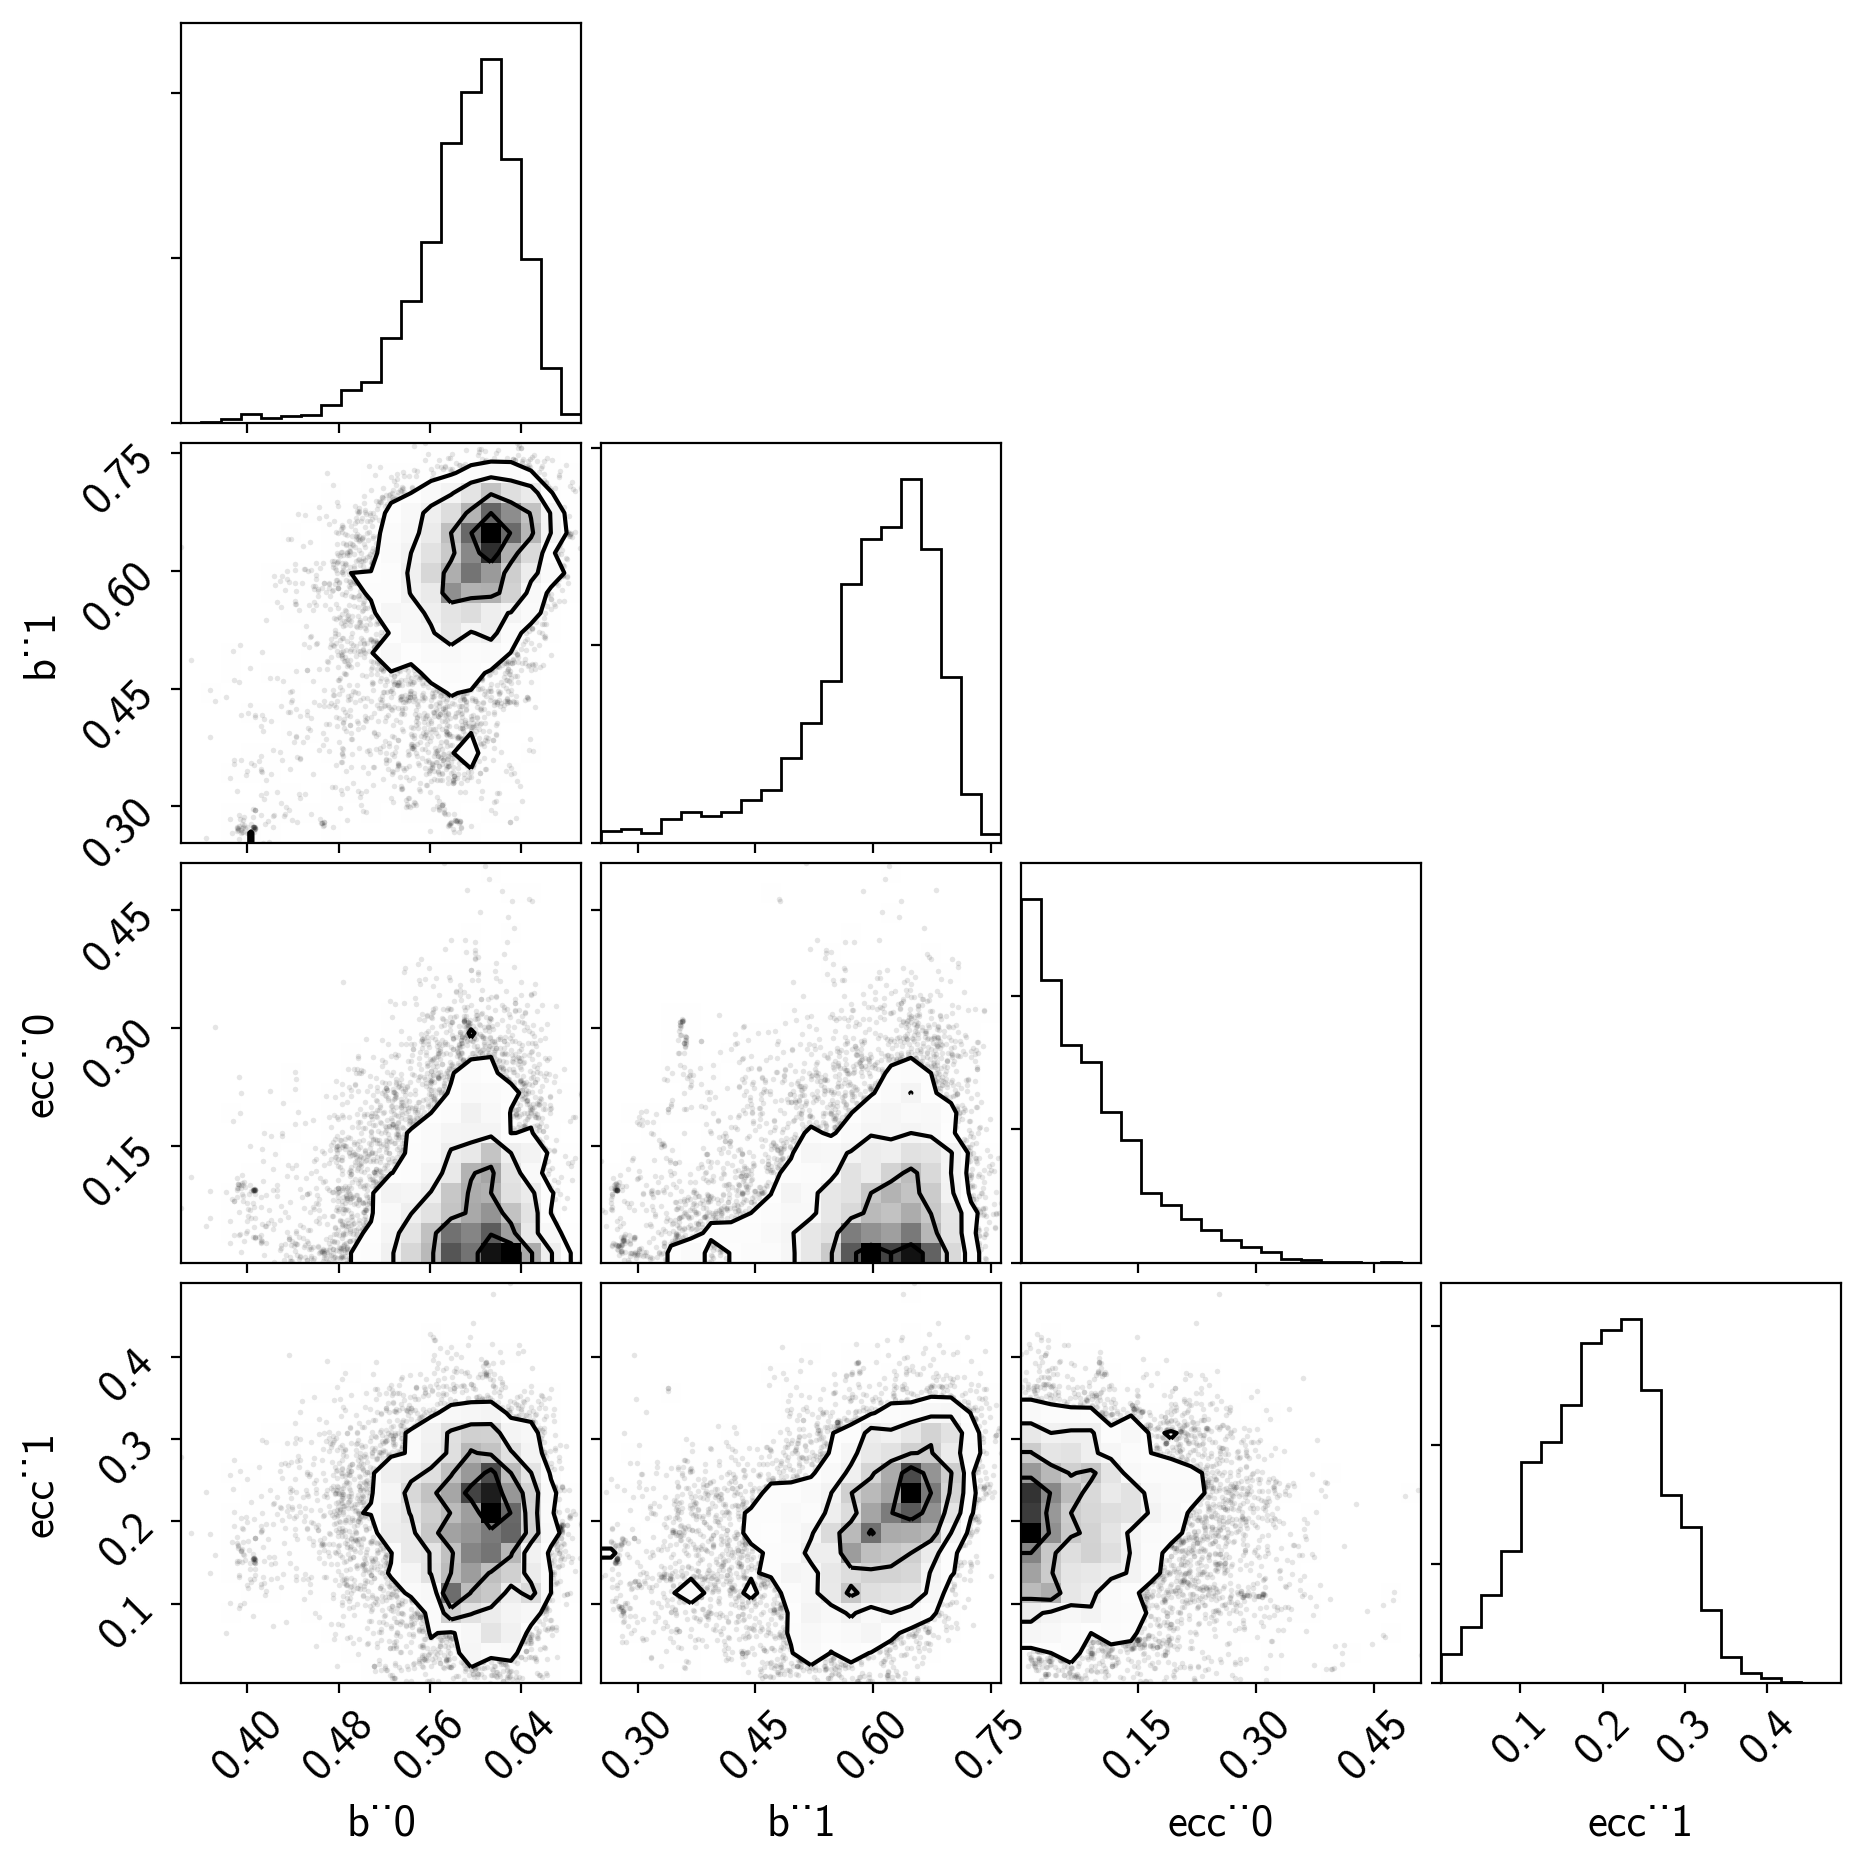

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

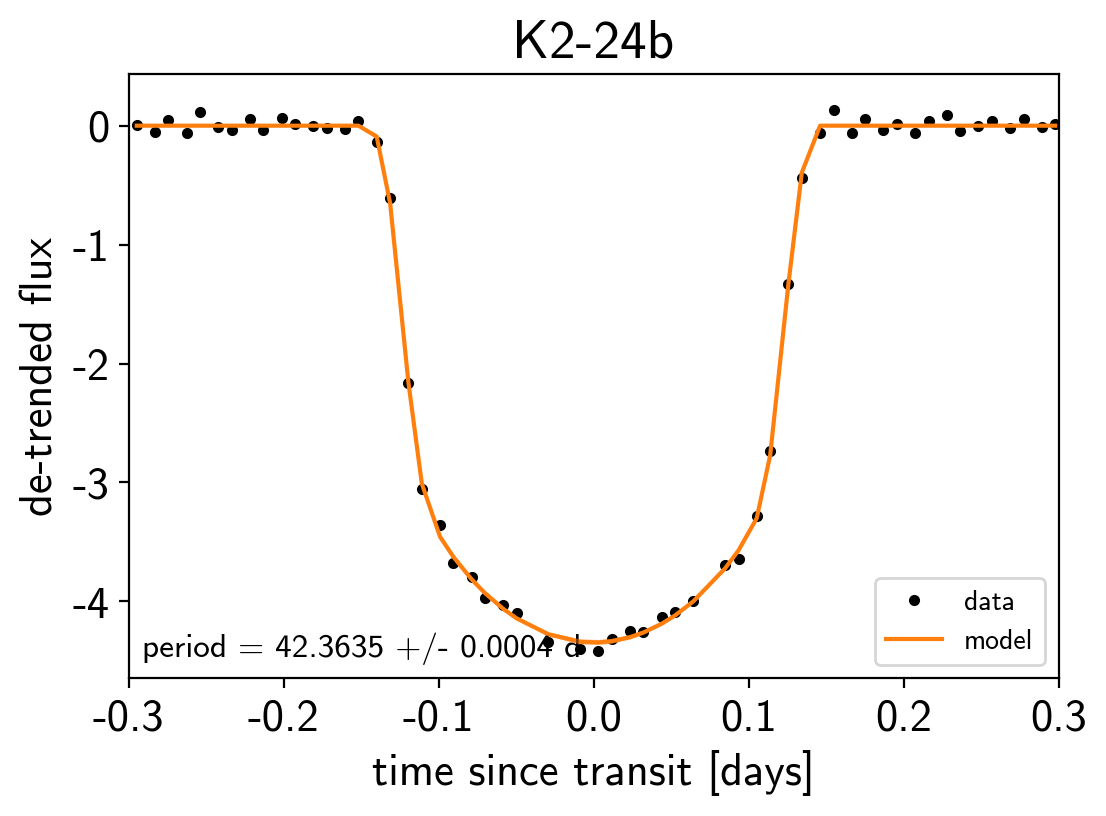

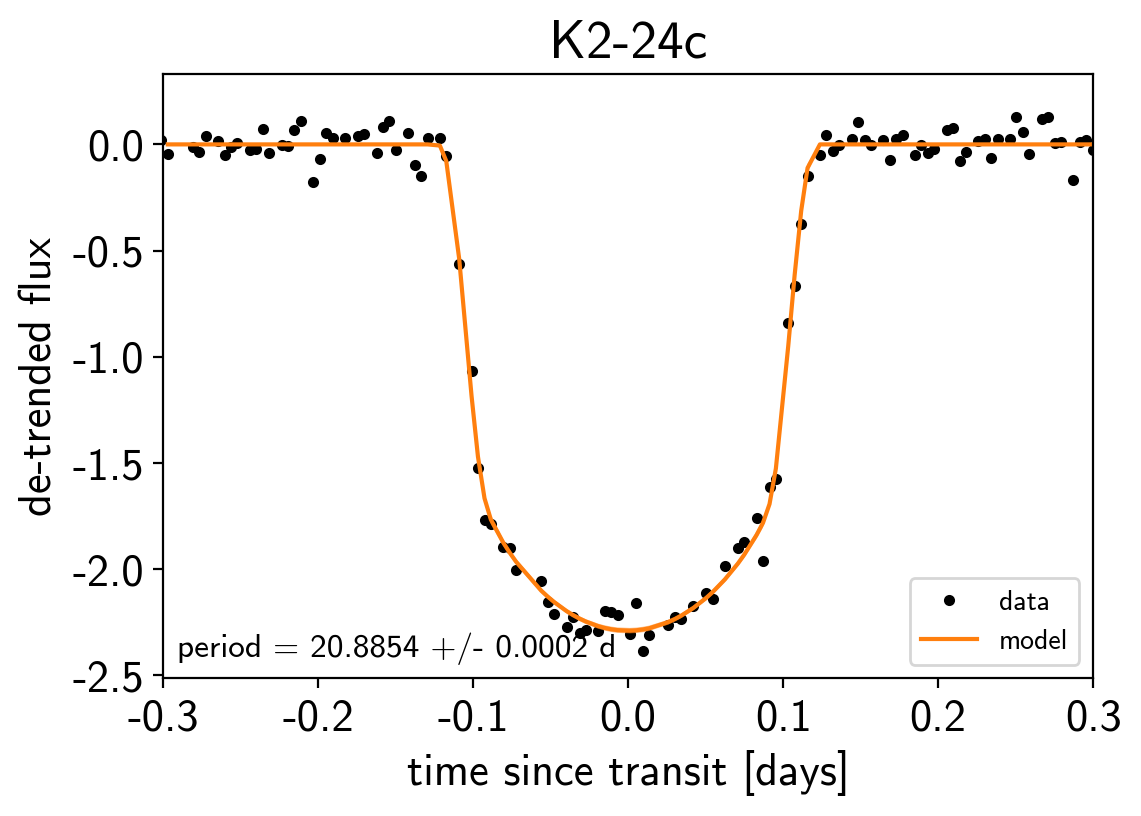

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

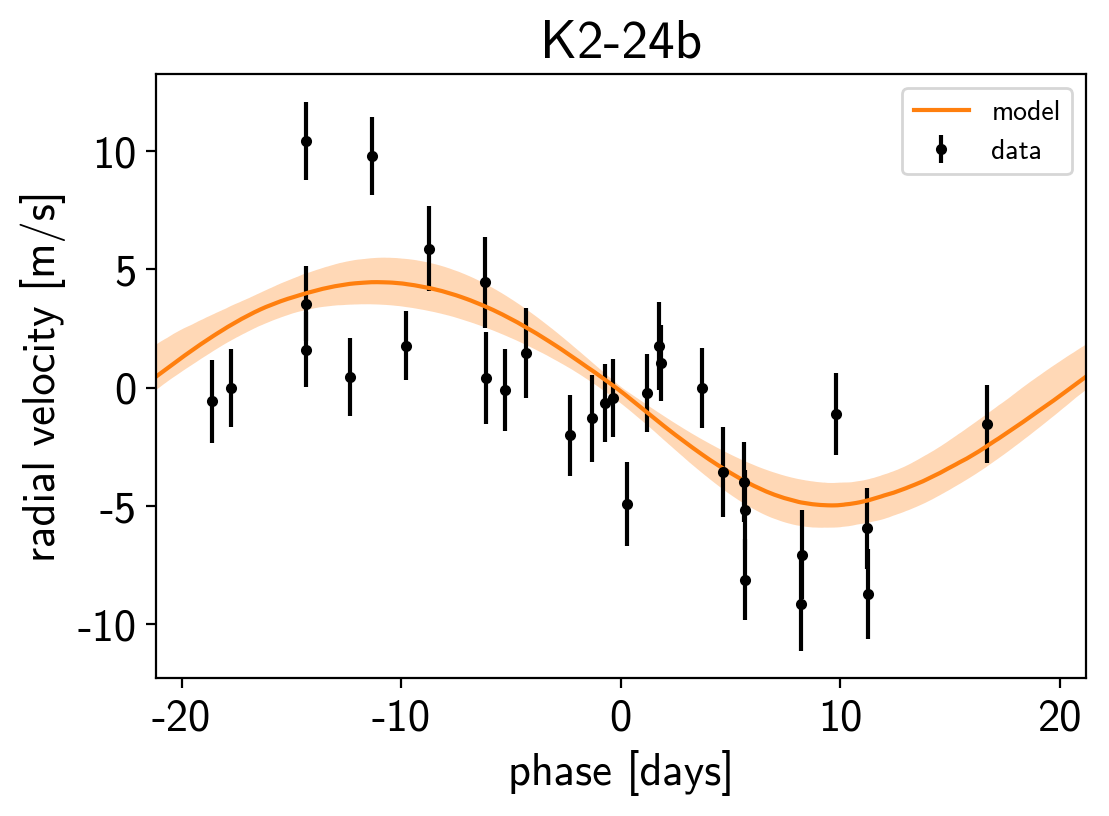

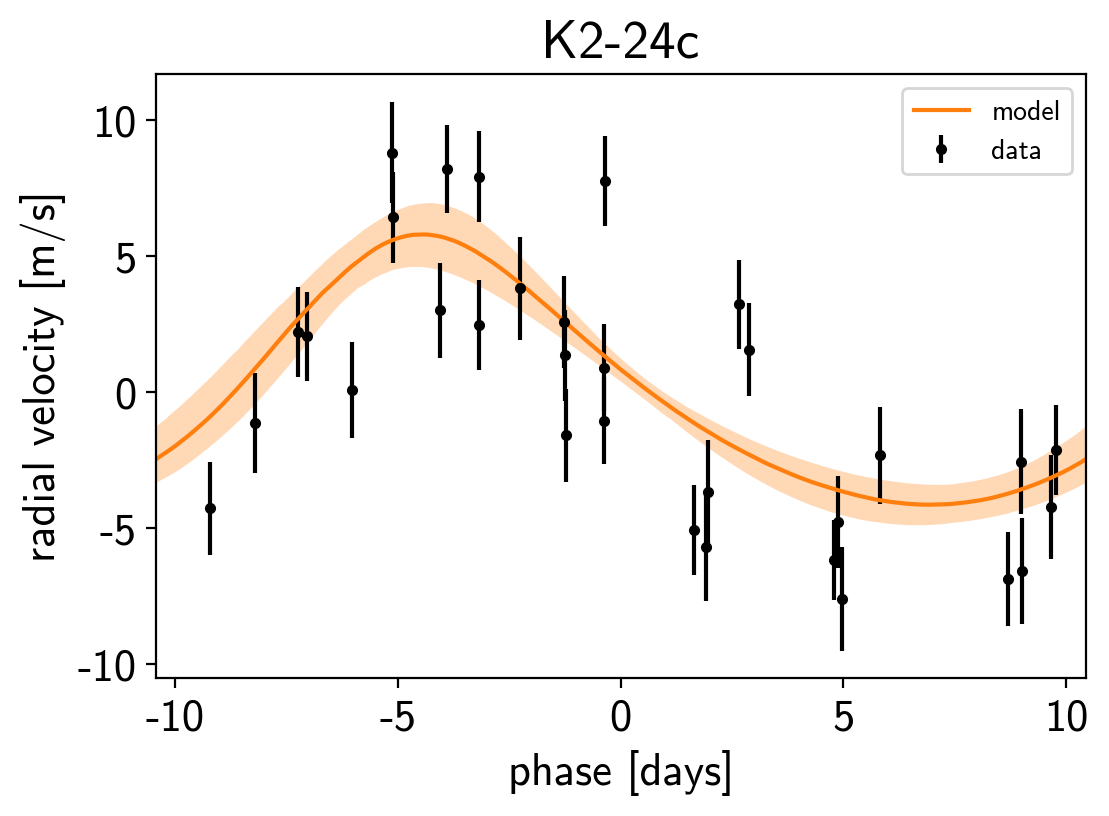

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

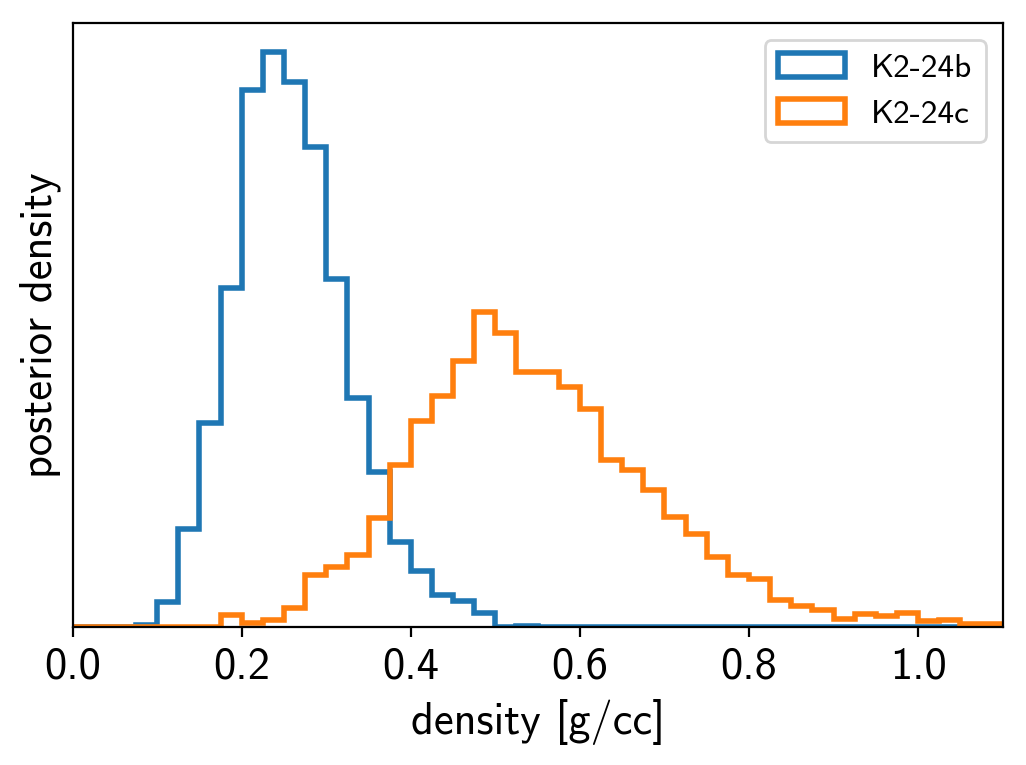

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
